In [193]:
import torch
import torch.nn.functional as F
from sklearn.model_selection import KFold
import numpy as np
import copy

import os
import sys
import pathlib
pth=str(pathlib.Path().absolute())

#Utilities
sys.path.append(pth)
from model_An import *
from util import *
from Data_loader_image import *

#Base de datos
#sys.path.append()
#data=("/").join(pth.split("/")[:-2])+"/Data_Base/Metada_V6G_p1"
data=("/").join(pth.split("/")[:-2])+"/Data_Base/Metadata_V7G_pytorch"
data_arg=("/").join(pth.split("/")[:-2])+"/Data_Base"


In [2]:
#dataset=Rotated_Dataset(data_arg,"Metadata_V6G_p1")
dataset=Rotated_Dataset(data_arg,"Metadata_V7G_pytorch",
                        features=[
                            12,
                            13,
                            15,
                            16,
                            -5,
                            -4,
                            -3,
                            -2,
                            -1,
                        ]
                       )

In [253]:
Yc.shape

(56,)

[ 8.3  8.9  9.4  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6
 10.7 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.
 12.1 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4
 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.9]
[ 16  16  48  24  16   8  64  56  48  32  32  41  64  56 112  72 104  80
 152 216 152 128 184 184 168 232 224 136 264 272 136 176 224 272 152 248
 280 176 224 152  96 112  88  56 112  64 112  64  24  32  32  24  32  16
  32  16]


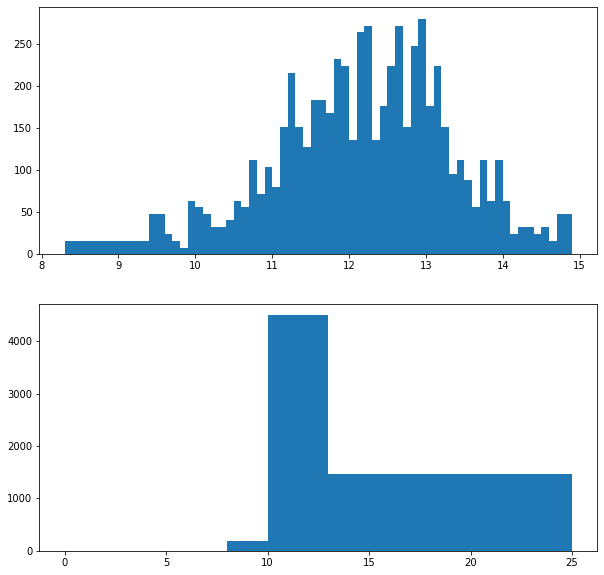

In [27]:
Yc=np.sort(np.unique(Y.astype(float)))
np.sum(Y.astype(float)==Yc[0])
Yd=np.vectorize(lambda Y,Yc:np.sum(Y.astype(float)==Yc),signature="(j),()->()")(Y,Yc)
print(Yc)
print(Yd)

import matplotlib.pyplot as plt
fig,axs=plt.subplots(2,1,figsize=(10,10))
axs[0].hist(Y.astype(float),Yc)
axs[1].hist(Y.astype(float),[0,6,8,10,13,25])
plt.show()

In [67]:
set([0,1,2,3,4,5]).substract([0,5])

AttributeError: 'set' object has no attribute 'substract'

In [3]:
np.unique(dataset.landmarks_frame[:,1])

array(['10.0', '10.1', '10.2', '10.3', '10.4', '10.5', '10.6', '10.7',
       '10.8', '10.9', '11.0', '11.1', '11.2', '11.3', '11.4', '11.5',
       '11.6', '11.7', '11.8', '11.9', '12.0', '12.1', '12.2', '12.3',
       '12.4', '12.5', '12.6', '12.7', '12.8', '12.9', '13.0', '13.1',
       '13.2', '13.3', '13.4', '13.5', '13.6', '13.7', '13.8', '13.9',
       '14.0', '14.1', '14.2', '14.3', '14.4', '14.5', '14.6', '14.7',
       '14.9', '8.3', '8.9', '9.4', '9.6', '9.7', '9.8', '9.9'],
      dtype='<U23')

In [3]:
def train_model(
    dataset,
        epochs,
        batch_size,
        use_cuda,
    folds=5,
        disable_tqdm=False,
        ):
    print("Reading dataset")
    #dset = MNIST(dset_folder,download=True)
    #DATASET
    #imgs = dset.data.unsqueeze(-1).numpy().astype(np.float64)
    #labels = dset.targets.numpy()
    
    #train_idx, valid_idx = map(np.array,util.split_dataset(labels))
    ind=np.arange(0,len(dataset))
    
    #INSIDE K-FOLD
    last_results={}
    results={}
    for fold in range(folds):
        #generate train-test
        print("fold "+str(fold+1))
        
        i=fold

        ind=np.arange(0,len(dataset))
        indexes=ind[np.random.permutation(len(dataset))]
        L=len(dataset)
        test_idx=indexes[int(i*L/5):int((i+1)*L/5)]
        train_idx=np.delete(indexes,np.arange(int(i*L/5),int((i+1)*L/5)))
        
        model = GAT_ANE_(62,1)
        if use_cuda:
            model = model.cuda()
    
        opt = torch.optim.Adam(model.parameters())
    
        best_valid_acc = 0.
        best_model = copy.deepcopy(model)
    
        last_epoch_train_loss = 0.
        last_epoch_train_acc = 0.
        last_epoch_valid_acc = 0.
    
        interrupted = False
        
        train_dat=np.vectorize(lambda ind:dataset[ind],otypes=[object])(train_idx)
        train_graph=np.vectorize(lambda b:b["image_graph"])(train_dat)
        train_label=np.vectorize(lambda b:b["landmarks"])(train_dat)
        test_dat=np.vectorize(lambda ind:dataset[ind],otypes=[object])(test_idx)
        test_graph=np.vectorize(lambda b:b["image_graph"])(test_dat)
        test_label=np.vectorize(lambda b:b["landmarks"])(test_dat)
        
        loss_function = nn.MSELoss()
        
        epoch_train=[]
        epoch_test=[]
        for e in tqdm(range(epochs), total=epochs, desc="Epoch ", disable=disable_tqdm,):
            try:
                #train_losses, train_accs = train_(model, opt, train_graph, train_label,loss_function,
                                                  #batch_size=batch_size, use_cuda=use_cuda, disable_tqdm=disable_tqdm,)
                train_losses, train_accs =train_(model=model,
                                                 optimiser=opt,
                                                 graphs=train_graph,
                                                 labels=train_label,
                                                 use_cuda=use_cuda,
                                                 loss_function=nn.MSELoss(),
                                                 #batch_size=1,
                                                 batch_size=batch_size,
                                                 disable_tqdm=disable_tqdm,
                                                 profile=False)
            
                last_epoch_train_loss = np.mean(train_losses)
                last_epoch_train_acc = np.mean(train_accs)
            except KeyboardInterrupt:
                print("Training interrupted!")
                interrupted = True
        
            #valid_accs = test_(model,test_graph,test_label,use_cuda,desc="Validation ", disable_tqdm=disable_tqdm,)
            valid_accs = test_(model=model,
                               graphs=test_graph,
                               labels=test_label,
                               use_cuda=use_cuda,
                               batch_size=batch_size,
                               desc="Test ",
                               disable_tqdm=False)
                
            last_epoch_valid_acc = np.mean(valid_accs)
        
            if last_epoch_valid_acc>best_valid_acc:
                best_valid_acc = last_epoch_valid_acc
                best_model = copy.deepcopy(model)
        
            epoch_train.append(last_epoch_train_loss)
            epoch_test.append(last_epoch_valid_acc)
            tqdm.write("EPOCH SUMMARY {loss:.4f} {t_acc:.2f}% {v_acc:.2f}%".format(loss=last_epoch_train_loss, t_acc=last_epoch_train_acc, v_acc=last_epoch_valid_acc))
        
            if interrupted:
                break
    
        last_results[fold]={"train_acc":train_accs,"train_loss":epoch_train,"valid_acc":epoch_test}
        results[fold]={"train_acc":last_epoch_train_acc,"train_loss":last_epoch_train_loss,"valid_acc":last_epoch_valid_acc}
        save_model("best"+str(fold),best_model)
        save_model("last"+str(fold),model)
    np.save("results_10f"+'.npy',results)
    np.save("last_results_10f"+'.npy',last_results)
    return results,last_results
        


In [ ]:
results,last_results=train_model(
    dataset,
    epochs=100,
    batch_size=int(300),
    use_cuda=True,
    folds=10,
        disable_tqdm=False,
        )

Reading dataset
fold 1


Epoch :   0%|          | 0/100 [00:00<?, ?it/s]
                                               68 [00:00<?, ?it/s]
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]                   
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
                                               68 [00:00<00:01,  8.31it/s]
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]                           
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.31it/s]
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.16it/s]

635.9224	635.92%	[0.18976805] (x[299])
181.3283	181.33%	[0.19221278] (x[299])


                                               
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]                           
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.16it/s]
                                               68 [00:00<00:01,  8.55it/s]
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]                           
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.55it/s]
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.59it/s]

141.4053	141.41%	[0.19476122] (x[299])
186.8931	186.89%	[0.19736233] (x[299])


                                               
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]                           
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.59it/s]
                                               68 [00:00<00:01,  8.78it/s]
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]                           
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.78it/s]
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.84it/s]

243.9830	243.98%	[0.2000911] (x[299])
158.4612	158.46%	[0.2029369] (x[299])


                                               
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]                           
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.84it/s]
                                               68 [00:00<00:01,  8.94it/s]
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]                           
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.94it/s]
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  8.98it/s]

159.1664	159.17%	[0.20581213] (x[299])
144.9999	145.00%	[0.20871562] (x[299])


                                               
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]                           
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.98it/s]
                                               68 [00:01<00:00,  8.91it/s]
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]                           
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.91it/s]
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.88it/s]

147.8269	147.83%	[0.21161659] (x[299])
145.7316	145.73%	[0.21445952] (x[299])


                                               
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]                            
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.88it/s]
                                               668 [00:01<00:00,  8.49it/s]
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]                            
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.49it/s]
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.45it/s]

186.9789	186.98%	[0.21673566] (x[201])
154.5406	154.54%	[0.21992385] (x[299])


                                               
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]                            
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.45it/s]
                                               668 [00:01<00:00,  8.50it/s]
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]                            
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.50it/s]
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.30it/s]

155.0672	155.07%	[0.2225459] (x[299])
143.1961	143.20%	[0.22514114] (x[299])


                                               
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]                            
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.30it/s]
                                               668 [00:01<00:00,  8.22it/s]
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]                            
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.22it/s]
                                               668 [00:01<00:00,  8.20it/s]
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]                            
Instances :  96%|█████████▌| 16/16.666666666666668 [00:01<00:00,  8.20it/s]

150.8031	150.80%	[0.22773921] (x[299])
143.9564	143.96%	[0.23039643] (x[299])
727.3531	727.35%	[0.23307936] (x[199])


/home/lambda/lab/lib/python3.8/site-packages/tqdm/std.py:532: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.71it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.58it/s]
Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.54it/s]
Test : 5it [00:00, 12.23it/s]                                       
Epoch :   1%|          | 1/100 [00:02<03:54,  2.37s/it]
                                                       0<?, ?it/s]
Epoch :   1%|          | 1/100 [00:02<03:54,  2.37s/it]           
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.04it/s]

EPOCH SUMMARY 223.9773 223.98% 183.88%
155.4575	155.46%	[0.23592699] (x[299])


                                                       
Epoch :   1%|          | 1/100 [00:02<03:54,  2.37s/it]                   
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.04it/s]
                                                       0<00:01,  8.89it/s]
Epoch :   1%|          | 1/100 [00:02<03:54,  2.37s/it]                   
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.89it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.71it/s]

144.2170	144.22%	[0.23879829] (x[299])
146.4769	146.48%	[0.2416549] (x[299])


                                                       
Epoch :   1%|          | 1/100 [00:02<03:54,  2.37s/it]                   
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.71it/s]
                                                       0<00:01,  8.82it/s]
Epoch :   1%|          | 1/100 [00:02<03:54,  2.37s/it]                   
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.82it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.86it/s]

142.3995	142.40%	[0.24443693] (x[299])
149.6115	149.61%	[0.24720271] (x[299])


                                                       
Epoch :   1%|          | 1/100 [00:03<03:54,  2.37s/it]                   
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.86it/s]
                                                       0<00:01,  8.88it/s]
Epoch :   1%|          | 1/100 [00:03<03:54,  2.37s/it]                   
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.88it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.00it/s]

145.3731	145.37%	[0.24992076] (x[299])
146.5084	146.51%	[0.25262147] (x[299])


                                                       
Epoch :   1%|          | 1/100 [00:03<03:54,  2.37s/it]                   
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.00it/s]
                                                       0<00:00,  9.04it/s]
Epoch :   1%|          | 1/100 [00:03<03:54,  2.37s/it]                   
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  9.04it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.08it/s]

148.1880	148.19%	[0.25531155] (x[299])
159.0054	159.01%	[0.25799125] (x[299])


                                                       
Epoch :   1%|          | 1/100 [00:03<03:54,  2.37s/it]                   
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.08it/s]
                                                       01<00:00,  9.07it/s]
Epoch :   1%|          | 1/100 [00:03<03:54,  2.37s/it]                    
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.07it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.02it/s]

143.7138	143.71%	[0.26063928] (x[299])
153.1914	153.19%	[0.26328152] (x[299])


                                                       
Epoch :   1%|          | 1/100 [00:03<03:54,  2.37s/it]                    
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.02it/s]
                                                       01<00:00,  8.95it/s]
Epoch :   1%|          | 1/100 [00:03<03:54,  2.37s/it]                    
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.95it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.74it/s]

137.5516	137.55%	[0.265898] (x[299])
141.2094	141.21%	[0.26851273] (x[299])


                                                       
Epoch :   1%|          | 1/100 [00:03<03:54,  2.37s/it]                    
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.74it/s]
                                                       01<00:00,  8.63it/s]
Epoch :   1%|          | 1/100 [00:04<03:54,  2.37s/it]                    
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.63it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.33it/s]

140.7423	140.74%	[0.27113813] (x[299])
151.3132	151.31%	[0.27377838] (x[299])


                                                       
Epoch :   1%|          | 1/100 [00:04<03:54,  2.37s/it]                    
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.33it/s]
                                                       01<00:00,  8.43it/s]
Epoch :   1%|          | 1/100 [00:04<03:54,  2.37s/it]                    
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.98it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.77it/s]

141.5534	141.55%	[0.27645683] (x[299])
147.4948	147.49%	[0.27914926] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.43it/s]
Test : 5it [00:00, 11.95it/s]                                       
Epoch :   2%|▏         | 2/100 [00:04<03:49,  2.34s/it]
                                                       0<?, ?it/s]
Epoch :   2%|▏         | 2/100 [00:04<03:49,  2.34s/it]           
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.10it/s]

EPOCH SUMMARY 146.7063 146.71% 156.17%
147.1481	147.15%	[0.28186703] (x[299])


                                                       
Epoch :   2%|▏         | 2/100 [00:04<03:49,  2.34s/it]                   
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.10it/s]
                                                       0<00:01,  8.84it/s]
Epoch :   2%|▏         | 2/100 [00:05<03:49,  2.34s/it]                   
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.84it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.61it/s]

141.6917	141.69%	[0.2846088] (x[299])
143.4807	143.48%	[0.28733116] (x[299])


                                                       
Epoch :   2%|▏         | 2/100 [00:05<03:49,  2.34s/it]                   
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.61it/s]
                                                       0<00:01,  8.42it/s]
Epoch :   2%|▏         | 2/100 [00:05<03:49,  2.34s/it]                   
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.42it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.35it/s]

141.2379	141.24%	[0.29007304] (x[299])
147.0432	147.04%	[0.29281393] (x[299])


                                                       
Epoch :   2%|▏         | 2/100 [00:05<03:49,  2.34s/it]                   
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.35it/s]
                                                       0<00:01,  8.34it/s]
Epoch :   2%|▏         | 2/100 [00:05<03:49,  2.34s/it]                   
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.34it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.62it/s]

141.9320	141.93%	[0.295524] (x[299])
142.9264	142.93%	[0.29823273] (x[299])


                                                       
Epoch :   2%|▏         | 2/100 [00:05<03:49,  2.34s/it]                   
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.62it/s]
                                                       0<00:00,  8.79it/s]
Epoch :   2%|▏         | 2/100 [00:05<03:49,  2.34s/it]                   
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.79it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.80it/s]

143.9168	143.92%	[0.3009487] (x[299])
147.4748	147.47%	[0.30366886] (x[299])


                                                       
Epoch :   2%|▏         | 2/100 [00:05<03:49,  2.34s/it]                   
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.80it/s]
                                                       01<00:00,  8.70it/s]
Epoch :   2%|▏         | 2/100 [00:05<03:49,  2.34s/it]                    
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.70it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.81it/s]

139.9612	139.96%	[0.30638134] (x[299])
141.9745	141.97%	[0.30909938] (x[299])


                                                       
Epoch :   2%|▏         | 2/100 [00:06<03:49,  2.34s/it]                    
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.81it/s]
                                                       01<00:00,  8.90it/s]
Epoch :   2%|▏         | 2/100 [00:06<03:49,  2.34s/it]                    
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.90it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.98it/s]

135.7014	135.70%	[0.31181264] (x[299])
141.2400	141.24%	[0.31453764] (x[299])


                                                       
Epoch :   2%|▏         | 2/100 [00:06<03:49,  2.34s/it]                    
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.98it/s]
                                                       01<00:00,  8.92it/s]
Epoch :   2%|▏         | 2/100 [00:06<03:49,  2.34s/it]                    
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.92it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.72it/s]

140.0856	140.09%	[0.31728673] (x[299])
144.8348	144.83%	[0.32005662] (x[299])


                                                       
Epoch :   2%|▏         | 2/100 [00:06<03:49,  2.34s/it]                    
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.72it/s]
                                                       01<00:00,  8.59it/s]
Epoch :   2%|▏         | 2/100 [00:06<03:49,  2.34s/it]                    
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.87it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.37it/s]

138.2432	138.24%	[0.3228594] (x[299])
141.9788	141.98%	[0.32567516] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.92it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  8.83it/s]
Test : 5it [00:00, 11.02it/s]                                       
Epoch :   3%|▎         | 3/100 [00:07<03:48,  2.36s/it]
                                                       0<?, ?it/s]
Epoch :   3%|▎         | 3/100 [00:07<03:48,  2.36s/it]           
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.75it/s]

EPOCH SUMMARY 142.4042 142.40% 139.51%
139.3955	139.40%	[0.32850662] (x[299])


                                                       
Epoch :   3%|▎         | 3/100 [00:07<03:48,  2.36s/it]                   
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.75it/s]
                                                       0<00:01,  8.61it/s]
Epoch :   3%|▎         | 3/100 [00:07<03:48,  2.36s/it]                   
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.61it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.41it/s]

137.4676	137.47%	[0.3313545] (x[299])
138.4389	138.44%	[0.33421236] (x[299])


                                                       
Epoch :   3%|▎         | 3/100 [00:07<03:48,  2.36s/it]                   
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.41it/s]
                                                       0<00:01,  8.14it/s]
Epoch :   3%|▎         | 3/100 [00:07<03:48,  2.36s/it]                   
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.14it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.25it/s]

141.0381	141.04%	[0.33706656] (x[299])
139.6562	139.66%	[0.33992153] (x[299])


                                                       
Epoch :   3%|▎         | 3/100 [00:07<03:48,  2.36s/it]                   
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.25it/s]
                                                       0<00:01,  8.28it/s]
Epoch :   3%|▎         | 3/100 [00:07<03:48,  2.36s/it]                   
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.28it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.24it/s]

138.6156	138.62%	[0.34276706] (x[299])
142.0849	142.08%	[0.34562486] (x[299])


                                                       
Epoch :   3%|▎         | 3/100 [00:08<03:48,  2.36s/it]                   
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.24it/s]
                                                       0<00:01,  8.30it/s]
Epoch :   3%|▎         | 3/100 [00:08<03:48,  2.36s/it]                   
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.30it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.10it/s]

141.1720	141.17%	[0.34850556] (x[299])
143.6066	143.61%	[0.35140592] (x[299])


                                                       
Epoch :   3%|▎         | 3/100 [00:08<03:48,  2.36s/it]                   
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.10it/s]
                                                       01<00:00,  8.17it/s]
Epoch :   3%|▎         | 3/100 [00:08<03:48,  2.36s/it]                    
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.17it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.10it/s]

138.0753	138.08%	[0.3543365] (x[299])
138.0161	138.02%	[0.35728213] (x[299])


                                                       
Epoch :   3%|▎         | 3/100 [00:08<03:48,  2.36s/it]                    
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.10it/s]
                                                       01<00:00,  8.08it/s]
Epoch :   3%|▎         | 3/100 [00:08<03:48,  2.36s/it]                    
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.08it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.17it/s]

134.9089	134.91%	[0.3602379] (x[299])
139.0145	139.01%	[0.36318827] (x[299])


                                                       
Epoch :   3%|▎         | 3/100 [00:08<03:48,  2.36s/it]                    
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.17it/s]
                                                       01<00:00,  8.23it/s]
Epoch :   3%|▎         | 3/100 [00:08<03:48,  2.36s/it]                    
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.23it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.29it/s]

139.6156	139.62%	[0.36612976] (x[299])
139.1104	139.11%	[0.36907107] (x[299])


                                                       
Epoch :   3%|▎         | 3/100 [00:09<03:48,  2.36s/it]                    
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.29it/s]
                                                       01<00:00,  8.28it/s]
Epoch :   3%|▎         | 3/100 [00:09<03:48,  2.36s/it]                    
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.43it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.34it/s]

136.3274	136.33%	[0.3720292] (x[299])
140.9939	140.99%	[0.37499863] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.41it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.43it/s]
Test : 5it [00:00, 11.55it/s]                                       
Epoch :   4%|▍         | 4/100 [00:09<03:50,  2.40s/it]
                                                       0<?, ?it/s]
Epoch :   4%|▍         | 4/100 [00:09<03:50,  2.40s/it]           
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.49it/s]

EPOCH SUMMARY 139.2669 139.27% 137.25%
137.4102	137.41%	[0.37797832] (x[299])


                                                       
Epoch :   4%|▍         | 4/100 [00:09<03:50,  2.40s/it]                   
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.49it/s]
                                                       0<00:01,  8.84it/s]
Epoch :   4%|▍         | 4/100 [00:09<03:50,  2.40s/it]                   
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.84it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.02it/s]

136.2692	136.27%	[0.38097408] (x[299])
137.1339	137.13%	[0.38398498] (x[299])


                                                       
Epoch :   4%|▍         | 4/100 [00:09<03:50,  2.40s/it]                   
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.02it/s]
                                                       0<00:01,  8.94it/s]
Epoch :   4%|▍         | 4/100 [00:10<03:50,  2.40s/it]                   
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.94it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.83it/s]

138.6936	138.69%	[0.3870201] (x[299])
136.0663	136.07%	[0.39007223] (x[299])


                                                       
Epoch :   4%|▍         | 4/100 [00:10<03:50,  2.40s/it]                   
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.83it/s]
                                                       0<00:01,  8.61it/s]
Epoch :   4%|▍         | 4/100 [00:10<03:50,  2.40s/it]                   
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.61it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.77it/s]

137.5465	137.55%	[0.3931317] (x[299])
140.3802	140.38%	[0.39620286] (x[299])


                                                       
Epoch :   4%|▍         | 4/100 [00:10<03:50,  2.40s/it]                   
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.77it/s]
                                                       0<00:00,  8.87it/s]
Epoch :   4%|▍         | 4/100 [00:10<03:50,  2.40s/it]                   
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.87it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.91it/s]

140.2198	140.22%	[0.3992892] (x[299])
140.7775	140.78%	[0.4023897] (x[299])


                                                       
Epoch :   4%|▍         | 4/100 [00:10<03:50,  2.40s/it]                   
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.91it/s]
                                                       01<00:00,  8.95it/s]
Epoch :   4%|▍         | 4/100 [00:10<03:50,  2.40s/it]                    
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.95it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.01it/s]

136.8870	136.89%	[0.4055093] (x[299])
136.8524	136.85%	[0.40864107] (x[299])


                                                       
Epoch :   4%|▍         | 4/100 [00:10<03:50,  2.40s/it]                    
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.01it/s]
                                                       01<00:00,  8.99it/s]
Epoch :   4%|▍         | 4/100 [00:10<03:50,  2.40s/it]                    
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.99it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.05it/s]

133.5082	133.51%	[0.4117865] (x[299])
138.3689	138.37%	[0.41494924] (x[299])


                                                       
Epoch :   4%|▍         | 4/100 [00:11<03:50,  2.40s/it]                    
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.05it/s]
                                                       01<00:00,  9.03it/s]
Epoch :   4%|▍         | 4/100 [00:11<03:50,  2.40s/it]                    
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  9.03it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.01it/s]

137.2430	137.24%	[0.4181403] (x[299])
137.9232	137.92%	[0.4213529] (x[299])


                                                       
Epoch :   4%|▍         | 4/100 [00:11<03:50,  2.40s/it]                    
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.01it/s]
                                                       01<00:00,  9.00it/s]
Epoch :   4%|▍         | 4/100 [00:11<03:50,  2.40s/it]                    
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.11it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.31it/s]

135.2194	135.22%	[0.4245871] (x[299])
139.7172	139.72%	[0.42783338] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.44it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.55it/s]
Test : 5it [00:00, 11.62it/s]                                       
Epoch :   5%|▌         | 5/100 [00:11<03:44,  2.36s/it]
                                                       0<?, ?it/s]
Epoch :   5%|▌         | 5/100 [00:11<03:44,  2.36s/it]           
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.56it/s]

EPOCH SUMMARY 137.6598 137.66% 135.60%
136.3175	136.32%	[0.43109214] (x[299])


                                                       
Epoch :   5%|▌         | 5/100 [00:12<03:44,  2.36s/it]                   
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.56it/s]
                                                       0<00:01,  8.39it/s]
Epoch :   5%|▌         | 5/100 [00:12<03:44,  2.36s/it]                   
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.39it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.51it/s]

134.9110	134.91%	[0.434362] (x[299])
135.4486	135.45%	[0.4376475] (x[299])


                                                       
Epoch :   5%|▌         | 5/100 [00:12<03:44,  2.36s/it]                   
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.51it/s]
                                                       0<00:01,  8.60it/s]
Epoch :   5%|▌         | 5/100 [00:12<03:44,  2.36s/it]                   
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.60it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.63it/s]

137.4984	137.50%	[0.44094783] (x[299])
134.9397	134.94%	[0.4442727] (x[299])


                                                       
Epoch :   5%|▌         | 5/100 [00:12<03:44,  2.36s/it]                   
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.63it/s]
                                                       0<00:01,  8.56it/s]
Epoch :   5%|▌         | 5/100 [00:12<03:44,  2.36s/it]                   
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.56it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.66it/s]

136.0824	136.08%	[0.44762242] (x[299])
138.9680	138.97%	[0.45099056] (x[299])


                                                       
Epoch :   5%|▌         | 5/100 [00:12<03:44,  2.36s/it]                   
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.66it/s]
                                                       0<00:01,  8.59it/s]
Epoch :   5%|▌         | 5/100 [00:12<03:44,  2.36s/it]                   
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.59it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.57it/s]

138.5995	138.60%	[0.45438248] (x[299])
139.4881	139.49%	[0.45779416] (x[299])


                                                       
Epoch :   5%|▌         | 5/100 [00:13<03:44,  2.36s/it]                   
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.57it/s]
                                                       01<00:00,  8.40it/s]
Epoch :   5%|▌         | 5/100 [00:13<03:44,  2.36s/it]                    
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.40it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.41it/s]

135.5696	135.57%	[0.461232] (x[299])
135.8591	135.86%	[0.46468407] (x[299])


                                                       
Epoch :   5%|▌         | 5/100 [00:13<03:44,  2.36s/it]                    
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.41it/s]
                                                       01<00:00,  8.38it/s]
Epoch :   5%|▌         | 5/100 [00:13<03:44,  2.36s/it]                    
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.38it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.32it/s]

132.1004	132.10%	[0.46814546] (x[299])
136.5620	136.56%	[0.47162104] (x[299])


                                                       
Epoch :   5%|▌         | 5/100 [00:13<03:44,  2.36s/it]                    
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.32it/s]
                                                       01<00:00,  8.34it/s]
Epoch :   5%|▌         | 5/100 [00:13<03:44,  2.36s/it]                    
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.34it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.31it/s]

135.8558	135.86%	[0.47512272] (x[299])
136.7944	136.79%	[0.47864708] (x[299])


                                                       
Epoch :   5%|▌         | 5/100 [00:13<03:44,  2.36s/it]                    
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.31it/s]
                                                       01<00:00,  8.31it/s]
Epoch :   5%|▌         | 5/100 [00:13<03:44,  2.36s/it]                    
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.63it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.26it/s]

133.7851	133.79%	[0.48220295] (x[299])
138.0911	138.09%	[0.4857775] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.48it/s]
Test : 5it [00:00, 11.96it/s]                                       
Epoch :   6%|▌         | 6/100 [00:14<03:43,  2.37s/it]
                                                       0<?, ?it/s]
Epoch :   6%|▌         | 6/100 [00:14<03:43,  2.37s/it]           
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.30it/s]

EPOCH SUMMARY 136.2865 136.29% 134.21%
134.8047	134.80%	[0.48937213] (x[299])


                                                       
Epoch :   6%|▌         | 6/100 [00:14<03:43,  2.37s/it]                   
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.30it/s]
                                                       0<00:01,  8.29it/s]
Epoch :   6%|▌         | 6/100 [00:14<03:43,  2.37s/it]                   
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.29it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.46it/s]

133.6561	133.66%	[0.4929877] (x[299])
134.0985	134.10%	[0.49662387] (x[299])


                                                       
Epoch :   6%|▌         | 6/100 [00:14<03:43,  2.37s/it]                   
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.46it/s]
                                                       0<00:01,  8.48it/s]
Epoch :   6%|▌         | 6/100 [00:14<03:43,  2.37s/it]                   
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.48it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.34it/s]

136.0971	136.10%	[0.5002772] (x[299])
133.3985	133.40%	[0.5039493] (x[299])


                                                       
Epoch :   6%|▌         | 6/100 [00:14<03:43,  2.37s/it]                   
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.34it/s]
                                                       0<00:01,  8.33it/s]
Epoch :   6%|▌         | 6/100 [00:15<03:43,  2.37s/it]                   
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.33it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.34it/s]

134.7352	134.74%	[0.5076359] (x[299])
137.6124	137.61%	[0.51134276] (x[299])


                                                       
Epoch :   6%|▌         | 6/100 [00:15<03:43,  2.37s/it]                   
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.34it/s]
                                                       0<00:01,  8.41it/s]
Epoch :   6%|▌         | 6/100 [00:15<03:43,  2.37s/it]                   
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.41it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.08it/s]

137.0884	137.09%	[0.5150789] (x[299])
138.1861	138.19%	[0.5188401] (x[299])


                                                       
Epoch :   6%|▌         | 6/100 [00:15<03:43,  2.37s/it]                   
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.08it/s]
                                                       01<00:00,  8.07it/s]
Epoch :   6%|▌         | 6/100 [00:15<03:43,  2.37s/it]                    
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.07it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.06it/s]

133.9812	133.98%	[0.52263534] (x[299])
134.2285	134.23%	[0.52644926] (x[299])


                                                       
Epoch :   6%|▌         | 6/100 [00:15<03:43,  2.37s/it]                    
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.06it/s]
                                                       01<00:00,  8.07it/s]
Epoch :   6%|▌         | 6/100 [00:15<03:43,  2.37s/it]                    
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.07it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.02it/s]

130.6982	130.70%	[0.530277] (x[299])
135.0948	135.09%	[0.5341204] (x[299])


                                                       
Epoch :   6%|▌         | 6/100 [00:15<03:43,  2.37s/it]                    
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.02it/s]
                                                       01<00:00,  7.96it/s]
Epoch :   6%|▌         | 6/100 [00:16<03:43,  2.37s/it]                    
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  7.96it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.04it/s]

134.4153	134.42%	[0.53799045] (x[299])
135.1540	135.15%	[0.5418821] (x[299])


                                                       
Epoch :   6%|▌         | 6/100 [00:16<03:43,  2.37s/it]                    
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.04it/s]
                                                       01<00:00,  8.18it/s]
Epoch :   6%|▌         | 6/100 [00:16<03:43,  2.37s/it]                    
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.35it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

132.3370	132.34%	[0.54580355] (x[299])
136.6355	136.64%	[0.5497103] (x[199])



Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.36it/s]
Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.47it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.17it/s]
Test : 5it [00:00, 11.21it/s]                                       
Epoch :   7%|▋         | 7/100 [00:16<03:44,  2.41s/it]
                                                       0<?, ?it/s]
Epoch :   7%|▋         | 7/100 [00:16<03:44,  2.41s/it]           
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.27it/s]

EPOCH SUMMARY 134.8366 134.84% 132.79%
133.3310	133.33%	[0.55363536] (x[299])


                                                       
Epoch :   7%|▋         | 7/100 [00:16<03:44,  2.41s/it]                   
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.27it/s]
                                                       0<00:01,  9.04it/s]
Epoch :   7%|▋         | 7/100 [00:17<03:44,  2.41s/it]                   
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.04it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.81it/s]

132.1760	132.18%	[0.557582] (x[299])
132.6426	132.64%	[0.56155086] (x[299])


                                                       
Epoch :   7%|▋         | 7/100 [00:17<03:44,  2.41s/it]                   
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.81it/s]
                                                       0<00:01,  8.79it/s]
Epoch :   7%|▋         | 7/100 [00:17<03:44,  2.41s/it]                   
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.79it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.50it/s]

134.5573	134.56%	[0.565543] (x[299])
131.8723	131.87%	[0.5695583] (x[299])


                                                       
Epoch :   7%|▋         | 7/100 [00:17<03:44,  2.41s/it]                   
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.50it/s]
                                                       0<00:01,  8.69it/s]
Epoch :   7%|▋         | 7/100 [00:17<03:44,  2.41s/it]                   
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.69it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.84it/s]

133.2793	133.28%	[0.57359326] (x[299])
136.0325	136.03%	[0.57764685] (x[299])


                                                       
Epoch :   7%|▋         | 7/100 [00:17<03:44,  2.41s/it]                   
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.84it/s]
                                                       0<00:01,  8.63it/s]
Epoch :   7%|▋         | 7/100 [00:17<03:44,  2.41s/it]                   
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.63it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.69it/s]

135.6763	135.68%	[0.5817262] (x[299])
136.5089	136.51%	[0.58582807] (x[299])


                                                       
Epoch :   7%|▋         | 7/100 [00:17<03:44,  2.41s/it]                   
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.69it/s]
                                                       01<00:00,  8.51it/s]
Epoch :   7%|▋         | 7/100 [00:17<03:44,  2.41s/it]                    
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.51it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.65it/s]

132.5133	132.51%	[0.58996105] (x[299])
132.6142	132.61%	[0.59411156] (x[299])


                                                       
Epoch :   7%|▋         | 7/100 [00:18<03:44,  2.41s/it]                    
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.65it/s]
                                                       01<00:00,  8.61it/s]
Epoch :   7%|▋         | 7/100 [00:18<03:44,  2.41s/it]                    
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.61it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.63it/s]

129.1967	129.20%	[0.5982797] (x[299])
133.6160	133.62%	[0.6024672] (x[299])


                                                       
Epoch :   7%|▋         | 7/100 [00:18<03:44,  2.41s/it]                    
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.63it/s]
                                                       01<00:00,  8.69it/s]
Epoch :   7%|▋         | 7/100 [00:18<03:44,  2.41s/it]                    
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.69it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.80it/s]

132.8531	132.85%	[0.60668606] (x[299])
133.5298	133.53%	[0.61092854] (x[299])


                                                       
Epoch :   7%|▋         | 7/100 [00:18<03:44,  2.41s/it]                    
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.80it/s]
                                                       01<00:00,  8.90it/s]
Epoch :   7%|▋         | 7/100 [00:18<03:44,  2.41s/it]                    
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.92it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.17it/s]

130.7864	130.79%	[0.6151959] (x[299])
135.1798	135.18%	[0.6194805] (x[199])



Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00, 10.29it/s]
Test : 5it [00:00, 12.29it/s]                                       
Epoch :   8%|▊         | 8/100 [00:19<03:39,  2.38s/it]
                                                       0<?, ?it/s]
Epoch :   8%|▊         | 8/100 [00:19<03:39,  2.38s/it]           
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.06it/s]

EPOCH SUMMARY 133.3156 133.32% 130.99%
131.7609	131.76%	[0.62378085] (x[299])


                                                       
Epoch :   8%|▊         | 8/100 [00:19<03:39,  2.38s/it]                   
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.06it/s]
                                                       0<00:01,  9.02it/s]
Epoch :   8%|▊         | 8/100 [00:19<03:39,  2.38s/it]                   
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.02it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.99it/s]

130.5642	130.56%	[0.628099] (x[299])
131.0574	131.06%	[0.6324395] (x[299])


                                                       
Epoch :   8%|▊         | 8/100 [00:19<03:39,  2.38s/it]                   
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.99it/s]
                                                       0<00:01,  9.02it/s]
Epoch :   8%|▊         | 8/100 [00:19<03:39,  2.38s/it]                   
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.02it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.69it/s]

132.9388	132.94%	[0.6368053] (x[299])
130.2740	130.27%	[0.64119685] (x[299])


                                                       
Epoch :   8%|▊         | 8/100 [00:19<03:39,  2.38s/it]                   
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.69it/s]
                                                       0<00:01,  8.56it/s]
Epoch :   8%|▊         | 8/100 [00:19<03:39,  2.38s/it]                   
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.56it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.52it/s]

131.5939	131.59%	[0.6456106] (x[299])
134.3660	134.37%	[0.6500439] (x[299])


                                                       
Epoch :   8%|▊         | 8/100 [00:19<03:39,  2.38s/it]                   
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.52it/s]
                                                       0<00:01,  8.37it/s]
Epoch :   8%|▊         | 8/100 [00:20<03:39,  2.38s/it]                   
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.37it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.40it/s]

133.9791	133.98%	[0.6545037] (x[299])
134.8121	134.81%	[0.65898603] (x[299])


                                                       
Epoch :   8%|▊         | 8/100 [00:20<03:39,  2.38s/it]                   
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.40it/s]
                                                       01<00:00,  8.58it/s]
Epoch :   8%|▊         | 8/100 [00:20<03:39,  2.38s/it]                    
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.58it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.74it/s]

130.8257	130.83%	[0.6634953] (x[299])
130.9820	130.98%	[0.66802204] (x[299])


                                                       
Epoch :   8%|▊         | 8/100 [00:20<03:39,  2.38s/it]                    
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.74it/s]
                                                       01<00:00,  8.85it/s]
Epoch :   8%|▊         | 8/100 [00:20<03:39,  2.38s/it]                    
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.85it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.87it/s]

127.5436	127.54%	[0.67256343] (x[299])
132.0118	132.01%	[0.6771239] (x[299])


                                                       
Epoch :   8%|▊         | 8/100 [00:20<03:39,  2.38s/it]                    
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.87it/s]
                                                       01<00:00,  8.93it/s]
Epoch :   8%|▊         | 8/100 [00:20<03:39,  2.38s/it]                    
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.93it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.04it/s]

131.1516	131.15%	[0.6817202] (x[299])
131.8069	131.81%	[0.6863434] (x[299])


                                                       
Epoch :   8%|▊         | 8/100 [00:20<03:39,  2.38s/it]                    
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.04it/s]
                                                       01<00:00,  9.09it/s]
Epoch :   8%|▊         | 8/100 [00:20<03:39,  2.38s/it]                    
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.01it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.27it/s]

129.0681	129.07%	[0.6909949] (x[299])
133.4652	133.47%	[0.6956637] (x[199])



Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00, 10.25it/s]
Test : 5it [00:00, 12.51it/s]                                       
Epoch :   9%|▉         | 9/100 [00:21<03:34,  2.36s/it]
                                                       0<?, ?it/s]
Epoch :   9%|▉         | 9/100 [00:21<03:34,  2.36s/it]           
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.16it/s]

EPOCH SUMMARY 131.6589 131.66% 129.25%
130.0744	130.07%	[0.7003461] (x[299])


                                                       
Epoch :   9%|▉         | 9/100 [00:21<03:34,  2.36s/it]                   
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.16it/s]
                                                       0<00:01,  9.14it/s]
Epoch :   9%|▉         | 9/100 [00:21<03:34,  2.36s/it]                   
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.14it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.12it/s]

128.8314	128.83%	[0.7050434] (x[299])
129.2977	129.30%	[0.7097625] (x[299])


                                                       
Epoch :   9%|▉         | 9/100 [00:21<03:34,  2.36s/it]                   
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.12it/s]
                                                       0<00:01,  8.95it/s]
Epoch :   9%|▉         | 9/100 [00:21<03:34,  2.36s/it]                   
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.95it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.57it/s]

131.2082	131.21%	[0.7145023] (x[299])
128.6205	128.62%	[0.7192713] (x[299])


                                                       
Epoch :   9%|▉         | 9/100 [00:22<03:34,  2.36s/it]                   
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.57it/s]
                                                       0<00:01,  8.43it/s]
Epoch :   9%|▉         | 9/100 [00:22<03:34,  2.36s/it]                   
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.43it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.41it/s]

129.8138	129.81%	[0.72406965] (x[299])
132.5674	132.57%	[0.728887] (x[299])


                                                       
Epoch :   9%|▉         | 9/100 [00:22<03:34,  2.36s/it]                   
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.41it/s]
                                                       0<00:01,  8.32it/s]
Epoch :   9%|▉         | 9/100 [00:22<03:34,  2.36s/it]                   
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.32it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.37it/s]

132.1568	132.16%	[0.73373145] (x[299])
132.9995	133.00%	[0.73859787] (x[299])


                                                       
Epoch :   9%|▉         | 9/100 [00:22<03:34,  2.36s/it]                   
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.37it/s]
                                                       01<00:00,  8.36it/s]
Epoch :   9%|▉         | 9/100 [00:22<03:34,  2.36s/it]                    
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.36it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.37it/s]

129.0576	129.06%	[0.7434894] (x[299])
129.2248	129.22%	[0.74839616] (x[299])


                                                       
Epoch :   9%|▉         | 9/100 [00:22<03:34,  2.36s/it]                    
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.37it/s]
                                                       01<00:00,  8.37it/s]
Epoch :   9%|▉         | 9/100 [00:22<03:34,  2.36s/it]                    
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.37it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.35it/s]

125.7501	125.75%	[0.75331384] (x[299])
130.1421	130.14%	[0.7582495] (x[299])


                                                       
Epoch :   9%|▉         | 9/100 [00:22<03:34,  2.36s/it]                    
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.35it/s]
                                                       01<00:00,  8.37it/s]
Epoch :   9%|▉         | 9/100 [00:23<03:34,  2.36s/it]                    
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.37it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.35it/s]

129.3186	129.32%	[0.76322144] (x[299])
130.0425	130.04%	[0.7682215] (x[299])


                                                       
Epoch :   9%|▉         | 9/100 [00:23<03:34,  2.36s/it]                    
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.35it/s]
                                                       01<00:00,  8.34it/s]
Epoch :   9%|▉         | 9/100 [00:23<03:34,  2.36s/it]                    
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.66it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.09it/s]

127.2292	127.23%	[0.7732566] (x[299])
131.5700	131.57%	[0.77831036] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.88it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.18it/s]
Test : 5it [00:00, 11.00it/s]                                       
Epoch :  10%|█         | 10/100 [00:23<03:33,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  10%|█         | 10/100 [00:23<03:33,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.10it/s]

EPOCH SUMMARY 129.8767 129.88% 127.34%
128.1809	128.18%	[0.78337634] (x[299])


                                                        
Epoch :  10%|█         | 10/100 [00:24<03:33,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.10it/s]
                                                        <00:01,  7.79it/s]
Epoch :  10%|█         | 10/100 [00:24<03:33,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  7.79it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  7.75it/s]

126.9934	126.99%	[0.78845817] (x[299])
127.4449	127.44%	[0.7935616] (x[299])


                                                        
Epoch :  10%|█         | 10/100 [00:24<03:33,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  7.75it/s]
                                                        <00:01,  8.00it/s]
Epoch :  10%|█         | 10/100 [00:24<03:33,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.00it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.16it/s]

129.2871	129.29%	[0.7986785] (x[299])
126.6543	126.65%	[0.80381775] (x[299])


                                                        
Epoch :  10%|█         | 10/100 [00:24<03:33,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.16it/s]
                                                        <00:01,  8.20it/s]
Epoch :  10%|█         | 10/100 [00:24<03:33,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.20it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.25it/s]

127.9243	127.92%	[0.8089707] (x[299])
130.9110	130.91%	[0.8141505] (x[299])


                                                        
Epoch :  10%|█         | 10/100 [00:24<03:33,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.25it/s]
                                                        <00:01,  8.28it/s]
Epoch :  10%|█         | 10/100 [00:24<03:33,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.28it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.25it/s]

130.1247	130.12%	[0.8193701] (x[299])
131.0323	131.03%	[0.8246195] (x[299])


                                                        
Epoch :  10%|█         | 10/100 [00:24<03:33,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.25it/s]
                                                        1<00:00,  8.23it/s]
Epoch :  10%|█         | 10/100 [00:25<03:33,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.23it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.25it/s]

127.0330	127.03%	[0.82989764] (x[299])
127.4520	127.45%	[0.83519274] (x[299])


                                                        
Epoch :  10%|█         | 10/100 [00:25<03:33,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.25it/s]
                                                        1<00:00,  8.25it/s]
Epoch :  10%|█         | 10/100 [00:25<03:33,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.25it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.28it/s]

123.8761	123.88%	[0.8404895] (x[299])
128.0543	128.05%	[0.8457922] (x[299])


                                                        
Epoch :  10%|█         | 10/100 [00:25<03:33,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.28it/s]
                                                        1<00:00,  8.14it/s]
Epoch :  10%|█         | 10/100 [00:25<03:33,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.14it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.21it/s]

127.3455	127.35%	[0.851125] (x[299])
128.1998	128.20%	[0.8564867] (x[299])


                                                        
Epoch :  10%|█         | 10/100 [00:25<03:33,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.21it/s]
                                                        1<00:00,  8.21it/s]
Epoch :  10%|█         | 10/100 [00:25<03:33,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.37it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.09it/s]

125.2637	125.26%	[0.8618917] (x[299])
129.3748	129.37%	[0.867315] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.88it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  8.91it/s]
Test : 5it [00:00, 11.10it/s]                                       
Epoch :  11%|█         | 11/100 [00:26<03:34,  2.41s/it]
                                                        <?, ?it/s]
Epoch :  11%|█         | 11/100 [00:26<03:34,  2.41s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.24it/s]

EPOCH SUMMARY 127.9501 127.95% 125.29%
126.2237	126.22%	[0.8727598] (x[299])


                                                        
Epoch :  11%|█         | 11/100 [00:26<03:34,  2.41s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.24it/s]
                                                        <00:01,  7.99it/s]
Epoch :  11%|█         | 11/100 [00:26<03:34,  2.41s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  7.99it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.11it/s]

124.9678	124.97%	[0.8782166] (x[299])
125.5962	125.60%	[0.8836907] (x[299])


                                                        
Epoch :  11%|█         | 11/100 [00:26<03:34,  2.41s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.11it/s]
                                                        <00:01,  8.16it/s]
Epoch :  11%|█         | 11/100 [00:26<03:34,  2.41s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.16it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.22it/s]

127.3246	127.32%	[0.88916206] (x[299])
124.7978	124.80%	[0.8946674] (x[299])


                                                        
Epoch :  11%|█         | 11/100 [00:26<03:34,  2.41s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.22it/s]
                                                        <00:01,  8.30it/s]
Epoch :  11%|█         | 11/100 [00:27<03:34,  2.41s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.30it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.25it/s]

125.8929	125.89%	[0.90020764] (x[299])
128.6121	128.61%	[0.90577316] (x[299])


                                                        
Epoch :  11%|█         | 11/100 [00:27<03:34,  2.41s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.25it/s]
                                                        <00:01,  8.15it/s]
Epoch :  11%|█         | 11/100 [00:27<03:34,  2.41s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.15it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.16it/s]

128.0661	128.07%	[0.9113704] (x[299])
129.0031	129.00%	[0.9169917] (x[299])


                                                        
Epoch :  11%|█         | 11/100 [00:27<03:34,  2.41s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.16it/s]
                                                        1<00:00,  8.03it/s]
Epoch :  11%|█         | 11/100 [00:27<03:34,  2.41s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.03it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.06it/s]

125.0118	125.01%	[0.9226326] (x[299])
125.2370	125.24%	[0.92828846] (x[299])


                                                        
Epoch :  11%|█         | 11/100 [00:27<03:34,  2.41s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.06it/s]
                                                        1<00:00,  8.03it/s]
Epoch :  11%|█         | 11/100 [00:27<03:34,  2.41s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.03it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.03it/s]

121.7971	121.80%	[0.93395144] (x[299])
126.0793	126.08%	[0.9396288] (x[299])


                                                        
Epoch :  11%|█         | 11/100 [00:27<03:34,  2.41s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.03it/s]
                                                        1<00:00,  8.11it/s]
Epoch :  11%|█         | 11/100 [00:28<03:34,  2.41s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.11it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.16it/s]

125.2545	125.25%	[0.94534373] (x[299])
125.9886	125.99%	[0.95107687] (x[299])


                                                        
Epoch :  11%|█         | 11/100 [00:28<03:34,  2.41s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.16it/s]
                                                        1<00:00,  8.17it/s]
Epoch :  11%|█         | 11/100 [00:28<03:34,  2.41s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.31it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

123.1759	123.18%	[0.9568507] (x[299])
127.2851	127.29%	[0.96264184] (x[199])



Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  8.78it/s]
Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.21it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.07it/s]
Test : 5it [00:00, 11.12it/s]                                       
Epoch :  12%|█▏        | 12/100 [00:28<03:34,  2.44s/it]
                                                        <?, ?it/s]
Epoch :  12%|█▏        | 12/100 [00:28<03:34,  2.44s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.26it/s]

EPOCH SUMMARY 125.9008 125.90% 123.19%
124.0902	124.09%	[0.96845067] (x[299])


                                                        
Epoch :  12%|█▏        | 12/100 [00:29<03:34,  2.44s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.26it/s]
                                                        <00:01,  8.01it/s]
Epoch :  12%|█▏        | 12/100 [00:29<03:34,  2.44s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.01it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.26it/s]

122.8755	122.88%	[0.97427344] (x[299])
123.3724	123.37%	[0.9801146] (x[299])


                                                        
Epoch :  12%|█▏        | 12/100 [00:29<03:34,  2.44s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.26it/s]
                                                        <00:01,  8.18it/s]
Epoch :  12%|█▏        | 12/100 [00:29<03:34,  2.44s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.18it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.17it/s]

125.1320	125.13%	[0.98596174] (x[299])
122.5165	122.52%	[0.99183697] (x[299])


                                                        
Epoch :  12%|█▏        | 12/100 [00:29<03:34,  2.44s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.17it/s]
                                                        <00:01,  8.13it/s]
Epoch :  12%|█▏        | 12/100 [00:29<03:34,  2.44s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.13it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.16it/s]

123.7199	123.72%	[0.9977295] (x[299])
126.4642	126.46%	[1.0036459] (x[299])


                                                        
Epoch :  12%|█▏        | 12/100 [00:29<03:34,  2.44s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.16it/s]
                                                        <00:01,  8.16it/s]
Epoch :  12%|█▏        | 12/100 [00:29<03:34,  2.44s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.16it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.17it/s]

125.8556	125.86%	[1.0095983] (x[299])
126.7564	126.76%	[1.0155776] (x[299])


                                                        
Epoch :  12%|█▏        | 12/100 [00:29<03:34,  2.44s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.17it/s]
                                                        1<00:00,  8.18it/s]
Epoch :  12%|█▏        | 12/100 [00:30<03:34,  2.44s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.18it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.23it/s]

122.7996	122.80%	[1.0215905] (x[299])
122.9767	122.98%	[1.0276186] (x[299])


                                                        
Epoch :  12%|█▏        | 12/100 [00:30<03:34,  2.44s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.23it/s]
                                                        1<00:00,  8.24it/s]
Epoch :  12%|█▏        | 12/100 [00:30<03:34,  2.44s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.24it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.29it/s]

119.6461	119.65%	[1.0336597] (x[299])
123.7492	123.75%	[1.0397117] (x[299])


                                                        
Epoch :  12%|█▏        | 12/100 [00:30<03:34,  2.44s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.29it/s]
                                                        1<00:00,  8.26it/s]
Epoch :  12%|█▏        | 12/100 [00:30<03:34,  2.44s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.26it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.31it/s]

123.0713	123.07%	[1.045787] (x[299])
123.7494	123.75%	[1.0518763] (x[299])


                                                        
Epoch :  12%|█▏        | 12/100 [00:30<03:34,  2.44s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.31it/s]
                                                        1<00:00,  8.33it/s]
Epoch :  12%|█▏        | 12/100 [00:30<03:34,  2.44s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.43it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.54it/s]

120.9725	120.97%	[1.0580082] (x[299])
124.9927	124.99%	[1.0641559] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.60it/s]
Test : 5it [00:00, 12.30it/s]                                       
Epoch :  13%|█▎        | 13/100 [00:31<03:32,  2.44s/it]
                                                        <?, ?it/s]
Epoch :  13%|█▎        | 13/100 [00:31<03:32,  2.44s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.50it/s]

EPOCH SUMMARY 123.6906 123.69% 120.89%
121.8540	121.85%	[1.0703309] (x[299])


                                                        
Epoch :  13%|█▎        | 13/100 [00:31<03:32,  2.44s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.50it/s]
                                                        <00:01,  8.32it/s]
Epoch :  13%|█▎        | 13/100 [00:31<03:32,  2.44s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.32it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.27it/s]

120.6550	120.66%	[1.0765234] (x[299])
121.1931	121.19%	[1.0827322] (x[299])


                                                        
Epoch :  13%|█▎        | 13/100 [00:31<03:32,  2.44s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.27it/s]
                                                        <00:01,  8.29it/s]
Epoch :  13%|█▎        | 13/100 [00:31<03:32,  2.44s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.29it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.33it/s]

122.8702	122.87%	[1.0889385] (x[299])
120.2830	120.28%	[1.0951715] (x[299])


                                                        
Epoch :  13%|█▎        | 13/100 [00:31<03:32,  2.44s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.33it/s]
                                                        <00:01,  8.36it/s]
Epoch :  13%|█▎        | 13/100 [00:32<03:32,  2.44s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.36it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.10it/s]

121.4612	121.46%	[1.1014237] (x[299])
124.1847	124.18%	[1.1077003] (x[299])


                                                        
Epoch :  13%|█▎        | 13/100 [00:32<03:32,  2.44s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.10it/s]
                                                        <00:01,  8.16it/s]
Epoch :  13%|█▎        | 13/100 [00:32<03:32,  2.44s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.16it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.18it/s]

123.5485	123.55%	[1.1140149] (x[299])
124.4267	124.43%	[1.1203562] (x[299])


                                                        
Epoch :  13%|█▎        | 13/100 [00:32<03:32,  2.44s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.18it/s]
                                                        1<00:00,  8.15it/s]
Epoch :  13%|█▎        | 13/100 [00:32<03:32,  2.44s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.15it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.11it/s]

120.5124	120.51%	[1.1267288] (x[299])
120.6906	120.69%	[1.1331153] (x[299])


                                                        
Epoch :  13%|█▎        | 13/100 [00:32<03:32,  2.44s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.11it/s]
                                                        1<00:00,  8.08it/s]
Epoch :  13%|█▎        | 13/100 [00:32<03:32,  2.44s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.08it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.10it/s]

117.3870	117.39%	[1.1395137] (x[299])
121.4390	121.44%	[1.1459229] (x[299])


                                                        
Epoch :  13%|█▎        | 13/100 [00:32<03:32,  2.44s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.10it/s]
                                                        1<00:00,  8.13it/s]
Epoch :  13%|█▎        | 13/100 [00:33<03:32,  2.44s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.13it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.09it/s]

120.7190	120.72%	[1.1523566] (x[299])
121.3854	121.39%	[1.158808] (x[299])


                                                        
Epoch :  13%|█▎        | 13/100 [00:33<03:32,  2.44s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.09it/s]
                                                        1<00:00,  8.14it/s]
Epoch :  13%|█▎        | 13/100 [00:33<03:32,  2.44s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.38it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.22it/s]

118.6626	118.66%	[1.1653013] (x[299])
122.6383	122.64%	[1.1718087] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.35it/s]
Test : 5it [00:00, 12.12it/s]                                       
Epoch :  14%|█▍        | 14/100 [00:33<03:30,  2.44s/it]
                                                        <?, ?it/s]
Epoch :  14%|█▍        | 14/100 [00:33<03:30,  2.44s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.21it/s]

EPOCH SUMMARY 121.4065 121.41% 118.61%
119.5266	119.53%	[1.1783391] (x[299])


                                                        
Epoch :  14%|█▍        | 14/100 [00:33<03:30,  2.44s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.21it/s]
                                                        <00:01,  8.59it/s]
Epoch :  14%|█▍        | 14/100 [00:33<03:30,  2.44s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.59it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.35it/s]

118.3368	118.34%	[1.1848842] (x[299])
118.8168	118.82%	[1.1914463] (x[299])


                                                        
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.44s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.35it/s]
                                                        <00:01,  8.58it/s]
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.44s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.58it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.67it/s]

120.5030	120.50%	[1.1980107] (x[299])
117.9376	117.94%	[1.2046013] (x[299])


                                                        
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.44s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.67it/s]
                                                        <00:01,  8.74it/s]
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.44s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.74it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.79it/s]

119.0853	119.09%	[1.2112089] (x[299])
121.7642	121.76%	[1.2178401] (x[299])


                                                        
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.44s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.79it/s]
                                                        <00:00,  8.79it/s]
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.44s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.79it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.88it/s]

121.1341	121.13%	[1.2245092] (x[299])
121.9945	121.99%	[1.2312045] (x[299])


                                                        
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.44s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.88it/s]
                                                        1<00:00,  8.97it/s]
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.44s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.97it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.00it/s]

118.1103	118.11%	[1.2379304] (x[299])
118.2882	118.29%	[1.2446697] (x[299])


                                                        
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.44s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.00it/s]
                                                        1<00:00,  9.05it/s]
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.44s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.05it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.07it/s]

115.0242	115.02%	[1.2514225] (x[299])
119.0213	119.02%	[1.258186] (x[299])


                                                        
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.44s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.07it/s]
                                                        1<00:00,  9.04it/s]
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.44s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  9.04it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.02it/s]

118.2820	118.28%	[1.2649746] (x[299])
118.8949	118.89%	[1.2717818] (x[299])


                                                        
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.44s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.02it/s]
                                                        1<00:00,  8.99it/s]
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.44s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.10it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

116.2500	116.25%	[1.278629] (x[299])
120.1776	120.18%	[1.2854881] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.57it/s]
Test : 5it [00:00, 12.91it/s]                                       
Epoch :  15%|█▌        | 15/100 [00:35<03:23,  2.39s/it]
                                                        <?, ?it/s]
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.82it/s]

EPOCH SUMMARY 119.0087 119.01% 116.21%
117.0935	117.09%	[1.292369] (x[299])


                                                        
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.82it/s]
                                                        <00:01,  8.89it/s]
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.89it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.62it/s]

115.9064	115.91%	[1.2992629] (x[299])
116.3739	116.37%	[1.3061733] (x[299])


                                                        
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.62it/s]
                                                        <00:01,  8.77it/s]
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.77it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.75it/s]

118.0356	118.04%	[1.3130856] (x[299])
115.4937	115.49%	[1.3200264] (x[299])


                                                        
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.75it/s]
                                                        <00:01,  8.73it/s]
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.73it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.80it/s]

116.6129	116.61%	[1.3269856] (x[299])
119.2396	119.24%	[1.3339689] (x[299])


                                                        
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.80it/s]
                                                        <00:00,  8.81it/s]
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.81it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.69it/s]

118.6151	118.62%	[1.3409896] (x[299])
119.4667	119.47%	[1.3480357] (x[299])


                                                        
Epoch :  15%|█▌        | 15/100 [00:37<03:23,  2.39s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.69it/s]
                                                        1<00:00,  8.50it/s]
Epoch :  15%|█▌        | 15/100 [00:37<03:23,  2.39s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.50it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.27it/s]

115.6075	115.61%	[1.3551068] (x[299])
115.7919	115.79%	[1.3621911] (x[299])


                                                        
Epoch :  15%|█▌        | 15/100 [00:37<03:23,  2.39s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.27it/s]
                                                        1<00:00,  8.41it/s]
Epoch :  15%|█▌        | 15/100 [00:37<03:23,  2.39s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.41it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.60it/s]

112.5648	112.56%	[1.3692888] (x[299])
116.5095	116.51%	[1.3763983] (x[299])


                                                        
Epoch :  15%|█▌        | 15/100 [00:37<03:23,  2.39s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.60it/s]
                                                        1<00:00,  8.47it/s]
Epoch :  15%|█▌        | 15/100 [00:37<03:23,  2.39s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.47it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.25it/s]

115.7455	115.75%	[1.3835356] (x[299])
116.3242	116.32%	[1.3906946] (x[299])


                                                        
Epoch :  15%|█▌        | 15/100 [00:37<03:23,  2.39s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.25it/s]
                                                        1<00:00,  8.17it/s]
Epoch :  15%|█▌        | 15/100 [00:37<03:23,  2.39s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.68it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.50it/s]

113.7353	113.74%	[1.3978919] (x[299])
117.6180	117.62%	[1.4050992] (x[199])



Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00, 10.36it/s]
Test : 5it [00:00, 12.58it/s]                                       
Epoch :  16%|█▌        | 16/100 [00:38<03:19,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  16%|█▌        | 16/100 [00:38<03:19,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:02,  7.69it/s]

EPOCH SUMMARY 116.5138 116.51% 113.77%
114.5658	114.57%	[1.4123268] (x[299])


                                                        
Epoch :  16%|█▌        | 16/100 [00:38<03:19,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:02,  7.69it/s]
                                                        <00:01,  8.01it/s]
Epoch :  16%|█▌        | 16/100 [00:38<03:19,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.01it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.12it/s]

113.3765	113.38%	[1.4195645] (x[299])
113.8745	113.87%	[1.4268173] (x[299])


                                                        
Epoch :  16%|█▌        | 16/100 [00:38<03:19,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.12it/s]
                                                        <00:01,  8.14it/s]
Epoch :  16%|█▌        | 16/100 [00:38<03:19,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.14it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.40it/s]

115.4734	115.47%	[1.4340634] (x[299])
112.9772	112.98%	[1.4413413] (x[299])


                                                        
Epoch :  16%|█▌        | 16/100 [00:38<03:19,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.40it/s]
                                                        <00:01,  8.24it/s]
Epoch :  16%|█▌        | 16/100 [00:39<03:19,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.24it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.33it/s]

114.0653	114.07%	[1.4486456] (x[299])
116.6516	116.65%	[1.4559771] (x[299])


                                                        
Epoch :  16%|█▌        | 16/100 [00:39<03:19,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.33it/s]
                                                        <00:01,  8.26it/s]
Epoch :  16%|█▌        | 16/100 [00:39<03:19,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.26it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.26it/s]

115.9925	115.99%	[1.4633485] (x[299])
116.8923	116.89%	[1.4707447] (x[299])


                                                        
Epoch :  16%|█▌        | 16/100 [00:39<03:19,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.26it/s]
                                                        1<00:00,  8.27it/s]
Epoch :  16%|█▌        | 16/100 [00:39<03:19,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.27it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.30it/s]

113.0142	113.01%	[1.4781549] (x[299])
113.2167	113.22%	[1.4855769] (x[299])


                                                        
Epoch :  16%|█▌        | 16/100 [00:39<03:19,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.30it/s]
                                                        1<00:00,  8.31it/s]
Epoch :  16%|█▌        | 16/100 [00:39<03:19,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.31it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.33it/s]

110.0142	110.01%	[1.4930078] (x[299])
113.9181	113.92%	[1.500452] (x[299])


                                                        
Epoch :  16%|█▌        | 16/100 [00:39<03:19,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.33it/s]
                                                        1<00:00,  8.30it/s]
Epoch :  16%|█▌        | 16/100 [00:40<03:19,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.30it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.28it/s]

113.1242	113.12%	[1.5079303] (x[299])
113.6962	113.70%	[1.5154343] (x[299])


                                                        
Epoch :  16%|█▌        | 16/100 [00:40<03:19,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.28it/s]
                                                        1<00:00,  8.21it/s]
Epoch :  16%|█▌        | 16/100 [00:40<03:19,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.45it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.42it/s]

111.1221	111.12%	[1.5229799] (x[299])
114.9788	114.98%	[1.5305341] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.03it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.30it/s]
Test : 5it [00:00, 11.38it/s]                                       
Epoch :  17%|█▋        | 17/100 [00:40<03:19,  2.40s/it]
                                                        <?, ?it/s]
Epoch :  17%|█▋        | 17/100 [00:40<03:19,  2.40s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.65it/s]

EPOCH SUMMARY 113.9385 113.94% 111.38%
111.9558	111.96%	[1.5381036] (x[299])


                                                        
Epoch :  17%|█▋        | 17/100 [00:40<03:19,  2.40s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.65it/s]
                                                        <00:01,  8.80it/s]
Epoch :  17%|█▋        | 17/100 [00:41<03:19,  2.40s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.80it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.95it/s]

110.7564	110.76%	[1.5456789] (x[299])
111.3329	111.33%	[1.5532671] (x[299])


                                                        
Epoch :  17%|█▋        | 17/100 [00:41<03:19,  2.40s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.95it/s]
                                                        <00:01,  8.94it/s]
Epoch :  17%|█▋        | 17/100 [00:41<03:19,  2.40s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.94it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.93it/s]

112.8205	112.82%	[1.5608343] (x[299])
110.4196	110.42%	[1.568437] (x[299])


                                                        
Epoch :  17%|█▋        | 17/100 [00:41<03:19,  2.40s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.93it/s]
                                                        <00:01,  8.89it/s]
Epoch :  17%|█▋        | 17/100 [00:41<03:19,  2.40s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.89it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.75it/s]

111.4735	111.47%	[1.5760784] (x[299])
114.0085	114.01%	[1.5837526] (x[299])


                                                        
Epoch :  17%|█▋        | 17/100 [00:41<03:19,  2.40s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.75it/s]
                                                        <00:00,  8.83it/s]
Epoch :  17%|█▋        | 17/100 [00:41<03:19,  2.40s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.83it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.89it/s]

113.2728	113.27%	[1.5914714] (x[299])
114.2900	114.29%	[1.5992157] (x[299])


                                                        
Epoch :  17%|█▋        | 17/100 [00:41<03:19,  2.40s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.89it/s]
                                                        1<00:00,  8.82it/s]
Epoch :  17%|█▋        | 17/100 [00:41<03:19,  2.40s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.82it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.54it/s]

110.3293	110.33%	[1.6069598] (x[299])
110.6122	110.61%	[1.6147153] (x[299])


                                                        
Epoch :  17%|█▋        | 17/100 [00:42<03:19,  2.40s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.54it/s]
                                                        1<00:00,  8.71it/s]
Epoch :  17%|█▋        | 17/100 [00:42<03:19,  2.40s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.71it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.89it/s]

107.3734	107.37%	[1.6224676] (x[299])
111.2542	111.25%	[1.6302347] (x[299])


                                                        
Epoch :  17%|█▋        | 17/100 [00:42<03:19,  2.40s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.89it/s]
                                                        1<00:00,  8.98it/s]
Epoch :  17%|█▋        | 17/100 [00:42<03:19,  2.40s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.98it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.71it/s]

110.4323	110.43%	[1.6380428] (x[299])
111.0436	111.04%	[1.6458838] (x[299])


                                                        
Epoch :  17%|█▋        | 17/100 [00:42<03:19,  2.40s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.71it/s]
                                                        1<00:00,  8.82it/s]
Epoch :  17%|█▋        | 17/100 [00:42<03:19,  2.40s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.03it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

108.4163	108.42%	[1.6537749] (x[299])
112.2797	112.28%	[1.6616755] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.49it/s]
Test : 5it [00:00, 12.88it/s]                                       
Epoch :  18%|█▊        | 18/100 [00:43<03:14,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  18%|█▊        | 18/100 [00:43<03:14,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.13it/s]

EPOCH SUMMARY 111.2983 111.30% 109.13%
109.3135	109.31%	[1.669583] (x[299])


                                                        
Epoch :  18%|█▊        | 18/100 [00:43<03:14,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.13it/s]
                                                        <00:01,  9.02it/s]
Epoch :  18%|█▊        | 18/100 [00:43<03:14,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.02it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.65it/s]

108.0550	108.06%	[1.6774861] (x[299])
108.7405	108.74%	[1.6854005] (x[299])


                                                        
Epoch :  18%|█▊        | 18/100 [00:43<03:14,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.65it/s]
                                                        <00:01,  8.80it/s]
Epoch :  18%|█▊        | 18/100 [00:43<03:14,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.80it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.85it/s]

110.0967	110.10%	[1.693278] (x[299])
107.8223	107.82%	[1.7011973] (x[299])


                                                        
Epoch :  18%|█▊        | 18/100 [00:43<03:14,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.85it/s]
                                                        <00:01,  8.83it/s]
Epoch :  18%|█▊        | 18/100 [00:43<03:14,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.83it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.67it/s]

108.8381	108.84%	[1.7091686] (x[299])
111.2727	111.27%	[1.7171791] (x[299])


                                                        
Epoch :  18%|█▊        | 18/100 [00:43<03:14,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.67it/s]
                                                        <00:00,  8.80it/s]
Epoch :  18%|█▊        | 18/100 [00:44<03:14,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.80it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.83it/s]

110.4743	110.47%	[1.7252376] (x[299])
111.6292	111.63%	[1.733322] (x[299])


                                                        
Epoch :  18%|█▊        | 18/100 [00:44<03:14,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.83it/s]
                                                        1<00:00,  8.78it/s]
Epoch :  18%|█▊        | 18/100 [00:44<03:14,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.78it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.87it/s]

107.5774	107.58%	[1.7413931] (x[299])
107.9564	107.96%	[1.7494725] (x[299])


                                                        
Epoch :  18%|█▊        | 18/100 [00:44<03:14,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.87it/s]
                                                        1<00:00,  8.95it/s]
Epoch :  18%|█▊        | 18/100 [00:44<03:14,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.95it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.79it/s]

104.6626	104.66%	[1.757538] (x[299])
108.5492	108.55%	[1.7656214] (x[299])


                                                        
Epoch :  18%|█▊        | 18/100 [00:44<03:14,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.79it/s]
                                                        1<00:00,  8.57it/s]
Epoch :  18%|█▊        | 18/100 [00:44<03:14,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.57it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.64it/s]

107.6412	107.64%	[1.7737561] (x[299])
108.3122	108.31%	[1.7819251] (x[299])


                                                        
Epoch :  18%|█▊        | 18/100 [00:44<03:14,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.64it/s]
                                                        1<00:00,  8.83it/s]
Epoch :  18%|█▊        | 18/100 [00:44<03:14,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.00it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

105.6410	105.64%	[1.7901525] (x[299])
109.5211	109.52%	[1.7983875] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.54it/s]
Test : 5it [00:00, 12.92it/s]                                       
Epoch :  19%|█▉        | 19/100 [00:45<03:09,  2.34s/it]
                                                        <?, ?it/s]
Epoch :  19%|█▉        | 19/100 [00:45<03:09,  2.34s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.15it/s]

EPOCH SUMMARY 108.5943 108.59% 106.66%
106.5633	106.56%	[1.8066213] (x[299])


                                                        
Epoch :  19%|█▉        | 19/100 [00:45<03:09,  2.34s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.15it/s]
                                                        <00:01,  8.11it/s]
Epoch :  19%|█▉        | 19/100 [00:45<03:09,  2.34s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.11it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.44it/s]

105.2795	105.28%	[1.8148446] (x[299])
105.9601	105.96%	[1.8230773] (x[299])


                                                        
Epoch :  19%|█▉        | 19/100 [00:45<03:09,  2.34s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.44it/s]
                                                        <00:01,  8.67it/s]
Epoch :  19%|█▉        | 19/100 [00:45<03:09,  2.34s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.67it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.79it/s]

107.2875	107.29%	[1.8312683] (x[299])
105.0202	105.02%	[1.8395053] (x[299])


                                                        
Epoch :  19%|█▉        | 19/100 [00:45<03:09,  2.34s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.79it/s]
                                                        <00:01,  8.61it/s]
Epoch :  19%|█▉        | 19/100 [00:46<03:09,  2.34s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.61it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.61it/s]

106.0544	106.05%	[1.8477957] (x[299])
108.4747	108.47%	[1.856128] (x[299])


                                                        
Epoch :  19%|█▉        | 19/100 [00:46<03:09,  2.34s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.61it/s]
                                                        <00:01,  8.36it/s]
Epoch :  19%|█▉        | 19/100 [00:46<03:09,  2.34s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.36it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.31it/s]

107.6001	107.60%	[1.8645134] (x[299])
108.7080	108.71%	[1.8729262] (x[299])


                                                        
Epoch :  19%|█▉        | 19/100 [00:46<03:09,  2.34s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.31it/s]
                                                        1<00:00,  8.30it/s]
Epoch :  19%|█▉        | 19/100 [00:46<03:09,  2.34s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.30it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.35it/s]

104.7461	104.75%	[1.8813237] (x[299])
105.2062	105.21%	[1.8897276] (x[299])


                                                        
Epoch :  19%|█▉        | 19/100 [00:46<03:09,  2.34s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.35it/s]
                                                        1<00:00,  8.35it/s]
Epoch :  19%|█▉        | 19/100 [00:46<03:09,  2.34s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.35it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.48it/s]

101.8615	101.86%	[1.8981082] (x[299])
105.6981	105.70%	[1.9065044] (x[299])


                                                        
Epoch :  19%|█▉        | 19/100 [00:46<03:09,  2.34s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.48it/s]
                                                        1<00:00,  8.33it/s]
Epoch :  19%|█▉        | 19/100 [00:47<03:09,  2.34s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.33it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.40it/s]

104.7530	104.75%	[1.9149551] (x[299])
105.5484	105.55%	[1.9234345] (x[299])


                                                        
Epoch :  19%|█▉        | 19/100 [00:47<03:09,  2.34s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.40it/s]
                                                        1<00:00,  8.45it/s]
Epoch :  19%|█▉        | 19/100 [00:47<03:09,  2.34s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.64it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  8.40it/s]

102.7937	102.79%	[1.9319838] (x[299])
106.5737	106.57%	[1.9405411] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.70it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.12it/s]
Test : 5it [00:00, 11.10it/s]                                       
Epoch :  20%|██        | 20/100 [00:47<03:09,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  20%|██        | 20/100 [00:47<03:09,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.16it/s]

EPOCH SUMMARY 105.7723 105.77% 103.82%
103.6881	103.69%	[1.9490993] (x[299])


                                                        
Epoch :  20%|██        | 20/100 [00:47<03:09,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.16it/s]
                                                        <00:01,  8.17it/s]
Epoch :  20%|██        | 20/100 [00:48<03:09,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.17it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.25it/s]

102.4385	102.44%	[1.9576457] (x[299])
103.2394	103.24%	[1.9661975] (x[299])


                                                        
Epoch :  20%|██        | 20/100 [00:48<03:09,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.25it/s]
                                                        <00:01,  8.24it/s]
Epoch :  20%|██        | 20/100 [00:48<03:09,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.24it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.27it/s]

104.3943	104.39%	[1.9746897] (x[299])
102.1869	102.19%	[1.9832302] (x[299])


                                                        
Epoch :  20%|██        | 20/100 [00:48<03:09,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.27it/s]
                                                        <00:01,  8.27it/s]
Epoch :  20%|██        | 20/100 [00:48<03:09,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.27it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.45it/s]

103.2559	103.26%	[1.9918294] (x[299])
105.6145	105.61%	[2.000476] (x[299])


                                                        
Epoch :  20%|██        | 20/100 [00:48<03:09,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.45it/s]
                                                        <00:01,  8.59it/s]
Epoch :  20%|██        | 20/100 [00:48<03:09,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.59it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.70it/s]

104.6613	104.66%	[2.009181] (x[299])
105.7295	105.73%	[2.0179155] (x[299])


                                                        
Epoch :  20%|██        | 20/100 [00:48<03:09,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.70it/s]
                                                        1<00:00,  8.67it/s]
Epoch :  20%|██        | 20/100 [00:49<03:09,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.67it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.75it/s]

101.8381	101.84%	[2.0266337] (x[299])
102.4623	102.46%	[2.0353558] (x[299])


                                                        
Epoch :  20%|██        | 20/100 [00:49<03:09,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.75it/s]
                                                        1<00:00,  8.50it/s]
Epoch :  20%|██        | 20/100 [00:49<03:09,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.50it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.39it/s]

98.9917	98.99%	[2.0440407] (x[299])
102.7939	102.79%	[2.052737] (x[299])


                                                        
Epoch :  20%|██        | 20/100 [00:49<03:09,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.39it/s]
                                                        1<00:00,  8.45it/s]
Epoch :  20%|██        | 20/100 [00:49<03:09,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.45it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.42it/s]

101.8333	101.83%	[2.0614922] (x[299])
102.6837	102.68%	[2.070282] (x[299])


                                                        
Epoch :  20%|██        | 20/100 [00:49<03:09,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.42it/s]
                                                        1<00:00,  8.34it/s]
Epoch :  20%|██        | 20/100 [00:49<03:09,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.63it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.48it/s]

99.8830	99.88%	[2.07915] (x[299])
103.6125	103.61%	[2.0880246] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.48it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.53it/s]
Test : 5it [00:00, 11.50it/s]                                       
Epoch :  21%|██        | 21/100 [00:50<03:08,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  21%|██        | 21/100 [00:50<03:08,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.27it/s]

EPOCH SUMMARY 102.9004 102.90% 101.22%
100.8203	100.82%	[2.096898] (x[299])


                                                        
Epoch :  21%|██        | 21/100 [00:50<03:08,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.27it/s]
                                                        <00:01,  8.29it/s]
Epoch :  21%|██        | 21/100 [00:50<03:08,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.29it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.44it/s]

99.5421	99.54%	[2.1057515] (x[299])
100.4263	100.43%	[2.1146064] (x[299])


                                                        
Epoch :  21%|██        | 21/100 [00:50<03:08,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.44it/s]
                                                        <00:01,  8.30it/s]
Epoch :  21%|██        | 21/100 [00:50<03:08,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.30it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.65it/s]

101.4631	101.46%	[2.1233873] (x[299])
99.3894	99.39%	[2.1322231] (x[299])


                                                        
Epoch :  21%|██        | 21/100 [00:50<03:08,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.65it/s]
                                                        <00:01,  8.76it/s]
Epoch :  21%|██        | 21/100 [00:50<03:08,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.76it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.83it/s]

100.3418	100.34%	[2.1411304] (x[299])
102.6179	102.62%	[2.150088] (x[299])


                                                        
Epoch :  21%|██        | 21/100 [00:51<03:08,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.83it/s]
                                                        <00:00,  8.89it/s]
Epoch :  21%|██        | 21/100 [00:51<03:08,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.89it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.81it/s]

101.6499	101.65%	[2.159105] (x[299])
102.7680	102.77%	[2.1681497] (x[299])


                                                        
Epoch :  21%|██        | 21/100 [00:51<03:08,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.81it/s]
                                                        1<00:00,  8.88it/s]
Epoch :  21%|██        | 21/100 [00:51<03:08,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.88it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.81it/s]

98.8953	98.90%	[2.1771708] (x[299])
99.5422	99.54%	[2.1861916] (x[299])


                                                        
Epoch :  21%|██        | 21/100 [00:51<03:08,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.81it/s]
                                                        1<00:00,  8.87it/s]
Epoch :  21%|██        | 21/100 [00:51<03:08,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.87it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.03it/s]

96.0879	96.09%	[2.19517] (x[299])
99.8751	99.88%	[2.204164] (x[299])


                                                        
Epoch :  21%|██        | 21/100 [00:51<03:08,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.03it/s]
                                                        1<00:00,  9.08it/s]
Epoch :  21%|██        | 21/100 [00:51<03:08,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  9.08it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.11it/s]

98.8359	98.84%	[2.2132254] (x[299])
99.6569	99.66%	[2.22232] (x[299])


                                                        
Epoch :  21%|██        | 21/100 [00:51<03:08,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.11it/s]
                                                        1<00:00,  9.14it/s]
Epoch :  21%|██        | 21/100 [00:51<03:08,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.08it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.42it/s]

96.9150	96.92%	[2.2314947] (x[299])
100.6296	100.63%	[2.2406726] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.36it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.50it/s]
Test : 5it [00:00, 11.49it/s]                                       
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.36s/it]
                                                        <?, ?it/s]
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.36s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  7.98it/s]

EPOCH SUMMARY 99.9680 99.97% 98.36%
97.8340	97.83%	[2.2498436] (x[299])


                                                        
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.36s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  7.98it/s]
                                                        <00:01,  7.88it/s]
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.36s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  7.88it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.36it/s]

96.5762	96.58%	[2.2589927] (x[299])
97.3232	97.32%	[2.2681417] (x[299])


                                                        
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.36s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.36it/s]
                                                        <00:01,  8.24it/s]
Epoch :  22%|██▏       | 22/100 [00:53<03:04,  2.36s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.24it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.58it/s]

98.4428	98.44%	[2.277225] (x[299])
96.2907	96.29%	[2.286363] (x[299])


                                                        
Epoch :  22%|██▏       | 22/100 [00:53<03:04,  2.36s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.58it/s]
                                                        <00:01,  8.75it/s]
Epoch :  22%|██▏       | 22/100 [00:53<03:04,  2.36s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.75it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.60it/s]

97.3265	97.33%	[2.2955632] (x[299])
99.5453	99.55%	[2.304815] (x[299])


                                                        
Epoch :  22%|██▏       | 22/100 [00:53<03:04,  2.36s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.60it/s]
                                                        <00:01,  8.33it/s]
Epoch :  22%|██▏       | 22/100 [00:53<03:04,  2.36s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.33it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.22it/s]

98.5928	98.59%	[2.3141282] (x[299])
99.6552	99.66%	[2.3234708] (x[299])


                                                        
Epoch :  22%|██▏       | 22/100 [00:53<03:04,  2.36s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.22it/s]
                                                        1<00:00,  8.01it/s]
Epoch :  22%|██▏       | 22/100 [00:53<03:04,  2.36s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.01it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.22it/s]

95.8430	95.84%	[2.3327904] (x[299])
96.5304	96.53%	[2.3421109] (x[299])


                                                        
Epoch :  22%|██▏       | 22/100 [00:53<03:04,  2.36s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.22it/s]
                                                        1<00:00,  8.43it/s]
Epoch :  22%|██▏       | 22/100 [00:53<03:04,  2.36s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.43it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.68it/s]

93.1105	93.11%	[2.3513842] (x[299])
96.8011	96.80%	[2.3606672] (x[299])


                                                        
Epoch :  22%|██▏       | 22/100 [00:54<03:04,  2.36s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.68it/s]
                                                        1<00:00,  8.76it/s]
Epoch :  22%|██▏       | 22/100 [00:54<03:04,  2.36s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.76it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.89it/s]

95.8140	95.81%	[2.370016] (x[299])
96.5599	96.56%	[2.3794055] (x[299])


                                                        
Epoch :  22%|██▏       | 22/100 [00:54<03:04,  2.36s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.89it/s]
                                                        1<00:00,  8.92it/s]
Epoch :  22%|██▏       | 22/100 [00:54<03:04,  2.36s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.73it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

93.8967	93.90%	[2.388876] (x[299])
97.5456	97.55%	[2.3983495] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.29it/s]
Test : 5it [00:00, 12.48it/s]                                       
Epoch :  23%|██▎       | 23/100 [00:54<03:01,  2.36s/it]
                                                        <?, ?it/s]
Epoch :  23%|██▎       | 23/100 [00:54<03:01,  2.36s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.48it/s]

EPOCH SUMMARY 96.9228 96.92% 95.44%
94.8421	94.84%	[2.407815] (x[299])


                                                        
Epoch :  23%|██▎       | 23/100 [00:55<03:01,  2.36s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.48it/s]
                                                        <00:01,  8.29it/s]
Epoch :  23%|██▎       | 23/100 [00:55<03:01,  2.36s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.29it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.08it/s]

93.5649	93.56%	[2.417252] (x[299])
94.3340	94.33%	[2.4266875] (x[299])


                                                        
Epoch :  23%|██▎       | 23/100 [00:55<03:01,  2.36s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.08it/s]
                                                        <00:01,  8.35it/s]
Epoch :  23%|██▎       | 23/100 [00:55<03:01,  2.36s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.35it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.52it/s]

95.3951	95.40%	[2.4360487] (x[299])
93.4083	93.41%	[2.445469] (x[299])


                                                        
Epoch :  23%|██▎       | 23/100 [00:55<03:01,  2.36s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.52it/s]
                                                        <00:01,  8.64it/s]
Epoch :  23%|██▎       | 23/100 [00:55<03:01,  2.36s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.64it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.75it/s]

94.2492	94.25%	[2.4549668] (x[299])
96.3548	96.35%	[2.4645152] (x[299])


                                                        
Epoch :  23%|██▎       | 23/100 [00:55<03:01,  2.36s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.75it/s]
                                                        <00:00,  8.78it/s]
Epoch :  23%|██▎       | 23/100 [00:55<03:01,  2.36s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.78it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.85it/s]

95.4758	95.48%	[2.4741201] (x[299])
96.6538	96.65%	[2.483751] (x[299])


                                                        
Epoch :  23%|██▎       | 23/100 [00:55<03:01,  2.36s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.85it/s]
                                                        1<00:00,  8.78it/s]
Epoch :  23%|██▎       | 23/100 [00:56<03:01,  2.36s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.78it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.73it/s]

92.7738	92.77%	[2.4933457] (x[299])
93.3239	93.32%	[2.5029416] (x[299])


                                                        
Epoch :  23%|██▎       | 23/100 [00:56<03:01,  2.36s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.73it/s]
                                                        1<00:00,  8.48it/s]
Epoch :  23%|██▎       | 23/100 [00:56<03:01,  2.36s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.48it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.32it/s]

90.1400	90.14%	[2.5124984] (x[299])
93.7615	93.76%	[2.5220761] (x[299])


                                                        
Epoch :  23%|██▎       | 23/100 [00:56<03:01,  2.36s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.32it/s]
                                                        1<00:00,  8.18it/s]
Epoch :  23%|██▎       | 23/100 [00:56<03:01,  2.36s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.18it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.07it/s]

92.6898	92.69%	[2.5317247] (x[299])
93.3582	93.36%	[2.541401] (x[299])


                                                        
Epoch :  23%|██▎       | 23/100 [00:56<03:01,  2.36s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.07it/s]
                                                        1<00:00,  8.30it/s]
Epoch :  23%|██▎       | 23/100 [00:56<03:01,  2.36s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.67it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

90.8437	90.84%	[2.5511532] (x[299])
94.4076	94.41%	[2.560904] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.58it/s]
Test : 5it [00:00, 12.58it/s]                                       
Epoch :  24%|██▍       | 24/100 [00:57<02:59,  2.36s/it]
                                                        <?, ?it/s]
Epoch :  24%|██▍       | 24/100 [00:57<02:59,  2.36s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.25it/s]

EPOCH SUMMARY 93.8574 93.86% 91.91%
91.7047	91.70%	[2.5706477] (x[299])


                                                        
Epoch :  24%|██▍       | 24/100 [00:57<02:59,  2.36s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.25it/s]
                                                        <00:01,  9.10it/s]
Epoch :  24%|██▍       | 24/100 [00:57<02:59,  2.36s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.10it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.25it/s]

90.5075	90.51%	[2.5803676] (x[299])
91.1222	91.12%	[2.5900846] (x[299])


                                                        
Epoch :  24%|██▍       | 24/100 [00:57<02:59,  2.36s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.25it/s]
                                                        <00:01,  9.11it/s]
Epoch :  24%|██▍       | 24/100 [00:57<02:59,  2.36s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.11it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.99it/s]

92.2810	92.28%	[2.5997415] (x[299])
90.1347	90.13%	[2.6094549] (x[299])


                                                        
Epoch :  24%|██▍       | 24/100 [00:57<02:59,  2.36s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.99it/s]
                                                        <00:01,  9.06it/s]
Epoch :  24%|██▍       | 24/100 [00:57<02:59,  2.36s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.06it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.09it/s]

91.0591	91.06%	[2.6192248] (x[299])
93.1381	93.14%	[2.629043] (x[299])


                                                        
Epoch :  24%|██▍       | 24/100 [00:58<02:59,  2.36s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.09it/s]
                                                        <00:00,  8.96it/s]
Epoch :  24%|██▍       | 24/100 [00:58<02:59,  2.36s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  8.96it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:00<00:00,  8.99it/s]

92.3276	92.33%	[2.6389134] (x[299])
93.2530	93.25%	[2.648813] (x[299])


                                                        
Epoch :  24%|██▍       | 24/100 [00:58<02:59,  2.36s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.99it/s]
                                                        1<00:00,  9.01it/s]
Epoch :  24%|██▍       | 24/100 [00:58<02:59,  2.36s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.01it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.03it/s]

89.6367	89.64%	[2.6586971] (x[299])
90.2002	90.20%	[2.668583] (x[299])


                                                        
Epoch :  24%|██▍       | 24/100 [00:58<02:59,  2.36s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.03it/s]
                                                        1<00:00,  9.07it/s]
Epoch :  24%|██▍       | 24/100 [00:58<02:59,  2.36s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.07it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.08it/s]

87.0631	87.06%	[2.6784286] (x[299])
90.5436	90.54%	[2.6882823] (x[299])


                                                        
Epoch :  24%|██▍       | 24/100 [00:58<02:59,  2.36s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.08it/s]
                                                        1<00:00,  8.71it/s]
Epoch :  24%|██▍       | 24/100 [00:58<02:59,  2.36s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.71it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.79it/s]

89.5707	89.57%	[2.6981971] (x[299])
90.1531	90.15%	[2.7081428] (x[299])


                                                        
Epoch :  24%|██▍       | 24/100 [00:58<02:59,  2.36s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.79it/s]
                                                        1<00:00,  8.91it/s]
Epoch :  24%|██▍       | 24/100 [00:59<02:59,  2.36s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.20it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

87.7430	87.74%	[2.7181628] (x[299])
91.1509	91.15%	[2.7281842] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.48it/s]
Test : 5it [00:00, 12.25it/s]                                       
Epoch :  25%|██▌       | 25/100 [00:59<02:54,  2.33s/it]
                                                        <?, ?it/s]
Epoch :  25%|██▌       | 25/100 [00:59<02:54,  2.33s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.30it/s]

EPOCH SUMMARY 90.6817 90.68% 88.82%
88.6312	88.63%	[2.7382157] (x[299])


                                                        
Epoch :  25%|██▌       | 25/100 [00:59<02:54,  2.33s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.30it/s]
                                                        <00:01,  8.11it/s]
Epoch :  25%|██▌       | 25/100 [00:59<02:54,  2.33s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.11it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  7.87it/s]

87.4379	87.44%	[2.7482157] (x[299])
88.2905	88.29%	[2.7582083] (x[299])


                                                        
Epoch :  25%|██▌       | 25/100 [00:59<02:54,  2.33s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  7.87it/s]
                                                        <00:01,  7.96it/s]
Epoch :  25%|██▌       | 25/100 [01:00<02:54,  2.33s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  7.96it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.23it/s]

89.1595	89.16%	[2.7681024] (x[299])
87.3633	87.36%	[2.7780597] (x[299])


                                                        
Epoch :  25%|██▌       | 25/100 [01:00<02:54,  2.33s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.23it/s]
                                                        <00:01,  8.34it/s]
Epoch :  25%|██▌       | 25/100 [01:00<02:54,  2.33s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.34it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.31it/s]

87.9867	87.99%	[2.788109] (x[299])
89.9509	89.95%	[2.7982097] (x[299])


                                                        
Epoch :  25%|██▌       | 25/100 [01:00<02:54,  2.33s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.31it/s]
                                                        <00:01,  8.15it/s]
Epoch :  25%|██▌       | 25/100 [01:00<02:54,  2.33s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.15it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.22it/s]

89.1448	89.14%	[2.8083606] (x[299])
90.2308	90.23%	[2.8185341] (x[299])


                                                        
Epoch :  25%|██▌       | 25/100 [01:00<02:54,  2.33s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.22it/s]
                                                        1<00:00,  8.25it/s]
Epoch :  25%|██▌       | 25/100 [01:00<02:54,  2.33s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.25it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.29it/s]

86.5457	86.55%	[2.828672] (x[299])
87.0748	87.07%	[2.8388052] (x[299])


                                                        
Epoch :  25%|██▌       | 25/100 [01:00<02:54,  2.33s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.29it/s]
                                                        1<00:00,  8.29it/s]
Epoch :  25%|██▌       | 25/100 [01:01<02:54,  2.33s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.29it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.26it/s]

84.0107	84.01%	[2.8488967] (x[299])
87.4874	87.49%	[2.8590045] (x[299])


                                                        
Epoch :  25%|██▌       | 25/100 [01:01<02:54,  2.33s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.26it/s]
                                                        1<00:00,  8.32it/s]
Epoch :  25%|██▌       | 25/100 [01:01<02:54,  2.33s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.32it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.29it/s]

86.4528	86.45%	[2.8691854] (x[299])
86.9309	86.93%	[2.8794093] (x[299])


                                                        
Epoch :  25%|██▌       | 25/100 [01:01<02:54,  2.33s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.29it/s]
                                                        1<00:00,  8.27it/s]
Epoch :  25%|██▌       | 25/100 [01:01<02:54,  2.33s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.43it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.30it/s]

84.6301	84.63%	[2.8897023] (x[299])
88.1202	88.12%	[2.8999903] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.01it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.29it/s]
Test : 5it [00:00, 11.37it/s]                                       
Epoch :  26%|██▌       | 26/100 [01:01<02:55,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  26%|██▌       | 26/100 [01:01<02:55,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.42it/s]

EPOCH SUMMARY 87.6146 87.61% 85.87%
85.4936	85.49%	[2.910262] (x[299])


                                                        
Epoch :  26%|██▌       | 26/100 [01:02<02:55,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.42it/s]
                                                        <00:01,  9.17it/s]
Epoch :  26%|██▌       | 26/100 [01:02<02:55,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.17it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.18it/s]

84.2966	84.30%	[2.9205027] (x[299])
84.8094	84.81%	[2.9307404] (x[299])


                                                        
Epoch :  26%|██▌       | 26/100 [01:02<02:55,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.18it/s]
                                                        <00:01,  9.02it/s]
Epoch :  26%|██▌       | 26/100 [01:02<02:55,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.02it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.07it/s]

85.9722	85.97%	[2.9409287] (x[299])
83.8553	83.86%	[2.951174] (x[299])


                                                        
Epoch :  26%|██▌       | 26/100 [01:02<02:55,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.07it/s]
                                                        <00:01,  9.01it/s]
Epoch :  26%|██▌       | 26/100 [01:02<02:55,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.01it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.90it/s]

84.7991	84.80%	[2.9614651] (x[299])
86.7686	86.77%	[2.971808] (x[299])


                                                        
Epoch :  26%|██▌       | 26/100 [01:02<02:55,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.90it/s]
                                                        <00:00,  8.70it/s]
Epoch :  26%|██▌       | 26/100 [01:02<02:55,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.70it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.55it/s]

85.9433	85.94%	[2.9822054] (x[299])
86.8792	86.88%	[2.9926345] (x[299])


                                                        
Epoch :  26%|██▌       | 26/100 [01:03<02:55,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.55it/s]
                                                        1<00:00,  8.51it/s]
Epoch :  26%|██▌       | 26/100 [01:03<02:55,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.51it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.39it/s]

83.3267	83.33%	[3.0030384] (x[299])
83.9355	83.94%	[3.0134444] (x[299])


                                                        
Epoch :  26%|██▌       | 26/100 [01:03<02:55,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.39it/s]
                                                        1<00:00,  8.28it/s]
Epoch :  26%|██▌       | 26/100 [01:03<02:55,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.28it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.20it/s]

80.9024	80.90%	[3.023803] (x[299])
84.2309	84.23%	[3.0341666] (x[299])


                                                        
Epoch :  26%|██▌       | 26/100 [01:03<02:55,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.20it/s]
                                                        1<00:00,  8.19it/s]
Epoch :  26%|██▌       | 26/100 [01:03<02:55,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.19it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  7.95it/s]

83.2711	83.27%	[3.0445936] (x[299])
83.7761	83.78%	[3.055063] (x[299])


                                                        
Epoch :  26%|██▌       | 26/100 [01:03<02:55,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  7.95it/s]
                                                        1<00:00,  8.04it/s]
Epoch :  26%|██▌       | 26/100 [01:03<02:55,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.71it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.34it/s]

81.4834	81.48%	[3.0656078] (x[299])
84.8481	84.85%	[3.076152] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.11it/s]
Test : 5it [00:00, 11.78it/s]                                       
Epoch :  27%|██▋       | 27/100 [01:04<02:53,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  27%|██▋       | 27/100 [01:04<02:53,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.12it/s]

EPOCH SUMMARY 84.3877 84.39% 82.88%
82.3671	82.37%	[3.0866868] (x[299])


                                                        
Epoch :  27%|██▋       | 27/100 [01:04<02:53,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.12it/s]
                                                        <00:01,  8.49it/s]
Epoch :  27%|██▋       | 27/100 [01:04<02:53,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.49it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.68it/s]

81.1868	81.19%	[3.0971835] (x[299])
81.8118	81.81%	[3.1076715] (x[299])


                                                        
Epoch :  27%|██▋       | 27/100 [01:04<02:53,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.68it/s]
                                                        <00:01,  8.80it/s]
Epoch :  27%|██▋       | 27/100 [01:04<02:53,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.80it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.93it/s]

82.8134	82.81%	[3.1180809] (x[299])
80.8920	80.89%	[3.1285543] (x[299])


                                                        
Epoch :  27%|██▋       | 27/100 [01:04<02:53,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.93it/s]
                                                        <00:01,  8.99it/s]
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.99it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.75it/s]

81.6622	81.66%	[3.1391008] (x[299])
83.5359	83.54%	[3.1497006] (x[299])


                                                        
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.75it/s]
                                                        <00:01,  8.42it/s]
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.42it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.33it/s]

82.7140	82.71%	[3.1603527] (x[299])
83.8108	83.81%	[3.1710305] (x[299])


                                                        
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.33it/s]
                                                        1<00:00,  8.53it/s]
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.53it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.35it/s]

80.1732	80.17%	[3.1816623] (x[299])
80.7326	80.73%	[3.1922927] (x[299])


                                                        
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.35it/s]
                                                        1<00:00,  8.37it/s]
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.37it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.55it/s]

77.8509	77.85%	[3.2028794] (x[299])
81.1424	81.14%	[3.2134883] (x[299])


                                                        
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.55it/s]
                                                        1<00:00,  8.67it/s]
Epoch :  27%|██▋       | 27/100 [01:06<02:53,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.67it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.81it/s]

80.0570	80.06%	[3.2241733] (x[299])
80.5086	80.51%	[3.234888] (x[299])


                                                        
Epoch :  27%|██▋       | 27/100 [01:06<02:53,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.81it/s]
                                                        1<00:00,  8.66it/s]
Epoch :  27%|██▋       | 27/100 [01:06<02:53,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.81it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  8.75it/s]

78.3395	78.34%	[3.2456734] (x[299])
81.6822	81.68%	[3.256452] (x[199])



Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.94it/s]
Test : 5it [00:00, 11.63it/s]                                       
Epoch :  28%|██▊       | 28/100 [01:06<02:50,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  28%|██▊       | 28/100 [01:06<02:50,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.31it/s]

EPOCH SUMMARY 81.2518 81.25% 79.78%
79.1635	79.16%	[3.2672136] (x[299])


                                                        
Epoch :  28%|██▊       | 28/100 [01:06<02:50,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.31it/s]
                                                        <00:01,  8.22it/s]
Epoch :  28%|██▊       | 28/100 [01:07<02:50,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.22it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.15it/s]

78.0313	78.03%	[3.2779405] (x[299])
78.5068	78.51%	[3.2886624] (x[299])


                                                        
Epoch :  28%|██▊       | 28/100 [01:07<02:50,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.15it/s]
                                                        <00:01,  8.19it/s]
Epoch :  28%|██▊       | 28/100 [01:07<02:50,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.19it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.26it/s]

79.5942	79.59%	[3.2993333] (x[299])
77.5560	77.56%	[3.3100607] (x[299])


                                                        
Epoch :  28%|██▊       | 28/100 [01:07<02:50,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.26it/s]
                                                        <00:01,  8.31it/s]
Epoch :  28%|██▊       | 28/100 [01:07<02:50,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.31it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.28it/s]

78.4429	78.44%	[3.3208284] (x[299])
80.3211	80.32%	[3.3316488] (x[299])


                                                        
Epoch :  28%|██▊       | 28/100 [01:07<02:50,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.28it/s]
                                                        <00:01,  8.23it/s]
Epoch :  28%|██▊       | 28/100 [01:07<02:50,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.23it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.28it/s]

79.4897	79.49%	[3.3425245] (x[299])
80.4495	80.45%	[3.353432] (x[299])


                                                        
Epoch :  28%|██▊       | 28/100 [01:07<02:50,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.28it/s]
                                                        1<00:00,  8.26it/s]
Epoch :  28%|██▊       | 28/100 [01:07<02:50,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.26it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.31it/s]

76.9632	76.96%	[3.3643036] (x[299])
77.5414	77.54%	[3.3751783] (x[299])


                                                        
Epoch :  28%|██▊       | 28/100 [01:08<02:50,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.31it/s]
                                                        1<00:00,  8.28it/s]
Epoch :  28%|██▊       | 28/100 [01:08<02:50,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.28it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.28it/s]

74.7181	74.72%	[3.3860083] (x[299])
77.8649	77.86%	[3.3968494] (x[299])


                                                        
Epoch :  28%|██▊       | 28/100 [01:08<02:50,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.28it/s]
                                                        1<00:00,  8.01it/s]
Epoch :  28%|██▊       | 28/100 [01:08<02:50,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.01it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  7.98it/s]

76.8700	76.87%	[3.407755] (x[299])
77.2930	77.29%	[3.4186935] (x[299])


                                                        
Epoch :  28%|██▊       | 28/100 [01:08<02:50,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  7.98it/s]
                                                        1<00:00,  8.12it/s]
Epoch :  28%|██▊       | 28/100 [01:08<02:50,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.40it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.71it/s]

75.1838	75.18%	[3.4297028] (x[299])
78.4060	78.41%	[3.440708] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.58it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.53it/s]
Test : 5it [00:00, 11.87it/s]                                       
Epoch :  29%|██▉       | 29/100 [01:09<02:50,  2.40s/it]
                                                        <?, ?it/s]
Epoch :  29%|██▉       | 29/100 [01:09<02:50,  2.40s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.28it/s]

EPOCH SUMMARY 78.0233 78.02% 76.55%
76.0175	76.02%	[3.4517028] (x[299])


                                                        
Epoch :  29%|██▉       | 29/100 [01:09<02:50,  2.40s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.28it/s]
                                                        <00:01,  8.01it/s]
Epoch :  29%|██▉       | 29/100 [01:09<02:50,  2.40s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.01it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.02it/s]

74.9083	74.91%	[3.462658] (x[299])
75.4235	75.42%	[3.4736018] (x[299])


                                                        
Epoch :  29%|██▉       | 29/100 [01:09<02:50,  2.40s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.02it/s]
                                                        <00:01,  7.99it/s]
Epoch :  29%|██▉       | 29/100 [01:09<02:50,  2.40s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  7.99it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.05it/s]

76.4254	76.43%	[3.4844775] (x[299])
74.5588	74.56%	[3.4954157] (x[299])


                                                        
Epoch :  29%|██▉       | 29/100 [01:09<02:50,  2.40s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.05it/s]
                                                        <00:01,  7.91it/s]
Epoch :  29%|██▉       | 29/100 [01:09<02:50,  2.40s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  7.91it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.04it/s]

75.2209	75.22%	[3.5064228] (x[299])
77.0345	77.03%	[3.5174773] (x[299])


                                                        
Epoch :  29%|██▉       | 29/100 [01:10<02:50,  2.40s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.04it/s]
                                                        <00:01,  8.09it/s]
Epoch :  29%|██▉       | 29/100 [01:10<02:50,  2.40s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.09it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.13it/s]

76.2573	76.26%	[3.528577] (x[299])
77.3669	77.37%	[3.5396988] (x[299])


                                                        
Epoch :  29%|██▉       | 29/100 [01:10<02:50,  2.40s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.13it/s]
                                                        1<00:00,  8.16it/s]
Epoch :  29%|██▉       | 29/100 [01:10<02:50,  2.40s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.16it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.19it/s]

73.7938	73.79%	[3.550765] (x[299])
74.2632	74.26%	[3.5618334] (x[299])


                                                        
Epoch :  29%|██▉       | 29/100 [01:10<02:50,  2.40s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.19it/s]
                                                        1<00:00,  8.21it/s]
Epoch :  29%|██▉       | 29/100 [01:10<02:50,  2.40s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.21it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.21it/s]

71.7204	71.72%	[3.5728745] (x[299])
74.7329	74.73%	[3.58395] (x[299])


                                                        
Epoch :  29%|██▉       | 29/100 [01:10<02:50,  2.40s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.21it/s]
                                                        1<00:00,  8.15it/s]
Epoch :  29%|██▉       | 29/100 [01:10<02:50,  2.40s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.15it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.28it/s]

73.6731	73.67%	[3.5950959] (x[299])
74.0120	74.01%	[3.6062474] (x[299])


                                                        
Epoch :  29%|██▉       | 29/100 [01:11<02:50,  2.40s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.28it/s]
                                                        1<00:00,  8.25it/s]
Epoch :  29%|██▉       | 29/100 [01:11<02:50,  2.40s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.34it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.13it/s]

72.0413	72.04%	[3.6174603] (x[299])
75.2231	75.22%	[3.6286664] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.33it/s]
Test : 5it [00:00, 12.12it/s]                                       
Epoch :  30%|███       | 30/100 [01:11<02:49,  2.42s/it]
                                                        <?, ?it/s]
Epoch :  30%|███       | 30/100 [01:11<02:49,  2.42s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.08it/s]

EPOCH SUMMARY 74.8631 74.86% 72.93%
72.7540	72.75%	[3.6398563] (x[299])


                                                        
Epoch :  30%|███       | 30/100 [01:11<02:49,  2.42s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.08it/s]
                                                        <00:01,  8.81it/s]
Epoch :  30%|███       | 30/100 [01:11<02:49,  2.42s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.81it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.43it/s]

71.7522	71.75%	[3.6510248] (x[299])
72.1582	72.16%	[3.662188] (x[299])


                                                        
Epoch :  30%|███       | 30/100 [01:12<02:49,  2.42s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.43it/s]
                                                        <00:01,  8.45it/s]
Epoch :  30%|███       | 30/100 [01:12<02:49,  2.42s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.45it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.69it/s]

73.1821	73.18%	[3.6733189] (x[299])
71.2224	71.22%	[3.684492] (x[299])


                                                        
Epoch :  30%|███       | 30/100 [01:12<02:49,  2.42s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.69it/s]
                                                        <00:01,  8.85it/s]
Epoch :  30%|███       | 30/100 [01:12<02:49,  2.42s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.85it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.68it/s]

72.0329	72.03%	[3.695673] (x[299])
73.8763	73.88%	[3.706904] (x[299])


                                                        
Epoch :  30%|███       | 30/100 [01:12<02:49,  2.42s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.68it/s]
                                                        <00:01,  8.65it/s]
Epoch :  30%|███       | 30/100 [01:12<02:49,  2.42s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.65it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.74it/s]

73.0535	73.05%	[3.7181926] (x[299])
73.8029	73.80%	[3.7295196] (x[299])


                                                        
Epoch :  30%|███       | 30/100 [01:12<02:49,  2.42s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.74it/s]
                                                        1<00:00,  8.80it/s]
Epoch :  30%|███       | 30/100 [01:12<02:49,  2.42s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.80it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.82it/s]

70.6079	70.61%	[3.740833] (x[299])
71.1514	71.15%	[3.75215] (x[299])


                                                        
Epoch :  30%|███       | 30/100 [01:12<02:49,  2.42s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.82it/s]
                                                        1<00:00,  8.87it/s]
Epoch :  30%|███       | 30/100 [01:13<02:49,  2.42s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.87it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.87it/s]

68.5077	68.51%	[3.7634258] (x[299])
71.4288	71.43%	[3.774689] (x[299])


                                                        
Epoch :  30%|███       | 30/100 [01:13<02:49,  2.42s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.87it/s]
                                                        1<00:00,  8.77it/s]
Epoch :  30%|███       | 30/100 [01:13<02:49,  2.42s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.77it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.57it/s]

70.5283	70.53%	[3.7859979] (x[299])
70.8596	70.86%	[3.797349] (x[299])


                                                        
Epoch :  30%|███       | 30/100 [01:13<02:49,  2.42s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.57it/s]
                                                        1<00:00,  8.53it/s]
Epoch :  30%|███       | 30/100 [01:13<02:49,  2.42s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.90it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

68.9064	68.91%	[3.808771] (x[299])
71.9507	71.95%	[3.8201828] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.54it/s]
Test : 5it [00:00, 12.97it/s]                                       
Epoch :  31%|███       | 31/100 [01:13<02:44,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  31%|███       | 31/100 [01:13<02:44,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.06it/s]

EPOCH SUMMARY 71.6338 71.63% 70.18%
69.7053	69.71%	[3.8315933] (x[299])


                                                        
Epoch :  31%|███       | 31/100 [01:14<02:44,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.06it/s]
                                                        <00:01,  8.47it/s]
Epoch :  31%|███       | 31/100 [01:14<02:44,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.47it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.45it/s]

68.6666	68.67%	[3.8429606] (x[299])
69.1396	69.14%	[3.854311] (x[299])


                                                        
Epoch :  31%|███       | 31/100 [01:14<02:44,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.45it/s]
                                                        <00:01,  8.39it/s]
Epoch :  31%|███       | 31/100 [01:14<02:44,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.39it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.35it/s]

70.0822	70.08%	[3.8655927] (x[299])
68.3122	68.31%	[3.8769393] (x[299])


                                                        
Epoch :  31%|███       | 31/100 [01:14<02:44,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.35it/s]
                                                        <00:01,  8.29it/s]
Epoch :  31%|███       | 31/100 [01:14<02:44,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.29it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.23it/s]

68.8782	68.88%	[3.8883553] (x[299])
70.5846	70.58%	[3.8998175] (x[299])


                                                        
Epoch :  31%|███       | 31/100 [01:14<02:44,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.23it/s]
                                                        <00:01,  8.21it/s]
Epoch :  31%|███       | 31/100 [01:14<02:44,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.21it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.24it/s]

69.8356	69.84%	[3.9113152] (x[299])
71.0330	71.03%	[3.92283] (x[299])


                                                        
Epoch :  31%|███       | 31/100 [01:15<02:44,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.24it/s]
                                                        1<00:00,  8.18it/s]
Epoch :  31%|███       | 31/100 [01:15<02:44,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.18it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.26it/s]

67.4595	67.46%	[3.934272] (x[299])
67.9277	67.93%	[3.945722] (x[299])


                                                        
Epoch :  31%|███       | 31/100 [01:15<02:44,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.26it/s]
                                                        1<00:00,  8.20it/s]
Epoch :  31%|███       | 31/100 [01:15<02:44,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.20it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.05it/s]

65.6842	65.68%	[3.9571557] (x[299])
68.4054	68.41%	[3.9686408] (x[299])


                                                        
Epoch :  31%|███       | 31/100 [01:15<02:44,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.05it/s]
                                                        1<00:00,  8.09it/s]
Epoch :  31%|███       | 31/100 [01:15<02:44,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.09it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.18it/s]

67.4040	67.40%	[3.980195] (x[299])
67.5939	67.59%	[3.9917257] (x[299])


                                                        
Epoch :  31%|███       | 31/100 [01:15<02:44,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.18it/s]
                                                        1<00:00,  8.21it/s]
Epoch :  31%|███       | 31/100 [01:15<02:44,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.44it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  8.77it/s]

65.7924	65.79%	[4.0033092] (x[299])
68.7776	68.78%	[4.014887] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.21it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.50it/s]
Test : 5it [00:00, 10.97it/s]                                       
Epoch :  32%|███▏      | 32/100 [01:16<02:43,  2.41s/it]
                                                        <?, ?it/s]
Epoch :  32%|███▏      | 32/100 [01:16<02:43,  2.41s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.06it/s]

EPOCH SUMMARY 68.5460 68.55% 66.58%
66.4719	66.47%	[4.026462] (x[299])


                                                        
Epoch :  32%|███▏      | 32/100 [01:16<02:43,  2.41s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.06it/s]
                                                        <00:01,  8.93it/s]
Epoch :  32%|███▏      | 32/100 [01:16<02:43,  2.41s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.93it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.45it/s]

65.5413	65.54%	[4.0380173] (x[299])
65.9711	65.97%	[4.0495653] (x[299])


                                                        
Epoch :  32%|███▏      | 32/100 [01:16<02:43,  2.41s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.45it/s]
                                                        <00:01,  8.76it/s]
Epoch :  32%|███▏      | 32/100 [01:16<02:43,  2.41s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.76it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.96it/s]

66.8668	66.87%	[4.061063] (x[299])
65.0200	65.02%	[4.0726027] (x[299])


                                                        
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.41s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.96it/s]
                                                        <00:01,  8.74it/s]
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.41s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.74it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.53it/s]

65.7716	65.77%	[4.0841455] (x[299])
67.5339	67.53%	[4.0957417] (x[299])


                                                        
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.41s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.53it/s]
                                                        <00:01,  8.30it/s]
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.41s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.30it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.24it/s]

66.6681	66.67%	[4.107402] (x[299])
67.3739	67.37%	[4.1191015] (x[299])


                                                        
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.41s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.24it/s]
                                                        1<00:00,  8.20it/s]
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.41s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.20it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.41it/s]

64.3427	64.34%	[4.130788] (x[299])
64.9467	64.95%	[4.142472] (x[299])


                                                        
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.41s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.41it/s]
                                                        1<00:00,  8.55it/s]
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.41s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.55it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.61it/s]

62.4046	62.40%	[4.154104] (x[299])
65.1660	65.17%	[4.165723] (x[299])


                                                        
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.41s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.61it/s]
                                                        1<00:00,  8.70it/s]
Epoch :  32%|███▏      | 32/100 [01:18<02:43,  2.41s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.70it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.77it/s]

64.2652	64.27%	[4.1773915] (x[299])
64.5091	64.51%	[4.1891084] (x[299])


                                                        
Epoch :  32%|███▏      | 32/100 [01:18<02:43,  2.41s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.77it/s]
                                                        1<00:00,  8.79it/s]
Epoch :  32%|███▏      | 32/100 [01:18<02:43,  2.41s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.83it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

62.7329	62.73%	[4.2008934] (x[299])
65.7122	65.71%	[4.2126575] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.37it/s]
Test : 5it [00:00, 12.82it/s]                                       
Epoch :  33%|███▎      | 33/100 [01:18<02:39,  2.39s/it]
                                                        <?, ?it/s]
Epoch :  33%|███▎      | 33/100 [01:18<02:39,  2.39s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.48it/s]

EPOCH SUMMARY 65.3705 65.37% 63.81%
63.4549	63.45%	[4.2243977] (x[299])


                                                        
Epoch :  33%|███▎      | 33/100 [01:18<02:39,  2.39s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.48it/s]
                                                        <00:01,  8.65it/s]
Epoch :  33%|███▎      | 33/100 [01:19<02:39,  2.39s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.65it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.81it/s]

62.4877	62.49%	[4.2360992] (x[299])
62.8444	62.84%	[4.2477884] (x[299])


                                                        
Epoch :  33%|███▎      | 33/100 [01:19<02:39,  2.39s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.81it/s]
                                                        <00:01,  8.70it/s]
Epoch :  33%|███▎      | 33/100 [01:19<02:39,  2.39s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.70it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.72it/s]

63.7698	63.77%	[4.2594757] (x[299])
61.9650	61.96%	[4.271209] (x[299])


                                                        
Epoch :  33%|███▎      | 33/100 [01:19<02:39,  2.39s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.72it/s]
                                                        <00:01,  8.60it/s]
Epoch :  33%|███▎      | 33/100 [01:19<02:39,  2.39s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.60it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.68it/s]

62.5645	62.56%	[4.2829466] (x[299])
64.2575	64.26%	[4.2947235] (x[299])


                                                        
Epoch :  33%|███▎      | 33/100 [01:19<02:39,  2.39s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.68it/s]
                                                        <00:01,  8.66it/s]
Epoch :  33%|███▎      | 33/100 [01:19<02:39,  2.39s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.66it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.60it/s]

63.4921	63.49%	[4.3065314] (x[299])
64.3184	64.32%	[4.3183694] (x[299])


                                                        
Epoch :  33%|███▎      | 33/100 [01:19<02:39,  2.39s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.60it/s]
                                                        1<00:00,  8.53it/s]
Epoch :  33%|███▎      | 33/100 [01:19<02:39,  2.39s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.53it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.51it/s]

61.2451	61.25%	[4.3301735] (x[299])
61.7248	61.72%	[4.3419933] (x[299])


                                                        
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.39s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.51it/s]
                                                        1<00:00,  8.48it/s]
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.39s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.48it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.43it/s]

59.4268	59.43%	[4.3538117] (x[299])
62.0363	62.04%	[4.36563] (x[299])


                                                        
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.39s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.43it/s]
                                                        1<00:00,  8.38it/s]
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.39s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.38it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.35it/s]

61.1187	61.12%	[4.3774743] (x[299])
61.3294	61.33%	[4.3893256] (x[299])


                                                        
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.39s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.35it/s]
                                                        1<00:00,  8.28it/s]
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.39s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.67it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.36it/s]

59.6631	59.66%	[4.4012322] (x[299])
62.4675	62.47%	[4.4131327] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.93it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.27it/s]
Test : 5it [00:00, 11.65it/s]                                       
Epoch :  34%|███▍      | 34/100 [01:21<02:37,  2.39s/it]
                                                        <?, ?it/s]
Epoch :  34%|███▍      | 34/100 [01:21<02:37,  2.39s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.88it/s]

EPOCH SUMMARY 62.2451 62.25% 60.50%
60.3655	60.37%	[4.42505] (x[299])


                                                        
Epoch :  34%|███▍      | 34/100 [01:21<02:37,  2.39s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.88it/s]
                                                        <00:01,  9.01it/s]
Epoch :  34%|███▍      | 34/100 [01:21<02:37,  2.39s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.01it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.09it/s]

59.4739	59.47%	[4.436931] (x[299])
59.9643	59.96%	[4.448792] (x[299])


                                                        
Epoch :  34%|███▍      | 34/100 [01:21<02:37,  2.39s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.09it/s]
                                                        <00:01,  9.10it/s]
Epoch :  34%|███▍      | 34/100 [01:21<02:37,  2.39s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.10it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.86it/s]

60.7346	60.73%	[4.4605675] (x[299])
59.0779	59.08%	[4.4724073] (x[299])


                                                        
Epoch :  34%|███▍      | 34/100 [01:21<02:37,  2.39s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.86it/s]
                                                        <00:01,  8.90it/s]
Epoch :  34%|███▍      | 34/100 [01:21<02:37,  2.39s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.90it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.93it/s]

59.5987	59.60%	[4.4843054] (x[299])
61.1557	61.16%	[4.4962506] (x[299])


                                                        
Epoch :  34%|███▍      | 34/100 [01:21<02:37,  2.39s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.93it/s]
                                                        <00:00,  8.99it/s]
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  8.99it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.02it/s]

60.3811	60.38%	[4.508227] (x[299])
61.4766	61.48%	[4.5202274] (x[299])


                                                        
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.02it/s]
                                                        1<00:00,  8.93it/s]
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.93it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.05it/s]

58.1915	58.19%	[4.532151] (x[299])
58.7239	58.72%	[4.544087] (x[299])


                                                        
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.05it/s]
                                                        1<00:00,  9.10it/s]
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.10it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.10it/s]

56.6477	56.65%	[4.556004] (x[299])
59.0829	59.08%	[4.567966] (x[299])


                                                        
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.10it/s]
                                                        1<00:00,  9.10it/s]
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  9.10it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.10it/s]

58.1300	58.13%	[4.5799866] (x[299])
58.2460	58.25%	[4.591976] (x[299])


                                                        
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.10it/s]
                                                        1<00:00,  8.80it/s]
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.19it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

56.6610	56.66%	[4.6040177] (x[299])
59.4176	59.42%	[4.616052] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.54it/s]
Test : 5it [00:00, 12.67it/s]                                       
Epoch :  35%|███▌      | 35/100 [01:23<02:32,  2.35s/it]
                                                        <?, ?it/s]
Epoch :  35%|███▌      | 35/100 [01:23<02:32,  2.35s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.02it/s]

EPOCH SUMMARY 59.2546 59.25% 57.41%
57.3290	57.33%	[4.628088] (x[299])


                                                        
Epoch :  35%|███▌      | 35/100 [01:23<02:32,  2.35s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.02it/s]
                                                        <00:01,  9.08it/s]
Epoch :  35%|███▌      | 35/100 [01:23<02:32,  2.35s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.08it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.09it/s]

56.4781	56.48%	[4.640097] (x[299])
56.8840	56.88%	[4.652091] (x[299])


                                                        
Epoch :  35%|███▌      | 35/100 [01:23<02:32,  2.35s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.09it/s]
                                                        <00:01,  8.91it/s]
Epoch :  35%|███▌      | 35/100 [01:23<02:32,  2.35s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.91it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.54it/s]

57.6556	57.66%	[4.6640334] (x[299])
55.9792	55.98%	[4.676021] (x[299])


                                                        
Epoch :  35%|███▌      | 35/100 [01:24<02:32,  2.35s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.54it/s]
                                                        <00:01,  8.49it/s]
Epoch :  35%|███▌      | 35/100 [01:24<02:32,  2.35s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.49it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.44it/s]

56.5741	56.57%	[4.6880174] (x[299])
58.1253	58.13%	[4.7000628] (x[299])


                                                        
Epoch :  35%|███▌      | 35/100 [01:24<02:32,  2.35s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.44it/s]
                                                        <00:01,  8.37it/s]
Epoch :  35%|███▌      | 35/100 [01:24<02:32,  2.35s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.37it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.31it/s]

57.3324	57.33%	[4.7121534] (x[299])
58.0881	58.09%	[4.724283] (x[299])


                                                        
Epoch :  35%|███▌      | 35/100 [01:24<02:32,  2.35s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.31it/s]
                                                        1<00:00,  8.28it/s]
Epoch :  35%|███▌      | 35/100 [01:24<02:32,  2.35s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.28it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.26it/s]

55.1905	55.19%	[4.736379] (x[299])
55.7747	55.77%	[4.748481] (x[299])


                                                        
Epoch :  35%|███▌      | 35/100 [01:24<02:32,  2.35s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.26it/s]
                                                        1<00:00,  8.24it/s]
Epoch :  35%|███▌      | 35/100 [01:24<02:32,  2.35s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.24it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.25it/s]

53.5438	53.54%	[4.7605467] (x[299])
56.0249	56.02%	[4.7726045] (x[299])


                                                        
Epoch :  35%|███▌      | 35/100 [01:24<02:32,  2.35s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.25it/s]
                                                        1<00:00,  8.31it/s]
Epoch :  35%|███▌      | 35/100 [01:25<02:32,  2.35s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.31it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.33it/s]

55.0925	55.09%	[4.7847037] (x[299])
55.2221	55.22%	[4.7968407] (x[299])


                                                        
Epoch :  35%|███▌      | 35/100 [01:25<02:32,  2.35s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.33it/s]
                                                        1<00:00,  8.15it/s]
Epoch :  35%|███▌      | 35/100 [01:25<02:32,  2.35s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.57it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.33it/s]

53.7195	53.72%	[4.8090253] (x[299])
56.4346	56.43%	[4.8211894] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.88it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  8.82it/s]
Test : 5it [00:00, 11.02it/s]                                       
Epoch :  36%|███▌      | 36/100 [01:25<02:32,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  36%|███▌      | 36/100 [01:25<02:32,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.10it/s]

EPOCH SUMMARY 56.2029 56.20% 54.81%
54.4535	54.45%	[4.83334] (x[299])


                                                        
Epoch :  36%|███▌      | 36/100 [01:26<02:32,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.10it/s]
                                                        <00:01,  8.17it/s]
Epoch :  36%|███▌      | 36/100 [01:26<02:32,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.17it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.23it/s]

53.5560	53.56%	[4.845441] (x[299])
53.9127	53.91%	[4.857525] (x[299])


                                                        
Epoch :  36%|███▌      | 36/100 [01:26<02:32,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.23it/s]
                                                        <00:01,  8.23it/s]
Epoch :  36%|███▌      | 36/100 [01:26<02:32,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.23it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.17it/s]

54.6836	54.68%	[4.8696055] (x[299])
53.0560	53.06%	[4.881732] (x[299])


                                                        
Epoch :  36%|███▌      | 36/100 [01:26<02:32,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.17it/s]
                                                        <00:01,  7.82it/s]
Epoch :  36%|███▌      | 36/100 [01:26<02:32,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  7.82it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  7.97it/s]

53.5374	53.54%	[4.893851] (x[299])
55.0908	55.09%	[4.9060087] (x[299])


                                                        
Epoch :  36%|███▌      | 36/100 [01:26<02:32,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  7.97it/s]
                                                        <00:01,  8.02it/s]
Epoch :  36%|███▌      | 36/100 [01:26<02:32,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.02it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.09it/s]

54.3071	54.31%	[4.9181943] (x[299])
55.0329	55.03%	[4.9304132] (x[299])


                                                        
Epoch :  36%|███▌      | 36/100 [01:26<02:32,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.09it/s]
                                                        1<00:00,  8.09it/s]
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.09it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.22it/s]

52.2494	52.25%	[4.9426055] (x[299])
52.8025	52.80%	[4.95481] (x[299])


                                                        
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.22it/s]
                                                        1<00:00,  8.21it/s]
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.21it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.18it/s]

50.7025	50.70%	[4.9670033] (x[299])
53.0531	53.05%	[4.9791927] (x[299])


                                                        
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.18it/s]
                                                        1<00:00,  8.15it/s]
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.15it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.14it/s]

52.1231	52.12%	[4.991398] (x[299])
52.2739	52.27%	[5.0036144] (x[299])


                                                        
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.14it/s]
                                                        1<00:00,  8.13it/s]
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.30it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.42it/s]

50.8175	50.82%	[5.0158873] (x[299])
53.4168	53.42%	[5.0281453] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.93it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.24it/s]
Test : 5it [00:00, 11.36it/s]                                       
Epoch :  37%|███▋      | 37/100 [01:28<02:32,  2.41s/it]
                                                        <?, ?it/s]
Epoch :  37%|███▋      | 37/100 [01:28<02:32,  2.41s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.22it/s]

EPOCH SUMMARY 53.2393 53.24% 51.70%
51.5110	51.51%	[5.040411] (x[299])


                                                        
Epoch :  37%|███▋      | 37/100 [01:28<02:32,  2.41s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.22it/s]
                                                        <00:01,  9.13it/s]
Epoch :  37%|███▋      | 37/100 [01:28<02:32,  2.41s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.13it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.94it/s]

50.6942	50.69%	[5.0526342] (x[299])
51.0847	51.08%	[5.064833] (x[299])


                                                        
Epoch :  37%|███▋      | 37/100 [01:28<02:32,  2.41s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.94it/s]
                                                        <00:01,  8.87it/s]
Epoch :  37%|███▋      | 37/100 [01:28<02:32,  2.41s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.87it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.88it/s]

51.7858	51.79%	[5.0769777] (x[299])
50.2289	50.23%	[5.089178] (x[299])


                                                        
Epoch :  37%|███▋      | 37/100 [01:28<02:32,  2.41s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.88it/s]
                                                        <00:01,  8.89it/s]
Epoch :  37%|███▋      | 37/100 [01:29<02:32,  2.41s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.89it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.93it/s]

50.6668	50.67%	[5.1014013] (x[299])
52.1471	52.15%	[5.113666] (x[299])


                                                        
Epoch :  37%|███▋      | 37/100 [01:29<02:32,  2.41s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.93it/s]
                                                        <00:00,  8.93it/s]
Epoch :  37%|███▋      | 37/100 [01:29<02:32,  2.41s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.93it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.80it/s]

51.3551	51.36%	[5.1259584] (x[299])
52.1785	52.18%	[5.1382766] (x[299])


                                                        
Epoch :  37%|███▋      | 37/100 [01:29<02:32,  2.41s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.80it/s]
                                                        1<00:00,  8.93it/s]
Epoch :  37%|███▋      | 37/100 [01:29<02:32,  2.41s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.93it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.99it/s]

49.3620	49.36%	[5.150544] (x[299])
49.9446	49.94%	[5.162822] (x[299])


                                                        
Epoch :  37%|███▋      | 37/100 [01:29<02:32,  2.41s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.99it/s]
                                                        1<00:00,  8.95it/s]
Epoch :  37%|███▋      | 37/100 [01:29<02:32,  2.41s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.95it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.85it/s]

48.0023	48.00%	[5.1750865] (x[299])
50.1910	50.19%	[5.1873755] (x[299])


                                                        
Epoch :  37%|███▋      | 37/100 [01:29<02:32,  2.41s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.85it/s]
                                                        1<00:00,  8.86it/s]
Epoch :  37%|███▋      | 37/100 [01:29<02:32,  2.41s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.86it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.90it/s]

49.2748	49.27%	[5.1996927] (x[299])
49.3597	49.36%	[5.211986] (x[299])


                                                        
Epoch :  37%|███▋      | 37/100 [01:30<02:32,  2.41s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.90it/s]
                                                        1<00:00,  8.91it/s]
Epoch :  37%|███▋      | 37/100 [01:30<02:32,  2.41s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.13it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

47.9869	47.99%	[5.224333] (x[299])
50.5104	50.51%	[5.236664] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.47it/s]
Test : 5it [00:00, 12.90it/s]                                       
Epoch :  38%|███▊      | 38/100 [01:30<02:26,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  38%|███▊      | 38/100 [01:30<02:26,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.35it/s]

EPOCH SUMMARY 50.3696 50.37% 48.73%
48.6455	48.65%	[5.249012] (x[299])


                                                        
Epoch :  38%|███▊      | 38/100 [01:30<02:26,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.35it/s]
                                                        <00:01,  9.22it/s]
Epoch :  38%|███▊      | 38/100 [01:30<02:26,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.22it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.05it/s]

47.8860	47.89%	[5.2613263] (x[299])
48.3058	48.31%	[5.273616] (x[299])


                                                        
Epoch :  38%|███▊      | 38/100 [01:30<02:26,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.05it/s]
                                                        <00:01,  9.06it/s]
Epoch :  38%|███▊      | 38/100 [01:31<02:26,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.06it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.95it/s]

48.9214	48.92%	[5.2858353] (x[299])
47.4437	47.44%	[5.2981057] (x[299])


                                                        
Epoch :  38%|███▊      | 38/100 [01:31<02:26,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.95it/s]
                                                        <00:01,  8.99it/s]
Epoch :  38%|███▊      | 38/100 [01:31<02:26,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.99it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.94it/s]

47.8411	47.84%	[5.3104024] (x[299])
49.2718	49.27%	[5.3227396] (x[299])


                                                        
Epoch :  38%|███▊      | 38/100 [01:31<02:26,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.94it/s]
                                                        <00:00,  8.91it/s]
Epoch :  38%|███▊      | 38/100 [01:31<02:26,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  8.91it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.82it/s]

48.4717	48.47%	[5.3351097] (x[299])
49.2907	49.29%	[5.347503] (x[299])


                                                        
Epoch :  38%|███▊      | 38/100 [01:31<02:26,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.82it/s]
                                                        1<00:00,  8.63it/s]
Epoch :  38%|███▊      | 38/100 [01:31<02:26,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.63it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.38it/s]

46.5452	46.55%	[5.3598433] (x[299])
47.1576	47.16%	[5.372192] (x[299])


                                                        
Epoch :  38%|███▊      | 38/100 [01:31<02:26,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.38it/s]
                                                        1<00:00,  8.19it/s]
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.19it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.21it/s]

45.3129	45.31%	[5.384521] (x[299])
47.3890	47.39%	[5.396883] (x[299])


                                                        
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.21it/s]
                                                        1<00:00,  8.22it/s]
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.22it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.23it/s]

46.4804	46.48%	[5.409272] (x[299])
46.5258	46.53%	[5.42163] (x[299])


                                                        
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.23it/s]
                                                        1<00:00,  8.17it/s]
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.74it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.55it/s]

45.2280	45.23%	[5.434038] (x[299])
47.6823	47.68%	[5.446432] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.50it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.49it/s]
Test : 5it [00:00, 11.39it/s]                                       
Epoch :  39%|███▉      | 39/100 [01:32<02:24,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:02,  7.65it/s]

EPOCH SUMMARY 47.5529 47.55% 45.87%
45.8718	45.87%	[5.458838] (x[299])


                                                        
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:02,  7.65it/s]
                                                        <00:01,  7.91it/s]
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  7.91it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.51it/s]

45.1501	45.15%	[5.4712157] (x[299])
45.5534	45.55%	[5.4835687] (x[299])


                                                        
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.51it/s]
                                                        <00:01,  8.64it/s]
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.64it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.84it/s]

46.1227	46.12%	[5.49586] (x[299])
44.6979	44.70%	[5.508194] (x[299])


                                                        
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.84it/s]
                                                        <00:01,  8.90it/s]
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.90it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.87it/s]

45.0773	45.08%	[5.520533] (x[299])
46.4744	46.47%	[5.5329146] (x[299])


                                                        
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.87it/s]
                                                        <00:00,  8.88it/s]
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.88it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.97it/s]

45.6620	45.66%	[5.545334] (x[299])
46.3669	46.37%	[5.5577836] (x[299])


                                                        
Epoch :  39%|███▉      | 39/100 [01:34<02:24,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.97it/s]
                                                        1<00:00,  8.85it/s]
Epoch :  39%|███▉      | 39/100 [01:34<02:24,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.85it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.85it/s]

43.8019	43.80%	[5.570199] (x[299])
44.4429	44.44%	[5.582616] (x[299])


                                                        
Epoch :  39%|███▉      | 39/100 [01:34<02:24,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.85it/s]
                                                        1<00:00,  8.76it/s]
Epoch :  39%|███▉      | 39/100 [01:34<02:24,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.76it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.82it/s]

42.5643	42.56%	[5.59501] (x[299])
44.6434	44.64%	[5.6074033] (x[299])


                                                        
Epoch :  39%|███▉      | 39/100 [01:34<02:24,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.82it/s]
                                                        1<00:00,  8.75it/s]
Epoch :  39%|███▉      | 39/100 [01:34<02:24,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.75it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.83it/s]

43.7002	43.70%	[5.6198153] (x[299])
43.7464	43.75%	[5.6322494] (x[299])


                                                        
Epoch :  39%|███▉      | 39/100 [01:34<02:24,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.83it/s]
                                                        1<00:00,  8.77it/s]
Epoch :  39%|███▉      | 39/100 [01:34<02:24,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.91it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

42.5613	42.56%	[5.644718] (x[299])
44.9529	44.95%	[5.6571574] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.80it/s]
Test : 5it [00:00, 12.49it/s]                                       
Epoch :  40%|████      | 40/100 [01:35<02:21,  2.36s/it]
                                                        <?, ?it/s]
Epoch :  40%|████      | 40/100 [01:35<02:21,  2.36s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.35it/s]

EPOCH SUMMARY 44.7876 44.79% 43.30%
43.2107	43.21%	[5.669593] (x[299])


                                                        
Epoch :  40%|████      | 40/100 [01:35<02:21,  2.36s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.35it/s]
                                                        <00:01,  8.63it/s]
Epoch :  40%|████      | 40/100 [01:35<02:21,  2.36s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.63it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.37it/s]

42.4923	42.49%	[5.6819873] (x[299])
42.8701	42.87%	[5.6943626] (x[299])


                                                        
Epoch :  40%|████      | 40/100 [01:35<02:21,  2.36s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.37it/s]
                                                        <00:01,  8.34it/s]
Epoch :  40%|████      | 40/100 [01:35<02:21,  2.36s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.34it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.20it/s]

43.3975	43.40%	[5.70675] (x[299])
42.0861	42.09%	[5.719151] (x[299])


                                                        
Epoch :  40%|████      | 40/100 [01:35<02:21,  2.36s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.20it/s]
                                                        <00:01,  8.36it/s]
Epoch :  40%|████      | 40/100 [01:36<02:21,  2.36s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.36it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.61it/s]

42.3607	42.36%	[5.731498] (x[299])
43.7584	43.76%	[5.743881] (x[299])


                                                        
Epoch :  40%|████      | 40/100 [01:36<02:21,  2.36s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.61it/s]
                                                        <00:00,  8.77it/s]
Epoch :  40%|████      | 40/100 [01:36<02:21,  2.36s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.77it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.83it/s]

42.9603	42.96%	[5.7563124] (x[299])
43.4948	43.49%	[5.7687902] (x[299])


                                                        
Epoch :  40%|████      | 40/100 [01:36<02:21,  2.36s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.83it/s]
                                                        1<00:00,  8.82it/s]
Epoch :  40%|████      | 40/100 [01:36<02:21,  2.36s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.82it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.88it/s]

41.1386	41.14%	[5.7812886] (x[299])
41.8343	41.83%	[5.793781] (x[299])


                                                        
Epoch :  40%|████      | 40/100 [01:36<02:21,  2.36s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.88it/s]
                                                        1<00:00,  8.83it/s]
Epoch :  40%|████      | 40/100 [01:36<02:21,  2.36s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.83it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.84it/s]

39.9837	39.98%	[5.8062277] (x[299])
41.9961	42.00%	[5.818604] (x[299])


                                                        
Epoch :  40%|████      | 40/100 [01:36<02:21,  2.36s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.84it/s]
                                                        1<00:00,  8.78it/s]
Epoch :  40%|████      | 40/100 [01:36<02:21,  2.36s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.78it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.60it/s]

41.2289	41.23%	[5.8310084] (x[299])
41.0776	41.08%	[5.843503] (x[299])


                                                        
Epoch :  40%|████      | 40/100 [01:37<02:21,  2.36s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.60it/s]
                                                        1<00:00,  8.71it/s]
Epoch :  40%|████      | 40/100 [01:37<02:21,  2.36s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.87it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

40.0033	40.00%	[5.856033] (x[299])
42.3275	42.33%	[5.868517] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.44it/s]
Test : 5it [00:00, 12.05it/s]                                       
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]
                                                        <?, ?it/s]
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.17it/s]

EPOCH SUMMARY 42.1306 42.13% 41.30%
40.7160	40.72%	[5.8809757] (x[299])


                                                        
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.17it/s]
                                                        <00:01,  8.44it/s]
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.44it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.38it/s]

39.9231	39.92%	[5.893363] (x[299])
40.4039	40.40%	[5.905729] (x[299])


                                                        
Epoch :  41%|████      | 41/100 [01:38<02:18,  2.35s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.38it/s]
                                                        <00:01,  8.57it/s]
Epoch :  41%|████      | 41/100 [01:38<02:18,  2.35s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.57it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.45it/s]

40.7775	40.78%	[5.918167] (x[299])
39.6740	39.67%	[5.9306197] (x[299])


                                                        
Epoch :  41%|████      | 41/100 [01:38<02:18,  2.35s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.45it/s]
                                                        <00:01,  8.33it/s]
Epoch :  41%|████      | 41/100 [01:38<02:18,  2.35s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.33it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.18it/s]

39.7251	39.73%	[5.942961] (x[299])
41.0944	41.09%	[5.9553328] (x[299])


                                                        
Epoch :  41%|████      | 41/100 [01:38<02:18,  2.35s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.18it/s]
                                                        <00:01,  7.99it/s]
Epoch :  41%|████      | 41/100 [01:38<02:18,  2.35s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  7.99it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.28it/s]

40.3147	40.31%	[5.9677396] (x[299])
40.8460	40.85%	[5.980199] (x[299])


                                                        
Epoch :  41%|████      | 41/100 [01:38<02:18,  2.35s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.28it/s]
                                                        1<00:00,  8.32it/s]
Epoch :  41%|████      | 41/100 [01:38<02:18,  2.35s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.32it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.32it/s]

38.5633	38.56%	[5.992711] (x[299])
39.2629	39.26%	[6.005225] (x[299])


                                                        
Epoch :  41%|████      | 41/100 [01:38<02:18,  2.35s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.32it/s]
                                                        1<00:00,  8.51it/s]
Epoch :  41%|████      | 41/100 [01:39<02:18,  2.35s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.51it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.69it/s]

37.5971	37.60%	[6.017698] (x[299])
39.4202	39.42%	[6.0300636] (x[299])


                                                        
Epoch :  41%|████      | 41/100 [01:39<02:18,  2.35s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.69it/s]
                                                        1<00:00,  8.75it/s]
Epoch :  41%|████      | 41/100 [01:39<02:18,  2.35s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.75it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.78it/s]

38.8394	38.84%	[6.0424447] (x[299])
38.4714	38.47%	[6.05495] (x[299])


                                                        
Epoch :  41%|████      | 41/100 [01:39<02:18,  2.35s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.78it/s]
                                                        1<00:00,  8.68it/s]
Epoch :  41%|████      | 41/100 [01:39<02:18,  2.35s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.66it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

37.4999	37.50%	[6.0674667] (x[299])
39.8179	39.82%	[6.0799327] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.90it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.33it/s]
Test : 5it [00:00, 11.15it/s]                                       
Epoch :  42%|████▏     | 42/100 [01:39<02:17,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  42%|████▏     | 42/100 [01:40<02:17,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  7.99it/s]

EPOCH SUMMARY 39.5851 39.59% 38.45%
38.1486	38.15%	[6.092355] (x[299])


                                                        
Epoch :  42%|████▏     | 42/100 [01:40<02:17,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  7.99it/s]
                                                        <00:01,  7.76it/s]
Epoch :  42%|████▏     | 42/100 [01:40<02:17,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  7.76it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.13it/s]

37.4385	37.44%	[6.104719] (x[299])
38.2224	38.22%	[6.1170735] (x[299])


                                                        
Epoch :  42%|████▏     | 42/100 [01:40<02:17,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.13it/s]
                                                        <00:01,  8.45it/s]
Epoch :  42%|████▏     | 42/100 [01:40<02:17,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.45it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.40it/s]

38.3100	38.31%	[6.129584] (x[299])
37.8718	37.87%	[6.142048] (x[299])


                                                        
Epoch :  42%|████▏     | 42/100 [01:40<02:17,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.40it/s]
                                                        <00:01,  8.28it/s]
Epoch :  42%|████▏     | 42/100 [01:40<02:17,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.28it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.25it/s]

37.2847	37.28%	[6.154286] (x[299])
38.7757	38.78%	[6.1665764] (x[299])


                                                        
Epoch :  42%|████▏     | 42/100 [01:40<02:17,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.25it/s]
                                                        <00:01,  8.15it/s]
Epoch :  42%|████▏     | 42/100 [01:41<02:17,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.15it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.20it/s]

38.2268	38.23%	[6.1789684] (x[299])
38.7297	38.73%	[6.1914663] (x[299])


                                                        
Epoch :  42%|████▏     | 42/100 [01:41<02:17,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.20it/s]
                                                        1<00:00,  8.16it/s]
Epoch :  42%|████▏     | 42/100 [01:41<02:17,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.16it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  7.99it/s]

36.1186	36.12%	[6.204121] (x[299])
37.9693	37.97%	[6.2167273] (x[299])


                                                        
Epoch :  42%|████▏     | 42/100 [01:41<02:17,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  7.99it/s]
                                                        1<00:00,  8.05it/s]
Epoch :  42%|████▏     | 42/100 [01:41<02:17,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.05it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.20it/s]

35.8378	35.84%	[6.2291055] (x[299])
37.5614	37.56%	[6.2412777] (x[299])


                                                        
Epoch :  42%|████▏     | 42/100 [01:41<02:17,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.20it/s]
                                                        1<00:00,  8.22it/s]
Epoch :  42%|████▏     | 42/100 [01:41<02:17,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.22it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.21it/s]

38.4992	38.50%	[6.253625] (x[299])
36.2420	36.24%	[6.2662716] (x[299])


                                                        
Epoch :  42%|████▏     | 42/100 [01:41<02:17,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.21it/s]
                                                        1<00:00,  8.23it/s]
Epoch :  42%|████▏     | 42/100 [01:42<02:17,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.38it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.46it/s]

35.8919	35.89%	[6.2788157] (x[299])
38.4021	38.40%	[6.2912307] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.86it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.10it/s]
Test : 5it [00:00, 10.87it/s]                                       
Epoch :  43%|████▎     | 43/100 [01:42<02:17,  2.41s/it]
                                                        <?, ?it/s]
Epoch :  43%|████▎     | 43/100 [01:42<02:17,  2.41s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.27it/s]

EPOCH SUMMARY 37.6194 37.62% 36.55%
36.0299	36.03%	[6.303477] (x[299])


                                                        
Epoch :  43%|████▎     | 43/100 [01:42<02:17,  2.41s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.27it/s]
                                                        <00:01,  8.32it/s]
Epoch :  43%|████▎     | 43/100 [01:42<02:17,  2.41s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.32it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.23it/s]

35.1561	35.16%	[6.3156223] (x[299])
42.4581	42.46%	[6.3278074] (x[299])


                                                        
Epoch :  43%|████▎     | 43/100 [01:42<02:17,  2.41s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.23it/s]
                                                        <00:01,  8.13it/s]
Epoch :  43%|████▎     | 43/100 [01:43<02:17,  2.41s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.13it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.10it/s]

37.1273	37.13%	[6.340652] (x[299])
47.3062	47.31%	[6.353243] (x[299])


                                                        
Epoch :  43%|████▎     | 43/100 [01:43<02:17,  2.41s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.10it/s]
                                                        <00:01,  8.07it/s]
Epoch :  43%|████▎     | 43/100 [01:43<02:17,  2.41s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.07it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  7.83it/s]

34.8391	34.84%	[6.3649387] (x[299])
37.1760	37.18%	[6.3767295] (x[299])


                                                        
Epoch :  43%|████▎     | 43/100 [01:43<02:17,  2.41s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  7.83it/s]
                                                        <00:01,  7.77it/s]
Epoch :  43%|████▎     | 43/100 [01:43<02:17,  2.41s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  7.77it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  7.82it/s]

40.4994	40.50%	[6.388731] (x[299])
53.7924	53.79%	[6.4010105] (x[299])


                                                        
Epoch :  43%|████▎     | 43/100 [01:43<02:17,  2.41s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  7.82it/s]
                                                        1<00:00,  7.93it/s]
Epoch :  43%|████▎     | 43/100 [01:43<02:17,  2.41s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  7.93it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.01it/s]

34.3236	34.32%	[6.413982] (x[299])
50.2403	50.24%	[6.426802] (x[299])


                                                        
Epoch :  43%|████▎     | 43/100 [01:43<02:17,  2.41s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.01it/s]
                                                        1<00:00,  8.01it/s]
Epoch :  43%|████▎     | 43/100 [01:44<02:17,  2.41s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.01it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.10it/s]

49.4067	49.41%	[6.4387703] (x[299])
35.8595	35.86%	[6.4498987] (x[299])


                                                        
Epoch :  43%|████▎     | 43/100 [01:44<02:17,  2.41s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.10it/s]
                                                        1<00:00,  8.17it/s]
Epoch :  43%|████▎     | 43/100 [01:44<02:17,  2.41s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.17it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.21it/s]

66.6469	66.65%	[6.4613457] (x[299])
35.9423	35.94%	[6.473675] (x[299])


                                                        
Epoch :  43%|████▎     | 43/100 [01:44<02:17,  2.41s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.21it/s]
                                                        1<00:00,  8.25it/s]
Epoch :  43%|████▎     | 43/100 [01:44<02:17,  2.41s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.29it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  8.81it/s]

35.8776	35.88%	[6.486267] (x[299])
70.0317	70.03%	[6.4986386] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.90it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  8.83it/s]
Test : 5it [00:00, 11.03it/s]                                       
Epoch :  44%|████▍     | 44/100 [01:44<02:16,  2.44s/it]
                                                        <?, ?it/s]
Epoch :  44%|████▍     | 44/100 [01:45<02:16,  2.44s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.82it/s]

EPOCH SUMMARY 43.6890 43.69% 68.82%
43.8315	43.83%	[6.509932] (x[299])


                                                        
Epoch :  44%|████▍     | 44/100 [01:45<02:16,  2.44s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.82it/s]
                                                        <00:01,  8.96it/s]
Epoch :  44%|████▍     | 44/100 [01:45<02:16,  2.44s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.96it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.95it/s]

32.9018	32.90%	[6.520792] (x[299])
57.3056	57.31%	[6.5318003] (x[299])


                                                        
Epoch :  44%|████▍     | 44/100 [01:45<02:16,  2.44s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.95it/s]
                                                        <00:01,  8.45it/s]
Epoch :  44%|████▍     | 44/100 [01:45<02:16,  2.44s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.45it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.13it/s]

36.1553	36.16%	[6.54389] (x[299])
35.9804	35.98%	[6.5562344] (x[299])


                                                        
Epoch :  44%|████▍     | 44/100 [01:45<02:16,  2.44s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.13it/s]
                                                        <00:01,  8.30it/s]
Epoch :  44%|████▍     | 44/100 [01:45<02:16,  2.44s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.30it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.61it/s]

34.3029	34.30%	[6.5681925] (x[299])
39.0919	39.09%	[6.5800457] (x[299])


                                                        
Epoch :  44%|████▍     | 44/100 [01:45<02:16,  2.44s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.61it/s]
                                                        <00:00,  8.75it/s]
Epoch :  44%|████▍     | 44/100 [01:46<02:16,  2.44s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.75it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.89it/s]

34.5279	34.53%	[6.5916834] (x[299])
35.6750	35.68%	[6.6032953] (x[299])


                                                        
Epoch :  44%|████▍     | 44/100 [01:46<02:16,  2.44s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.89it/s]
                                                        1<00:00,  8.91it/s]
Epoch :  44%|████▍     | 44/100 [01:46<02:16,  2.44s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.91it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.88it/s]

31.7746	31.77%	[6.614775] (x[299])
35.3191	35.32%	[6.6263843] (x[299])


                                                        
Epoch :  44%|████▍     | 44/100 [01:46<02:16,  2.44s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.88it/s]
                                                        1<00:00,  8.87it/s]
Epoch :  44%|████▍     | 44/100 [01:46<02:16,  2.44s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.87it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.89it/s]

35.4609	35.46%	[6.6382732] (x[299])
32.7665	32.77%	[6.6504407] (x[299])


                                                        
Epoch :  44%|████▍     | 44/100 [01:46<02:16,  2.44s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.89it/s]
                                                        1<00:00,  8.89it/s]
Epoch :  44%|████▍     | 44/100 [01:46<02:16,  2.44s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.89it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.71it/s]

32.7347	32.73%	[6.662713] (x[299])
32.8778	32.88%	[6.674813] (x[299])


                                                        
Epoch :  44%|████▍     | 44/100 [01:46<02:16,  2.44s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.71it/s]
                                                        1<00:00,  8.54it/s]
Epoch :  44%|████▍     | 44/100 [01:46<02:16,  2.44s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.87it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.27it/s]

30.5731	30.57%	[6.686759] (x[299])
32.6096	32.61%	[6.698718] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.64it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.06it/s]
Test : 5it [00:00, 11.15it/s]                                       
Epoch :  45%|████▌     | 45/100 [01:47<02:13,  2.42s/it]
                                                        <?, ?it/s]
Epoch :  45%|████▌     | 45/100 [01:47<02:13,  2.42s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  7.94it/s]

EPOCH SUMMARY 36.1111 36.11% 32.34%
31.2194	31.22%	[6.7107377] (x[299])


                                                        
Epoch :  45%|████▌     | 45/100 [01:47<02:13,  2.42s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  7.94it/s]
                                                        <00:01,  8.49it/s]
Epoch :  45%|████▌     | 45/100 [01:47<02:13,  2.42s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.49it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.55it/s]

31.3150	31.32%	[6.7227583] (x[299])
31.7906	31.79%	[6.73485] (x[299])


                                                        
Epoch :  45%|████▌     | 45/100 [01:47<02:13,  2.42s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.55it/s]
                                                        <00:01,  8.70it/s]
Epoch :  45%|████▌     | 45/100 [01:47<02:13,  2.42s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.70it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.77it/s]

31.4501	31.45%	[6.7467446] (x[299])
30.4881	30.49%	[6.758721] (x[299])


                                                        
Epoch :  45%|████▌     | 45/100 [01:48<02:13,  2.42s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.77it/s]
                                                        <00:01,  8.85it/s]
Epoch :  45%|████▌     | 45/100 [01:48<02:13,  2.42s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.85it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.94it/s]

30.9802	30.98%	[6.770767] (x[299])
31.9361	31.94%	[6.782899] (x[299])


                                                        
Epoch :  45%|████▌     | 45/100 [01:48<02:13,  2.42s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.94it/s]
                                                        <00:00,  8.96it/s]
Epoch :  45%|████▌     | 45/100 [01:48<02:13,  2.42s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.96it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.75it/s]

31.0088	31.01%	[6.795127] (x[299])
31.6563	31.66%	[6.8074303] (x[299])


                                                        
Epoch :  45%|████▌     | 45/100 [01:48<02:13,  2.42s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.75it/s]
                                                        1<00:00,  8.81it/s]
Epoch :  45%|████▌     | 45/100 [01:48<02:13,  2.42s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.81it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.83it/s]

29.3373	29.34%	[6.8196716] (x[299])
31.0328	31.03%	[6.8319187] (x[299])


                                                        
Epoch :  45%|████▌     | 45/100 [01:48<02:13,  2.42s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.83it/s]
                                                        1<00:00,  8.79it/s]
Epoch :  45%|████▌     | 45/100 [01:48<02:13,  2.42s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.79it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.70it/s]

28.6955	28.70%	[6.84401] (x[299])
30.2528	30.25%	[6.856029] (x[299])


                                                        
Epoch :  45%|████▌     | 45/100 [01:48<02:13,  2.42s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.70it/s]
                                                        1<00:00,  8.76it/s]
Epoch :  45%|████▌     | 45/100 [01:49<02:13,  2.42s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.76it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.83it/s]

29.6424	29.64%	[6.8680763] (x[299])
30.0568	30.06%	[6.8802357] (x[299])


                                                        
Epoch :  45%|████▌     | 45/100 [01:49<02:13,  2.42s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.83it/s]
                                                        1<00:00,  8.85it/s]
Epoch :  45%|████▌     | 45/100 [01:49<02:13,  2.42s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.00it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

28.7602	28.76%	[6.892549] (x[299])
30.5085	30.51%	[6.904876] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.34it/s]
Test : 5it [00:00, 12.74it/s]                                       
Epoch :  46%|████▌     | 46/100 [01:49<02:08,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  46%|████▌     | 46/100 [01:49<02:08,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.28it/s]

EPOCH SUMMARY 30.5959 30.60% 31.43%
29.4599	29.46%	[6.9171753] (x[299])


                                                        
Epoch :  46%|████▌     | 46/100 [01:49<02:08,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.28it/s]
                                                        <00:01,  8.58it/s]
Epoch :  46%|████▌     | 46/100 [01:49<02:08,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.58it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.44it/s]

28.7060	28.71%	[6.929369] (x[299])
31.0428	31.04%	[6.9415026] (x[299])


                                                        
Epoch :  46%|████▌     | 46/100 [01:50<02:08,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.44it/s]
                                                        <00:01,  8.32it/s]
Epoch :  46%|████▌     | 46/100 [01:50<02:08,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.32it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.28it/s]

29.3692	29.37%	[6.9532833] (x[299])
29.4742	29.47%	[6.965161] (x[299])


                                                        
Epoch :  46%|████▌     | 46/100 [01:50<02:08,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.28it/s]
                                                        <00:01,  8.16it/s]
Epoch :  46%|████▌     | 46/100 [01:50<02:08,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.16it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.18it/s]

29.4576	29.46%	[6.9772224] (x[299])
30.1444	30.14%	[6.989383] (x[299])


                                                        
Epoch :  46%|████▌     | 46/100 [01:50<02:08,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.18it/s]
                                                        <00:01,  8.24it/s]
Epoch :  46%|████▌     | 46/100 [01:50<02:08,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.24it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.31it/s]

28.9294	28.93%	[7.0016556] (x[299])
29.4892	29.49%	[7.0139966] (x[299])


                                                        
Epoch :  46%|████▌     | 46/100 [01:50<02:08,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.31it/s]
                                                        1<00:00,  8.29it/s]
Epoch :  46%|████▌     | 46/100 [01:50<02:08,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.29it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.31it/s]

27.2503	27.25%	[7.0262623] (x[299])
29.9153	29.92%	[7.038503] (x[299])


                                                        
Epoch :  46%|████▌     | 46/100 [01:51<02:08,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.31it/s]
                                                        1<00:00,  8.22it/s]
Epoch :  46%|████▌     | 46/100 [01:51<02:08,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.22it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.16it/s]

26.9743	26.97%	[7.050512] (x[299])
28.1805	28.18%	[7.0623913] (x[299])


                                                        
Epoch :  46%|████▌     | 46/100 [01:51<02:08,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.16it/s]
                                                        1<00:00,  7.92it/s]
Epoch :  46%|████▌     | 46/100 [01:51<02:08,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  7.92it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.01it/s]

27.6071	27.61%	[7.0743103] (x[299])
28.6627	28.66%	[7.0863495] (x[299])


                                                        
Epoch :  46%|████▌     | 46/100 [01:51<02:08,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.01it/s]
                                                        1<00:00,  8.16it/s]
Epoch :  46%|████▌     | 46/100 [01:51<02:08,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.43it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.64it/s]

26.9044	26.90%	[7.0985885] (x[299])
28.3375	28.34%	[7.1108465] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.06it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  8.87it/s]
Test : 5it [00:00, 11.05it/s]                                       
Epoch :  47%|████▋     | 47/100 [01:52<02:07,  2.41s/it]
                                                        <?, ?it/s]
Epoch :  47%|████▋     | 47/100 [01:52<02:07,  2.41s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  7.90it/s]

EPOCH SUMMARY 28.8179 28.82% 28.52%
27.2472	27.25%	[7.1231008] (x[299])


                                                        
Epoch :  47%|████▋     | 47/100 [01:52<02:07,  2.41s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  7.90it/s]
                                                        <00:01,  7.92it/s]
Epoch :  47%|████▋     | 47/100 [01:52<02:07,  2.41s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  7.92it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.10it/s]

26.7417	26.74%	[7.135267] (x[299])
29.8277	29.83%	[7.147361] (x[299])


                                                        
Epoch :  47%|████▋     | 47/100 [01:52<02:07,  2.41s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.10it/s]
                                                        <00:01,  8.21it/s]
Epoch :  47%|████▋     | 47/100 [01:52<02:07,  2.41s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.21it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.14it/s]

27.1936	27.19%	[7.159029] (x[299])
27.0707	27.07%	[7.17075] (x[299])


                                                        
Epoch :  47%|████▋     | 47/100 [01:52<02:07,  2.41s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.14it/s]
                                                        <00:01,  8.16it/s]
Epoch :  47%|████▋     | 47/100 [01:52<02:07,  2.41s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.16it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.25it/s]

27.4526	27.45%	[7.182626] (x[299])
28.5438	28.54%	[7.1946054] (x[299])


                                                        
Epoch :  47%|████▋     | 47/100 [01:53<02:07,  2.41s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.25it/s]
                                                        <00:01,  8.31it/s]
Epoch :  47%|████▋     | 47/100 [01:53<02:07,  2.41s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.31it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.25it/s]

27.2991	27.30%	[7.206728] (x[299])
27.0829	27.08%	[7.2189465] (x[299])


                                                        
Epoch :  47%|████▋     | 47/100 [01:53<02:07,  2.41s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.25it/s]
                                                        1<00:00,  8.12it/s]
Epoch :  47%|████▋     | 47/100 [01:53<02:07,  2.41s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.12it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.15it/s]

25.2476	25.25%	[7.231212] (x[299])
28.1945	28.19%	[7.2434554] (x[299])


                                                        
Epoch :  47%|████▋     | 47/100 [01:53<02:07,  2.41s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.15it/s]
                                                        1<00:00,  8.14it/s]
Epoch :  47%|████▋     | 47/100 [01:53<02:07,  2.41s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.14it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.14it/s]

25.6900	25.69%	[7.255439] (x[299])
26.3167	26.32%	[7.2672176] (x[299])


                                                        
Epoch :  47%|████▋     | 47/100 [01:53<02:07,  2.41s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.14it/s]
                                                        1<00:00,  8.17it/s]
Epoch :  47%|████▋     | 47/100 [01:53<02:07,  2.41s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.17it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.21it/s]

25.2635	25.26%	[7.2789598] (x[299])
26.7861	26.79%	[7.290761] (x[299])


                                                        
Epoch :  47%|████▋     | 47/100 [01:54<02:07,  2.41s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.21it/s]
                                                        1<00:00,  8.26it/s]
Epoch :  47%|████▋     | 47/100 [01:54<02:07,  2.41s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.39it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.30it/s]

25.3424	25.34%	[7.302782] (x[299])
26.6493	26.65%	[7.3148456] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.95it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.24it/s]
Test : 5it [00:00, 11.44it/s]                                       
Epoch :  48%|████▊     | 48/100 [01:54<02:06,  2.43s/it]
                                                        <?, ?it/s]
Epoch :  48%|████▊     | 48/100 [01:54<02:06,  2.43s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.25it/s]

EPOCH SUMMARY 26.9382 26.94% 25.17%
25.2197	25.22%	[7.326994] (x[299])


                                                        
Epoch :  48%|████▊     | 48/100 [01:54<02:06,  2.43s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.25it/s]
                                                        <00:01,  8.30it/s]
Epoch :  48%|████▊     | 48/100 [01:54<02:06,  2.43s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.30it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.57it/s]

24.7264	24.73%	[7.339142] (x[299])
27.6206	27.62%	[7.3512278] (x[299])


                                                        
Epoch :  48%|████▊     | 48/100 [01:55<02:06,  2.43s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.57it/s]
                                                        <00:01,  8.90it/s]
Epoch :  48%|████▊     | 48/100 [01:55<02:06,  2.43s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.90it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.87it/s]

25.3890	25.39%	[7.3628993] (x[299])
24.4417	24.44%	[7.3745446] (x[299])


                                                        
Epoch :  48%|████▊     | 48/100 [01:55<02:06,  2.43s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.87it/s]
                                                        <00:01,  8.72it/s]
Epoch :  48%|████▊     | 48/100 [01:55<02:06,  2.43s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.72it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.59it/s]

25.0139	25.01%	[7.386223] (x[299])
26.4196	26.42%	[7.39799] (x[299])


                                                        
Epoch :  48%|████▊     | 48/100 [01:55<02:06,  2.43s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.59it/s]
                                                        <00:01,  8.48it/s]
Epoch :  48%|████▊     | 48/100 [01:55<02:06,  2.43s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.48it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.20it/s]

25.5031	25.50%	[7.4099] (x[299])
25.6758	25.68%	[7.421922] (x[299])


                                                        
Epoch :  48%|████▊     | 48/100 [01:55<02:06,  2.43s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.20it/s]
                                                        1<00:00,  8.14it/s]
Epoch :  48%|████▊     | 48/100 [01:55<02:06,  2.43s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.14it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.14it/s]

23.4260	23.43%	[7.434087] (x[299])
25.4622	25.46%	[7.4462466] (x[299])


                                                        
Epoch :  48%|████▊     | 48/100 [01:56<02:06,  2.43s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.14it/s]
                                                        1<00:00,  8.22it/s]
Epoch :  48%|████▊     | 48/100 [01:56<02:06,  2.43s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.22it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.28it/s]

23.9491	23.95%	[7.458191] (x[299])
24.6502	24.65%	[7.4699154] (x[299])


                                                        
Epoch :  48%|████▊     | 48/100 [01:56<02:06,  2.43s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.28it/s]
                                                        1<00:00,  8.31it/s]
Epoch :  48%|████▊     | 48/100 [01:56<02:06,  2.43s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.31it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.15it/s]

23.3941	23.39%	[7.481556] (x[299])
24.1337	24.13%	[7.493186] (x[299])


                                                        
Epoch :  48%|████▊     | 48/100 [01:56<02:06,  2.43s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.15it/s]
                                                        1<00:00,  8.12it/s]
Epoch :  48%|████▊     | 48/100 [01:56<02:06,  2.43s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.51it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.12it/s]

23.3008	23.30%	[7.5049934] (x[299])
25.0837	25.08%	[7.51684] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.40it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.52it/s]
Test : 5it [00:00, 11.59it/s]                                       
Epoch :  49%|████▉     | 49/100 [01:57<02:03,  2.43s/it]
                                                        <?, ?it/s]
Epoch :  49%|████▉     | 49/100 [01:57<02:03,  2.43s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.05it/s]

EPOCH SUMMARY 24.9064 24.91% 24.00%
23.7099	23.71%	[7.528807] (x[299])


                                                        
Epoch :  49%|████▉     | 49/100 [01:57<02:03,  2.43s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.05it/s]
                                                        <00:01,  8.55it/s]
Epoch :  49%|████▉     | 49/100 [01:57<02:03,  2.43s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.55it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.45it/s]

22.9214	22.92%	[7.54082] (x[299])
24.4678	24.47%	[7.552784] (x[299])


                                                        
Epoch :  49%|████▉     | 49/100 [01:57<02:03,  2.43s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.45it/s]
                                                        <00:01,  8.41it/s]
Epoch :  49%|████▉     | 49/100 [01:57<02:03,  2.43s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.41it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.26it/s]

23.5856	23.59%	[7.564453] (x[299])
22.6486	22.65%	[7.5760746] (x[299])


                                                        
Epoch :  49%|████▉     | 49/100 [01:57<02:03,  2.43s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.26it/s]
                                                        <00:01,  8.50it/s]
Epoch :  49%|████▉     | 49/100 [01:57<02:03,  2.43s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.50it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.72it/s]

22.7104	22.71%	[7.587652] (x[299])
23.7856	23.79%	[7.599279] (x[299])


                                                        
Epoch :  49%|████▉     | 49/100 [01:57<02:03,  2.43s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.72it/s]
                                                        <00:00,  8.88it/s]
Epoch :  49%|████▉     | 49/100 [01:58<02:03,  2.43s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.88it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.98it/s]

23.0982	23.10%	[7.6109934] (x[299])
23.8340	23.83%	[7.622797] (x[299])


                                                        
Epoch :  49%|████▉     | 49/100 [01:58<02:03,  2.43s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.98it/s]
                                                        1<00:00,  9.02it/s]
Epoch :  49%|████▉     | 49/100 [01:58<02:03,  2.43s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.02it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.00it/s]

21.6321	21.63%	[7.634753] (x[299])
22.8010	22.80%	[7.6467075] (x[299])


                                                        
Epoch :  49%|████▉     | 49/100 [01:58<02:03,  2.43s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.00it/s]
                                                        1<00:00,  8.75it/s]
Epoch :  49%|████▉     | 49/100 [01:58<02:03,  2.43s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.75it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.54it/s]

21.6621	21.66%	[7.6585336] (x[299])
22.6442	22.64%	[7.6701922] (x[299])


                                                        
Epoch :  49%|████▉     | 49/100 [01:58<02:03,  2.43s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.54it/s]
                                                        1<00:00,  8.40it/s]
Epoch :  49%|████▉     | 49/100 [01:58<02:03,  2.43s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.40it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.37it/s]

21.6809	21.68%	[7.6817994] (x[299])
21.6160	21.62%	[7.693364] (x[299])


                                                        
Epoch :  49%|████▉     | 49/100 [01:58<02:03,  2.43s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.37it/s]
                                                        1<00:00,  8.35it/s]
Epoch :  49%|████▉     | 49/100 [01:58<02:03,  2.43s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.76it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.23it/s]

21.1423	21.14%	[7.705023] (x[299])
22.9526	22.95%	[7.716691] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.39it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.63it/s]
Test : 5it [00:00, 11.97it/s]                                       
Epoch :  50%|█████     | 50/100 [01:59<02:00,  2.41s/it]
                                                        <?, ?it/s]
Epoch :  50%|█████     | 50/100 [01:59<02:00,  2.41s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.11it/s]

EPOCH SUMMARY 22.7584 22.76% 22.37%
21.8682	21.87%	[7.728452] (x[299])


                                                        
Epoch :  50%|█████     | 50/100 [01:59<02:00,  2.41s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.11it/s]
                                                        <00:01,  9.10it/s]
Epoch :  50%|█████     | 50/100 [01:59<02:00,  2.41s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.10it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.09it/s]

21.2344	21.23%	[7.740251] (x[299])
21.8397	21.84%	[7.7520046] (x[299])


                                                        
Epoch :  50%|█████     | 50/100 [01:59<02:00,  2.41s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.09it/s]
                                                        <00:01,  9.18it/s]
Epoch :  50%|█████     | 50/100 [01:59<02:00,  2.41s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.18it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.16it/s]

21.7161	21.72%	[7.763609] (x[299])
20.9684	20.97%	[7.7751894] (x[299])


                                                        
Epoch :  50%|█████     | 50/100 [02:00<02:00,  2.41s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.16it/s]
                                                        <00:01,  9.00it/s]
Epoch :  50%|█████     | 50/100 [02:00<02:00,  2.41s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.00it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.05it/s]

20.8449	20.84%	[7.786714] (x[299])
21.8320	21.83%	[7.798248] (x[299])


                                                        
Epoch :  50%|█████     | 50/100 [02:00<02:00,  2.41s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.05it/s]
                                                        <00:00,  8.75it/s]
Epoch :  50%|█████     | 50/100 [02:00<02:00,  2.41s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.75it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.53it/s]

20.9964	21.00%	[7.809803] (x[299])
21.6342	21.63%	[7.8214073] (x[299])


                                                        
Epoch :  50%|█████     | 50/100 [02:00<02:00,  2.41s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.53it/s]
                                                        1<00:00,  8.33it/s]
Epoch :  50%|█████     | 50/100 [02:00<02:00,  2.41s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.33it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.20it/s]

19.8904	19.89%	[7.833114] (x[299])
20.8412	20.84%	[7.8448124] (x[299])


                                                        
Epoch :  50%|█████     | 50/100 [02:00<02:00,  2.41s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.20it/s]
                                                        1<00:00,  8.18it/s]
Epoch :  50%|█████     | 50/100 [02:00<02:00,  2.41s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.18it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.14it/s]

19.7127	19.71%	[7.8564467] (x[299])
20.8782	20.88%	[7.867976] (x[299])


                                                        
Epoch :  50%|█████     | 50/100 [02:01<02:00,  2.41s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.14it/s]
                                                        1<00:00,  8.23it/s]
Epoch :  50%|█████     | 50/100 [02:01<02:00,  2.41s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.23it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.47it/s]

19.9406	19.94%	[7.8795166] (x[299])
19.7408	19.74%	[7.891021] (x[299])


                                                        
Epoch :  50%|█████     | 50/100 [02:01<02:00,  2.41s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.47it/s]
                                                        1<00:00,  8.75it/s]
Epoch :  50%|█████     | 50/100 [02:01<02:00,  2.41s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.88it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

19.3484	19.35%	[7.9025483] (x[299])
20.9829	20.98%	[7.9140525] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.65it/s]
Test : 5it [00:00, 12.66it/s]                                       
Epoch :  51%|█████     | 51/100 [02:01<01:56,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  51%|█████     | 51/100 [02:01<01:56,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.74it/s]

EPOCH SUMMARY 20.8394 20.84% 20.35%
20.0392	20.04%	[7.9255967] (x[299])


                                                        
Epoch :  51%|█████     | 51/100 [02:01<01:56,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.74it/s]
                                                        <00:01,  9.10it/s]
Epoch :  51%|█████     | 51/100 [02:02<01:56,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.10it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.03it/s]

19.6396	19.64%	[7.9371443] (x[299])
20.0370	20.04%	[7.948649] (x[299])


                                                        
Epoch :  51%|█████     | 51/100 [02:02<01:56,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.03it/s]
                                                        <00:01,  9.03it/s]
Epoch :  51%|█████     | 51/100 [02:02<01:56,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.03it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.85it/s]

20.0525	20.05%	[7.960102] (x[299])
19.3765	19.38%	[7.971564] (x[299])


                                                        
Epoch :  51%|█████     | 51/100 [02:02<01:56,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.85it/s]
                                                        <00:01,  8.68it/s]
Epoch :  51%|█████     | 51/100 [02:02<01:56,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.68it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.85it/s]

19.2296	19.23%	[7.982989] (x[299])
20.3316	20.33%	[7.9944005] (x[299])


                                                        
Epoch :  51%|█████     | 51/100 [02:02<01:56,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.85it/s]
                                                        <00:00,  8.86it/s]
Epoch :  51%|█████     | 51/100 [02:02<01:56,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.86it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.86it/s]

19.3387	19.34%	[8.005789] (x[299])
19.8009	19.80%	[8.017198] (x[299])


                                                        
Epoch :  51%|█████     | 51/100 [02:02<01:56,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.86it/s]
                                                        1<00:00,  8.82it/s]
Epoch :  51%|█████     | 51/100 [02:02<01:56,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.82it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.88it/s]

18.2902	18.29%	[8.028651] (x[299])
19.2422	19.24%	[8.0400915] (x[299])


                                                        
Epoch :  51%|█████     | 51/100 [02:03<01:56,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.88it/s]
                                                        1<00:00,  8.89it/s]
Epoch :  51%|█████     | 51/100 [02:03<01:56,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.89it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.76it/s]

18.1732	18.17%	[8.0514965] (x[299])
19.4422	19.44%	[8.0628395] (x[299])


                                                        
Epoch :  51%|█████     | 51/100 [02:03<01:56,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.76it/s]
                                                        1<00:00,  8.76it/s]
Epoch :  51%|█████     | 51/100 [02:03<01:56,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.76it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.84it/s]

18.3239	18.32%	[8.07424] (x[299])
18.1674	18.17%	[8.085619] (x[299])


                                                        
Epoch :  51%|█████     | 51/100 [02:03<01:56,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.84it/s]
                                                        1<00:00,  8.87it/s]
Epoch :  51%|█████     | 51/100 [02:03<01:56,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.03it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.79it/s]

17.8212	17.82%	[8.096988] (x[299])
19.4056	19.41%	[8.1083145] (x[199])



Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00, 10.41it/s]
Test : 5it [00:00, 12.32it/s]                                       
Epoch :  52%|█████▏    | 52/100 [02:04<01:53,  2.36s/it]
                                                        <?, ?it/s]
Epoch :  52%|█████▏    | 52/100 [02:04<01:53,  2.36s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.68it/s]

EPOCH SUMMARY 19.2183 19.22% 18.69%
18.4688	18.47%	[8.119637] (x[299])


                                                        
Epoch :  52%|█████▏    | 52/100 [02:04<01:53,  2.36s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.68it/s]
                                                        <00:01,  8.52it/s]
Epoch :  52%|█████▏    | 52/100 [02:04<01:53,  2.36s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.52it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.29it/s]

18.1480	18.15%	[8.130932] (x[299])
18.5620	18.56%	[8.142184] (x[299])


                                                        
Epoch :  52%|█████▏    | 52/100 [02:04<01:53,  2.36s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.29it/s]
                                                        <00:01,  8.35it/s]
Epoch :  52%|█████▏    | 52/100 [02:04<01:53,  2.36s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.35it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.35it/s]

18.5542	18.55%	[8.153429] (x[299])
17.9179	17.92%	[8.1647] (x[299])


                                                        
Epoch :  52%|█████▏    | 52/100 [02:04<01:53,  2.36s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.35it/s]
                                                        <00:01,  8.26it/s]
Epoch :  52%|█████▏    | 52/100 [02:04<01:53,  2.36s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.26it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.28it/s]

17.7247	17.72%	[8.175952] (x[299])
18.8323	18.83%	[8.187182] (x[299])


                                                        
Epoch :  52%|█████▏    | 52/100 [02:04<01:53,  2.36s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.28it/s]
                                                        <00:01,  8.32it/s]
Epoch :  52%|█████▏    | 52/100 [02:05<01:53,  2.36s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.32it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.35it/s]

17.8185	17.82%	[8.198381] (x[299])
18.2691	18.27%	[8.209588] (x[299])


                                                        
Epoch :  52%|█████▏    | 52/100 [02:05<01:53,  2.36s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.35it/s]
                                                        1<00:00,  8.24it/s]
Epoch :  52%|█████▏    | 52/100 [02:05<01:53,  2.36s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.24it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.36it/s]

16.8059	16.81%	[8.220805] (x[299])
17.7816	17.78%	[8.232005] (x[299])


                                                        
Epoch :  52%|█████▏    | 52/100 [02:05<01:53,  2.36s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.36it/s]
                                                        1<00:00,  8.42it/s]
Epoch :  52%|█████▏    | 52/100 [02:05<01:53,  2.36s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.42it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.44it/s]

16.8048	16.80%	[8.243172] (x[299])
18.0630	18.06%	[8.254292] (x[299])


                                                        
Epoch :  52%|█████▏    | 52/100 [02:05<01:53,  2.36s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.44it/s]
                                                        1<00:00,  8.46it/s]
Epoch :  52%|█████▏    | 52/100 [02:05<01:53,  2.36s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.46it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.49it/s]

16.8438	16.84%	[8.26549] (x[299])
16.6783	16.68%	[8.276676] (x[299])


                                                        
Epoch :  52%|█████▏    | 52/100 [02:05<01:53,  2.36s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.49it/s]
                                                        1<00:00,  8.41it/s]
Epoch :  52%|█████▏    | 52/100 [02:05<01:53,  2.36s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.58it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.67it/s]

16.4012	16.40%	[8.287849] (x[299])
17.9837	17.98%	[8.298975] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.59it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.16it/s]
Test : 5it [00:00, 11.44it/s]                                       
Epoch :  53%|█████▎    | 53/100 [02:06<01:51,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  53%|█████▎    | 53/100 [02:06<01:51,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.18it/s]

EPOCH SUMMARY 17.7446 17.74% 17.32%
17.0606	17.06%	[8.310076] (x[299])


                                                        
Epoch :  53%|█████▎    | 53/100 [02:06<01:51,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.18it/s]
                                                        <00:01,  9.08it/s]
Epoch :  53%|█████▎    | 53/100 [02:06<01:51,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.08it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.92it/s]

16.7580	16.76%	[8.321133] (x[299])
17.1703	17.17%	[8.332145] (x[299])


                                                        
Epoch :  53%|█████▎    | 53/100 [02:06<01:51,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.92it/s]
                                                        <00:01,  8.90it/s]
Epoch :  53%|█████▎    | 53/100 [02:06<01:51,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.90it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.98it/s]

17.1352	17.14%	[8.343144] (x[299])
16.5586	16.56%	[8.354179] (x[299])


                                                        
Epoch :  53%|█████▎    | 53/100 [02:07<01:51,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.98it/s]
                                                        <00:01,  9.07it/s]
Epoch :  53%|█████▎    | 53/100 [02:07<01:51,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.07it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.81it/s]

16.3170	16.32%	[8.3652] (x[299])
17.3058	17.31%	[8.376207] (x[299])


                                                        
Epoch :  53%|█████▎    | 53/100 [02:07<01:51,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.81it/s]
                                                        <00:01,  8.57it/s]
Epoch :  53%|█████▎    | 53/100 [02:07<01:51,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.57it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.52it/s]

16.3460	16.35%	[8.387193] (x[299])
16.8422	16.84%	[8.3981905] (x[299])


                                                        
Epoch :  53%|█████▎    | 53/100 [02:07<01:51,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.52it/s]
                                                        1<00:00,  8.60it/s]
Epoch :  53%|█████▎    | 53/100 [02:07<01:51,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.60it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.72it/s]

15.4194	15.42%	[8.409184] (x[299])
16.4354	16.44%	[8.420158] (x[299])


                                                        
Epoch :  53%|█████▎    | 53/100 [02:07<01:51,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.72it/s]
                                                        1<00:00,  8.60it/s]
Epoch :  53%|█████▎    | 53/100 [02:07<01:51,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.60it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.61it/s]

15.5021	15.50%	[8.431084] (x[299])
16.6736	16.67%	[8.44196] (x[299])


                                                        
Epoch :  53%|█████▎    | 53/100 [02:08<01:51,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.61it/s]
                                                        1<00:00,  8.69it/s]
Epoch :  53%|█████▎    | 53/100 [02:08<01:51,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.69it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.77it/s]

15.4730	15.47%	[8.452909] (x[299])
15.2732	15.27%	[8.46386] (x[299])


                                                        
Epoch :  53%|█████▎    | 53/100 [02:08<01:51,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.77it/s]
                                                        1<00:00,  8.83it/s]
Epoch :  53%|█████▎    | 53/100 [02:08<01:51,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.99it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

15.0728	15.07%	[8.47481] (x[299])
16.6026	16.60%	[8.485716] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.61it/s]
Test : 5it [00:00, 12.97it/s]                                       
Epoch :  54%|█████▍    | 54/100 [02:08<01:48,  2.35s/it]
                                                        <?, ?it/s]
Epoch :  54%|█████▍    | 54/100 [02:08<01:48,  2.35s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.10it/s]

EPOCH SUMMARY 16.3497 16.35% 16.08%
15.7480	15.75%	[8.4965925] (x[299])


                                                        
Epoch :  54%|█████▍    | 54/100 [02:08<01:48,  2.35s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.10it/s]
                                                        <00:01,  8.55it/s]
Epoch :  54%|█████▍    | 54/100 [02:09<01:48,  2.35s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.55it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.75it/s]

15.4669	15.47%	[8.507418] (x[299])
15.8711	15.87%	[8.518196] (x[299])


                                                        
Epoch :  54%|█████▍    | 54/100 [02:09<01:48,  2.35s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.75it/s]
                                                        <00:01,  8.92it/s]
Epoch :  54%|█████▍    | 54/100 [02:09<01:48,  2.35s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.92it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.97it/s]

15.7937	15.79%	[8.528927] (x[299])
15.2983	15.30%	[8.53969] (x[299])


                                                        
Epoch :  54%|█████▍    | 54/100 [02:09<01:48,  2.35s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.97it/s]
                                                        <00:01,  8.77it/s]
Epoch :  54%|█████▍    | 54/100 [02:09<01:48,  2.35s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.77it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.62it/s]

15.0218	15.02%	[8.55045] (x[299])
15.8701	15.87%	[8.561207] (x[299])


                                                        
Epoch :  54%|█████▍    | 54/100 [02:09<01:48,  2.35s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.62it/s]
                                                        <00:01,  8.51it/s]
Epoch :  54%|█████▍    | 54/100 [02:09<01:48,  2.35s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.51it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.44it/s]

14.9686	14.97%	[8.57196] (x[299])
15.4825	15.48%	[8.582737] (x[299])


                                                        
Epoch :  54%|█████▍    | 54/100 [02:09<01:48,  2.35s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.44it/s]
                                                        1<00:00,  8.30it/s]
Epoch :  54%|█████▍    | 54/100 [02:10<01:48,  2.35s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.30it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.32it/s]

14.1309	14.13%	[8.593507] (x[299])
15.2193	15.22%	[8.604256] (x[299])


                                                        
Epoch :  54%|█████▍    | 54/100 [02:10<01:48,  2.35s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.32it/s]
                                                        1<00:00,  8.26it/s]
Epoch :  54%|█████▍    | 54/100 [02:10<01:48,  2.35s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.26it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.32it/s]

14.2832	14.28%	[8.614932] (x[299])
15.3391	15.34%	[8.625544] (x[299])


                                                        
Epoch :  54%|█████▍    | 54/100 [02:10<01:48,  2.35s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.32it/s]
                                                        1<00:00,  8.30it/s]
Epoch :  54%|█████▍    | 54/100 [02:10<01:48,  2.35s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.30it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.12it/s]

14.2042	14.20%	[8.636216] (x[299])
13.9884	13.99%	[8.646899] (x[299])


                                                        
Epoch :  54%|█████▍    | 54/100 [02:10<01:48,  2.35s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.12it/s]
                                                        1<00:00,  8.18it/s]
Epoch :  54%|█████▍    | 54/100 [02:10<01:48,  2.35s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.58it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]


13.8523	13.85%	[8.657606] (x[299])
15.2916	15.29%	[8.668273] (x[199])


Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.13it/s]
Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.32it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.34it/s]
Test : 5it [00:00, 11.16it/s]                                       
Epoch :  55%|█████▌    | 55/100 [02:11<01:46,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  55%|█████▌    | 55/100 [02:11<01:46,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.29it/s]

EPOCH SUMMARY 15.0488 15.05% 14.91%
14.5258	14.53%	[8.678915] (x[299])


                                                        
Epoch :  55%|█████▌    | 55/100 [02:11<01:46,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.29it/s]
                                                        <00:01,  8.01it/s]
Epoch :  55%|█████▌    | 55/100 [02:11<01:46,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.01it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.02it/s]

14.2724	14.27%	[8.689504] (x[299])
14.7098	14.71%	[8.700035] (x[299])


                                                        
Epoch :  55%|█████▌    | 55/100 [02:11<01:46,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.02it/s]
                                                        <00:01,  7.85it/s]
Epoch :  55%|█████▌    | 55/100 [02:11<01:46,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  7.85it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  7.84it/s]

14.5447	14.54%	[8.71048] (x[299])
14.1360	14.14%	[8.720955] (x[299])


                                                        
Epoch :  55%|█████▌    | 55/100 [02:11<01:46,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  7.84it/s]
                                                        <00:01,  7.72it/s]
Epoch :  55%|█████▌    | 55/100 [02:12<01:46,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  7.72it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  7.92it/s]

13.8399	13.84%	[8.731435] (x[299])
14.5809	14.58%	[8.741922] (x[299])


                                                        
Epoch :  55%|█████▌    | 55/100 [02:12<01:46,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  7.92it/s]
                                                        <00:01,  8.04it/s]
Epoch :  55%|█████▌    | 55/100 [02:12<01:46,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.04it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.14it/s]

13.7110	13.71%	[8.752425] (x[299])
14.2101	14.21%	[8.762962] (x[299])


                                                        
Epoch :  55%|█████▌    | 55/100 [02:12<01:46,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.14it/s]
                                                        1<00:00,  8.20it/s]
Epoch :  55%|█████▌    | 55/100 [02:12<01:46,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.20it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.24it/s]

12.9388	12.94%	[8.773494] (x[299])
14.1264	14.13%	[8.784004] (x[299])


                                                        
Epoch :  55%|█████▌    | 55/100 [02:12<01:46,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.24it/s]
                                                        1<00:00,  8.11it/s]
Epoch :  55%|█████▌    | 55/100 [02:12<01:46,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.11it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.16it/s]

13.1751	13.18%	[8.794416] (x[299])
14.1173	14.12%	[8.804743] (x[299])


                                                        
Epoch :  55%|█████▌    | 55/100 [02:12<01:46,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.16it/s]
                                                        1<00:00,  8.22it/s]
Epoch :  55%|█████▌    | 55/100 [02:13<01:46,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.22it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.24it/s]

13.0337	13.03%	[8.815124] (x[299])
12.8278	12.83%	[8.825524] (x[299])


                                                        
Epoch :  55%|█████▌    | 55/100 [02:13<01:46,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.24it/s]
                                                        1<00:00,  8.29it/s]
Epoch :  55%|█████▌    | 55/100 [02:13<01:46,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.32it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  8.58it/s]

12.7364	12.74%	[8.83597] (x[299])
14.0819	14.08%	[8.846381] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.57it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.03it/s]
Test : 5it [00:00, 10.97it/s]                                       
Epoch :  56%|█████▌    | 56/100 [02:13<01:46,  2.42s/it]
                                                        <?, ?it/s]
Epoch :  56%|█████▌    | 56/100 [02:13<01:46,  2.42s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.26it/s]

EPOCH SUMMARY 13.8569 13.86% 13.83%
13.3983	13.40%	[8.85677] (x[299])


                                                        
Epoch :  56%|█████▌    | 56/100 [02:13<01:46,  2.42s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.26it/s]
                                                        <00:01,  9.34it/s]
Epoch :  56%|█████▌    | 56/100 [02:13<01:46,  2.42s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.34it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.24it/s]

13.1714	13.17%	[8.867101] (x[299])
13.6767	13.68%	[8.877371] (x[299])


                                                        
Epoch :  56%|█████▌    | 56/100 [02:14<01:46,  2.42s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.24it/s]
                                                        <00:01,  9.22it/s]
Epoch :  56%|█████▌    | 56/100 [02:14<01:46,  2.42s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.22it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.21it/s]

13.3978	13.40%	[8.887516] (x[299])
13.0800	13.08%	[8.897689] (x[299])


                                                        
Epoch :  56%|█████▌    | 56/100 [02:14<01:46,  2.42s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.21it/s]
                                                        <00:01,  9.08it/s]
Epoch :  56%|█████▌    | 56/100 [02:14<01:46,  2.42s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.08it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.07it/s]

12.7566	12.76%	[8.90788] (x[299])
13.4235	13.42%	[8.918086] (x[299])


                                                        
Epoch :  56%|█████▌    | 56/100 [02:14<01:46,  2.42s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.07it/s]
                                                        <00:00,  8.86it/s]
Epoch :  56%|█████▌    | 56/100 [02:14<01:46,  2.42s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  8.86it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:00<00:00,  8.96it/s]

12.5603	12.56%	[8.928325] (x[299])
13.0427	13.04%	[8.938599] (x[299])


                                                        
Epoch :  56%|█████▌    | 56/100 [02:14<01:46,  2.42s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.96it/s]
                                                        1<00:00,  9.00it/s]
Epoch :  56%|█████▌    | 56/100 [02:14<01:46,  2.42s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.00it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.05it/s]

11.8397	11.84%	[8.948872] (x[299])
13.1303	13.13%	[8.959118] (x[299])


                                                        
Epoch :  56%|█████▌    | 56/100 [02:14<01:46,  2.42s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.05it/s]
                                                        1<00:00,  9.05it/s]
Epoch :  56%|█████▌    | 56/100 [02:15<01:46,  2.42s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.05it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.03it/s]

12.1693	12.17%	[8.969246] (x[299])
13.0187	13.02%	[8.979274] (x[299])


                                                        
Epoch :  56%|█████▌    | 56/100 [02:15<01:46,  2.42s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.03it/s]
                                                        1<00:00,  8.98it/s]
Epoch :  56%|█████▌    | 56/100 [02:15<01:46,  2.42s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.98it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.91it/s]

11.9585	11.96%	[8.989357] (x[299])
11.7670	11.77%	[8.999465] (x[299])


                                                        
Epoch :  56%|█████▌    | 56/100 [02:15<01:46,  2.42s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.91it/s]
                                                        1<00:00,  8.90it/s]
Epoch :  56%|█████▌    | 56/100 [02:15<01:46,  2.42s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.24it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.51it/s]

11.7089	11.71%	[9.009637] (x[299])
12.9821	12.98%	[9.019775] (x[199])



Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00, 10.38it/s]
Test : 5it [00:00, 12.26it/s]                                       
Epoch :  57%|█████▋    | 57/100 [02:15<01:41,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  57%|█████▋    | 57/100 [02:16<01:41,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.91it/s]

EPOCH SUMMARY 12.7695 12.77% 12.86%
12.3628	12.36%	[9.02989] (x[299])


                                                        
Epoch :  57%|█████▋    | 57/100 [02:16<01:41,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.91it/s]
                                                        <00:01,  8.76it/s]
Epoch :  57%|█████▋    | 57/100 [02:16<01:41,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.76it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.33it/s]

12.1619	12.16%	[9.039941] (x[299])
12.7180	12.72%	[9.04993] (x[299])


                                                        
Epoch :  57%|█████▋    | 57/100 [02:16<01:41,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.33it/s]
                                                        <00:01,  8.30it/s]
Epoch :  57%|█████▋    | 57/100 [02:16<01:41,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.30it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.27it/s]

12.3442	12.34%	[9.059768] (x[299])
12.1055	12.11%	[9.0696335] (x[299])


                                                        
Epoch :  57%|█████▋    | 57/100 [02:16<01:41,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.27it/s]
                                                        <00:01,  8.32it/s]
Epoch :  57%|█████▋    | 57/100 [02:16<01:41,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.32it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.44it/s]

11.7558	11.76%	[9.079525] (x[299])
12.3671	12.37%	[9.089439] (x[299])


                                                        
Epoch :  57%|█████▋    | 57/100 [02:16<01:41,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.44it/s]
                                                        <00:01,  8.42it/s]
Epoch :  57%|█████▋    | 57/100 [02:17<01:41,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.42it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.16it/s]

11.4997	11.50%	[9.099392] (x[299])
11.9669	11.97%	[9.109387] (x[299])


                                                        
Epoch :  57%|█████▋    | 57/100 [02:17<01:41,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.16it/s]
                                                        1<00:00,  8.10it/s]
Epoch :  57%|█████▋    | 57/100 [02:17<01:41,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.10it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.17it/s]

10.8300	10.83%	[9.119378] (x[299])
12.1981	12.20%	[9.129341] (x[299])


                                                        
Epoch :  57%|█████▋    | 57/100 [02:17<01:41,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.17it/s]
                                                        1<00:00,  8.17it/s]
Epoch :  57%|█████▋    | 57/100 [02:17<01:41,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.17it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.29it/s]

11.2484	11.25%	[9.139173] (x[299])
12.0222	12.02%	[9.148894] (x[299])


                                                        
Epoch :  57%|█████▋    | 57/100 [02:17<01:41,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.29it/s]
                                                        1<00:00,  8.36it/s]
Epoch :  57%|█████▋    | 57/100 [02:17<01:41,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.36it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.30it/s]

10.9637	10.96%	[9.158672] (x[299])
10.7857	10.79%	[9.168483] (x[299])


                                                        
Epoch :  57%|█████▋    | 57/100 [02:17<01:41,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.30it/s]
                                                        1<00:00,  8.36it/s]
Epoch :  57%|█████▋    | 57/100 [02:17<01:41,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.52it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.28it/s]

10.7619	10.76%	[9.178363] (x[299])
11.9763	11.98%	[9.1882105] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.42it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.48it/s]
Test : 5it [00:00, 11.43it/s]                                       
Epoch :  58%|█████▊    | 58/100 [02:18<01:40,  2.39s/it]
                                                        <?, ?it/s]
Epoch :  58%|█████▊    | 58/100 [02:18<01:40,  2.39s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.59it/s]

EPOCH SUMMARY 11.7687 11.77% 11.97%
11.4130	11.41%	[9.198032] (x[299])


                                                        
Epoch :  58%|█████▊    | 58/100 [02:18<01:40,  2.39s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.59it/s]
                                                        <00:01,  8.44it/s]
Epoch :  58%|█████▊    | 58/100 [02:18<01:40,  2.39s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.44it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.37it/s]

11.2382	11.24%	[9.207788] (x[299])
11.8104	11.81%	[9.217475] (x[299])


                                                        
Epoch :  58%|█████▊    | 58/100 [02:18<01:40,  2.39s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.37it/s]
                                                        <00:01,  8.35it/s]
Epoch :  58%|█████▊    | 58/100 [02:18<01:40,  2.39s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.35it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.20it/s]

11.3799	11.38%	[9.227005] (x[299])
11.1994	11.20%	[9.236563] (x[299])


                                                        
Epoch :  58%|█████▊    | 58/100 [02:19<01:40,  2.39s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.20it/s]
                                                        <00:01,  8.20it/s]
Epoch :  58%|█████▊    | 58/100 [02:19<01:40,  2.39s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.20it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.24it/s]

10.8282	10.83%	[9.246148] (x[299])
11.3946	11.39%	[9.255758] (x[299])


                                                        
Epoch :  58%|█████▊    | 58/100 [02:19<01:40,  2.39s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.24it/s]
                                                        <00:01,  8.13it/s]
Epoch :  58%|█████▊    | 58/100 [02:19<01:40,  2.39s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.13it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.10it/s]

10.5216	10.52%	[9.26541] (x[299])
10.9801	10.98%	[9.275107] (x[299])


                                                        
Epoch :  58%|█████▊    | 58/100 [02:19<01:40,  2.39s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.10it/s]
                                                        1<00:00,  8.08it/s]
Epoch :  58%|█████▊    | 58/100 [02:19<01:40,  2.39s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.08it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.22it/s]

9.9059	9.91%	[9.284798] (x[299])
11.3107	11.31%	[9.29446] (x[299])


                                                        
Epoch :  58%|█████▊    | 58/100 [02:19<01:40,  2.39s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.22it/s]
                                                        1<00:00,  8.03it/s]
Epoch :  58%|█████▊    | 58/100 [02:19<01:40,  2.39s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.03it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.04it/s]

10.4049	10.40%	[9.303986] (x[299])
11.1133	11.11%	[9.313397] (x[299])


                                                        
Epoch :  58%|█████▊    | 58/100 [02:20<01:40,  2.39s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.04it/s]
                                                        1<00:00,  8.07it/s]
Epoch :  58%|█████▊    | 58/100 [02:20<01:40,  2.39s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.07it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.09it/s]

10.0436	10.04%	[9.322866] (x[299])
9.8772	9.88%	[9.332365] (x[299])


                                                        
Epoch :  58%|█████▊    | 58/100 [02:20<01:40,  2.39s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.09it/s]
                                                        1<00:00,  8.18it/s]
Epoch :  58%|█████▊    | 58/100 [02:20<01:40,  2.39s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.37it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.62it/s]

9.8953	9.90%	[9.34194] (x[299])
11.0522	11.05%	[9.351484] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.55it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.14it/s]
Test : 5it [00:00, 11.47it/s]                                       
Epoch :  59%|█████▉    | 59/100 [02:20<01:39,  2.42s/it]
                                                        <?, ?it/s]
Epoch :  59%|█████▉    | 59/100 [02:20<01:39,  2.42s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.55it/s]

EPOCH SUMMARY 10.8452 10.85% 11.13%
10.5423	10.54%	[9.360998] (x[299])


                                                        
Epoch :  59%|█████▉    | 59/100 [02:21<01:39,  2.42s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.55it/s]
                                                        <00:01,  8.93it/s]
Epoch :  59%|█████▉    | 59/100 [02:21<01:39,  2.42s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.93it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.12it/s]

10.3955	10.40%	[9.370447] (x[299])
10.9823	10.98%	[9.379826] (x[299])


                                                        
Epoch :  59%|█████▉    | 59/100 [02:21<01:39,  2.42s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.12it/s]
                                                        <00:01,  9.11it/s]
Epoch :  59%|█████▉    | 59/100 [02:21<01:39,  2.42s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.11it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.62it/s]

10.5014	10.50%	[9.389037] (x[299])
10.3764	10.38%	[9.398276] (x[299])


                                                        
Epoch :  59%|█████▉    | 59/100 [02:21<01:39,  2.42s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.62it/s]
                                                        <00:01,  8.71it/s]
Epoch :  59%|█████▉    | 59/100 [02:21<01:39,  2.42s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.71it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.88it/s]

9.9776	9.98%	[9.407549] (x[299])
10.5037	10.50%	[9.416846] (x[299])


                                                        
Epoch :  59%|█████▉    | 59/100 [02:21<01:39,  2.42s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.88it/s]
                                                        <00:00,  8.94it/s]
Epoch :  59%|█████▉    | 59/100 [02:21<01:39,  2.42s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.94it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.94it/s]

9.6247	9.62%	[9.426188] (x[299])
10.0863	10.09%	[9.4355755] (x[299])


                                                        
Epoch :  59%|█████▉    | 59/100 [02:21<01:39,  2.42s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.94it/s]
                                                        1<00:00,  8.69it/s]
Epoch :  59%|█████▉    | 59/100 [02:22<01:39,  2.42s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.69it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.58it/s]

9.0630	9.06%	[9.444954] (x[299])
10.4959	10.50%	[9.454301] (x[299])


                                                        
Epoch :  59%|█████▉    | 59/100 [02:22<01:39,  2.42s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.58it/s]
                                                        1<00:00,  8.75it/s]
Epoch :  59%|█████▉    | 59/100 [02:22<01:39,  2.42s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.75it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.85it/s]

9.6375	9.64%	[9.463509] (x[299])
10.2922	10.29%	[9.472601] (x[299])


                                                        
Epoch :  59%|█████▉    | 59/100 [02:22<01:39,  2.42s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.85it/s]
                                                        1<00:00,  8.79it/s]
Epoch :  59%|█████▉    | 59/100 [02:22<01:39,  2.42s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.79it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.81it/s]

9.2060	9.21%	[9.481751] (x[299])
9.0443	9.04%	[9.4909315] (x[299])


                                                        
Epoch :  59%|█████▉    | 59/100 [02:22<01:39,  2.42s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.81it/s]
                                                        1<00:00,  8.85it/s]
Epoch :  59%|█████▉    | 59/100 [02:22<01:39,  2.42s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.04it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

9.1106	9.11%	[9.500193] (x[299])
10.2165	10.22%	[9.50942] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.28it/s]
Test : 5it [00:00, 12.81it/s]                                       
Epoch :  60%|██████    | 60/100 [02:23<01:34,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  60%|██████    | 60/100 [02:23<01:34,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.88it/s]

EPOCH SUMMARY 10.0033 10.00% 10.38%
9.7534	9.75%	[9.518619] (x[299])


                                                        
Epoch :  60%|██████    | 60/100 [02:23<01:34,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.88it/s]
                                                        <00:01,  9.04it/s]
Epoch :  60%|██████    | 60/100 [02:23<01:34,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.04it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.11it/s]

9.6276	9.63%	[9.527748] (x[299])
10.2024	10.20%	[9.536806] (x[299])


                                                        
Epoch :  60%|██████    | 60/100 [02:23<01:34,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.11it/s]
                                                        <00:01,  9.06it/s]
Epoch :  60%|██████    | 60/100 [02:23<01:34,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.06it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.10it/s]

9.6959	9.70%	[9.545699] (x[299])
9.6012	9.60%	[9.554616] (x[299])


                                                        
Epoch :  60%|██████    | 60/100 [02:23<01:34,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.10it/s]
                                                        <00:01,  8.88it/s]
Epoch :  60%|██████    | 60/100 [02:23<01:34,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.88it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.78it/s]

9.1974	9.20%	[9.563559] (x[299])
9.6943	9.69%	[9.572527] (x[299])


                                                        
Epoch :  60%|██████    | 60/100 [02:24<01:34,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.78it/s]
                                                        <00:01,  8.55it/s]
Epoch :  60%|██████    | 60/100 [02:24<01:34,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.55it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.45it/s]

8.8115	8.81%	[9.581545] (x[299])
9.2544	9.25%	[9.59061] (x[299])


                                                        
Epoch :  60%|██████    | 60/100 [02:24<01:34,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.45it/s]
                                                        1<00:00,  8.37it/s]
Epoch :  60%|██████    | 60/100 [02:24<01:34,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.37it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.36it/s]

8.2970	8.30%	[9.59967] (x[299])
9.7634	9.76%	[9.608702] (x[299])


                                                        
Epoch :  60%|██████    | 60/100 [02:24<01:34,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.36it/s]
                                                        1<00:00,  8.28it/s]
Epoch :  60%|██████    | 60/100 [02:24<01:34,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.28it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.03it/s]

8.9468	8.95%	[9.617583] (x[299])
9.5416	9.54%	[9.626348] (x[299])


                                                        
Epoch :  60%|██████    | 60/100 [02:24<01:34,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.03it/s]
                                                        1<00:00,  8.03it/s]
Epoch :  60%|██████    | 60/100 [02:24<01:34,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.03it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.08it/s]

8.4452	8.45%	[9.635176] (x[299])
8.2818	8.28%	[9.644028] (x[299])


                                                        
Epoch :  60%|██████    | 60/100 [02:25<01:34,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.08it/s]
                                                        1<00:00,  8.21it/s]
Epoch :  60%|██████    | 60/100 [02:25<01:34,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.64it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.67it/s]

8.3933	8.39%	[9.652964] (x[299])
9.4501	9.45%	[9.661866] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.57it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.22it/s]
Test : 5it [00:00, 11.20it/s]                                       
Epoch :  61%|██████    | 61/100 [02:25<01:33,  2.39s/it]
                                                        <?, ?it/s]
Epoch :  61%|██████    | 61/100 [02:25<01:33,  2.39s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.17it/s]

EPOCH SUMMARY 9.2328 9.23% 9.68%
9.0365	9.04%	[9.670738] (x[299])


                                                        
Epoch :  61%|██████    | 61/100 [02:25<01:33,  2.39s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.17it/s]
                                                        <00:01,  8.23it/s]
Epoch :  61%|██████    | 61/100 [02:25<01:33,  2.39s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.23it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.28it/s]

8.9361	8.94%	[9.679541] (x[299])
9.4991	9.50%	[9.68827] (x[299])


                                                        
Epoch :  61%|██████    | 61/100 [02:26<01:33,  2.39s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.28it/s]
                                                        <00:01,  8.32it/s]
Epoch :  61%|██████    | 61/100 [02:26<01:33,  2.39s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.32it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.30it/s]

8.9697	8.97%	[9.696834] (x[299])
8.9151	8.92%	[9.705423] (x[299])


                                                        
Epoch :  61%|██████    | 61/100 [02:26<01:33,  2.39s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.30it/s]
                                                        <00:01,  8.54it/s]
Epoch :  61%|██████    | 61/100 [02:26<01:33,  2.39s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.54it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.59it/s]

8.4860	8.49%	[9.714037] (x[299])
8.9503	8.95%	[9.722673] (x[299])


                                                        
Epoch :  61%|██████    | 61/100 [02:26<01:33,  2.39s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.59it/s]
                                                        <00:00,  8.70it/s]
Epoch :  61%|██████    | 61/100 [02:26<01:33,  2.39s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.70it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.53it/s]

8.0660	8.07%	[9.7313595] (x[299])
8.5084	8.51%	[9.740094] (x[299])


                                                        
Epoch :  61%|██████    | 61/100 [02:26<01:33,  2.39s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.53it/s]
                                                        1<00:00,  8.69it/s]
Epoch :  61%|██████    | 61/100 [02:26<01:33,  2.39s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.69it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.80it/s]

7.6038	7.60%	[9.748822] (x[299])
9.0832	9.08%	[9.757523] (x[299])


                                                        
Epoch :  61%|██████    | 61/100 [02:26<01:33,  2.39s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.80it/s]
                                                        1<00:00,  8.92it/s]
Epoch :  61%|██████    | 61/100 [02:27<01:33,  2.39s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.92it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.04it/s]

8.3195	8.32%	[9.766073] (x[299])
8.8725	8.87%	[9.774504] (x[299])


                                                        
Epoch :  61%|██████    | 61/100 [02:27<01:33,  2.39s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.04it/s]
                                                        1<00:00,  9.03it/s]
Epoch :  61%|██████    | 61/100 [02:27<01:33,  2.39s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  9.03it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.79it/s]

7.7567	7.76%	[9.783004] (x[299])
7.5722	7.57%	[9.791525] (x[299])


                                                        
Epoch :  61%|██████    | 61/100 [02:27<01:33,  2.39s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.79it/s]
                                                        1<00:00,  8.66it/s]
Epoch :  61%|██████    | 61/100 [02:27<01:33,  2.39s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.84it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

7.7452	7.75%	[9.800129] (x[299])
8.7649	8.76%	[9.808701] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.48it/s]
Test : 5it [00:00, 12.96it/s]                                       
Epoch :  62%|██████▏   | 62/100 [02:27<01:29,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  62%|██████▏   | 62/100 [02:27<01:29,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.18it/s]

EPOCH SUMMARY 8.5344 8.53% 9.06%
8.3915	8.39%	[9.817234] (x[299])


                                                        
Epoch :  62%|██████▏   | 62/100 [02:28<01:29,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.18it/s]
                                                        <00:01,  9.00it/s]
Epoch :  62%|██████▏   | 62/100 [02:28<01:29,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.00it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.91it/s]

8.3098	8.31%	[9.8257] (x[299])
8.8457	8.85%	[9.834089] (x[299])


                                                        
Epoch :  62%|██████▏   | 62/100 [02:28<01:29,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.91it/s]
                                                        <00:01,  8.84it/s]
Epoch :  62%|██████▏   | 62/100 [02:28<01:29,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.84it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.81it/s]

8.3124	8.31%	[9.842326] (x[299])
8.2830	8.28%	[9.850587] (x[299])


                                                        
Epoch :  62%|██████▏   | 62/100 [02:28<01:29,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.81it/s]
                                                        <00:01,  8.91it/s]
Epoch :  62%|██████▏   | 62/100 [02:28<01:29,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.91it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.94it/s]

7.8366	7.84%	[9.85886] (x[299])
8.2750	8.28%	[9.867158] (x[299])


                                                        
Epoch :  62%|██████▏   | 62/100 [02:28<01:29,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.94it/s]
                                                        <00:00,  8.91it/s]
Epoch :  62%|██████▏   | 62/100 [02:28<01:29,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.91it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.92it/s]

7.3911	7.39%	[9.875503] (x[299])
7.8266	7.83%	[9.8839] (x[299])


                                                        
Epoch :  62%|██████▏   | 62/100 [02:28<01:29,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.92it/s]
                                                        1<00:00,  8.70it/s]
Epoch :  62%|██████▏   | 62/100 [02:29<01:29,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.70it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.77it/s]

6.9788	6.98%	[9.892292] (x[299])
8.4537	8.45%	[9.900654] (x[299])


                                                        
Epoch :  62%|██████▏   | 62/100 [02:29<01:29,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.77it/s]
                                                        1<00:00,  8.73it/s]
Epoch :  62%|██████▏   | 62/100 [02:29<01:29,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.73it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.72it/s]

7.7582	7.76%	[9.908869] (x[299])
8.2627	8.26%	[9.916966] (x[299])


                                                        
Epoch :  62%|██████▏   | 62/100 [02:29<01:29,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.72it/s]
                                                        1<00:00,  8.64it/s]
Epoch :  62%|██████▏   | 62/100 [02:29<01:29,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.64it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.59it/s]

7.1345	7.13%	[9.925132] (x[299])
6.9237	6.92%	[9.933314] (x[299])


                                                        
Epoch :  62%|██████▏   | 62/100 [02:29<01:29,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.59it/s]
                                                        1<00:00,  8.50it/s]
Epoch :  62%|██████▏   | 62/100 [02:29<01:29,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.94it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.33it/s]

7.1572	7.16%	[9.94158] (x[299])
8.1363	8.14%	[9.949805] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.44it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.19it/s]
Test : 5it [00:00, 11.34it/s]                                       
Epoch :  63%|██████▎   | 63/100 [02:30<01:27,  2.36s/it]
                                                        <?, ?it/s]
Epoch :  63%|██████▎   | 63/100 [02:30<01:27,  2.36s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.22it/s]

EPOCH SUMMARY 7.8986 7.90% 8.47%
7.8089	7.81%	[9.957999] (x[299])


                                                        
Epoch :  63%|██████▎   | 63/100 [02:30<01:27,  2.36s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.22it/s]
                                                        <00:01,  8.38it/s]
Epoch :  63%|██████▎   | 63/100 [02:30<01:27,  2.36s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.38it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.30it/s]

7.7507	7.75%	[9.966123] (x[299])
8.2576	8.26%	[9.974169] (x[299])


                                                        
Epoch :  63%|██████▎   | 63/100 [02:30<01:27,  2.36s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.30it/s]
                                                        <00:01,  8.36it/s]
Epoch :  63%|██████▎   | 63/100 [02:30<01:27,  2.36s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.36it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.17it/s]

7.7219	7.72%	[9.982074] (x[299])
7.7166	7.72%	[9.990001] (x[299])


                                                        
Epoch :  63%|██████▎   | 63/100 [02:30<01:27,  2.36s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.17it/s]
                                                        <00:01,  8.27it/s]
Epoch :  63%|██████▎   | 63/100 [02:31<01:27,  2.36s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.27it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.17it/s]

7.2489	7.25%	[9.997933] (x[299])
7.6609	7.66%	[10.005887] (x[299])


                                                        
Epoch :  63%|██████▎   | 63/100 [02:31<01:27,  2.36s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.17it/s]
                                                        <00:01,  8.12it/s]
Epoch :  63%|██████▎   | 63/100 [02:31<01:27,  2.36s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.12it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.26it/s]

6.7783	6.78%	[10.0138855] (x[299])
7.2070	7.21%	[10.021933] (x[299])


                                                        
Epoch :  63%|██████▎   | 63/100 [02:31<01:27,  2.36s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.26it/s]
                                                        1<00:00,  8.30it/s]
Epoch :  63%|██████▎   | 63/100 [02:31<01:27,  2.36s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.30it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.32it/s]

6.4178	6.42%	[10.029982] (x[299])
7.8658	7.87%	[10.038] (x[299])


                                                        
Epoch :  63%|██████▎   | 63/100 [02:31<01:27,  2.36s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.32it/s]
                                                        1<00:00,  8.33it/s]
Epoch :  63%|██████▎   | 63/100 [02:31<01:27,  2.36s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.33it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.34it/s]

7.2560	7.26%	[10.04588] (x[299])
7.7092	7.71%	[10.053641] (x[299])


                                                        
Epoch :  63%|██████▎   | 63/100 [02:31<01:27,  2.36s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.34it/s]
                                                        1<00:00,  8.42it/s]
Epoch :  63%|██████▎   | 63/100 [02:32<01:27,  2.36s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.42it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.36it/s]

6.5736	6.57%	[10.061472] (x[299])
6.3306	6.33%	[10.069315] (x[299])


                                                        
Epoch :  63%|██████▎   | 63/100 [02:32<01:27,  2.36s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.36it/s]
                                                        1<00:00,  8.21it/s]
Epoch :  63%|██████▎   | 63/100 [02:32<01:27,  2.36s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.46it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

6.6298	6.63%	[10.077232] (x[299])
7.5624	7.56%	[10.085109] (x[199])



Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  8.62it/s]
Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.13it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  8.87it/s]
Test : 5it [00:00, 11.18it/s]                                       
Epoch :  64%|██████▍   | 64/100 [02:32<01:26,  2.39s/it]
                                                        <?, ?it/s]
Epoch :  64%|██████▍   | 64/100 [02:32<01:26,  2.39s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.98it/s]

EPOCH SUMMARY 7.3233 7.32% 7.93%
7.2850	7.29%	[10.092954] (x[299])


                                                        
Epoch :  64%|██████▍   | 64/100 [02:32<01:26,  2.39s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.98it/s]
                                                        <00:01,  8.80it/s]
Epoch :  64%|██████▍   | 64/100 [02:33<01:26,  2.39s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.80it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.58it/s]

7.2507	7.25%	[10.100735] (x[299])
7.7385	7.74%	[10.108437] (x[299])


                                                        
Epoch :  64%|██████▍   | 64/100 [02:33<01:26,  2.39s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.58it/s]
                                                        <00:01,  8.27it/s]
Epoch :  64%|██████▍   | 64/100 [02:33<01:26,  2.39s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.27it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.21it/s]

7.1936	7.19%	[10.116006] (x[299])
7.2136	7.21%	[10.123598] (x[299])


                                                        
Epoch :  64%|██████▍   | 64/100 [02:33<01:26,  2.39s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.21it/s]
                                                        <00:01,  8.36it/s]
Epoch :  64%|██████▍   | 64/100 [02:33<01:26,  2.39s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.36it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.44it/s]

6.7222	6.72%	[10.131187] (x[299])
7.1121	7.11%	[10.138797] (x[299])


                                                        
Epoch :  64%|██████▍   | 64/100 [02:33<01:26,  2.39s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.44it/s]
                                                        <00:01,  8.49it/s]
Epoch :  64%|██████▍   | 64/100 [02:33<01:26,  2.39s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.49it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.63it/s]

6.2277	6.23%	[10.146445] (x[299])
6.6550	6.66%	[10.154141] (x[299])


                                                        
Epoch :  64%|██████▍   | 64/100 [02:33<01:26,  2.39s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.63it/s]
                                                        1<00:00,  8.79it/s]
Epoch :  64%|██████▍   | 64/100 [02:33<01:26,  2.39s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.79it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.88it/s]

5.9162	5.92%	[10.161842] (x[299])
7.3420	7.34%	[10.169516] (x[299])


                                                        
Epoch :  64%|██████▍   | 64/100 [02:34<01:26,  2.39s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.88it/s]
                                                        1<00:00,  8.89it/s]
Epoch :  64%|██████▍   | 64/100 [02:34<01:26,  2.39s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.89it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.73it/s]

6.8109	6.81%	[10.177053] (x[299])
7.2161	7.22%	[10.184478] (x[299])


                                                        
Epoch :  64%|██████▍   | 64/100 [02:34<01:26,  2.39s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.73it/s]
                                                        1<00:00,  8.79it/s]
Epoch :  64%|██████▍   | 64/100 [02:34<01:26,  2.39s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.79it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.98it/s]

6.0742	6.07%	[10.191972] (x[299])
5.7990	5.80%	[10.199471] (x[299])


                                                        
Epoch :  64%|██████▍   | 64/100 [02:34<01:26,  2.39s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.98it/s]
                                                        1<00:00,  9.01it/s]
Epoch :  64%|██████▍   | 64/100 [02:34<01:26,  2.39s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.92it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.38it/s]

6.1629	6.16%	[10.207038] (x[299])
7.0518	7.05%	[10.214564] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.32it/s]
Test : 5it [00:00, 11.94it/s]                                       
Epoch :  65%|██████▌   | 65/100 [02:35<01:23,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  65%|██████▌   | 65/100 [02:35<01:23,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.38it/s]

EPOCH SUMMARY 6.8101 6.81% 7.45%
6.8207	6.82%	[10.22206] (x[299])


                                                        
Epoch :  65%|██████▌   | 65/100 [02:35<01:23,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.38it/s]
                                                        <00:01,  9.31it/s]
Epoch :  65%|██████▌   | 65/100 [02:35<01:23,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.31it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.29it/s]

6.8044	6.80%	[10.229492] (x[299])
7.2710	7.27%	[10.236849] (x[299])


                                                        
Epoch :  65%|██████▌   | 65/100 [02:35<01:23,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.29it/s]
                                                        <00:01,  9.27it/s]
Epoch :  65%|██████▌   | 65/100 [02:35<01:23,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.27it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.19it/s]

6.7188	6.72%	[10.244083] (x[299])
6.7592	6.76%	[10.251338] (x[299])


                                                        
Epoch :  65%|██████▌   | 65/100 [02:35<01:23,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.19it/s]
                                                        <00:01,  9.08it/s]
Epoch :  65%|██████▌   | 65/100 [02:35<01:23,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.08it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.03it/s]

6.2523	6.25%	[10.258581] (x[299])
6.6239	6.62%	[10.265839] (x[299])


                                                        
Epoch :  65%|██████▌   | 65/100 [02:35<01:23,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.03it/s]
                                                        <00:00,  9.09it/s]
Epoch :  65%|██████▌   | 65/100 [02:35<01:23,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  9.09it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:00<00:00,  9.10it/s]

5.7380	5.74%	[10.273131] (x[299])
6.1515	6.15%	[10.280478] (x[299])


                                                        
Epoch :  65%|██████▌   | 65/100 [02:36<01:23,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.10it/s]
                                                        1<00:00,  9.03it/s]
Epoch :  65%|██████▌   | 65/100 [02:36<01:23,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.03it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.01it/s]

5.4697	5.47%	[10.287833] (x[299])
6.8816	6.88%	[10.295164] (x[299])


                                                        
Epoch :  65%|██████▌   | 65/100 [02:36<01:23,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.01it/s]
                                                        1<00:00,  9.06it/s]
Epoch :  65%|██████▌   | 65/100 [02:36<01:23,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.06it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.95it/s]

6.4215	6.42%	[10.302367] (x[299])
6.7642	6.76%	[10.309448] (x[299])


                                                        
Epoch :  65%|██████▌   | 65/100 [02:36<01:23,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.95it/s]
                                                        1<00:00,  8.94it/s]
Epoch :  65%|██████▌   | 65/100 [02:36<01:23,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.94it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.96it/s]

5.6305	5.63%	[10.316598] (x[299])
5.3306	5.33%	[10.323752] (x[299])


                                                        
Epoch :  65%|██████▌   | 65/100 [02:36<01:23,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.96it/s]
                                                        1<00:00,  9.02it/s]
Epoch :  65%|██████▌   | 65/100 [02:36<01:23,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.27it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.53it/s]

5.7475	5.75%	[10.33097] (x[299])
6.5862	6.59%	[10.338141] (x[199])



Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00, 10.43it/s]
Test : 5it [00:00, 12.69it/s]                                       
Epoch :  66%|██████▌   | 66/100 [02:37<01:19,  2.33s/it]
                                                        <?, ?it/s]
Epoch :  66%|██████▌   | 66/100 [02:37<01:19,  2.33s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.84it/s]

EPOCH SUMMARY 6.3513 6.35% 7.02%
6.4084	6.41%	[10.34529] (x[299])


                                                        
Epoch :  66%|██████▌   | 66/100 [02:37<01:19,  2.33s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.84it/s]
                                                        <00:01,  8.72it/s]
Epoch :  66%|██████▌   | 66/100 [02:37<01:19,  2.33s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.72it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.26it/s]

6.4120	6.41%	[10.352377] (x[299])
6.8709	6.87%	[10.359387] (x[299])


                                                        
Epoch :  66%|██████▌   | 66/100 [02:37<01:19,  2.33s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.26it/s]
                                                        <00:01,  8.22it/s]
Epoch :  66%|██████▌   | 66/100 [02:37<01:19,  2.33s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.22it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.13it/s]

6.2999	6.30%	[10.36628] (x[299])
6.3722	6.37%	[10.373193] (x[299])


                                                        
Epoch :  66%|██████▌   | 66/100 [02:37<01:19,  2.33s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.13it/s]
                                                        <00:01,  8.18it/s]
Epoch :  66%|██████▌   | 66/100 [02:38<01:19,  2.33s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.18it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.11it/s]

5.8375	5.84%	[10.380092] (x[299])
6.1896	6.19%	[10.387002] (x[299])


                                                        
Epoch :  66%|██████▌   | 66/100 [02:38<01:19,  2.33s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.11it/s]
                                                        <00:01,  8.12it/s]
Epoch :  66%|██████▌   | 66/100 [02:38<01:19,  2.33s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.12it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.20it/s]

5.2971	5.30%	[10.393947] (x[299])
5.7110	5.71%	[10.40094] (x[299])


                                                        
Epoch :  66%|██████▌   | 66/100 [02:38<01:19,  2.33s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.20it/s]
                                                        1<00:00,  8.23it/s]
Epoch :  66%|██████▌   | 66/100 [02:38<01:19,  2.33s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.23it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.28it/s]

5.0734	5.07%	[10.407947] (x[299])
6.4668	6.47%	[10.414929] (x[299])


                                                        
Epoch :  66%|██████▌   | 66/100 [02:38<01:19,  2.33s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.28it/s]
                                                        1<00:00,  8.34it/s]
Epoch :  66%|██████▌   | 66/100 [02:38<01:19,  2.33s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.34it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.27it/s]

6.0770	6.08%	[10.421791] (x[299])
6.3722	6.37%	[10.428534] (x[299])


                                                        
Epoch :  66%|██████▌   | 66/100 [02:38<01:19,  2.33s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.27it/s]
                                                        1<00:00,  8.35it/s]
Epoch :  66%|██████▌   | 66/100 [02:39<01:19,  2.33s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.35it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.42it/s]

5.2369	5.24%	[10.435343] (x[299])
4.9087	4.91%	[10.442154] (x[299])


                                                        
Epoch :  66%|██████▌   | 66/100 [02:39<01:19,  2.33s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.42it/s]
                                                        1<00:00,  8.38it/s]
Epoch :  66%|██████▌   | 66/100 [02:39<01:19,  2.33s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.46it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

5.3809	5.38%	[10.44902] (x[299])
6.1784	6.18%	[10.455842] (x[199])



Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.24it/s]
Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.40it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.25it/s]
Test : 5it [00:00, 11.19it/s]                                       
Epoch :  67%|██████▋   | 67/100 [02:39<01:18,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  67%|██████▋   | 67/100 [02:39<01:18,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.36it/s]

EPOCH SUMMARY 5.9466 5.95% 6.65%
6.0448	6.04%	[10.462642] (x[299])


                                                        
Epoch :  67%|██████▋   | 67/100 [02:39<01:18,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.36it/s]
                                                        <00:01,  8.34it/s]
Epoch :  67%|██████▋   | 67/100 [02:40<01:18,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.34it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.29it/s]

6.0642	6.06%	[10.469381] (x[299])
6.5123	6.51%	[10.476044] (x[299])


                                                        
Epoch :  67%|██████▋   | 67/100 [02:40<01:18,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.29it/s]
                                                        <00:01,  8.31it/s]
Epoch :  67%|██████▋   | 67/100 [02:40<01:18,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.31it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.30it/s]

5.9271	5.93%	[10.482599] (x[299])
6.0238	6.02%	[10.489176] (x[299])


                                                        
Epoch :  67%|██████▋   | 67/100 [02:40<01:18,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.30it/s]
                                                        <00:01,  8.33it/s]
Epoch :  67%|██████▋   | 67/100 [02:40<01:18,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.33it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.34it/s]

5.4688	5.47%	[10.495728] (x[299])
5.8055	5.81%	[10.502292] (x[299])


                                                        
Epoch :  67%|██████▋   | 67/100 [02:40<01:18,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.34it/s]
                                                        <00:01,  8.32it/s]
Epoch :  67%|██████▋   | 67/100 [02:40<01:18,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.32it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.33it/s]

4.9070	4.91%	[10.508884] (x[299])
5.3138	5.31%	[10.51553] (x[299])


                                                        
Epoch :  67%|██████▋   | 67/100 [02:40<01:18,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.33it/s]
                                                        1<00:00,  8.37it/s]
Epoch :  67%|██████▋   | 67/100 [02:41<01:18,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.37it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.37it/s]

4.7235	4.72%	[10.522191] (x[299])
6.1049	6.10%	[10.52883] (x[299])


                                                        
Epoch :  67%|██████▋   | 67/100 [02:41<01:18,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.37it/s]
                                                        1<00:00,  8.36it/s]
Epoch :  67%|██████▋   | 67/100 [02:41<01:18,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.36it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.31it/s]

5.7776	5.78%	[10.535352] (x[299])
6.0179	6.02%	[10.541759] (x[299])


                                                        
Epoch :  67%|██████▋   | 67/100 [02:41<01:18,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.31it/s]
                                                        1<00:00,  8.24it/s]
Epoch :  67%|██████▋   | 67/100 [02:41<01:18,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.24it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.21it/s]

4.8893	4.89%	[10.548228] (x[299])
4.5396	4.54%	[10.554697] (x[299])


                                                        
Epoch :  67%|██████▋   | 67/100 [02:41<01:18,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.21it/s]
                                                        1<00:00,  8.25it/s]
Epoch :  67%|██████▋   | 67/100 [02:41<01:18,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.52it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.42it/s]

5.0583	5.06%	[10.561214] (x[299])
5.8113	5.81%	[10.567688] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.52it/s]
Test : 5it [00:00, 12.28it/s]                                       
Epoch :  68%|██████▊   | 68/100 [02:42<01:16,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  68%|██████▊   | 68/100 [02:42<01:16,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.80it/s]

EPOCH SUMMARY 5.5876 5.59% 6.31%
5.7247	5.72%	[10.574142] (x[299])


                                                        
Epoch :  68%|██████▊   | 68/100 [02:42<01:16,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.80it/s]
                                                        <00:01,  9.03it/s]
Epoch :  68%|██████▊   | 68/100 [02:42<01:16,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.03it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.74it/s]

5.7605	5.76%	[10.580538] (x[299])
6.2032	6.20%	[10.586857] (x[299])


                                                        
Epoch :  68%|██████▊   | 68/100 [02:42<01:16,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.74it/s]
                                                        <00:01,  8.56it/s]
Epoch :  68%|██████▊   | 68/100 [02:42<01:16,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.56it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.37it/s]

5.5994	5.60%	[10.593075] (x[299])
5.7235	5.72%	[10.599314] (x[299])


                                                        
Epoch :  68%|██████▊   | 68/100 [02:42<01:16,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.37it/s]
                                                        <00:01,  8.48it/s]
Epoch :  68%|██████▊   | 68/100 [02:42<01:16,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.48it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.58it/s]

5.1457	5.15%	[10.605526] (x[299])
5.4678	5.47%	[10.611746] (x[299])


                                                        
Epoch :  68%|██████▊   | 68/100 [02:43<01:16,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.58it/s]
                                                        <00:00,  8.81it/s]
Epoch :  68%|██████▊   | 68/100 [02:43<01:16,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.81it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.94it/s]

4.5601	4.56%	[10.617993] (x[299])
4.9628	4.96%	[10.6242895] (x[299])


                                                        
Epoch :  68%|██████▊   | 68/100 [02:43<01:16,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.94it/s]
                                                        1<00:00,  8.94it/s]
Epoch :  68%|██████▊   | 68/100 [02:43<01:16,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.94it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.03it/s]

4.4153	4.42%	[10.630609] (x[299])
5.7848	5.78%	[10.636905] (x[299])


                                                        
Epoch :  68%|██████▊   | 68/100 [02:43<01:16,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.03it/s]
                                                        1<00:00,  9.05it/s]
Epoch :  68%|██████▊   | 68/100 [02:43<01:16,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.05it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.05it/s]

5.5170	5.52%	[10.643093] (x[299])
5.7062	5.71%	[10.649164] (x[299])


                                                        
Epoch :  68%|██████▊   | 68/100 [02:43<01:16,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.05it/s]
                                                        1<00:00,  8.75it/s]
Epoch :  68%|██████▊   | 68/100 [02:43<01:16,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.75it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.86it/s]

4.5834	4.58%	[10.655299] (x[299])
4.2138	4.21%	[10.6614275] (x[299])


                                                        
Epoch :  68%|██████▊   | 68/100 [02:43<01:16,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.86it/s]
                                                        1<00:00,  8.92it/s]
Epoch :  68%|██████▊   | 68/100 [02:44<01:16,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.00it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

4.7761	4.78%	[10.667602] (x[299])
5.4869	5.49%	[10.673728] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.89it/s]
Test : 5it [00:00, 12.62it/s]                                       
Epoch :  69%|██████▉   | 69/100 [02:44<01:13,  2.36s/it]
                                                        <?, ?it/s]
Epoch :  69%|██████▉   | 69/100 [02:44<01:13,  2.36s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.42it/s]

EPOCH SUMMARY 5.2724 5.27% 6.02%
5.4441	5.44%	[10.67984] (x[299])


                                                        
Epoch :  69%|██████▉   | 69/100 [02:44<01:13,  2.36s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.42it/s]
                                                        <00:01,  9.07it/s]
Epoch :  69%|██████▉   | 69/100 [02:44<01:13,  2.36s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.07it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.16it/s]

5.4951	5.50%	[10.685896] (x[299])
5.9335	5.93%	[10.691876] (x[299])


                                                        
Epoch :  69%|██████▉   | 69/100 [02:44<01:13,  2.36s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.16it/s]
                                                        <00:01,  9.14it/s]
Epoch :  69%|██████▉   | 69/100 [02:44<01:13,  2.36s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.14it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.15it/s]

5.3108	5.31%	[10.69776] (x[299])
5.4604	5.46%	[10.703667] (x[299])


                                                        
Epoch :  69%|██████▉   | 69/100 [02:45<01:13,  2.36s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.15it/s]
                                                        <00:01,  9.16it/s]
Epoch :  69%|██████▉   | 69/100 [02:45<01:13,  2.36s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.16it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.19it/s]

4.8627	4.86%	[10.70954] (x[299])
5.1708	5.17%	[10.715421] (x[299])


                                                        
Epoch :  69%|██████▉   | 69/100 [02:45<01:13,  2.36s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.19it/s]
                                                        <00:00,  8.85it/s]
Epoch :  69%|██████▉   | 69/100 [02:45<01:13,  2.36s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  8.85it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.78it/s]

4.2545	4.25%	[10.721325] (x[299])
4.6513	4.65%	[10.727281] (x[299])


                                                        
Epoch :  69%|██████▉   | 69/100 [02:45<01:13,  2.36s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.78it/s]
                                                        1<00:00,  8.49it/s]
Epoch :  69%|██████▉   | 69/100 [02:45<01:13,  2.36s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.49it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.52it/s]

4.1452	4.15%	[10.733261] (x[299])
5.5091	5.51%	[10.739222] (x[299])


                                                        
Epoch :  69%|██████▉   | 69/100 [02:45<01:13,  2.36s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.52it/s]
                                                        1<00:00,  8.65it/s]
Epoch :  69%|██████▉   | 69/100 [02:45<01:13,  2.36s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.65it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.33it/s]

5.2923	5.29%	[10.745079] (x[299])
5.4304	5.43%	[10.75082] (x[299])


                                                        
Epoch :  69%|██████▉   | 69/100 [02:46<01:13,  2.36s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.33it/s]
                                                        1<00:00,  8.43it/s]
Epoch :  69%|██████▉   | 69/100 [02:46<01:13,  2.36s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.43it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.57it/s]

4.3152	4.32%	[10.756621] (x[299])
3.9299	3.93%	[10.762415] (x[299])


                                                        
Epoch :  69%|██████▉   | 69/100 [02:46<01:13,  2.36s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.57it/s]
                                                        1<00:00,  8.73it/s]
Epoch :  69%|██████▉   | 69/100 [02:46<01:13,  2.36s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.00it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

4.5309	4.53%	[10.7682495] (x[299])
5.2011	5.20%	[10.774036] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.57it/s]
Test : 5it [00:00, 12.40it/s]                                       
Epoch :  70%|███████   | 70/100 [02:46<01:10,  2.34s/it]
                                                        <?, ?it/s]
Epoch :  70%|███████   | 70/100 [02:46<01:10,  2.34s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.50it/s]

EPOCH SUMMARY 4.9963 5.00% 5.77%
5.1996	5.20%	[10.779814] (x[299])


                                                        
Epoch :  70%|███████   | 70/100 [02:46<01:10,  2.34s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.50it/s]
                                                        <00:01,  8.74it/s]
Epoch :  70%|███████   | 70/100 [02:47<01:10,  2.34s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.74it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.87it/s]

5.2646	5.26%	[10.785536] (x[299])
5.7015	5.70%	[10.791181] (x[299])


                                                        
Epoch :  70%|███████   | 70/100 [02:47<01:10,  2.34s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.87it/s]
                                                        <00:01,  8.91it/s]
Epoch :  70%|███████   | 70/100 [02:47<01:10,  2.34s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.91it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.90it/s]

5.0588	5.06%	[10.796733] (x[299])
5.2342	5.23%	[10.802311] (x[299])


                                                        
Epoch :  70%|███████   | 70/100 [02:47<01:10,  2.34s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.90it/s]
                                                        <00:01,  8.42it/s]
Epoch :  70%|███████   | 70/100 [02:47<01:10,  2.34s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.42it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.20it/s]

4.6166	4.62%	[10.807854] (x[299])
4.9094	4.91%	[10.813398] (x[299])


                                                        
Epoch :  70%|███████   | 70/100 [02:47<01:10,  2.34s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.20it/s]
                                                        <00:01,  8.18it/s]
Epoch :  70%|███████   | 70/100 [02:47<01:10,  2.34s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.18it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.31it/s]

3.9855	3.99%	[10.818969] (x[299])
4.3802	4.38%	[10.824592] (x[299])


                                                        
Epoch :  70%|███████   | 70/100 [02:47<01:10,  2.34s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.31it/s]
                                                        1<00:00,  8.47it/s]
Epoch :  70%|███████   | 70/100 [02:48<01:10,  2.34s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.47it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.51it/s]

3.9094	3.91%	[10.830239] (x[299])
5.2724	5.27%	[10.835868] (x[299])


                                                        
Epoch :  70%|███████   | 70/100 [02:48<01:10,  2.34s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.51it/s]
                                                        1<00:00,  8.54it/s]
Epoch :  70%|███████   | 70/100 [02:48<01:10,  2.34s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.54it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.54it/s]

5.0995	5.10%	[10.841397] (x[299])
5.1931	5.19%	[10.846812] (x[299])


                                                        
Epoch :  70%|███████   | 70/100 [02:48<01:10,  2.34s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.54it/s]
                                                        1<00:00,  8.70it/s]
Epoch :  70%|███████   | 70/100 [02:48<01:10,  2.34s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.70it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.84it/s]

4.0808	4.08%	[10.852287] (x[299])
3.6818	3.68%	[10.857755] (x[299])


                                                        
Epoch :  70%|███████   | 70/100 [02:48<01:10,  2.34s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.84it/s]
                                                        1<00:00,  8.81it/s]
Epoch :  70%|███████   | 70/100 [02:48<01:10,  2.34s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.81it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.28it/s]

4.3189	4.32%	[10.863257] (x[299])
4.9543	4.95%	[10.868713] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  8.82it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.19it/s]
Test : 5it [00:00, 11.17it/s]                                       
Epoch :  71%|███████   | 71/100 [02:49<01:08,  2.35s/it]
                                                        <?, ?it/s]
Epoch :  71%|███████   | 71/100 [02:49<01:08,  2.35s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.50it/s]

EPOCH SUMMARY 4.7565 4.76% 5.56%
4.9879	4.99%	[10.874161] (x[299])


                                                        
Epoch :  71%|███████   | 71/100 [02:49<01:08,  2.35s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.50it/s]
                                                        <00:01,  8.39it/s]
Epoch :  71%|███████   | 71/100 [02:49<01:08,  2.35s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.39it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.45it/s]

5.0649	5.06%	[10.879553] (x[299])
5.5002	5.50%	[10.88487] (x[299])


                                                        
Epoch :  71%|███████   | 71/100 [02:49<01:08,  2.35s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.45it/s]
                                                        <00:01,  8.38it/s]
Epoch :  71%|███████   | 71/100 [02:49<01:08,  2.35s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.38it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.38it/s]

4.8386	4.84%	[10.890097] (x[299])
5.0380	5.04%	[10.895351] (x[299])


                                                        
Epoch :  71%|███████   | 71/100 [02:49<01:08,  2.35s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.38it/s]
                                                        <00:01,  8.57it/s]
Epoch :  71%|███████   | 71/100 [02:49<01:08,  2.35s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.57it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.67it/s]

4.4025	4.40%	[10.900566] (x[299])
4.6791	4.68%	[10.905787] (x[299])


                                                        
Epoch :  71%|███████   | 71/100 [02:50<01:08,  2.35s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.67it/s]
                                                        <00:00,  8.81it/s]
Epoch :  71%|███████   | 71/100 [02:50<01:08,  2.35s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.81it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.90it/s]

3.7498	3.75%	[10.911029] (x[299])
4.1416	4.14%	[10.916325] (x[299])


                                                        
Epoch :  71%|███████   | 71/100 [02:50<01:08,  2.35s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.90it/s]
                                                        1<00:00,  8.97it/s]
Epoch :  71%|███████   | 71/100 [02:50<01:08,  2.35s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.97it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.01it/s]

3.7043	3.70%	[10.921649] (x[299])
5.0690	5.07%	[10.926953] (x[299])


                                                        
Epoch :  71%|███████   | 71/100 [02:50<01:08,  2.35s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.01it/s]
                                                        1<00:00,  8.76it/s]
Epoch :  71%|███████   | 71/100 [02:50<01:08,  2.35s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.76it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.55it/s]

4.9350	4.93%	[10.932162] (x[299])
4.9858	4.99%	[10.937258] (x[299])


                                                        
Epoch :  71%|███████   | 71/100 [02:50<01:08,  2.35s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.55it/s]
                                                        1<00:00,  8.36it/s]
Epoch :  71%|███████   | 71/100 [02:50<01:08,  2.35s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.36it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.31it/s]

3.8766	3.88%	[10.942411] (x[299])
3.4662	3.47%	[10.947557] (x[299])


                                                        
Epoch :  71%|███████   | 71/100 [02:50<01:08,  2.35s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.31it/s]
                                                        1<00:00,  8.35it/s]
Epoch :  71%|███████   | 71/100 [02:51<01:08,  2.35s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.75it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.47it/s]

4.1353	4.14%	[10.95274] (x[299])
4.7383	4.74%	[10.957869] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.48it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.21it/s]
Test : 5it [00:00, 11.15it/s]                                       
Epoch :  72%|███████▏  | 72/100 [02:51<01:06,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  72%|███████▏  | 72/100 [02:51<01:06,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.14it/s]

EPOCH SUMMARY 4.5478 4.55% 5.38%
4.8049	4.80%	[10.962996] (x[299])


                                                        
Epoch :  72%|███████▏  | 72/100 [02:51<01:06,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.14it/s]
                                                        <00:01,  8.28it/s]
Epoch :  72%|███████▏  | 72/100 [02:51<01:06,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.28it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.21it/s]

4.8934	4.89%	[10.968066] (x[299])
5.3271	5.33%	[10.9730625] (x[299])


                                                        
Epoch :  72%|███████▏  | 72/100 [02:51<01:06,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.21it/s]
                                                        <00:01,  8.25it/s]
Epoch :  72%|███████▏  | 72/100 [02:52<01:06,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.25it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.25it/s]

4.6479	4.65%	[10.977973] (x[299])
4.8697	4.87%	[10.982912] (x[299])


                                                        
Epoch :  72%|███████▏  | 72/100 [02:52<01:06,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.25it/s]
                                                        <00:01,  8.26it/s]
Epoch :  72%|███████▏  | 72/100 [02:52<01:06,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.26it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.14it/s]

4.2168	4.22%	[10.987809] (x[299])
4.4795	4.48%	[10.99271] (x[299])


                                                        
Epoch :  72%|███████▏  | 72/100 [02:52<01:06,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.14it/s]
                                                        <00:01,  8.27it/s]
Epoch :  72%|███████▏  | 72/100 [02:52<01:06,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.27it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.43it/s]

3.5434	3.54%	[10.997633] (x[299])
3.9324	3.93%	[11.002609] (x[299])


                                                        
Epoch :  72%|███████▏  | 72/100 [02:52<01:06,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.43it/s]
                                                        1<00:00,  8.55it/s]
Epoch :  72%|███████▏  | 72/100 [02:52<01:06,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.55it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.68it/s]

3.5265	3.53%	[11.007614] (x[299])
4.8921	4.89%	[11.012604] (x[299])


                                                        
Epoch :  72%|███████▏  | 72/100 [02:52<01:06,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.68it/s]
                                                        1<00:00,  8.47it/s]
Epoch :  72%|███████▏  | 72/100 [02:53<01:06,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.47it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.42it/s]

4.7958	4.80%	[11.017502] (x[299])
4.8043	4.80%	[11.022286] (x[299])


                                                        
Epoch :  72%|███████▏  | 72/100 [02:53<01:06,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.42it/s]
                                                        1<00:00,  8.41it/s]
Epoch :  72%|███████▏  | 72/100 [02:53<01:06,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.41it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.40it/s]

3.6995	3.70%	[11.027129] (x[299])
3.2787	3.28%	[11.031963] (x[299])


                                                        
Epoch :  72%|███████▏  | 72/100 [02:53<01:06,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.40it/s]
                                                        1<00:00,  8.37it/s]
Epoch :  72%|███████▏  | 72/100 [02:53<01:06,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.57it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.42it/s]

3.9776	3.98%	[11.036828] (x[299])
4.5484	4.55%	[11.041643] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.48it/s]
Test : 5it [00:00, 12.14it/s]                                       
Epoch :  73%|███████▎  | 73/100 [02:53<01:04,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  73%|███████▎  | 73/100 [02:54<01:04,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.04it/s]

EPOCH SUMMARY 4.3669 4.37% 5.22%
4.6470	4.65%	[11.046457] (x[299])


                                                        
Epoch :  73%|███████▎  | 73/100 [02:54<01:04,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.04it/s]
                                                        <00:01,  9.04it/s]
Epoch :  73%|███████▎  | 73/100 [02:54<01:04,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.04it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.01it/s]

4.7466	4.75%	[11.051212] (x[299])
5.1792	5.18%	[11.055897] (x[299])


                                                        
Epoch :  73%|███████▎  | 73/100 [02:54<01:04,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.01it/s]
                                                        <00:01,  9.10it/s]
Epoch :  73%|███████▎  | 73/100 [02:54<01:04,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.10it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.01it/s]

4.4825	4.48%	[11.060498] (x[299])
4.7255	4.73%	[11.065129] (x[299])


                                                        
Epoch :  73%|███████▎  | 73/100 [02:54<01:04,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.01it/s]
                                                        <00:01,  9.01it/s]
Epoch :  73%|███████▎  | 73/100 [02:54<01:04,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.01it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.61it/s]

4.0568	4.06%	[11.069716] (x[299])
4.3049	4.30%	[11.074308] (x[299])


                                                        
Epoch :  73%|███████▎  | 73/100 [02:54<01:04,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.61it/s]
                                                        <00:01,  8.45it/s]
Epoch :  73%|███████▎  | 73/100 [02:54<01:04,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.45it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.52it/s]

3.3635	3.36%	[11.078919] (x[299])
3.7489	3.75%	[11.083588] (x[299])


                                                        
Epoch :  73%|███████▎  | 73/100 [02:55<01:04,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.52it/s]
                                                        1<00:00,  8.40it/s]
Epoch :  73%|███████▎  | 73/100 [02:55<01:04,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.40it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.30it/s]

3.3730	3.37%	[11.088285] (x[299])
4.7411	4.74%	[11.092968] (x[299])


                                                        
Epoch :  73%|███████▎  | 73/100 [02:55<01:04,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.30it/s]
                                                        1<00:00,  8.21it/s]
Epoch :  73%|███████▎  | 73/100 [02:55<01:04,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.21it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.10it/s]

4.6786	4.68%	[11.097563] (x[299])
4.6469	4.65%	[11.102046] (x[299])


                                                        
Epoch :  73%|███████▎  | 73/100 [02:55<01:04,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.10it/s]
                                                        1<00:00,  8.10it/s]
Epoch :  73%|███████▎  | 73/100 [02:55<01:04,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.10it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.12it/s]

3.5464	3.55%	[11.106585] (x[299])
3.1168	3.12%	[11.111116] (x[299])


                                                        
Epoch :  73%|███████▎  | 73/100 [02:55<01:04,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.12it/s]
                                                        1<00:00,  8.21it/s]
Epoch :  73%|███████▎  | 73/100 [02:55<01:04,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.65it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.24it/s]

3.8427	3.84%	[11.115676] (x[299])
4.3838	4.38%	[11.120185] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.26it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.41it/s]
Test : 5it [00:00, 11.74it/s]                                       
Epoch :  74%|███████▍  | 74/100 [02:56<01:01,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  74%|███████▍  | 74/100 [02:56<01:01,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.67it/s]

EPOCH SUMMARY 4.2108 4.21% 5.08%
4.5118	4.51%	[11.124694] (x[299])


                                                        
Epoch :  74%|███████▍  | 74/100 [02:56<01:01,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.67it/s]
                                                        <00:01,  8.94it/s]
Epoch :  74%|███████▍  | 74/100 [02:56<01:01,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.94it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.03it/s]

4.6217	4.62%	[11.1291485] (x[299])
5.0535	5.05%	[11.13353] (x[299])


                                                        
Epoch :  74%|███████▍  | 74/100 [02:56<01:01,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.03it/s]
                                                        <00:01,  9.06it/s]
Epoch :  74%|███████▍  | 74/100 [02:56<01:01,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.06it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.11it/s]

4.3402	4.34%	[11.137832] (x[299])
4.6031	4.60%	[11.142164] (x[299])


                                                        
Epoch :  74%|███████▍  | 74/100 [02:56<01:01,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.11it/s]
                                                        <00:01,  9.09it/s]
Epoch :  74%|███████▍  | 74/100 [02:57<01:01,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.09it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.73it/s]

3.9192	3.92%	[11.146452] (x[299])
4.1532	4.15%	[11.150742] (x[299])


                                                        
Epoch :  74%|███████▍  | 74/100 [02:57<01:01,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.73it/s]
                                                        <00:01,  8.59it/s]
Epoch :  74%|███████▍  | 74/100 [02:57<01:01,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.59it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.47it/s]

3.2069	3.21%	[11.155054] (x[299])
3.5900	3.59%	[11.159422] (x[299])


                                                        
Epoch :  74%|███████▍  | 74/100 [02:57<01:01,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.47it/s]
                                                        1<00:00,  8.46it/s]
Epoch :  74%|███████▍  | 74/100 [02:57<01:01,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.46it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.44it/s]

3.2410	3.24%	[11.163823] (x[299])
4.6121	4.61%	[11.16821] (x[299])


                                                        
Epoch :  74%|███████▍  | 74/100 [02:57<01:01,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.44it/s]
                                                        1<00:00,  8.37it/s]
Epoch :  74%|███████▍  | 74/100 [02:57<01:01,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.37it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.41it/s]

4.5810	4.58%	[11.17251] (x[299])
4.5113	4.51%	[11.176703] (x[299])


                                                        
Epoch :  74%|███████▍  | 74/100 [02:57<01:01,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.41it/s]
                                                        1<00:00,  8.47it/s]
Epoch :  74%|███████▍  | 74/100 [02:58<01:01,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.47it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.38it/s]

3.4145	3.41%	[11.180949] (x[299])
2.9770	2.98%	[11.185185] (x[299])


                                                        
Epoch :  74%|███████▍  | 74/100 [02:58<01:01,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.38it/s]
                                                        1<00:00,  8.29it/s]
Epoch :  74%|███████▍  | 74/100 [02:58<01:01,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.73it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.7278	3.73%	[11.189451] (x[299])
4.2411	4.24%	[11.193662] (x[199])



Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.10it/s]
Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.45it/s]
Test : 5it [00:00, 12.19it/s]                                       
Epoch :  75%|███████▌  | 75/100 [02:58<00:59,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  75%|███████▌  | 75/100 [02:58<00:59,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.25it/s]

EPOCH SUMMARY 4.0768 4.08% 4.97%
4.3964	4.40%	[11.197881] (x[299])


                                                        
Epoch :  75%|███████▌  | 75/100 [02:58<00:59,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.25it/s]
                                                        <00:01,  8.74it/s]
Epoch :  75%|███████▌  | 75/100 [02:59<00:59,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.74it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.86it/s]

4.5159	4.52%	[11.20204] (x[299])
4.9468	4.95%	[11.20613] (x[299])


                                                        
Epoch :  75%|███████▌  | 75/100 [02:59<00:59,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.86it/s]
                                                        <00:01,  8.73it/s]
Epoch :  75%|███████▌  | 75/100 [02:59<00:59,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.73it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.68it/s]

4.2179	4.22%	[11.21014] (x[299])
4.4994	4.50%	[11.214187] (x[299])


                                                        
Epoch :  75%|███████▌  | 75/100 [02:59<00:59,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.68it/s]
                                                        <00:01,  8.64it/s]
Epoch :  75%|███████▌  | 75/100 [02:59<00:59,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.64it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.87it/s]

3.8014	3.80%	[11.2181835] (x[299])
4.0214	4.02%	[11.222185] (x[299])


                                                        
Epoch :  75%|███████▌  | 75/100 [02:59<00:59,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.87it/s]
                                                        <00:00,  8.93it/s]
Epoch :  75%|███████▌  | 75/100 [02:59<00:59,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.93it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.99it/s]

3.0712	3.07%	[11.226207] (x[299])
3.4518	3.45%	[11.230288] (x[299])


                                                        
Epoch :  75%|███████▌  | 75/100 [02:59<00:59,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.99it/s]
                                                        1<00:00,  8.95it/s]
Epoch :  75%|███████▌  | 75/100 [02:59<00:59,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.95it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.83it/s]

3.1280	3.13%	[11.234402] (x[299])
4.5026	4.50%	[11.238501] (x[299])


                                                        
Epoch :  75%|███████▌  | 75/100 [03:00<00:59,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.83it/s]
                                                        1<00:00,  8.61it/s]
Epoch :  75%|███████▌  | 75/100 [03:00<00:59,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.61it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.47it/s]

4.5001	4.50%	[11.242519] (x[299])
4.3945	4.39%	[11.246429] (x[299])


                                                        
Epoch :  75%|███████▌  | 75/100 [03:00<00:59,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.47it/s]
                                                        1<00:00,  8.58it/s]
Epoch :  75%|███████▌  | 75/100 [03:00<00:59,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.58it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.70it/s]

3.3012	3.30%	[11.250392] (x[299])
2.8569	2.86%	[11.254349] (x[299])


                                                        
Epoch :  75%|███████▌  | 75/100 [03:00<00:59,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.70it/s]
                                                        1<00:00,  8.67it/s]
Epoch :  75%|███████▌  | 75/100 [03:00<00:59,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.92it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.34it/s]

3.6305	3.63%	[11.2583275] (x[299])
4.1179	4.12%	[11.262256] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.43it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.10it/s]
Test : 5it [00:00, 11.33it/s]                                       
Epoch :  76%|███████▌  | 76/100 [03:01<00:56,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  76%|███████▌  | 76/100 [03:01<00:56,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.08it/s]

EPOCH SUMMARY 3.9620 3.96% 4.87%
4.2983	4.30%	[11.266191] (x[299])


                                                        
Epoch :  76%|███████▌  | 76/100 [03:01<00:56,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.08it/s]
                                                        <00:01,  8.86it/s]
Epoch :  76%|███████▌  | 76/100 [03:01<00:56,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.86it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.67it/s]

4.4269	4.43%	[11.270068] (x[299])
4.8570	4.86%	[11.273878] (x[299])


                                                        
Epoch :  76%|███████▌  | 76/100 [03:01<00:56,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.67it/s]
                                                        <00:01,  8.86it/s]
Epoch :  76%|███████▌  | 76/100 [03:01<00:56,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.86it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.92it/s]

4.1134	4.11%	[11.277609] (x[299])
4.4121	4.41%	[11.281379] (x[299])


                                                        
Epoch :  76%|███████▌  | 76/100 [03:01<00:56,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.92it/s]
                                                        <00:01,  8.89it/s]
Epoch :  76%|███████▌  | 76/100 [03:01<00:56,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.89it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.01it/s]

3.7009	3.70%	[11.285096] (x[299])
3.9074	3.91%	[11.288817] (x[299])


                                                        
Epoch :  76%|███████▌  | 76/100 [03:01<00:56,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.01it/s]
                                                        <00:00,  8.91it/s]
Epoch :  76%|███████▌  | 76/100 [03:02<00:56,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.91it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.82it/s]

2.9538	2.95%	[11.292562] (x[299])
3.3323	3.33%	[11.296366] (x[299])


                                                        
Epoch :  76%|███████▌  | 76/100 [03:02<00:56,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.82it/s]
                                                        1<00:00,  8.94it/s]
Epoch :  76%|███████▌  | 76/100 [03:02<00:56,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.94it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.98it/s]

3.0316	3.03%	[11.300204] (x[299])
4.4097	4.41%	[11.304027] (x[299])


                                                        
Epoch :  76%|███████▌  | 76/100 [03:02<00:56,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.98it/s]
                                                        1<00:00,  9.00it/s]
Epoch :  76%|███████▌  | 76/100 [03:02<00:56,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.00it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.81it/s]

4.4340	4.43%	[11.307774] (x[299])
4.2944	4.29%	[11.311414] (x[299])


                                                        
Epoch :  76%|███████▌  | 76/100 [03:02<00:56,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.81it/s]
                                                        1<00:00,  8.65it/s]
Epoch :  76%|███████▌  | 76/100 [03:02<00:56,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.65it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.42it/s]

3.2043	3.20%	[11.315105] (x[299])
2.7539	2.75%	[11.318789] (x[299])


                                                        
Epoch :  76%|███████▌  | 76/100 [03:02<00:56,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.42it/s]
                                                        1<00:00,  8.53it/s]
Epoch :  76%|███████▌  | 76/100 [03:02<00:56,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.98it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.5483	3.55%	[11.322496] (x[299])
4.0116	4.01%	[11.326151] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.68it/s]
Test : 5it [00:00, 12.76it/s]                                       
Epoch :  77%|███████▋  | 77/100 [03:03<00:54,  2.35s/it]
                                                        <?, ?it/s]
Epoch :  77%|███████▋  | 77/100 [03:03<00:54,  2.35s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.08it/s]

EPOCH SUMMARY 3.8641 3.86% 4.79%
4.2154	4.22%	[11.329815] (x[299])


                                                        
Epoch :  77%|███████▋  | 77/100 [03:03<00:54,  2.35s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.08it/s]
                                                        <00:01,  8.99it/s]
Epoch :  77%|███████▋  | 77/100 [03:03<00:54,  2.35s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.99it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.11it/s]

4.3525	4.35%	[11.333424] (x[299])
4.7817	4.78%	[11.336962] (x[299])


                                                        
Epoch :  77%|███████▋  | 77/100 [03:03<00:54,  2.35s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.11it/s]
                                                        <00:01,  9.19it/s]
Epoch :  77%|███████▋  | 77/100 [03:03<00:54,  2.35s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.19it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.04it/s]

4.0242	4.02%	[11.3404255] (x[299])
4.3390	4.34%	[11.343927] (x[299])


                                                        
Epoch :  77%|███████▋  | 77/100 [03:03<00:54,  2.35s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.04it/s]
                                                        <00:01,  9.03it/s]
Epoch :  77%|███████▋  | 77/100 [03:04<00:54,  2.35s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.03it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.11it/s]

3.6154	3.62%	[11.347379] (x[299])
3.8089	3.81%	[11.350834] (x[299])


                                                        
Epoch :  77%|███████▋  | 77/100 [03:04<00:54,  2.35s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.11it/s]
                                                        <00:00,  8.91it/s]
Epoch :  77%|███████▋  | 77/100 [03:04<00:54,  2.35s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  8.91it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:00<00:00,  8.95it/s]

2.8525	2.85%	[11.354311] (x[299])
3.2289	3.23%	[11.357851] (x[299])


                                                        
Epoch :  77%|███████▋  | 77/100 [03:04<00:54,  2.35s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.95it/s]
                                                        1<00:00,  8.97it/s]
Epoch :  77%|███████▋  | 77/100 [03:04<00:54,  2.35s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.97it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.93it/s]

2.9496	2.95%	[11.361423] (x[299])
4.3314	4.33%	[11.364985] (x[299])


                                                        
Epoch :  77%|███████▋  | 77/100 [03:04<00:54,  2.35s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.93it/s]
                                                        1<00:00,  8.96it/s]
Epoch :  77%|███████▋  | 77/100 [03:04<00:54,  2.35s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.96it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.05it/s]

4.3804	4.38%	[11.368471] (x[299])
4.2086	4.21%	[11.371853] (x[299])


                                                        
Epoch :  77%|███████▋  | 77/100 [03:04<00:54,  2.35s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.05it/s]
                                                        1<00:00,  9.00it/s]
Epoch :  77%|███████▋  | 77/100 [03:04<00:54,  2.35s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  9.00it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.00it/s]

3.1216	3.12%	[11.375283] (x[299])
2.6659	2.67%	[11.378709] (x[299])


                                                        
Epoch :  77%|███████▋  | 77/100 [03:05<00:54,  2.35s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.00it/s]
                                                        1<00:00,  9.03it/s]
Epoch :  77%|███████▋  | 77/100 [03:05<00:54,  2.35s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.24it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.4794	3.48%	[11.3821535] (x[299])
3.9202	3.92%	[11.385549] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.49it/s]
Test : 5it [00:00, 12.66it/s]                                       
Epoch :  78%|███████▊  | 78/100 [03:05<00:50,  2.32s/it]
                                                        <?, ?it/s]
Epoch :  78%|███████▊  | 78/100 [03:05<00:50,  2.32s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.51it/s]

EPOCH SUMMARY 3.7809 3.78% 4.72%
4.1455	4.15%	[11.388953] (x[299])


                                                        
Epoch :  78%|███████▊  | 78/100 [03:05<00:50,  2.32s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.51it/s]
                                                        <00:01,  8.01it/s]
Epoch :  78%|███████▊  | 78/100 [03:05<00:50,  2.32s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.01it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  7.78it/s]

4.2906	4.29%	[11.3923025] (x[299])
4.7188	4.72%	[11.395584] (x[299])


                                                        
Epoch :  78%|███████▊  | 78/100 [03:06<00:50,  2.32s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  7.78it/s]
                                                        <00:01,  7.98it/s]
Epoch :  78%|███████▊  | 78/100 [03:06<00:50,  2.32s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  7.98it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.26it/s]

3.9486	3.95%	[11.398789] (x[299])
4.2781	4.28%	[11.402039] (x[299])


                                                        
Epoch :  78%|███████▊  | 78/100 [03:06<00:50,  2.32s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.26it/s]
                                                        <00:01,  8.46it/s]
Epoch :  78%|███████▊  | 78/100 [03:06<00:50,  2.32s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.46it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.13it/s]

3.5429	3.54%	[11.405235] (x[299])
3.7243	3.72%	[11.408434] (x[299])


                                                        
Epoch :  78%|███████▊  | 78/100 [03:06<00:50,  2.32s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.13it/s]
                                                        <00:01,  8.30it/s]
Epoch :  78%|███████▊  | 78/100 [03:06<00:50,  2.32s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.30it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.27it/s]

2.7653	2.77%	[11.411656] (x[299])
3.1395	3.14%	[11.414944] (x[299])


                                                        
Epoch :  78%|███████▊  | 78/100 [03:06<00:50,  2.32s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.27it/s]
                                                        1<00:00,  8.24it/s]
Epoch :  78%|███████▊  | 78/100 [03:06<00:50,  2.32s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.24it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.24it/s]

2.8801	2.88%	[11.4182625] (x[299])
4.2656	4.27%	[11.421576] (x[299])


                                                        
Epoch :  78%|███████▊  | 78/100 [03:07<00:50,  2.32s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.24it/s]
                                                        1<00:00,  8.29it/s]
Epoch :  78%|███████▊  | 78/100 [03:07<00:50,  2.32s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.29it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.32it/s]

4.3375	4.34%	[11.424812] (x[299])
4.1352	4.14%	[11.427946] (x[299])


                                                        
Epoch :  78%|███████▊  | 78/100 [03:07<00:50,  2.32s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.32it/s]
                                                        1<00:00,  8.31it/s]
Epoch :  78%|███████▊  | 78/100 [03:07<00:50,  2.32s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.31it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.24it/s]

3.0513	3.05%	[11.4311285] (x[299])
2.5909	2.59%	[11.434306] (x[299])


                                                        
Epoch :  78%|███████▊  | 78/100 [03:07<00:50,  2.32s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.24it/s]
                                                        1<00:00,  8.29it/s]
Epoch :  78%|███████▊  | 78/100 [03:07<00:50,  2.32s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.40it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.56it/s]

3.4217	3.42%	[11.437502] (x[299])
3.8413	3.84%	[11.440647] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.11it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.38it/s]
Test : 5it [00:00, 11.48it/s]                                       
Epoch :  79%|███████▉  | 79/100 [03:08<00:49,  2.36s/it]
                                                        <?, ?it/s]
Epoch :  79%|███████▉  | 79/100 [03:08<00:49,  2.36s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.69it/s]

EPOCH SUMMARY 3.7104 3.71% 4.67%
4.0869	4.09%	[11.443804] (x[299])


                                                        
Epoch :  79%|███████▉  | 79/100 [03:08<00:49,  2.36s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.69it/s]
                                                        <00:01,  8.46it/s]
Epoch :  79%|███████▉  | 79/100 [03:08<00:49,  2.36s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.46it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.38it/s]

4.2397	4.24%	[11.446909] (x[299])
4.6667	4.67%	[11.449944] (x[299])


                                                        
Epoch :  79%|███████▉  | 79/100 [03:08<00:49,  2.36s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.38it/s]
                                                        <00:01,  8.67it/s]
Epoch :  79%|███████▉  | 79/100 [03:08<00:49,  2.36s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.67it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.82it/s]

3.8844	3.88%	[11.452907] (x[299])
4.2276	4.23%	[11.455914] (x[299])


                                                        
Epoch :  79%|███████▉  | 79/100 [03:08<00:49,  2.36s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.82it/s]
                                                        <00:01,  8.91it/s]
Epoch :  79%|███████▉  | 79/100 [03:08<00:49,  2.36s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.91it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.91it/s]

3.4817	3.48%	[11.458864] (x[299])
3.6514	3.65%	[11.46182] (x[299])


                                                        
Epoch :  79%|███████▉  | 79/100 [03:08<00:49,  2.36s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.91it/s]
                                                        <00:00,  8.98it/s]
Epoch :  79%|███████▉  | 79/100 [03:09<00:49,  2.36s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.98it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.00it/s]

2.6903	2.69%	[11.464802] (x[299])
3.0622	3.06%	[11.467846] (x[299])


                                                        
Epoch :  79%|███████▉  | 79/100 [03:09<00:49,  2.36s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.00it/s]
                                                        1<00:00,  9.01it/s]
Epoch :  79%|███████▉  | 79/100 [03:09<00:49,  2.36s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.01it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.99it/s]

2.8214	2.82%	[11.470929] (x[299])
4.2107	4.21%	[11.474] (x[299])


                                                        
Epoch :  79%|███████▉  | 79/100 [03:09<00:49,  2.36s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.99it/s]
                                                        1<00:00,  9.00it/s]
Epoch :  79%|███████▉  | 79/100 [03:09<00:49,  2.36s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.00it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.09it/s]

4.3035	4.30%	[11.477002] (x[299])
4.0726	4.07%	[11.4799] (x[299])


                                                        
Epoch :  79%|███████▉  | 79/100 [03:09<00:49,  2.36s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.09it/s]
                                                        1<00:00,  9.18it/s]
Epoch :  79%|███████▉  | 79/100 [03:09<00:49,  2.36s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  9.18it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.18it/s]

2.9918	2.99%	[11.482845] (x[299])
2.5271	2.53%	[11.485788] (x[299])


                                                        
Epoch :  79%|███████▉  | 79/100 [03:09<00:49,  2.36s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.18it/s]
                                                        1<00:00,  8.92it/s]
Epoch :  79%|███████▉  | 79/100 [03:09<00:49,  2.36s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.14it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.98it/s]

3.3739	3.37%	[11.488749] (x[299])
3.7738	3.77%	[11.491656] (x[199])



Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00, 10.39it/s]
Test : 5it [00:00, 12.72it/s]                                       
Epoch :  80%|████████  | 80/100 [03:10<00:46,  2.33s/it]
                                                        <?, ?it/s]
Epoch :  80%|████████  | 80/100 [03:10<00:46,  2.33s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.26it/s]

EPOCH SUMMARY 3.6509 3.65% 4.62%
4.0380	4.04%	[11.494579] (x[299])


                                                        
Epoch :  80%|████████  | 80/100 [03:10<00:46,  2.33s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.26it/s]
                                                        <00:01,  9.17it/s]
Epoch :  80%|████████  | 80/100 [03:10<00:46,  2.33s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.17it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.17it/s]

4.1979	4.20%	[11.497449] (x[299])
4.6238	4.62%	[11.500252] (x[299])


                                                        
Epoch :  80%|████████  | 80/100 [03:10<00:46,  2.33s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.17it/s]
                                                        <00:01,  9.17it/s]
Epoch :  80%|████████  | 80/100 [03:10<00:46,  2.33s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.17it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.15it/s]

3.8304	3.83%	[11.502982] (x[299])
4.1862	4.19%	[11.505758] (x[299])


                                                        
Epoch :  80%|████████  | 80/100 [03:10<00:46,  2.33s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.15it/s]
                                                        <00:01,  9.14it/s]
Epoch :  80%|████████  | 80/100 [03:11<00:46,  2.33s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.14it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.17it/s]

3.4302	3.43%	[11.50848] (x[299])
3.5890	3.59%	[11.511203] (x[299])


                                                        
Epoch :  80%|████████  | 80/100 [03:11<00:46,  2.33s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.17it/s]
                                                        <00:00,  9.16it/s]
Epoch :  80%|████████  | 80/100 [03:11<00:46,  2.33s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  9.16it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:00<00:00,  9.18it/s]

2.6261	2.63%	[11.513953] (x[299])
2.9961	3.00%	[11.51677] (x[299])


                                                        
Epoch :  80%|████████  | 80/100 [03:11<00:46,  2.33s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.18it/s]
                                                        1<00:00,  9.14it/s]
Epoch :  80%|████████  | 80/100 [03:11<00:46,  2.33s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.14it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.12it/s]

2.7721	2.77%	[11.519624] (x[299])
4.1648	4.16%	[11.52247] (x[299])


                                                        
Epoch :  80%|████████  | 80/100 [03:11<00:46,  2.33s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.12it/s]
                                                        1<00:00,  8.73it/s]
Epoch :  80%|████████  | 80/100 [03:11<00:46,  2.33s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.73it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.78it/s]

4.2773	4.28%	[11.525248] (x[299])
4.0196	4.02%	[11.527925] (x[299])


                                                        
Epoch :  80%|████████  | 80/100 [03:11<00:46,  2.33s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.78it/s]
                                                        1<00:00,  8.86it/s]
Epoch :  80%|████████  | 80/100 [03:11<00:46,  2.33s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.86it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.92it/s]

2.9415	2.94%	[11.530646] (x[299])
2.4732	2.47%	[11.533366] (x[299])


                                                        
Epoch :  80%|████████  | 80/100 [03:12<00:46,  2.33s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.92it/s]
                                                        1<00:00,  9.02it/s]
Epoch :  80%|████████  | 80/100 [03:12<00:46,  2.33s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.26it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.3343	3.33%	[11.5361] (x[299])
3.7159	3.72%	[11.538784] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.65it/s]
Test : 5it [00:00, 13.10it/s]                                       
Epoch :  81%|████████  | 81/100 [03:12<00:43,  2.30s/it]
                                                        <?, ?it/s]
Epoch :  81%|████████  | 81/100 [03:12<00:43,  2.30s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.19it/s]

EPOCH SUMMARY 3.6010 3.60% 4.58%
3.9974	4.00%	[11.541486] (x[299])


                                                        
Epoch :  81%|████████  | 81/100 [03:12<00:43,  2.30s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.19it/s]
                                                        <00:01,  9.09it/s]
Epoch :  81%|████████  | 81/100 [03:12<00:43,  2.30s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.09it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.16it/s]

4.1641	4.16%	[11.544132] (x[299])
4.5887	4.59%	[11.546713] (x[299])


                                                        
Epoch :  81%|████████  | 81/100 [03:12<00:43,  2.30s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.16it/s]
                                                        <00:01,  9.11it/s]
Epoch :  81%|████████  | 81/100 [03:13<00:43,  2.30s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.11it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.02it/s]

3.7848	3.78%	[11.549222] (x[299])
4.1524	4.15%	[11.551783] (x[299])


                                                        
Epoch :  81%|████████  | 81/100 [03:13<00:43,  2.30s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.02it/s]
                                                        <00:01,  9.06it/s]
Epoch :  81%|████████  | 81/100 [03:13<00:43,  2.30s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.06it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.23it/s]

3.3871	3.39%	[11.554284] (x[299])
3.5354	3.54%	[11.556788] (x[299])


                                                        
Epoch :  81%|████████  | 81/100 [03:13<00:43,  2.30s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.23it/s]
                                                        <00:00,  9.28it/s]
Epoch :  81%|████████  | 81/100 [03:13<00:43,  2.30s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  9.28it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:00<00:00,  9.15it/s]

2.5711	2.57%	[11.559323] (x[299])
2.9391	2.94%	[11.561923] (x[299])


                                                        
Epoch :  81%|████████  | 81/100 [03:13<00:43,  2.30s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.15it/s]
                                                        1<00:00,  9.15it/s]
Epoch :  81%|████████  | 81/100 [03:13<00:43,  2.30s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.15it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.19it/s]

2.7309	2.73%	[11.564562] (x[299])
4.1269	4.13%	[11.567196] (x[299])


                                                        
Epoch :  81%|████████  | 81/100 [03:13<00:43,  2.30s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.19it/s]
                                                        1<00:00,  9.06it/s]
Epoch :  81%|████████  | 81/100 [03:13<00:43,  2.30s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.06it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.10it/s]

4.2573	4.26%	[11.56976] (x[299])
3.9747	3.97%	[11.572227] (x[299])


                                                        
Epoch :  81%|████████  | 81/100 [03:14<00:43,  2.30s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.10it/s]
                                                        1<00:00,  9.11it/s]
Epoch :  81%|████████  | 81/100 [03:14<00:43,  2.30s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  9.11it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.17it/s]

2.8991	2.90%	[11.574736] (x[299])
2.4276	2.43%	[11.577243] (x[299])


                                                        
Epoch :  81%|████████  | 81/100 [03:14<00:43,  2.30s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.17it/s]
                                                        1<00:00,  9.22it/s]
Epoch :  81%|████████  | 81/100 [03:14<00:43,  2.30s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.37it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.3018	3.30%	[11.579767] (x[299])
3.6665	3.67%	[11.582239] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.63it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.22it/s]
Test : 5it [00:00, 11.07it/s]                                       
Epoch :  82%|████████▏ | 82/100 [03:14<00:41,  2.29s/it]
                                                        <?, ?it/s]
Epoch :  82%|████████▏ | 82/100 [03:14<00:41,  2.29s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.06it/s]

EPOCH SUMMARY 3.5591 3.56% 4.55%
3.9638	3.96%	[11.584731] (x[299])


                                                        
Epoch :  82%|████████▏ | 82/100 [03:15<00:41,  2.29s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.06it/s]
                                                        <00:01,  8.26it/s]
Epoch :  82%|████████▏ | 82/100 [03:15<00:41,  2.29s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.26it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.23it/s]

4.1368	4.14%	[11.587168] (x[299])
4.5602	4.56%	[11.5895405] (x[299])


                                                        
Epoch :  82%|████████▏ | 82/100 [03:15<00:41,  2.29s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.23it/s]
                                                        <00:01,  8.22it/s]
Epoch :  82%|████████▏ | 82/100 [03:15<00:41,  2.29s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.22it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.23it/s]

3.7467	3.75%	[11.591844] (x[299])
4.1249	4.12%	[11.594196] (x[299])


                                                        
Epoch :  82%|████████▏ | 82/100 [03:15<00:41,  2.29s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.23it/s]
                                                        <00:01,  8.27it/s]
Epoch :  82%|████████▏ | 82/100 [03:15<00:41,  2.29s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.27it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.28it/s]

3.3510	3.35%	[11.596492] (x[299])
3.4900	3.49%	[11.598789] (x[299])


                                                        
Epoch :  82%|████████▏ | 82/100 [03:15<00:41,  2.29s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.28it/s]
                                                        <00:01,  8.18it/s]
Epoch :  82%|████████▏ | 82/100 [03:15<00:41,  2.29s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.18it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.20it/s]

2.5241	2.52%	[11.601117] (x[299])
2.8894	2.89%	[11.603514] (x[299])


                                                        
Epoch :  82%|████████▏ | 82/100 [03:15<00:41,  2.29s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.20it/s]
                                                        1<00:00,  8.13it/s]
Epoch :  82%|████████▏ | 82/100 [03:16<00:41,  2.29s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.13it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.14it/s]

2.6963	2.70%	[11.60595] (x[299])
4.0957	4.10%	[11.608382] (x[299])


                                                        
Epoch :  82%|████████▏ | 82/100 [03:16<00:41,  2.29s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.14it/s]
                                                        1<00:00,  8.18it/s]
Epoch :  82%|████████▏ | 82/100 [03:16<00:41,  2.29s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.18it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.14it/s]

4.2423	4.24%	[11.610748] (x[299])
3.9366	3.94%	[11.613016] (x[299])


                                                        
Epoch :  82%|████████▏ | 82/100 [03:16<00:41,  2.29s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.14it/s]
                                                        1<00:00,  8.11it/s]
Epoch :  82%|████████▏ | 82/100 [03:16<00:41,  2.29s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.11it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.14it/s]

2.8635	2.86%	[11.615325] (x[299])
2.3891	2.39%	[11.617634] (x[299])


                                                        
Epoch :  82%|████████▏ | 82/100 [03:16<00:41,  2.29s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.14it/s]
                                                        1<00:00,  8.14it/s]
Epoch :  82%|████████▏ | 82/100 [03:16<00:41,  2.29s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.37it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.62it/s]

3.2751	3.28%	[11.619957] (x[299])
3.6241	3.62%	[11.62223] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.57it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.64it/s]
Test : 5it [00:00, 11.70it/s]                                       
Epoch :  83%|████████▎ | 83/100 [03:17<00:39,  2.34s/it]
                                                        <?, ?it/s]
Epoch :  83%|████████▎ | 83/100 [03:17<00:39,  2.34s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.90it/s]

EPOCH SUMMARY 3.5241 3.52% 4.52%
3.9361	3.94%	[11.624525] (x[299])


                                                        
Epoch :  83%|████████▎ | 83/100 [03:17<00:39,  2.34s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.90it/s]
                                                        <00:01,  9.11it/s]
Epoch :  83%|████████▎ | 83/100 [03:17<00:39,  2.34s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.11it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.12it/s]

4.1151	4.12%	[11.626763] (x[299])
4.5372	4.54%	[11.628943] (x[299])


                                                        
Epoch :  83%|████████▎ | 83/100 [03:17<00:39,  2.34s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.12it/s]
                                                        <00:01,  8.99it/s]
Epoch :  83%|████████▎ | 83/100 [03:17<00:39,  2.34s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.99it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.00it/s]

3.7147	3.71%	[11.631049] (x[299])
4.1029	4.10%	[11.633207] (x[299])


                                                        
Epoch :  83%|████████▎ | 83/100 [03:17<00:39,  2.34s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.00it/s]
                                                        <00:01,  8.84it/s]
Epoch :  83%|████████▎ | 83/100 [03:18<00:39,  2.34s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.84it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.89it/s]

3.3210	3.32%	[11.635306] (x[299])
3.4513	3.45%	[11.63741] (x[299])


                                                        
Epoch :  83%|████████▎ | 83/100 [03:18<00:39,  2.34s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.89it/s]
                                                        <00:00,  8.92it/s]
Epoch :  83%|████████▎ | 83/100 [03:18<00:39,  2.34s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  8.92it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.90it/s]

2.4839	2.48%	[11.639546] (x[299])
2.8468	2.85%	[11.641748] (x[299])


                                                        
Epoch :  83%|████████▎ | 83/100 [03:18<00:39,  2.34s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.90it/s]
                                                        1<00:00,  8.71it/s]
Epoch :  83%|████████▎ | 83/100 [03:18<00:39,  2.34s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.71it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.59it/s]

2.6675	2.67%	[11.643997] (x[299])
4.0701	4.07%	[11.646239] (x[299])


                                                        
Epoch :  83%|████████▎ | 83/100 [03:18<00:39,  2.34s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.59it/s]
                                                        1<00:00,  8.42it/s]
Epoch :  83%|████████▎ | 83/100 [03:18<00:39,  2.34s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.42it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.39it/s]

4.2318	4.23%	[11.648418] (x[299])
3.9047	3.90%	[11.6505] (x[299])


                                                        
Epoch :  83%|████████▎ | 83/100 [03:18<00:39,  2.34s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.39it/s]
                                                        1<00:00,  8.32it/s]
Epoch :  83%|████████▎ | 83/100 [03:18<00:39,  2.34s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.32it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.25it/s]

2.8338	2.83%	[11.652617] (x[299])
2.3567	2.36%	[11.65474] (x[299])


                                                        
Epoch :  83%|████████▎ | 83/100 [03:19<00:39,  2.34s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.25it/s]
                                                        1<00:00,  8.34it/s]
Epoch :  83%|████████▎ | 83/100 [03:19<00:39,  2.34s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.81it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.32it/s]

3.2535	3.25%	[11.6568775] (x[299])
3.5879	3.59%	[11.658961] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.15it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.10it/s]
Test : 5it [00:00, 11.14it/s]                                       
Epoch :  84%|████████▍ | 84/100 [03:19<00:37,  2.36s/it]
                                                        <?, ?it/s]
Epoch :  84%|████████▍ | 84/100 [03:19<00:37,  2.36s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.52it/s]

EPOCH SUMMARY 3.4950 3.49% 4.50%
3.9134	3.91%	[11.66107] (x[299])


                                                        
Epoch :  84%|████████▍ | 84/100 [03:19<00:37,  2.36s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.52it/s]
                                                        <00:01,  8.18it/s]
Epoch :  84%|████████▍ | 84/100 [03:19<00:37,  2.36s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.18it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.16it/s]

4.0980	4.10%	[11.663127] (x[299])
4.5188	4.52%	[11.66512] (x[299])


                                                        
Epoch :  84%|████████▍ | 84/100 [03:20<00:37,  2.36s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.16it/s]
                                                        <00:01,  8.07it/s]
Epoch :  84%|████████▍ | 84/100 [03:20<00:37,  2.36s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.07it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.15it/s]

3.6880	3.69%	[11.667042] (x[299])
4.0854	4.09%	[11.66902] (x[299])


                                                        
Epoch :  84%|████████▍ | 84/100 [03:20<00:37,  2.36s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.15it/s]
                                                        <00:01,  8.17it/s]
Epoch :  84%|████████▍ | 84/100 [03:20<00:37,  2.36s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.17it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.24it/s]

3.2961	3.30%	[11.670937] (x[299])
3.4181	3.42%	[11.672856] (x[299])


                                                        
Epoch :  84%|████████▍ | 84/100 [03:20<00:37,  2.36s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.24it/s]
                                                        <00:01,  8.24it/s]
Epoch :  84%|████████▍ | 84/100 [03:20<00:37,  2.36s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.24it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.26it/s]

2.4497	2.45%	[11.674809] (x[299])
2.8100	2.81%	[11.676835] (x[299])


                                                        
Epoch :  84%|████████▍ | 84/100 [03:20<00:37,  2.36s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.26it/s]
                                                        1<00:00,  8.24it/s]
Epoch :  84%|████████▍ | 84/100 [03:20<00:37,  2.36s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.24it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.26it/s]

2.6435	2.64%	[11.678903] (x[299])
4.0493	4.05%	[11.680968] (x[299])


                                                        
Epoch :  84%|████████▍ | 84/100 [03:21<00:37,  2.36s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.26it/s]
                                                        1<00:00,  8.12it/s]
Epoch :  84%|████████▍ | 84/100 [03:21<00:37,  2.36s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.12it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.15it/s]

4.2246	4.22%	[11.682971] (x[299])
3.8779	3.88%	[11.684877] (x[299])


                                                        
Epoch :  84%|████████▍ | 84/100 [03:21<00:37,  2.36s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.15it/s]
                                                        1<00:00,  8.19it/s]
Epoch :  84%|████████▍ | 84/100 [03:21<00:37,  2.36s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.19it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.06it/s]

2.8089	2.81%	[11.686819] (x[299])
2.3293	2.33%	[11.688767] (x[299])


                                                        
Epoch :  84%|████████▍ | 84/100 [03:21<00:37,  2.36s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.06it/s]
                                                        1<00:00,  8.13it/s]
Epoch :  84%|████████▍ | 84/100 [03:21<00:37,  2.36s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.35it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.50it/s]

3.2362	3.24%	[11.690728] (x[299])
3.5574	3.56%	[11.692636] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.58it/s]
Test : 5it [00:00, 12.24it/s]                                       
Epoch :  85%|████████▌ | 85/100 [03:22<00:35,  2.38s/it]
                                                        <?, ?it/s]
Epoch :  85%|████████▌ | 85/100 [03:22<00:35,  2.38s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.19it/s]

EPOCH SUMMARY 3.4709 3.47% 4.48%
3.8950	3.90%	[11.694572] (x[299])


                                                        
Epoch :  85%|████████▌ | 85/100 [03:22<00:35,  2.38s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.19it/s]
                                                        <00:01,  8.73it/s]
Epoch :  85%|████████▌ | 85/100 [03:22<00:35,  2.38s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.73it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.98it/s]

4.0849	4.08%	[11.696453] (x[299])
4.5043	4.50%	[11.698276] (x[299])


                                                        
Epoch :  85%|████████▌ | 85/100 [03:22<00:35,  2.38s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.98it/s]
                                                        <00:01,  8.98it/s]
Epoch :  85%|████████▌ | 85/100 [03:22<00:35,  2.38s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.98it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.83it/s]

3.6657	3.67%	[11.700026] (x[299])
4.0716	4.07%	[11.701833] (x[299])


                                                        
Epoch :  85%|████████▌ | 85/100 [03:22<00:35,  2.38s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.83it/s]
                                                        <00:01,  8.87it/s]
Epoch :  85%|████████▌ | 85/100 [03:22<00:35,  2.38s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.87it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.94it/s]

3.2756	3.28%	[11.703578] (x[299])
3.3894	3.39%	[11.705326] (x[299])


                                                        
Epoch :  85%|████████▌ | 85/100 [03:22<00:35,  2.38s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.94it/s]
                                                        <00:00,  8.97it/s]
Epoch :  85%|████████▌ | 85/100 [03:23<00:35,  2.38s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.97it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.79it/s]

2.4206	2.42%	[11.70711] (x[299])
2.7787	2.78%	[11.708967] (x[299])


                                                        
Epoch :  85%|████████▌ | 85/100 [03:23<00:35,  2.38s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.79it/s]
                                                        1<00:00,  8.79it/s]
Epoch :  85%|████████▌ | 85/100 [03:23<00:35,  2.38s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.79it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.91it/s]

2.6238	2.62%	[11.710869] (x[299])
4.0325	4.03%	[11.712769] (x[299])


                                                        
Epoch :  85%|████████▌ | 85/100 [03:23<00:35,  2.38s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.91it/s]
                                                        1<00:00,  9.00it/s]
Epoch :  85%|████████▌ | 85/100 [03:23<00:35,  2.38s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.00it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.06it/s]

4.2202	4.22%	[11.714606] (x[299])
3.8556	3.86%	[11.71635] (x[299])


                                                        
Epoch :  85%|████████▌ | 85/100 [03:23<00:35,  2.38s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.06it/s]
                                                        1<00:00,  8.84it/s]
Epoch :  85%|████████▌ | 85/100 [03:23<00:35,  2.38s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.84it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.91it/s]

2.7881	2.79%	[11.718127] (x[299])
2.3065	2.31%	[11.719912] (x[299])


                                                        
Epoch :  85%|████████▌ | 85/100 [03:23<00:35,  2.38s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.91it/s]
                                                        1<00:00,  8.98it/s]
Epoch :  85%|████████▌ | 85/100 [03:23<00:35,  2.38s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.15it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.2223	3.22%	[11.721707] (x[299])
3.5314	3.53%	[11.723451] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.48it/s]
Test : 5it [00:00, 12.66it/s]                                       
Epoch :  86%|████████▌ | 86/100 [03:24<00:32,  2.35s/it]
                                                        <?, ?it/s]
Epoch :  86%|████████▌ | 86/100 [03:24<00:32,  2.35s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.19it/s]

EPOCH SUMMARY 3.4509 3.45% 4.47%
3.8801	3.88%	[11.725224] (x[299])


                                                        
Epoch :  86%|████████▌ | 86/100 [03:24<00:32,  2.35s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.19it/s]
                                                        <00:01,  8.50it/s]
Epoch :  86%|████████▌ | 86/100 [03:24<00:32,  2.35s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.50it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.35it/s]

4.0749	4.07%	[11.726943] (x[299])
4.4929	4.49%	[11.728604] (x[299])


                                                        
Epoch :  86%|████████▌ | 86/100 [03:24<00:32,  2.35s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.35it/s]
                                                        <00:01,  8.33it/s]
Epoch :  86%|████████▌ | 86/100 [03:24<00:32,  2.35s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.33it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.30it/s]

3.6471	3.65%	[11.730193] (x[299])
4.0608	4.06%	[11.731842] (x[299])


                                                        
Epoch :  86%|████████▌ | 86/100 [03:25<00:32,  2.35s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.30it/s]
                                                        <00:01,  8.25it/s]
Epoch :  86%|████████▌ | 86/100 [03:25<00:32,  2.35s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.25it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.33it/s]

3.2587	3.26%	[11.733427] (x[299])
3.3652	3.37%	[11.735015] (x[299])


                                                        
Epoch :  86%|████████▌ | 86/100 [03:25<00:32,  2.35s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.33it/s]
                                                        <00:01,  8.29it/s]
Epoch :  86%|████████▌ | 86/100 [03:25<00:32,  2.35s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.29it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.30it/s]

2.3957	2.40%	[11.736642] (x[299])
2.7511	2.75%	[11.738339] (x[299])


                                                        
Epoch :  86%|████████▌ | 86/100 [03:25<00:32,  2.35s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.30it/s]
                                                        1<00:00,  8.30it/s]
Epoch :  86%|████████▌ | 86/100 [03:25<00:32,  2.35s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.30it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.26it/s]

2.6074	2.61%	[11.7400875] (x[299])
4.0189	4.02%	[11.741833] (x[299])


                                                        
Epoch :  86%|████████▌ | 86/100 [03:25<00:32,  2.35s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.26it/s]
                                                        1<00:00,  8.25it/s]
Epoch :  86%|████████▌ | 86/100 [03:25<00:32,  2.35s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.25it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.28it/s]

4.2177	4.22%	[11.74352] (x[299])
3.8369	3.84%	[11.745109] (x[299])


                                                        
Epoch :  86%|████████▌ | 86/100 [03:26<00:32,  2.35s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.28it/s]
                                                        1<00:00,  8.29it/s]
Epoch :  86%|████████▌ | 86/100 [03:26<00:32,  2.35s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.29it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.34it/s]

2.7709	2.77%	[11.746731] (x[299])
2.2872	2.29%	[11.748363] (x[299])


                                                        
Epoch :  86%|████████▌ | 86/100 [03:26<00:32,  2.35s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.34it/s]
                                                        1<00:00,  8.30it/s]
Epoch :  86%|████████▌ | 86/100 [03:26<00:32,  2.35s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.51it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.55it/s]

3.2112	3.21%	[11.750006] (x[299])
3.5091	3.51%	[11.751597] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.53it/s]
Test : 5it [00:00, 12.26it/s]                                       
Epoch :  87%|████████▋ | 87/100 [03:26<00:30,  2.37s/it]
                                                        <?, ?it/s]
Epoch :  87%|████████▋ | 87/100 [03:26<00:30,  2.37s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.22it/s]

EPOCH SUMMARY 3.4345 3.43% 4.46%
3.8681	3.87%	[11.753218] (x[299])


                                                        
Epoch :  87%|████████▋ | 87/100 [03:26<00:30,  2.37s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.22it/s]
                                                        <00:01,  9.09it/s]
Epoch :  87%|████████▋ | 87/100 [03:27<00:30,  2.37s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.09it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.10it/s]

4.0674	4.07%	[11.754788] (x[299])
4.4841	4.48%	[11.7563] (x[299])


                                                        
Epoch :  87%|████████▋ | 87/100 [03:27<00:30,  2.37s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.10it/s]
                                                        <00:01,  9.08it/s]
Epoch :  87%|████████▋ | 87/100 [03:27<00:30,  2.37s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.08it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.10it/s]

3.6318	3.63%	[11.757739] (x[299])
4.0526	4.05%	[11.759237] (x[299])


                                                        
Epoch :  87%|████████▋ | 87/100 [03:27<00:30,  2.37s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.10it/s]
                                                        <00:01,  9.12it/s]
Epoch :  87%|████████▋ | 87/100 [03:27<00:30,  2.37s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.12it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.06it/s]

3.2448	3.24%	[11.760674] (x[299])
3.3449	3.34%	[11.762113] (x[299])


                                                        
Epoch :  87%|████████▋ | 87/100 [03:27<00:30,  2.37s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.06it/s]
                                                        <00:01,  8.60it/s]
Epoch :  87%|████████▋ | 87/100 [03:27<00:30,  2.37s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.60it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.49it/s]

2.3746	2.37%	[11.763592] (x[299])
2.7273	2.73%	[11.765145] (x[299])


                                                        
Epoch :  87%|████████▋ | 87/100 [03:27<00:30,  2.37s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.49it/s]
                                                        1<00:00,  8.40it/s]
Epoch :  87%|████████▋ | 87/100 [03:28<00:30,  2.37s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.40it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.29it/s]

2.5939	2.59%	[11.766748] (x[299])
4.0080	4.01%	[11.76835] (x[299])


                                                        
Epoch :  87%|████████▋ | 87/100 [03:28<00:30,  2.37s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.29it/s]
                                                        1<00:00,  8.32it/s]
Epoch :  87%|████████▋ | 87/100 [03:28<00:30,  2.37s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.32it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.52it/s]

4.2169	4.22%	[11.769894] (x[299])
3.8213	3.82%	[11.771341] (x[299])


                                                        
Epoch :  87%|████████▋ | 87/100 [03:28<00:30,  2.37s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.52it/s]
                                                        1<00:00,  8.48it/s]
Epoch :  87%|████████▋ | 87/100 [03:28<00:30,  2.37s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.48it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.41it/s]

2.7566	2.76%	[11.772821] (x[299])
2.2711	2.27%	[11.77431] (x[299])


                                                        
Epoch :  87%|████████▋ | 87/100 [03:28<00:30,  2.37s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.41it/s]
                                                        1<00:00,  8.64it/s]
Epoch :  87%|████████▋ | 87/100 [03:28<00:30,  2.37s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.89it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.93it/s]

3.2025	3.20%	[11.77581] (x[299])
3.4902	3.49%	[11.777258] (x[199])



Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00, 10.50it/s]
Test : 5it [00:00, 12.79it/s]                                       
Epoch :  88%|████████▊ | 88/100 [03:29<00:28,  2.35s/it]
                                                        <?, ?it/s]
Epoch :  88%|████████▊ | 88/100 [03:29<00:28,  2.35s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.32it/s]

EPOCH SUMMARY 3.4210 3.42% 4.45%
3.8585	3.86%	[11.778739] (x[299])


                                                        
Epoch :  88%|████████▊ | 88/100 [03:29<00:28,  2.35s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.32it/s]
                                                        <00:01,  9.23it/s]
Epoch :  88%|████████▊ | 88/100 [03:29<00:28,  2.35s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.23it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.14it/s]

4.0621	4.06%	[11.780169] (x[299])
4.4775	4.48%	[11.78154] (x[299])


                                                        
Epoch :  88%|████████▊ | 88/100 [03:29<00:28,  2.35s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.14it/s]
                                                        <00:01,  9.10it/s]
Epoch :  88%|████████▊ | 88/100 [03:29<00:28,  2.35s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.10it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.11it/s]

3.6191	3.62%	[11.782839] (x[299])
4.0465	4.05%	[11.784202] (x[299])


                                                        
Epoch :  88%|████████▊ | 88/100 [03:29<00:28,  2.35s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.11it/s]
                                                        <00:01,  9.05it/s]
Epoch :  88%|████████▊ | 88/100 [03:29<00:28,  2.35s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.05it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.07it/s]

3.2334	3.23%	[11.785498] (x[299])
3.3271	3.33%	[11.7867985] (x[299])


                                                        
Epoch :  88%|████████▊ | 88/100 [03:29<00:28,  2.35s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.07it/s]
                                                        <00:00,  8.98it/s]
Epoch :  88%|████████▊ | 88/100 [03:30<00:28,  2.35s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  8.98it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:00<00:00,  8.94it/s]

2.3567	2.36%	[11.78814] (x[299])
2.7074	2.71%	[11.789558] (x[299])


                                                        
Epoch :  88%|████████▊ | 88/100 [03:30<00:28,  2.35s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.94it/s]
                                                        1<00:00,  8.93it/s]
Epoch :  88%|████████▊ | 88/100 [03:30<00:28,  2.35s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.93it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.01it/s]

2.5828	2.58%	[11.791027] (x[299])
3.9993	4.00%	[11.792496] (x[299])


                                                        
Epoch :  88%|████████▊ | 88/100 [03:30<00:28,  2.35s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.01it/s]
                                                        1<00:00,  9.06it/s]
Epoch :  88%|████████▊ | 88/100 [03:30<00:28,  2.35s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.06it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.06it/s]

4.2179	4.22%	[11.793907] (x[299])
3.8086	3.81%	[11.795223] (x[299])


                                                        
Epoch :  88%|████████▊ | 88/100 [03:30<00:28,  2.35s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.06it/s]
                                                        1<00:00,  8.98it/s]
Epoch :  88%|████████▊ | 88/100 [03:30<00:28,  2.35s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.98it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.97it/s]

2.7448	2.74%	[11.79657] (x[299])
2.2578	2.26%	[11.797926] (x[299])


                                                        
Epoch :  88%|████████▊ | 88/100 [03:30<00:28,  2.35s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.97it/s]
                                                        1<00:00,  8.99it/s]
Epoch :  88%|████████▊ | 88/100 [03:30<00:28,  2.35s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.25it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.1958	3.20%	[11.799295] (x[299])
3.4739	3.47%	[11.800611] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.45it/s]
Test : 5it [00:00, 11.63it/s]                                       
Epoch :  89%|████████▉ | 89/100 [03:31<00:25,  2.33s/it]
                                                        <?, ?it/s]
Epoch :  89%|████████▉ | 89/100 [03:31<00:25,  2.33s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.39it/s]

EPOCH SUMMARY 3.4100 3.41% 4.44%
3.8508	3.85%	[11.801963] (x[299])


                                                        
Epoch :  89%|████████▉ | 89/100 [03:31<00:25,  2.33s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.39it/s]
                                                        <00:01,  8.89it/s]
Epoch :  89%|████████▉ | 89/100 [03:31<00:25,  2.33s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.89it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.11it/s]

4.0585	4.06%	[11.803264] (x[299])
4.4726	4.47%	[11.804505] (x[299])


                                                        
Epoch :  89%|████████▉ | 89/100 [03:31<00:25,  2.33s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.11it/s]
                                                        <00:01,  9.17it/s]
Epoch :  89%|████████▉ | 89/100 [03:31<00:25,  2.33s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.17it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.17it/s]

3.6085	3.61%	[11.8056755] (x[299])
4.0419	4.04%	[11.8069105] (x[299])


                                                        
Epoch :  89%|████████▉ | 89/100 [03:32<00:25,  2.33s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.17it/s]
                                                        <00:01,  8.98it/s]
Epoch :  89%|████████▉ | 89/100 [03:32<00:25,  2.33s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.98it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.04it/s]

3.2242	3.22%	[11.808077] (x[299])
3.3121	3.31%	[11.80925] (x[299])


                                                        
Epoch :  89%|████████▉ | 89/100 [03:32<00:25,  2.33s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.04it/s]
                                                        <00:00,  9.08it/s]
Epoch :  89%|████████▉ | 89/100 [03:32<00:25,  2.33s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  9.08it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:00<00:00,  9.11it/s]

2.3414	2.34%	[11.810463] (x[299])
2.6896	2.69%	[11.811754] (x[299])


                                                        
Epoch :  89%|████████▉ | 89/100 [03:32<00:25,  2.33s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.11it/s]
                                                        1<00:00,  9.06it/s]
Epoch :  89%|████████▉ | 89/100 [03:32<00:25,  2.33s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.06it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.79it/s]

2.5737	2.57%	[11.813102] (x[299])
3.9925	3.99%	[11.814446] (x[299])


                                                        
Epoch :  89%|████████▉ | 89/100 [03:32<00:25,  2.33s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.79it/s]
                                                        1<00:00,  8.79it/s]
Epoch :  89%|████████▉ | 89/100 [03:32<00:25,  2.33s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.79it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.79it/s]

4.2193	4.22%	[11.815735] (x[299])
3.7980	3.80%	[11.81693] (x[299])


                                                        
Epoch :  89%|████████▉ | 89/100 [03:32<00:25,  2.33s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.79it/s]
                                                        1<00:00,  8.59it/s]
Epoch :  89%|████████▉ | 89/100 [03:33<00:25,  2.33s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.59it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.56it/s]

2.7351	2.74%	[11.818153] (x[299])
2.2463	2.25%	[11.819388] (x[299])


                                                        
Epoch :  89%|████████▉ | 89/100 [03:33<00:25,  2.33s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.56it/s]
                                                        1<00:00,  8.71it/s]
Epoch :  89%|████████▉ | 89/100 [03:33<00:25,  2.33s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.09it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.1907	3.19%	[11.820633] (x[299])
3.4603	3.46%	[11.821829] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.50it/s]
Test : 5it [00:00, 12.64it/s]                                       
Epoch :  90%|█████████ | 90/100 [03:33<00:23,  2.31s/it]
                                                        <?, ?it/s]
Epoch :  90%|█████████ | 90/100 [03:33<00:23,  2.31s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.39it/s]

EPOCH SUMMARY 3.4009 3.40% 4.44%
3.8448	3.84%	[11.823059] (x[299])


                                                        
Epoch :  90%|█████████ | 90/100 [03:33<00:23,  2.31s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.39it/s]
                                                        <00:01,  9.24it/s]
Epoch :  90%|█████████ | 90/100 [03:33<00:23,  2.31s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.24it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.10it/s]

4.0562	4.06%	[11.82424] (x[299])
4.4691	4.47%	[11.825363] (x[299])


                                                        
Epoch :  90%|█████████ | 90/100 [03:34<00:23,  2.31s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.10it/s]
                                                        <00:01,  8.84it/s]
Epoch :  90%|█████████ | 90/100 [03:34<00:23,  2.31s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.84it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.77it/s]

3.6000	3.60%	[11.826413] (x[299])
4.0387	4.04%	[11.827528] (x[299])


                                                        
Epoch :  90%|█████████ | 90/100 [03:34<00:23,  2.31s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.77it/s]
                                                        <00:01,  8.69it/s]
Epoch :  90%|█████████ | 90/100 [03:34<00:23,  2.31s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.69it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.73it/s]

3.2167	3.22%	[11.828579] (x[299])
3.2993	3.30%	[11.829631] (x[299])


                                                        
Epoch :  90%|█████████ | 90/100 [03:34<00:23,  2.31s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.73it/s]
                                                        <00:00,  8.71it/s]
Epoch :  90%|█████████ | 90/100 [03:34<00:23,  2.31s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.71it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.72it/s]

2.3286	2.33%	[11.830728] (x[299])
2.6748	2.67%	[11.831902] (x[299])


                                                        
Epoch :  90%|█████████ | 90/100 [03:34<00:23,  2.31s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.72it/s]
                                                        1<00:00,  8.86it/s]
Epoch :  90%|█████████ | 90/100 [03:34<00:23,  2.31s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.86it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.80it/s]

2.5662	2.57%	[11.833135] (x[299])
3.9871	3.99%	[11.834366] (x[299])


                                                        
Epoch :  90%|█████████ | 90/100 [03:34<00:23,  2.31s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.80it/s]
                                                        1<00:00,  8.94it/s]
Epoch :  90%|█████████ | 90/100 [03:35<00:23,  2.31s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.94it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.00it/s]

4.2221	4.22%	[11.835544] (x[299])
3.7892	3.79%	[11.836626] (x[299])


                                                        
Epoch :  90%|█████████ | 90/100 [03:35<00:23,  2.31s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.00it/s]
                                                        1<00:00,  8.89it/s]
Epoch :  90%|█████████ | 90/100 [03:35<00:23,  2.31s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.89it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.72it/s]

2.7270	2.73%	[11.837734] (x[299])
2.2370	2.24%	[11.838855] (x[299])


                                                        
Epoch :  90%|█████████ | 90/100 [03:35<00:23,  2.31s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.72it/s]
                                                        1<00:00,  8.36it/s]
Epoch :  90%|█████████ | 90/100 [03:35<00:23,  2.31s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.93it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.1868	3.19%	[11.839989] (x[299])
3.4483	3.45%	[11.841068] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.67it/s]
Test : 5it [00:00, 12.54it/s]                                       
Epoch :  91%|█████████ | 91/100 [03:35<00:20,  2.31s/it]
                                                        <?, ?it/s]
Epoch :  91%|█████████ | 91/100 [03:36<00:20,  2.31s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.47it/s]

EPOCH SUMMARY 3.3936 3.39% 4.43%
3.8400	3.84%	[11.84219] (x[299])


                                                        
Epoch :  91%|█████████ | 91/100 [03:36<00:20,  2.31s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.47it/s]
                                                        <00:01,  8.22it/s]
Epoch :  91%|█████████ | 91/100 [03:36<00:20,  2.31s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.22it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.16it/s]

4.0550	4.06%	[11.843261] (x[299])
4.4667	4.47%	[11.8442745] (x[299])


                                                        
Epoch :  91%|█████████ | 91/100 [03:36<00:20,  2.31s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.16it/s]
                                                        <00:01,  8.23it/s]
Epoch :  91%|█████████ | 91/100 [03:36<00:20,  2.31s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.23it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.18it/s]

3.5928	3.59%	[11.845212] (x[299])
4.0366	4.04%	[11.846219] (x[299])


                                                        
Epoch :  91%|█████████ | 91/100 [03:36<00:20,  2.31s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.18it/s]
                                                        <00:01,  8.15it/s]
Epoch :  91%|█████████ | 91/100 [03:36<00:20,  2.31s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.15it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.20it/s]

3.2107	3.21%	[11.8471575] (x[299])
3.2882	3.29%	[11.8481] (x[299])


                                                        
Epoch :  91%|█████████ | 91/100 [03:36<00:20,  2.31s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.20it/s]
                                                        <00:01,  8.19it/s]
Epoch :  91%|█████████ | 91/100 [03:37<00:20,  2.31s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.19it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.23it/s]

2.3176	2.32%	[11.84909] (x[299])
2.6622	2.66%	[11.850158] (x[299])


                                                        
Epoch :  91%|█████████ | 91/100 [03:37<00:20,  2.31s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.23it/s]
                                                        1<00:00,  8.24it/s]
Epoch :  91%|█████████ | 91/100 [03:37<00:20,  2.31s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.24it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.12it/s]

2.5602	2.56%	[11.851284] (x[299])
3.9830	3.98%	[11.852411] (x[299])


                                                        
Epoch :  91%|█████████ | 91/100 [03:37<00:20,  2.31s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.12it/s]
                                                        1<00:00,  8.19it/s]
Epoch :  91%|█████████ | 91/100 [03:37<00:20,  2.31s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.19it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.15it/s]

4.2254	4.23%	[11.853484] (x[299])
3.7821	3.78%	[11.854463] (x[299])


                                                        
Epoch :  91%|█████████ | 91/100 [03:37<00:20,  2.31s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.15it/s]
                                                        1<00:00,  8.17it/s]
Epoch :  91%|█████████ | 91/100 [03:37<00:20,  2.31s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.17it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.25it/s]

2.7204	2.72%	[11.855466] (x[299])
2.2291	2.23%	[11.8564825] (x[299])


                                                        
Epoch :  91%|█████████ | 91/100 [03:37<00:20,  2.31s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.25it/s]
                                                        1<00:00,  8.25it/s]
Epoch :  91%|█████████ | 91/100 [03:37<00:20,  2.31s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:02<00:00,  8.41it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.63it/s]

3.1840	3.18%	[11.857512] (x[299])
3.4380	3.44%	[11.858488] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.58it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.64it/s]
Test : 5it [00:00, 11.90it/s]                                       
Epoch :  92%|█████████▏| 92/100 [03:38<00:18,  2.35s/it]
                                                        <?, ?it/s]
Epoch :  92%|█████████▏| 92/100 [03:38<00:18,  2.35s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.38it/s]

EPOCH SUMMARY 3.3878 3.39% 4.43%
3.8363	3.84%	[11.859505] (x[299])


                                                        
Epoch :  92%|█████████▏| 92/100 [03:38<00:18,  2.35s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.38it/s]
                                                        <00:01,  9.35it/s]
Epoch :  92%|█████████▏| 92/100 [03:38<00:18,  2.35s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.35it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.17it/s]

4.0545	4.05%	[11.860476] (x[299])
4.4653	4.47%	[11.861391] (x[299])


                                                        
Epoch :  92%|█████████▏| 92/100 [03:38<00:18,  2.35s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.17it/s]
                                                        <00:01,  9.16it/s]
Epoch :  92%|█████████▏| 92/100 [03:38<00:18,  2.35s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.16it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.20it/s]

3.5868	3.59%	[11.862225] (x[299])
4.0352	4.04%	[11.86313] (x[299])


                                                        
Epoch :  92%|█████████▏| 92/100 [03:39<00:18,  2.35s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.20it/s]
                                                        <00:01,  9.11it/s]
Epoch :  92%|█████████▏| 92/100 [03:39<00:18,  2.35s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.11it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.09it/s]

3.2058	3.21%	[11.863966] (x[299])
3.2790	3.28%	[11.864811] (x[299])


                                                        
Epoch :  92%|█████████▏| 92/100 [03:39<00:18,  2.35s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.09it/s]
                                                        <00:00,  9.08it/s]
Epoch :  92%|█████████▏| 92/100 [03:39<00:18,  2.35s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  9.08it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:00<00:00,  9.10it/s]

2.3083	2.31%	[11.865699] (x[299])
2.6510	2.65%	[11.866668] (x[299])


                                                        
Epoch :  92%|█████████▏| 92/100 [03:39<00:18,  2.35s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.10it/s]
                                                        1<00:00,  9.04it/s]
Epoch :  92%|█████████▏| 92/100 [03:39<00:18,  2.35s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.04it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.03it/s]

2.5551	2.56%	[11.867701] (x[299])
3.9798	3.98%	[11.868731] (x[299])


                                                        
Epoch :  92%|█████████▏| 92/100 [03:39<00:18,  2.35s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.03it/s]
                                                        1<00:00,  9.01it/s]
Epoch :  92%|█████████▏| 92/100 [03:39<00:18,  2.35s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.01it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.08it/s]

4.2290	4.23%	[11.869707] (x[299])
3.7762	3.78%	[11.870591] (x[299])


                                                        
Epoch :  92%|█████████▏| 92/100 [03:39<00:18,  2.35s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.08it/s]
                                                        1<00:00,  9.05it/s]
Epoch :  92%|█████████▏| 92/100 [03:40<00:18,  2.35s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  9.05it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.63it/s]

2.7149	2.71%	[11.871498] (x[299])
2.2224	2.22%	[11.872419] (x[299])


                                                        
Epoch :  92%|█████████▏| 92/100 [03:40<00:18,  2.35s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.63it/s]
                                                        1<00:00,  8.55it/s]
Epoch :  92%|█████████▏| 92/100 [03:40<00:18,  2.35s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.14it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.48it/s]

3.1819	3.18%	[11.873352] (x[299])
3.4292	3.43%	[11.874233] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.12it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.39it/s]
Test : 5it [00:00, 11.21it/s]                                       
Epoch :  93%|█████████▎| 93/100 [03:40<00:16,  2.34s/it]
                                                        <?, ?it/s]
Epoch :  93%|█████████▎| 93/100 [03:40<00:16,  2.34s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.62it/s]

EPOCH SUMMARY 3.3830 3.38% 4.43%
3.8334	3.83%	[11.875157] (x[299])


                                                        
Epoch :  93%|█████████▎| 93/100 [03:40<00:16,  2.34s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.62it/s]
                                                        <00:01,  8.36it/s]
Epoch :  93%|█████████▎| 93/100 [03:41<00:16,  2.34s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.36it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.36it/s]

4.0547	4.05%	[11.876033] (x[299])
4.4646	4.46%	[11.876855] (x[299])


                                                        
Epoch :  93%|█████████▎| 93/100 [03:41<00:16,  2.34s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.36it/s]
                                                        <00:01,  8.31it/s]
Epoch :  93%|█████████▎| 93/100 [03:41<00:16,  2.34s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.31it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.39it/s]

3.5820	3.58%	[11.877596] (x[299])
4.0345	4.03%	[11.878407] (x[299])


                                                        
Epoch :  93%|█████████▎| 93/100 [03:41<00:16,  2.34s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.39it/s]
                                                        <00:01,  8.64it/s]
Epoch :  93%|█████████▎| 93/100 [03:41<00:16,  2.34s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.64it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.82it/s]

3.2019	3.20%	[11.879152] (x[299])
3.2708	3.27%	[11.8799] (x[299])


                                                        
Epoch :  93%|█████████▎| 93/100 [03:41<00:16,  2.34s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.82it/s]
                                                        <00:00,  8.91it/s]
Epoch :  93%|█████████▎| 93/100 [03:41<00:16,  2.34s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.91it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.05it/s]

2.3005	2.30%	[11.880699] (x[299])
2.6418	2.64%	[11.881578] (x[299])


                                                        
Epoch :  93%|█████████▎| 93/100 [03:41<00:16,  2.34s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.05it/s]
                                                        1<00:00,  9.03it/s]
Epoch :  93%|█████████▎| 93/100 [03:41<00:16,  2.34s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.03it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.84it/s]

2.5510	2.55%	[11.882521] (x[299])
3.9774	3.98%	[11.883464] (x[299])


                                                        
Epoch :  93%|█████████▎| 93/100 [03:42<00:16,  2.34s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.84it/s]
                                                        1<00:00,  8.90it/s]
Epoch :  93%|█████████▎| 93/100 [03:42<00:16,  2.34s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.90it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.95it/s]

4.2332	4.23%	[11.884353] (x[299])
3.7715	3.77%	[11.885149] (x[299])


                                                        
Epoch :  93%|█████████▎| 93/100 [03:42<00:16,  2.34s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.95it/s]
                                                        1<00:00,  8.92it/s]
Epoch :  93%|█████████▎| 93/100 [03:42<00:16,  2.34s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.92it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.80it/s]

2.7105	2.71%	[11.885968] (x[299])
2.2169	2.22%	[11.8868] (x[299])


                                                        
Epoch :  93%|█████████▎| 93/100 [03:42<00:16,  2.34s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.80it/s]
                                                        1<00:00,  8.83it/s]
Epoch :  93%|█████████▎| 93/100 [03:42<00:16,  2.34s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.00it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.1806	3.18%	[11.887646] (x[299])
3.4216	3.42%	[11.888438] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.62it/s]
Test : 5it [00:00, 13.08it/s]                                       
Epoch :  94%|█████████▍| 94/100 [03:42<00:13,  2.32s/it]
                                                        <?, ?it/s]
Epoch :  94%|█████████▍| 94/100 [03:43<00:13,  2.32s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.38it/s]

EPOCH SUMMARY 3.3792 3.38% 4.42%
3.8312	3.83%	[11.889276] (x[299])


                                                        
Epoch :  94%|█████████▍| 94/100 [03:43<00:13,  2.32s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.38it/s]
                                                        <00:01,  9.16it/s]
Epoch :  94%|█████████▍| 94/100 [03:43<00:13,  2.32s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.16it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.09it/s]

4.0555	4.06%	[11.890069] (x[299])
4.4646	4.46%	[11.890805] (x[299])


                                                        
Epoch :  94%|█████████▍| 94/100 [03:43<00:13,  2.32s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.09it/s]
                                                        <00:01,  8.97it/s]
Epoch :  94%|█████████▍| 94/100 [03:43<00:13,  2.32s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.97it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.02it/s]

3.5780	3.58%	[11.8914585] (x[299])
4.0344	4.03%	[11.892184] (x[299])


                                                        
Epoch :  94%|█████████▍| 94/100 [03:43<00:13,  2.32s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  9.02it/s]
                                                        <00:01,  9.05it/s]
Epoch :  94%|█████████▍| 94/100 [03:43<00:13,  2.32s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  9.05it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.06it/s]

3.1988	3.20%	[11.892844] (x[299])
3.2637	3.26%	[11.893508] (x[299])


                                                        
Epoch :  94%|█████████▍| 94/100 [03:43<00:13,  2.32s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.06it/s]
                                                        <00:00,  9.04it/s]
Epoch :  94%|█████████▍| 94/100 [03:43<00:13,  2.32s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  9.04it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:00<00:00,  9.05it/s]

2.2939	2.29%	[11.894223] (x[299])
2.6342	2.63%	[11.8950205] (x[299])


                                                        
Epoch :  94%|█████████▍| 94/100 [03:44<00:13,  2.32s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.05it/s]
                                                        1<00:00,  9.09it/s]
Epoch :  94%|█████████▍| 94/100 [03:44<00:13,  2.32s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.09it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.09it/s]

2.5477	2.55%	[11.895882] (x[299])
3.9756	3.98%	[11.896743] (x[299])


                                                        
Epoch :  94%|█████████▍| 94/100 [03:44<00:13,  2.32s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.09it/s]
                                                        1<00:00,  9.08it/s]
Epoch :  94%|█████████▍| 94/100 [03:44<00:13,  2.32s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.08it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.05it/s]

4.2380	4.24%	[11.897551] (x[299])
3.7676	3.77%	[11.898268] (x[299])


                                                        
Epoch :  94%|█████████▍| 94/100 [03:44<00:13,  2.32s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  9.05it/s]
                                                        1<00:00,  9.04it/s]
Epoch :  94%|█████████▍| 94/100 [03:44<00:13,  2.32s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  9.04it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.02it/s]

2.7068	2.71%	[11.899006] (x[299])
2.2123	2.21%	[11.899758] (x[299])


                                                        
Epoch :  94%|█████████▍| 94/100 [03:44<00:13,  2.32s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.02it/s]
                                                        1<00:00,  8.58it/s]
Epoch :  94%|█████████▍| 94/100 [03:44<00:13,  2.32s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.11it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.1797	3.18%	[11.900522] (x[299])
3.4148	3.41%	[11.901234] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.57it/s]
Test : 5it [00:00, 12.95it/s]                                       
Epoch :  95%|█████████▌| 95/100 [03:45<00:11,  2.30s/it]
                                                        <?, ?it/s]
Epoch :  95%|█████████▌| 95/100 [03:45<00:11,  2.30s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.44it/s]

EPOCH SUMMARY 3.3763 3.38% 4.42%
3.8296	3.83%	[11.901994] (x[299])


                                                        
Epoch :  95%|█████████▌| 95/100 [03:45<00:11,  2.30s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.44it/s]
                                                        <00:01,  9.30it/s]
Epoch :  95%|█████████▌| 95/100 [03:45<00:11,  2.30s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.30it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.08it/s]

4.0563	4.06%	[11.902709] (x[299])
4.4651	4.47%	[11.903368] (x[299])


                                                        
Epoch :  95%|█████████▌| 95/100 [03:45<00:11,  2.30s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.08it/s]
                                                        <00:01,  8.79it/s]
Epoch :  95%|█████████▌| 95/100 [03:45<00:11,  2.30s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.79it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.59it/s]

3.5747	3.57%	[11.903942] (x[299])
4.0346	4.03%	[11.904588] (x[299])


                                                        
Epoch :  95%|█████████▌| 95/100 [03:45<00:11,  2.30s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.59it/s]
                                                        <00:01,  8.48it/s]
Epoch :  95%|█████████▌| 95/100 [03:46<00:11,  2.30s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.48it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.31it/s]

3.1964	3.20%	[11.90517] (x[299])
3.2581	3.26%	[11.905758] (x[299])


                                                        
Epoch :  95%|█████████▌| 95/100 [03:46<00:11,  2.30s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.31it/s]
                                                        <00:01,  8.28it/s]
Epoch :  95%|█████████▌| 95/100 [03:46<00:11,  2.30s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.28it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.29it/s]

2.2884	2.29%	[11.906396] (x[299])
2.6273	2.63%	[11.907117] (x[299])


                                                        
Epoch :  95%|█████████▌| 95/100 [03:46<00:11,  2.30s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.29it/s]
                                                        1<00:00,  8.30it/s]
Epoch :  95%|█████████▌| 95/100 [03:46<00:11,  2.30s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.30it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.10it/s]

2.5449	2.54%	[11.907904] (x[299])
3.9743	3.97%	[11.908691] (x[299])


                                                        
Epoch :  95%|█████████▌| 95/100 [03:46<00:11,  2.30s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.10it/s]
                                                        1<00:00,  8.16it/s]
Epoch :  95%|█████████▌| 95/100 [03:46<00:11,  2.30s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.16it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.24it/s]

4.2428	4.24%	[11.909427] (x[299])
3.7644	3.76%	[11.91007] (x[299])


                                                        
Epoch :  95%|█████████▌| 95/100 [03:46<00:11,  2.30s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.24it/s]
                                                        1<00:00,  8.21it/s]
Epoch :  95%|█████████▌| 95/100 [03:47<00:11,  2.30s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.21it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.24it/s]

2.7039	2.70%	[11.910735] (x[299])
2.2084	2.21%	[11.91141] (x[299])


                                                        
Epoch :  95%|█████████▌| 95/100 [03:47<00:11,  2.30s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.24it/s]
                                                        1<00:00,  8.21it/s]
Epoch :  95%|█████████▌| 95/100 [03:47<00:11,  2.30s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.56it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.36it/s]

3.1792	3.18%	[11.912102] (x[299])
3.4089	3.41%	[11.91274] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.46it/s]
Test :  72%|███████▏  | 3/4.163333333333333 [00:00<00:00,  9.56it/s]
Test : 5it [00:00, 11.67it/s]                                       
Epoch :  96%|█████████▌| 96/100 [03:47<00:09,  2.34s/it]
                                                        <?, ?it/s]
Epoch :  96%|█████████▌| 96/100 [03:47<00:09,  2.34s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.40it/s]

EPOCH SUMMARY 3.3740 3.37% 4.42%
3.8285	3.83%	[11.913427] (x[299])


                                                        
Epoch :  96%|█████████▌| 96/100 [03:47<00:09,  2.34s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.40it/s]
                                                        <00:01,  9.15it/s]
Epoch :  96%|█████████▌| 96/100 [03:47<00:09,  2.34s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.15it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.13it/s]

4.0575	4.06%	[11.914074] (x[299])
4.4661	4.47%	[11.914663] (x[299])


                                                        
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.34s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.13it/s]
                                                        <00:01,  9.04it/s]
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.34s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.04it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.97it/s]

3.5718	3.57%	[11.915163] (x[299])
4.0352	4.04%	[11.915736] (x[299])


                                                        
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.34s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.97it/s]
                                                        <00:01,  8.96it/s]
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.34s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.96it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.94it/s]

3.1944	3.19%	[11.916247] (x[299])
3.2528	3.25%	[11.916763] (x[299])


                                                        
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.34s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.94it/s]
                                                        <00:00,  8.82it/s]
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.34s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.82it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.68it/s]

2.2838	2.28%	[11.917332] (x[299])
2.6221	2.62%	[11.917984] (x[299])


                                                        
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.34s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.68it/s]
                                                        1<00:00,  8.57it/s]
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.34s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.57it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.50it/s]

2.5426	2.54%	[11.918704] (x[299])
3.9734	3.97%	[11.919421] (x[299])


                                                        
Epoch :  96%|█████████▌| 96/100 [03:49<00:09,  2.34s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.50it/s]
                                                        1<00:00,  8.45it/s]
Epoch :  96%|█████████▌| 96/100 [03:49<00:09,  2.34s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.45it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.42it/s]

4.2484	4.25%	[11.92009] (x[299])
3.7618	3.76%	[11.92067] (x[299])


                                                        
Epoch :  96%|█████████▌| 96/100 [03:49<00:09,  2.34s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.42it/s]
                                                        1<00:00,  8.38it/s]
Epoch :  96%|█████████▌| 96/100 [03:49<00:09,  2.34s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.38it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.31it/s]

2.7016	2.70%	[11.921267] (x[299])
2.2052	2.21%	[11.921876] (x[299])


                                                        
Epoch :  96%|█████████▌| 96/100 [03:49<00:09,  2.34s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.31it/s]
                                                        1<00:00,  8.33it/s]
Epoch :  96%|█████████▌| 96/100 [03:49<00:09,  2.34s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.83it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  9.17it/s]

3.1791	3.18%	[11.922497] (x[299])
3.4038	3.40%	[11.923067] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.36it/s]
Test : 5it [00:00, 11.74it/s]                                       
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.35s/it]
                                                        <?, ?it/s]
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.35s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.23it/s]

EPOCH SUMMARY 3.3722 3.37% 4.42%
3.8277	3.83%	[11.923691] (x[299])


                                                        
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.35s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.23it/s]
                                                        <00:01,  9.11it/s]
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.35s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.11it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.21it/s]

4.0590	4.06%	[11.9242735] (x[299])
4.4677	4.47%	[11.924801] (x[299])


                                                        
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.35s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  9.21it/s]
                                                        <00:01,  9.26it/s]
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.35s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  9.26it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.98it/s]

3.5693	3.57%	[11.925231] (x[299])
4.0361	4.04%	[11.925738] (x[299])


                                                        
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.35s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.98it/s]
                                                        <00:01,  8.96it/s]
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.35s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.96it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.01it/s]

3.1929	3.19%	[11.926186] (x[299])
3.2480	3.25%	[11.926638] (x[299])


                                                        
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.35s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  9.01it/s]
                                                        <00:00,  9.01it/s]
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.35s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:00<00:00,  9.01it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:00<00:00,  9.09it/s]

2.2801	2.28%	[11.927142] (x[299])
2.6177	2.62%	[11.9277315] (x[299])


                                                        
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.35s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  9.09it/s]
                                                        1<00:00,  9.18it/s]
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.35s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  9.18it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.22it/s]

2.5407	2.54%	[11.928389] (x[299])
3.9727	3.97%	[11.929047] (x[299])


                                                        
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.35s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  9.22it/s]
                                                        1<00:00,  9.14it/s]
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.35s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  9.14it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.80it/s]

4.2544	4.25%	[11.929653] (x[299])
3.7598	3.76%	[11.930173] (x[299])


                                                        
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.35s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.80it/s]
                                                        1<00:00,  8.86it/s]
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.35s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.86it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.03it/s]

2.6999	2.70%	[11.93071] (x[299])
2.2027	2.20%	[11.931256] (x[299])


                                                        
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.35s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.03it/s]
                                                        1<00:00,  9.10it/s]
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.35s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  9.25it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.163333333333333 [00:00<00:00,  8.93it/s]

3.1791	3.18%	[11.931816] (x[299])
3.3993	3.40%	[11.932324] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.13it/s]
Test : 5it [00:00, 11.82it/s]                                       
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.32s/it]
                                                        <?, ?it/s]
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.32s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.48it/s]

EPOCH SUMMARY 3.3710 3.37% 4.42%
3.8274	3.83%	[11.932889] (x[299])


                                                        
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.32s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  8.48it/s]
                                                        <00:01,  8.03it/s]
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.32s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  8.03it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.08it/s]

4.0606	4.06%	[11.9334135] (x[299])
4.4697	4.47%	[11.933884] (x[299])


                                                        
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.32s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.08it/s]
                                                        <00:01,  8.32it/s]
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.32s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.32it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.57it/s]

3.5672	3.57%	[11.934254] (x[299])
4.0373	4.04%	[11.934697] (x[299])


                                                        
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.32s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.57it/s]
                                                        <00:01,  8.77it/s]
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.32s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.77it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.48it/s]

3.1917	3.19%	[11.935085] (x[299])
3.2440	3.24%	[11.935479] (x[299])


                                                        
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.32s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.48it/s]
                                                        <00:01,  8.51it/s]
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.32s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:01,  8.51it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.39it/s]

2.2771	2.28%	[11.935927] (x[299])
2.6142	2.61%	[11.9364605] (x[299])


                                                        
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.32s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.39it/s]
                                                        1<00:00,  8.59it/s]
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.32s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.59it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.82it/s]

2.5391	2.54%	[11.937059] (x[299])
3.9724	3.97%	[11.937662] (x[299])


                                                        
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.32s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.82it/s]
                                                        1<00:00,  8.86it/s]
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.32s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.86it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.95it/s]

4.2608	4.26%	[11.938213] (x[299])
3.7581	3.76%	[11.938679] (x[299])


                                                        
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.32s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.95it/s]
                                                        1<00:00,  9.02it/s]
Epoch :  98%|█████████▊| 98/100 [03:54<00:04,  2.32s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  9.02it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.10it/s]

2.6987	2.70%	[11.939161] (x[299])
2.2006	2.20%	[11.939651] (x[299])


                                                        
Epoch :  98%|█████████▊| 98/100 [03:54<00:04,  2.32s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  9.10it/s]
                                                        1<00:00,  9.06it/s]
Epoch :  98%|█████████▊| 98/100 [03:54<00:04,  2.32s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.93it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.1794	3.18%	[11.940154] (x[299])
3.3952	3.40%	[11.940605] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00, 10.53it/s]
Test : 5it [00:00, 12.93it/s]                                       
Epoch :  99%|█████████▉| 99/100 [03:54<00:02,  2.31s/it]
                                                        <?, ?it/s]
Epoch :  99%|█████████▉| 99/100 [03:54<00:02,  2.31s/it]          
Instances :   0%|          | 0/16.666666666666668 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.32it/s]

EPOCH SUMMARY 3.3702 3.37% 4.43%
3.8275	3.83%	[11.941116] (x[299])


                                                        
Epoch :  99%|█████████▉| 99/100 [03:54<00:02,  2.31s/it]                  
Instances :   6%|▌         | 1/16.666666666666668 [00:00<00:01,  9.32it/s]
                                                        <00:01,  9.18it/s]
Epoch :  99%|█████████▉| 99/100 [03:54<00:02,  2.31s/it]                  
Instances :  12%|█▏        | 2/16.666666666666668 [00:00<00:01,  9.18it/s]
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.90it/s]

4.0622	4.06%	[11.94159] (x[299])
4.4724	4.47%	[11.942011] (x[299])


                                                        
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.31s/it]                  
Instances :  18%|█▊        | 3/16.666666666666668 [00:00<00:01,  8.90it/s]
                                                        <00:01,  8.82it/s]
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.31s/it]                  
Instances :  24%|██▍       | 4/16.666666666666668 [00:00<00:01,  8.82it/s]
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.35it/s]

3.5655	3.57%	[11.942321] (x[299])
4.0389	4.04%	[11.942711] (x[299])


                                                        
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.31s/it]                  
Instances :  30%|███       | 5/16.666666666666668 [00:00<00:01,  8.35it/s]
                                                        <00:01,  8.44it/s]
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.31s/it]                  
Instances :  36%|███▌      | 6/16.666666666666668 [00:00<00:01,  8.44it/s]
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.47it/s]

3.1908	3.19%	[11.943045] (x[299])
3.2406	3.24%	[11.943384] (x[299])


                                                        
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.31s/it]                  
Instances :  42%|████▏     | 7/16.666666666666668 [00:00<00:01,  8.47it/s]
                                                        <00:00,  8.67it/s]
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.31s/it]                  
Instances :  48%|████▊     | 8/16.666666666666668 [00:01<00:00,  8.67it/s]
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.45it/s]

2.2748	2.27%	[11.943783] (x[299])
2.6118	2.61%	[11.944263] (x[299])


                                                        
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.31s/it]                  
Instances :  54%|█████▍    | 9/16.666666666666668 [00:01<00:00,  8.45it/s]
                                                        1<00:00,  8.24it/s]
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.31s/it]                   
Instances :  60%|██████    | 10/16.666666666666668 [00:01<00:00,  8.24it/s]
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.24it/s]

2.5378	2.54%	[11.944812] (x[299])
3.9722	3.97%	[11.945362] (x[299])


                                                        
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.31s/it]                   
Instances :  66%|██████▌   | 11/16.666666666666668 [00:01<00:00,  8.24it/s]
                                                        1<00:00,  8.35it/s]
Epoch :  99%|█████████▉| 99/100 [03:56<00:02,  2.31s/it]                   
Instances :  72%|███████▏  | 12/16.666666666666668 [00:01<00:00,  8.35it/s]
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.57it/s]

4.2683	4.27%	[11.945863] (x[299])
3.7566	3.76%	[11.94628] (x[299])


                                                        
Epoch :  99%|█████████▉| 99/100 [03:56<00:02,  2.31s/it]                   
Instances :  78%|███████▊  | 13/16.666666666666668 [00:01<00:00,  8.57it/s]
                                                        1<00:00,  8.70it/s]
Epoch :  99%|█████████▉| 99/100 [03:56<00:02,  2.31s/it]                   
Instances :  84%|████████▍ | 14/16.666666666666668 [00:01<00:00,  8.70it/s]
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.77it/s]

2.6983	2.70%	[11.946713] (x[299])
2.1990	2.20%	[11.947151] (x[299])


                                                        
Epoch :  99%|█████████▉| 99/100 [03:56<00:02,  2.31s/it]                   
Instances :  90%|█████████ | 15/16.666666666666668 [00:01<00:00,  8.77it/s]
                                                        1<00:00,  8.88it/s]
Epoch :  99%|█████████▉| 99/100 [03:56<00:02,  2.31s/it]                   
Instances : 102%|██████████| 17/16.666666666666668 [00:01<00:00,  8.85it/s]

Test :   0%|          | 0/4.163333333333333 [00:00<?, ?it/s]

3.1798	3.18%	[11.947602] (x[299])
3.3914	3.39%	[11.948001] (x[199])



Test :  48%|████▊     | 2/4.163333333333333 [00:00<00:00,  9.94it/s]
Test : 5it [00:00, 12.61it/s]                                       
Epoch : 100%|██████████| 100/100 [03:56<00:00,  2.37s/it]


EPOCH SUMMARY 3.3699 3.37% 4.43%
fold 2


Epoch :   0%|          | 0/100 [00:00<?, ?it/s]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.14it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  9.14it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.15it/s]

153.7583	153.76%	[-0.20530635] (x[205])
152.0727	152.07%	[-0.18137896] (x[191])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  9.15it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.22it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  9.22it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.29it/s]

153.3963	153.40%	[-0.15104929] (x[193])
151.6672	151.67%	[-0.12507007] (x[277])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  9.29it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.15it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  9.15it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.17it/s]

149.4832	149.48%	[-0.10009801] (x[202])
148.1951	148.20%	[-0.08013475] (x[129])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  9.17it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.96it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.96it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.66it/s]

150.0596	150.06%	[-0.06225359] (x[131])
146.8106	146.81%	[-0.04318839] (x[170])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:00,  8.66it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]34 [00:01<00:00,  8.82it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.93it/s]

144.7910	144.79%	[-0.02447423] (x[97])
145.7036	145.70%	[-0.00527627] (x[177])



                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.93it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.04it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  9.04it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.96it/s]

145.0790	145.08%	[0.01542562] (x[265])
144.9788	144.98%	[0.03690991] (x[197])



                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.96it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.82it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.66it/s]

144.1780	144.18%	[0.0571775] (x[269])
143.9538	143.95%	[0.07961508] (x[269])



                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.66it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.59it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.59it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.31it/s]

144.3920	144.39%	[0.10395718] (x[249])
145.5700	145.57%	[0.13027431] (x[180])
139.6220	139.62%	[0.15858597] (x[104])


Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.99it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.66it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.70it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.72it/s]
Test : 5it [00:00, 12.02it/s]                                       
Epoch :   1%|          | 1/100 [00:02<03:49,  2.32s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   1%|          | 1/100 [00:02<03:49,  2.32s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.31it/s]

EPOCH SUMMARY 147.2771 147.28% 144.32%
144.0942	144.09%	[0.18890159] (x[203])



                                                                          
Epoch :   1%|          | 1/100 [00:02<03:49,  2.32s/it]0<00:01,  9.31it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.30it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:02<03:49,  2.32s/it]0<00:01,  9.30it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.23it/s]

141.6252	141.63%	[0.22135732] (x[259])
143.0580	143.06%	[0.25604677] (x[256])



                                                                          
Epoch :   1%|          | 1/100 [00:02<03:49,  2.32s/it]0<00:01,  9.23it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.15it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:02<03:49,  2.32s/it]0<00:01,  9.15it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.05it/s]

141.7275	141.73%	[0.29353172] (x[296])
139.2299	139.23%	[0.33357537] (x[219])



                                                                          
Epoch :   1%|          | 1/100 [00:02<03:49,  2.32s/it]0<00:01,  9.05it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.92it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:03<03:49,  2.32s/it]0<00:01,  8.92it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.53it/s]

137.3460	137.35%	[0.37646994] (x[275])
138.5436	138.54%	[0.42240506] (x[284])



                                                                          
Epoch :   1%|          | 1/100 [00:03<03:49,  2.32s/it]0<00:01,  8.53it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.57it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:03<03:49,  2.32s/it]1<00:01,  8.57it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.69it/s]

134.6889	134.69%	[0.4715936] (x[220])
132.0879	132.09%	[0.52330667] (x[255])



                                                                          
Epoch :   1%|          | 1/100 [00:03<03:49,  2.32s/it]1<00:00,  8.69it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :   1%|          | 1/100 [00:03<03:49,  2.32s/it]01<00:00,  8.72it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.86it/s]

132.1561	132.16%	[0.5787354] (x[262])
130.4831	130.48%	[0.6381861] (x[118])



                                                                           
Epoch :   1%|          | 1/100 [00:03<03:49,  2.32s/it]01<00:00,  8.86it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.74it/s]
                                                                           
Epoch :   1%|          | 1/100 [00:03<03:49,  2.32s/it]01<00:00,  8.74it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.79it/s]

129.3469	129.35%	[0.7026774] (x[126])
127.7814	127.78%	[0.77440023] (x[211])



                                                                           
Epoch :   1%|          | 1/100 [00:03<03:49,  2.32s/it]01<00:00,  8.79it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.94it/s]
                                                                           
Epoch :   1%|          | 1/100 [00:03<03:49,  2.32s/it]01<00:00,  8.94it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.02it/s]

126.2048	126.20%	[0.85250735] (x[235])
125.3189	125.32%	[0.93701166] (x[275])



                                                                           
Epoch :   1%|          | 1/100 [00:04<03:49,  2.32s/it]01<00:00,  9.02it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.06it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.12it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.81it/s]

124.8858	124.89%	[1.0282441] (x[250])
118.1617	118.16%	[1.1266035] (x[126])



Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00, 10.35it/s]
Test : 5it [00:00, 12.68it/s]                                       
Epoch :   2%|▏         | 2/100 [00:04<03:43,  2.29s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   2%|▏         | 2/100 [00:04<03:43,  2.29s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.33it/s]

EPOCH SUMMARY 133.3376 133.34% 120.60%
120.2856	120.29%	[1.233126] (x[223])



                                                                          
Epoch :   2%|▏         | 2/100 [00:04<03:43,  2.29s/it]0<00:01,  9.33it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.21it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:04<03:43,  2.29s/it]0<00:01,  9.21it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.89it/s]

116.4567	116.46%	[1.3482791] (x[186])
115.8329	115.83%	[1.4723963] (x[210])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:43,  2.29s/it]0<00:01,  8.89it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.53it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:43,  2.29s/it]0<00:01,  8.53it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.47it/s]

112.8586	112.86%	[1.6057588] (x[251])
107.9352	107.94%	[1.7486769] (x[201])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:43,  2.29s/it]0<00:01,  8.47it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:43,  2.29s/it]0<00:01,  8.46it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.41it/s]

104.5814	104.58%	[1.9018613] (x[263])
103.0117	103.01%	[2.0656037] (x[273])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:43,  2.29s/it]0<00:01,  8.41it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:43,  2.29s/it]1<00:01,  8.41it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.41it/s]

97.4897	97.49%	[2.2409446] (x[224])
92.5131	92.51%	[2.4283128] (x[199])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:43,  2.29s/it]1<00:00,  8.41it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Epoch :   2%|▏         | 2/100 [00:05<03:43,  2.29s/it]01<00:00,  8.39it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.37it/s]

89.8454	89.85%	[2.6280818] (x[253])
85.6198	85.62%	[2.8411129] (x[177])



                                                                           
Epoch :   2%|▏         | 2/100 [00:05<03:43,  2.29s/it]01<00:00,  8.37it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:43,  2.29s/it]01<00:00,  8.30it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.26it/s]

82.3940	82.39%	[3.0680008] (x[273])
77.7953	77.80%	[3.3093362] (x[265])



                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:43,  2.29s/it]01<00:00,  8.26it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:43,  2.29s/it]01<00:00,  8.31it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.54it/s]

73.3270	73.33%	[3.5673873] (x[227])
69.6604	69.66%	[3.8418198] (x[296])



                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:43,  2.29s/it]01<00:00,  8.54it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.63it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.74it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.82it/s]

65.8045	65.80%	[4.1331143] (x[280])
58.8392	58.84%	[4.441975] (x[135])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.75it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.81it/s]
Test : 5it [00:00, 11.96it/s]                                       
Epoch :   3%|▎         | 3/100 [00:06<03:45,  2.32s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   3%|▎         | 3/100 [00:07<03:45,  2.32s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.32it/s]

EPOCH SUMMARY 92.6030 92.60% 56.39%
56.0854	56.09%	[4.76823] (x[282])



                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:45,  2.32s/it]0<00:01,  9.32it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:45,  2.32s/it]0<00:01,  8.93it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.06it/s]

50.7408	50.74%	[5.115672] (x[255])
49.7867	49.79%	[5.4828424] (x[165])



                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:45,  2.32s/it]0<00:01,  9.06it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.06it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:45,  2.32s/it]0<00:01,  9.06it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.06it/s]

42.8180	42.82%	[5.8680363] (x[253])
36.9830	36.98%	[6.273298] (x[226])



                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:45,  2.32s/it]0<00:01,  9.06it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.10it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:45,  2.32s/it]0<00:01,  9.10it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.07it/s]

30.3902	30.39%	[6.6980877] (x[171])
27.2695	27.27%	[7.1421914] (x[270])



                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:45,  2.32s/it]0<00:01,  9.07it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.74it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:45,  2.32s/it]1<00:00,  8.74it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.57it/s]

22.5433	22.54%	[7.6054626] (x[114])
18.6322	18.63%	[8.085671] (x[146])



                                                                          
Epoch :   3%|▎         | 3/100 [00:08<03:45,  2.32s/it]1<00:00,  8.57it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:45,  2.32s/it]01<00:00,  8.36it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.32it/s]

14.7052	14.71%	[8.579865] (x[156])
11.3219	11.32%	[9.086759] (x[271])



                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:45,  2.32s/it]01<00:00,  8.32it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.57it/s]
                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:45,  2.32s/it]01<00:00,  8.57it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.42it/s]

9.9205	9.92%	[9.602623] (x[226])
7.4997	7.50%	[10.12301] (x[135])



                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:45,  2.32s/it]01<00:00,  8.42it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:45,  2.32s/it]01<00:00,  8.33it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.33it/s]

4.5966	4.60%	[10.64202] (x[286])
4.0838	4.08%	[11.154314] (x[290])



                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:45,  2.32s/it]01<00:00,  8.33it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.77it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.7687	2.77%	[11.652009] (x[273])
5.4969	5.50%	[12.127737] (x[186])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.89it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.13it/s]
Test : 5it [00:00, 11.77it/s]                                       
Epoch :   4%|▍         | 4/100 [00:09<03:44,  2.34s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   4%|▍         | 4/100 [00:09<03:44,  2.34s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.84it/s]

EPOCH SUMMARY 23.2731 23.27% 2.98%
2.9162	2.92%	[12.5741625] (x[235])



                                                                          
Epoch :   4%|▍         | 4/100 [00:09<03:44,  2.34s/it]0<00:01,  8.84it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.99it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:09<03:44,  2.34s/it]0<00:01,  8.99it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.87it/s]

5.0843	5.08%	[12.955385] (x[165])
3.4166	3.42%	[13.290287] (x[152])



                                                                          
Epoch :   4%|▍         | 4/100 [00:09<03:44,  2.34s/it]0<00:01,  8.87it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.89it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:09<03:44,  2.34s/it]0<00:01,  8.89it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.90it/s]

8.0062	8.01%	[13.5647745] (x[200])
7.3198	7.32%	[13.770071] (x[279])



                                                                          
Epoch :   4%|▍         | 4/100 [00:09<03:44,  2.34s/it]0<00:01,  8.90it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:44,  2.34s/it]0<00:01,  8.93it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.88it/s]

6.3310	6.33%	[13.904604] (x[277])
6.4671	6.47%	[13.970976] (x[184])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:44,  2.34s/it]0<00:01,  8.88it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.79it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:44,  2.34s/it]1<00:00,  8.79it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.89it/s]

7.9163	7.92%	[13.97489] (x[238])
9.1551	9.16%	[13.919288] (x[208])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:44,  2.34s/it]1<00:00,  8.89it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.88it/s]
                                                                           
Epoch :   4%|▍         | 4/100 [00:10<03:44,  2.34s/it]01<00:00,  8.88it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.74it/s]

6.1754	6.18%	[13.810174] (x[237])
6.2315	6.23%	[13.6617565] (x[237])



                                                                           
Epoch :   4%|▍         | 4/100 [00:10<03:44,  2.34s/it]01<00:00,  8.74it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Epoch :   4%|▍         | 4/100 [00:10<03:44,  2.34s/it]01<00:00,  8.80it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.78it/s]

7.1724	7.17%	[13.481555] (x[211])
6.1519	6.15%	[13.264705] (x[247])



                                                                           
Epoch :   4%|▍         | 4/100 [00:10<03:44,  2.34s/it]01<00:00,  8.78it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.88it/s]
                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:44,  2.34s/it]01<00:00,  8.88it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.89it/s]

3.9215	3.92%	[13.029612] (x[223])
4.0112	4.01%	[12.788192] (x[167])



                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:44,  2.34s/it]01<00:00,  8.89it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.89it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.10it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.8495	2.85%	[12.548826] (x[177])
5.6689	5.67%	[12.32104] (x[196])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.86it/s]
Test : 5it [00:00, 12.82it/s]                                       
Epoch :   5%|▌         | 5/100 [00:11<03:39,  2.31s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   5%|▌         | 5/100 [00:11<03:39,  2.31s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.80it/s]

EPOCH SUMMARY 5.8115 5.81% 2.73%
2.6928	2.69%	[12.10116] (x[196])



                                                                          
Epoch :   5%|▌         | 5/100 [00:11<03:39,  2.31s/it]0<00:01,  8.80it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.70it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:11<03:39,  2.31s/it]0<00:01,  8.70it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.77it/s]

3.9171	3.92%	[11.903307] (x[190])
1.8960	1.90%	[11.727806] (x[254])



                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:39,  2.31s/it]0<00:01,  8.77it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.81it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:39,  2.31s/it]0<00:01,  8.81it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.89it/s]

5.6929	5.69%	[11.583975] (x[287])
4.3935	4.39%	[11.467164] (x[274])



                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:39,  2.31s/it]0<00:01,  8.89it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.71it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:39,  2.31s/it]0<00:01,  8.71it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.76it/s]

3.1891	3.19%	[11.377753] (x[236])
3.4878	3.49%	[11.315907] (x[216])



                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:39,  2.31s/it]0<00:01,  8.76it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.73it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:39,  2.31s/it]1<00:00,  8.73it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.52it/s]

4.2533	4.25%	[11.282178] (x[293])
5.0995	5.10%	[11.270159] (x[178])



                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:39,  2.31s/it]1<00:00,  8.52it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.48it/s]
                                                                           
Epoch :   5%|▌         | 5/100 [00:12<03:39,  2.31s/it]01<00:00,  8.48it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.41it/s]

3.2033	3.20%	[11.274578] (x[205])
3.6123	3.61%	[11.297942] (x[178])



                                                                           
Epoch :   5%|▌         | 5/100 [00:12<03:39,  2.31s/it]01<00:00,  8.41it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:39,  2.31s/it]01<00:00,  8.60it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.52it/s]

5.0331	5.03%	[11.336354] (x[165])
4.8621	4.86%	[11.38563] (x[235])



                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:39,  2.31s/it]01<00:00,  8.52it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.44it/s]
                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:39,  2.31s/it]01<00:00,  8.44it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.60it/s]

3.0989	3.10%	[11.444332] (x[255])
3.6120	3.61%	[11.51172] (x[198])



                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:39,  2.31s/it]01<00:00,  8.60it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.74it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.86it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.9416	2.94%	[11.585664] (x[283])
5.3761	5.38%	[11.666451] (x[154])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.37it/s]
Test : 5it [00:00, 11.99it/s]                                       
Epoch :   6%|▌         | 6/100 [00:13<03:38,  2.32s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   6%|▌         | 6/100 [00:14<03:38,  2.32s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.31it/s]

EPOCH SUMMARY 3.9036 3.90% 2.85%
2.8208	2.82%	[11.74264] (x[215])



                                                                          
Epoch :   6%|▌         | 6/100 [00:14<03:38,  2.32s/it]0<00:01,  8.31it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.68it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:14<03:38,  2.32s/it]0<00:01,  8.68it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.17it/s]

3.9344	3.93%	[11.823026] (x[287])
1.8239	1.82%	[11.900389] (x[266])



                                                                          
Epoch :   6%|▌         | 6/100 [00:14<03:38,  2.32s/it]0<00:01,  8.17it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.24it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:14<03:38,  2.32s/it]0<00:01,  8.24it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.48it/s]

5.5428	5.54%	[11.978334] (x[221])
4.1362	4.14%	[12.049059] (x[277])



                                                                          
Epoch :   6%|▌         | 6/100 [00:14<03:38,  2.32s/it]0<00:01,  8.48it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:14<03:38,  2.32s/it]0<00:01,  8.38it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.23it/s]

2.8159	2.82%	[12.110711] (x[230])
2.8995	2.90%	[12.162925] (x[208])



                                                                          
Epoch :   6%|▌         | 6/100 [00:14<03:38,  2.32s/it]0<00:01,  8.23it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:14<03:38,  2.32s/it]1<00:01,  8.38it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.45it/s]

3.8679	3.87%	[12.202116] (x[218])
4.9542	4.95%	[12.228121] (x[203])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:38,  2.32s/it]1<00:00,  8.45it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Epoch :   6%|▌         | 6/100 [00:15<03:38,  2.32s/it]01<00:00,  8.49it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.68it/s]

2.7519	2.75%	[12.239702] (x[243])
3.2913	3.29%	[12.2429285] (x[211])



                                                                           
Epoch :   6%|▌         | 6/100 [00:15<03:38,  2.32s/it]01<00:00,  8.68it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.76it/s]
                                                                           
Epoch :   6%|▌         | 6/100 [00:15<03:38,  2.32s/it]01<00:00,  8.76it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.87it/s]

4.9523	4.95%	[12.237002] (x[187])
4.6633	4.66%	[12.2210865] (x[172])



                                                                           
Epoch :   6%|▌         | 6/100 [00:15<03:38,  2.32s/it]01<00:00,  8.87it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.95it/s]
                                                                           
Epoch :   6%|▌         | 6/100 [00:15<03:38,  2.32s/it]01<00:00,  8.95it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.04it/s]

2.8632	2.86%	[12.198016] (x[288])
3.4116	3.41%	[12.171117] (x[228])



                                                                           
Epoch :   6%|▌         | 6/100 [00:15<03:38,  2.32s/it]01<00:00,  9.04it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.97it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.88it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6952	2.70%	[12.144666] (x[150])
5.4847	5.48%	[12.119508] (x[164])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.15it/s]
Test : 5it [00:00, 12.76it/s]                                       
Epoch :   7%|▋         | 7/100 [00:16<03:35,  2.32s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   7%|▋         | 7/100 [00:16<03:35,  2.32s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.40it/s]

EPOCH SUMMARY 3.7005 3.70% 2.82%
2.7086	2.71%	[12.087379] (x[272])



                                                                          
Epoch :   7%|▋         | 7/100 [00:16<03:35,  2.32s/it]0<00:01,  9.40it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.30it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:16<03:35,  2.32s/it]0<00:01,  9.30it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.24it/s]

3.9239	3.92%	[12.05845] (x[207])
1.8636	1.86%	[12.029774] (x[258])



                                                                          
Epoch :   7%|▋         | 7/100 [00:16<03:35,  2.32s/it]0<00:01,  9.24it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.15it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:16<03:35,  2.32s/it]0<00:01,  9.15it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.01it/s]

5.5598	5.56%	[12.007935] (x[159])
4.1317	4.13%	[11.987455] (x[275])



                                                                          
Epoch :   7%|▋         | 7/100 [00:16<03:35,  2.32s/it]0<00:01,  9.01it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.86it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:35,  2.32s/it]0<00:01,  8.86it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.53it/s]

3.0270	3.03%	[11.9687805] (x[289])
2.9110	2.91%	[11.953331] (x[283])



                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:35,  2.32s/it]0<00:01,  8.53it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:35,  2.32s/it]1<00:01,  8.28it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.37it/s]

3.8160	3.82%	[11.943028] (x[182])
4.8284	4.83%	[11.933725] (x[229])



                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:35,  2.32s/it]1<00:00,  8.37it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :   7%|▋         | 7/100 [00:17<03:35,  2.32s/it]01<00:00,  8.31it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.20it/s]

2.7283	2.73%	[11.922609] (x[265])
3.4699	3.47%	[11.914436] (x[264])



                                                                           
Epoch :   7%|▋         | 7/100 [00:17<03:35,  2.32s/it]01<00:00,  8.20it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :   7%|▋         | 7/100 [00:17<03:35,  2.32s/it]01<00:00,  8.25it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.30it/s]

4.5819	4.58%	[11.906458] (x[162])
4.4307	4.43%	[11.898713] (x[270])



                                                                           
Epoch :   7%|▋         | 7/100 [00:17<03:35,  2.32s/it]01<00:00,  8.30it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.45it/s]
                                                                           
Epoch :   7%|▋         | 7/100 [00:17<03:35,  2.32s/it]01<00:00,  8.45it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.66it/s]

2.8212	2.82%	[11.891685] (x[223])
3.3911	3.39%	[11.887726] (x[203])



                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:35,  2.32s/it]01<00:00,  8.66it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.85it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.7468	2.75%	[11.8871155] (x[271])
5.3774	5.38%	[11.8924885] (x[188])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.27it/s]
Test : 5it [00:00, 12.79it/s]                                       
Epoch :   8%|▊         | 8/100 [00:18<03:33,  2.32s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   8%|▊         | 8/100 [00:18<03:33,  2.32s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.06it/s]

EPOCH SUMMARY 3.6657 3.67% 2.84%
2.7487	2.75%	[11.893917] (x[181])



                                                                          
Epoch :   8%|▊         | 8/100 [00:18<03:33,  2.32s/it]0<00:01,  9.06it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.14it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:18<03:33,  2.32s/it]0<00:01,  9.14it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.16it/s]

3.9185	3.92%	[11.900774] (x[218])
1.8614	1.86%	[11.908772] (x[180])



                                                                          
Epoch :   8%|▊         | 8/100 [00:18<03:33,  2.32s/it]0<00:01,  9.16it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.15it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:19<03:33,  2.32s/it]0<00:01,  9.15it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.13it/s]

5.5612	5.56%	[11.923766] (x[227])
4.1350	4.13%	[11.93894] (x[238])



                                                                          
Epoch :   8%|▊         | 8/100 [00:19<03:33,  2.32s/it]0<00:01,  9.13it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.04it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:19<03:33,  2.32s/it]0<00:01,  9.04it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.07it/s]

3.0567	3.06%	[11.953456] (x[284])
2.9062	2.91%	[11.968459] (x[139])



                                                                          
Epoch :   8%|▊         | 8/100 [00:19<03:33,  2.32s/it]0<00:01,  9.07it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.05it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:19<03:33,  2.32s/it]0<00:00,  9.05it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:00<00:00,  9.04it/s]

3.8166	3.82%	[11.985489] (x[269])
5.0499	5.05%	[11.9996395] (x[287])



                                                                          
Epoch :   8%|▊         | 8/100 [00:19<03:33,  2.32s/it]1<00:00,  9.04it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.07it/s]
                                                                           
Epoch :   8%|▊         | 8/100 [00:19<03:33,  2.32s/it]01<00:00,  9.07it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.07it/s]

2.7262	2.73%	[12.006288] (x[156])
3.2324	3.23%	[12.011817] (x[208])



                                                                           
Epoch :   8%|▊         | 8/100 [00:19<03:33,  2.32s/it]01<00:00,  9.07it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.75it/s]
                                                                           
Epoch :   8%|▊         | 8/100 [00:20<03:33,  2.32s/it]01<00:00,  8.75it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.66it/s]

4.5604	4.56%	[12.014326] (x[167])
4.4431	4.44%	[12.0130625] (x[255])



                                                                           
Epoch :   8%|▊         | 8/100 [00:20<03:33,  2.32s/it]01<00:00,  8.66it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.74it/s]
                                                                           
Epoch :   8%|▊         | 8/100 [00:20<03:33,  2.32s/it]01<00:00,  8.74it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.88it/s]

2.8135	2.81%	[12.008435] (x[212])
3.3796	3.38%	[12.003314] (x[225])



                                                                           
Epoch :   8%|▊         | 8/100 [00:20<03:33,  2.32s/it]01<00:00,  8.88it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.83it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.18it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.7215	2.72%	[11.998387] (x[178])
5.4111	5.41%	[11.996952] (x[190])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.76it/s]
Test : 5it [00:00, 12.70it/s]                                       
Epoch :   9%|▉         | 9/100 [00:20<03:29,  2.30s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   9%|▉         | 9/100 [00:20<03:29,  2.30s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.19it/s]

EPOCH SUMMARY 3.6672 3.67% 2.81%
2.7316	2.73%	[11.988786] (x[214])



                                                                          
Epoch :   9%|▉         | 9/100 [00:21<03:29,  2.30s/it]0<00:01,  9.19it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.91it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:21<03:29,  2.30s/it]0<00:01,  8.91it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.77it/s]

3.9152	3.92%	[11.984513] (x[127])
1.8616	1.86%	[11.980023] (x[249])



                                                                          
Epoch :   9%|▉         | 9/100 [00:21<03:29,  2.30s/it]0<00:01,  8.77it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.58it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:21<03:29,  2.30s/it]0<00:01,  8.58it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.38it/s]

5.5562	5.56%	[11.982115] (x[250])
4.1813	4.18%	[11.9839325] (x[285])



                                                                          
Epoch :   9%|▉         | 9/100 [00:21<03:29,  2.30s/it]0<00:01,  8.38it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:21<03:29,  2.30s/it]0<00:01,  8.38it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.57it/s]

3.1075	3.11%	[11.984726] (x[264])
2.9004	2.90%	[11.986674] (x[263])



                                                                          
Epoch :   9%|▉         | 9/100 [00:21<03:29,  2.30s/it]0<00:01,  8.57it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:21<03:29,  2.30s/it]1<00:01,  8.56it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.61it/s]

3.8149	3.81%	[11.991551] (x[169])
5.1076	5.11%	[11.994441] (x[183])



                                                                          
Epoch :   9%|▉         | 9/100 [00:21<03:29,  2.30s/it]1<00:00,  8.61it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :   9%|▉         | 9/100 [00:22<03:29,  2.30s/it]01<00:00,  8.72it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.86it/s]

2.7240	2.72%	[11.990203] (x[188])
3.1996	3.20%	[11.986381] (x[177])



                                                                           
Epoch :   9%|▉         | 9/100 [00:22<03:29,  2.30s/it]01<00:00,  8.86it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.70it/s]
                                                                           
Epoch :   9%|▉         | 9/100 [00:22<03:29,  2.30s/it]01<00:00,  8.70it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.51it/s]

4.5624	4.56%	[11.981516] (x[146])
4.4313	4.43%	[11.974566] (x[162])



                                                                           
Epoch :   9%|▉         | 9/100 [00:22<03:29,  2.30s/it]01<00:00,  8.51it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.47it/s]
                                                                           
Epoch :   9%|▉         | 9/100 [00:22<03:29,  2.30s/it]01<00:00,  8.47it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.67it/s]

2.8103	2.81%	[11.965874] (x[184])
3.3800	3.38%	[11.958385] (x[210])



                                                                           
Epoch :   9%|▉         | 9/100 [00:22<03:29,  2.30s/it]01<00:00,  8.67it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.87it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.7310	2.73%	[11.9527445] (x[275])
5.3891	5.39%	[11.952285] (x[195])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.29it/s]
Test : 5it [00:00, 12.44it/s]                                       
Epoch :  10%|█         | 10/100 [00:23<03:27,  2.31s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  10%|█         | 10/100 [00:23<03:27,  2.31s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.24it/s]

EPOCH SUMMARY 3.6708 3.67% 2.82%
2.7466	2.75%	[11.946066] (x[293])



                                                                          
Epoch :  10%|█         | 10/100 [00:23<03:27,  2.31s/it]<00:01,  9.24it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.61it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:23<03:27,  2.31s/it]<00:01,  8.61it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.45it/s]

3.9151	3.92%	[11.945103] (x[144])
1.8498	1.85%	[11.9468355] (x[240])



                                                                          
Epoch :  10%|█         | 10/100 [00:23<03:27,  2.31s/it]<00:01,  8.45it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:23<03:27,  2.31s/it]<00:01,  8.41it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.40it/s]

5.5538	5.55%	[11.958476] (x[231])
4.1236	4.12%	[11.970287] (x[208])



                                                                          
Epoch :  10%|█         | 10/100 [00:23<03:27,  2.31s/it]<00:01,  8.40it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.32it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:23<03:27,  2.31s/it]<00:01,  8.32it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.18it/s]

3.1485	3.15%	[11.981171] (x[171])
2.8966	2.90%	[11.991759] (x[247])



                                                                          
Epoch :  10%|█         | 10/100 [00:24<03:27,  2.31s/it]<00:01,  8.18it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:24<03:27,  2.31s/it]<00:01,  8.29it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.45it/s]

3.8133	3.81%	[12.006236] (x[208])
4.8508	4.85%	[12.01612] (x[195])



                                                                          
Epoch :  10%|█         | 10/100 [00:24<03:27,  2.31s/it]<00:00,  8.45it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  10%|█         | 10/100 [00:24<03:27,  2.31s/it]1<00:00,  8.32it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.38it/s]

2.7293	2.73%	[12.015293] (x[293])
3.2038	3.20%	[12.013207] (x[243])



                                                                           
Epoch :  10%|█         | 10/100 [00:24<03:27,  2.31s/it]1<00:00,  8.38it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Epoch :  10%|█         | 10/100 [00:24<03:27,  2.31s/it]1<00:00,  8.39it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.40it/s]

4.5599	4.56%	[12.007494] (x[212])
4.4349	4.43%	[11.996915] (x[213])



                                                                           
Epoch :  10%|█         | 10/100 [00:24<03:27,  2.31s/it]1<00:00,  8.40it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :  10%|█         | 10/100 [00:24<03:27,  2.31s/it]1<00:00,  8.27it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.31it/s]

2.8073	2.81%	[11.982883] (x[244])
3.3784	3.38%	[11.9700985] (x[132])



                                                                           
Epoch :  10%|█         | 10/100 [00:25<03:27,  2.31s/it]1<00:00,  8.31it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.58it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.53it/s]

2.7196	2.72%	[11.959721] (x[174])
5.3868	5.39%	[11.956891] (x[178])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.14it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.33it/s]
Test : 5it [00:00, 11.45it/s]                                       
Epoch :  11%|█         | 11/100 [00:25<03:28,  2.34s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  11%|█         | 11/100 [00:25<03:28,  2.34s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.31it/s]

EPOCH SUMMARY 3.6540 3.65% 2.81%
2.7447	2.74%	[11.946211] (x[121])



                                                                          
Epoch :  11%|█         | 11/100 [00:25<03:28,  2.34s/it]<00:01,  9.31it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.26it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:25<03:28,  2.34s/it]<00:01,  9.26it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.17it/s]

3.9144	3.91%	[11.943235] (x[259])
1.7463	1.75%	[11.943311] (x[145])



                                                                          
Epoch :  11%|█         | 11/100 [00:26<03:28,  2.34s/it]<00:01,  9.17it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.15it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:26<03:28,  2.34s/it]<00:01,  9.15it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.82it/s]

5.5516	5.55%	[11.954052] (x[204])
4.1211	4.12%	[11.965282] (x[278])



                                                                          
Epoch :  11%|█         | 11/100 [00:26<03:28,  2.34s/it]<00:01,  8.82it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.79it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:26<03:28,  2.34s/it]<00:01,  8.79it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.69it/s]

3.0387	3.04%	[11.976167] (x[246])
2.8951	2.90%	[11.988437] (x[292])



                                                                          
Epoch :  11%|█         | 11/100 [00:26<03:28,  2.34s/it]<00:01,  8.69it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:26<03:28,  2.34s/it]<00:01,  8.55it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.51it/s]

3.8106	3.81%	[12.005098] (x[226])
4.9167	4.92%	[12.016428] (x[274])



                                                                          
Epoch :  11%|█         | 11/100 [00:26<03:28,  2.34s/it]<00:00,  8.51it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.44it/s]
                                                                           
Epoch :  11%|█         | 11/100 [00:26<03:28,  2.34s/it]1<00:00,  8.44it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.42it/s]

2.7310	2.73%	[12.015091] (x[237])
3.2260	3.23%	[12.012474] (x[193])



                                                                           
Epoch :  11%|█         | 11/100 [00:26<03:28,  2.34s/it]1<00:00,  8.42it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Epoch :  11%|█         | 11/100 [00:27<03:28,  2.34s/it]1<00:00,  8.29it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.31it/s]

4.5680	4.57%	[12.005714] (x[204])
4.4322	4.43%	[11.99367] (x[211])



                                                                           
Epoch :  11%|█         | 11/100 [00:27<03:28,  2.34s/it]1<00:00,  8.31it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Epoch :  11%|█         | 11/100 [00:27<03:28,  2.34s/it]1<00:00,  8.29it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.27it/s]

2.8050	2.81%	[11.978073] (x[226])
3.3777	3.38%	[11.964148] (x[247])



                                                                           
Epoch :  11%|█         | 11/100 [00:27<03:28,  2.34s/it]1<00:00,  8.27it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.19it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.70it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.15it/s]

2.7156	2.72%	[11.953213] (x[220])
5.3810	5.38%	[11.950636] (x[164])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.10it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.35it/s]
Test : 5it [00:00, 11.39it/s]                                       
Epoch :  12%|█▏        | 12/100 [00:27<03:27,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  12%|█▏        | 12/100 [00:28<03:27,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.61it/s]

EPOCH SUMMARY 3.6456 3.65% 2.81%
2.7482	2.75%	[11.939797] (x[248])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:28<03:27,  2.36s/it]<00:01,  8.61it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.87it/s]
                                                                          
Epoch :  12%|█▏        | 12/100 [00:28<03:27,  2.36s/it]<00:01,  8.87it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.95it/s]

3.9143	3.91%	[11.937232] (x[129])
1.7668	1.77%	[11.936173] (x[219])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:28<03:27,  2.36s/it]<00:01,  8.95it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.07it/s]
                                                                          
Epoch :  12%|█▏        | 12/100 [00:28<03:27,  2.36s/it]<00:01,  9.07it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.88it/s]

5.5496	5.55%	[11.9466505] (x[215])
4.1222	4.12%	[11.957712] (x[254])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:28<03:27,  2.36s/it]<00:01,  8.88it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :  12%|█▏        | 12/100 [00:28<03:27,  2.36s/it]<00:01,  8.67it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.70it/s]

3.0364	3.04%	[11.968576] (x[259])
2.8942	2.89%	[11.980764] (x[282])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:28<03:27,  2.36s/it]<00:01,  8.70it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.75it/s]
                                                                          
Epoch :  12%|█▏        | 12/100 [00:28<03:27,  2.36s/it]<00:00,  8.75it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.79it/s]

3.8069	3.81%	[11.996939] (x[119])
4.8365	4.84%	[12.009003] (x[275])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:29<03:27,  2.36s/it]<00:00,  8.79it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.81it/s]
                                                                           
Epoch :  12%|█▏        | 12/100 [00:29<03:27,  2.36s/it]1<00:00,  8.81it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.85it/s]

2.7322	2.73%	[12.01058] (x[239])
3.2035	3.20%	[12.010963] (x[148])



                                                                           
Epoch :  12%|█▏        | 12/100 [00:29<03:27,  2.36s/it]1<00:00,  8.85it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.94it/s]
                                                                           
Epoch :  12%|█▏        | 12/100 [00:29<03:27,  2.36s/it]1<00:00,  8.94it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  9.01it/s]

4.5590	4.56%	[12.007913] (x[213])
4.4307	4.43%	[11.999652] (x[157])



                                                                           
Epoch :  12%|█▏        | 12/100 [00:29<03:27,  2.36s/it]1<00:00,  9.01it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.05it/s]
                                                                           
Epoch :  12%|█▏        | 12/100 [00:29<03:27,  2.36s/it]1<00:00,  9.05it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.05it/s]

2.8023	2.80%	[11.987318] (x[167])
3.3757	3.38%	[11.975782] (x[264])



                                                                           
Epoch :  12%|█▏        | 12/100 [00:29<03:27,  2.36s/it]1<00:00,  9.05it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.06it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.13it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.7039	2.70%	[11.966283] (x[201])
5.3815	5.38%	[11.964079] (x[189])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.55it/s]
Test : 5it [00:00, 11.79it/s]                                       
Epoch :  13%|█▎        | 13/100 [00:30<03:23,  2.34s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  13%|█▎        | 13/100 [00:30<03:23,  2.34s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.93it/s]

EPOCH SUMMARY 3.6391 3.64% 2.80%
2.7407	2.74%	[11.953021] (x[282])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:30<03:23,  2.34s/it]<00:01,  7.93it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.37it/s]
                                                                          
Epoch :  13%|█▎        | 13/100 [00:30<03:23,  2.34s/it]<00:01,  8.37it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.76it/s]

3.9131	3.91%	[11.949549] (x[196])
1.7764	1.78%	[11.94708] (x[132])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:30<03:23,  2.34s/it]<00:01,  8.76it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.78it/s]
                                                                          
Epoch :  13%|█▎        | 13/100 [00:30<03:23,  2.34s/it]<00:01,  8.78it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.82it/s]

5.5458	5.55%	[11.955863] (x[284])
4.1229	4.12%	[11.965038] (x[267])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:30<03:23,  2.34s/it]<00:01,  8.82it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.85it/s]
                                                                          
Epoch :  13%|█▎        | 13/100 [00:31<03:23,  2.34s/it]<00:01,  8.85it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.90it/s]

3.0299	3.03%	[11.974019] (x[162])
2.8902	2.89%	[11.984556] (x[267])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:31<03:23,  2.34s/it]<00:01,  8.90it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.88it/s]
                                                                          
Epoch :  13%|█▎        | 13/100 [00:31<03:23,  2.34s/it]<00:00,  8.88it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.91it/s]

3.8035	3.80%	[11.999409] (x[275])
4.8369	4.84%	[12.00993] (x[274])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:31<03:23,  2.34s/it]<00:00,  8.91it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.76it/s]
                                                                           
Epoch :  13%|█▎        | 13/100 [00:31<03:23,  2.34s/it]1<00:00,  8.76it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.54it/s]

2.7343	2.73%	[12.009937] (x[228])
3.2007	3.20%	[12.0088415] (x[149])



                                                                           
Epoch :  13%|█▎        | 13/100 [00:31<03:23,  2.34s/it]1<00:00,  8.54it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.68it/s]
                                                                           
Epoch :  13%|█▎        | 13/100 [00:31<03:23,  2.34s/it]1<00:00,  8.68it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.49it/s]

4.5732	4.57%	[12.004164] (x[214])
4.4262	4.43%	[11.993974] (x[171])



                                                                           
Epoch :  13%|█▎        | 13/100 [00:31<03:23,  2.34s/it]1<00:00,  8.49it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.37it/s]
                                                                           
Epoch :  13%|█▎        | 13/100 [00:32<03:23,  2.34s/it]1<00:00,  8.37it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.35it/s]

2.7985	2.80%	[11.980208] (x[238])
3.3741	3.37%	[11.968205] (x[248])



                                                                           
Epoch :  13%|█▎        | 13/100 [00:32<03:23,  2.34s/it]1<00:00,  8.35it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.77it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.07it/s]

2.6928	2.69%	[11.95865] (x[232])
5.3732	5.37%	[11.956849] (x[155])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.11it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.99it/s]
Test : 5it [00:00, 10.78it/s]                                       
Epoch :  14%|█▍        | 14/100 [00:32<03:23,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  14%|█▍        | 14/100 [00:32<03:23,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.64it/s]

EPOCH SUMMARY 3.6372 3.64% 2.80%
2.7349	2.73%	[11.9463005] (x[263])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:32<03:23,  2.36s/it]<00:01,  8.64it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :  14%|█▍        | 14/100 [00:33<03:23,  2.36s/it]<00:01,  8.48it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.24it/s]

3.9126	3.91%	[11.943783] (x[207])
1.7241	1.72%	[11.942462] (x[110])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:33<03:23,  2.36s/it]<00:01,  8.24it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.98it/s]
                                                                          
Epoch :  14%|█▍        | 14/100 [00:33<03:23,  2.36s/it]<00:01,  7.98it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.08it/s]

5.5423	5.54%	[11.952638] (x[289])
4.1246	4.12%	[11.963195] (x[144])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:33<03:23,  2.36s/it]<00:01,  8.08it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.13it/s]
                                                                          
Epoch :  14%|█▍        | 14/100 [00:33<03:23,  2.36s/it]<00:01,  8.13it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.10it/s]

3.0225	3.02%	[11.973329] (x[277])
2.8867	2.89%	[11.984651] (x[174])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:33<03:23,  2.36s/it]<00:01,  8.10it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.11it/s]
                                                                          
Epoch :  14%|█▍        | 14/100 [00:33<03:23,  2.36s/it]<00:01,  8.11it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.08it/s]

3.7991	3.80%	[11.999998] (x[280])
4.8799	4.88%	[12.011104] (x[213])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:33<03:23,  2.36s/it]<00:00,  8.08it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Epoch :  14%|█▍        | 14/100 [00:34<03:23,  2.36s/it]1<00:00,  8.21it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.25it/s]

2.7367	2.74%	[12.010989] (x[194])
3.2458	3.25%	[12.009789] (x[169])



                                                                           
Epoch :  14%|█▍        | 14/100 [00:34<03:23,  2.36s/it]1<00:00,  8.25it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  14%|█▍        | 14/100 [00:34<03:23,  2.36s/it]1<00:00,  8.24it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.26it/s]

4.5836	4.58%	[12.005542] (x[208])
4.4230	4.42%	[11.995696] (x[295])



                                                                           
Epoch :  14%|█▍        | 14/100 [00:34<03:23,  2.36s/it]1<00:00,  8.26it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :  14%|█▍        | 14/100 [00:34<03:23,  2.36s/it]1<00:00,  8.28it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.30it/s]

2.7946	2.79%	[11.981935] (x[211])
3.3720	3.37%	[11.969345] (x[295])



                                                                           
Epoch :  14%|█▍        | 14/100 [00:34<03:23,  2.36s/it]1<00:00,  8.30it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.41it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.71it/s]

2.6834	2.68%	[11.959232] (x[159])
5.3673	5.37%	[11.957079] (x[119])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.57it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.22it/s]
Test : 5it [00:00, 11.43it/s]                                       
Epoch :  15%|█▌        | 15/100 [00:35<03:23,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  15%|█▌        | 15/100 [00:35<03:23,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.21it/s]

EPOCH SUMMARY 3.6372 3.64% 2.80%
2.7295	2.73%	[11.945938] (x[283])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:35<03:23,  2.39s/it]<00:01,  9.21it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.19it/s]
                                                                          
Epoch :  15%|█▌        | 15/100 [00:35<03:23,  2.39s/it]<00:01,  9.19it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.23it/s]

3.9117	3.91%	[11.943101] (x[285])
1.7239	1.72%	[11.941564] (x[221])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:35<03:23,  2.39s/it]<00:01,  9.23it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.12it/s]
                                                                          
Epoch :  15%|█▌        | 15/100 [00:35<03:23,  2.39s/it]<00:01,  9.12it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.15it/s]

5.5382	5.54%	[11.951927] (x[289])
4.1262	4.13%	[11.962742] (x[175])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:35<03:23,  2.39s/it]<00:01,  9.15it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.13it/s]
                                                                          
Epoch :  15%|█▌        | 15/100 [00:35<03:23,  2.39s/it]<00:01,  9.13it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.06it/s]

3.0182	3.02%	[11.973258] (x[280])
2.8826	2.88%	[11.984913] (x[154])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]<00:01,  9.06it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.92it/s]
                                                                          
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]<00:00,  8.92it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.75it/s]

3.7943	3.79%	[12.003958] (x[200])
4.8744	4.87%	[12.013753] (x[260])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]<00:00,  8.75it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]1<00:00,  8.49it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.69it/s]

2.7392	2.74%	[12.010217] (x[230])
3.2046	3.20%	[12.00788] (x[167])



                                                                           
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]1<00:00,  8.69it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.81it/s]
                                                                           
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]1<00:00,  8.81it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.92it/s]

4.5588	4.56%	[12.002179] (x[217])
4.4186	4.42%	[11.991446] (x[197])



                                                                           
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]1<00:00,  8.92it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.97it/s]
                                                                           
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]1<00:00,  8.97it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.02it/s]

2.7909	2.79%	[11.976987] (x[225])
3.3715	3.37%	[11.964021] (x[284])



                                                                           
Epoch :  15%|█▌        | 15/100 [00:36<03:23,  2.39s/it]1<00:00,  9.02it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.11it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.18it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.28it/s]

2.6784	2.68%	[11.95387] (x[193])
5.3603	5.36%	[11.952134] (x[132])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.38it/s]
Test : 5it [00:00, 12.23it/s]                                       
Epoch :  16%|█▌        | 16/100 [00:37<03:17,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  16%|█▌        | 16/100 [00:37<03:17,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.20it/s]

EPOCH SUMMARY 3.6307 3.63% 2.80%
2.7265	2.73%	[11.94137] (x[184])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:37<03:17,  2.36s/it]<00:01,  8.20it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  16%|█▌        | 16/100 [00:37<03:17,  2.36s/it]<00:01,  8.50it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.66it/s]

3.9113	3.91%	[11.939277] (x[274])
1.7290	1.73%	[11.938619] (x[249])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:37<03:17,  2.36s/it]<00:01,  8.66it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.66it/s]
                                                                          
Epoch :  16%|█▌        | 16/100 [00:37<03:17,  2.36s/it]<00:01,  8.66it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.52it/s]

5.5349	5.53%	[11.950199] (x[234])
4.1269	4.13%	[11.962235] (x[132])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:38<03:17,  2.36s/it]<00:01,  8.52it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :  16%|█▌        | 16/100 [00:38<03:17,  2.36s/it]<00:01,  8.56it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.66it/s]

3.0229	3.02%	[11.973767] (x[200])
2.8794	2.88%	[11.986017] (x[242])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:38<03:17,  2.36s/it]<00:01,  8.66it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.77it/s]
                                                                          
Epoch :  16%|█▌        | 16/100 [00:38<03:17,  2.36s/it]<00:00,  8.77it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.69it/s]

3.7919	3.79%	[12.002423] (x[291])
4.8469	4.85%	[12.014178] (x[291])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:38<03:17,  2.36s/it]<00:00,  8.69it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Epoch :  16%|█▌        | 16/100 [00:38<03:17,  2.36s/it]1<00:00,  8.39it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.48it/s]

2.7411	2.74%	[12.014349] (x[174])
3.2027	3.20%	[12.013154] (x[228])



                                                                           
Epoch :  16%|█▌        | 16/100 [00:38<03:17,  2.36s/it]1<00:00,  8.48it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.50it/s]
                                                                           
Epoch :  16%|█▌        | 16/100 [00:38<03:17,  2.36s/it]1<00:00,  8.50it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.65it/s]

4.5631	4.56%	[12.007973] (x[147])
4.4160	4.42%	[11.997148] (x[280])



                                                                           
Epoch :  16%|█▌        | 16/100 [00:39<03:17,  2.36s/it]1<00:00,  8.65it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.78it/s]
                                                                           
Epoch :  16%|█▌        | 16/100 [00:39<03:17,  2.36s/it]1<00:00,  8.78it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.92it/s]

2.7868	2.79%	[11.982188] (x[278])
3.3702	3.37%	[11.968395] (x[222])



                                                                           
Epoch :  16%|█▌        | 16/100 [00:39<03:17,  2.36s/it]1<00:00,  8.92it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.97it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.91it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6667	2.67%	[11.957362] (x[224])
5.3544	5.35%	[11.954878] (x[159])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.56it/s]
Test : 5it [00:00, 12.97it/s]                                       
Epoch :  17%|█▋        | 17/100 [00:39<03:14,  2.34s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  17%|█▋        | 17/100 [00:39<03:14,  2.34s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.25it/s]

EPOCH SUMMARY 3.6277 3.63% 2.79%
2.7213	2.72%	[11.942964] (x[270])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:39<03:14,  2.34s/it]<00:01,  9.25it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.22it/s]
                                                                          
Epoch :  17%|█▋        | 17/100 [00:40<03:14,  2.34s/it]<00:01,  9.22it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.15it/s]

3.9104	3.91%	[11.940063] (x[229])
1.7332	1.73%	[11.939356] (x[254])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:40<03:14,  2.34s/it]<00:01,  9.15it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :  17%|█▋        | 17/100 [00:40<03:14,  2.34s/it]<00:01,  8.67it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.79it/s]

5.5299	5.53%	[11.952355] (x[264])
4.1287	4.13%	[11.9658165] (x[266])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:40<03:14,  2.34s/it]<00:01,  8.79it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.80it/s]
                                                                          
Epoch :  17%|█▋        | 17/100 [00:40<03:14,  2.34s/it]<00:01,  8.80it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.95it/s]

3.0141	3.01%	[11.978721] (x[173])
2.8731	2.87%	[11.992582] (x[188])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:40<03:14,  2.34s/it]<00:01,  8.95it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.86it/s]
                                                                          
Epoch :  17%|█▋        | 17/100 [00:40<03:14,  2.34s/it]<00:00,  8.86it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.88it/s]

3.7869	3.79%	[12.011455] (x[251])
4.8671	4.87%	[12.024053] (x[289])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:40<03:14,  2.34s/it]<00:00,  8.88it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.92it/s]
                                                                           
Epoch :  17%|█▋        | 17/100 [00:40<03:14,  2.34s/it]1<00:00,  8.92it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.98it/s]

2.7451	2.75%	[12.021235] (x[265])
3.2121	3.21%	[12.016521] (x[275])



                                                                           
Epoch :  17%|█▋        | 17/100 [00:41<03:14,  2.34s/it]1<00:00,  8.98it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.95it/s]
                                                                           
Epoch :  17%|█▋        | 17/100 [00:41<03:14,  2.34s/it]1<00:00,  8.95it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.94it/s]

4.5587	4.56%	[12.006966] (x[279])
4.4100	4.41%	[11.992424] (x[266])



                                                                           
Epoch :  17%|█▋        | 17/100 [00:41<03:14,  2.34s/it]1<00:00,  8.94it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.06it/s]
                                                                           
Epoch :  17%|█▋        | 17/100 [00:41<03:14,  2.34s/it]1<00:00,  9.06it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.11it/s]

2.7813	2.78%	[11.973782] (x[144])
3.3684	3.37%	[11.957267] (x[232])



                                                                           
Epoch :  17%|█▋        | 17/100 [00:41<03:14,  2.34s/it]1<00:00,  9.11it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.15it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.23it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6649	2.66%	[11.944636] (x[170])
5.3417	5.34%	[11.942368] (x[184])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.44it/s]
Test : 5it [00:00, 12.95it/s]                                       
Epoch :  18%|█▊        | 18/100 [00:41<03:09,  2.31s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  18%|█▊        | 18/100 [00:42<03:09,  2.31s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.50it/s]

EPOCH SUMMARY 3.6263 3.63% 2.79%
2.7207	2.72%	[11.930488] (x[298])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:42<03:09,  2.31s/it]<00:01,  8.50it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.90it/s]
                                                                          
Epoch :  18%|█▊        | 18/100 [00:42<03:09,  2.31s/it]<00:01,  8.90it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.86it/s]

3.9105	3.91%	[11.928963] (x[287])
1.7592	1.76%	[11.929569] (x[206])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:42<03:09,  2.31s/it]<00:01,  8.86it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  18%|█▊        | 18/100 [00:42<03:09,  2.31s/it]<00:01,  8.64it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.39it/s]

5.5247	5.52%	[11.944403] (x[287])
4.1311	4.13%	[11.95995] (x[264])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:42<03:09,  2.31s/it]<00:01,  8.39it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.54it/s]
                                                                          
Epoch :  18%|█▊        | 18/100 [00:42<03:09,  2.31s/it]<00:01,  8.54it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.78it/s]

3.0121	3.01%	[11.974833] (x[189])
2.8682	2.87%	[11.990264] (x[160])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:42<03:09,  2.31s/it]<00:01,  8.78it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.87it/s]
                                                                          
Epoch :  18%|█▊        | 18/100 [00:42<03:09,  2.31s/it]<00:00,  8.87it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.76it/s]

3.7801	3.78%	[12.01] (x[204])
4.8676	4.87%	[12.023984] (x[294])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:43<03:09,  2.31s/it]<00:00,  8.76it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.89it/s]
                                                                           
Epoch :  18%|█▊        | 18/100 [00:43<03:09,  2.31s/it]1<00:00,  8.89it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.02it/s]

2.7492	2.75%	[12.023936] (x[279])
3.2126	3.21%	[12.021748] (x[216])



                                                                           
Epoch :  18%|█▊        | 18/100 [00:43<03:09,  2.31s/it]1<00:00,  9.02it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.99it/s]
                                                                           
Epoch :  18%|█▊        | 18/100 [00:43<03:09,  2.31s/it]1<00:00,  8.99it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.99it/s]

4.5592	4.56%	[12.014312] (x[246])
4.4060	4.41%	[12.000516] (x[203])



                                                                           
Epoch :  18%|█▊        | 18/100 [00:43<03:09,  2.31s/it]1<00:00,  8.99it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.00it/s]
                                                                           
Epoch :  18%|█▊        | 18/100 [00:43<03:09,  2.31s/it]1<00:00,  9.00it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.00it/s]

2.7752	2.78%	[11.982028] (x[278])
3.3650	3.37%	[11.965163] (x[113])



                                                                           
Epoch :  18%|█▊        | 18/100 [00:43<03:09,  2.31s/it]1<00:00,  9.00it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.02it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.08it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6550	2.65%	[11.951703] (x[251])
5.3343	5.33%	[11.948238] (x[169])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.92it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.82it/s]
Test : 5it [00:00, 11.94it/s]                                       
Epoch :  19%|█▉        | 19/100 [00:44<03:06,  2.31s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  19%|█▉        | 19/100 [00:44<03:06,  2.31s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.17it/s]

EPOCH SUMMARY 3.6253 3.63% 2.79%
2.7159	2.72%	[11.934743] (x[190])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:44<03:06,  2.31s/it]<00:01,  9.17it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.18it/s]
                                                                          
Epoch :  19%|█▉        | 19/100 [00:44<03:06,  2.31s/it]<00:01,  9.18it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.07it/s]

3.9092	3.91%	[11.931673] (x[288])
1.7250	1.73%	[11.930794] (x[156])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:44<03:06,  2.31s/it]<00:01,  9.07it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.97it/s]
                                                                          
Epoch :  19%|█▉        | 19/100 [00:44<03:06,  2.31s/it]<00:01,  8.97it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.96it/s]

5.5182	5.52%	[11.944406] (x[291])
4.1339	4.13%	[11.958895] (x[147])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:44<03:06,  2.31s/it]<00:01,  8.96it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.96it/s]
                                                                          
Epoch :  19%|█▉        | 19/100 [00:45<03:06,  2.31s/it]<00:01,  8.96it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.96it/s]

2.9915	2.99%	[11.97289] (x[271])
2.8624	2.86%	[11.987783] (x[291])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:45<03:06,  2.31s/it]<00:01,  8.96it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.76it/s]
                                                                          
Epoch :  19%|█▉        | 19/100 [00:45<03:06,  2.31s/it]<00:00,  8.76it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.76it/s]

3.7719	3.77%	[12.007324] (x[290])
4.8612	4.86%	[12.02752] (x[274])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:45<03:06,  2.31s/it]<00:00,  8.76it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.90it/s]
                                                                           
Epoch :  19%|█▉        | 19/100 [00:45<03:06,  2.31s/it]1<00:00,  8.90it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.02it/s]

2.7536	2.75%	[12.0191765] (x[286])
3.2074	3.21%	[12.015456] (x[280])



                                                                           
Epoch :  19%|█▉        | 19/100 [00:45<03:06,  2.31s/it]1<00:00,  9.02it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.10it/s]
                                                                           
Epoch :  19%|█▉        | 19/100 [00:45<03:06,  2.31s/it]1<00:00,  9.10it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  9.04it/s]

4.5611	4.56%	[12.007079] (x[269])
4.3986	4.40%	[11.992646] (x[231])



                                                                           
Epoch :  19%|█▉        | 19/100 [00:45<03:06,  2.31s/it]1<00:00,  9.04it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.00it/s]
                                                                           
Epoch :  19%|█▉        | 19/100 [00:45<03:06,  2.31s/it]1<00:00,  9.00it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.07it/s]

2.7691	2.77%	[11.973963] (x[141])
3.3639	3.36%	[11.9573965] (x[257])



                                                                           
Epoch :  19%|█▉        | 19/100 [00:46<03:06,  2.31s/it]1<00:00,  9.07it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.00it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.17it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6518	2.65%	[11.944699] (x[270])
5.3235	5.32%	[11.942891] (x[119])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.73it/s]
Test : 5it [00:00, 12.43it/s]                                       
Epoch :  20%|██        | 20/100 [00:46<03:03,  2.29s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  20%|██        | 20/100 [00:46<03:03,  2.29s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.33it/s]

EPOCH SUMMARY 3.6187 3.62% 2.79%
2.7178	2.72%	[11.930657] (x[286])



                                                                          
Epoch :  20%|██        | 20/100 [00:46<03:03,  2.29s/it]<00:01,  9.33it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.12it/s]
                                                                          
Epoch :  20%|██        | 20/100 [00:46<03:03,  2.29s/it]<00:01,  9.12it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.53it/s]

3.9096	3.91%	[11.929506] (x[214])
1.7526	1.75%	[11.930561] (x[241])



                                                                          
Epoch :  20%|██        | 20/100 [00:46<03:03,  2.29s/it]<00:01,  8.53it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  20%|██        | 20/100 [00:47<03:03,  2.29s/it]<00:01,  8.55it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.82it/s]

5.5122	5.51%	[11.9468565] (x[200])
4.1355	4.14%	[11.963771] (x[294])



                                                                          
Epoch :  20%|██        | 20/100 [00:47<03:03,  2.29s/it]<00:01,  8.82it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.90it/s]
                                                                          
Epoch :  20%|██        | 20/100 [00:47<03:03,  2.29s/it]<00:01,  8.90it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.96it/s]

2.9827	2.98%	[11.979692] (x[166])
2.8553	2.86%	[11.996507] (x[226])



                                                                          
Epoch :  20%|██        | 20/100 [00:47<03:03,  2.29s/it]<00:01,  8.96it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.97it/s]
                                                                          
Epoch :  20%|██        | 20/100 [00:47<03:03,  2.29s/it]<00:00,  8.97it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.99it/s]

3.7687	3.77%	[12.020284] (x[261])
4.8776	4.88%	[12.034993] (x[171])



                                                                          
Epoch :  20%|██        | 20/100 [00:47<03:03,  2.29s/it]<00:00,  8.99it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.69it/s]
                                                                           
Epoch :  20%|██        | 20/100 [00:47<03:03,  2.29s/it]1<00:00,  8.69it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.61it/s]

2.7578	2.76%	[12.028771] (x[217])
3.2097	3.21%	[12.024382] (x[243])



                                                                           
Epoch :  20%|██        | 20/100 [00:47<03:03,  2.29s/it]1<00:00,  8.61it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.59it/s]
                                                                           
Epoch :  20%|██        | 20/100 [00:47<03:03,  2.29s/it]1<00:00,  8.59it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.49it/s]

4.5580	4.56%	[12.014409] (x[195])
4.3938	4.39%	[11.997858] (x[280])



                                                                           
Epoch :  20%|██        | 20/100 [00:48<03:03,  2.29s/it]1<00:00,  8.49it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.43it/s]
                                                                           
Epoch :  20%|██        | 20/100 [00:48<03:03,  2.29s/it]1<00:00,  8.43it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.38it/s]

2.7626	2.76%	[11.976585] (x[244])
3.3621	3.36%	[11.957559] (x[207])



                                                                           
Epoch :  20%|██        | 20/100 [00:48<03:03,  2.29s/it]1<00:00,  8.38it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.85it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.28it/s]

2.6502	2.65%	[11.942799] (x[153])
5.3122	5.31%	[11.939439] (x[156])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.35it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.53it/s]
Test : 5it [00:00, 11.11it/s]                                       
Epoch :  21%|██        | 21/100 [00:48<03:03,  2.32s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  21%|██        | 21/100 [00:49<03:03,  2.32s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.36it/s]

EPOCH SUMMARY 3.6187 3.62% 2.79%
2.7126	2.71%	[11.925769] (x[250])



                                                                          
Epoch :  21%|██        | 21/100 [00:49<03:03,  2.32s/it]<00:01,  8.36it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.37it/s]
                                                                          
Epoch :  21%|██        | 21/100 [00:49<03:03,  2.32s/it]<00:01,  8.37it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.38it/s]

3.9095	3.91%	[11.924035] (x[249])
1.7663	1.77%	[11.925716] (x[163])



                                                                          
Epoch :  21%|██        | 21/100 [00:49<03:03,  2.32s/it]<00:01,  8.38it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  21%|██        | 21/100 [00:49<03:03,  2.32s/it]<00:01,  8.26it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.19it/s]

5.5053	5.51%	[11.94515] (x[273])
4.1386	4.14%	[11.965408] (x[252])



                                                                          
Epoch :  21%|██        | 21/100 [00:49<03:03,  2.32s/it]<00:01,  8.19it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  21%|██        | 21/100 [00:49<03:03,  2.32s/it]<00:01,  8.29it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.29it/s]

2.9932	2.99%	[11.984203] (x[259])
2.8474	2.85%	[12.002685] (x[294])



                                                                          
Epoch :  21%|██        | 21/100 [00:49<03:03,  2.32s/it]<00:01,  8.29it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.27it/s]
                                                                          
Epoch :  21%|██        | 21/100 [00:49<03:03,  2.32s/it]<00:01,  8.27it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.33it/s]

3.7616	3.76%	[12.02577] (x[171])
4.9077	4.91%	[12.040705] (x[164])



                                                                          
Epoch :  21%|██        | 21/100 [00:50<03:03,  2.32s/it]<00:00,  8.33it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  21%|██        | 21/100 [00:50<03:03,  2.32s/it]1<00:00,  8.31it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.24it/s]

2.7639	2.76%	[12.036454] (x[237])
3.2222	3.22%	[12.028936] (x[251])



                                                                           
Epoch :  21%|██        | 21/100 [00:50<03:03,  2.32s/it]1<00:00,  8.24it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  21%|██        | 21/100 [00:50<03:03,  2.32s/it]1<00:00,  8.24it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.26it/s]

4.5750	4.58%	[12.014599] (x[164])
4.3859	4.39%	[11.99252] (x[283])



                                                                           
Epoch :  21%|██        | 21/100 [00:50<03:03,  2.32s/it]1<00:00,  8.26it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  21%|██        | 21/100 [00:50<03:03,  2.32s/it]1<00:00,  8.25it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.21it/s]

2.7554	2.76%	[11.965938] (x[218])
3.3606	3.36%	[11.942978] (x[258])



                                                                           
Epoch :  21%|██        | 21/100 [00:50<03:03,  2.32s/it]1<00:00,  8.21it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.46it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.25it/s]

2.6559	2.66%	[11.926014] (x[274])
5.2963	5.30%	[11.923339] (x[151])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.84it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.17it/s]
Test : 5it [00:00, 10.89it/s]                                       
Epoch :  22%|██▏       | 22/100 [00:51<03:04,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  22%|██▏       | 22/100 [00:51<03:04,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.55it/s]

EPOCH SUMMARY 3.6210 3.62% 2.79%
2.7241	2.72%	[11.910187] (x[291])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:51<03:04,  2.37s/it]<00:01,  8.55it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :  22%|██▏       | 22/100 [00:51<03:04,  2.37s/it]<00:01,  8.48it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.33it/s]

3.9105	3.91%	[11.911135] (x[209])
1.7900	1.79%	[11.915785] (x[278])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:51<03:04,  2.37s/it]<00:01,  8.33it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.23it/s]
                                                                          
Epoch :  22%|██▏       | 22/100 [00:51<03:04,  2.37s/it]<00:01,  8.23it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.30it/s]

5.4986	5.50%	[11.938581] (x[146])
4.1414	4.14%	[11.962306] (x[203])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.37s/it]<00:01,  8.30it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.37s/it]<00:01,  8.20it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.98it/s]

2.9602	2.96%	[11.984522] (x[284])
2.8399	2.84%	[12.006722] (x[147])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.37s/it]<00:01,  7.98it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  7.95it/s]
                                                                          
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.37s/it]<00:01,  7.95it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.97it/s]

3.7547	3.75%	[12.032824] (x[205])
4.8703	4.87%	[12.050066] (x[281])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.37s/it]<00:00,  7.97it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.02it/s]
                                                                           
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.37s/it]1<00:00,  8.02it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.15it/s]

2.7707	2.77%	[12.0484915] (x[285])
3.2084	3.21%	[12.042479] (x[256])



                                                                           
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.37s/it]1<00:00,  8.15it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :  22%|██▏       | 22/100 [00:52<03:04,  2.37s/it]1<00:00,  8.28it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.34it/s]

4.5832	4.58%	[12.029329] (x[132])
4.3817	4.38%	[12.008491] (x[271])



                                                                           
Epoch :  22%|██▏       | 22/100 [00:53<03:04,  2.37s/it]1<00:00,  8.34it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.37it/s]
                                                                           
Epoch :  22%|██▏       | 22/100 [00:53<03:04,  2.37s/it]1<00:00,  8.37it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.36it/s]

2.7471	2.75%	[11.981767] (x[282])
3.3555	3.36%	[11.957522] (x[157])



                                                                           
Epoch :  22%|██▏       | 22/100 [00:53<03:04,  2.37s/it]1<00:00,  8.36it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.43it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.50it/s]

2.6489	2.65%	[11.938421] (x[262])
5.2860	5.29%	[11.9328575] (x[175])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.57it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.62it/s]
Test : 5it [00:00, 11.78it/s]                                       
Epoch :  23%|██▎       | 23/100 [00:53<03:04,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  23%|██▎       | 23/100 [00:53<03:04,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.22it/s]

EPOCH SUMMARY 3.6160 3.62% 2.78%
2.7174	2.72%	[11.91634] (x[294])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:54<03:04,  2.39s/it]<00:01,  8.22it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.78it/s]
                                                                          
Epoch :  23%|██▎       | 23/100 [00:54<03:04,  2.39s/it]<00:01,  8.78it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.13it/s]

3.9087	3.91%	[11.913998] (x[165])
1.7516	1.75%	[11.915517] (x[225])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:54<03:04,  2.39s/it]<00:01,  9.13it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.32it/s]
                                                                          
Epoch :  23%|██▎       | 23/100 [00:54<03:04,  2.39s/it]<00:01,  9.32it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.28it/s]

5.4889	5.49%	[11.944258] (x[226])
4.1459	4.15%	[11.986235] (x[276])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:54<03:04,  2.39s/it]<00:01,  9.28it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.25it/s]
                                                                          
Epoch :  23%|██▎       | 23/100 [00:54<03:04,  2.39s/it]<00:01,  9.25it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.12it/s]

2.9455	2.95%	[12.020478] (x[284])
2.8264	2.83%	[12.047562] (x[224])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:54<03:04,  2.39s/it]<00:01,  9.12it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.91it/s]
                                                                          
Epoch :  23%|██▎       | 23/100 [00:54<03:04,  2.39s/it]<00:00,  8.91it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.72it/s]

3.7565	3.76%	[12.084619] (x[285])
4.8853	4.89%	[12.074894] (x[237])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:54<03:04,  2.39s/it]<00:00,  8.72it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :  23%|██▎       | 23/100 [00:55<03:04,  2.39s/it]1<00:00,  8.72it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.91it/s]

2.7747	2.77%	[12.002834] (x[278])
3.2273	3.23%	[11.971645] (x[198])



                                                                           
Epoch :  23%|██▎       | 23/100 [00:55<03:04,  2.39s/it]1<00:00,  8.91it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.92it/s]
                                                                           
Epoch :  23%|██▎       | 23/100 [00:55<03:04,  2.39s/it]1<00:00,  8.92it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.99it/s]

4.5697	4.57%	[11.949857] (x[209])
4.3634	4.36%	[11.92557] (x[268])



                                                                           
Epoch :  23%|██▎       | 23/100 [00:55<03:04,  2.39s/it]1<00:00,  8.99it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.67it/s]
                                                                           
Epoch :  23%|██▎       | 23/100 [00:55<03:04,  2.39s/it]1<00:00,  8.67it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.67it/s]

2.7458	2.75%	[11.901814] (x[197])
3.3655	3.37%	[11.885938] (x[289])



                                                                           
Epoch :  23%|██▎       | 23/100 [00:55<03:04,  2.39s/it]1<00:00,  8.67it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.63it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.05it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.89it/s]

2.6603	2.66%	[11.8794155] (x[299])
5.2652	5.27%	[11.889063] (x[120])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.03it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.96it/s]
Test : 5it [00:00, 10.91it/s]                                       
Epoch :  24%|██▍       | 24/100 [00:56<03:00,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  24%|██▍       | 24/100 [00:56<03:00,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.07it/s]

EPOCH SUMMARY 3.6117 3.61% 2.79%
2.7269	2.73%	[11.889493] (x[175])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:56<03:00,  2.38s/it]<00:01,  8.07it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  24%|██▍       | 24/100 [00:56<03:00,  2.38s/it]<00:01,  8.20it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.03it/s]

3.9105	3.91%	[11.904093] (x[232])
1.7324	1.73%	[11.921468] (x[220])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:56<03:00,  2.38s/it]<00:01,  8.03it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.05it/s]
                                                                          
Epoch :  24%|██▍       | 24/100 [00:56<03:00,  2.38s/it]<00:01,  8.05it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.13it/s]

5.4836	5.48%	[11.955368] (x[287])
4.1462	4.15%	[11.987896] (x[173])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:56<03:00,  2.38s/it]<00:01,  8.13it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.98it/s]
                                                                          
Epoch :  24%|██▍       | 24/100 [00:57<03:00,  2.38s/it]<00:01,  7.98it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.18it/s]

2.9465	2.95%	[12.016198] (x[170])
2.8231	2.82%	[12.041232] (x[139])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:57<03:00,  2.38s/it]<00:01,  8.18it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  24%|██▍       | 24/100 [00:57<03:00,  2.38s/it]<00:01,  8.33it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.57it/s]

3.7509	3.75%	[12.067331] (x[282])
4.8880	4.89%	[12.0819] (x[236])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:57<03:00,  2.38s/it]<00:00,  8.57it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.77it/s]
                                                                           
Epoch :  24%|██▍       | 24/100 [00:57<03:00,  2.38s/it]1<00:00,  8.77it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.90it/s]

2.7835	2.78%	[12.075654] (x[229])
3.2220	3.22%	[12.063415] (x[280])



                                                                           
Epoch :  24%|██▍       | 24/100 [00:57<03:00,  2.38s/it]1<00:00,  8.90it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.92it/s]
                                                                           
Epoch :  24%|██▍       | 24/100 [00:57<03:00,  2.38s/it]1<00:00,  8.92it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.62it/s]

4.5665	4.57%	[12.043274] (x[287])
4.3714	4.37%	[12.014521] (x[125])



                                                                           
Epoch :  24%|██▍       | 24/100 [00:57<03:00,  2.38s/it]1<00:00,  8.62it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  24%|██▍       | 24/100 [00:57<03:00,  2.38s/it]1<00:00,  8.31it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.17it/s]

2.7344	2.73%	[11.980137] (x[293])
3.3560	3.36%	[11.949434] (x[295])



                                                                           
Epoch :  24%|██▍       | 24/100 [00:58<03:00,  2.38s/it]1<00:00,  8.17it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.37it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.61it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6365	2.64%	[11.925791] (x[266])
5.2623	5.26%	[11.9164915] (x[163])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.66it/s]
Test : 5it [00:00, 12.53it/s]                                       
Epoch :  25%|██▌       | 25/100 [00:58<02:58,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  25%|██▌       | 25/100 [00:58<02:58,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.28it/s]

EPOCH SUMMARY 3.6083 3.61% 2.79%
2.7216	2.72%	[11.898016] (x[235])



                                                                          
Epoch :  25%|██▌       | 25/100 [00:58<02:58,  2.38s/it]<00:01,  9.28it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.71it/s]
                                                                          
Epoch :  25%|██▌       | 25/100 [00:58<02:58,  2.38s/it]<00:01,  8.71it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.58it/s]

3.9109	3.91%	[11.894752] (x[209])
1.7346	1.73%	[11.896582] (x[197])



                                                                          
Epoch :  25%|██▌       | 25/100 [00:58<02:58,  2.38s/it]<00:01,  8.58it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :  25%|██▌       | 25/100 [00:59<02:58,  2.38s/it]<00:01,  8.48it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.46it/s]

5.4794	5.48%	[11.917592] (x[242])
4.1500	4.15%	[11.942059] (x[223])



                                                                          
Epoch :  25%|██▌       | 25/100 [00:59<02:58,  2.38s/it]<00:01,  8.46it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.71it/s]
                                                                          
Epoch :  25%|██▌       | 25/100 [00:59<02:58,  2.38s/it]<00:01,  8.71it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.90it/s]

2.9304	2.93%	[11.967768] (x[148])
2.8219	2.82%	[11.995844] (x[287])



                                                                          
Epoch :  25%|██▌       | 25/100 [00:59<02:58,  2.38s/it]<00:01,  8.90it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.01it/s]
                                                                          
Epoch :  25%|██▌       | 25/100 [00:59<02:58,  2.38s/it]<00:00,  9.01it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.95it/s]

3.7352	3.74%	[12.031623] (x[271])
4.8797	4.88%	[12.053933] (x[152])



                                                                          
Epoch :  25%|██▌       | 25/100 [00:59<02:58,  2.38s/it]<00:00,  8.95it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.05it/s]
                                                                           
Epoch :  25%|██▌       | 25/100 [00:59<02:58,  2.38s/it]1<00:00,  9.05it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.01it/s]

2.7865	2.79%	[12.048532] (x[278])
3.2151	3.22%	[12.037041] (x[271])



                                                                           
Epoch :  25%|██▌       | 25/100 [00:59<02:58,  2.38s/it]1<00:00,  9.01it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.99it/s]
                                                                           
Epoch :  25%|██▌       | 25/100 [00:59<02:58,  2.38s/it]1<00:00,  8.99it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  9.04it/s]

4.5759	4.58%	[12.021225] (x[266])
4.3609	4.36%	[12.001156] (x[264])



                                                                           
Epoch :  25%|██▌       | 25/100 [01:00<02:58,  2.38s/it]1<00:00,  9.04it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.04it/s]
                                                                           
Epoch :  25%|██▌       | 25/100 [01:00<02:58,  2.38s/it]1<00:00,  9.04it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.03it/s]

2.7263	2.73%	[11.975676] (x[287])
3.3528	3.35%	[11.952929] (x[194])



                                                                           
Epoch :  25%|██▌       | 25/100 [01:00<02:58,  2.38s/it]1<00:00,  9.03it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.98it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.13it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.26it/s]

2.6278	2.63%	[11.935413] (x[284])
5.2548	5.25%	[11.931199] (x[159])



Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00, 10.18it/s]
Test : 5it [00:00, 12.46it/s]                                       
Epoch :  26%|██▌       | 26/100 [01:00<02:53,  2.35s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  26%|██▌       | 26/100 [01:00<02:53,  2.35s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.17it/s]

EPOCH SUMMARY 3.6038 3.60% 2.78%
2.7139	2.71%	[11.915997] (x[230])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:01<02:53,  2.35s/it]<00:01,  9.17it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.03it/s]
                                                                          
Epoch :  26%|██▌       | 26/100 [01:01<02:53,  2.35s/it]<00:01,  9.03it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.95it/s]

3.9085	3.91%	[11.914702] (x[251])
1.7221	1.72%	[11.916994] (x[286])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:01<02:53,  2.35s/it]<00:01,  8.95it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.06it/s]
                                                                          
Epoch :  26%|██▌       | 26/100 [01:01<02:53,  2.35s/it]<00:01,  9.06it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.05it/s]

5.4695	5.47%	[11.937432] (x[295])
4.1528	4.15%	[11.959055] (x[198])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:01<02:53,  2.35s/it]<00:01,  9.05it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.88it/s]
                                                                          
Epoch :  26%|██▌       | 26/100 [01:01<02:53,  2.35s/it]<00:01,  8.88it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.91it/s]

2.9201	2.92%	[11.979589] (x[222])
2.8139	2.81%	[12.000249] (x[180])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:01<02:53,  2.35s/it]<00:01,  8.91it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.90it/s]
                                                                          
Epoch :  26%|██▌       | 26/100 [01:01<02:53,  2.35s/it]<00:00,  8.90it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.97it/s]

3.7261	3.73%	[12.025377] (x[113])
4.8767	4.88%	[12.042121] (x[222])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:01<02:53,  2.35s/it]<00:00,  8.97it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.01it/s]
                                                                           
Epoch :  26%|██▌       | 26/100 [01:02<02:53,  2.35s/it]1<00:00,  9.01it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.07it/s]

2.7921	2.79%	[12.040719] (x[268])
3.2136	3.21%	[12.035401] (x[150])



                                                                           
Epoch :  26%|██▌       | 26/100 [01:02<02:53,  2.35s/it]1<00:00,  9.07it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.09it/s]
                                                                           
Epoch :  26%|██▌       | 26/100 [01:02<02:53,  2.35s/it]1<00:00,  9.09it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  9.16it/s]

4.5591	4.56%	[12.023402] (x[283])
4.3540	4.35%	[12.003172] (x[140])



                                                                           
Epoch :  26%|██▌       | 26/100 [01:02<02:53,  2.35s/it]1<00:00,  9.16it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.16it/s]
                                                                           
Epoch :  26%|██▌       | 26/100 [01:02<02:53,  2.35s/it]1<00:00,  9.16it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.05it/s]

2.7181	2.72%	[11.97719] (x[144])
3.3496	3.35%	[11.953879] (x[165])



                                                                           
Epoch :  26%|██▌       | 26/100 [01:02<02:53,  2.35s/it]1<00:00,  9.05it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.00it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.21it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6212	2.62%	[11.93586] (x[206])
5.2417	5.24%	[11.93144] (x[119])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.64it/s]
Test : 5it [00:00, 13.02it/s]                                       
Epoch :  27%|██▋       | 27/100 [01:03<02:48,  2.31s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  27%|██▋       | 27/100 [01:03<02:48,  2.31s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.60it/s]

EPOCH SUMMARY 3.5972 3.60% 2.78%
2.7080	2.71%	[11.915712] (x[283])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:03<02:48,  2.31s/it]<00:01,  9.60it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.36it/s]
                                                                          
Epoch :  27%|██▋       | 27/100 [01:03<02:48,  2.31s/it]<00:01,  9.36it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.30it/s]

3.9079	3.91%	[11.914225] (x[276])
1.7246	1.72%	[11.916473] (x[172])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:03<02:48,  2.31s/it]<00:01,  9.30it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.20it/s]
                                                                          
Epoch :  27%|██▋       | 27/100 [01:03<02:48,  2.31s/it]<00:01,  9.20it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.12it/s]

5.4604	5.46%	[11.936983] (x[192])
4.1575	4.16%	[11.958803] (x[234])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:03<02:48,  2.31s/it]<00:01,  9.12it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.14it/s]
                                                                          
Epoch :  27%|██▋       | 27/100 [01:03<02:48,  2.31s/it]<00:01,  9.14it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.14it/s]

2.9211	2.92%	[11.979542] (x[207])
2.8053	2.81%	[12.000056] (x[187])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:03<02:48,  2.31s/it]<00:01,  9.14it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.20it/s]
                                                                          
Epoch :  27%|██▋       | 27/100 [01:04<02:48,  2.31s/it]<00:00,  9.20it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:00<00:00,  9.17it/s]

3.7156	3.72%	[12.025421] (x[293])
4.8815	4.88%	[12.040188] (x[190])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:04<02:48,  2.31s/it]<00:00,  9.17it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.14it/s]
                                                                           
Epoch :  27%|██▋       | 27/100 [01:04<02:48,  2.31s/it]1<00:00,  9.14it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.17it/s]

2.8008	2.80%	[12.033833] (x[202])
3.2142	3.21%	[12.0225315] (x[200])



                                                                           
Epoch :  27%|██▋       | 27/100 [01:04<02:48,  2.31s/it]1<00:00,  9.17it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.94it/s]
                                                                           
Epoch :  27%|██▋       | 27/100 [01:04<02:48,  2.31s/it]1<00:00,  8.94it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.52it/s]

4.5596	4.56%	[12.002266] (x[204])
4.3397	4.34%	[11.971957] (x[260])



                                                                           
Epoch :  27%|██▋       | 27/100 [01:04<02:48,  2.31s/it]1<00:00,  8.52it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Epoch :  27%|██▋       | 27/100 [01:04<02:48,  2.31s/it]1<00:00,  8.17it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.86it/s]

2.7104	2.71%	[11.935282] (x[259])
3.3514	3.35%	[11.907229] (x[258])



                                                                           
Epoch :  27%|██▋       | 27/100 [01:04<02:48,  2.31s/it]1<00:00,  7.86it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.96it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6351	2.64%	[11.894416] (x[162])
5.2202	5.22%	[11.906264] (x[150])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.50it/s]
Test : 5it [00:00, 13.00it/s]                                       
Epoch :  28%|██▊       | 28/100 [01:05<02:46,  2.31s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  28%|██▊       | 28/100 [01:05<02:46,  2.31s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.83it/s]

EPOCH SUMMARY 3.5949 3.59% 2.77%
2.7178	2.72%	[11.902247] (x[240])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:05<02:46,  2.31s/it]<00:01,  8.83it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.05it/s]
                                                                          
Epoch :  28%|██▊       | 28/100 [01:05<02:46,  2.31s/it]<00:01,  9.05it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.04it/s]

3.9075	3.91%	[11.9174385] (x[233])
1.7395	1.74%	[11.935507] (x[229])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:05<02:46,  2.31s/it]<00:01,  9.04it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.03it/s]
                                                                          
Epoch :  28%|██▊       | 28/100 [01:05<02:46,  2.31s/it]<00:01,  9.03it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.76it/s]

5.4489	5.45%	[11.973595] (x[135])
4.1640	4.16%	[12.008156] (x[172])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:06<02:46,  2.31s/it]<00:01,  8.76it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  28%|██▊       | 28/100 [01:06<02:46,  2.31s/it]<00:01,  8.44it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.45it/s]

2.8836	2.88%	[12.035676] (x[285])
2.7893	2.79%	[12.057934] (x[183])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:06<02:46,  2.31s/it]<00:01,  8.45it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :  28%|██▊       | 28/100 [01:06<02:46,  2.31s/it]<00:01,  8.46it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.40it/s]

3.7165	3.72%	[12.08044] (x[130])
4.9167	4.92%	[12.088607] (x[248])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:06<02:46,  2.31s/it]<00:00,  8.40it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Epoch :  28%|██▊       | 28/100 [01:06<02:46,  2.31s/it]1<00:00,  8.36it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.13it/s]

2.8159	2.82%	[12.072328] (x[213])
3.2153	3.22%	[12.050179] (x[172])



                                                                           
Epoch :  28%|██▊       | 28/100 [01:06<02:46,  2.31s/it]1<00:00,  8.13it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  28%|██▊       | 28/100 [01:06<02:46,  2.31s/it]1<00:00,  8.31it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.55it/s]

4.5661	4.57%	[12.019966] (x[210])
4.3321	4.33%	[11.9825535] (x[247])



                                                                           
Epoch :  28%|██▊       | 28/100 [01:06<02:46,  2.31s/it]1<00:00,  8.55it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.74it/s]
                                                                           
Epoch :  28%|██▊       | 28/100 [01:07<02:46,  2.31s/it]1<00:00,  8.74it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.78it/s]

2.6997	2.70%	[11.941456] (x[148])
3.3470	3.35%	[11.907552] (x[220])



                                                                           
Epoch :  28%|██▊       | 28/100 [01:07<02:46,  2.31s/it]1<00:00,  8.78it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.68it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.80it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.90it/s]

2.6390	2.64%	[11.884593] (x[290])
5.1986	5.20%	[11.882531] (x[155])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.44it/s]
Test : 5it [00:00, 12.07it/s]                                       
Epoch :  29%|██▉       | 29/100 [01:07<02:44,  2.32s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  29%|██▉       | 29/100 [01:07<02:44,  2.32s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.53it/s]

EPOCH SUMMARY 3.5940 3.59% 2.78%
2.7248	2.72%	[11.87098] (x[258])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:07<02:44,  2.32s/it]<00:01,  8.53it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  29%|██▉       | 29/100 [01:08<02:44,  2.32s/it]<00:01,  8.52it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.42it/s]

3.9112	3.91%	[11.879416] (x[294])
1.7468	1.75%	[11.894265] (x[287])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:08<02:44,  2.32s/it]<00:01,  8.42it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.34it/s]
                                                                          
Epoch :  29%|██▉       | 29/100 [01:08<02:44,  2.32s/it]<00:01,  8.34it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.31it/s]

5.4407	5.44%	[11.931203] (x[291])
4.1689	4.17%	[11.968576] (x[187])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:08<02:44,  2.32s/it]<00:01,  8.31it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :  29%|██▉       | 29/100 [01:08<02:44,  2.32s/it]<00:01,  8.28it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.28it/s]

2.8746	2.87%	[12.002362] (x[198])
2.7817	2.78%	[12.032921] (x[207])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:08<02:44,  2.32s/it]<00:01,  8.28it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :  29%|██▉       | 29/100 [01:08<02:44,  2.32s/it]<00:01,  8.28it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.31it/s]

3.7007	3.70%	[12.065026] (x[274])
4.9345	4.93%	[12.083672] (x[238])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:08<02:44,  2.32s/it]<00:00,  8.31it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  29%|██▉       | 29/100 [01:09<02:44,  2.32s/it]1<00:00,  8.33it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.30it/s]

2.8284	2.83%	[12.077028] (x[171])
3.2448	3.24%	[12.063308] (x[238])



                                                                           
Epoch :  29%|██▉       | 29/100 [01:09<02:44,  2.32s/it]1<00:00,  8.30it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Epoch :  29%|██▉       | 29/100 [01:09<02:44,  2.32s/it]1<00:00,  8.30it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.22it/s]

4.5911	4.59%	[12.038834] (x[142])
4.3269	4.33%	[12.003835] (x[244])



                                                                           
Epoch :  29%|██▉       | 29/100 [01:09<02:44,  2.32s/it]1<00:00,  8.22it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :  29%|██▉       | 29/100 [01:09<02:44,  2.32s/it]1<00:00,  8.22it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.22it/s]

2.6887	2.69%	[11.96361] (x[290])
3.3400	3.34%	[11.9286375] (x[173])



                                                                           
Epoch :  29%|██▉       | 29/100 [01:09<02:44,  2.32s/it]1<00:00,  8.22it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.48it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.34it/s]

2.6347	2.63%	[11.902571] (x[167])
5.1877	5.19%	[11.895148] (x[194])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.20it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.06it/s]
Test : 5it [00:00, 10.60it/s]                                       
Epoch :  30%|███       | 30/100 [01:10<02:45,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  30%|███       | 30/100 [01:10<02:45,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.75it/s]

EPOCH SUMMARY 3.5957 3.60% 2.77%
2.7282	2.73%	[11.878304] (x[262])



                                                                          
Epoch :  30%|███       | 30/100 [01:10<02:45,  2.37s/it]<00:02,  7.75it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.97it/s]
                                                                          
Epoch :  30%|███       | 30/100 [01:10<02:45,  2.37s/it]<00:01,  7.97it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.14it/s]

3.9110	3.91%	[11.880533] (x[216])
1.7878	1.79%	[11.889375] (x[154])



                                                                          
Epoch :  30%|███       | 30/100 [01:10<02:45,  2.37s/it]<00:01,  8.14it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :  30%|███       | 30/100 [01:10<02:45,  2.37s/it]<00:01,  8.22it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.22it/s]

5.4331	5.43%	[11.920946] (x[143])
4.1742	4.17%	[11.954371] (x[249])



                                                                          
Epoch :  30%|███       | 30/100 [01:10<02:45,  2.37s/it]<00:01,  8.22it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :  30%|███       | 30/100 [01:11<02:45,  2.37s/it]<00:01,  8.28it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.22it/s]

2.8476	2.85%	[11.98614] (x[195])
2.7755	2.78%	[12.017435] (x[228])



                                                                          
Epoch :  30%|███       | 30/100 [01:11<02:45,  2.37s/it]<00:01,  8.22it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.12it/s]
                                                                          
Epoch :  30%|███       | 30/100 [01:11<02:45,  2.37s/it]<00:01,  8.12it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.23it/s]

3.6886	3.69%	[12.0520115] (x[247])
4.9188	4.92%	[12.073488] (x[283])



                                                                          
Epoch :  30%|███       | 30/100 [01:11<02:45,  2.37s/it]<00:00,  8.23it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  30%|███       | 30/100 [01:11<02:45,  2.37s/it]1<00:00,  8.32it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.32it/s]

2.8366	2.84%	[12.069507] (x[289])
3.2108	3.21%	[12.059755] (x[255])



                                                                           
Epoch :  30%|███       | 30/100 [01:11<02:45,  2.37s/it]1<00:00,  8.32it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.34it/s]
                                                                           
Epoch :  30%|███       | 30/100 [01:11<02:45,  2.37s/it]1<00:00,  8.34it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.34it/s]

4.6045	4.60%	[12.041794] (x[227])
4.3209	4.32%	[12.014261] (x[199])



                                                                           
Epoch :  30%|███       | 30/100 [01:11<02:45,  2.37s/it]1<00:00,  8.34it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.34it/s]
                                                                           
Epoch :  30%|███       | 30/100 [01:11<02:45,  2.37s/it]1<00:00,  8.34it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.31it/s]

2.6791	2.68%	[11.979922] (x[237])
3.3340	3.33%	[11.94888] (x[232])



                                                                           
Epoch :  30%|███       | 30/100 [01:12<02:45,  2.37s/it]1<00:00,  8.31it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.46it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.61it/s]

2.6294	2.63%	[11.924592] (x[189])
5.1781	5.18%	[11.91682] (x[185])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.67it/s]
Test : 5it [00:00, 12.40it/s]                                       
Epoch :  31%|███       | 31/100 [01:12<02:44,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  31%|███       | 31/100 [01:12<02:44,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.27it/s]

EPOCH SUMMARY 3.5917 3.59% 2.75%
2.7185	2.72%	[11.897962] (x[240])



                                                                          
Epoch :  31%|███       | 31/100 [01:12<02:44,  2.39s/it]<00:01,  9.27it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.24it/s]
                                                                          
Epoch :  31%|███       | 31/100 [01:12<02:44,  2.39s/it]<00:01,  9.24it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.28it/s]

3.9073	3.91%	[11.896606] (x[286])
1.7439	1.74%	[11.900841] (x[230])



                                                                          
Epoch :  31%|███       | 31/100 [01:13<02:44,  2.39s/it]<00:01,  9.28it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.14it/s]
                                                                          
Epoch :  31%|███       | 31/100 [01:13<02:44,  2.39s/it]<00:01,  9.14it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.20it/s]

5.4216	5.42%	[11.927023] (x[261])
4.1813	4.18%	[11.955105] (x[209])



                                                                          
Epoch :  31%|███       | 31/100 [01:13<02:44,  2.39s/it]<00:01,  9.20it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.18it/s]
                                                                          
Epoch :  31%|███       | 31/100 [01:13<02:44,  2.39s/it]<00:01,  9.18it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.10it/s]

2.8305	2.83%	[11.98179] (x[290])
2.7662	2.77%	[12.011501] (x[185])



                                                                          
Epoch :  31%|███       | 31/100 [01:13<02:44,  2.39s/it]<00:01,  9.10it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.82it/s]
                                                                          
Epoch :  31%|███       | 31/100 [01:13<02:44,  2.39s/it]<00:00,  8.82it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.59it/s]

3.6837	3.68%	[12.080546] (x[170])
4.9380	4.94%	[12.086552] (x[261])



                                                                          
Epoch :  31%|███       | 31/100 [01:13<02:44,  2.39s/it]<00:00,  8.59it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  31%|███       | 31/100 [01:13<02:44,  2.39s/it]1<00:00,  8.33it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.29it/s]

2.8450	2.84%	[12.039149] (x[289])
3.2353	3.24%	[12.020845] (x[192])



                                                                           
Epoch :  31%|███       | 31/100 [01:13<02:44,  2.39s/it]1<00:00,  8.29it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Epoch :  31%|███       | 31/100 [01:14<02:44,  2.39s/it]1<00:00,  7.99it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.07it/s]

4.5714	4.57%	[11.996255] (x[269])
4.3037	4.30%	[11.965313] (x[146])



                                                                           
Epoch :  31%|███       | 31/100 [01:14<02:44,  2.39s/it]1<00:00,  8.07it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Epoch :  31%|███       | 31/100 [01:14<02:44,  2.39s/it]1<00:00,  8.14it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.21it/s]

2.6728	2.67%	[11.931974] (x[266])
3.3394	3.34%	[11.905731] (x[277])



                                                                           
Epoch :  31%|███       | 31/100 [01:14<02:44,  2.39s/it]1<00:00,  8.21it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.73it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.27it/s]

2.6388	2.64%	[11.889249] (x[276])
5.1609	5.16%	[11.891226] (x[140])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.32it/s]
Test : 5it [00:00, 12.17it/s]                                       
Epoch :  32%|███▏      | 32/100 [01:14<02:41,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  32%|███▏      | 32/100 [01:15<02:41,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.00it/s]

EPOCH SUMMARY 3.5858 3.59% 2.76%
2.7262	2.73%	[11.88382] (x[250])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:15<02:41,  2.38s/it]<00:01,  9.00it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.97it/s]
                                                                          
Epoch :  32%|███▏      | 32/100 [01:15<02:41,  2.38s/it]<00:01,  8.97it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.34it/s]

3.9099	3.91%	[11.893749] (x[187])
1.7349	1.73%	[11.908194] (x[171])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:15<02:41,  2.38s/it]<00:01,  8.34it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.34it/s]
                                                                          
Epoch :  32%|███▏      | 32/100 [01:15<02:41,  2.38s/it]<00:01,  8.34it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.17it/s]

5.4147	5.41%	[11.942573] (x[151])
4.1810	4.18%	[11.976638] (x[181])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:15<02:41,  2.38s/it]<00:01,  8.17it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  32%|███▏      | 32/100 [01:15<02:41,  2.38s/it]<00:01,  8.35it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.57it/s]

2.8294	2.83%	[12.00699] (x[277])
2.7590	2.76%	[12.03472] (x[288])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:15<02:41,  2.38s/it]<00:01,  8.57it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.72it/s]
                                                                          
Epoch :  32%|███▏      | 32/100 [01:16<02:41,  2.38s/it]<00:00,  8.72it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.60it/s]

3.6791	3.68%	[12.064043] (x[290])
4.9252	4.93%	[12.080506] (x[228])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:16<02:41,  2.38s/it]<00:00,  8.60it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.73it/s]
                                                                           
Epoch :  32%|███▏      | 32/100 [01:16<02:41,  2.38s/it]1<00:00,  8.73it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.53it/s]

2.8521	2.85%	[12.074142] (x[274])
3.2247	3.22%	[12.061127] (x[237])



                                                                           
Epoch :  32%|███▏      | 32/100 [01:16<02:41,  2.38s/it]1<00:00,  8.53it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.45it/s]
                                                                           
Epoch :  32%|███▏      | 32/100 [01:16<02:41,  2.38s/it]1<00:00,  8.45it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.39it/s]

4.5697	4.57%	[12.03985] (x[200])
4.3060	4.31%	[12.009332] (x[197])



                                                                           
Epoch :  32%|███▏      | 32/100 [01:16<02:41,  2.38s/it]1<00:00,  8.39it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.37it/s]
                                                                           
Epoch :  32%|███▏      | 32/100 [01:16<02:41,  2.38s/it]1<00:00,  8.37it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.28it/s]

2.6641	2.66%	[11.972855] (x[292])
3.3348	3.33%	[11.940455] (x[280])



                                                                           
Epoch :  32%|███▏      | 32/100 [01:16<02:41,  2.38s/it]1<00:00,  8.28it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.63it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6256	2.63%	[11.916895] (x[294])
5.1535	5.15%	[11.909355] (x[177])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.66it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.23it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.40it/s]
Test : 5it [00:00, 11.66it/s]                                       
Epoch :  33%|███▎      | 33/100 [01:17<02:40,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  33%|███▎      | 33/100 [01:17<02:40,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.28it/s]

EPOCH SUMMARY 3.5818 3.58% 2.76%
2.7191	2.72%	[11.894407] (x[256])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:17<02:40,  2.39s/it]<00:01,  9.28it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.35it/s]
                                                                          
Epoch :  33%|███▎      | 33/100 [01:17<02:40,  2.39s/it]<00:01,  9.35it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.31it/s]

3.9094	3.91%	[11.893598] (x[274])
1.7324	1.73%	[11.897265] (x[211])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:17<02:40,  2.39s/it]<00:01,  9.31it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.16it/s]
                                                                          
Epoch :  33%|███▎      | 33/100 [01:17<02:40,  2.39s/it]<00:01,  9.16it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.17it/s]

5.4081	5.41%	[11.918126] (x[219])
4.1871	4.19%	[11.94087] (x[294])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:18<02:40,  2.39s/it]<00:01,  9.17it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.14it/s]
                                                                          
Epoch :  33%|███▎      | 33/100 [01:18<02:40,  2.39s/it]<00:01,  9.14it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.03it/s]

2.8173	2.82%	[11.9634495] (x[210])
2.7577	2.76%	[11.98678] (x[256])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:18<02:40,  2.39s/it]<00:01,  9.03it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.00it/s]
                                                                          
Epoch :  33%|███▎      | 33/100 [01:18<02:40,  2.39s/it]<00:00,  9.00it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:00<00:00,  9.02it/s]

3.6603	3.66%	[12.014264] (x[202])
4.9131	4.91%	[12.035915] (x[289])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:18<02:40,  2.39s/it]<00:00,  9.02it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.97it/s]
                                                                           
Epoch :  33%|███▎      | 33/100 [01:18<02:40,  2.39s/it]1<00:00,  8.97it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.96it/s]

2.8587	2.86%	[12.038386] (x[155])
3.2217	3.22%	[12.038726] (x[127])



                                                                           
Epoch :  33%|███▎      | 33/100 [01:18<02:40,  2.39s/it]1<00:00,  8.96it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.97it/s]
                                                                           
Epoch :  33%|███▎      | 33/100 [01:18<02:40,  2.39s/it]1<00:00,  8.97it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.99it/s]

4.5665	4.57%	[12.031839] (x[176])
4.2993	4.30%	[12.016522] (x[208])



                                                                           
Epoch :  33%|███▎      | 33/100 [01:18<02:40,  2.39s/it]1<00:00,  8.99it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.00it/s]
                                                                           
Epoch :  33%|███▎      | 33/100 [01:19<02:40,  2.39s/it]1<00:00,  9.00it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.93it/s]

2.6552	2.66%	[11.994914] (x[261])
3.3298	3.33%	[11.974277] (x[162])



                                                                           
Epoch :  33%|███▎      | 33/100 [01:19<02:40,  2.39s/it]1<00:00,  8.93it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.75it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.16it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.10it/s]

2.6069	2.61%	[11.9567995] (x[185])
5.1529	5.15%	[11.9498825] (x[162])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.14it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.42it/s]
Test : 5it [00:00, 11.22it/s]                                       
Epoch :  34%|███▍      | 34/100 [01:19<02:36,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  34%|███▍      | 34/100 [01:19<02:36,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.47it/s]

EPOCH SUMMARY 3.5762 3.58% 2.74%
2.7039	2.70%	[11.931976] (x[244])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:19<02:36,  2.36s/it]<00:01,  8.47it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  34%|███▍      | 34/100 [01:20<02:36,  2.36s/it]<00:01,  8.41it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.38it/s]

3.9059	3.91%	[11.92585] (x[281])
1.7204	1.72%	[11.922695] (x[275])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:20<02:36,  2.36s/it]<00:01,  8.38it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.27it/s]
                                                                          
Epoch :  34%|███▍      | 34/100 [01:20<02:36,  2.36s/it]<00:01,  8.27it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.21it/s]

5.3974	5.40%	[11.936064] (x[233])
4.1919	4.19%	[11.950943] (x[182])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:20<02:36,  2.36s/it]<00:01,  8.21it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  34%|███▍      | 34/100 [01:20<02:36,  2.36s/it]<00:01,  8.21it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.11it/s]

2.8047	2.80%	[11.965795] (x[176])
2.7506	2.75%	[11.982057] (x[229])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:20<02:36,  2.36s/it]<00:01,  8.11it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  34%|███▍      | 34/100 [01:20<02:36,  2.36s/it]<00:01,  8.17it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.18it/s]

3.6502	3.65%	[12.003574] (x[231])
4.9103	4.91%	[12.0188265] (x[153])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:20<02:36,  2.36s/it]<00:00,  8.18it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.23it/s]
                                                                           
Epoch :  34%|███▍      | 34/100 [01:21<02:36,  2.36s/it]1<00:00,  8.23it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.31it/s]

2.8684	2.87%	[12.019574] (x[241])
3.2013	3.20%	[12.018059] (x[183])



                                                                           
Epoch :  34%|███▍      | 34/100 [01:21<02:36,  2.36s/it]1<00:00,  8.31it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.37it/s]
                                                                           
Epoch :  34%|███▍      | 34/100 [01:21<02:36,  2.36s/it]1<00:00,  8.37it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.37it/s]

4.5564	4.56%	[12.011361] (x[282])
4.2869	4.29%	[11.997765] (x[255])



                                                                           
Epoch :  34%|███▍      | 34/100 [01:21<02:36,  2.36s/it]1<00:00,  8.37it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  34%|███▍      | 34/100 [01:21<02:36,  2.36s/it]1<00:00,  8.32it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.30it/s]

2.6456	2.65%	[11.978826] (x[281])
3.3270	3.33%	[11.961637] (x[266])



                                                                           
Epoch :  34%|███▍      | 34/100 [01:21<02:36,  2.36s/it]1<00:00,  8.30it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.43it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.58it/s]

2.6030	2.60%	[11.948103] (x[167])
5.1368	5.14%	[11.9454] (x[171])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.13it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.38it/s]
Test : 5it [00:00, 11.15it/s]                                       
Epoch :  35%|███▌      | 35/100 [01:22<02:35,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  35%|███▌      | 35/100 [01:22<02:35,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.18it/s]

EPOCH SUMMARY 3.5683 3.57% 2.73%
2.7016	2.70%	[11.931389] (x[268])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:22<02:35,  2.40s/it]<00:01,  8.18it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  35%|███▌      | 35/100 [01:22<02:35,  2.40s/it]<00:01,  8.25it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.30it/s]

3.9052	3.91%	[11.928935] (x[189])
1.7167	1.72%	[11.9289665] (x[225])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:22<02:35,  2.40s/it]<00:01,  8.30it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  35%|███▌      | 35/100 [01:22<02:35,  2.40s/it]<00:01,  8.25it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.24it/s]

5.3866	5.39%	[11.947913] (x[223])
4.1989	4.20%	[11.967494] (x[256])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:22<02:35,  2.40s/it]<00:01,  8.24it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  35%|███▌      | 35/100 [01:23<02:35,  2.40s/it]<00:01,  8.20it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.21it/s]

2.7885	2.79%	[11.985449] (x[204])
2.7374	2.74%	[12.003626] (x[261])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:23<02:35,  2.40s/it]<00:01,  8.21it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.23it/s]
                                                                          
Epoch :  35%|███▌      | 35/100 [01:23<02:35,  2.40s/it]<00:01,  8.23it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.30it/s]

3.6424	3.64%	[12.026533] (x[243])
4.9270	4.93%	[12.04058] (x[289])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:23<02:35,  2.40s/it]<00:00,  8.30it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :  35%|███▌      | 35/100 [01:23<02:35,  2.40s/it]1<00:00,  8.22it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.30it/s]

2.8848	2.88%	[12.035887] (x[240])
3.2035	3.20%	[12.027595] (x[249])



                                                                           
Epoch :  35%|███▌      | 35/100 [01:23<02:35,  2.40s/it]1<00:00,  8.30it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Epoch :  35%|███▌      | 35/100 [01:23<02:35,  2.40s/it]1<00:00,  8.18it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.31it/s]

4.5576	4.56%	[12.012972] (x[211])
4.2765	4.28%	[11.990444] (x[225])



                                                                           
Epoch :  35%|███▌      | 35/100 [01:23<02:35,  2.40s/it]1<00:00,  8.31it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  35%|███▌      | 35/100 [01:23<02:35,  2.40s/it]1<00:00,  8.31it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.31it/s]

2.6359	2.64%	[11.962919] (x[250])
3.3249	3.32%	[11.939265] (x[204])



                                                                           
Epoch :  35%|███▌      | 35/100 [01:24<02:35,  2.40s/it]1<00:00,  8.31it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.50it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.54it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6050	2.60%	[11.922104] (x[152])
5.1140	5.11%	[11.91983] (x[166])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.30it/s]
Test : 5it [00:00, 12.83it/s]                                       
Epoch :  36%|███▌      | 36/100 [01:24<02:33,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  36%|███▌      | 36/100 [01:24<02:33,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.08it/s]

EPOCH SUMMARY 3.5651 3.57% 2.74%
2.7078	2.71%	[11.906269] (x[229])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:24<02:33,  2.39s/it]<00:01,  9.08it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.95it/s]
                                                                          
Epoch :  36%|███▌      | 36/100 [01:24<02:33,  2.39s/it]<00:01,  8.95it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.97it/s]

3.9065	3.91%	[11.907848] (x[287])
1.7260	1.73%	[11.913469] (x[278])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:24<02:33,  2.39s/it]<00:01,  8.97it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.01it/s]
                                                                          
Epoch :  36%|███▌      | 36/100 [01:25<02:33,  2.39s/it]<00:01,  9.01it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.11it/s]

5.3779	5.38%	[11.938226] (x[118])
4.2063	4.21%	[11.963794] (x[221])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:25<02:33,  2.39s/it]<00:01,  9.11it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.13it/s]
                                                                          
Epoch :  36%|███▌      | 36/100 [01:25<02:33,  2.39s/it]<00:01,  9.13it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.82it/s]

2.7747	2.77%	[11.987423] (x[293])
2.7278	2.73%	[12.010525] (x[149])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:25<02:33,  2.39s/it]<00:01,  8.82it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :  36%|███▌      | 36/100 [01:25<02:33,  2.39s/it]<00:01,  8.36it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.57it/s]

3.6343	3.63%	[12.037336] (x[176])
4.9396	4.94%	[12.054016] (x[132])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:25<02:33,  2.39s/it]<00:00,  8.57it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.43it/s]
                                                                           
Epoch :  36%|███▌      | 36/100 [01:25<02:33,  2.39s/it]1<00:00,  8.43it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.33it/s]

2.9011	2.90%	[12.050626] (x[151])
3.2057	3.21%	[12.042319] (x[280])



                                                                           
Epoch :  36%|███▌      | 36/100 [01:25<02:33,  2.39s/it]1<00:00,  8.33it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  36%|███▌      | 36/100 [01:26<02:33,  2.39s/it]1<00:00,  8.24it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.24it/s]

4.5591	4.56%	[12.026683] (x[200])
4.2707	4.27%	[12.002324] (x[223])



                                                                           
Epoch :  36%|███▌      | 36/100 [01:26<02:33,  2.39s/it]1<00:00,  8.24it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  36%|███▌      | 36/100 [01:26<02:33,  2.39s/it]1<00:00,  8.25it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.33it/s]

2.6265	2.63%	[11.972209] (x[229])
3.3206	3.32%	[11.945506] (x[164])



                                                                           
Epoch :  36%|███▌      | 36/100 [01:26<02:33,  2.39s/it]1<00:00,  8.33it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.72it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.79it/s]

2.6005	2.60%	[11.925229] (x[248])
5.1004	5.10%	[11.920697] (x[134])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.32it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.14it/s]
Test : 5it [00:00, 11.40it/s]                                       
Epoch :  37%|███▋      | 37/100 [01:26<02:30,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  37%|███▋      | 37/100 [01:27<02:30,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.81it/s]

EPOCH SUMMARY 3.5639 3.56% 2.74%
2.7073	2.71%	[11.904373] (x[226])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:27<02:30,  2.40s/it]<00:01,  8.81it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.84it/s]
                                                                          
Epoch :  37%|███▋      | 37/100 [01:27<02:30,  2.40s/it]<00:01,  8.84it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.76it/s]

3.9058	3.91%	[11.904467] (x[268])
1.7298	1.73%	[11.90932] (x[240])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:27<02:30,  2.40s/it]<00:01,  8.76it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.90it/s]
                                                                          
Epoch :  37%|███▋      | 37/100 [01:27<02:30,  2.40s/it]<00:01,  8.90it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.02it/s]

5.3690	5.37%	[11.9349375] (x[165])
4.2142	4.21%	[11.961806] (x[166])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:27<02:30,  2.40s/it]<00:01,  9.02it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.04it/s]
                                                                          
Epoch :  37%|███▋      | 37/100 [01:27<02:30,  2.40s/it]<00:01,  9.04it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.07it/s]

2.7603	2.76%	[11.986741] (x[156])
2.7193	2.72%	[12.011309] (x[213])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:27<02:30,  2.40s/it]<00:01,  9.07it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.07it/s]
                                                                          
Epoch :  37%|███▋      | 37/100 [01:27<02:30,  2.40s/it]<00:00,  9.07it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:00<00:00,  9.10it/s]

3.6246	3.62%	[12.039822] (x[284])
4.9494	4.95%	[12.057379] (x[233])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:28<02:30,  2.40s/it]<00:00,  9.10it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.11it/s]
                                                                           
Epoch :  37%|███▋      | 37/100 [01:28<02:30,  2.40s/it]1<00:00,  9.11it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.82it/s]

2.9170	2.92%	[12.0531025] (x[220])
3.2057	3.21%	[12.043297] (x[191])



                                                                           
Epoch :  37%|███▋      | 37/100 [01:28<02:30,  2.40s/it]1<00:00,  8.82it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.59it/s]
                                                                           
Epoch :  37%|███▋      | 37/100 [01:28<02:30,  2.40s/it]1<00:00,  8.59it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.55it/s]

4.5583	4.56%	[12.02539] (x[229])
4.2618	4.26%	[11.9984] (x[224])



                                                                           
Epoch :  37%|███▋      | 37/100 [01:28<02:30,  2.40s/it]1<00:00,  8.55it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Epoch :  37%|███▋      | 37/100 [01:28<02:30,  2.40s/it]1<00:00,  8.49it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.42it/s]

2.6178	2.62%	[11.965749] (x[268])
3.3176	3.32%	[11.937369] (x[222])



                                                                           
Epoch :  37%|███▋      | 37/100 [01:28<02:30,  2.40s/it]1<00:00,  8.42it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.34it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.94it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.41it/s]

2.6007	2.60%	[11.916392] (x[223])
5.0847	5.08%	[11.9119] (x[153])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.66it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.20it/s]
Test : 5it [00:00, 11.46it/s]                                       
Epoch :  38%|███▊      | 38/100 [01:29<02:27,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  38%|███▊      | 38/100 [01:29<02:27,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.62it/s]

EPOCH SUMMARY 3.5614 3.56% 2.74%
2.7097	2.71%	[11.896285] (x[296])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:29<02:27,  2.38s/it]<00:01,  8.62it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.86it/s]
                                                                          
Epoch :  38%|███▊      | 38/100 [01:29<02:27,  2.38s/it]<00:01,  8.86it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.70it/s]

3.9056	3.91%	[11.897725] (x[216])
1.7327	1.73%	[11.904335] (x[193])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:29<02:27,  2.38s/it]<00:01,  8.70it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.89it/s]
                                                                          
Epoch :  38%|███▊      | 38/100 [01:29<02:27,  2.38s/it]<00:01,  8.89it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.94it/s]

5.3607	5.36%	[11.931985] (x[291])
4.2220	4.22%	[11.960955] (x[230])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:29<02:27,  2.38s/it]<00:01,  8.94it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.60it/s]
                                                                          
Epoch :  38%|███▊      | 38/100 [01:30<02:27,  2.38s/it]<00:01,  8.60it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.76it/s]

2.7468	2.75%	[11.987837] (x[291])
2.7112	2.71%	[12.014033] (x[291])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:30<02:27,  2.38s/it]<00:01,  8.76it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.81it/s]
                                                                          
Epoch :  38%|███▊      | 38/100 [01:30<02:27,  2.38s/it]<00:00,  8.81it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.64it/s]

3.6164	3.62%	[12.043826] (x[223])
4.9589	4.96%	[12.062108] (x[280])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:30<02:27,  2.38s/it]<00:00,  8.64it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.71it/s]
                                                                           
Epoch :  38%|███▊      | 38/100 [01:30<02:27,  2.38s/it]1<00:00,  8.71it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.77it/s]

2.9327	2.93%	[12.057992] (x[153])
3.2089	3.21%	[12.047835] (x[217])



                                                                           
Epoch :  38%|███▊      | 38/100 [01:30<02:27,  2.38s/it]1<00:00,  8.77it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.61it/s]
                                                                           
Epoch :  38%|███▊      | 38/100 [01:30<02:27,  2.38s/it]1<00:00,  8.61it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.41it/s]

4.5587	4.56%	[12.029691] (x[147])
4.2552	4.26%	[12.0021515] (x[162])



                                                                           
Epoch :  38%|███▊      | 38/100 [01:30<02:27,  2.38s/it]1<00:00,  8.41it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :  38%|███▊      | 38/100 [01:31<02:27,  2.38s/it]1<00:00,  8.35it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.36it/s]

2.6094	2.61%	[11.968634] (x[207])
3.3139	3.31%	[11.939241] (x[287])



                                                                           
Epoch :  38%|███▊      | 38/100 [01:31<02:27,  2.38s/it]1<00:00,  8.36it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.79it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.5988	2.60%	[11.917207] (x[236])
5.0723	5.07%	[11.911727] (x[185])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.76it/s]
Test : 5it [00:00, 12.83it/s]                                       
Epoch :  39%|███▉      | 39/100 [01:31<02:24,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  39%|███▉      | 39/100 [01:31<02:24,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.38it/s]

EPOCH SUMMARY 3.5596 3.56% 2.73%
2.7095	2.71%	[11.895156] (x[280])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:31<02:24,  2.37s/it]<00:01,  8.38it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.34it/s]
                                                                          
Epoch :  39%|███▉      | 39/100 [01:31<02:24,  2.37s/it]<00:01,  8.34it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.33it/s]

3.9049	3.90%	[11.895897] (x[251])
1.7350	1.73%	[11.90211] (x[185])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:32<02:24,  2.37s/it]<00:01,  8.33it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  39%|███▉      | 39/100 [01:32<02:24,  2.37s/it]<00:01,  8.35it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.32it/s]

5.3522	5.35%	[11.93598] (x[240])
4.2298	4.23%	[11.971245] (x[290])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:32<02:24,  2.37s/it]<00:01,  8.32it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  39%|███▉      | 39/100 [01:32<02:24,  2.37s/it]<00:01,  8.20it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.21it/s]

2.7339	2.73%	[12.002808] (x[170])
2.7017	2.70%	[12.0320635] (x[292])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:32<02:24,  2.37s/it]<00:01,  8.21it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.23it/s]
                                                                          
Epoch :  39%|███▉      | 39/100 [01:32<02:24,  2.37s/it]<00:01,  8.23it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.31it/s]

3.6122	3.61%	[12.0643835] (x[202])
4.9763	4.98%	[12.080229] (x[239])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:32<02:24,  2.37s/it]<00:00,  8.31it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Epoch :  39%|███▉      | 39/100 [01:32<02:24,  2.37s/it]1<00:00,  8.36it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.36it/s]

2.9493	2.95%	[12.066235] (x[249])
3.2099	3.21%	[12.044647] (x[272])



                                                                           
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]1<00:00,  8.36it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.23it/s]
                                                                           
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]1<00:00,  8.23it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.25it/s]

4.5545	4.55%	[12.013415] (x[230])
4.2433	4.24%	[11.973139] (x[229])



                                                                           
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]1<00:00,  8.25it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]1<00:00,  8.25it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.26it/s]

2.6042	2.60%	[11.929211] (x[175])
3.3170	3.32%	[11.898603] (x[246])



                                                                           
Epoch :  39%|███▉      | 39/100 [01:33<02:24,  2.37s/it]1<00:00,  8.26it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.49it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.30it/s]

2.6117	2.61%	[11.881414] (x[231])
5.0545	5.05%	[11.88329] (x[103])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.94it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.27it/s]
Test : 5it [00:00, 11.31it/s]                                       
Epoch :  40%|████      | 40/100 [01:34<02:23,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  40%|████      | 40/100 [01:34<02:23,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.54it/s]

EPOCH SUMMARY 3.5588 3.56% 2.74%
2.7179	2.72%	[11.875666] (x[233])



                                                                          
Epoch :  40%|████      | 40/100 [01:34<02:23,  2.39s/it]<00:01,  8.54it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  40%|████      | 40/100 [01:34<02:23,  2.39s/it]<00:01,  8.52it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.80it/s]

3.9060	3.91%	[11.886185] (x[145])
1.7334	1.73%	[11.901997] (x[230])



                                                                          
Epoch :  40%|████      | 40/100 [01:34<02:23,  2.39s/it]<00:01,  8.80it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.92it/s]
                                                                          
Epoch :  40%|████      | 40/100 [01:34<02:23,  2.39s/it]<00:01,  8.92it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.87it/s]

5.3453	5.35%	[11.938591] (x[149])
4.2358	4.24%	[11.975149] (x[158])



                                                                          
Epoch :  40%|████      | 40/100 [01:34<02:23,  2.39s/it]<00:01,  8.87it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.83it/s]
                                                                          
Epoch :  40%|████      | 40/100 [01:34<02:23,  2.39s/it]<00:01,  8.83it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.94it/s]

2.7246	2.72%	[12.007665] (x[184])
2.6953	2.70%	[12.037209] (x[181])



                                                                          
Epoch :  40%|████      | 40/100 [01:34<02:23,  2.39s/it]<00:01,  8.94it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.92it/s]
                                                                          
Epoch :  40%|████      | 40/100 [01:35<02:23,  2.39s/it]<00:00,  8.92it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.78it/s]

3.6070	3.61%	[12.068145] (x[283])
4.9831	4.98%	[12.085147] (x[162])



                                                                          
Epoch :  40%|████      | 40/100 [01:35<02:23,  2.39s/it]<00:00,  8.78it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.87it/s]
                                                                           
Epoch :  40%|████      | 40/100 [01:35<02:23,  2.39s/it]1<00:00,  8.87it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.99it/s]

2.9631	2.96%	[12.077645] (x[291])
3.2131	3.21%	[12.062585] (x[263])



                                                                           
Epoch :  40%|████      | 40/100 [01:35<02:23,  2.39s/it]1<00:00,  8.99it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.00it/s]
                                                                           
Epoch :  40%|████      | 40/100 [01:35<02:23,  2.39s/it]1<00:00,  9.00it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  9.03it/s]

4.5619	4.56%	[12.038671] (x[272])
4.2435	4.24%	[12.005099] (x[280])



                                                                           
Epoch :  40%|████      | 40/100 [01:35<02:23,  2.39s/it]1<00:00,  9.03it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.96it/s]
                                                                           
Epoch :  40%|████      | 40/100 [01:35<02:23,  2.39s/it]1<00:00,  8.96it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.00it/s]

2.5956	2.60%	[11.965782] (x[205])
3.3097	3.31%	[11.931438] (x[227])



                                                                           
Epoch :  40%|████      | 40/100 [01:35<02:23,  2.39s/it]1<00:00,  9.00it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.05it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.14it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.43it/s]

2.6013	2.60%	[11.9058275] (x[264])
5.0485	5.05%	[11.900091] (x[183])



Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00, 10.36it/s]
Test : 5it [00:00, 12.59it/s]                                       
Epoch :  41%|████      | 41/100 [01:36<02:18,  2.35s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  41%|████      | 41/100 [01:36<02:18,  2.35s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.05it/s]

EPOCH SUMMARY 3.5579 3.56% 2.73%
2.7145	2.71%	[11.882894] (x[280])



                                                                          
Epoch :  41%|████      | 41/100 [01:36<02:18,  2.35s/it]<00:01,  9.05it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.01it/s]
                                                                          
Epoch :  41%|████      | 41/100 [01:36<02:18,  2.35s/it]<00:01,  9.01it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.03it/s]

3.9054	3.91%	[11.886274] (x[214])
1.7368	1.74%	[11.8964405] (x[260])



                                                                          
Epoch :  41%|████      | 41/100 [01:36<02:18,  2.35s/it]<00:01,  9.03it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.95it/s]
                                                                          
Epoch :  41%|████      | 41/100 [01:36<02:18,  2.35s/it]<00:01,  8.95it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.92it/s]

5.3392	5.34%	[11.93074] (x[287])
4.2430	4.24%	[11.966516] (x[166])



                                                                          
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]<00:01,  8.92it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]<00:01,  8.93it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.93it/s]

2.7144	2.71%	[11.999033] (x[283])
2.6899	2.69%	[12.02957] (x[195])



                                                                          
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]<00:01,  8.93it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]<00:01,  8.64it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.59it/s]

3.5984	3.60%	[12.063925] (x[265])
4.9893	4.99%	[12.08053] (x[202])



                                                                          
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]<00:00,  8.59it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.74it/s]
                                                                           
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]1<00:00,  8.74it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.90it/s]

2.9763	2.98%	[12.069856] (x[273])
3.2108	3.21%	[12.052373] (x[237])



                                                                           
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]1<00:00,  8.90it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.89it/s]
                                                                           
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]1<00:00,  8.89it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.69it/s]

4.5588	4.56%	[12.024911] (x[242])
4.2345	4.23%	[11.987555] (x[147])



                                                                           
Epoch :  41%|████      | 41/100 [01:37<02:18,  2.35s/it]1<00:00,  8.69it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Epoch :  41%|████      | 41/100 [01:38<02:18,  2.35s/it]1<00:00,  8.60it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.69it/s]

2.5904	2.59%	[11.9454975] (x[222])
3.3104	3.31%	[11.910761] (x[174])



                                                                           
Epoch :  41%|████      | 41/100 [01:38<02:18,  2.35s/it]1<00:00,  8.69it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.67it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.01it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6084	2.61%	[11.887173] (x[168])
5.0364	5.04%	[11.884873] (x[155])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.34it/s]
Test : 5it [00:00, 12.85it/s]                                       
Epoch :  42%|████▏     | 42/100 [01:38<02:15,  2.33s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  42%|████▏     | 42/100 [01:38<02:15,  2.33s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.13it/s]

EPOCH SUMMARY 3.5563 3.56% 2.74%
2.7201	2.72%	[11.872236] (x[231])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:38<02:15,  2.33s/it]<00:01,  9.13it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.92it/s]
                                                                          
Epoch :  42%|████▏     | 42/100 [01:38<02:15,  2.33s/it]<00:01,  8.92it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.00it/s]

3.9061	3.91%	[11.880743] (x[151])
1.7350	1.74%	[11.896014] (x[239])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:39<02:15,  2.33s/it]<00:01,  9.00it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.05it/s]
                                                                          
Epoch :  42%|████▏     | 42/100 [01:39<02:15,  2.33s/it]<00:01,  9.05it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.09it/s]

5.3336	5.33%	[11.935337] (x[211])
4.2480	4.25%	[11.97511] (x[228])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:39<02:15,  2.33s/it]<00:01,  9.09it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.11it/s]
                                                                          
Epoch :  42%|████▏     | 42/100 [01:39<02:15,  2.33s/it]<00:01,  9.11it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.08it/s]

2.7075	2.71%	[12.010352] (x[192])
2.6842	2.68%	[12.042076] (x[235])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:39<02:15,  2.33s/it]<00:01,  9.08it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.14it/s]
                                                                          
Epoch :  42%|████▏     | 42/100 [01:39<02:15,  2.33s/it]<00:00,  9.14it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:00<00:00,  9.14it/s]

3.5966	3.60%	[12.075054] (x[291])
4.9989	5.00%	[12.091926] (x[193])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:39<02:15,  2.33s/it]<00:00,  9.14it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.09it/s]
                                                                           
Epoch :  42%|████▏     | 42/100 [01:39<02:15,  2.33s/it]1<00:00,  9.09it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.01it/s]

2.9883	2.99%	[12.080598] (x[226])
3.2147	3.21%	[12.0606365] (x[210])



                                                                           
Epoch :  42%|████▏     | 42/100 [01:39<02:15,  2.33s/it]1<00:00,  9.01it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.06it/s]
                                                                           
Epoch :  42%|████▏     | 42/100 [01:40<02:15,  2.33s/it]1<00:00,  9.06it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  9.15it/s]

4.5625	4.56%	[12.03141] (x[201])
4.2309	4.23%	[11.992603] (x[287])



                                                                           
Epoch :  42%|████▏     | 42/100 [01:40<02:15,  2.33s/it]1<00:00,  9.15it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.11it/s]
                                                                           
Epoch :  42%|████▏     | 42/100 [01:40<02:15,  2.33s/it]1<00:00,  9.11it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.84it/s]

2.5850	2.58%	[11.948745] (x[282])
3.3085	3.31%	[11.912077] (x[271])



                                                                           
Epoch :  42%|████▏     | 42/100 [01:40<02:15,  2.33s/it]1<00:00,  8.84it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.95it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.26it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6080	2.61%	[11.886612] (x[251])
5.0277	5.03%	[11.882633] (x[191])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.82it/s]
Test : 5it [00:00, 12.42it/s]                                       
Epoch :  43%|████▎     | 43/100 [01:40<02:11,  2.31s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  43%|████▎     | 43/100 [01:40<02:11,  2.31s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.12it/s]

EPOCH SUMMARY 3.5562 3.56% 2.74%
2.7207	2.72%	[11.8686695] (x[284])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:41<02:11,  2.31s/it]<00:01,  9.12it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.07it/s]
                                                                          
Epoch :  43%|████▎     | 43/100 [01:41<02:11,  2.31s/it]<00:01,  9.07it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.09it/s]

3.9064	3.91%	[11.876291] (x[184])
1.7395	1.74%	[11.891172] (x[187])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:41<02:11,  2.31s/it]<00:01,  9.09it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.00it/s]
                                                                          
Epoch :  43%|████▎     | 43/100 [01:41<02:11,  2.31s/it]<00:01,  9.00it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.97it/s]

5.3285	5.33%	[11.930191] (x[175])
4.2540	4.25%	[11.970179] (x[268])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:41<02:11,  2.31s/it]<00:01,  8.97it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.96it/s]
                                                                          
Epoch :  43%|████▎     | 43/100 [01:41<02:11,  2.31s/it]<00:01,  8.96it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.96it/s]

2.6997	2.70%	[12.006068] (x[140])
2.6795	2.68%	[12.038708] (x[283])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:41<02:11,  2.31s/it]<00:01,  8.96it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.92it/s]
                                                                          
Epoch :  43%|████▎     | 43/100 [01:41<02:11,  2.31s/it]<00:00,  8.92it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.95it/s]

3.5904	3.59%	[12.072835] (x[185])
5.0046	5.00%	[12.0908985] (x[199])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:41<02:11,  2.31s/it]<00:00,  8.95it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.93it/s]
                                                                           
Epoch :  43%|████▎     | 43/100 [01:42<02:11,  2.31s/it]1<00:00,  8.93it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.94it/s]

3.0006	3.00%	[12.080298] (x[180])
3.2085	3.21%	[12.060967] (x[156])



                                                                           
Epoch :  43%|████▎     | 43/100 [01:42<02:11,  2.31s/it]1<00:00,  8.94it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.91it/s]
                                                                           
Epoch :  43%|████▎     | 43/100 [01:42<02:11,  2.31s/it]1<00:00,  8.91it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.96it/s]

4.5618	4.56%	[12.031472] (x[171])
4.2261	4.23%	[11.991508] (x[161])



                                                                           
Epoch :  43%|████▎     | 43/100 [01:42<02:11,  2.31s/it]1<00:00,  8.96it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.09it/s]
                                                                           
Epoch :  43%|████▎     | 43/100 [01:42<02:11,  2.31s/it]1<00:00,  9.09it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.02it/s]

2.5799	2.58%	[11.946699] (x[271])
3.3072	3.31%	[11.909379] (x[178])



                                                                           
Epoch :  43%|████▎     | 43/100 [01:42<02:11,  2.31s/it]1<00:00,  9.02it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.08it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.22it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.96it/s]

2.6091	2.61%	[11.883576] (x[253])
5.0197	5.02%	[11.879601] (x[116])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.50it/s]
Test : 5it [00:00, 12.37it/s]                                       
Epoch :  44%|████▍     | 44/100 [01:43<02:08,  2.29s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  44%|████▍     | 44/100 [01:43<02:08,  2.29s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.33it/s]

EPOCH SUMMARY 3.5551 3.56% 2.74%
2.7223	2.72%	[11.865896] (x[164])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:43<02:08,  2.29s/it]<00:01,  8.33it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.79it/s]
                                                                          
Epoch :  44%|████▍     | 44/100 [01:43<02:08,  2.29s/it]<00:01,  8.79it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.00it/s]

3.9067	3.91%	[11.874061] (x[196])
1.7377	1.74%	[11.889642] (x[213])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:43<02:08,  2.29s/it]<00:01,  9.00it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.04it/s]
                                                                          
Epoch :  44%|████▍     | 44/100 [01:43<02:08,  2.29s/it]<00:01,  9.04it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.01it/s]

5.3239	5.32%	[11.929903] (x[195])
4.2588	4.26%	[11.971041] (x[266])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:43<02:08,  2.29s/it]<00:01,  9.01it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.03it/s]
                                                                          
Epoch :  44%|████▍     | 44/100 [01:43<02:08,  2.29s/it]<00:01,  9.03it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.02it/s]

2.6937	2.69%	[12.007877] (x[270])
2.6753	2.68%	[12.041168] (x[296])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:44<02:08,  2.29s/it]<00:01,  9.02it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.96it/s]
                                                                          
Epoch :  44%|████▍     | 44/100 [01:44<02:08,  2.29s/it]<00:00,  8.96it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  9.07it/s]

3.5869	3.59%	[12.075643] (x[292])
5.0101	5.01%	[12.093701] (x[285])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:44<02:08,  2.29s/it]<00:00,  9.07it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.05it/s]
                                                                           
Epoch :  44%|████▍     | 44/100 [01:44<02:08,  2.29s/it]1<00:00,  9.05it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.02it/s]

3.0111	3.01%	[12.083104] (x[206])
3.2098	3.21%	[12.063471] (x[253])



                                                                           
Epoch :  44%|████▍     | 44/100 [01:44<02:08,  2.29s/it]1<00:00,  9.02it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.77it/s]
                                                                           
Epoch :  44%|████▍     | 44/100 [01:44<02:08,  2.29s/it]1<00:00,  8.77it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.88it/s]

4.5607	4.56%	[12.033913] (x[180])
4.2228	4.22%	[11.994319] (x[259])



                                                                           
Epoch :  44%|████▍     | 44/100 [01:44<02:08,  2.29s/it]1<00:00,  8.88it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.93it/s]
                                                                           
Epoch :  44%|████▍     | 44/100 [01:44<02:08,  2.29s/it]1<00:00,  8.93it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.94it/s]

2.5753	2.58%	[11.94953] (x[288])
3.3054	3.31%	[11.911953] (x[268])



                                                                           
Epoch :  44%|████▍     | 44/100 [01:44<02:08,  2.29s/it]1<00:00,  8.94it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.94it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.17it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6082	2.61%	[11.885678] (x[248])
5.0131	5.01%	[11.881126] (x[192])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.62it/s]
Test : 5it [00:00, 13.03it/s]                                       
Epoch :  45%|████▌     | 45/100 [01:45<02:05,  2.28s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  45%|████▌     | 45/100 [01:45<02:05,  2.28s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.35it/s]

EPOCH SUMMARY 3.5542 3.55% 2.74%
2.7214	2.72%	[11.866712] (x[211])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:45<02:05,  2.28s/it]<00:01,  9.35it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.24it/s]
                                                                          
Epoch :  45%|████▌     | 45/100 [01:45<02:05,  2.28s/it]<00:01,  9.24it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.27it/s]

3.9065	3.91%	[11.874204] (x[168])
1.7380	1.74%	[11.88918] (x[190])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:45<02:05,  2.28s/it]<00:01,  9.27it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.15it/s]
                                                                          
Epoch :  45%|████▌     | 45/100 [01:45<02:05,  2.28s/it]<00:01,  9.15it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.10it/s]

5.3194	5.32%	[11.9289255] (x[218])
4.2641	4.26%	[11.969698] (x[207])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:46<02:05,  2.28s/it]<00:01,  9.10it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.98it/s]
                                                                          
Epoch :  45%|████▌     | 45/100 [01:46<02:05,  2.28s/it]<00:01,  8.98it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.01it/s]

2.6871	2.69%	[12.006321] (x[228])
2.6714	2.67%	[12.039549] (x[166])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:46<02:05,  2.28s/it]<00:01,  9.01it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.93it/s]
                                                                          
Epoch :  45%|████▌     | 45/100 [01:46<02:05,  2.28s/it]<00:00,  8.93it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:00<00:00,  8.93it/s]

3.5819	3.58%	[12.074129] (x[202])
5.0150	5.01%	[12.092351] (x[171])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:46<02:05,  2.28s/it]<00:00,  8.93it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.78it/s]
                                                                           
Epoch :  45%|████▌     | 45/100 [01:46<02:05,  2.28s/it]1<00:00,  8.78it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.85it/s]

3.0218	3.02%	[12.081628] (x[189])
3.2120	3.21%	[12.061963] (x[208])



                                                                           
Epoch :  45%|████▌     | 45/100 [01:46<02:05,  2.28s/it]1<00:00,  8.85it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.75it/s]
                                                                           
Epoch :  45%|████▌     | 45/100 [01:46<02:05,  2.28s/it]1<00:00,  8.75it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.64it/s]

4.5606	4.56%	[12.031582] (x[234])
4.2183	4.22%	[11.990796] (x[149])



                                                                           
Epoch :  45%|████▌     | 45/100 [01:46<02:05,  2.28s/it]1<00:00,  8.64it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.77it/s]
                                                                           
Epoch :  45%|████▌     | 45/100 [01:47<02:05,  2.28s/it]1<00:00,  8.77it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.86it/s]

2.5713	2.57%	[11.945234] (x[288])
3.3049	3.30%	[11.907381] (x[290])



                                                                           
Epoch :  45%|████▌     | 45/100 [01:47<02:05,  2.28s/it]1<00:00,  8.86it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.97it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.16it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6099	2.61%	[11.881307] (x[225])
5.0062	5.01%	[11.877411] (x[126])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.30it/s]
Test : 5it [00:00, 12.76it/s]                                       
Epoch :  46%|████▌     | 46/100 [01:47<02:02,  2.27s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  46%|████▌     | 46/100 [01:47<02:02,  2.27s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.82it/s]

EPOCH SUMMARY 3.5535 3.55% 2.74%
2.7237	2.72%	[11.863885] (x[144])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:47<02:02,  2.27s/it]<00:02,  7.82it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :  46%|████▌     | 46/100 [01:47<02:02,  2.27s/it]<00:01,  8.38it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.59it/s]

3.9067	3.91%	[11.872575] (x[177])
1.7366	1.74%	[11.888811] (x[197])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:48<02:02,  2.27s/it]<00:01,  8.59it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.77it/s]
                                                                          
Epoch :  46%|████▌     | 46/100 [01:48<02:02,  2.27s/it]<00:01,  8.77it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.89it/s]

5.3155	5.32%	[11.930004] (x[290])
4.2681	4.27%	[11.971992] (x[214])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:48<02:02,  2.27s/it]<00:01,  8.89it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.89it/s]
                                                                          
Epoch :  46%|████▌     | 46/100 [01:48<02:02,  2.27s/it]<00:01,  8.89it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.65it/s]

2.6822	2.68%	[12.009492] (x[267])
2.6678	2.67%	[12.0432205] (x[278])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:48<02:02,  2.27s/it]<00:01,  8.65it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.85it/s]
                                                                          
Epoch :  46%|████▌     | 46/100 [01:48<02:02,  2.27s/it]<00:00,  8.85it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.97it/s]

3.5797	3.58%	[12.077905] (x[206])
5.0206	5.02%	[12.095778] (x[279])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:48<02:02,  2.27s/it]<00:00,  8.97it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.99it/s]
                                                                           
Epoch :  46%|████▌     | 46/100 [01:48<02:02,  2.27s/it]1<00:00,  8.99it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.97it/s]

3.0307	3.03%	[12.084737] (x[228])
3.2137	3.21%	[12.064438] (x[217])



                                                                           
Epoch :  46%|████▌     | 46/100 [01:48<02:02,  2.27s/it]1<00:00,  8.97it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.00it/s]
                                                                           
Epoch :  46%|████▌     | 46/100 [01:49<02:02,  2.27s/it]1<00:00,  9.00it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.90it/s]

4.5635	4.56%	[12.0343] (x[281])
4.2158	4.22%	[11.994169] (x[206])



                                                                           
Epoch :  46%|████▌     | 46/100 [01:49<02:02,  2.27s/it]1<00:00,  8.90it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.87it/s]
                                                                           
Epoch :  46%|████▌     | 46/100 [01:49<02:02,  2.27s/it]1<00:00,  8.87it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.66it/s]

2.5674	2.57%	[11.948808] (x[256])
3.3033	3.30%	[11.910792] (x[222])



                                                                           
Epoch :  46%|████▌     | 46/100 [01:49<02:02,  2.27s/it]1<00:00,  8.66it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.66it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.99it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6084	2.61%	[11.884266] (x[279])
5.0008	5.00%	[11.879742] (x[98])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.53it/s]
Test : 5it [00:00, 12.32it/s]                                       
Epoch :  47%|████▋     | 47/100 [01:49<02:00,  2.28s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  47%|████▋     | 47/100 [01:50<02:00,  2.28s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.97it/s]

EPOCH SUMMARY 3.5532 3.55% 2.74%
2.7222	2.72%	[11.8653555] (x[225])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:50<02:00,  2.28s/it]<00:01,  8.97it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  47%|████▋     | 47/100 [01:50<02:00,  2.28s/it]<00:01,  8.33it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.27it/s]

3.9064	3.91%	[11.873208] (x[222])
1.7394	1.74%	[11.888666] (x[172])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:50<02:00,  2.28s/it]<00:01,  8.27it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :  47%|████▋     | 47/100 [01:50<02:00,  2.28s/it]<00:01,  8.38it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.31it/s]

5.3116	5.31%	[11.928986] (x[189])
4.2729	4.27%	[11.970302] (x[200])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:50<02:00,  2.28s/it]<00:01,  8.31it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :  47%|████▋     | 47/100 [01:50<02:00,  2.28s/it]<00:01,  8.48it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.27it/s]

2.6769	2.68%	[12.007344] (x[279])
2.6645	2.66%	[12.040797] (x[164])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:50<02:00,  2.28s/it]<00:01,  8.27it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :  47%|████▋     | 47/100 [01:50<02:00,  2.28s/it]<00:01,  8.45it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.67it/s]

3.5752	3.58%	[12.075484] (x[213])
5.0238	5.02%	[12.093497] (x[195])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:51<02:00,  2.28s/it]<00:00,  8.67it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Epoch :  47%|████▋     | 47/100 [01:51<02:00,  2.28s/it]1<00:00,  8.60it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.53it/s]

3.0403	3.04%	[12.08229] (x[248])
3.2090	3.21%	[12.062005] (x[178])



                                                                           
Epoch :  47%|████▋     | 47/100 [01:51<02:00,  2.28s/it]1<00:00,  8.53it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.70it/s]
                                                                           
Epoch :  47%|████▋     | 47/100 [01:51<02:00,  2.28s/it]1<00:00,  8.70it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.70it/s]

4.5623	4.56%	[12.031274] (x[245])
4.2118	4.21%	[11.989943] (x[269])



                                                                           
Epoch :  47%|████▋     | 47/100 [01:51<02:00,  2.28s/it]1<00:00,  8.70it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :  47%|████▋     | 47/100 [01:51<02:00,  2.28s/it]1<00:00,  8.72it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.65it/s]

2.5641	2.56%	[11.943862] (x[224])
3.3031	3.30%	[11.905691] (x[167])



                                                                           
Epoch :  47%|████▋     | 47/100 [01:51<02:00,  2.28s/it]1<00:00,  8.65it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.59it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.74it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.09it/s]

2.6104	2.61%	[11.879544] (x[276])
4.9950	5.00%	[11.875921] (x[111])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.08it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.33it/s]
Test : 5it [00:00, 11.65it/s]                                       
Epoch :  48%|████▊     | 48/100 [01:52<02:00,  2.31s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  48%|████▊     | 48/100 [01:52<02:00,  2.31s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.88it/s]

EPOCH SUMMARY 3.5523 3.55% 2.74%
2.7243	2.72%	[11.86265] (x[156])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:52<02:00,  2.31s/it]<00:01,  8.88it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.99it/s]
                                                                          
Epoch :  48%|████▊     | 48/100 [01:52<02:00,  2.31s/it]<00:01,  8.99it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.55it/s]

3.9067	3.91%	[11.871914] (x[246])
1.7360	1.74%	[11.888812] (x[251])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:52<02:00,  2.31s/it]<00:01,  8.55it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.14it/s]
                                                                          
Epoch :  48%|████▊     | 48/100 [01:52<02:00,  2.31s/it]<00:01,  8.14it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.22it/s]

5.3084	5.31%	[11.930983] (x[177])
4.2764	4.28%	[11.973798] (x[201])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:53<02:00,  2.31s/it]<00:01,  8.22it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :  48%|████▊     | 48/100 [01:53<02:00,  2.31s/it]<00:01,  8.48it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.71it/s]

2.6730	2.67%	[12.011854] (x[177])
2.6615	2.66%	[12.045783] (x[243])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:53<02:00,  2.31s/it]<00:01,  8.71it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.77it/s]
                                                                          
Epoch :  48%|████▊     | 48/100 [01:53<02:00,  2.31s/it]<00:00,  8.77it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.77it/s]

3.5738	3.57%	[12.080425] (x[264])
5.0290	5.03%	[12.097816] (x[213])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:53<02:00,  2.31s/it]<00:00,  8.77it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.67it/s]
                                                                           
Epoch :  48%|████▊     | 48/100 [01:53<02:00,  2.31s/it]1<00:00,  8.67it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.53it/s]

3.0485	3.05%	[12.085989] (x[291])
3.2109	3.21%	[12.064716] (x[226])



                                                                           
Epoch :  48%|████▊     | 48/100 [01:53<02:00,  2.31s/it]1<00:00,  8.53it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.47it/s]
                                                                           
Epoch :  48%|████▊     | 48/100 [01:53<02:00,  2.31s/it]1<00:00,  8.47it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.45it/s]

4.5615	4.56%	[12.033378] (x[223])
4.2096	4.21%	[11.991992] (x[195])



                                                                           
Epoch :  48%|████▊     | 48/100 [01:53<02:00,  2.31s/it]1<00:00,  8.45it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.38it/s]
                                                                           
Epoch :  48%|████▊     | 48/100 [01:54<02:00,  2.31s/it]1<00:00,  8.38it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.22it/s]

2.5608	2.56%	[11.94559] (x[265])
3.3019	3.30%	[11.906973] (x[204])



                                                                           
Epoch :  48%|████▊     | 48/100 [01:54<02:00,  2.31s/it]1<00:00,  8.22it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.66it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.19it/s]

2.6100	2.61%	[11.880334] (x[296])
4.9901	4.99%	[11.876307] (x[112])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.88it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.21it/s]
Test : 5it [00:00, 11.34it/s]                                       
Epoch :  49%|████▉     | 49/100 [01:54<01:59,  2.34s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  49%|████▉     | 49/100 [01:54<01:59,  2.34s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.95it/s]

EPOCH SUMMARY 3.5519 3.55% 2.74%
2.7235	2.72%	[11.862558] (x[169])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:54<01:59,  2.34s/it]<00:01,  8.95it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.94it/s]
                                                                          
Epoch :  49%|████▉     | 49/100 [01:55<01:59,  2.34s/it]<00:01,  8.94it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.94it/s]

3.9065	3.91%	[11.871494] (x[271])
1.7369	1.74%	[11.888182] (x[195])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:55<01:59,  2.34s/it]<00:01,  8.94it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :  49%|████▉     | 49/100 [01:55<01:59,  2.34s/it]<00:01,  8.93it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.88it/s]

5.3050	5.30%	[11.930212] (x[202])
4.2810	4.28%	[11.973] (x[269])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:55<01:59,  2.34s/it]<00:01,  8.88it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.81it/s]
                                                                          
Epoch :  49%|████▉     | 49/100 [01:55<01:59,  2.34s/it]<00:01,  8.81it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.49it/s]

2.6682	2.67%	[12.011091] (x[251])
2.6585	2.66%	[12.045087] (x[163])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:55<01:59,  2.34s/it]<00:01,  8.49it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  49%|████▉     | 49/100 [01:55<01:59,  2.34s/it]<00:01,  8.50it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.73it/s]

3.5703	3.57%	[12.079874] (x[289])
5.0339	5.03%	[12.097334] (x[168])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:55<01:59,  2.34s/it]<00:00,  8.73it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Epoch :  49%|████▉     | 49/100 [01:55<01:59,  2.34s/it]1<00:00,  8.80it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.83it/s]

3.0578	3.06%	[12.08487] (x[246])
3.2123	3.21%	[12.06305] (x[236])



                                                                           
Epoch :  49%|████▉     | 49/100 [01:56<01:59,  2.34s/it]1<00:00,  8.83it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.65it/s]
                                                                           
Epoch :  49%|████▉     | 49/100 [01:56<01:59,  2.34s/it]1<00:00,  8.65it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.54it/s]

4.5609	4.56%	[12.030329] (x[234])
4.2060	4.21%	[11.9872055] (x[248])



                                                                           
Epoch :  49%|████▉     | 49/100 [01:56<01:59,  2.34s/it]1<00:00,  8.54it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.46it/s]
                                                                           
Epoch :  49%|████▉     | 49/100 [01:56<01:59,  2.34s/it]1<00:00,  8.46it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.38it/s]

2.5582	2.56%	[11.939665] (x[239])
3.3021	3.30%	[11.900619] (x[197])



                                                                           
Epoch :  49%|████▉     | 49/100 [01:56<01:59,  2.34s/it]1<00:00,  8.38it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.82it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.28it/s]

2.6126	2.61%	[11.874249] (x[178])
4.9849	4.98%	[11.8711605] (x[190])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.21it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.53it/s]
Test : 5it [00:00, 11.85it/s]                                       
Epoch :  50%|█████     | 50/100 [01:57<01:57,  2.35s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  50%|█████     | 50/100 [01:57<01:57,  2.35s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.38it/s]

EPOCH SUMMARY 3.5517 3.55% 2.74%
2.7261	2.73%	[11.858692] (x[176])



                                                                          
Epoch :  50%|█████     | 50/100 [01:57<01:57,  2.35s/it]<00:01,  8.38it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.53it/s]
                                                                          
Epoch :  50%|█████     | 50/100 [01:57<01:57,  2.35s/it]<00:01,  8.53it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.68it/s]

3.9070	3.91%	[11.869311] (x[233])
1.7356	1.74%	[11.887776] (x[282])



                                                                          
Epoch :  50%|█████     | 50/100 [01:57<01:57,  2.35s/it]<00:01,  8.68it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.79it/s]
                                                                          
Epoch :  50%|█████     | 50/100 [01:57<01:57,  2.35s/it]<00:01,  8.79it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.79it/s]

5.3024	5.30%	[11.931848] (x[166])
4.2838	4.28%	[11.97634] (x[244])



                                                                          
Epoch :  50%|█████     | 50/100 [01:57<01:57,  2.35s/it]<00:01,  8.79it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.87it/s]
                                                                          
Epoch :  50%|█████     | 50/100 [01:57<01:57,  2.35s/it]<00:01,  8.87it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.02it/s]

2.6653	2.67%	[12.015649] (x[199])
2.6561	2.66%	[12.050323] (x[164])



                                                                          
Epoch :  50%|█████     | 50/100 [01:57<01:57,  2.35s/it]<00:01,  9.02it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.03it/s]
                                                                          
Epoch :  50%|█████     | 50/100 [01:58<01:57,  2.35s/it]<00:00,  9.03it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  9.01it/s]

3.5698	3.57%	[12.08522] (x[197])
5.0395	5.04%	[12.102148] (x[175])



                                                                          
Epoch :  50%|█████     | 50/100 [01:58<01:57,  2.35s/it]<00:00,  9.01it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.05it/s]
                                                                           
Epoch :  50%|█████     | 50/100 [01:58<01:57,  2.35s/it]1<00:00,  9.05it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.05it/s]

3.0646	3.06%	[12.089264] (x[289])
3.2139	3.21%	[12.066571] (x[271])



                                                                           
Epoch :  50%|█████     | 50/100 [01:58<01:57,  2.35s/it]1<00:00,  9.05it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.93it/s]
                                                                           
Epoch :  50%|█████     | 50/100 [01:58<01:57,  2.35s/it]1<00:00,  8.93it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.78it/s]

4.5644	4.56%	[12.03376] (x[232])
4.2046	4.20%	[11.990963] (x[243])



                                                                           
Epoch :  50%|█████     | 50/100 [01:58<01:57,  2.35s/it]1<00:00,  8.78it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.59it/s]
                                                                           
Epoch :  50%|█████     | 50/100 [01:58<01:57,  2.35s/it]1<00:00,  8.59it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.59it/s]

2.5554	2.56%	[11.943271] (x[270])
3.3008	3.30%	[11.903747] (x[273])



                                                                           
Epoch :  50%|█████     | 50/100 [01:58<01:57,  2.35s/it]1<00:00,  8.59it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.70it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.00it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.67it/s]

2.6114	2.61%	[11.876683] (x[290])
4.9810	4.98%	[11.872819] (x[109])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.49it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.00it/s]
Test : 5it [00:00, 11.10it/s]                                       
Epoch :  51%|█████     | 51/100 [01:59<01:54,  2.35s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  51%|█████     | 51/100 [01:59<01:54,  2.35s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.26it/s]

EPOCH SUMMARY 3.5519 3.55% 2.74%
2.7246	2.72%	[11.859412] (x[251])



                                                                          
Epoch :  51%|█████     | 51/100 [01:59<01:54,  2.35s/it]<00:01,  8.26it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  51%|█████     | 51/100 [01:59<01:54,  2.35s/it]<00:01,  8.21it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.23it/s]

3.9067	3.91%	[11.869204] (x[201])
1.7390	1.74%	[11.886979] (x[242])



                                                                          
Epoch :  51%|█████     | 51/100 [01:59<01:54,  2.35s/it]<00:01,  8.23it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  51%|█████     | 51/100 [02:00<01:54,  2.35s/it]<00:01,  8.29it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.27it/s]

5.2996	5.30%	[11.930313] (x[203])
4.2879	4.29%	[11.9743185] (x[259])



                                                                          
Epoch :  51%|█████     | 51/100 [02:00<01:54,  2.35s/it]<00:01,  8.27it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  51%|█████     | 51/100 [02:00<01:54,  2.35s/it]<00:01,  8.39it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.34it/s]

2.6612	2.66%	[12.013371] (x[268])
2.6537	2.65%	[12.047973] (x[281])



                                                                          
Epoch :  51%|█████     | 51/100 [02:00<01:54,  2.35s/it]<00:01,  8.34it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  51%|█████     | 51/100 [02:00<01:54,  2.35s/it]<00:01,  8.35it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.39it/s]

3.5663	3.57%	[12.083058] (x[217])
5.0416	5.04%	[12.100251] (x[134])



                                                                          
Epoch :  51%|█████     | 51/100 [02:00<01:54,  2.35s/it]<00:00,  8.39it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Epoch :  51%|█████     | 51/100 [02:00<01:54,  2.35s/it]1<00:00,  8.39it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.29it/s]

3.0726	3.07%	[12.086996] (x[292])
3.2095	3.21%	[12.064103] (x[224])



                                                                           
Epoch :  51%|█████     | 51/100 [02:00<01:54,  2.35s/it]1<00:00,  8.29it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  51%|█████     | 51/100 [02:00<01:54,  2.35s/it]1<00:00,  8.24it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.23it/s]

4.5638	4.56%	[12.030556] (x[225])
4.2015	4.20%	[11.986358] (x[269])



                                                                           
Epoch :  51%|█████     | 51/100 [02:01<01:54,  2.35s/it]1<00:00,  8.23it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  51%|█████     | 51/100 [02:01<01:54,  2.35s/it]1<00:00,  8.25it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.28it/s]

2.5533	2.55%	[11.937812] (x[166])
3.3011	3.30%	[11.89808] (x[269])



                                                                           
Epoch :  51%|█████     | 51/100 [02:01<01:54,  2.35s/it]1<00:00,  8.28it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.46it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6137	2.61%	[11.871431] (x[209])
4.9769	4.98%	[11.868605] (x[145])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.20it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.23it/s]
Test : 5it [00:00, 12.06it/s]                                       
Epoch :  52%|█████▏    | 52/100 [02:01<01:53,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  52%|█████▏    | 52/100 [02:01<01:53,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.51it/s]

EPOCH SUMMARY 3.5514 3.55% 2.74%
2.7268	2.73%	[11.856478] (x[159])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:02<01:53,  2.37s/it]<00:01,  9.51it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.11it/s]
                                                                          
Epoch :  52%|█████▏    | 52/100 [02:02<01:53,  2.37s/it]<00:01,  9.11it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.81it/s]

3.9071	3.91%	[11.8678875] (x[269])
1.7353	1.74%	[11.887314] (x[147])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:02<01:53,  2.37s/it]<00:01,  8.81it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  52%|█████▏    | 52/100 [02:02<01:53,  2.37s/it]<00:01,  8.55it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.43it/s]

5.2974	5.30%	[11.932684] (x[203])
4.2902	4.29%	[11.97832] (x[200])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:02<01:53,  2.37s/it]<00:01,  8.43it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  52%|█████▏    | 52/100 [02:02<01:53,  2.37s/it]<00:01,  8.26it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.40it/s]

2.6591	2.66%	[12.018446] (x[280])
2.6517	2.65%	[12.053531] (x[197])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:02<01:53,  2.37s/it]<00:01,  8.40it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.13it/s]
                                                                          
Epoch :  52%|█████▏    | 52/100 [02:02<01:53,  2.37s/it]<00:01,  8.13it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.21it/s]

3.5663	3.57%	[12.088508] (x[234])
5.0460	5.05%	[12.104947] (x[168])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:03<01:53,  2.37s/it]<00:00,  8.21it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  52%|█████▏    | 52/100 [02:03<01:53,  2.37s/it]1<00:00,  8.24it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.29it/s]

3.0783	3.08%	[12.090844] (x[278])
3.2114	3.21%	[12.066737] (x[271])



                                                                           
Epoch :  52%|█████▏    | 52/100 [02:03<01:53,  2.37s/it]1<00:00,  8.29it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :  52%|█████▏    | 52/100 [02:03<01:53,  2.37s/it]1<00:00,  8.28it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.16it/s]

4.5616	4.56%	[12.032324] (x[269])
4.2001	4.20%	[11.98793] (x[243])



                                                                           
Epoch :  52%|█████▏    | 52/100 [02:03<01:53,  2.37s/it]1<00:00,  8.16it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  52%|█████▏    | 52/100 [02:03<01:53,  2.37s/it]1<00:00,  8.16it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.18it/s]

2.5512	2.55%	[11.93898] (x[279])
3.3004	3.30%	[11.8987875] (x[261])



                                                                           
Epoch :  52%|█████▏    | 52/100 [02:03<01:53,  2.37s/it]1<00:00,  8.18it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.52it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.61it/s]

2.6136	2.61%	[11.871699] (x[262])
4.9735	4.97%	[11.868604] (x[118])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.10it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.35it/s]
Test : 5it [00:00, 11.66it/s]                                       
Epoch :  53%|█████▎    | 53/100 [02:04<01:52,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  53%|█████▎    | 53/100 [02:04<01:52,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.12it/s]

EPOCH SUMMARY 3.5512 3.55% 2.74%
2.7261	2.73%	[11.856161] (x[253])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:04<01:52,  2.39s/it]<00:01,  9.12it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.88it/s]
                                                                          
Epoch :  53%|█████▎    | 53/100 [02:04<01:52,  2.39s/it]<00:01,  8.88it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.50it/s]

3.9071	3.91%	[11.867421] (x[254])
1.7361	1.74%	[11.886817] (x[168])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:04<01:52,  2.39s/it]<00:01,  8.50it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :  53%|█████▎    | 53/100 [02:04<01:52,  2.39s/it]<00:01,  8.67it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.75it/s]

5.2951	5.30%	[11.932205] (x[271])
4.2935	4.29%	[11.977935] (x[137])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:04<01:52,  2.39s/it]<00:01,  8.75it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.90it/s]
                                                                          
Epoch :  53%|█████▎    | 53/100 [02:05<01:52,  2.39s/it]<00:01,  8.90it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.03it/s]

2.6559	2.66%	[12.01817] (x[294])
2.6496	2.65%	[12.053333] (x[270])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:05<01:52,  2.39s/it]<00:01,  9.03it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.00it/s]
                                                                          
Epoch :  53%|█████▎    | 53/100 [02:05<01:52,  2.39s/it]<00:00,  9.00it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  9.02it/s]

3.5640	3.56%	[12.088418] (x[175])
5.0496	5.05%	[12.104834] (x[286])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:05<01:52,  2.39s/it]<00:00,  9.02it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.02it/s]
                                                                           
Epoch :  53%|█████▎    | 53/100 [02:05<01:52,  2.39s/it]1<00:00,  9.02it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.10it/s]

3.0855	3.09%	[12.090099] (x[208])
3.2123	3.21%	[12.0654125] (x[269])



                                                                           
Epoch :  53%|█████▎    | 53/100 [02:05<01:52,  2.39s/it]1<00:00,  9.10it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.10it/s]
                                                                           
Epoch :  53%|█████▎    | 53/100 [02:05<01:52,  2.39s/it]1<00:00,  9.10it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  9.11it/s]

4.5608	4.56%	[12.029607] (x[134])
4.1975	4.20%	[11.983434] (x[156])



                                                                           
Epoch :  53%|█████▎    | 53/100 [02:05<01:52,  2.39s/it]1<00:00,  9.11it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.07it/s]
                                                                           
Epoch :  53%|█████▎    | 53/100 [02:05<01:52,  2.39s/it]1<00:00,  9.07it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.07it/s]

2.5495	2.55%	[11.933285] (x[212])
3.3011	3.30%	[11.892609] (x[292])



                                                                           
Epoch :  53%|█████▎    | 53/100 [02:06<01:52,  2.39s/it]1<00:00,  9.07it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.10it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.96it/s]

2.6162	2.62%	[11.865751] (x[283])
4.9697	4.97%	[11.863582] (x[145])



Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00, 10.31it/s]
Test : 5it [00:00, 12.62it/s]                                       
Epoch :  54%|█████▍    | 54/100 [02:06<01:48,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  54%|█████▍    | 54/100 [02:06<01:48,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.43it/s]

EPOCH SUMMARY 3.5511 3.55% 2.74%
2.7286	2.73%	[11.852403] (x[222])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:06<01:48,  2.36s/it]<00:01,  9.43it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.39it/s]
                                                                          
Epoch :  54%|█████▍    | 54/100 [02:06<01:48,  2.36s/it]<00:01,  9.39it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.08it/s]

3.9076	3.91%	[11.865353] (x[223])
1.7351	1.74%	[11.886535] (x[237])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:07<01:48,  2.36s/it]<00:01,  9.08it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.03it/s]
                                                                          
Epoch :  54%|█████▍    | 54/100 [02:07<01:48,  2.36s/it]<00:01,  9.03it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.99it/s]

5.2933	5.29%	[11.933972] (x[283])
4.2955	4.30%	[11.981403] (x[263])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:07<01:48,  2.36s/it]<00:01,  8.99it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.04it/s]
                                                                          
Epoch :  54%|█████▍    | 54/100 [02:07<01:48,  2.36s/it]<00:01,  9.04it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.92it/s]

2.6541	2.65%	[12.022824] (x[204])
2.6480	2.65%	[12.058621] (x[280])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:07<01:48,  2.36s/it]<00:01,  8.92it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.98it/s]
                                                                          
Epoch :  54%|█████▍    | 54/100 [02:07<01:48,  2.36s/it]<00:00,  8.98it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:00<00:00,  9.05it/s]

3.5643	3.56%	[12.093756] (x[238])
5.0544	5.05%	[12.109562] (x[228])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:07<01:48,  2.36s/it]<00:00,  9.05it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.04it/s]
                                                                           
Epoch :  54%|█████▍    | 54/100 [02:07<01:48,  2.36s/it]1<00:00,  9.04it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.89it/s]

3.0904	3.09%	[12.094041] (x[211])
3.2137	3.21%	[12.0681715] (x[259])



                                                                           
Epoch :  54%|█████▍    | 54/100 [02:07<01:48,  2.36s/it]1<00:00,  8.89it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.86it/s]
                                                                           
Epoch :  54%|█████▍    | 54/100 [02:08<01:48,  2.36s/it]1<00:00,  8.86it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.79it/s]

4.5641	4.56%	[12.031984] (x[288])
4.1965	4.20%	[11.985956] (x[191])



                                                                           
Epoch :  54%|█████▍    | 54/100 [02:08<01:48,  2.36s/it]1<00:00,  8.79it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.62it/s]
                                                                           
Epoch :  54%|█████▍    | 54/100 [02:08<01:48,  2.36s/it]1<00:00,  8.62it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.48it/s]

2.5476	2.55%	[11.935613] (x[285])
3.3002	3.30%	[11.894548] (x[220])



                                                                           
Epoch :  54%|█████▍    | 54/100 [02:08<01:48,  2.36s/it]1<00:00,  8.48it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.37it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.01it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.35it/s]

2.6155	2.62%	[11.867202] (x[185])
4.9670	4.97%	[11.864551] (x[188])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.47it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.47it/s]
Test : 5it [00:00, 11.73it/s]                                       
Epoch :  55%|█████▌    | 55/100 [02:08<01:45,  2.34s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  55%|█████▌    | 55/100 [02:08<01:45,  2.34s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.96it/s]

EPOCH SUMMARY 3.5515 3.55% 2.74%
2.7273	2.73%	[11.852767] (x[218])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:09<01:45,  2.34s/it]<00:01,  8.96it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.95it/s]
                                                                          
Epoch :  55%|█████▌    | 55/100 [02:09<01:45,  2.34s/it]<00:01,  8.95it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.79it/s]

3.9074	3.91%	[11.865229] (x[271])
1.7379	1.74%	[11.886042] (x[279])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:09<01:45,  2.34s/it]<00:01,  8.79it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :  55%|█████▌    | 55/100 [02:09<01:45,  2.34s/it]<00:01,  8.93it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.99it/s]

5.2913	5.29%	[11.933063] (x[159])
4.2985	4.30%	[11.980234] (x[202])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:09<01:45,  2.34s/it]<00:01,  8.99it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.97it/s]
                                                                          
Epoch :  55%|█████▌    | 55/100 [02:09<01:45,  2.34s/it]<00:01,  8.97it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.00it/s]

2.6514	2.65%	[12.021526] (x[288])
2.6463	2.65%	[12.057326] (x[166])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:09<01:45,  2.34s/it]<00:01,  9.00it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.00it/s]
                                                                          
Epoch :  55%|█████▌    | 55/100 [02:09<01:45,  2.34s/it]<00:00,  9.00it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:00<00:00,  9.10it/s]

3.5621	3.56%	[12.092692] (x[239])
5.0558	5.06%	[12.1083975] (x[173])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:09<01:45,  2.34s/it]<00:00,  9.10it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.10it/s]
                                                                           
Epoch :  55%|█████▌    | 55/100 [02:10<01:45,  2.34s/it]1<00:00,  9.10it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.02it/s]

3.0963	3.10%	[12.092523] (x[144])
3.2099	3.21%	[12.066399] (x[173])



                                                                           
Epoch :  55%|█████▌    | 55/100 [02:10<01:45,  2.34s/it]1<00:00,  9.02it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.01it/s]
                                                                           
Epoch :  55%|█████▌    | 55/100 [02:10<01:45,  2.34s/it]1<00:00,  9.01it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  9.00it/s]

4.5637	4.56%	[12.029355] (x[249])
4.1943	4.19%	[11.981791] (x[217])



                                                                           
Epoch :  55%|█████▌    | 55/100 [02:10<01:45,  2.34s/it]1<00:00,  9.00it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.02it/s]
                                                                           
Epoch :  55%|█████▌    | 55/100 [02:10<01:45,  2.34s/it]1<00:00,  9.02it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.99it/s]

2.5464	2.55%	[11.930435] (x[193])
3.3009	3.30%	[11.889017] (x[182])



                                                                           
Epoch :  55%|█████▌    | 55/100 [02:10<01:45,  2.34s/it]1<00:00,  8.99it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.02it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.14it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6178	2.62%	[11.861967] (x[200])
4.9640	4.96%	[11.860274] (x[169])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.20it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.87it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.22it/s]
Test : 5it [00:00, 11.29it/s]                                       
Epoch :  56%|█████▌    | 56/100 [02:11<01:42,  2.33s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  56%|█████▌    | 56/100 [02:11<01:42,  2.33s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.46it/s]

EPOCH SUMMARY 3.5512 3.55% 2.74%
2.7296	2.73%	[11.84972] (x[216])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:11<01:42,  2.33s/it]<00:02,  7.46it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.94it/s]
                                                                          
Epoch :  56%|█████▌    | 56/100 [02:11<01:42,  2.33s/it]<00:01,  7.94it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.09it/s]

3.9079	3.91%	[11.863792] (x[188])
1.7347	1.73%	[11.88627] (x[226])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:11<01:42,  2.33s/it]<00:01,  8.09it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  56%|█████▌    | 56/100 [02:11<01:42,  2.33s/it]<00:01,  8.21it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.27it/s]

5.2899	5.29%	[11.935308] (x[299])
4.2999	4.30%	[11.984107] (x[158])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:11<01:42,  2.33s/it]<00:01,  8.27it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.27it/s]
                                                                          
Epoch :  56%|█████▌    | 56/100 [02:12<01:42,  2.33s/it]<00:01,  8.27it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.29it/s]

2.6502	2.65%	[12.026468] (x[280])
2.6450	2.64%	[12.062711] (x[192])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:12<01:42,  2.33s/it]<00:01,  8.29it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.31it/s]
                                                                          
Epoch :  56%|█████▌    | 56/100 [02:12<01:42,  2.33s/it]<00:01,  8.31it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.32it/s]

3.5628	3.56%	[12.097851] (x[202])
5.0597	5.06%	[12.112993] (x[147])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:12<01:42,  2.33s/it]<00:00,  8.32it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Epoch :  56%|█████▌    | 56/100 [02:12<01:42,  2.33s/it]1<00:00,  8.21it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.28it/s]

3.1002	3.10%	[12.096056] (x[210])
3.2126	3.21%	[12.0685425] (x[217])



                                                                           
Epoch :  56%|█████▌    | 56/100 [02:12<01:42,  2.33s/it]1<00:00,  8.28it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  56%|█████▌    | 56/100 [02:12<01:42,  2.33s/it]1<00:00,  8.33it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.30it/s]

4.5619	4.56%	[12.030599] (x[236])
4.1934	4.19%	[11.982868] (x[296])



                                                                           
Epoch :  56%|█████▌    | 56/100 [02:12<01:42,  2.33s/it]1<00:00,  8.30it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :  56%|█████▌    | 56/100 [02:13<01:42,  2.33s/it]1<00:00,  8.27it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.27it/s]

2.5449	2.54%	[11.931189] (x[214])
3.3005	3.30%	[11.889422] (x[220])



                                                                           
Epoch :  56%|█████▌    | 56/100 [02:13<01:42,  2.33s/it]1<00:00,  8.27it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.44it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.58it/s]

2.6178	2.62%	[11.86208] (x[155])
4.9617	4.96%	[11.860277] (x[114])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.61it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.77it/s]
Test : 5it [00:00, 12.13it/s]                                       
Epoch :  57%|█████▋    | 57/100 [02:13<01:41,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  57%|█████▋    | 57/100 [02:13<01:41,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.75it/s]

EPOCH SUMMARY 3.5513 3.55% 2.75%
2.7289	2.73%	[11.849558] (x[188])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:13<01:41,  2.36s/it]<00:01,  8.75it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.63it/s]
                                                                          
Epoch :  57%|█████▋    | 57/100 [02:13<01:41,  2.36s/it]<00:01,  8.63it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.53it/s]

3.9079	3.91%	[11.86361] (x[275])
1.7358	1.74%	[11.886155] (x[178])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:14<01:41,  2.36s/it]<00:01,  8.53it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  57%|█████▋    | 57/100 [02:14<01:41,  2.36s/it]<00:01,  8.44it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.46it/s]

5.2882	5.29%	[11.935251] (x[275])
4.3024	4.30%	[11.984135] (x[152])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:14<01:41,  2.36s/it]<00:01,  8.46it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  57%|█████▋    | 57/100 [02:14<01:41,  2.36s/it]<00:01,  8.41it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.33it/s]

2.6480	2.65%	[12.026556] (x[284])
2.6435	2.64%	[12.062789] (x[244])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:14<01:41,  2.36s/it]<00:01,  8.33it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  57%|█████▋    | 57/100 [02:14<01:41,  2.36s/it]<00:01,  8.25it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.32it/s]

3.5612	3.56%	[12.097924] (x[262])
5.0623	5.06%	[12.112922] (x[195])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:14<01:41,  2.36s/it]<00:00,  8.32it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.34it/s]
                                                                           
Epoch :  57%|█████▋    | 57/100 [02:14<01:41,  2.36s/it]1<00:00,  8.34it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.35it/s]

3.1056	3.11%	[12.0953] (x[196])
3.2115	3.21%	[12.067156] (x[137])



                                                                           
Epoch :  57%|█████▋    | 57/100 [02:15<01:41,  2.36s/it]1<00:00,  8.35it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  57%|█████▋    | 57/100 [02:15<01:41,  2.36s/it]1<00:00,  8.32it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.29it/s]

4.5611	4.56%	[12.027833] (x[274])
4.1913	4.19%	[11.978303] (x[232])



                                                                           
Epoch :  57%|█████▋    | 57/100 [02:15<01:41,  2.36s/it]1<00:00,  8.29it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :  57%|█████▋    | 57/100 [02:15<01:41,  2.36s/it]1<00:00,  8.22it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.25it/s]

2.5440	2.54%	[11.925424] (x[184])
3.3015	3.30%	[11.883206] (x[223])



                                                                           
Epoch :  57%|█████▋    | 57/100 [02:15<01:41,  2.36s/it]1<00:00,  8.25it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.50it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]


2.6205	2.62%	[11.8561535] (x[144])
4.9590	4.96%	[11.855307] (x[140])


Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.26it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.19it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.42it/s]
Test : 5it [00:00, 11.55it/s]                                       
Epoch :  58%|█████▊    | 58/100 [02:16<01:40,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  58%|█████▊    | 58/100 [02:16<01:40,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.32it/s]

EPOCH SUMMARY 3.5513 3.55% 2.75%
2.7322	2.73%	[11.843989] (x[241])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:16<01:40,  2.39s/it]<00:01,  9.32it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.15it/s]
                                                                          
Epoch :  58%|█████▊    | 58/100 [02:16<01:40,  2.39s/it]<00:01,  9.15it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.60it/s]

3.9084	3.91%	[11.861506] (x[272])
1.7342	1.73%	[11.886602] (x[198])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:16<01:40,  2.39s/it]<00:01,  8.60it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :  58%|█████▊    | 58/100 [02:16<01:40,  2.39s/it]<00:01,  8.40it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.29it/s]

5.2870	5.29%	[11.937938] (x[272])
4.3036	4.30%	[11.988599] (x[270])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:16<01:40,  2.39s/it]<00:01,  8.29it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.53it/s]
                                                                          
Epoch :  58%|█████▊    | 58/100 [02:16<01:40,  2.39s/it]<00:01,  8.53it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.67it/s]

2.6473	2.65%	[12.032161] (x[197])
2.6425	2.64%	[12.068861] (x[217])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:16<01:40,  2.39s/it]<00:01,  8.67it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.78it/s]
                                                                          
Epoch :  58%|█████▊    | 58/100 [02:17<01:40,  2.39s/it]<00:00,  8.78it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.84it/s]

3.5624	3.56%	[12.10379] (x[275])
5.0661	5.07%	[12.117862] (x[285])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:17<01:40,  2.39s/it]<00:00,  8.84it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.77it/s]
                                                                           
Epoch :  58%|█████▊    | 58/100 [02:17<01:40,  2.39s/it]1<00:00,  8.77it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.81it/s]

3.1088	3.11%	[12.09902] (x[144])
3.2136	3.21%	[12.069318] (x[199])



                                                                           
Epoch :  58%|█████▊    | 58/100 [02:17<01:40,  2.39s/it]1<00:00,  8.81it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.86it/s]
                                                                           
Epoch :  58%|█████▊    | 58/100 [02:17<01:40,  2.39s/it]1<00:00,  8.86it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.84it/s]

4.5626	4.56%	[12.029188] (x[221])
4.1907	4.19%	[11.979504] (x[194])



                                                                           
Epoch :  58%|█████▊    | 58/100 [02:17<01:40,  2.39s/it]1<00:00,  8.84it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.61it/s]
                                                                           
Epoch :  58%|█████▊    | 58/100 [02:17<01:40,  2.39s/it]1<00:00,  8.61it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.51it/s]

2.5428	2.54%	[11.926293] (x[283])
3.3011	3.30%	[11.883717] (x[238])



                                                                           
Epoch :  58%|█████▊    | 58/100 [02:17<01:40,  2.39s/it]1<00:00,  8.51it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.83it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.56it/s]

2.6203	2.62%	[11.856354] (x[148])
4.9570	4.96%	[11.855376] (x[138])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.08it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.31it/s]
Test : 5it [00:00, 11.26it/s]                                       
Epoch :  59%|█████▉    | 59/100 [02:18<01:37,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  59%|█████▉    | 59/100 [02:18<01:37,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.28it/s]

EPOCH SUMMARY 3.5518 3.55% 2.75%
2.7303	2.73%	[11.845766] (x[253])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:18<01:37,  2.38s/it]<00:01,  9.28it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.99it/s]
                                                                          
Epoch :  59%|█████▉    | 59/100 [02:18<01:37,  2.38s/it]<00:01,  8.99it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.94it/s]

3.9083	3.91%	[11.861494] (x[125])
1.7370	1.74%	[11.885896] (x[233])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:18<01:37,  2.38s/it]<00:01,  8.94it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :  59%|█████▉    | 59/100 [02:19<01:37,  2.38s/it]<00:01,  8.93it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.74it/s]

5.2856	5.29%	[11.937032] (x[155])
4.3057	4.31%	[11.987634] (x[158])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:19<01:37,  2.38s/it]<00:01,  8.74it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :  59%|█████▉    | 59/100 [02:19<01:37,  2.38s/it]<00:01,  8.67it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.49it/s]

2.6454	2.65%	[12.031223] (x[291])
2.6413	2.64%	[12.067976] (x[210])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:19<01:37,  2.38s/it]<00:01,  8.49it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.59it/s]
                                                                          
Epoch :  59%|█████▉    | 59/100 [02:19<01:37,  2.38s/it]<00:01,  8.59it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.60it/s]

3.5608	3.56%	[12.103044] (x[263])
5.0673	5.07%	[12.117139] (x[222])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:19<01:37,  2.38s/it]<00:00,  8.60it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.73it/s]
                                                                           
Epoch :  59%|█████▉    | 59/100 [02:19<01:37,  2.38s/it]1<00:00,  8.73it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.78it/s]

3.1134	3.11%	[12.097918] (x[293])
3.2100	3.21%	[12.067894] (x[188])



                                                                           
Epoch :  59%|█████▉    | 59/100 [02:19<01:37,  2.38s/it]1<00:00,  8.78it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.83it/s]
                                                                           
Epoch :  59%|█████▉    | 59/100 [02:19<01:37,  2.38s/it]1<00:00,  8.83it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.87it/s]

4.5619	4.56%	[12.02685] (x[223])
4.1889	4.19%	[11.975526] (x[207])



                                                                           
Epoch :  59%|█████▉    | 59/100 [02:20<01:37,  2.38s/it]1<00:00,  8.87it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.87it/s]
                                                                           
Epoch :  59%|█████▉    | 59/100 [02:20<01:37,  2.38s/it]1<00:00,  8.87it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.95it/s]

2.5422	2.54%	[11.921088] (x[259])
3.3020	3.30%	[11.878001] (x[211])



                                                                           
Epoch :  59%|█████▉    | 59/100 [02:20<01:37,  2.38s/it]1<00:00,  8.95it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.03it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.05it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.43it/s]

2.6229	2.62%	[11.850947] (x[153])
4.9549	4.95%	[11.851326] (x[161])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.87it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.24it/s]
Test : 5it [00:00, 11.26it/s]                                       
Epoch :  60%|██████    | 60/100 [02:20<01:34,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  60%|██████    | 60/100 [02:20<01:34,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.30it/s]

EPOCH SUMMARY 3.5516 3.55% 2.75%
2.7321	2.73%	[11.843181] (x[231])



                                                                          
Epoch :  60%|██████    | 60/100 [02:21<01:34,  2.37s/it]<00:01,  8.30it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.84it/s]
                                                                          
Epoch :  60%|██████    | 60/100 [02:21<01:34,  2.37s/it]<00:01,  8.84it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.02it/s]

3.9085	3.91%	[11.86093] (x[175])
1.7336	1.73%	[11.887313] (x[256])



                                                                          
Epoch :  60%|██████    | 60/100 [02:21<01:34,  2.37s/it]<00:01,  9.02it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :  60%|██████    | 60/100 [02:21<01:34,  2.37s/it]<00:01,  8.93it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.03it/s]

5.2845	5.28%	[11.94065] (x[270])
4.3067	4.31%	[11.992793] (x[288])



                                                                          
Epoch :  60%|██████    | 60/100 [02:21<01:34,  2.37s/it]<00:01,  9.03it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.98it/s]
                                                                          
Epoch :  60%|██████    | 60/100 [02:21<01:34,  2.37s/it]<00:01,  8.98it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.99it/s]

2.6449	2.64%	[12.037128] (x[225])
2.6405	2.64%	[12.07388] (x[194])



                                                                          
Epoch :  60%|██████    | 60/100 [02:21<01:34,  2.37s/it]<00:01,  8.99it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.90it/s]
                                                                          
Epoch :  60%|██████    | 60/100 [02:21<01:34,  2.37s/it]<00:00,  8.90it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.95it/s]

3.5621	3.56%	[12.108311] (x[233])
5.0699	5.07%	[12.12122] (x[285])



                                                                          
Epoch :  60%|██████    | 60/100 [02:21<01:34,  2.37s/it]<00:00,  8.95it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.01it/s]
                                                                           
Epoch :  60%|██████    | 60/100 [02:22<01:34,  2.37s/it]1<00:00,  9.01it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.08it/s]

3.1157	3.12%	[12.100446] (x[221])
3.2122	3.21%	[12.068685] (x[291])



                                                                           
Epoch :  60%|██████    | 60/100 [02:22<01:34,  2.37s/it]1<00:00,  9.08it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.14it/s]
                                                                           
Epoch :  60%|██████    | 60/100 [02:22<01:34,  2.37s/it]1<00:00,  9.14it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  9.17it/s]

4.5597	4.56%	[12.026509] (x[281])
4.1882	4.19%	[11.974979] (x[216])



                                                                           
Epoch :  60%|██████    | 60/100 [02:22<01:34,  2.37s/it]1<00:00,  9.17it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.14it/s]
                                                                           
Epoch :  60%|██████    | 60/100 [02:22<01:34,  2.37s/it]1<00:00,  9.14it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.14it/s]

2.5414	2.54%	[11.92047] (x[286])
3.3022	3.30%	[11.877401] (x[236])



                                                                           
Epoch :  60%|██████    | 60/100 [02:22<01:34,  2.37s/it]1<00:00,  9.14it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.15it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.24it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.22it/s]

2.6232	2.62%	[11.850388] (x[293])
4.9532	4.95%	[11.85069] (x[189])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.36it/s]
Test : 5it [00:00, 12.22it/s]                                       
Epoch :  61%|██████    | 61/100 [02:23<01:31,  2.33s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  61%|██████    | 61/100 [02:23<01:31,  2.33s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.11it/s]

EPOCH SUMMARY 3.5517 3.55% 2.75%
2.7318	2.73%	[11.8425865] (x[175])



                                                                          
Epoch :  61%|██████    | 61/100 [02:23<01:31,  2.33s/it]<00:01,  9.11it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.20it/s]
                                                                          
Epoch :  61%|██████    | 61/100 [02:23<01:31,  2.33s/it]<00:01,  9.20it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.11it/s]

3.9087	3.91%	[11.860334] (x[288])
1.7348	1.73%	[11.886832] (x[130])



                                                                          
Epoch :  61%|██████    | 61/100 [02:23<01:31,  2.33s/it]<00:01,  9.11it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.88it/s]
                                                                          
Epoch :  61%|██████    | 61/100 [02:23<01:31,  2.33s/it]<00:01,  8.88it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.85it/s]

5.2833	5.28%	[11.9403105] (x[288])
4.3083	4.31%	[11.992743] (x[282])



                                                                          
Epoch :  61%|██████    | 61/100 [02:23<01:31,  2.33s/it]<00:01,  8.85it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :  61%|██████    | 61/100 [02:23<01:31,  2.33s/it]<00:01,  8.93it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.96it/s]

2.6434	2.64%	[12.037423] (x[139])
2.6394	2.64%	[12.07448] (x[199])



                                                                          
Epoch :  61%|██████    | 61/100 [02:23<01:31,  2.33s/it]<00:01,  8.96it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.98it/s]
                                                                          
Epoch :  61%|██████    | 61/100 [02:24<01:31,  2.33s/it]<00:00,  8.98it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  9.01it/s]

3.5612	3.56%	[12.109155] (x[225])
5.0723	5.07%	[12.122012] (x[259])



                                                                          
Epoch :  61%|██████    | 61/100 [02:24<01:31,  2.33s/it]<00:00,  9.01it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.13it/s]
                                                                           
Epoch :  61%|██████    | 61/100 [02:24<01:31,  2.33s/it]1<00:00,  9.13it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.86it/s]

3.1198	3.12%	[12.100716] (x[158])
3.2105	3.21%	[12.068317] (x[255])



                                                                           
Epoch :  61%|██████    | 61/100 [02:24<01:31,  2.33s/it]1<00:00,  8.86it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Epoch :  61%|██████    | 61/100 [02:24<01:31,  2.33s/it]1<00:00,  8.49it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.32it/s]

4.5596	4.56%	[12.024868] (x[193])
4.1868	4.19%	[11.971641] (x[137])



                                                                           
Epoch :  61%|██████    | 61/100 [02:24<01:31,  2.33s/it]1<00:00,  8.32it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Epoch :  61%|██████    | 61/100 [02:24<01:31,  2.33s/it]1<00:00,  8.42it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.42it/s]

2.5409	2.54%	[11.915913] (x[215])
3.3031	3.30%	[11.872272] (x[264])



                                                                           
Epoch :  61%|██████    | 61/100 [02:24<01:31,  2.33s/it]1<00:00,  8.42it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.91it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.97it/s]

2.6256	2.63%	[11.845357] (x[230])
4.9513	4.95%	[11.846439] (x[133])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.05it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.33it/s]
Test : 5it [00:00, 11.65it/s]                                       
Epoch :  62%|██████▏   | 62/100 [02:25<01:28,  2.34s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  62%|██████▏   | 62/100 [02:25<01:28,  2.34s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.12it/s]

EPOCH SUMMARY 3.5518 3.55% 2.75%
2.7340	2.73%	[11.839428] (x[232])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:25<01:28,  2.34s/it]<00:01,  9.12it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :  62%|██████▏   | 62/100 [02:25<01:28,  2.34s/it]<00:01,  8.48it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.68it/s]

3.9092	3.91%	[11.858694] (x[244])
1.7335	1.73%	[11.886812] (x[211])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:25<01:28,  2.34s/it]<00:01,  8.68it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  62%|██████▏   | 62/100 [02:25<01:28,  2.34s/it]<00:01,  8.44it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.32it/s]

5.2825	5.28%	[11.942159] (x[221])
4.3091	4.31%	[11.996111] (x[288])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:26<01:28,  2.34s/it]<00:01,  8.32it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  62%|██████▏   | 62/100 [02:26<01:28,  2.34s/it]<00:01,  8.26it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.29it/s]

2.6432	2.64%	[12.041796] (x[156])
2.6388	2.64%	[12.079325] (x[216])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:26<01:28,  2.34s/it]<00:01,  8.29it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.31it/s]
                                                                          
Epoch :  62%|██████▏   | 62/100 [02:26<01:28,  2.34s/it]<00:01,  8.31it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.33it/s]

3.5625	3.56%	[12.113903] (x[288])
5.0751	5.08%	[12.126025] (x[235])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:26<01:28,  2.34s/it]<00:00,  8.33it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  62%|██████▏   | 62/100 [02:26<01:28,  2.34s/it]1<00:00,  8.31it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.34it/s]

3.1221	3.12%	[12.103583] (x[288])
3.2125	3.21%	[12.069808] (x[219])



                                                                           
Epoch :  62%|██████▏   | 62/100 [02:26<01:28,  2.34s/it]1<00:00,  8.34it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  62%|██████▏   | 62/100 [02:26<01:28,  2.34s/it]1<00:00,  8.33it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.29it/s]

4.5593	4.56%	[12.025524] (x[253])
4.1862	4.19%	[11.972017] (x[172])



                                                                           
Epoch :  62%|██████▏   | 62/100 [02:27<01:28,  2.34s/it]1<00:00,  8.29it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :  62%|██████▏   | 62/100 [02:27<01:28,  2.34s/it]1<00:00,  8.22it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.24it/s]

2.5401	2.54%	[11.915937] (x[288])
3.3031	3.30%	[11.872013] (x[295])



                                                                           
Epoch :  62%|██████▏   | 62/100 [02:27<01:28,  2.34s/it]1<00:00,  8.24it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.51it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.66it/s]

2.6257	2.63%	[11.84495] (x[161])
4.9498	4.95%	[11.8461] (x[134])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.30it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.60it/s]
Test : 5it [00:00, 11.96it/s]                                       
Epoch :  63%|██████▎   | 63/100 [02:27<01:27,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  63%|██████▎   | 63/100 [02:27<01:27,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.01it/s]

EPOCH SUMMARY 3.5522 3.55% 2.75%
2.7333	2.73%	[11.839121] (x[274])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:28<01:27,  2.36s/it]<00:01,  9.01it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :  63%|██████▎   | 63/100 [02:28<01:27,  2.36s/it]<00:01,  8.45it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.26it/s]

3.9091	3.91%	[11.858571] (x[148])
1.7346	1.73%	[11.886938] (x[173])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:28<01:27,  2.36s/it]<00:01,  8.26it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :  63%|██████▎   | 63/100 [02:28<01:27,  2.36s/it]<00:01,  8.22it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.39it/s]

5.2814	5.28%	[11.942507] (x[202])
4.3106	4.31%	[11.996647] (x[155])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:28<01:27,  2.36s/it]<00:01,  8.39it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  63%|██████▎   | 63/100 [02:28<01:27,  2.36s/it]<00:01,  8.26it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.29it/s]

2.6419	2.64%	[12.042421] (x[264])
2.6379	2.64%	[12.079892] (x[229])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:28<01:27,  2.36s/it]<00:01,  8.29it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  63%|██████▎   | 63/100 [02:28<01:27,  2.36s/it]<00:01,  8.35it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.39it/s]

3.5617	3.56%	[12.114358] (x[165])
5.0767	5.08%	[12.126183] (x[236])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:29<01:27,  2.36s/it]<00:00,  8.39it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Epoch :  63%|██████▎   | 63/100 [02:29<01:27,  2.36s/it]1<00:00,  8.30it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.23it/s]

3.1255	3.13%	[12.103044] (x[286])
3.2104	3.21%	[12.068603] (x[150])



                                                                           
Epoch :  63%|██████▎   | 63/100 [02:29<01:27,  2.36s/it]1<00:00,  8.23it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.23it/s]
                                                                           
Epoch :  63%|██████▎   | 63/100 [02:29<01:27,  2.36s/it]1<00:00,  8.23it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.26it/s]

4.5590	4.56%	[12.023128] (x[261])
4.1848	4.18%	[11.968109] (x[273])



                                                                           
Epoch :  63%|██████▎   | 63/100 [02:29<01:27,  2.36s/it]1<00:00,  8.26it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Epoch :  63%|██████▎   | 63/100 [02:29<01:27,  2.36s/it]1<00:00,  8.29it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.21it/s]

2.5398	2.54%	[11.911045] (x[230])
3.3042	3.30%	[11.866805] (x[284])



                                                                           
Epoch :  63%|██████▎   | 63/100 [02:29<01:27,  2.36s/it]1<00:00,  8.21it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.51it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.31it/s]

2.6281	2.63%	[11.840088] (x[258])
4.9481	4.95%	[11.8422365] (x[197])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.05it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.90it/s]
Test : 5it [00:00, 10.76it/s]                                       
Epoch :  64%|██████▍   | 64/100 [02:30<01:26,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  64%|██████▍   | 64/100 [02:30<01:26,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.46it/s]

EPOCH SUMMARY 3.5522 3.55% 2.75%
2.7351	2.74%	[11.836513] (x[242])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:30<01:26,  2.40s/it]<00:01,  8.46it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.32it/s]
                                                                          
Epoch :  64%|██████▍   | 64/100 [02:30<01:26,  2.40s/it]<00:01,  8.32it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.28it/s]

3.9095	3.91%	[11.857573] (x[293])
1.7329	1.73%	[11.887582] (x[269])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:30<01:26,  2.40s/it]<00:01,  8.28it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :  64%|██████▍   | 64/100 [02:30<01:26,  2.40s/it]<00:01,  8.28it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.28it/s]

5.2807	5.28%	[11.9449835] (x[291])
4.3112	4.31%	[12.000543] (x[279])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:31<01:26,  2.40s/it]<00:01,  8.28it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  64%|██████▍   | 64/100 [02:31<01:26,  2.40s/it]<00:01,  8.25it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.27it/s]

2.6418	2.64%	[12.046977] (x[206])
2.6374	2.64%	[12.077935] (x[251])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:31<01:26,  2.40s/it]<00:01,  8.27it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  64%|██████▍   | 64/100 [02:31<01:26,  2.40s/it]<00:01,  8.26it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.24it/s]

3.5589	3.56%	[12.107525] (x[229])
5.0679	5.07%	[12.110864] (x[214])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:31<01:26,  2.40s/it]<00:00,  8.24it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.20it/s]
                                                                           
Epoch :  64%|██████▍   | 64/100 [02:31<01:26,  2.40s/it]1<00:00,  8.20it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.12it/s]

3.1219	3.12%	[12.077765] (x[237])
3.2044	3.20%	[12.034965] (x[147])



                                                                           
Epoch :  64%|██████▍   | 64/100 [02:31<01:26,  2.40s/it]1<00:00,  8.12it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.04it/s]
                                                                           
Epoch :  64%|██████▍   | 64/100 [02:31<01:26,  2.40s/it]1<00:00,  8.04it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.17it/s]

4.5504	4.55%	[11.983931] (x[211])
4.1798	4.18%	[11.926609] (x[234])



                                                                           
Epoch :  64%|██████▍   | 64/100 [02:31<01:26,  2.40s/it]1<00:00,  8.17it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Epoch :  64%|██████▍   | 64/100 [02:32<01:26,  2.40s/it]1<00:00,  8.14it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.07it/s]

2.5455	2.55%	[11.870808] (x[277])
3.3125	3.31%	[11.835268] (x[292])



                                                                           
Epoch :  64%|██████▍   | 64/100 [02:32<01:26,  2.40s/it]1<00:00,  8.07it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.40it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.57it/s]

2.6359	2.64%	[11.824604] (x[288])
4.9472	4.95%	[11.849934] (x[119])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.16it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.40it/s]
Test : 5it [00:00, 11.56it/s]                                       
Epoch :  65%|██████▌   | 65/100 [02:32<01:24,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  65%|██████▌   | 65/100 [02:32<01:24,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.03it/s]

EPOCH SUMMARY 3.5514 3.55% 2.74%
2.7224	2.72%	[11.862192] (x[239])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:32<01:24,  2.42s/it]<00:01,  9.03it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  65%|██████▌   | 65/100 [02:33<01:24,  2.42s/it]<00:01,  8.64it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.51it/s]

3.9021	3.90%	[11.901591] (x[214])
1.7055	1.71%	[11.944591] (x[156])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:33<01:24,  2.42s/it]<00:01,  8.51it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :  65%|██████▌   | 65/100 [02:33<01:24,  2.42s/it]<00:01,  8.46it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.38it/s]

5.2792	5.28%	[12.011439] (x[286])
4.3222	4.32%	[12.067429] (x[226])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:33<01:24,  2.42s/it]<00:01,  8.38it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :  65%|██████▌   | 65/100 [02:33<01:24,  2.42s/it]<00:01,  8.38it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.39it/s]

2.6480	2.65%	[12.105186] (x[185])
2.6380	2.64%	[12.126628] (x[168])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:33<01:24,  2.42s/it]<00:01,  8.39it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.30it/s]
                                                                          
Epoch :  65%|██████▌   | 65/100 [02:33<01:24,  2.42s/it]<00:01,  8.30it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.29it/s]

3.5700	3.57%	[12.140715] (x[228])
5.0801	5.08%	[12.127858] (x[284])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:33<01:24,  2.42s/it]<00:00,  8.29it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Epoch :  65%|██████▌   | 65/100 [02:34<01:24,  2.42s/it]1<00:00,  8.12it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.11it/s]

3.1258	3.13%	[12.077766] (x[280])
3.2005	3.20%	[12.020503] (x[201])



                                                                           
Epoch :  65%|██████▌   | 65/100 [02:34<01:24,  2.42s/it]1<00:00,  8.11it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.03it/s]
                                                                           
Epoch :  65%|██████▌   | 65/100 [02:34<01:24,  2.42s/it]1<00:00,  8.03it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.08it/s]

4.5463	4.55%	[11.958282] (x[139])
4.1782	4.18%	[11.894023] (x[151])



                                                                           
Epoch :  65%|██████▌   | 65/100 [02:34<01:24,  2.42s/it]1<00:00,  8.08it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Epoch :  65%|██████▌   | 65/100 [02:34<01:24,  2.42s/it]1<00:00,  8.11it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.20it/s]

2.5532	2.55%	[11.836472] (x[282])
3.3238	3.32%	[11.802043] (x[295])



                                                                           
Epoch :  65%|██████▌   | 65/100 [02:34<01:24,  2.42s/it]1<00:00,  8.20it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.48it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.21it/s]

2.6529	2.65%	[11.794205] (x[284])
4.9429	4.94%	[11.822973] (x[182])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.62it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.09it/s]
Test : 5it [00:00, 11.10it/s]                                       
Epoch :  66%|██████▌   | 66/100 [02:35<01:22,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  66%|██████▌   | 66/100 [02:35<01:22,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.27it/s]

EPOCH SUMMARY 3.5524 3.55% 2.75%
2.7326	2.73%	[11.842322] (x[159])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:35<01:22,  2.43s/it]<00:01,  9.27it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.20it/s]
                                                                          
Epoch :  66%|██████▌   | 66/100 [02:35<01:22,  2.43s/it]<00:01,  9.20it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.14it/s]

3.9040	3.90%	[11.889022] (x[254])
1.7057	1.71%	[11.939798] (x[177])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:35<01:22,  2.43s/it]<00:01,  9.14it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.98it/s]
                                                                          
Epoch :  66%|██████▌   | 66/100 [02:35<01:22,  2.43s/it]<00:01,  8.98it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.07it/s]

5.2791	5.28%	[12.013548] (x[295])
4.3236	4.32%	[12.075769] (x[208])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:35<01:22,  2.43s/it]<00:01,  9.07it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.98it/s]
                                                                          
Epoch :  66%|██████▌   | 66/100 [02:35<01:22,  2.43s/it]<00:01,  8.98it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.82it/s]

2.6507	2.65%	[12.11864] (x[188])
2.6394	2.64%	[12.1436] (x[229])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:36<01:22,  2.43s/it]<00:01,  8.82it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.65it/s]
                                                                          
Epoch :  66%|██████▌   | 66/100 [02:36<01:22,  2.43s/it]<00:01,  8.65it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.79it/s]

3.5777	3.58%	[12.158958] (x[203])
5.0902	5.09%	[12.145773] (x[219])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:36<01:22,  2.43s/it]<00:00,  8.79it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Epoch :  66%|██████▌   | 66/100 [02:36<01:22,  2.43s/it]1<00:00,  8.80it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.58it/s]

3.1296	3.13%	[12.094312] (x[181])
3.2045	3.20%	[12.034139] (x[174])



                                                                           
Epoch :  66%|██████▌   | 66/100 [02:36<01:22,  2.43s/it]1<00:00,  8.58it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.45it/s]
                                                                           
Epoch :  66%|██████▌   | 66/100 [02:36<01:22,  2.43s/it]1<00:00,  8.45it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.46it/s]

4.5479	4.55%	[11.96826] (x[212])
4.1779	4.18%	[11.900296] (x[165])



                                                                           
Epoch :  66%|██████▌   | 66/100 [02:36<01:22,  2.43s/it]1<00:00,  8.46it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  66%|██████▌   | 66/100 [02:36<01:22,  2.43s/it]1<00:00,  8.31it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.41it/s]

2.5522	2.55%	[11.838714] (x[158])
3.3243	3.32%	[11.800584] (x[277])



                                                                           
Epoch :  66%|██████▌   | 66/100 [02:37<01:22,  2.43s/it]1<00:00,  8.41it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.89it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.95it/s]

2.6556	2.66%	[11.789436] (x[268])
4.9413	4.94%	[11.815193] (x[143])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.89it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.93it/s]
Test : 5it [00:00, 12.22it/s]                                       
Epoch :  67%|██████▋   | 67/100 [02:37<01:19,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  67%|██████▋   | 67/100 [02:37<01:19,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.06it/s]

EPOCH SUMMARY 3.5551 3.56% 2.76%
2.7367	2.74%	[11.832482] (x[273])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:37<01:19,  2.40s/it]<00:01,  9.06it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.92it/s]
                                                                          
Epoch :  67%|██████▋   | 67/100 [02:37<01:19,  2.40s/it]<00:01,  8.92it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.95it/s]

3.9058	3.91%	[11.877206] (x[296])
1.7127	1.71%	[11.927425] (x[140])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:37<01:19,  2.40s/it]<00:01,  8.95it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.87it/s]
                                                                          
Epoch :  67%|██████▋   | 67/100 [02:38<01:19,  2.40s/it]<00:01,  8.87it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.99it/s]

5.2777	5.28%	[12.00141] (x[241])
4.3214	4.32%	[12.065458] (x[227])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:38<01:19,  2.40s/it]<00:01,  8.99it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.94it/s]
                                                                          
Epoch :  67%|██████▋   | 67/100 [02:38<01:19,  2.40s/it]<00:01,  8.94it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.90it/s]

2.6483	2.65%	[12.111505] (x[284])
2.6384	2.64%	[12.140412] (x[272])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:38<01:19,  2.40s/it]<00:01,  8.90it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.03it/s]
                                                                          
Epoch :  67%|██████▋   | 67/100 [02:38<01:19,  2.40s/it]<00:00,  9.03it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  9.00it/s]

3.5774	3.58%	[12.159834] (x[199])
5.0934	5.09%	[12.150595] (x[271])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:38<01:19,  2.40s/it]<00:00,  9.00it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.85it/s]
                                                                           
Epoch :  67%|██████▋   | 67/100 [02:38<01:19,  2.40s/it]1<00:00,  8.85it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.86it/s]

3.1340	3.13%	[12.102367] (x[131])
3.2056	3.21%	[12.04431] (x[250])



                                                                           
Epoch :  67%|██████▋   | 67/100 [02:38<01:19,  2.40s/it]1<00:00,  8.86it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.92it/s]
                                                                           
Epoch :  67%|██████▋   | 67/100 [02:38<01:19,  2.40s/it]1<00:00,  8.92it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.95it/s]

4.5499	4.55%	[11.979009] (x[291])
4.1776	4.18%	[11.910019] (x[277])



                                                                           
Epoch :  67%|██████▋   | 67/100 [02:39<01:19,  2.40s/it]1<00:00,  8.95it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.97it/s]
                                                                           
Epoch :  67%|██████▋   | 67/100 [02:39<01:19,  2.40s/it]1<00:00,  8.97it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.98it/s]

2.5496	2.55%	[11.846447] (x[252])
3.3229	3.32%	[11.804562] (x[158])



                                                                           
Epoch :  67%|██████▋   | 67/100 [02:39<01:19,  2.40s/it]1<00:00,  8.98it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.02it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.19it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6565	2.66%	[11.788505] (x[275])
4.9403	4.94%	[11.808936] (x[104])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.32it/s]
Test : 5it [00:00, 12.48it/s]                                       
Epoch :  68%|██████▊   | 68/100 [02:39<01:15,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  68%|██████▊   | 68/100 [02:39<01:15,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.31it/s]

EPOCH SUMMARY 3.5558 3.56% 2.76%
2.7433	2.74%	[11.82274] (x[244])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:40<01:15,  2.36s/it]<00:01,  9.31it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.29it/s]
                                                                          
Epoch :  68%|██████▊   | 68/100 [02:40<01:15,  2.36s/it]<00:01,  9.29it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.16it/s]

3.9081	3.91%	[11.865688] (x[268])
1.7173	1.72%	[11.915579] (x[225])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:40<01:15,  2.36s/it]<00:01,  9.16it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.11it/s]
                                                                          
Epoch :  68%|██████▊   | 68/100 [02:40<01:15,  2.36s/it]<00:01,  9.11it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.17it/s]

5.2771	5.28%	[11.990696] (x[235])
4.3176	4.32%	[12.057117] (x[226])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:40<01:15,  2.36s/it]<00:01,  9.17it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.17it/s]
                                                                          
Epoch :  68%|██████▊   | 68/100 [02:40<01:15,  2.36s/it]<00:01,  9.17it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.18it/s]

2.6474	2.65%	[12.106446] (x[225])
2.6381	2.64%	[12.13911] (x[280])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:40<01:15,  2.36s/it]<00:01,  9.18it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.09it/s]
                                                                          
Epoch :  68%|██████▊   | 68/100 [02:40<01:15,  2.36s/it]<00:00,  9.09it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:00<00:00,  8.99it/s]

3.5785	3.58%	[12.16213] (x[266])
5.0863	5.09%	[12.156021] (x[286])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:40<01:15,  2.36s/it]<00:00,  8.99it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.77it/s]
                                                                           
Epoch :  68%|██████▊   | 68/100 [02:41<01:15,  2.36s/it]1<00:00,  8.77it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.57it/s]

3.1363	3.14%	[12.110376] (x[204])
3.2085	3.21%	[12.053753] (x[135])



                                                                           
Epoch :  68%|██████▊   | 68/100 [02:41<01:15,  2.36s/it]1<00:00,  8.57it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.45it/s]
                                                                           
Epoch :  68%|██████▊   | 68/100 [02:41<01:15,  2.36s/it]1<00:00,  8.45it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.53it/s]

4.5525	4.55%	[11.989604] (x[258])
4.1777	4.18%	[11.921294] (x[267])



                                                                           
Epoch :  68%|██████▊   | 68/100 [02:41<01:15,  2.36s/it]1<00:00,  8.53it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Epoch :  68%|██████▊   | 68/100 [02:41<01:15,  2.36s/it]1<00:00,  8.30it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.37it/s]

2.5465	2.55%	[11.857047] (x[237])
3.3198	3.32%	[11.813227] (x[291])



                                                                           
Epoch :  68%|██████▊   | 68/100 [02:41<01:15,  2.36s/it]1<00:00,  8.37it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.50it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.98it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6537	2.65%	[11.794269] (x[280])
4.9395	4.94%	[11.811231] (x[163])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.66it/s]
Test : 5it [00:00, 11.98it/s]                                       
Epoch :  69%|██████▉   | 69/100 [02:42<01:12,  2.35s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  69%|██████▉   | 69/100 [02:42<01:12,  2.35s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.19it/s]

EPOCH SUMMARY 3.5558 3.56% 2.76%
2.7444	2.74%	[11.821678] (x[284])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:42<01:12,  2.35s/it]<00:01,  9.19it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.03it/s]
                                                                          
Epoch :  69%|██████▉   | 69/100 [02:42<01:12,  2.35s/it]<00:01,  9.03it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.82it/s]

3.9089	3.91%	[11.861561] (x[195])
1.7211	1.72%	[11.909101] (x[270])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:42<01:12,  2.35s/it]<00:01,  8.82it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.85it/s]
                                                                          
Epoch :  69%|██████▉   | 69/100 [02:42<01:12,  2.35s/it]<00:01,  8.85it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.84it/s]

5.2761	5.28%	[11.982512] (x[295])
4.3175	4.32%	[12.048387] (x[269])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:42<01:12,  2.35s/it]<00:01,  8.84it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.86it/s]
                                                                          
Epoch :  69%|██████▉   | 69/100 [02:42<01:12,  2.35s/it]<00:01,  8.86it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.99it/s]

2.6446	2.64%	[12.0980835] (x[290])
2.6366	2.64%	[12.132083] (x[170])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:43<01:12,  2.35s/it]<00:01,  8.99it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.07it/s]
                                                                          
Epoch :  69%|██████▉   | 69/100 [02:43<01:12,  2.35s/it]<00:00,  9.07it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.89it/s]

3.5753	3.58%	[12.157178] (x[272])
5.0613	5.06%	[12.153598] (x[243])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:43<01:12,  2.35s/it]<00:00,  8.89it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.91it/s]
                                                                           
Epoch :  69%|██████▉   | 69/100 [02:43<01:12,  2.35s/it]1<00:00,  8.91it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.08it/s]

3.1402	3.14%	[12.110466] (x[259])
3.2092	3.21%	[12.056101] (x[195])



                                                                           
Epoch :  69%|██████▉   | 69/100 [02:43<01:12,  2.35s/it]1<00:00,  9.08it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.12it/s]
                                                                           
Epoch :  69%|██████▉   | 69/100 [02:43<01:12,  2.35s/it]1<00:00,  9.12it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  9.16it/s]

4.5502	4.55%	[11.992966] (x[267])
4.1770	4.18%	[11.924572] (x[256])



                                                                           
Epoch :  69%|██████▉   | 69/100 [02:43<01:12,  2.35s/it]1<00:00,  9.16it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.10it/s]
                                                                           
Epoch :  69%|██████▉   | 69/100 [02:43<01:12,  2.35s/it]1<00:00,  9.10it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.11it/s]

2.5449	2.54%	[11.859875] (x[222])
3.3188	3.32%	[11.815285] (x[274])



                                                                           
Epoch :  69%|██████▉   | 69/100 [02:43<01:12,  2.35s/it]1<00:00,  9.11it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.90it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.19it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.93it/s]

2.6545	2.65%	[11.795333] (x[282])
4.9381	4.94%	[11.811285] (x[186])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.01it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.29it/s]
Test : 5it [00:00, 11.44it/s]                                       
Epoch :  70%|███████   | 70/100 [02:44<01:09,  2.33s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  70%|███████   | 70/100 [02:44<01:09,  2.33s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.25it/s]

EPOCH SUMMARY 3.5540 3.55% 2.76%
2.7552	2.76%	[11.820827] (x[154])



                                                                          
Epoch :  70%|███████   | 70/100 [02:44<01:09,  2.33s/it]<00:01,  8.25it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  70%|███████   | 70/100 [02:44<01:09,  2.33s/it]<00:01,  8.25it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.30it/s]

3.9094	3.91%	[11.860234] (x[259])
1.7223	1.72%	[11.907515] (x[201])



                                                                          
Epoch :  70%|███████   | 70/100 [02:44<01:09,  2.33s/it]<00:01,  8.30it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :  70%|███████   | 70/100 [02:45<01:09,  2.33s/it]<00:01,  8.28it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.28it/s]

5.2752	5.28%	[11.981317] (x[217])
4.2708	4.27%	[12.047705] (x[276])



                                                                          
Epoch :  70%|███████   | 70/100 [02:45<01:09,  2.33s/it]<00:01,  8.28it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.24it/s]
                                                                          
Epoch :  70%|███████   | 70/100 [02:45<01:09,  2.33s/it]<00:01,  8.24it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.09it/s]

2.6435	2.64%	[12.098446] (x[289])
2.6358	2.64%	[12.133103] (x[276])



                                                                          
Epoch :  70%|███████   | 70/100 [02:45<01:09,  2.33s/it]<00:01,  8.09it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.09it/s]
                                                                          
Epoch :  70%|███████   | 70/100 [02:45<01:09,  2.33s/it]<00:01,  8.09it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.15it/s]

3.5751	3.58%	[12.158722] (x[171])
5.0646	5.06%	[12.155425] (x[127])



                                                                          
Epoch :  70%|███████   | 70/100 [02:45<01:09,  2.33s/it]<00:00,  8.15it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Epoch :  70%|███████   | 70/100 [02:45<01:09,  2.33s/it]1<00:00,  8.17it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.20it/s]

3.1444	3.14%	[12.11173] (x[187])
3.2146	3.21%	[12.056665] (x[279])



                                                                           
Epoch :  70%|███████   | 70/100 [02:45<01:09,  2.33s/it]1<00:00,  8.20it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Epoch :  70%|███████   | 70/100 [02:45<01:09,  2.33s/it]1<00:00,  8.15it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.13it/s]

4.5591	4.56%	[11.993924] (x[285])
4.1761	4.18%	[11.926541] (x[230])



                                                                           
Epoch :  70%|███████   | 70/100 [02:46<01:09,  2.33s/it]1<00:00,  8.13it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.26it/s]
                                                                           
Epoch :  70%|███████   | 70/100 [02:46<01:09,  2.33s/it]1<00:00,  8.26it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.30it/s]

2.5429	2.54%	[11.862514] (x[193])
3.3172	3.32%	[11.818232] (x[171])



                                                                           
Epoch :  70%|███████   | 70/100 [02:46<01:09,  2.33s/it]1<00:00,  8.30it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.43it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.11it/s]

2.6516	2.65%	[11.798236] (x[189])
4.9360	4.94%	[11.813796] (x[136])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.29it/s]
Test : 5it [00:00, 11.99it/s]                                       
Epoch :  71%|███████   | 71/100 [02:46<01:08,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  71%|███████   | 71/100 [02:46<01:08,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.49it/s]

EPOCH SUMMARY 3.5526 3.55% 2.75%
2.7526	2.75%	[11.822687] (x[232])



                                                                          
Epoch :  71%|███████   | 71/100 [02:47<01:08,  2.36s/it]<00:01,  9.49it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.31it/s]
                                                                          
Epoch :  71%|███████   | 71/100 [02:47<01:08,  2.36s/it]<00:01,  9.31it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.28it/s]

3.9084	3.91%	[11.861339] (x[201])
1.7242	1.72%	[11.907795] (x[164])



                                                                          
Epoch :  71%|███████   | 71/100 [02:47<01:08,  2.36s/it]<00:01,  9.28it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.11it/s]
                                                                          
Epoch :  71%|███████   | 71/100 [02:47<01:08,  2.36s/it]<00:01,  9.11it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.82it/s]

5.2735	5.27%	[11.980246] (x[125])
4.1899	4.19%	[12.045546] (x[207])



                                                                          
Epoch :  71%|███████   | 71/100 [02:47<01:08,  2.36s/it]<00:01,  8.82it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  71%|███████   | 71/100 [02:47<01:08,  2.36s/it]<00:01,  8.64it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.29it/s]

2.6406	2.64%	[12.095198] (x[224])
2.6340	2.63%	[12.129377] (x[289])



                                                                          
Epoch :  71%|███████   | 71/100 [02:47<01:08,  2.36s/it]<00:01,  8.29it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  71%|███████   | 71/100 [02:47<01:08,  2.36s/it]<00:01,  8.33it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.22it/s]

3.5717	3.57%	[12.155118] (x[171])
4.9402	4.94%	[12.151861] (x[213])



                                                                          
Epoch :  71%|███████   | 71/100 [02:48<01:08,  2.36s/it]<00:00,  8.22it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.19it/s]
                                                                           
Epoch :  71%|███████   | 71/100 [02:48<01:08,  2.36s/it]1<00:00,  8.19it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.21it/s]

3.1516	3.15%	[12.10993] (x[227])
3.2177	3.22%	[12.056555] (x[209])



                                                                           
Epoch :  71%|███████   | 71/100 [02:48<01:08,  2.36s/it]1<00:00,  8.21it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :  71%|███████   | 71/100 [02:48<01:08,  2.36s/it]1<00:00,  8.28it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.24it/s]

4.5744	4.57%	[11.995033] (x[189])
4.1745	4.17%	[11.926753] (x[276])



                                                                           
Epoch :  71%|███████   | 71/100 [02:48<01:08,  2.36s/it]1<00:00,  8.24it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  71%|███████   | 71/100 [02:48<01:08,  2.36s/it]1<00:00,  8.33it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.37it/s]

2.5412	2.54%	[11.861869] (x[276])
3.3170	3.32%	[11.816956] (x[201])



                                                                           
Epoch :  71%|███████   | 71/100 [02:48<01:08,  2.36s/it]1<00:00,  8.37it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.67it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.26it/s]

2.6541	2.65%	[11.796622] (x[212])
4.9337	4.93%	[11.8123255] (x[148])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.29it/s]
Test : 5it [00:00, 12.17it/s]                                       
Epoch :  72%|███████▏  | 72/100 [02:49<01:06,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  72%|███████▏  | 72/100 [02:49<01:06,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.44it/s]

EPOCH SUMMARY 3.5411 3.54% 2.74%
2.7699	2.77%	[11.8214855] (x[265])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:49<01:06,  2.37s/it]<00:01,  9.44it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.35it/s]
                                                                          
Epoch :  72%|███████▏  | 72/100 [02:49<01:06,  2.37s/it]<00:01,  9.35it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.67it/s]

3.9089	3.91%	[11.860945] (x[219])
1.7389	1.74%	[11.908269] (x[164])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:49<01:06,  2.37s/it]<00:01,  8.67it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.61it/s]
                                                                          
Epoch :  72%|███████▏  | 72/100 [02:49<01:06,  2.37s/it]<00:01,  8.61it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.60it/s]

5.2719	5.27%	[11.982919] (x[274])
4.0867	4.09%	[12.049897] (x[192])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:49<01:06,  2.37s/it]<00:01,  8.60it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.54it/s]
                                                                          
Epoch :  72%|███████▏  | 72/100 [02:50<01:06,  2.37s/it]<00:01,  8.54it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.42it/s]

2.6396	2.64%	[12.101626] (x[292])
2.6331	2.63%	[12.137] (x[283])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:50<01:06,  2.37s/it]<00:01,  8.42it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :  72%|███████▏  | 72/100 [02:50<01:06,  2.37s/it]<00:01,  8.36it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.37it/s]

3.5730	3.57%	[12.162643] (x[173])
4.8753	4.88%	[12.158449] (x[235])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:50<01:06,  2.37s/it]<00:00,  8.37it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  72%|███████▏  | 72/100 [02:50<01:06,  2.37s/it]1<00:00,  8.33it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.35it/s]

3.1627	3.16%	[12.115429] (x[290])
3.2154	3.22%	[12.060285] (x[205])



                                                                           
Epoch :  72%|███████▏  | 72/100 [02:50<01:06,  2.37s/it]1<00:00,  8.35it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Epoch :  72%|███████▏  | 72/100 [02:50<01:06,  2.37s/it]1<00:00,  8.08it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.08it/s]

4.6444	4.64%	[11.996904] (x[108])
4.1723	4.17%	[11.929852] (x[219])



                                                                           
Epoch :  72%|███████▏  | 72/100 [02:50<01:06,  2.37s/it]1<00:00,  8.08it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Epoch :  72%|███████▏  | 72/100 [02:51<01:06,  2.37s/it]1<00:00,  8.13it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.18it/s]

2.5370	2.54%	[11.865697] (x[231])
3.3138	3.31%	[11.821068] (x[220])



                                                                           
Epoch :  72%|███████▏  | 72/100 [02:51<01:06,  2.37s/it]1<00:00,  8.18it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.55it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.58it/s]

2.6516	2.65%	[11.800588] (x[172])
4.9276	4.93%	[11.815827] (x[115])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.38it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.19it/s]
Test : 5it [00:00, 11.41it/s]                                       
Epoch :  73%|███████▎  | 73/100 [02:51<01:04,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  73%|███████▎  | 73/100 [02:51<01:04,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.13it/s]

EPOCH SUMMARY 3.5366 3.54% 2.75%
2.7413	2.74%	[11.824131] (x[289])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:51<01:04,  2.39s/it]<00:01,  9.13it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.11it/s]
                                                                          
Epoch :  73%|███████▎  | 73/100 [02:51<01:04,  2.39s/it]<00:01,  9.11it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.12it/s]

3.9074	3.91%	[11.862014] (x[145])
1.7333	1.73%	[11.907748] (x[200])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:52<01:04,  2.39s/it]<00:01,  9.12it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.99it/s]
                                                                          
Epoch :  73%|███████▎  | 73/100 [02:52<01:04,  2.39s/it]<00:01,  8.99it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.04it/s]

5.2675	5.27%	[11.97948] (x[170])
4.1056	4.11%	[12.044214] (x[199])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:52<01:04,  2.39s/it]<00:01,  9.04it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.90it/s]
                                                                          
Epoch :  73%|███████▎  | 73/100 [02:52<01:04,  2.39s/it]<00:01,  8.90it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.87it/s]

2.6323	2.63%	[12.094116] (x[268])
2.6287	2.63%	[12.128321] (x[266])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:52<01:04,  2.39s/it]<00:01,  8.87it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.87it/s]
                                                                          
Epoch :  73%|███████▎  | 73/100 [02:52<01:04,  2.39s/it]<00:00,  8.87it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.98it/s]

3.5648	3.56%	[12.153961] (x[171])
4.8945	4.89%	[12.15072] (x[234])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:52<01:04,  2.39s/it]<00:00,  8.98it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.04it/s]
                                                                           
Epoch :  73%|███████▎  | 73/100 [02:52<01:04,  2.39s/it]1<00:00,  9.04it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.06it/s]

3.1788	3.18%	[12.106884] (x[274])
3.2454	3.25%	[12.051914] (x[290])



                                                                           
Epoch :  73%|███████▎  | 73/100 [02:52<01:04,  2.39s/it]1<00:00,  9.06it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.02it/s]
                                                                           
Epoch :  73%|███████▎  | 73/100 [02:53<01:04,  2.39s/it]1<00:00,  9.02it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.99it/s]

5.4252	5.43%	[11.988093] (x[212])
4.1689	4.17%	[11.906898] (x[236])



                                                                           
Epoch :  73%|███████▎  | 73/100 [02:53<01:04,  2.39s/it]1<00:00,  8.99it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.99it/s]
                                                                           
Epoch :  73%|███████▎  | 73/100 [02:53<01:04,  2.39s/it]1<00:00,  8.99it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.96it/s]

2.5433	2.54%	[11.832822] (x[237])
3.3279	3.33%	[11.783177] (x[262])



                                                                           
Epoch :  73%|███████▎  | 73/100 [02:53<01:04,  2.39s/it]1<00:00,  8.96it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.92it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.19it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.36it/s]

2.6877	2.69%	[11.762573] (x[284])
4.9255	4.93%	[11.782307] (x[97])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.40it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.58it/s]
Test : 5it [00:00, 11.95it/s]                                       
Epoch :  74%|███████▍  | 74/100 [02:53<01:01,  2.35s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  74%|███████▍  | 74/100 [02:54<01:01,  2.35s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.49it/s]

EPOCH SUMMARY 3.5869 3.59% 2.75%
2.7842	2.78%	[11.7985935] (x[176])



                                                                          
Epoch :  74%|███████▍  | 74/100 [02:54<01:01,  2.35s/it]<00:01,  8.49it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.86it/s]
                                                                          
Epoch :  74%|███████▍  | 74/100 [02:54<01:01,  2.35s/it]<00:01,  8.86it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.95it/s]

3.9135	3.91%	[11.847157] (x[255])
1.7752	1.78%	[11.904451] (x[170])



                                                                          
Epoch :  74%|███████▍  | 74/100 [02:54<01:01,  2.35s/it]<00:01,  8.95it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.75it/s]
                                                                          
Epoch :  74%|███████▍  | 74/100 [02:54<01:01,  2.35s/it]<00:01,  8.75it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.61it/s]

5.2692	5.27%	[11.988692] (x[142])
4.0840	4.08%	[12.065079] (x[205])



                                                                          
Epoch :  74%|███████▍  | 74/100 [02:54<01:01,  2.35s/it]<00:01,  8.61it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.60it/s]
                                                                          
Epoch :  74%|███████▍  | 74/100 [02:54<01:01,  2.35s/it]<00:01,  8.60it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.52it/s]

2.6489	2.65%	[12.120835] (x[193])
2.6341	2.63%	[12.159325] (x[290])



                                                                          
Epoch :  74%|███████▍  | 74/100 [02:54<01:01,  2.35s/it]<00:01,  8.52it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  74%|███████▍  | 74/100 [02:54<01:01,  2.35s/it]<00:01,  8.47it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.49it/s]

3.5825	3.58%	[12.185039] (x[290])
4.8769	4.88%	[12.17809] (x[285])



                                                                          
Epoch :  74%|███████▍  | 74/100 [02:55<01:01,  2.35s/it]<00:00,  8.49it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Epoch :  74%|███████▍  | 74/100 [02:55<01:01,  2.35s/it]1<00:00,  8.56it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.45it/s]

3.1710	3.17%	[12.130155] (x[265])
3.2860	3.29%	[12.06882] (x[245])



                                                                           
Epoch :  74%|███████▍  | 74/100 [02:55<01:01,  2.35s/it]1<00:00,  8.45it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Epoch :  74%|███████▍  | 74/100 [02:55<01:01,  2.35s/it]1<00:00,  8.56it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.50it/s]

4.7368	4.74%	[11.999278] (x[280])
4.1706	4.17%	[11.925265] (x[161])



                                                                           
Epoch :  74%|███████▍  | 74/100 [02:55<01:01,  2.35s/it]1<00:00,  8.50it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.59it/s]
                                                                           
Epoch :  74%|███████▍  | 74/100 [02:55<01:01,  2.35s/it]1<00:00,  8.59it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.74it/s]

2.5377	2.54%	[11.855422] (x[292])
3.3196	3.32%	[11.806925] (x[289])



                                                                           
Epoch :  74%|███████▍  | 74/100 [02:55<01:01,  2.35s/it]1<00:00,  8.74it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.85it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.34it/s]

2.6873	2.69%	[11.784653] (x[175])
4.9238	4.92%	[11.800532] (x[189])



Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00, 10.27it/s]
Test : 5it [00:00, 12.54it/s]                                       
Epoch :  75%|███████▌  | 75/100 [02:56<00:58,  2.35s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  75%|███████▌  | 75/100 [02:56<00:58,  2.35s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.55it/s]

EPOCH SUMMARY 3.5530 3.55% 2.75%
2.7678	2.77%	[11.811171] (x[290])



                                                                          
Epoch :  75%|███████▌  | 75/100 [02:56<00:58,  2.35s/it]<00:01,  8.55it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :  75%|███████▌  | 75/100 [02:56<00:58,  2.35s/it]<00:01,  8.67it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.85it/s]

3.9123	3.91%	[11.853081] (x[241])
1.7550	1.76%	[11.903678] (x[266])



                                                                          
Epoch :  75%|███████▌  | 75/100 [02:56<00:58,  2.35s/it]<00:01,  8.85it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.94it/s]
                                                                          
Epoch :  75%|███████▌  | 75/100 [02:56<00:58,  2.35s/it]<00:01,  8.94it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.00it/s]

5.2656	5.27%	[11.981494] (x[143])
4.1398	4.14%	[12.051497] (x[278])



                                                                          
Epoch :  75%|███████▌  | 75/100 [02:56<00:58,  2.35s/it]<00:01,  9.00it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.97it/s]
                                                                          
Epoch :  75%|███████▌  | 75/100 [02:57<00:58,  2.35s/it]<00:01,  8.97it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.00it/s]

2.6344	2.63%	[12.105281] (x[215])
2.6282	2.63%	[12.142143] (x[294])



                                                                          
Epoch :  75%|███████▌  | 75/100 [02:57<00:58,  2.35s/it]<00:01,  9.00it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.03it/s]
                                                                          
Epoch :  75%|███████▌  | 75/100 [02:57<00:58,  2.35s/it]<00:00,  9.03it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.83it/s]

3.5700	3.57%	[12.168459] (x[246])
4.8827	4.88%	[12.163974] (x[132])



                                                                          
Epoch :  75%|███████▌  | 75/100 [02:57<00:58,  2.35s/it]<00:00,  8.83it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.64it/s]
                                                                           
Epoch :  75%|███████▌  | 75/100 [02:57<00:58,  2.35s/it]1<00:00,  8.64it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.28it/s]

3.1896	3.19%	[12.119318] (x[241])
3.2161	3.22%	[12.0621195] (x[228])



                                                                           
Epoch :  75%|███████▌  | 75/100 [02:57<00:58,  2.35s/it]1<00:00,  8.28it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.07it/s]
                                                                           
Epoch :  75%|███████▌  | 75/100 [02:57<00:58,  2.35s/it]1<00:00,  8.07it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.35it/s]

4.5524	4.55%	[11.995765] (x[178])
4.1668	4.17%	[11.924275] (x[219])



                                                                           
Epoch :  75%|███████▌  | 75/100 [02:57<00:58,  2.35s/it]1<00:00,  8.35it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.46it/s]
                                                                           
Epoch :  75%|███████▌  | 75/100 [02:58<00:58,  2.35s/it]1<00:00,  8.46it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.58it/s]

2.5328	2.53%	[11.856761] (x[297])
3.3162	3.32%	[11.810229] (x[244])



                                                                           
Epoch :  75%|███████▌  | 75/100 [02:58<00:58,  2.35s/it]1<00:00,  8.58it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.50it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.85it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6648	2.66%	[11.7893915] (x[239])
4.9177	4.92%	[11.805921] (x[177])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.26it/s]
Test : 5it [00:00, 12.78it/s]                                       
Epoch :  76%|███████▌  | 76/100 [02:58<00:56,  2.34s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  76%|███████▌  | 76/100 [02:58<00:56,  2.34s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.32it/s]

EPOCH SUMMARY 3.5360 3.54% 2.75%
2.7499	2.75%	[11.816483] (x[198])



                                                                          
Epoch :  76%|███████▌  | 76/100 [02:58<00:56,  2.34s/it]<00:01,  9.32it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.29it/s]
                                                                          
Epoch :  76%|███████▌  | 76/100 [02:58<00:56,  2.34s/it]<00:01,  9.29it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.65it/s]

3.9092	3.91%	[11.857633] (x[287])
1.7512	1.75%	[11.90742] (x[220])



                                                                          
Epoch :  76%|███████▌  | 76/100 [02:59<00:56,  2.34s/it]<00:01,  8.65it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  76%|███████▌  | 76/100 [02:59<00:56,  2.34s/it]<00:01,  8.50it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.70it/s]

5.2618	5.26%	[11.986263] (x[188])
4.0796	4.08%	[12.056539] (x[261])



                                                                          
Epoch :  76%|███████▌  | 76/100 [02:59<00:56,  2.34s/it]<00:01,  8.70it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.66it/s]
                                                                          
Epoch :  76%|███████▌  | 76/100 [02:59<00:56,  2.34s/it]<00:01,  8.66it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.48it/s]

2.6290	2.63%	[12.109693] (x[272])
2.6254	2.63%	[12.144171] (x[279])



                                                                          
Epoch :  76%|███████▌  | 76/100 [02:59<00:56,  2.34s/it]<00:01,  8.48it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :  76%|███████▌  | 76/100 [02:59<00:56,  2.34s/it]<00:01,  8.40it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.39it/s]

3.5658	3.57%	[12.167517] (x[277])
4.8575	4.86%	[12.158684] (x[215])



                                                                          
Epoch :  76%|███████▌  | 76/100 [02:59<00:56,  2.34s/it]<00:00,  8.39it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  76%|███████▌  | 76/100 [02:59<00:56,  2.34s/it]1<00:00,  8.32it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.29it/s]

3.2054	3.21%	[12.1090355] (x[242])
3.2130	3.21%	[12.049648] (x[269])



                                                                           
Epoch :  76%|███████▌  | 76/100 [03:00<00:56,  2.34s/it]1<00:00,  8.29it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  76%|███████▌  | 76/100 [03:00<00:56,  2.34s/it]1<00:00,  8.24it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.42it/s]

4.5482	4.55%	[11.983876] (x[195])
4.1634	4.16%	[11.914044] (x[284])



                                                                           
Epoch :  76%|███████▌  | 76/100 [03:00<00:56,  2.34s/it]1<00:00,  8.42it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.65it/s]
                                                                           
Epoch :  76%|███████▌  | 76/100 [03:00<00:56,  2.34s/it]1<00:00,  8.65it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.64it/s]

2.5311	2.53%	[11.849208] (x[275])
3.3161	3.32%	[11.806043] (x[243])



                                                                           
Epoch :  76%|███████▌  | 76/100 [03:00<00:56,  2.34s/it]1<00:00,  8.64it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.55it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.73it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.66it/s]

2.6588	2.66%	[11.788815] (x[273])
4.9128	4.91%	[11.808737] (x[160])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.63it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.66it/s]
Test : 5it [00:00, 12.02it/s]                                       
Epoch :  77%|███████▋  | 77/100 [03:00<00:54,  2.35s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  77%|███████▋  | 77/100 [03:01<00:54,  2.35s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.55it/s]

EPOCH SUMMARY 3.5281 3.53% 2.75%
2.7441	2.74%	[11.821986] (x[199])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:01<00:54,  2.35s/it]<00:01,  9.55it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.08it/s]
                                                                          
Epoch :  77%|███████▋  | 77/100 [03:01<00:54,  2.35s/it]<00:01,  9.08it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.83it/s]

3.9071	3.91%	[11.865042] (x[266])
1.7462	1.75%	[11.915284] (x[205])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:01<00:54,  2.35s/it]<00:01,  8.83it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.90it/s]
                                                                          
Epoch :  77%|███████▋  | 77/100 [03:01<00:54,  2.35s/it]<00:01,  8.90it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.88it/s]

5.2587	5.26%	[11.991515] (x[288])
4.0779	4.08%	[12.058858] (x[277])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:01<00:54,  2.35s/it]<00:01,  8.88it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.70it/s]
                                                                          
Epoch :  77%|███████▋  | 77/100 [03:01<00:54,  2.35s/it]<00:01,  8.70it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.57it/s]

2.6305	2.63%	[12.1098795] (x[226])
2.6228	2.62%	[12.142555] (x[271])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:01<00:54,  2.35s/it]<00:01,  8.57it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.34it/s]
                                                                          
Epoch :  77%|███████▋  | 77/100 [03:02<00:54,  2.35s/it]<00:01,  8.34it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.00it/s]

3.5620	3.56%	[12.164928] (x[179])
4.8506	4.85%	[12.156862] (x[194])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:02<00:54,  2.35s/it]<00:00,  8.00it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Epoch :  77%|███████▋  | 77/100 [03:02<00:54,  2.35s/it]1<00:00,  8.01it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.99it/s]

3.2188	3.22%	[12.1095] (x[169])
3.2092	3.21%	[12.050781] (x[201])



                                                                           
Epoch :  77%|███████▋  | 77/100 [03:02<00:54,  2.35s/it]1<00:00,  7.99it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.95it/s]
                                                                           
Epoch :  77%|███████▋  | 77/100 [03:02<00:54,  2.35s/it]1<00:00,  7.95it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.91it/s]

4.5482	4.55%	[11.983918] (x[201])
4.1612	4.16%	[11.913033] (x[162])



                                                                           
Epoch :  77%|███████▋  | 77/100 [03:02<00:54,  2.35s/it]1<00:00,  7.91it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Epoch :  77%|███████▋  | 77/100 [03:02<00:54,  2.35s/it]1<00:00,  8.11it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.30it/s]

2.5289	2.53%	[11.84736] (x[273])
3.3159	3.32%	[11.803754] (x[292])



                                                                           
Epoch :  77%|███████▋  | 77/100 [03:02<00:54,  2.35s/it]1<00:00,  8.30it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.48it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6594	2.66%	[11.786522] (x[155])
4.9088	4.91%	[11.806895] (x[132])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.85it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.43it/s]
Test : 5it [00:00, 12.05it/s]                                       
Epoch :  78%|███████▊  | 78/100 [03:03<00:52,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  78%|███████▊  | 78/100 [03:03<00:52,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.90it/s]

EPOCH SUMMARY 3.5265 3.53% 2.75%
2.7451	2.75%	[11.820731] (x[148])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:03<00:52,  2.37s/it]<00:01,  8.90it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  78%|███████▊  | 78/100 [03:03<00:52,  2.37s/it]<00:01,  8.35it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.36it/s]

3.9071	3.91%	[11.864674] (x[287])
1.7435	1.74%	[11.915827] (x[277])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:03<00:52,  2.37s/it]<00:01,  7.36it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.50it/s]
                                                                          
Epoch :  78%|███████▊  | 78/100 [03:04<00:52,  2.37s/it]<00:01,  7.50it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.74it/s]

5.2563	5.26%	[11.993035] (x[278])
4.0782	4.08%	[12.061068] (x[227])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:04<00:52,  2.37s/it]<00:01,  7.74it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.08it/s]
                                                                          
Epoch :  78%|███████▊  | 78/100 [03:04<00:52,  2.37s/it]<00:01,  8.08it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.18it/s]

2.6244	2.62%	[12.112383] (x[282])
2.6212	2.62%	[12.145123] (x[214])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:04<00:52,  2.37s/it]<00:01,  8.18it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  8.03it/s]
                                                                          
Epoch :  78%|███████▊  | 78/100 [03:04<00:52,  2.37s/it]<00:01,  8.03it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.12it/s]

3.5609	3.56%	[12.167174] (x[163])
4.8524	4.85%	[12.158324] (x[247])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:04<00:52,  2.37s/it]<00:00,  8.12it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  78%|███████▊  | 78/100 [03:04<00:52,  2.37s/it]1<00:00,  8.25it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.44it/s]

3.2303	3.23%	[12.109803] (x[216])
3.2082	3.21%	[12.049878] (x[204])



                                                                           
Epoch :  78%|███████▊  | 78/100 [03:04<00:52,  2.37s/it]1<00:00,  8.44it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Epoch :  78%|███████▊  | 78/100 [03:04<00:52,  2.37s/it]1<00:00,  8.36it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.32it/s]

4.5473	4.55%	[11.9817915] (x[195])
4.1594	4.16%	[11.910003] (x[247])



                                                                           
Epoch :  78%|███████▊  | 78/100 [03:05<00:52,  2.37s/it]1<00:00,  8.32it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.53it/s]
                                                                           
Epoch :  78%|███████▊  | 78/100 [03:05<00:52,  2.37s/it]1<00:00,  8.53it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.46it/s]

2.5276	2.53%	[11.843873] (x[182])
3.3164	3.32%	[11.8003645] (x[165])



                                                                           
Epoch :  78%|███████▊  | 78/100 [03:05<00:52,  2.37s/it]1<00:00,  8.46it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.40it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.41it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.42it/s]

2.6604	2.66%	[11.783731] (x[148])
4.9054	4.91%	[11.805156] (x[192])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.45it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.57it/s]
Test : 5it [00:00, 11.79it/s]                                       
Epoch :  79%|███████▉  | 79/100 [03:05<00:50,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  79%|███████▉  | 79/100 [03:05<00:50,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.84it/s]

EPOCH SUMMARY 3.5261 3.53% 2.75%
2.7456	2.75%	[11.820112] (x[236])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:06<00:50,  2.40s/it]<00:01,  8.84it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  79%|███████▉  | 79/100 [03:06<00:50,  2.40s/it]<00:01,  8.39it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.50it/s]

3.9067	3.91%	[11.8653345] (x[253])
1.7402	1.74%	[11.917622] (x[256])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:06<00:50,  2.40s/it]<00:01,  8.50it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  79%|███████▉  | 79/100 [03:06<00:50,  2.40s/it]<00:01,  8.50it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.55it/s]

5.2543	5.25%	[11.995873] (x[194])
4.0788	4.08%	[12.064484] (x[144])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:06<00:50,  2.40s/it]<00:01,  8.55it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.42it/s]
                                                                          
Epoch :  79%|███████▉  | 79/100 [03:06<00:50,  2.40s/it]<00:01,  8.42it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.58it/s]

2.6844	2.68%	[12.115841] (x[272])
2.6202	2.62%	[12.149999] (x[175])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:06<00:50,  2.40s/it]<00:01,  8.58it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.65it/s]
                                                                          
Epoch :  79%|███████▉  | 79/100 [03:06<00:50,  2.40s/it]<00:01,  8.65it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.68it/s]

3.5617	3.56%	[12.172663] (x[210])
4.9078	4.91%	[12.163451] (x[187])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:06<00:50,  2.40s/it]<00:00,  8.68it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.61it/s]
                                                                           
Epoch :  79%|███████▉  | 79/100 [03:07<00:50,  2.40s/it]1<00:00,  8.61it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.61it/s]

3.2424	3.24%	[12.112565] (x[294])
3.2170	3.22%	[12.050043] (x[274])



                                                                           
Epoch :  79%|███████▉  | 79/100 [03:07<00:50,  2.40s/it]1<00:00,  8.61it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Epoch :  79%|███████▉  | 79/100 [03:07<00:50,  2.40s/it]1<00:00,  8.36it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.46it/s]

4.5462	4.55%	[11.979453] (x[201])
4.1580	4.16%	[11.905697] (x[274])



                                                                           
Epoch :  79%|███████▉  | 79/100 [03:07<00:50,  2.40s/it]1<00:00,  8.46it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.59it/s]
                                                                           
Epoch :  79%|███████▉  | 79/100 [03:07<00:50,  2.40s/it]1<00:00,  8.59it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.68it/s]

2.5274	2.53%	[11.838328] (x[238])
3.3182	3.32%	[11.794451] (x[271])



                                                                           
Epoch :  79%|███████▉  | 79/100 [03:07<00:50,  2.40s/it]1<00:00,  8.68it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.78it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.81it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.98it/s]

2.6662	2.67%	[11.778296] (x[176])
4.9028	4.90%	[11.80106] (x[197])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.23it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.91it/s]
Test : 5it [00:00, 10.79it/s]                                       
Epoch :  80%|████████  | 80/100 [03:08<00:47,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  80%|████████  | 80/100 [03:08<00:47,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.20it/s]

EPOCH SUMMARY 3.5340 3.53% 2.69%
2.7534	2.75%	[11.817691] (x[252])



                                                                          
Epoch :  80%|████████  | 80/100 [03:08<00:47,  2.40s/it]<00:01,  8.20it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  80%|████████  | 80/100 [03:08<00:47,  2.40s/it]<00:01,  8.50it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.33it/s]

3.9070	3.91%	[11.865037] (x[147])
1.7362	1.74%	[11.919416] (x[200])



                                                                          
Epoch :  80%|████████  | 80/100 [03:08<00:47,  2.40s/it]<00:01,  8.33it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.16it/s]
                                                                          
Epoch :  80%|████████  | 80/100 [03:08<00:47,  2.40s/it]<00:01,  8.16it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.03it/s]

5.2531	5.25%	[11.999859] (x[162])
4.0923	4.09%	[12.06995] (x[209])



                                                                          
Epoch :  80%|████████  | 80/100 [03:08<00:47,  2.40s/it]<00:01,  8.03it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.96it/s]
                                                                          
Epoch :  80%|████████  | 80/100 [03:09<00:47,  2.40s/it]<00:01,  7.96it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.23it/s]

2.6698	2.67%	[12.121612] (x[223])
2.6196	2.62%	[12.153673] (x[165])



                                                                          
Epoch :  80%|████████  | 80/100 [03:09<00:47,  2.40s/it]<00:01,  8.23it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  80%|████████  | 80/100 [03:09<00:47,  2.40s/it]<00:01,  8.25it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.19it/s]

3.5613	3.56%	[12.173927] (x[224])
4.8959	4.90%	[12.162233] (x[174])



                                                                          
Epoch :  80%|████████  | 80/100 [03:09<00:47,  2.40s/it]<00:00,  8.19it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.03it/s]
                                                                           
Epoch :  80%|████████  | 80/100 [03:09<00:47,  2.40s/it]1<00:00,  8.03it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.99it/s]

2.9962	3.00%	[12.112278] (x[284])
3.2243	3.22%	[12.051394] (x[157])



                                                                           
Epoch :  80%|████████  | 80/100 [03:09<00:47,  2.40s/it]1<00:00,  7.99it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.04it/s]
                                                                           
Epoch :  80%|████████  | 80/100 [03:09<00:47,  2.40s/it]1<00:00,  8.04it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.14it/s]

4.5474	4.55%	[11.982441] (x[201])
4.1566	4.16%	[11.909872] (x[278])



                                                                           
Epoch :  80%|████████  | 80/100 [03:09<00:47,  2.40s/it]1<00:00,  8.14it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Epoch :  80%|████████  | 80/100 [03:10<00:47,  2.40s/it]1<00:00,  8.21it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.22it/s]

2.5241	2.52%	[11.84303] (x[282])
3.3156	3.32%	[11.799141] (x[288])



                                                                           
Epoch :  80%|████████  | 80/100 [03:10<00:47,  2.40s/it]1<00:00,  8.22it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.26it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.39it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.57it/s]

2.6665	2.67%	[11.782529] (x[273])
4.8992	4.90%	[11.804682] (x[165])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.56it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.36it/s]
Test : 5it [00:00, 11.75it/s]                                       
Epoch :  81%|████████  | 81/100 [03:10<00:45,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  81%|████████  | 81/100 [03:10<00:45,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.70it/s]

EPOCH SUMMARY 3.5187 3.52% 2.68%
2.7580	2.76%	[11.820288] (x[126])



                                                                          
Epoch :  81%|████████  | 81/100 [03:10<00:45,  2.42s/it]<00:01,  8.70it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.80it/s]
                                                                          
Epoch :  81%|████████  | 81/100 [03:11<00:45,  2.42s/it]<00:01,  8.80it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.62it/s]

3.9066	3.91%	[11.866716] (x[279])
1.7339	1.73%	[11.920073] (x[286])



                                                                          
Epoch :  81%|████████  | 81/100 [03:11<00:45,  2.42s/it]<00:01,  8.62it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.43it/s]
                                                                          
Epoch :  81%|████████  | 81/100 [03:11<00:45,  2.42s/it]<00:01,  8.43it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.33it/s]

5.2501	5.25%	[11.999749] (x[289])
4.0797	4.08%	[12.069137] (x[210])



                                                                          
Epoch :  81%|████████  | 81/100 [03:11<00:45,  2.42s/it]<00:01,  8.33it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.31it/s]
                                                                          
Epoch :  81%|████████  | 81/100 [03:11<00:45,  2.42s/it]<00:01,  8.31it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.21it/s]

2.6914	2.69%	[12.120609] (x[248])
2.6171	2.62%	[12.154203] (x[266])



                                                                          
Epoch :  81%|████████  | 81/100 [03:11<00:45,  2.42s/it]<00:01,  8.21it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.14it/s]
                                                                          
Epoch :  81%|████████  | 81/100 [03:11<00:45,  2.42s/it]<00:01,  8.14it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.18it/s]

3.5592	3.56%	[12.17571] (x[180])
4.9655	4.97%	[12.165256] (x[289])



                                                                          
Epoch :  81%|████████  | 81/100 [03:11<00:45,  2.42s/it]<00:00,  8.18it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :  81%|████████  | 81/100 [03:12<00:45,  2.42s/it]1<00:00,  8.22it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.08it/s]

2.9960	3.00%	[12.115826] (x[292])
3.2309	3.23%	[12.055406] (x[271])



                                                                           
Epoch :  81%|████████  | 81/100 [03:12<00:45,  2.42s/it]1<00:00,  8.08it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.98it/s]
                                                                           
Epoch :  81%|████████  | 81/100 [03:12<00:45,  2.42s/it]1<00:00,  7.98it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.01it/s]

4.5464	4.55%	[11.985957] (x[148])
4.1542	4.15%	[11.912304] (x[233])



                                                                           
Epoch :  81%|████████  | 81/100 [03:12<00:45,  2.42s/it]1<00:00,  8.01it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Epoch :  81%|████████  | 81/100 [03:12<00:45,  2.42s/it]1<00:00,  7.99it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.02it/s]

2.5206	2.52%	[11.844185] (x[204])
3.3144	3.31%	[11.7991] (x[172])



                                                                           
Epoch :  81%|████████  | 81/100 [03:12<00:45,  2.42s/it]1<00:00,  8.02it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.07it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.34it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6619	2.66%	[11.781515] (x[244])
4.8945	4.89%	[11.802933] (x[195])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.04it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.09it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.01it/s]
Test : 5it [00:00, 10.99it/s]                                       
Epoch :  82%|████████▏ | 82/100 [03:13<00:43,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  82%|████████▏ | 82/100 [03:13<00:43,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.09it/s]

EPOCH SUMMARY 3.5224 3.52% 2.75%
2.7460	2.75%	[11.818055] (x[207])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:13<00:43,  2.44s/it]<00:01,  8.09it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.12it/s]
                                                                          
Epoch :  82%|████████▏ | 82/100 [03:13<00:43,  2.44s/it]<00:01,  8.12it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.26it/s]

3.9057	3.91%	[11.864346] (x[272])
1.7341	1.73%	[11.918234] (x[226])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:13<00:43,  2.44s/it]<00:01,  8.26it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.10it/s]
                                                                          
Epoch :  82%|████████▏ | 82/100 [03:13<00:43,  2.44s/it]<00:01,  8.10it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.17it/s]

5.2473	5.25%	[11.99834] (x[262])
4.1502	4.15%	[12.06827] (x[291])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:13<00:43,  2.44s/it]<00:01,  8.17it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :  82%|████████▏ | 82/100 [03:14<00:43,  2.44s/it]<00:01,  8.22it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.24it/s]

2.6224	2.62%	[12.119828] (x[288])
2.6147	2.61%	[12.151042] (x[241])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:14<00:43,  2.44s/it]<00:01,  8.24it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :  82%|████████▏ | 82/100 [03:14<00:43,  2.44s/it]<00:01,  8.28it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.29it/s]

3.5540	3.55%	[12.169086] (x[201])
4.9554	4.96%	[12.15645] (x[268])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:14<00:43,  2.44s/it]<00:00,  8.29it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.43it/s]
                                                                           
Epoch :  82%|████████▏ | 82/100 [03:14<00:43,  2.44s/it]1<00:00,  8.43it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.51it/s]

3.5085	3.51%	[12.104504] (x[257])
3.2228	3.22%	[12.038531] (x[157])



                                                                           
Epoch :  82%|████████▏ | 82/100 [03:14<00:43,  2.44s/it]1<00:00,  8.51it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.48it/s]
                                                                           
Epoch :  82%|████████▏ | 82/100 [03:14<00:43,  2.44s/it]1<00:00,  8.48it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.39it/s]

4.5620	4.56%	[11.966244] (x[289])
4.1526	4.15%	[11.892991] (x[205])



                                                                           
Epoch :  82%|████████▏ | 82/100 [03:14<00:43,  2.44s/it]1<00:00,  8.39it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Epoch :  82%|████████▏ | 82/100 [03:14<00:43,  2.44s/it]1<00:00,  8.49it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.49it/s]

2.5236	2.52%	[11.827579] (x[227])
3.3191	3.32%	[11.787021] (x[273])



                                                                           
Epoch :  82%|████████▏ | 82/100 [03:15<00:43,  2.44s/it]1<00:00,  8.49it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.53it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.58it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.79it/s]

2.6887	2.69%	[11.775124] (x[186])
4.8925	4.89%	[11.803165] (x[181])



Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00, 10.26it/s]
Test : 5it [00:00, 12.50it/s]                                       
Epoch :  83%|████████▎ | 83/100 [03:15<00:41,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  83%|████████▎ | 83/100 [03:15<00:41,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.60it/s]

EPOCH SUMMARY 3.5529 3.55% 2.73%
2.7971	2.80%	[11.8242] (x[278])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:15<00:41,  2.43s/it]<00:01,  8.60it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.59it/s]
                                                                          
Epoch :  83%|████████▎ | 83/100 [03:15<00:41,  2.43s/it]<00:01,  8.59it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.67it/s]

3.9066	3.91%	[11.875922] (x[177])
1.7258	1.73%	[11.933208] (x[280])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:16<00:41,  2.43s/it]<00:01,  8.67it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.59it/s]
                                                                          
Epoch :  83%|████████▎ | 83/100 [03:16<00:41,  2.43s/it]<00:01,  8.59it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.40it/s]

5.2471	5.25%	[12.015419] (x[256])
4.1908	4.19%	[12.085077] (x[119])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:16<00:41,  2.43s/it]<00:01,  8.40it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  83%|████████▎ | 83/100 [03:16<00:41,  2.43s/it]<00:01,  8.33it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.47it/s]

2.6296	2.63%	[12.133548] (x[146])
2.6154	2.62%	[12.161406] (x[276])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:16<00:41,  2.43s/it]<00:01,  8.47it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  83%|████████▎ | 83/100 [03:16<00:41,  2.43s/it]<00:01,  8.64it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.66it/s]

3.5571	3.56%	[12.176655] (x[266])
4.9145	4.91%	[12.159396] (x[266])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:16<00:41,  2.43s/it]<00:00,  8.66it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Epoch :  83%|████████▎ | 83/100 [03:16<00:41,  2.43s/it]1<00:00,  8.56it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.51it/s]

3.1494	3.15%	[12.100977] (x[288])
3.2664	3.27%	[12.033544] (x[162])



                                                                           
Epoch :  83%|████████▎ | 83/100 [03:17<00:41,  2.43s/it]1<00:00,  8.51it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.45it/s]
                                                                           
Epoch :  83%|████████▎ | 83/100 [03:17<00:41,  2.43s/it]1<00:00,  8.45it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.41it/s]

4.8311	4.83%	[11.961678] (x[141])
4.1563	4.16%	[11.889666] (x[293])



                                                                           
Epoch :  83%|████████▎ | 83/100 [03:17<00:41,  2.43s/it]1<00:00,  8.41it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  83%|████████▎ | 83/100 [03:17<00:41,  2.43s/it]1<00:00,  8.33it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.34it/s]

2.5222	2.52%	[11.827266] (x[170])
3.3176	3.32%	[11.789596] (x[143])



                                                                           
Epoch :  83%|████████▎ | 83/100 [03:17<00:41,  2.43s/it]1<00:00,  8.34it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.62it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.7122	2.71%	[11.780165] (x[263])
4.8902	4.89%	[11.81034] (x[191])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.18it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.04it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.27it/s]
Test : 5it [00:00, 11.54it/s]                                       
Epoch :  84%|████████▍ | 84/100 [03:18<00:38,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  84%|████████▍ | 84/100 [03:18<00:38,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.88it/s]

EPOCH SUMMARY 3.5547 3.55% 2.72%
2.8309	2.83%	[11.832362] (x[265])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:18<00:38,  2.42s/it]<00:01,  8.88it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.02it/s]
                                                                          
Epoch :  84%|████████▍ | 84/100 [03:18<00:38,  2.42s/it]<00:01,  9.02it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.99it/s]

3.9048	3.90%	[11.884452] (x[204])
1.7310	1.73%	[11.941057] (x[233])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:18<00:38,  2.42s/it]<00:01,  8.99it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.75it/s]
                                                                          
Epoch :  84%|████████▍ | 84/100 [03:18<00:38,  2.42s/it]<00:01,  8.75it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.64it/s]

5.0082	5.01%	[12.022756] (x[211])
4.1160	4.12%	[12.093031] (x[167])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:18<00:38,  2.42s/it]<00:01,  8.64it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :  84%|████████▍ | 84/100 [03:18<00:38,  2.42s/it]<00:01,  8.56it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.48it/s]

2.6525	2.65%	[12.141343] (x[199])
2.6145	2.61%	[12.168702] (x[296])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:18<00:38,  2.42s/it]<00:01,  8.48it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :  84%|████████▍ | 84/100 [03:19<00:38,  2.42s/it]<00:01,  8.48it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.54it/s]

3.5574	3.56%	[12.182468] (x[280])
4.8601	4.86%	[12.162824] (x[153])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:19<00:38,  2.42s/it]<00:00,  8.54it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.52it/s]
                                                                           
Epoch :  84%|████████▍ | 84/100 [03:19<00:38,  2.42s/it]1<00:00,  8.52it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.47it/s]

3.2796	3.28%	[12.102179] (x[169])
3.2142	3.21%	[12.032324] (x[252])



                                                                           
Epoch :  84%|████████▍ | 84/100 [03:19<00:38,  2.42s/it]1<00:00,  8.47it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Epoch :  84%|████████▍ | 84/100 [03:19<00:38,  2.42s/it]1<00:00,  8.49it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.64it/s]

4.6296	4.63%	[11.957422] (x[258])
4.1483	4.15%	[11.882947] (x[169])



                                                                           
Epoch :  84%|████████▍ | 84/100 [03:19<00:38,  2.42s/it]1<00:00,  8.64it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.65it/s]
                                                                           
Epoch :  84%|████████▍ | 84/100 [03:19<00:38,  2.42s/it]1<00:00,  8.65it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.61it/s]

2.5217	2.52%	[11.818924] (x[254])
3.3192	3.32%	[11.780913] (x[259])



                                                                           
Epoch :  84%|████████▍ | 84/100 [03:19<00:38,  2.42s/it]1<00:00,  8.61it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.79it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.53it/s]

2.7038	2.70%	[11.772301] (x[175])
4.8870	4.89%	[11.8216715] (x[125])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.44it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.49it/s]
Test : 5it [00:00, 11.17it/s]                                       
Epoch :  85%|████████▌ | 85/100 [03:20<00:36,  2.41s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  85%|████████▌ | 85/100 [03:20<00:36,  2.41s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.27it/s]

EPOCH SUMMARY 3.5282 3.53% 2.73%
2.7705	2.77%	[11.825167] (x[156])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:20<00:36,  2.41s/it]<00:01,  8.27it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  85%|████████▌ | 85/100 [03:20<00:36,  2.41s/it]<00:01,  8.21it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.09it/s]

3.9044	3.90%	[11.876865] (x[179])
1.7083	1.71%	[11.933991] (x[253])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:20<00:36,  2.41s/it]<00:01,  8.09it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.07it/s]
                                                                          
Epoch :  85%|████████▌ | 85/100 [03:21<00:36,  2.41s/it]<00:01,  8.07it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.13it/s]

5.2425	5.24%	[12.01601] (x[250])
4.2517	4.25%	[12.085332] (x[133])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:21<00:36,  2.41s/it]<00:01,  8.13it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  85%|████████▌ | 85/100 [03:21<00:36,  2.41s/it]<00:01,  8.17it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.18it/s]

2.8041	2.80%	[12.133114] (x[150])
2.6121	2.61%	[12.161343] (x[155])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:21<00:36,  2.41s/it]<00:01,  8.18it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  85%|████████▌ | 85/100 [03:21<00:36,  2.41s/it]<00:01,  8.17it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.20it/s]

3.5535	3.55%	[12.176794] (x[245])
4.8580	4.86%	[12.159244] (x[252])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:21<00:36,  2.41s/it]<00:00,  8.20it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :  85%|████████▌ | 85/100 [03:21<00:36,  2.41s/it]1<00:00,  8.27it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.20it/s]

3.2827	3.28%	[12.102165] (x[295])
3.2086	3.21%	[12.032863] (x[203])



                                                                           
Epoch :  85%|████████▌ | 85/100 [03:21<00:36,  2.41s/it]1<00:00,  8.20it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.05it/s]
                                                                           
Epoch :  85%|████████▌ | 85/100 [03:21<00:36,  2.41s/it]1<00:00,  8.05it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.05it/s]

4.5584	4.56%	[11.958733] (x[275])
4.1830	4.18%	[11.88474] (x[221])



                                                                           
Epoch :  85%|████████▌ | 85/100 [03:22<00:36,  2.41s/it]1<00:00,  8.05it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Epoch :  85%|████████▌ | 85/100 [03:22<00:36,  2.41s/it]1<00:00,  8.11it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.15it/s]

2.5201	2.52%	[11.822264] (x[174])
3.3179	3.32%	[11.785301] (x[262])



                                                                           
Epoch :  85%|████████▌ | 85/100 [03:22<00:36,  2.41s/it]1<00:00,  8.15it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.33it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6849	2.68%	[11.777208] (x[234])
4.8855	4.89%	[11.809008] (x[100])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.51it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.99it/s]
Test : 5it [00:00, 11.63it/s]                                       
Epoch :  86%|████████▌ | 86/100 [03:22<00:34,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  86%|████████▌ | 86/100 [03:22<00:34,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.49it/s]

EPOCH SUMMARY 3.5498 3.55% 2.73%
2.7446	2.74%	[11.8326] (x[287])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:23<00:34,  2.43s/it]<00:01,  8.49it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  86%|████████▌ | 86/100 [03:23<00:34,  2.43s/it]<00:01,  8.52it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.51it/s]

3.9034	3.90%	[11.885603] (x[191])
1.7179	1.72%	[11.942869] (x[264])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:23<00:34,  2.43s/it]<00:01,  8.51it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.54it/s]
                                                                          
Epoch :  86%|████████▌ | 86/100 [03:23<00:34,  2.43s/it]<00:01,  8.54it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.48it/s]

5.2432	5.24%	[12.023726] (x[276])
4.1931	4.19%	[12.090973] (x[238])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:23<00:34,  2.43s/it]<00:01,  8.48it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  86%|████████▌ | 86/100 [03:23<00:34,  2.43s/it]<00:01,  8.64it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.71it/s]

2.6262	2.63%	[12.136083] (x[174])
2.6117	2.61%	[12.158249] (x[234])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:23<00:34,  2.43s/it]<00:01,  8.71it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.62it/s]
                                                                          
Epoch :  86%|████████▌ | 86/100 [03:23<00:34,  2.43s/it]<00:01,  8.62it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.77it/s]

3.5497	3.55%	[12.168606] (x[191])
4.9985	5.00%	[12.147474] (x[147])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:24<00:34,  2.43s/it]<00:00,  7.77it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.83it/s]
                                                                           
Epoch :  86%|████████▌ | 86/100 [03:24<00:34,  2.43s/it]1<00:00,  7.83it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.82it/s]

3.3071	3.31%	[12.084075] (x[294])
3.2026	3.20%	[12.013242] (x[280])



                                                                           
Epoch :  86%|████████▌ | 86/100 [03:24<00:34,  2.43s/it]1<00:00,  7.82it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.02it/s]
                                                                           
Epoch :  86%|████████▌ | 86/100 [03:24<00:34,  2.43s/it]1<00:00,  8.02it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.01it/s]

4.5410	4.54%	[11.939739] (x[281])
4.1499	4.15%	[11.868029] (x[277])



                                                                           
Epoch :  86%|████████▌ | 86/100 [03:24<00:34,  2.43s/it]1<00:00,  8.01it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  86%|████████▌ | 86/100 [03:24<00:34,  2.43s/it]1<00:00,  8.25it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.51it/s]

2.5255	2.53%	[11.807147] (x[231])
3.3236	3.32%	[11.773553] (x[293])



                                                                           
Epoch :  86%|████████▌ | 86/100 [03:24<00:34,  2.43s/it]1<00:00,  8.51it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.57it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.50it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]


2.6920	2.69%	[11.770054] (x[287])
4.8865	4.89%	[11.807079] (x[191])


Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.13it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.29it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.51it/s]
Test : 5it [00:00, 11.76it/s]                                       
Epoch :  87%|████████▋ | 87/100 [03:25<00:31,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  87%|████████▋ | 87/100 [03:25<00:31,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.48it/s]

EPOCH SUMMARY 3.5422 3.54% 2.73%
2.7572	2.76%	[11.835616] (x[273])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:25<00:31,  2.43s/it]<00:01,  8.48it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  87%|████████▋ | 87/100 [03:25<00:31,  2.43s/it]<00:01,  8.47it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.41it/s]

3.9036	3.90%	[11.893107] (x[253])
1.7113	1.71%	[11.953627] (x[193])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:25<00:31,  2.43s/it]<00:01,  8.41it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.42it/s]
                                                                          
Epoch :  87%|████████▋ | 87/100 [03:25<00:31,  2.43s/it]<00:01,  8.42it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.40it/s]

5.2454	5.25%	[12.036631] (x[192])
4.1380	4.14%	[12.1041155] (x[155])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:26<00:31,  2.43s/it]<00:01,  8.40it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  87%|████████▋ | 87/100 [03:26<00:31,  2.43s/it]<00:01,  8.25it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.27it/s]

2.6174	2.62%	[12.148048] (x[273])
2.6139	2.61%	[12.168706] (x[281])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:26<00:31,  2.43s/it]<00:01,  8.27it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :  87%|████████▋ | 87/100 [03:26<00:31,  2.43s/it]<00:01,  8.22it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.22it/s]

3.5543	3.55%	[12.17626] (x[234])
4.8710	4.87%	[12.151461] (x[219])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:26<00:31,  2.43s/it]<00:00,  8.22it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Epoch :  87%|████████▋ | 87/100 [03:26<00:31,  2.43s/it]1<00:00,  8.36it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.46it/s]

3.3002	3.30%	[12.087203] (x[212])
3.2041	3.20%	[12.015166] (x[269])



                                                                           
Epoch :  87%|████████▋ | 87/100 [03:26<00:31,  2.43s/it]1<00:00,  8.46it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  87%|████████▋ | 87/100 [03:26<00:31,  2.43s/it]1<00:00,  8.33it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.21it/s]

4.5414	4.54%	[11.940459] (x[164])
4.1501	4.15%	[11.867607] (x[242])



                                                                           
Epoch :  87%|████████▋ | 87/100 [03:26<00:31,  2.43s/it]1<00:00,  8.21it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Epoch :  87%|████████▋ | 87/100 [03:27<00:31,  2.43s/it]1<00:00,  8.15it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.13it/s]

2.5261	2.53%	[11.805777] (x[292])
3.3248	3.32%	[11.771626] (x[291])



                                                                           
Epoch :  87%|████████▋ | 87/100 [03:27<00:31,  2.43s/it]1<00:00,  8.13it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.46it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.10it/s]

2.6913	2.69%	[11.768034] (x[234])
4.8863	4.89%	[11.805434] (x[146])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.05it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.21it/s]
Test : 5it [00:00, 11.17it/s]                                       
Epoch :  88%|████████▊ | 88/100 [03:27<00:29,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  88%|████████▊ | 88/100 [03:27<00:29,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.66it/s]

EPOCH SUMMARY 3.5316 3.53% 2.73%
2.7641	2.76%	[11.834485] (x[150])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:28<00:29,  2.44s/it]<00:01,  8.66it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  88%|████████▊ | 88/100 [03:28<00:29,  2.44s/it]<00:01,  8.29it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.12it/s]

3.9036	3.90%	[11.892834] (x[290])
1.7112	1.71%	[11.954217] (x[165])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:28<00:29,  2.44s/it]<00:01,  8.12it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  88%|████████▊ | 88/100 [03:28<00:29,  2.44s/it]<00:01,  8.17it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.17it/s]

5.2454	5.25%	[12.038169] (x[213])
4.0996	4.10%	[12.106267] (x[228])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:28<00:29,  2.44s/it]<00:01,  8.17it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  88%|████████▊ | 88/100 [03:28<00:29,  2.44s/it]<00:01,  8.17it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.36it/s]

2.6211	2.62%	[12.150789] (x[261])
2.6141	2.61%	[12.172034] (x[298])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:28<00:29,  2.44s/it]<00:01,  8.36it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.08it/s]
                                                                          
Epoch :  88%|████████▊ | 88/100 [03:28<00:29,  2.44s/it]<00:01,  8.08it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.27it/s]

3.5554	3.56%	[12.179602] (x[254])
4.8555	4.86%	[12.15415] (x[210])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:28<00:29,  2.44s/it]<00:00,  8.27it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.40it/s]
                                                                           
Epoch :  88%|████████▊ | 88/100 [03:29<00:29,  2.44s/it]1<00:00,  8.40it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.54it/s]

3.3059	3.31%	[12.089021] (x[287])
3.2056	3.21%	[12.015869] (x[112])



                                                                           
Epoch :  88%|████████▊ | 88/100 [03:29<00:29,  2.44s/it]1<00:00,  8.54it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.58it/s]
                                                                           
Epoch :  88%|████████▊ | 88/100 [03:29<00:29,  2.44s/it]1<00:00,  8.58it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.75it/s]

4.5419	4.54%	[11.939264] (x[274])
4.1498	4.15%	[11.864709] (x[229])



                                                                           
Epoch :  88%|████████▊ | 88/100 [03:29<00:29,  2.44s/it]1<00:00,  8.75it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :  88%|████████▊ | 88/100 [03:29<00:29,  2.44s/it]1<00:00,  8.72it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.62it/s]

2.5268	2.53%	[11.801742] (x[278])
3.3263	3.33%	[11.7671995] (x[268])



                                                                           
Epoch :  88%|████████▊ | 88/100 [03:29<00:29,  2.44s/it]1<00:00,  8.62it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.51it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.61it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6897	2.69%	[11.763946] (x[277])
4.8851	4.89%	[11.802332] (x[166])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.60it/s]
Test : 5it [00:00, 12.87it/s]                                       
Epoch :  89%|████████▉ | 89/100 [03:30<00:26,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  89%|████████▉ | 89/100 [03:30<00:26,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.34it/s]

EPOCH SUMMARY 3.5295 3.53% 2.73%
2.7596	2.76%	[11.83264] (x[247])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:30<00:26,  2.42s/it]<00:01,  9.34it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.49it/s]
                                                                          
Epoch :  89%|████████▉ | 89/100 [03:30<00:26,  2.42s/it]<00:01,  8.49it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.44it/s]

3.9030	3.90%	[11.892471] (x[245])
1.7100	1.71%	[11.955254] (x[238])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:30<00:26,  2.42s/it]<00:01,  8.44it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :  89%|████████▉ | 89/100 [03:30<00:26,  2.42s/it]<00:01,  8.22it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.25it/s]

5.2450	5.25%	[12.040478] (x[252])
4.0901	4.09%	[12.109376] (x[194])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:30<00:26,  2.42s/it]<00:01,  8.25it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  89%|████████▉ | 89/100 [03:30<00:26,  2.42s/it]<00:01,  8.41it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.14it/s]

2.6183	2.62%	[12.154274] (x[266])
2.6142	2.61%	[12.174935] (x[158])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:31<00:26,  2.42s/it]<00:01,  8.14it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.12it/s]
                                                                          
Epoch :  89%|████████▉ | 89/100 [03:31<00:26,  2.42s/it]<00:01,  8.12it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.16it/s]

3.5558	3.56%	[12.181516] (x[193])
4.8507	4.85%	[12.154705] (x[272])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:31<00:26,  2.42s/it]<00:00,  8.16it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Epoch :  89%|████████▉ | 89/100 [03:31<00:26,  2.42s/it]1<00:00,  8.15it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.12it/s]

3.3104	3.31%	[12.08642] (x[296])
3.2090	3.21%	[12.000503] (x[247])



                                                                           
Epoch :  89%|████████▉ | 89/100 [03:31<00:26,  2.42s/it]1<00:00,  8.12it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :  89%|████████▉ | 89/100 [03:31<00:26,  2.42s/it]1<00:00,  8.35it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.33it/s]

4.5392	4.54%	[11.910013] (x[188])
4.1534	4.15%	[11.82527] (x[186])



                                                                           
Epoch :  89%|████████▉ | 89/100 [03:31<00:26,  2.42s/it]1<00:00,  8.33it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Epoch :  89%|████████▉ | 89/100 [03:31<00:26,  2.42s/it]1<00:00,  8.30it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.12it/s]

2.5401	2.54%	[11.765551] (x[212])
3.3323	3.33%	[11.753002] (x[281])



                                                                           
Epoch :  89%|████████▉ | 89/100 [03:32<00:26,  2.42s/it]1<00:00,  8.12it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.49it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.66it/s]

2.6749	2.67%	[11.781235] (x[259])
4.8906	4.89%	[11.8551035] (x[173])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.75it/s]
Test : 5it [00:00, 12.36it/s]                                       
Epoch :  90%|█████████ | 90/100 [03:32<00:24,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  90%|█████████ | 90/100 [03:32<00:24,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.22it/s]

EPOCH SUMMARY 3.5292 3.53% 2.71%
2.7269	2.73%	[11.890417] (x[257])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:32<00:24,  2.42s/it]<00:01,  8.22it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.66it/s]
                                                                          
Epoch :  90%|█████████ | 90/100 [03:32<00:24,  2.42s/it]<00:01,  8.66it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.85it/s]

3.8979	3.90%	[11.94592] (x[144])
1.6925	1.69%	[11.997851] (x[263])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:33<00:24,  2.42s/it]<00:01,  8.85it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.72it/s]
                                                                          
Epoch :  90%|█████████ | 90/100 [03:33<00:24,  2.42s/it]<00:01,  8.72it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.64it/s]

5.2484	5.25%	[12.06786] (x[224])
4.0915	4.09%	[12.119235] (x[160])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:33<00:24,  2.42s/it]<00:01,  8.64it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.62it/s]
                                                                          
Epoch :  90%|█████████ | 90/100 [03:33<00:24,  2.42s/it]<00:01,  8.62it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.59it/s]

2.6172	2.62%	[12.146876] (x[228])
2.6101	2.61%	[12.153057] (x[226])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:33<00:24,  2.42s/it]<00:01,  8.59it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  90%|█████████ | 90/100 [03:33<00:24,  2.42s/it]<00:01,  8.50it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.44it/s]

3.5404	3.54%	[12.1494665] (x[147])
4.8276	4.83%	[12.117676] (x[183])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:33<00:24,  2.42s/it]<00:00,  8.44it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Epoch :  90%|█████████ | 90/100 [03:33<00:24,  2.42s/it]1<00:00,  8.42it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.39it/s]

3.3116	3.31%	[12.0515175] (x[197])
3.2075	3.21%	[11.989396] (x[176])



                                                                           
Epoch :  90%|█████████ | 90/100 [03:33<00:24,  2.42s/it]1<00:00,  8.39it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  90%|█████████ | 90/100 [03:34<00:24,  2.42s/it]1<00:00,  8.33it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.28it/s]

4.5399	4.54%	[11.9130535] (x[280])
4.1500	4.15%	[11.848425] (x[200])



                                                                           
Epoch :  90%|█████████ | 90/100 [03:34<00:24,  2.42s/it]1<00:00,  8.28it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  90%|█████████ | 90/100 [03:34<00:24,  2.42s/it]1<00:00,  8.24it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.25it/s]

2.5272	2.53%	[11.796454] (x[192])
3.3229	3.32%	[11.772678] (x[232])



                                                                           
Epoch :  90%|█████████ | 90/100 [03:34<00:24,  2.42s/it]1<00:00,  8.25it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.63it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.49it/s]

2.6696	2.67%	[11.778721] (x[270])
4.8846	4.88%	[11.823992] (x[187])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.60it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.52it/s]
Test : 5it [00:00, 10.68it/s]                                       
Epoch :  91%|█████████ | 91/100 [03:35<00:21,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  91%|█████████ | 91/100 [03:35<00:21,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.71it/s]

EPOCH SUMMARY 3.5215 3.52% 2.72%
2.7351	2.74%	[11.857663] (x[205])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:35<00:21,  2.43s/it]<00:02,  7.71it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.97it/s]
                                                                          
Epoch :  91%|█████████ | 91/100 [03:35<00:21,  2.43s/it]<00:01,  7.97it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.99it/s]

3.8989	3.90%	[11.917596] (x[252])
1.7002	1.70%	[11.977204] (x[258])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:35<00:21,  2.43s/it]<00:01,  7.99it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.05it/s]
                                                                          
Epoch :  91%|█████████ | 91/100 [03:35<00:21,  2.43s/it]<00:01,  8.05it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.98it/s]

5.2458	5.25%	[12.056857] (x[294])
4.0913	4.09%	[12.118391] (x[190])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:35<00:21,  2.43s/it]<00:01,  7.98it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.12it/s]
                                                                          
Epoch :  91%|█████████ | 91/100 [03:35<00:21,  2.43s/it]<00:01,  8.12it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.20it/s]

2.6177	2.62%	[12.155222] (x[163])
2.6119	2.61%	[12.167665] (x[174])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:35<00:21,  2.43s/it]<00:01,  8.20it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  91%|█████████ | 91/100 [03:36<00:21,  2.43s/it]<00:01,  8.21it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.25it/s]

3.5479	3.55%	[12.167667] (x[259])
4.8381	4.84%	[12.136395] (x[275])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:36<00:21,  2.43s/it]<00:00,  8.25it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Epoch :  91%|█████████ | 91/100 [03:36<00:21,  2.43s/it]1<00:00,  8.21it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.15it/s]

3.3192	3.32%	[12.06769] (x[283])
3.2071	3.21%	[11.993887] (x[235])



                                                                           
Epoch :  91%|█████████ | 91/100 [03:36<00:21,  2.43s/it]1<00:00,  8.15it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Epoch :  91%|█████████ | 91/100 [03:36<00:21,  2.43s/it]1<00:00,  8.21it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.22it/s]

4.5399	4.54%	[11.919924] (x[229])
4.1495	4.15%	[11.850096] (x[227])



                                                                           
Epoch :  91%|█████████ | 91/100 [03:36<00:21,  2.43s/it]1<00:00,  8.22it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Epoch :  91%|█████████ | 91/100 [03:36<00:21,  2.43s/it]1<00:00,  8.14it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.18it/s]

2.5278	2.53%	[11.7933035] (x[285])
3.3257	3.33%	[11.765739] (x[117])



                                                                           
Epoch :  91%|█████████ | 91/100 [03:36<00:21,  2.43s/it]1<00:00,  8.18it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.35it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.18it/s]

2.6723	2.67%	[11.7694025] (x[212])
4.8830	4.88%	[11.813834] (x[157])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.21it/s]
Test : 5it [00:00, 11.80it/s]                                       
Epoch :  92%|█████████▏| 92/100 [03:37<00:19,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  92%|█████████▏| 92/100 [03:37<00:19,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.64it/s]

EPOCH SUMMARY 3.5242 3.52% 2.73%
2.7368	2.74%	[11.848024] (x[289])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:37<00:19,  2.44s/it]<00:01,  8.64it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.76it/s]
                                                                          
Epoch :  92%|█████████▏| 92/100 [03:37<00:19,  2.44s/it]<00:01,  7.76it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.94it/s]

3.8995	3.90%	[11.909766] (x[284])
1.7026	1.70%	[11.9720545] (x[293])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:37<00:19,  2.44s/it]<00:01,  7.94it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.04it/s]
                                                                          
Epoch :  92%|█████████▏| 92/100 [03:38<00:19,  2.44s/it]<00:01,  8.04it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.88it/s]

5.2452	5.25%	[12.054888] (x[209])
4.0916	4.09%	[12.1195135] (x[224])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:38<00:19,  2.44s/it]<00:01,  7.88it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  92%|█████████▏| 92/100 [03:38<00:19,  2.44s/it]<00:01,  8.20it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.44it/s]

2.6192	2.62%	[12.158878] (x[164])
2.6126	2.61%	[12.17292] (x[238])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:38<00:19,  2.44s/it]<00:01,  8.44it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  92%|█████████▏| 92/100 [03:38<00:19,  2.44s/it]<00:01,  8.33it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.40it/s]

3.5506	3.55%	[12.173576] (x[200])
4.8412	4.84%	[12.141888] (x[209])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:38<00:19,  2.44s/it]<00:00,  8.40it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  92%|█████████▏| 92/100 [03:38<00:19,  2.44s/it]1<00:00,  8.31it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.29it/s]

3.3212	3.32%	[12.071743] (x[180])
3.2030	3.20%	[11.996043] (x[112])



                                                                           
Epoch :  92%|█████████▏| 92/100 [03:38<00:19,  2.44s/it]1<00:00,  8.29it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  92%|█████████▏| 92/100 [03:39<00:19,  2.44s/it]1<00:00,  8.31it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.35it/s]

4.5396	4.54%	[11.919915] (x[287])
4.1496	4.15%	[11.848169] (x[292])



                                                                           
Epoch :  92%|█████████▏| 92/100 [03:39<00:19,  2.44s/it]1<00:00,  8.35it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Epoch :  92%|█████████▏| 92/100 [03:39<00:19,  2.44s/it]1<00:00,  8.30it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.27it/s]

2.5289	2.53%	[11.789945] (x[280])
3.3276	3.33%	[11.761656] (x[284])



                                                                           
Epoch :  92%|█████████▏| 92/100 [03:39<00:19,  2.44s/it]1<00:00,  8.27it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.44it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.55it/s]

2.6735	2.67%	[11.765341] (x[275])
4.8826	4.88%	[11.810487] (x[156])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.57it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.61it/s]
Test : 5it [00:00, 11.67it/s]                                       
Epoch :  93%|█████████▎| 93/100 [03:39<00:17,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  93%|█████████▎| 93/100 [03:40<00:17,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.29it/s]

EPOCH SUMMARY 3.5250 3.53% 2.73%
2.7366	2.74%	[11.845722] (x[167])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:40<00:17,  2.44s/it]<00:01,  8.29it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.89it/s]
                                                                          
Epoch :  93%|█████████▎| 93/100 [03:40<00:17,  2.44s/it]<00:01,  7.89it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.16it/s]

3.8996	3.90%	[11.908847] (x[193])
1.7027	1.70%	[11.972554] (x[218])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:40<00:17,  2.44s/it]<00:01,  8.16it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.27it/s]
                                                                          
Epoch :  93%|█████████▎| 93/100 [03:40<00:17,  2.44s/it]<00:01,  8.27it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.22it/s]

5.2455	5.25%	[12.056729] (x[190])
4.0923	4.09%	[12.122262] (x[208])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:40<00:17,  2.44s/it]<00:01,  8.22it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :  93%|█████████▎| 93/100 [03:40<00:17,  2.44s/it]<00:01,  8.18it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.11it/s]

2.6196	2.62%	[12.161969] (x[248])
2.6131	2.61%	[12.175868] (x[286])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:40<00:17,  2.44s/it]<00:01,  8.11it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  7.87it/s]
                                                                          
Epoch :  93%|█████████▎| 93/100 [03:41<00:17,  2.44s/it]<00:01,  7.87it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.97it/s]

3.5517	3.55%	[12.175921] (x[217])
4.8420	4.84%	[12.143192] (x[233])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:41<00:17,  2.44s/it]<00:00,  7.97it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.02it/s]
                                                                           
Epoch :  93%|█████████▎| 93/100 [03:41<00:17,  2.44s/it]1<00:00,  8.02it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.00it/s]

3.3204	3.32%	[12.071669] (x[294])
3.2015	3.20%	[11.994694] (x[139])



                                                                           
Epoch :  93%|█████████▎| 93/100 [03:41<00:17,  2.44s/it]1<00:00,  8.00it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Epoch :  93%|█████████▎| 93/100 [03:41<00:17,  2.44s/it]1<00:00,  7.99it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.05it/s]

4.5398	4.54%	[11.917553] (x[208])
4.1499	4.15%	[11.845183] (x[148])



                                                                           
Epoch :  93%|█████████▎| 93/100 [03:41<00:17,  2.44s/it]1<00:00,  8.05it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.05it/s]
                                                                           
Epoch :  93%|█████████▎| 93/100 [03:41<00:17,  2.44s/it]1<00:00,  8.05it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.95it/s]

2.5301	2.53%	[11.786822] (x[231])
3.3290	3.33%	[11.758941] (x[287])



                                                                           
Epoch :  93%|█████████▎| 93/100 [03:41<00:17,  2.44s/it]1<00:00,  7.95it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.07it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.26it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.26it/s]

2.6741	2.67%	[11.763497] (x[230])
4.8826	4.88%	[11.809866] (x[160])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.20it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.55it/s]
Test : 5it [00:00, 11.89it/s]                                       
Epoch :  94%|█████████▍| 94/100 [03:42<00:14,  2.46s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  94%|█████████▍| 94/100 [03:42<00:14,  2.46s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.02it/s]

EPOCH SUMMARY 3.5253 3.53% 2.73%
2.7357	2.74%	[11.846258] (x[241])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:42<00:14,  2.46s/it]<00:01,  9.02it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.94it/s]
                                                                          
Epoch :  94%|█████████▍| 94/100 [03:42<00:14,  2.46s/it]<00:01,  8.94it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.59it/s]

3.8996	3.90%	[11.910514] (x[266])
1.7018	1.70%	[11.975081] (x[217])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:42<00:14,  2.46s/it]<00:01,  8.59it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  94%|█████████▍| 94/100 [03:42<00:14,  2.46s/it]<00:01,  8.39it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.42it/s]

5.2460	5.25%	[12.059856] (x[254])
4.0931	4.09%	[12.125448] (x[219])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:43<00:14,  2.46s/it]<00:01,  8.42it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  94%|█████████▍| 94/100 [03:43<00:14,  2.46s/it]<00:01,  8.26it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.34it/s]

2.6202	2.62%	[12.164658] (x[127])
2.6135	2.61%	[12.177713] (x[276])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:43<00:14,  2.46s/it]<00:01,  8.34it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.34it/s]
                                                                          
Epoch :  94%|█████████▍| 94/100 [03:43<00:14,  2.46s/it]<00:01,  8.34it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.29it/s]

3.5522	3.55%	[12.176682] (x[214])
4.8418	4.84%	[12.142704] (x[250])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:43<00:14,  2.46s/it]<00:00,  8.29it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.58it/s]
                                                                           
Epoch :  94%|█████████▍| 94/100 [03:43<00:14,  2.46s/it]1<00:00,  8.58it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.62it/s]

3.3188	3.32%	[12.06991] (x[230])
3.2004	3.20%	[11.991986] (x[254])



                                                                           
Epoch :  94%|█████████▍| 94/100 [03:43<00:14,  2.46s/it]1<00:00,  8.62it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Epoch :  94%|█████████▍| 94/100 [03:43<00:14,  2.46s/it]1<00:00,  8.60it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.59it/s]

4.5396	4.54%	[11.914356] (x[215])
4.1502	4.15%	[11.841985] (x[291])



                                                                           
Epoch :  94%|█████████▍| 94/100 [03:44<00:14,  2.46s/it]1<00:00,  8.59it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.53it/s]
                                                                           
Epoch :  94%|█████████▍| 94/100 [03:44<00:14,  2.46s/it]1<00:00,  8.53it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.52it/s]

2.5312	2.53%	[11.784077] (x[160])
3.3300	3.33%	[11.757084] (x[257])



                                                                           
Epoch :  94%|█████████▍| 94/100 [03:44<00:14,  2.46s/it]1<00:00,  8.52it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.68it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.87it/s]

2.6743	2.67%	[11.762841] (x[254])
4.8827	4.88%	[11.810593] (x[196])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.76it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.12it/s]
Test : 5it [00:00, 11.18it/s]                                       
Epoch :  95%|█████████▌| 95/100 [03:44<00:12,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  95%|█████████▌| 95/100 [03:44<00:12,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.26it/s]

EPOCH SUMMARY 3.5254 3.53% 2.73%
2.7346	2.73%	[11.848112] (x[286])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:45<00:12,  2.44s/it]<00:01,  9.26it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.22it/s]
                                                                          
Epoch :  95%|█████████▌| 95/100 [03:45<00:12,  2.44s/it]<00:01,  9.22it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.80it/s]

3.8995	3.90%	[11.913311] (x[269])
1.7004	1.70%	[11.978414] (x[243])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:45<00:12,  2.44s/it]<00:01,  8.80it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.75it/s]
                                                                          
Epoch :  95%|█████████▌| 95/100 [03:45<00:12,  2.44s/it]<00:01,  8.75it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.71it/s]

5.2467	5.25%	[12.063392] (x[191])
4.0940	4.09%	[12.12862] (x[233])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:45<00:12,  2.44s/it]<00:01,  8.71it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.65it/s]
                                                                          
Epoch :  95%|█████████▌| 95/100 [03:45<00:12,  2.44s/it]<00:01,  8.65it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.56it/s]

2.6207	2.62%	[12.166951] (x[200])
2.6138	2.61%	[12.178894] (x[237])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:45<00:12,  2.44s/it]<00:01,  8.56it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  95%|█████████▌| 95/100 [03:45<00:12,  2.44s/it]<00:01,  8.52it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.46it/s]

3.5522	3.55%	[12.176625] (x[192])
4.8412	4.84%	[12.141369] (x[168])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:45<00:12,  2.44s/it]<00:00,  8.46it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.38it/s]
                                                                           
Epoch :  95%|█████████▌| 95/100 [03:46<00:12,  2.44s/it]1<00:00,  8.38it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.11it/s]

3.3175	3.32%	[12.067404] (x[258])
3.1997	3.20%	[11.988718] (x[274])



                                                                           
Epoch :  95%|█████████▌| 95/100 [03:46<00:12,  2.44s/it]1<00:00,  8.11it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.37it/s]
                                                                           
Epoch :  95%|█████████▌| 95/100 [03:46<00:12,  2.44s/it]1<00:00,  8.37it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.39it/s]

4.5391	4.54%	[11.91087] (x[170])
4.1506	4.15%	[11.838794] (x[287])



                                                                           
Epoch :  95%|█████████▌| 95/100 [03:46<00:12,  2.44s/it]1<00:00,  8.39it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.62it/s]
                                                                           
Epoch :  95%|█████████▌| 95/100 [03:46<00:12,  2.44s/it]1<00:00,  8.62it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.73it/s]

2.5321	2.53%	[11.781607] (x[236])
3.3308	3.33%	[11.755712] (x[192])



                                                                           
Epoch :  95%|█████████▌| 95/100 [03:46<00:12,  2.44s/it]1<00:00,  8.73it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.75it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.82it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6739	2.67%	[11.7627945] (x[200])
4.8828	4.88%	[11.811958] (x[183])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.16it/s]
Test : 5it [00:00, 12.38it/s]                                       
Epoch :  96%|█████████▌| 96/100 [03:47<00:09,  2.41s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  96%|█████████▌| 96/100 [03:47<00:09,  2.41s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.24it/s]

EPOCH SUMMARY 3.5253 3.53% 2.73%
2.7327	2.73%	[11.850547] (x[264])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:47<00:09,  2.41s/it]<00:01,  9.24it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.04it/s]
                                                                          
Epoch :  96%|█████████▌| 96/100 [03:47<00:09,  2.41s/it]<00:01,  9.04it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.79it/s]

3.8993	3.90%	[11.916547] (x[282])
1.6991	1.70%	[11.981981] (x[270])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:47<00:09,  2.41s/it]<00:01,  8.79it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.77it/s]
                                                                          
Epoch :  96%|█████████▌| 96/100 [03:47<00:09,  2.41s/it]<00:01,  8.77it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.54it/s]

5.2472	5.25%	[12.066932] (x[286])
4.0949	4.09%	[12.1315775] (x[156])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:47<00:09,  2.41s/it]<00:01,  8.54it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  96%|█████████▌| 96/100 [03:47<00:09,  2.41s/it]<00:01,  8.39it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.53it/s]

2.6226	2.62%	[12.168851] (x[249])
2.6139	2.61%	[12.179748] (x[287])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.41s/it]<00:01,  8.53it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.63it/s]
                                                                          
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.41s/it]<00:01,  8.63it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.76it/s]

3.5521	3.55%	[12.17634] (x[204])
4.8400	4.84%	[12.139927] (x[233])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.41s/it]<00:00,  8.76it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.70it/s]
                                                                           
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.41s/it]1<00:00,  8.70it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.55it/s]

3.3169	3.32%	[12.064951] (x[266])
3.1985	3.20%	[11.985646] (x[181])



                                                                           
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.41s/it]1<00:00,  8.55it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.41s/it]1<00:00,  8.36it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.54it/s]

4.5410	4.54%	[11.907548] (x[142])
4.1509	4.15%	[11.835598] (x[209])



                                                                           
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.41s/it]1<00:00,  8.54it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.57it/s]
                                                                           
Epoch :  96%|█████████▌| 96/100 [03:48<00:09,  2.41s/it]1<00:00,  8.57it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.44it/s]

2.5331	2.53%	[11.778987] (x[228])
3.3316	3.33%	[11.754081] (x[295])



                                                                           
Epoch :  96%|█████████▌| 96/100 [03:49<00:09,  2.41s/it]1<00:00,  8.44it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.47it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.77it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6740	2.67%	[11.762432] (x[275])
4.8829	4.88%	[11.813013] (x[172])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.09it/s]
Test : 5it [00:00, 12.63it/s]                                       
Epoch :  97%|█████████▋| 97/100 [03:49<00:07,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  97%|█████████▋| 97/100 [03:49<00:07,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.54it/s]

EPOCH SUMMARY 3.5253 3.53% 2.73%
2.7317	2.73%	[11.85271] (x[146])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:49<00:07,  2.39s/it]<00:01,  8.54it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :  97%|█████████▋| 97/100 [03:49<00:07,  2.39s/it]<00:01,  8.67it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.71it/s]

3.8992	3.90%	[11.9196] (x[281])
1.6977	1.70%	[11.98548] (x[241])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:49<00:07,  2.39s/it]<00:01,  8.71it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.62it/s]
                                                                          
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.39s/it]<00:01,  8.62it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.82it/s]

5.2479	5.25%	[12.070513] (x[297])
4.0957	4.10%	[12.134666] (x[162])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.39s/it]<00:01,  8.82it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.80it/s]
                                                                          
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.39s/it]<00:01,  8.80it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.85it/s]

2.6238	2.62%	[12.170948] (x[166])
2.6139	2.61%	[12.179995] (x[277])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.39s/it]<00:01,  8.85it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.76it/s]
                                                                          
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.39s/it]<00:00,  8.76it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.53it/s]

3.5514	3.55%	[12.174811] (x[177])
4.8385	4.84%	[12.136846] (x[282])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.39s/it]<00:00,  8.53it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.59it/s]
                                                                           
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.39s/it]1<00:00,  8.59it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.61it/s]

3.3155	3.32%	[12.060656] (x[272])
3.1999	3.20%	[11.980804] (x[157])



                                                                           
Epoch :  97%|█████████▋| 97/100 [03:50<00:07,  2.39s/it]1<00:00,  8.61it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.39s/it]1<00:00,  8.32it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.27it/s]

4.5399	4.54%	[11.903008] (x[282])
4.1513	4.15%	[11.832132] (x[165])



                                                                           
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.39s/it]1<00:00,  8.27it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.39s/it]1<00:00,  8.42it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.62it/s]

2.5339	2.53%	[11.776979] (x[244])
3.3318	3.33%	[11.753785] (x[254])



                                                                           
Epoch :  97%|█████████▋| 97/100 [03:51<00:07,  2.39s/it]1<00:00,  8.62it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.71it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.83it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.80it/s]

2.6730	2.67%	[11.76388] (x[177])
4.8830	4.88%	[11.81609] (x[128])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.27it/s]
Test : 5it [00:00, 12.13it/s]                                       
Epoch :  98%|█████████▊| 98/100 [03:51<00:04,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  98%|█████████▊| 98/100 [03:51<00:04,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.89it/s]

EPOCH SUMMARY 3.5252 3.53% 2.73%
2.7293	2.73%	[11.856812] (x[158])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.38s/it]<00:01,  8.89it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.03it/s]
                                                                          
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.38s/it]<00:01,  9.03it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.14it/s]

3.8988	3.90%	[11.924249] (x[291])
1.6961	1.70%	[11.990025] (x[288])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.38s/it]<00:01,  9.14it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.88it/s]
                                                                          
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.38s/it]<00:01,  8.88it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.67it/s]

5.2485	5.25%	[12.074482] (x[272])
4.0967	4.10%	[12.137484] (x[219])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.38s/it]<00:01,  8.67it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.80it/s]
                                                                          
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.38s/it]<00:01,  8.80it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.55it/s]

2.6236	2.62%	[12.172194] (x[262])
2.6137	2.61%	[12.179549] (x[291])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.38s/it]<00:01,  8.55it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.24it/s]
                                                                          
Epoch :  98%|█████████▊| 98/100 [03:52<00:04,  2.38s/it]<00:01,  8.24it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.22it/s]

3.5504	3.55%	[12.172831] (x[211])
4.8360	4.84%	[12.133582] (x[205])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.38s/it]<00:00,  8.22it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.38s/it]1<00:00,  8.15it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.19it/s]

3.3161	3.32%	[12.056515] (x[227])
3.1980	3.20%	[11.976393] (x[129])



                                                                           
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.38s/it]1<00:00,  8.19it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.38s/it]1<00:00,  8.09it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.01it/s]

4.5394	4.54%	[11.898826] (x[273])
4.1517	4.15%	[11.828579] (x[180])



                                                                           
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.38s/it]1<00:00,  8.01it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.38s/it]1<00:00,  8.09it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.01it/s]

2.5347	2.53%	[11.774508] (x[297])
3.3323	3.33%	[11.752749] (x[290])



                                                                           
Epoch :  98%|█████████▊| 98/100 [03:53<00:04,  2.38s/it]1<00:00,  8.01it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.45it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

2.6722	2.67%	[11.764442] (x[180])
4.8830	4.88%	[11.818231] (x[141])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.49it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.57it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.65it/s]
Test : 5it [00:00, 11.44it/s]                                       
Epoch :  99%|█████████▉| 99/100 [03:54<00:02,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  99%|█████████▉| 99/100 [03:54<00:02,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.03it/s]

EPOCH SUMMARY 3.5247 3.52% 2.73%
2.7273	2.73%	[11.860056] (x[254])



                                                                          
Epoch :  99%|█████████▉| 99/100 [03:54<00:02,  2.40s/it]<00:01,  8.03it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :  99%|█████████▉| 99/100 [03:54<00:02,  2.40s/it]<00:01,  8.56it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.36it/s]

3.8986	3.90%	[11.928221] (x[173])
1.6946	1.69%	[11.994147] (x[223])



                                                                          
Epoch :  99%|█████████▉| 99/100 [03:54<00:02,  2.40s/it]<00:01,  8.36it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.53it/s]
                                                                          
Epoch :  99%|█████████▉| 99/100 [03:54<00:02,  2.40s/it]<00:01,  8.53it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.64it/s]

5.2492	5.25%	[12.078325] (x[247])
4.0976	4.10%	[12.140454] (x[214])



                                                                          
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.40s/it]<00:01,  8.64it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.70it/s]
                                                                          
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.40s/it]<00:01,  8.70it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.72it/s]

2.6233	2.62%	[12.173823] (x[248])
2.6137	2.61%	[12.179729] (x[219])



                                                                          
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.40s/it]<00:01,  8.72it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.40s/it]<00:01,  8.64it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.46it/s]

3.5498	3.55%	[12.171603] (x[165])
4.8344	4.83%	[12.131089] (x[280])



                                                                          
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.40s/it]<00:00,  8.46it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.40s/it]1<00:00,  8.56it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.62it/s]

3.3152	3.32%	[12.05301] (x[245])
3.1972	3.20%	[11.972424] (x[149])



                                                                           
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.40s/it]1<00:00,  8.62it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.41it/s]
                                                                           
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.40s/it]1<00:00,  8.41it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.35it/s]

4.5394	4.54%	[11.894961] (x[243])
4.1521	4.15%	[11.825337] (x[277])



                                                                           
Epoch :  99%|█████████▉| 99/100 [03:55<00:02,  2.40s/it]1<00:00,  8.35it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :  99%|█████████▉| 99/100 [03:56<00:02,  2.40s/it]1<00:00,  8.27it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.33it/s]

2.5356	2.54%	[11.772307] (x[184])
3.3328	3.33%	[11.751918] (x[189])



                                                                           
Epoch :  99%|█████████▉| 99/100 [03:56<00:02,  2.40s/it]1<00:00,  8.33it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.67it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.23it/s]

2.6716	2.67%	[11.765125] (x[286])
4.8832	4.88%	[11.820432] (x[176])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.19it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.18it/s]
Test : 5it [00:00, 10.74it/s]                                       
Epoch : 100%|██████████| 100/100 [03:56<00:00,  2.37s/it]


EPOCH SUMMARY 3.5245 3.52% 2.73%
fold 3


Epoch :   0%|          | 0/100 [00:00<?, ?it/s]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.51it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  9.51it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.28it/s]

148.0264	148.03%	[0.03566562] (x[299])
145.5139	145.51%	[0.03826165] (x[299])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  9.28it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.17it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  9.17it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.15it/s]

146.2615	146.26%	[0.04056975] (x[299])
143.9630	143.96%	[0.04320694] (x[299])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  9.15it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.92it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.92it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.64it/s]

149.0774	149.08%	[0.04598045] (x[299])
157.2160	157.22%	[0.04885267] (x[299])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.64it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.51it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.51it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.31it/s]

168.5146	168.51%	[0.05179614] (x[299])
157.2314	157.23%	[0.05480273] (x[299])



                                                                          
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]34 [00:01<00:01,  8.31it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]34 [00:01<00:00,  8.29it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.27it/s]

145.7641	145.76%	[0.09554972] (x[135])
147.6295	147.63%	[0.06074697] (x[299])



                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.27it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.20it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.20it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.09it/s]

145.9313	145.93%	[0.06367809] (x[299])
145.9022	145.90%	[0.06660706] (x[299])



                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.09it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.16it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.15it/s]

144.5073	144.51%	[0.06951992] (x[299])
145.2281	145.23%	[0.07239905] (x[299])



                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.15it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.07it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.07it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.15it/s]

139.8012	139.80%	[0.20328787] (x[179])
145.6478	145.65%	[0.0778975] (x[299])
154.7663	154.77%	[0.08056663] (x[198])


Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.58it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.69it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.24it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.19it/s]
Test : 5it [00:00, 11.34it/s]                                       
Epoch :   1%|          | 1/100 [00:02<04:00,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   1%|          | 1/100 [00:02<04:00,  2.43s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.89it/s]

EPOCH SUMMARY 148.8813 148.88% 148.07%
150.3679	150.37%	[0.08312253] (x[299])



                                                                          
Epoch :   1%|          | 1/100 [00:02<04:00,  2.43s/it]0<00:01,  7.89it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.79it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:02<04:00,  2.43s/it]0<00:01,  7.79it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.76it/s]

142.0655	142.07%	[0.08563167] (x[299])
145.5882	145.59%	[0.08817399] (x[299])



                                                                          
Epoch :   1%|          | 1/100 [00:02<04:00,  2.43s/it]0<00:01,  7.76it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.03it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:03<04:00,  2.43s/it]0<00:01,  8.03it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.17it/s]

142.9137	142.91%	[0.09075138] (x[299])
147.6541	147.65%	[0.09335689] (x[299])



                                                                          
Epoch :   1%|          | 1/100 [00:03<04:00,  2.43s/it]0<00:01,  8.17it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:03<04:00,  2.43s/it]0<00:01,  8.20it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.26it/s]

144.4738	144.47%	[0.09598622] (x[299])
146.0794	146.08%	[0.0985918] (x[299])



                                                                          
Epoch :   1%|          | 1/100 [00:03<04:00,  2.43s/it]0<00:01,  8.26it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:03<04:00,  2.43s/it]1<00:01,  8.18it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.07it/s]

143.6590	143.66%	[0.10117152] (x[299])
141.5233	141.52%	[0.27152905] (x[194])



                                                                          
Epoch :   1%|          | 1/100 [00:03<04:00,  2.43s/it]1<00:00,  8.07it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Epoch :   1%|          | 1/100 [00:03<04:00,  2.43s/it]01<00:00,  8.01it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.24it/s]

145.0152	145.02%	[0.10629565] (x[299])
144.2863	144.29%	[0.10884903] (x[299])



                                                                           
Epoch :   1%|          | 1/100 [00:03<04:00,  2.43s/it]01<00:00,  8.24it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.51it/s]
                                                                           
Epoch :   1%|          | 1/100 [00:04<04:00,  2.43s/it]01<00:00,  8.51it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.68it/s]

144.8276	144.83%	[0.1114222] (x[299])
143.6574	143.66%	[0.11402375] (x[299])



                                                                           
Epoch :   1%|          | 1/100 [00:04<04:00,  2.43s/it]01<00:00,  8.68it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :   1%|          | 1/100 [00:04<04:00,  2.43s/it]01<00:00,  8.72it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.43it/s]

142.8184	142.82%	[0.11654425] (x[299])
137.2495	137.25%	[0.3136592] (x[188])



                                                                           
Epoch :   1%|          | 1/100 [00:04<04:00,  2.43s/it]01<00:00,  8.43it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.44it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.71it/s]

143.3484	143.35%	[0.12149119] (x[299])
146.3631	146.36%	[0.12398612] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.03it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.82it/s]
Test : 5it [00:00, 11.06it/s]                                       
Epoch :   2%|▏         | 2/100 [00:04<04:00,  2.46s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   2%|▏         | 2/100 [00:05<04:00,  2.46s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.55it/s]

EPOCH SUMMARY 144.2289 144.23% 143.91%
145.9634	145.96%	[0.12650909] (x[299])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<04:00,  2.46s/it]0<00:01,  8.55it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<04:00,  2.46s/it]0<00:01,  8.36it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.11it/s]

141.0490	141.05%	[0.12905787] (x[299])
144.2114	144.21%	[0.13161068] (x[299])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<04:00,  2.46s/it]0<00:01,  8.11it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.06it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<04:00,  2.46s/it]0<00:01,  8.06it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.86it/s]

142.0651	142.07%	[0.13418037] (x[299])
146.5202	146.52%	[0.13671924] (x[299])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<04:00,  2.46s/it]0<00:01,  7.86it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.01it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<04:00,  2.46s/it]0<00:01,  8.01it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.00it/s]

142.6632	142.66%	[0.13919123] (x[299])
143.9631	143.96%	[0.1416757] (x[299])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<04:00,  2.46s/it]0<00:01,  8.00it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  7.89it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:06<04:00,  2.46s/it]1<00:01,  7.89it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.00it/s]

142.3038	142.30%	[0.14410418] (x[299])
138.3543	138.35%	[0.4071769] (x[177])



                                                                          
Epoch :   2%|▏         | 2/100 [00:06<04:00,  2.46s/it]1<00:00,  8.00it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.86it/s]
                                                                           
Epoch :   2%|▏         | 2/100 [00:06<04:00,  2.46s/it]01<00:00,  7.86it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.87it/s]

143.9607	143.96%	[0.14882249] (x[299])
143.3187	143.32%	[0.15113947] (x[299])



                                                                           
Epoch :   2%|▏         | 2/100 [00:06<04:00,  2.46s/it]01<00:00,  7.87it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.95it/s]
                                                                           
Epoch :   2%|▏         | 2/100 [00:06<04:00,  2.46s/it]01<00:00,  7.95it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.07it/s]

143.8043	143.80%	[0.15347126] (x[299])
142.5742	142.57%	[0.15582134] (x[299])



                                                                           
Epoch :   2%|▏         | 2/100 [00:06<04:00,  2.46s/it]01<00:00,  8.07it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Epoch :   2%|▏         | 2/100 [00:06<04:00,  2.46s/it]01<00:00,  8.17it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.17it/s]

141.7984	141.80%	[0.15818848] (x[299])
133.5960	133.60%	[0.47365308] (x[276])



                                                                           
Epoch :   2%|▏         | 2/100 [00:06<04:00,  2.46s/it]01<00:00,  8.17it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.27it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.43it/s]

142.0940	142.09%	[0.16296] (x[299])
145.1167	145.12%	[0.16536704] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.47it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.25it/s]
Test : 5it [00:00, 11.35it/s]                                       
Epoch :   3%|▎         | 3/100 [00:07<04:00,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   3%|▎         | 3/100 [00:07<04:00,  2.48s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.03it/s]

EPOCH SUMMARY 142.5504 142.55% 142.77%
144.7626	144.76%	[0.16778862] (x[299])



                                                                          
Epoch :   3%|▎         | 3/100 [00:07<04:00,  2.48s/it]0<00:01,  8.03it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.10it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:07<04:00,  2.48s/it]0<00:01,  8.10it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.05it/s]

140.0490	140.05%	[0.17021286] (x[299])
143.2484	143.25%	[0.17264245] (x[299])



                                                                          
Epoch :   3%|▎         | 3/100 [00:07<04:00,  2.48s/it]0<00:01,  8.05it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.19it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:08<04:00,  2.48s/it]0<00:01,  8.19it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.08it/s]

140.9747	140.97%	[0.17508765] (x[299])
145.5421	145.54%	[0.17752339] (x[299])



                                                                          
Epoch :   3%|▎         | 3/100 [00:08<04:00,  2.48s/it]0<00:01,  8.08it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.00it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:08<04:00,  2.48s/it]0<00:01,  8.00it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.06it/s]

141.8651	141.87%	[0.17997175] (x[299])
143.0184	143.02%	[0.18240686] (x[299])



                                                                          
Epoch :   3%|▎         | 3/100 [00:08<04:00,  2.48s/it]0<00:01,  8.06it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:08<04:00,  2.48s/it]1<00:01,  8.21it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.21it/s]

141.3274	141.33%	[0.18484211] (x[299])
133.4991	133.50%	[0.61822736] (x[276])



                                                                          
Epoch :   3%|▎         | 3/100 [00:08<04:00,  2.48s/it]1<00:00,  8.21it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Epoch :   3%|▎         | 3/100 [00:08<04:00,  2.48s/it]01<00:00,  8.21it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.10it/s]

142.6990	142.70%	[0.18975128] (x[299])
142.3328	142.33%	[0.19223088] (x[299])



                                                                           
Epoch :   3%|▎         | 3/100 [00:08<04:00,  2.48s/it]01<00:00,  8.10it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Epoch :   3%|▎         | 3/100 [00:09<04:00,  2.48s/it]01<00:00,  8.11it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.95it/s]

143.0081	143.01%	[0.19471723] (x[299])
141.4900	141.49%	[0.1971887] (x[299])



                                                                           
Epoch :   3%|▎         | 3/100 [00:09<04:00,  2.48s/it]01<00:00,  7.95it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.07it/s]
                                                                           
Epoch :   3%|▎         | 3/100 [00:09<04:00,  2.48s/it]01<00:00,  8.07it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.13it/s]

140.7702	140.77%	[0.19967227] (x[299])
128.2401	128.24%	[0.71248174] (x[284])



                                                                           
Epoch :   3%|▎         | 3/100 [00:09<04:00,  2.48s/it]01<00:00,  8.13it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.34it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.17it/s]

141.0791	141.08%	[0.20471707] (x[299])
144.1051	144.11%	[0.20728129] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.94it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.26it/s]
Test : 5it [00:00, 11.30it/s]                                       
Epoch :   4%|▍         | 4/100 [00:09<03:58,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   4%|▍         | 4/100 [00:10<03:58,  2.48s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.92it/s]

EPOCH SUMMARY 141.0595 141.06% 141.98%
143.7600	143.76%	[0.20985931] (x[299])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:58,  2.48s/it]0<00:01,  7.92it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.75it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:58,  2.48s/it]0<00:01,  7.75it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.72it/s]

139.0699	139.07%	[0.21244219] (x[299])
142.2046	142.20%	[0.21503475] (x[299])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:58,  2.48s/it]0<00:01,  7.72it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.79it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:58,  2.48s/it]0<00:01,  7.79it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.72it/s]

139.9148	139.91%	[0.21764576] (x[299])
144.5246	144.52%	[0.22025284] (x[299])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:58,  2.48s/it]0<00:01,  7.72it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.92it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:58,  2.48s/it]0<00:01,  7.92it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.89it/s]

140.7255	140.73%	[0.22287366] (x[299])
141.9289	141.93%	[0.22551185] (x[299])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:58,  2.48s/it]1<00:01,  7.89it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  8.06it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:11<03:58,  2.48s/it]1<00:01,  8.06it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.10it/s]

140.2384	140.24%	[0.22816259] (x[299])
126.7469	126.75%	[0.9184676] (x[216])



                                                                          
Epoch :   4%|▍         | 4/100 [00:11<03:58,  2.48s/it]1<00:00,  8.10it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:58,  2.48s/it]01<00:00,  8.13it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.06it/s]

141.6318	141.63%	[0.23356646] (x[299])
141.2812	141.28%	[0.23631638] (x[299])



                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:58,  2.48s/it]01<00:00,  8.06it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:58,  2.48s/it]01<00:00,  8.12it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.13it/s]

141.7398	141.74%	[0.23907357] (x[299])
140.4704	140.47%	[0.24183685] (x[299])



                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:58,  2.48s/it]01<00:00,  8.13it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:58,  2.48s/it]01<00:00,  8.13it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.16it/s]

139.7263	139.73%	[0.24461293] (x[299])
120.3330	120.33%	[1.0748639] (x[166])



                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:58,  2.48s/it]01<00:00,  8.16it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.20it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.80it/s]

140.0194	140.02%	[0.25027642] (x[299])
143.0225	143.02%	[0.25316358] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.67it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.75it/s]
Test : 5it [00:00, 11.64it/s]                                       
Epoch :   5%|▌         | 5/100 [00:12<03:56,  2.49s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   5%|▌         | 5/100 [00:12<03:56,  2.49s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.58it/s]

EPOCH SUMMARY 139.2552 139.26% 142.15%
142.6808	142.68%	[0.25605172] (x[299])



                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:56,  2.49s/it]0<00:01,  8.58it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:56,  2.49s/it]0<00:01,  8.35it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.52it/s]

138.0805	138.08%	[0.25893483] (x[299])
141.0111	141.01%	[0.26180893] (x[299])



                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:56,  2.49s/it]0<00:01,  8.52it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.74it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:56,  2.49s/it]0<00:01,  8.74it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.52it/s]

138.8640	138.86%	[0.2646949] (x[299])
143.4175	143.42%	[0.267568] (x[299])



                                                                          
Epoch :   5%|▌         | 5/100 [00:13<03:56,  2.49s/it]0<00:01,  8.52it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:13<03:56,  2.49s/it]0<00:01,  8.25it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.51it/s]

139.7497	139.75%	[0.27045038] (x[299])
140.8132	140.81%	[0.27331465] (x[299])



                                                                          
Epoch :   5%|▌         | 5/100 [00:13<03:56,  2.49s/it]0<00:01,  8.51it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.59it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:13<03:56,  2.49s/it]1<00:01,  8.59it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.44it/s]

139.2417	139.24%	[0.2761883] (x[299])
116.2760	116.28%	[1.4008906] (x[256])



                                                                          
Epoch :   5%|▌         | 5/100 [00:13<03:56,  2.49s/it]1<00:00,  8.44it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.57it/s]
                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:56,  2.49s/it]01<00:00,  8.57it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.57it/s]

140.6134	140.61%	[0.28207433] (x[299])
140.1399	140.14%	[0.28508297] (x[299])



                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:56,  2.49s/it]01<00:00,  8.57it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:56,  2.49s/it]01<00:00,  8.18it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.21it/s]

140.5893	140.59%	[0.28809637] (x[299])
139.3357	139.34%	[0.29111785] (x[299])



                                                                           
Epoch :   5%|▌         | 5/100 [00:14<03:56,  2.49s/it]01<00:00,  8.21it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.44it/s]
                                                                           
Epoch :   5%|▌         | 5/100 [00:14<03:56,  2.49s/it]01<00:00,  8.44it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.47it/s]

138.5912	138.59%	[0.2941536] (x[299])
108.6096	108.61%	[1.6359282] (x[214])



                                                                           
Epoch :   5%|▌         | 5/100 [00:14<03:56,  2.49s/it]01<00:00,  8.47it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.62it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.69it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

138.8685	138.87%	[0.30040228] (x[299])
141.8215	141.82%	[0.30360854] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.17it/s]
Test : 5it [00:00, 12.43it/s]                                       
Epoch :   6%|▌         | 6/100 [00:14<03:50,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   6%|▌         | 6/100 [00:14<03:50,  2.45s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.60it/s]

EPOCH SUMMARY 136.9826 136.98% 138.95%
141.4612	141.46%	[0.30681503] (x[299])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]0<00:01,  8.60it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]0<00:01,  8.22it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.23it/s]

137.2546	137.25%	[0.3100165] (x[299])
140.1088	140.11%	[0.31323302] (x[299])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]0<00:01,  8.23it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.97it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]0<00:01,  7.97it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.05it/s]

137.7734	137.77%	[0.31646284] (x[299])
142.1672	142.17%	[0.31971058] (x[299])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]0<00:01,  8.05it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]0<00:01,  8.35it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.59it/s]

138.5963	138.60%	[0.32296053] (x[299])
139.5985	139.60%	[0.3261778] (x[299])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]0<00:01,  8.59it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.66it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]1<00:01,  8.66it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.50it/s]

138.0247	138.02%	[0.3293932] (x[299])
100.1765	100.18%	[2.1887188] (x[236])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]1<00:00,  8.50it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:50,  2.45s/it]01<00:00,  8.31it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.31it/s]

139.2868	139.29%	[0.33601162] (x[299])
138.9126	138.91%	[0.339414] (x[299])



                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:50,  2.45s/it]01<00:00,  8.31it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:50,  2.45s/it]01<00:00,  8.33it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.28it/s]

139.3300	139.33%	[0.34280208] (x[299])
138.0333	138.03%	[0.34617954] (x[299])



                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:50,  2.45s/it]01<00:00,  8.28it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.52it/s]
                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:50,  2.45s/it]01<00:00,  8.52it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.46it/s]

137.2932	137.29%	[0.34956163] (x[299])
89.8700	89.87%	[2.6035113] (x[252])



                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:50,  2.45s/it]01<00:00,  8.46it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.45it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.54it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.46it/s]

137.5540	137.55%	[0.3565445] (x[299])
140.5139	140.51%	[0.3601368] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.14it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.36it/s]
Test : 5it [00:00, 11.69it/s]                                       
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.44s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.17it/s]

EPOCH SUMMARY 133.8797 133.88% 160.83%
140.1259	140.13%	[0.3637107] (x[299])



                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.44s/it]0<00:01,  8.17it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.37it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.44s/it]0<00:01,  8.37it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.23it/s]

146.2155	146.22%	[0.3672735] (x[299])
141.0694	141.07%	[0.37050968] (x[299])



                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.44s/it]0<00:01,  8.23it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.31it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.44s/it]0<00:01,  8.31it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.26it/s]

143.4088	143.41%	[0.37367314] (x[299])
141.0985	141.10%	[0.37661415] (x[299])



                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.44s/it]0<00:01,  8.26it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.37it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.44s/it]0<00:01,  8.37it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.39it/s]

133.5587	133.56%	[0.54234254] (x[205])
138.4407	138.44%	[0.38263875] (x[299])



                                                                          
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.44s/it]0<00:01,  8.39it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.44s/it]1<00:01,  8.55it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.71it/s]

136.7317	136.73%	[0.3857407] (x[299])
81.8844	81.88%	[3.168459] (x[245])



                                                                          
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.44s/it]1<00:00,  8.71it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.86it/s]
                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.44s/it]01<00:00,  8.86it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.85it/s]

137.9625	137.96%	[0.39235651] (x[299])
137.5718	137.57%	[0.3958249] (x[299])



                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.44s/it]01<00:00,  8.85it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.64it/s]
                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.44s/it]01<00:00,  8.64it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.53it/s]

138.1851	138.19%	[0.39930344] (x[299])
136.8806	136.88%	[0.40281785] (x[218])



                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.44s/it]01<00:00,  8.53it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.44s/it]01<00:00,  8.49it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.57it/s]

133.5718	133.57%	[0.52773297] (x[211])
71.8865	71.89%	[3.6390421] (x[155])



                                                                           
Epoch :   7%|▋         | 7/100 [00:19<03:47,  2.44s/it]01<00:00,  8.57it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.73it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.95it/s]

70.4238	70.42%	[3.772647] (x[114])
68.8210	68.82%	[3.963006] (x[104])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.08it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.13it/s]
Test : 5it [00:00, 11.33it/s]                                       
Epoch :   8%|▊         | 8/100 [00:19<03:43,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   8%|▊         | 8/100 [00:19<03:43,  2.43s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.25it/s]

EPOCH SUMMARY 123.4022 123.40% 92.15%
65.4913	65.49%	[4.194111] (x[197])



                                                                          
Epoch :   8%|▊         | 8/100 [00:19<03:43,  2.43s/it]0<00:01,  8.25it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:19<03:43,  2.43s/it]0<00:01,  8.36it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.50it/s]

118.6360	118.64%	[1.1465312] (x[296])
122.1969	122.20%	[1.1938579] (x[276])



                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:43,  2.43s/it]0<00:01,  8.50it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:43,  2.43s/it]0<00:01,  8.56it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.54it/s]

117.7632	117.76%	[1.2461386] (x[220])
120.3845	120.38%	[1.3025848] (x[277])



                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:43,  2.43s/it]0<00:01,  8.54it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:43,  2.43s/it]0<00:01,  8.35it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.22it/s]

44.6453	44.65%	[5.56046] (x[210])
41.0091	41.01%	[5.887473] (x[232])



                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:43,  2.43s/it]0<00:01,  8.22it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:43,  2.43s/it]1<00:01,  8.25it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.33it/s]

35.9712	35.97%	[6.2674675] (x[220])
31.8755	31.88%	[6.6961436] (x[144])



                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:43,  2.43s/it]1<00:00,  8.33it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :   8%|▊         | 8/100 [00:20<03:43,  2.43s/it]01<00:00,  8.22it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.31it/s]

110.7810	110.78%	[1.6427797] (x[147])
22.7743	22.77%	[7.6449065] (x[134])



                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:43,  2.43s/it]01<00:00,  8.31it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:43,  2.43s/it]01<00:00,  8.31it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.18it/s]

18.6058	18.61%	[8.162334] (x[293])
14.2227	14.22%	[8.7217865] (x[260])



                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:43,  2.43s/it]01<00:00,  8.18it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.26it/s]
                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:43,  2.43s/it]01<00:00,  8.26it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.18it/s]

11.1796	11.18%	[9.317009] (x[263])
8.5443	8.54%	[9.939685] (x[168])



                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:43,  2.43s/it]01<00:00,  8.18it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.19it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.47it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.45it/s]

5.6854	5.69%	[10.57784] (x[179])
3.0934	3.09%	[11.221326] (x[185])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.52it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.42it/s]
Test : 5it [00:00, 11.21it/s]                                       
Epoch :   9%|▉         | 9/100 [00:22<03:41,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   9%|▉         | 9/100 [00:22<03:41,  2.44s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.85it/s]

EPOCH SUMMARY 52.5211 52.52% 41.34%
4.0695	4.07%	[11.859227] (x[288])



                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:41,  2.44s/it]0<00:01,  8.85it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:41,  2.44s/it]0<00:01,  8.56it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.37it/s]

93.5415	93.54%	[2.388462] (x[289])
94.3722	94.37%	[2.4726994] (x[262])



                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:41,  2.44s/it]0<00:01,  8.37it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.84it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:41,  2.44s/it]0<00:01,  7.84it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.96it/s]

91.1045	91.10%	[2.564395] (x[298])
92.4967	92.50%	[2.6627777] (x[294])



                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:41,  2.44s/it]0<00:01,  7.96it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.03it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:41,  2.44s/it]0<00:01,  8.03it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.09it/s]

12.2114	12.21%	[14.842657] (x[175])
13.5442	13.54%	[15.224844] (x[224])



                                                                          
Epoch :   9%|▉         | 9/100 [00:23<03:41,  2.44s/it]0<00:01,  8.09it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:23<03:41,  2.44s/it]1<00:01,  8.18it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.29it/s]

15.8374	15.84%	[15.40543] (x[168])
14.6036	14.60%	[15.39832] (x[199])



                                                                          
Epoch :   9%|▉         | 9/100 [00:23<03:41,  2.44s/it]1<00:00,  8.29it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:41,  2.44s/it]01<00:00,  8.32it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.27it/s]

84.7690	84.77%	[2.9837763] (x[195])
13.7828	13.78%	[15.140428] (x[287])



                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:41,  2.44s/it]01<00:00,  8.27it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:41,  2.44s/it]01<00:00,  8.18it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.24it/s]

11.7375	11.74%	[14.909509] (x[263])
10.6133	10.61%	[14.59501] (x[211])



                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:41,  2.44s/it]01<00:00,  8.24it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:41,  2.44s/it]01<00:00,  8.25it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.29it/s]

9.7870	9.79%	[14.219636] (x[258])
8.8312	8.83%	[13.8053255] (x[263])



                                                                           
Epoch :   9%|▉         | 9/100 [00:24<03:41,  2.44s/it]01<00:00,  8.29it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.44it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.08it/s]

5.6348	5.63%	[13.374793] (x[204])
2.4642	2.46%	[12.950363] (x[156])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.08it/s]
Test : 5it [00:00, 11.84it/s]                                       
Epoch :  10%|█         | 10/100 [00:24<03:39,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  10%|█         | 10/100 [00:24<03:39,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.68it/s]

EPOCH SUMMARY 34.0824 34.08% 36.79%
4.2042	4.20%	[12.553136] (x[231])



                                                                          
Epoch :  10%|█         | 10/100 [00:24<03:39,  2.44s/it]<00:01,  8.68it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.97it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:24<03:39,  2.44s/it]<00:01,  8.97it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.03it/s]

83.6856	83.69%	[2.9245086] (x[285])
86.0125	86.01%	[2.9199793] (x[152])



                                                                          
Epoch :  10%|█         | 10/100 [00:24<03:39,  2.44s/it]<00:01,  9.03it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.96it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]<00:01,  8.96it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.77it/s]

84.3940	84.39%	[2.930831] (x[268])
87.0331	87.03%	[2.9548507] (x[251])



                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]<00:01,  8.77it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.68it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]<00:01,  8.68it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.76it/s]

4.1938	4.19%	[11.369665] (x[296])
3.9114	3.91%	[11.271865] (x[183])



                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]<00:01,  8.76it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.66it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]<00:01,  8.66it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.60it/s]

4.4200	4.42%	[11.204062] (x[192])
4.1070	4.11%	[11.1623] (x[292])



                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]<00:00,  8.60it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.46it/s]
                                                                           
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]1<00:00,  8.46it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.61it/s]

15.5945	15.59%	[8.581445] (x[199])
4.5175	4.52%	[11.198233] (x[255])



                                                                           
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]1<00:00,  8.61it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.51it/s]
                                                                           
Epoch :  10%|█         | 10/100 [00:26<03:39,  2.44s/it]1<00:00,  8.51it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.65it/s]

4.1114	4.11%	[11.266469] (x[240])
4.0806	4.08%	[11.355912] (x[283])



                                                                           
Epoch :  10%|█         | 10/100 [00:26<03:39,  2.44s/it]1<00:00,  8.65it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.63it/s]
                                                                           
Epoch :  10%|█         | 10/100 [00:26<03:39,  2.44s/it]1<00:00,  8.63it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.65it/s]

4.4898	4.49%	[11.454942] (x[271])
4.9768	4.98%	[11.55857] (x[277])



                                                                           
Epoch :  10%|█         | 10/100 [00:26<03:39,  2.44s/it]1<00:00,  8.65it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.66it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.88it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.74it/s]

3.7214	3.72%	[11.662258] (x[233])
2.2129	2.21%	[11.766979] (x[77])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.95it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.97it/s]
Test : 5it [00:00, 11.00it/s]                                       
Epoch :  11%|█         | 11/100 [00:26<03:35,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  11%|█         | 11/100 [00:27<03:35,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.72it/s]

EPOCH SUMMARY 23.8627 23.86% 33.13%
3.8198	3.82%	[11.875222] (x[192])



                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:35,  2.42s/it]<00:01,  8.72it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:35,  2.42s/it]<00:01,  8.47it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.34it/s]

74.7124	74.71%	[3.439364] (x[273])
76.0684	76.07%	[3.4823804] (x[235])



                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:35,  2.42s/it]<00:01,  8.34it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:35,  2.42s/it]<00:01,  8.40it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.36it/s]

73.8535	73.85%	[3.5386958] (x[293])
75.4400	75.44%	[3.6066878] (x[205])



                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:35,  2.42s/it]<00:01,  8.36it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.03it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:35,  2.42s/it]<00:01,  8.03it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.96it/s]

4.2746	4.27%	[12.62418] (x[168])
3.8541	3.85%	[12.769707] (x[297])



                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:35,  2.42s/it]<00:01,  7.96it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  7.99it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:35,  2.42s/it]<00:01,  7.99it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.09it/s]

4.5410	4.54%	[12.871598] (x[172])
4.0883	4.09%	[12.926247] (x[184])



                                                                          
Epoch :  11%|█         | 11/100 [00:28<03:35,  2.42s/it]<00:00,  8.09it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.04it/s]
                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:35,  2.42s/it]1<00:00,  8.04it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.09it/s]

3.9749	3.97%	[12.940936] (x[221])
4.7471	4.75%	[12.926132] (x[213])



                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:35,  2.42s/it]1<00:00,  8.09it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:35,  2.42s/it]1<00:00,  8.15it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.09it/s]

4.1484	4.15%	[12.87839] (x[290])
4.3788	4.38%	[12.8049755] (x[161])



                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:35,  2.42s/it]1<00:00,  8.09it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.83it/s]
                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:35,  2.42s/it]1<00:00,  7.83it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.95it/s]

4.8977	4.90%	[12.708707] (x[254])
5.4540	5.45%	[12.599151] (x[272])



                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:35,  2.42s/it]1<00:00,  7.95it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.00it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.27it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.8165	3.82%	[12.475556] (x[205])
2.0337	2.03%	[12.346973] (x[140])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.66it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.62it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.09it/s]
Test : 5it [00:00, 10.97it/s]                                       
Epoch :  12%|█▏        | 12/100 [00:29<03:35,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  12%|█▏        | 12/100 [00:29<03:35,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.51it/s]

EPOCH SUMMARY 20.8296 20.83% 29.00%
3.7361	3.74%	[12.225597] (x[285])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:29<03:35,  2.45s/it]<00:02,  7.51it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.93it/s]
                                                                          
Epoch :  12%|█▏        | 12/100 [00:29<03:35,  2.45s/it]<00:01,  7.93it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.93it/s]

65.0713	65.07%	[4.0368543] (x[255])
66.5355	66.54%	[4.0585933] (x[289])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:29<03:35,  2.45s/it]<00:01,  7.93it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.91it/s]
                                                                          
Epoch :  12%|█▏        | 12/100 [00:30<03:35,  2.45s/it]<00:01,  7.91it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.05it/s]

64.8084	64.81%	[4.0978856] (x[293])
66.4130	66.41%	[4.152443] (x[279])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:30<03:35,  2.45s/it]<00:01,  8.05it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.11it/s]
                                                                          
Epoch :  12%|█▏        | 12/100 [00:30<03:35,  2.45s/it]<00:01,  8.11it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.14it/s]

3.8095	3.81%	[12.06974] (x[263])
3.2849	3.28%	[12.105238] (x[161])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:30<03:35,  2.45s/it]<00:01,  8.14it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  12%|█▏        | 12/100 [00:30<03:35,  2.45s/it]<00:01,  8.25it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.16it/s]

3.6907	3.69%	[12.134867] (x[194])
3.2909	3.29%	[12.155528] (x[232])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:30<03:35,  2.45s/it]<00:00,  8.16it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Epoch :  12%|█▏        | 12/100 [00:30<03:35,  2.45s/it]1<00:00,  8.17it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.15it/s]

3.1519	3.15%	[12.170876] (x[217])
3.8781	3.88%	[12.17912] (x[161])



                                                                           
Epoch :  12%|█▏        | 12/100 [00:30<03:35,  2.45s/it]1<00:00,  8.15it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :  12%|█▏        | 12/100 [00:31<03:35,  2.45s/it]1<00:00,  8.09it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.02it/s]

3.4137	3.41%	[12.180767] (x[292])
3.6934	3.69%	[12.177764] (x[196])



                                                                           
Epoch :  12%|█▏        | 12/100 [00:31<03:35,  2.45s/it]1<00:00,  8.02it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Epoch :  12%|█▏        | 12/100 [00:31<03:35,  2.45s/it]1<00:00,  8.11it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.18it/s]

4.3026	4.30%	[12.168213] (x[286])
4.9275	4.93%	[12.151366] (x[261])



                                                                           
Epoch :  12%|█▏        | 12/100 [00:31<03:35,  2.45s/it]1<00:00,  8.18it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.23it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.32it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.55it/s]

3.5296	3.53%	[12.125817] (x[244])
1.9647	1.96%	[12.097869] (x[172])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.56it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.04it/s]
Test : 5it [00:00, 11.13it/s]                                       
Epoch :  13%|█▎        | 13/100 [00:31<03:34,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.22it/s]

EPOCH SUMMARY 18.2060 18.21% 25.17%
3.6573	3.66%	[12.075122] (x[276])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]<00:01,  8.22it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.05it/s]
                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]<00:01,  8.05it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.99it/s]

55.5056	55.51%	[4.6744986] (x[291])
56.5482	56.55%	[4.710625] (x[299])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]<00:01,  7.99it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]<00:01,  8.39it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.61it/s]

54.8316	54.83%	[4.765172] (x[151])
55.9309	55.93%	[4.8357935] (x[296])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]<00:01,  8.61it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.71it/s]
                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]<00:01,  8.71it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.63it/s]

3.8772	3.88%	[12.287133] (x[199])
3.3615	3.36%	[12.36577] (x[193])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]<00:01,  8.63it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.58it/s]
                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]<00:01,  8.58it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.51it/s]

3.8551	3.86%	[12.425543] (x[175])
3.4251	3.43%	[12.46317] (x[165])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:33<03:34,  2.47s/it]<00:00,  8.51it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Epoch :  13%|█▎        | 13/100 [00:33<03:34,  2.47s/it]1<00:00,  8.60it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.62it/s]

3.3405	3.34%	[12.482628] (x[269])
4.0562	4.06%	[12.484222] (x[189])



                                                                           
Epoch :  13%|█▎        | 13/100 [00:33<03:34,  2.47s/it]1<00:00,  8.62it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.55it/s]
                                                                           
Epoch :  13%|█▎        | 13/100 [00:33<03:34,  2.47s/it]1<00:00,  8.55it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.45it/s]

3.5149	3.51%	[12.46905] (x[163])
3.8428	3.84%	[12.441044] (x[298])



                                                                           
Epoch :  13%|█▎        | 13/100 [00:33<03:34,  2.47s/it]1<00:00,  8.45it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  13%|█▎        | 13/100 [00:33<03:34,  2.47s/it]1<00:00,  8.24it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.22it/s]

4.4429	4.44%	[12.399638] (x[155])
5.0478	5.05%	[12.345846] (x[220])



                                                                           
Epoch :  13%|█▎        | 13/100 [00:33<03:34,  2.47s/it]1<00:00,  8.22it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.26it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.62it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.95it/s]

3.5391	3.54%	[12.280021] (x[194])
1.9144	1.91%	[12.210426] (x[134])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.02it/s]
Test : 5it [00:00, 11.83it/s]                                       
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.72it/s]

EPOCH SUMMARY 15.9230 15.92% 21.08%
3.5999	3.60%	[12.146493] (x[209])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.45s/it]<00:01,  8.72it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.90it/s]
                                                                          
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.45s/it]<00:01,  8.90it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.63it/s]

45.5096	45.51%	[5.408998] (x[231])
46.3341	46.33%	[5.4436746] (x[295])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.45s/it]<00:01,  8.63it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :  14%|█▍        | 14/100 [00:34<03:30,  2.45s/it]<00:01,  8.38it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.41it/s]

44.8884	44.89%	[5.498817] (x[295])
45.6845	45.68%	[5.5718102] (x[249])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.45s/it]<00:01,  8.41it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.59it/s]
                                                                          
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.45s/it]<00:01,  8.59it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.73it/s]

3.7941	3.79%	[12.195184] (x[195])
3.2666	3.27%	[12.248561] (x[259])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.45s/it]<00:01,  8.73it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.88it/s]
                                                                          
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.45s/it]<00:00,  8.88it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.83it/s]

3.7118	3.71%	[12.287687] (x[255])
3.2915	3.29%	[12.313481] (x[294])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.45s/it]<00:00,  8.83it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.45s/it]1<00:00,  8.72it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.63it/s]

3.2196	3.22%	[12.327481] (x[238])
3.8971	3.90%	[12.32893] (x[272])



                                                                           
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.45s/it]1<00:00,  8.63it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.55it/s]
                                                                           
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.45s/it]1<00:00,  8.55it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.52it/s]

3.3498	3.35%	[12.317748] (x[253])
3.6983	3.70%	[12.297989] (x[295])



                                                                           
Epoch :  14%|█▍        | 14/100 [00:35<03:30,  2.45s/it]1<00:00,  8.52it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.44it/s]
                                                                           
Epoch :  14%|█▍        | 14/100 [00:36<03:30,  2.45s/it]1<00:00,  8.44it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.38it/s]

4.3024	4.30%	[12.267076] (x[281])
4.8971	4.90%	[12.226756] (x[274])



                                                                           
Epoch :  14%|█▍        | 14/100 [00:36<03:30,  2.45s/it]1<00:00,  8.38it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.34it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.76it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.48it/s]

3.4274	3.43%	[12.176528] (x[219])
1.8709	1.87%	[12.123835] (x[197])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.53it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.56it/s]
Test : 5it [00:00, 11.66it/s]                                       
Epoch :  15%|█▌        | 15/100 [00:36<03:26,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  15%|█▌        | 15/100 [00:36<03:26,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.57it/s]

EPOCH SUMMARY 13.4555 13.46% 17.13%
3.5371	3.54%	[12.078035] (x[244])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:36<03:26,  2.43s/it]<00:02,  7.57it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.88it/s]
                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:01,  7.88it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.93it/s]

35.8361	35.84%	[6.2093644] (x[196])
36.3445	36.34%	[6.2495193] (x[210])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:01,  7.93it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:01,  8.26it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.29it/s]

35.1331	35.13%	[6.311046] (x[299])
35.5514	35.55%	[6.3911214] (x[270])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:01,  8.29it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.63it/s]
                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:01,  8.63it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.70it/s]

3.7598	3.76%	[12.183543] (x[223])
3.2363	3.24%	[12.244645] (x[284])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:01,  8.70it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.69it/s]
                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:00,  8.69it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.58it/s]

3.6861	3.69%	[12.29162] (x[207])
3.2670	3.27%	[12.320134] (x[210])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:00,  8.58it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.52it/s]
                                                                           
Epoch :  15%|█▌        | 15/100 [00:38<03:26,  2.43s/it]1<00:00,  8.52it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.35it/s]

3.2238	3.22%	[12.337201] (x[250])
3.8732	3.87%	[12.334657] (x[266])



                                                                           
Epoch :  15%|█▌        | 15/100 [00:38<03:26,  2.43s/it]1<00:00,  8.35it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :  15%|█▌        | 15/100 [00:38<03:26,  2.43s/it]1<00:00,  8.27it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.27it/s]

3.2964	3.30%	[12.321242] (x[217])
3.6705	3.67%	[12.29764] (x[212])



                                                                           
Epoch :  15%|█▌        | 15/100 [00:38<03:26,  2.43s/it]1<00:00,  8.27it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  15%|█▌        | 15/100 [00:38<03:26,  2.43s/it]1<00:00,  8.24it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.17it/s]

4.2721	4.27%	[12.262825] (x[247])
4.8484	4.85%	[12.217209] (x[246])



                                                                           
Epoch :  15%|█▌        | 15/100 [00:38<03:26,  2.43s/it]1<00:00,  8.17it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.05it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.46it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.26it/s]

3.3665	3.37%	[12.160431] (x[201])
1.8324	1.83%	[12.10148] (x[187])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.03it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.29it/s]
Test : 5it [00:00, 11.08it/s]                                       
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.64it/s]

EPOCH SUMMARY 11.1020 11.10% 13.41%
3.4837	3.48%	[12.05111] (x[243])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.44s/it]<00:01,  8.64it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.44s/it]<00:01,  8.35it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.45it/s]

26.7921	26.79%	[7.081305] (x[252])
26.9772	26.98%	[7.1234317] (x[150])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.44s/it]<00:01,  8.45it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.08it/s]
                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.44s/it]<00:01,  8.08it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.16it/s]

26.0834	26.08%	[7.1875143] (x[149])
26.1715	26.17%	[7.2700796] (x[218])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.44s/it]<00:01,  8.16it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.27it/s]
                                                                          
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.44s/it]<00:01,  8.27it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.28it/s]

3.7123	3.71%	[12.130943] (x[292])
3.1885	3.19%	[12.184039] (x[220])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.44s/it]<00:01,  8.28it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.44s/it]<00:01,  8.28it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.25it/s]

3.6176	3.62%	[12.22219] (x[281])
3.2063	3.21%	[12.245776] (x[216])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.44s/it]<00:00,  8.25it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.23it/s]
                                                                           
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.44s/it]1<00:00,  8.23it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.31it/s]

3.1791	3.18%	[12.260228] (x[216])
3.8043	3.80%	[12.262426] (x[148])



                                                                           
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.44s/it]1<00:00,  8.31it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.23it/s]
                                                                           
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.44s/it]1<00:00,  8.23it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.19it/s]

3.2143	3.21%	[12.251228] (x[192])
3.6074	3.61%	[12.231536] (x[217])



                                                                           
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.44s/it]1<00:00,  8.19it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.44s/it]1<00:00,  8.27it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.24it/s]

4.2101	4.21%	[12.202507] (x[294])
4.7716	4.77%	[12.16328] (x[291])



                                                                           
Epoch :  16%|█▌        | 16/100 [00:41<03:25,  2.44s/it]1<00:00,  8.24it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.46it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.38it/s]

3.3043	3.30%	[12.1129675] (x[116])
1.8048	1.80%	[12.061043] (x[180])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.46it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.01it/s]
Test : 5it [00:00, 11.11it/s]                                       
Epoch :  17%|█▋        | 17/100 [00:41<03:23,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  17%|█▋        | 17/100 [00:41<03:23,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.57it/s]

EPOCH SUMMARY 8.8899 8.89% 10.18%
3.4406	3.44%	[12.019095] (x[196])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:41<03:23,  2.45s/it]<00:01,  8.57it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.43it/s]
                                                                          
Epoch :  17%|█▋        | 17/100 [00:41<03:23,  2.45s/it]<00:01,  8.43it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.35it/s]

18.9043	18.90%	[7.994715] (x[211])
18.8099	18.81%	[8.037764] (x[287])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]<00:01,  8.35it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.31it/s]
                                                                          
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]<00:01,  8.31it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.10it/s]

18.2781	18.28%	[8.101663] (x[269])
18.0603	18.06%	[8.183358] (x[265])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]<00:01,  8.10it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.90it/s]
                                                                          
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]<00:01,  7.90it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.81it/s]

3.6842	3.68%	[12.110422] (x[278])
3.1603	3.16%	[12.157604] (x[296])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]<00:01,  7.81it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  7.90it/s]
                                                                          
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]<00:01,  7.90it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.89it/s]

3.5798	3.58%	[12.188276] (x[272])
3.1723	3.17%	[12.207304] (x[186])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]<00:00,  7.89it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.07it/s]
                                                                           
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]1<00:00,  8.07it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.02it/s]

3.1592	3.16%	[12.218774] (x[238])
3.7641	3.76%	[12.22025] (x[292])



                                                                           
Epoch :  17%|█▋        | 17/100 [00:43<03:23,  2.45s/it]1<00:00,  8.02it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.97it/s]
                                                                           
Epoch :  17%|█▋        | 17/100 [00:43<03:23,  2.45s/it]1<00:00,  7.97it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.05it/s]

3.1605	3.16%	[12.207431] (x[196])
3.5684	3.57%	[12.18918] (x[262])



                                                                           
Epoch :  17%|█▋        | 17/100 [00:43<03:23,  2.45s/it]1<00:00,  8.05it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  17%|█▋        | 17/100 [00:43<03:23,  2.45s/it]1<00:00,  8.16it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.21it/s]

4.1698	4.17%	[12.161423] (x[285])
4.7144	4.71%	[12.123923] (x[199])



                                                                           
Epoch :  17%|█▋        | 17/100 [00:43<03:23,  2.45s/it]1<00:00,  8.21it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.31it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.34it/s]

3.2596	3.26%	[12.07539] (x[234])
1.7872	1.79%	[12.026135] (x[194])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.14it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.97it/s]
Test : 5it [00:00, 10.99it/s]                                       
Epoch :  18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.07it/s]

EPOCH SUMMARY 6.9808 6.98% 7.63%
3.4105	3.41%	[11.988947] (x[188])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]<00:01,  8.07it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.90it/s]
                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]<00:01,  7.90it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.04it/s]

12.7271	12.73%	[8.900334] (x[295])
12.3754	12.38%	[8.941984] (x[246])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]<00:01,  8.04it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.14it/s]
                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]<00:01,  8.14it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.14it/s]

12.2171	12.22%	[9.002666] (x[223])
11.7273	11.73%	[9.078454] (x[294])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]<00:01,  8.14it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.04it/s]
                                                                          
Epoch :  18%|█▊        | 18/100 [00:45<03:22,  2.47s/it]<00:01,  8.04it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.98it/s]

3.6555	3.66%	[12.060527] (x[208])
3.1341	3.13%	[12.100524] (x[187])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:45<03:22,  2.47s/it]<00:01,  7.98it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.07it/s]
                                                                          
Epoch :  18%|█▊        | 18/100 [00:45<03:22,  2.47s/it]<00:01,  8.07it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.11it/s]

3.5419	3.54%	[12.133873] (x[294])
3.1436	3.14%	[12.154207] (x[288])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:45<03:22,  2.47s/it]<00:00,  8.11it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :  18%|█▊        | 18/100 [00:45<03:22,  2.47s/it]1<00:00,  8.09it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.01it/s]

3.1397	3.14%	[12.166502] (x[291])
3.7297	3.73%	[12.168298] (x[293])



                                                                           
Epoch :  18%|█▊        | 18/100 [00:45<03:22,  2.47s/it]1<00:00,  8.01it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.02it/s]
                                                                           
Epoch :  18%|█▊        | 18/100 [00:45<03:22,  2.47s/it]1<00:00,  8.02it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.92it/s]

3.1218	3.12%	[12.160583] (x[286])
3.5387	3.54%	[12.146257] (x[250])



                                                                           
Epoch :  18%|█▊        | 18/100 [00:45<03:22,  2.47s/it]1<00:00,  7.92it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Epoch :  18%|█▊        | 18/100 [00:46<03:22,  2.47s/it]1<00:00,  7.99it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.08it/s]

4.1402	4.14%	[12.123421] (x[150])
4.6705	4.67%	[12.090943] (x[299])



                                                                           
Epoch :  18%|█▊        | 18/100 [00:46<03:22,  2.47s/it]1<00:00,  8.08it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.28it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.52it/s]

3.2312	3.23%	[12.047013] (x[180])
1.7771	1.78%	[12.002832] (x[130])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.09it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.34it/s]
Test : 5it [00:00, 11.27it/s]                                       
Epoch :  19%|█▉        | 19/100 [00:46<03:20,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  19%|█▉        | 19/100 [00:46<03:20,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.87it/s]

EPOCH SUMMARY 5.4871 5.49% 5.85%
3.3912	3.39%	[11.972434] (x[286])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:46<03:20,  2.48s/it]<00:01,  8.87it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.59it/s]
                                                                          
Epoch :  19%|█▉        | 19/100 [00:46<03:20,  2.48s/it]<00:01,  8.59it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.59it/s]

8.4219	8.42%	[9.74947] (x[153])
7.8425	7.84%	[9.786136] (x[299])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]<00:01,  8.59it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.24it/s]
                                                                          
Epoch :  19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]<00:01,  8.24it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.14it/s]

8.0432	8.04%	[9.838503] (x[277])
7.3068	7.31%	[9.903655] (x[295])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]<00:01,  8.14it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :  19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]<00:01,  8.38it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.34it/s]

3.6402	3.64%	[12.028723] (x[223])
3.1212	3.12%	[12.06173] (x[198])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]<00:01,  8.34it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :  19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]<00:01,  8.36it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.60it/s]

3.5184	3.52%	[12.08903] (x[287])
3.1267	3.13%	[12.1047] (x[285])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]<00:00,  8.60it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.73it/s]
                                                                           
Epoch :  19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]1<00:00,  8.73it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.83it/s]

3.1258	3.13%	[12.114779] (x[288])
3.7067	3.71%	[12.117774] (x[240])



                                                                           
Epoch :  19%|█▉        | 19/100 [00:48<03:20,  2.48s/it]1<00:00,  8.83it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.93it/s]
                                                                           
Epoch :  19%|█▉        | 19/100 [00:48<03:20,  2.48s/it]1<00:00,  8.93it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.92it/s]

3.0983	3.10%	[12.112204] (x[284])
3.5181	3.52%	[12.102924] (x[149])



                                                                           
Epoch :  19%|█▉        | 19/100 [00:48<03:20,  2.48s/it]1<00:00,  8.92it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.84it/s]
                                                                           
Epoch :  19%|█▉        | 19/100 [00:48<03:20,  2.48s/it]1<00:00,  8.84it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.58it/s]

4.1193	4.12%	[12.085906] (x[297])
4.6368	4.64%	[12.059693] (x[160])



                                                                           
Epoch :  19%|█▉        | 19/100 [00:48<03:20,  2.48s/it]1<00:00,  8.58it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.62it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.83it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2155	3.22%	[12.021722] (x[247])
1.7746	1.77%	[11.984009] (x[142])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.18it/s]
Test : 5it [00:00, 12.47it/s]                                       
Epoch :  20%|██        | 20/100 [00:48<03:14,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  20%|██        | 20/100 [00:49<03:14,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.43it/s]

EPOCH SUMMARY 4.4475 4.45% 4.77%
3.3818	3.38%	[11.961686] (x[293])



                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:14,  2.44s/it]<00:01,  9.43it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.94it/s]
                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:14,  2.44s/it]<00:01,  8.94it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.85it/s]

5.8641	5.86%	[10.481873] (x[223])
5.0837	5.08%	[10.511814] (x[177])



                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:14,  2.44s/it]<00:01,  8.85it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.71it/s]
                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:14,  2.44s/it]<00:01,  8.71it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.74it/s]

5.5788	5.58%	[10.55368] (x[299])
4.6199	4.62%	[10.604763] (x[295])



                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:14,  2.44s/it]<00:01,  8.74it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.73it/s]
                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:14,  2.44s/it]<00:01,  8.73it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.80it/s]

3.6333	3.63%	[12.011912] (x[229])
3.1160	3.12%	[12.03606] (x[225])



                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:14,  2.44s/it]<00:01,  8.80it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.69it/s]
                                                                          
Epoch :  20%|██        | 20/100 [00:50<03:14,  2.44s/it]<00:00,  8.69it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.73it/s]

3.5063	3.51%	[12.057339] (x[284])
3.1198	3.12%	[12.06946] (x[209])



                                                                          
Epoch :  20%|██        | 20/100 [00:50<03:14,  2.44s/it]<00:00,  8.73it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Epoch :  20%|██        | 20/100 [00:50<03:14,  2.44s/it]1<00:00,  8.49it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.37it/s]

3.1190	3.12%	[12.077613] (x[298])
3.6953	3.70%	[12.080567] (x[163])



                                                                           
Epoch :  20%|██        | 20/100 [00:50<03:14,  2.44s/it]1<00:00,  8.37it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Epoch :  20%|██        | 20/100 [00:50<03:14,  2.44s/it]1<00:00,  8.12it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.09it/s]

3.0887	3.09%	[12.077752] (x[234])
3.5078	3.51%	[12.071795] (x[291])



                                                                           
Epoch :  20%|██        | 20/100 [00:50<03:14,  2.44s/it]1<00:00,  8.09it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  20%|██        | 20/100 [00:50<03:14,  2.44s/it]1<00:00,  8.25it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.32it/s]

4.1082	4.11%	[12.058995] (x[166])
4.6151	4.62%	[12.037558] (x[149])



                                                                           
Epoch :  20%|██        | 20/100 [00:50<03:14,  2.44s/it]1<00:00,  8.32it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.70it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.07it/s]

3.2093	3.21%	[12.003951] (x[135])
1.7762	1.78%	[11.971078] (x[112])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.31it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.48it/s]
Test : 5it [00:00, 11.78it/s]                                       
Epoch :  21%|██        | 21/100 [00:51<03:11,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  21%|██        | 21/100 [00:51<03:11,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.40it/s]

EPOCH SUMMARY 3.8249 3.82% 4.23%
3.3792	3.38%	[11.955151] (x[298])



                                                                          
Epoch :  21%|██        | 21/100 [00:51<03:11,  2.42s/it]<00:01,  8.40it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :  21%|██        | 21/100 [00:51<03:11,  2.42s/it]<00:01,  8.18it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.97it/s]

4.6066	4.61%	[11.056512] (x[259])
3.6608	3.66%	[11.078478] (x[293])



                                                                          
Epoch :  21%|██        | 21/100 [00:51<03:11,  2.42s/it]<00:01,  7.97it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  21%|██        | 21/100 [00:51<03:11,  2.42s/it]<00:01,  8.20it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.48it/s]

4.3699	4.37%	[11.108669] (x[240])
3.2201	3.22%	[11.144635] (x[167])



                                                                          
Epoch :  21%|██        | 21/100 [00:52<03:11,  2.42s/it]<00:01,  8.48it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.59it/s]
                                                                          
Epoch :  21%|██        | 21/100 [00:52<03:11,  2.42s/it]<00:01,  8.59it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.77it/s]

3.6330	3.63%	[12.01932] (x[295])
3.1149	3.11%	[12.035677] (x[107])



                                                                          
Epoch :  21%|██        | 21/100 [00:52<03:11,  2.42s/it]<00:01,  8.77it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.84it/s]
                                                                          
Epoch :  21%|██        | 21/100 [00:52<03:11,  2.42s/it]<00:00,  8.84it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.84it/s]

3.5037	3.50%	[12.049778] (x[289])
3.1182	3.12%	[12.050808] (x[277])



                                                                          
Epoch :  21%|██        | 21/100 [00:52<03:11,  2.42s/it]<00:00,  8.84it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.67it/s]
                                                                           
Epoch :  21%|██        | 21/100 [00:52<03:11,  2.42s/it]1<00:00,  8.67it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.58it/s]

3.1158	3.12%	[12.050312] (x[241])
3.6894	3.69%	[12.046296] (x[251])



                                                                           
Epoch :  21%|██        | 21/100 [00:52<03:11,  2.42s/it]1<00:00,  8.58it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.47it/s]
                                                                           
Epoch :  21%|██        | 21/100 [00:52<03:11,  2.42s/it]1<00:00,  8.47it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.66it/s]

3.0861	3.09%	[12.036247] (x[153])
3.4999	3.50%	[12.027378] (x[150])



                                                                           
Epoch :  21%|██        | 21/100 [00:52<03:11,  2.42s/it]1<00:00,  8.66it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.75it/s]
                                                                           
Epoch :  21%|██        | 21/100 [00:53<03:11,  2.42s/it]1<00:00,  8.75it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.88it/s]

4.0971	4.10%	[12.016669] (x[272])
4.5940	4.59%	[12.001106] (x[273])



                                                                           
Epoch :  21%|██        | 21/100 [00:53<03:11,  2.42s/it]1<00:00,  8.88it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.79it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.84it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2076	3.21%	[11.973908] (x[296])
1.7852	1.79%	[11.94884] (x[197])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.07it/s]
Test : 5it [00:00, 12.59it/s]                                       
Epoch :  22%|██▏       | 22/100 [00:53<03:06,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  22%|██▏       | 22/100 [00:53<03:06,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.24it/s]

EPOCH SUMMARY 3.5107 3.51% 4.01%
3.3820	3.38%	[11.943118] (x[267])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:53<03:06,  2.39s/it]<00:01,  9.24it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.16it/s]
                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:06,  2.39s/it]<00:01,  9.16it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.91it/s]

4.1157	4.12%	[11.462105] (x[259])
3.0444	3.04%	[11.476979] (x[253])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:06,  2.39s/it]<00:01,  8.91it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:06,  2.39s/it]<00:01,  8.93it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.92it/s]

3.8895	3.89%	[11.497008] (x[206])
2.5900	2.59%	[11.519995] (x[272])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:06,  2.39s/it]<00:01,  8.92it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.68it/s]
                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:06,  2.39s/it]<00:01,  8.68it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.55it/s]

3.6312	3.63%	[12.003103] (x[174])
3.1151	3.12%	[12.016278] (x[233])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:06,  2.39s/it]<00:01,  8.55it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:06,  2.39s/it]<00:01,  8.41it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.53it/s]

3.5000	3.50%	[12.029413] (x[206])
3.1184	3.12%	[12.033611] (x[271])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:06,  2.39s/it]<00:00,  8.53it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.51it/s]
                                                                           
Epoch :  22%|██▏       | 22/100 [00:54<03:06,  2.39s/it]1<00:00,  8.51it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.68it/s]

3.1148	3.11%	[12.038114] (x[286])
3.6892	3.69%	[12.04057] (x[262])



                                                                           
Epoch :  22%|██▏       | 22/100 [00:55<03:06,  2.39s/it]1<00:00,  8.68it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.77it/s]
                                                                           
Epoch :  22%|██▏       | 22/100 [00:55<03:06,  2.39s/it]1<00:00,  8.77it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.52it/s]

3.0869	3.09%	[12.038475] (x[185])
3.5016	3.50%	[12.036436] (x[276])



                                                                           
Epoch :  22%|██▏       | 22/100 [00:55<03:06,  2.39s/it]1<00:00,  8.52it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.51it/s]
                                                                           
Epoch :  22%|██▏       | 22/100 [00:55<03:06,  2.39s/it]1<00:00,  8.51it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.62it/s]

4.1002	4.10%	[12.028786] (x[160])
4.5942	4.59%	[12.012606] (x[235])



                                                                           
Epoch :  22%|██▏       | 22/100 [00:55<03:06,  2.39s/it]1<00:00,  8.62it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.63it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.86it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2088	3.21%	[11.983506] (x[158])
1.7829	1.78%	[11.955943] (x[130])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.50it/s]
Test : 5it [00:00, 12.86it/s]                                       
Epoch :  23%|██▎       | 23/100 [00:56<03:02,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  23%|██▎       | 23/100 [00:56<03:02,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.51it/s]

EPOCH SUMMARY 3.3803 3.38% 3.94%
3.3815	3.38%	[11.948665] (x[241])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:02,  2.37s/it]<00:01,  9.51it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.34it/s]
                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:02,  2.37s/it]<00:01,  9.34it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.59it/s]

3.9742	3.97%	[11.719909] (x[211])
2.8188	2.82%	[11.728168] (x[298])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:02,  2.37s/it]<00:01,  8.59it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:02,  2.37s/it]<00:01,  8.64it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.69it/s]

3.7422	3.74%	[11.739557] (x[298])
2.3412	2.34%	[11.752064] (x[278])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:02,  2.37s/it]<00:01,  8.69it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:02,  2.37s/it]<00:01,  8.44it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.53it/s]

3.6308	3.63%	[11.99416] (x[291])
3.1162	3.12%	[12.001441] (x[293])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:02,  2.37s/it]<00:01,  8.53it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.51it/s]
                                                                          
Epoch :  23%|██▎       | 23/100 [00:57<03:02,  2.37s/it]<00:01,  8.51it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.44it/s]

3.4976	3.50%	[12.010643] (x[213])
3.1195	3.12%	[12.012157] (x[159])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:57<03:02,  2.37s/it]<00:00,  8.44it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Epoch :  23%|██▎       | 23/100 [00:57<03:02,  2.37s/it]1<00:00,  8.42it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.40it/s]

3.1141	3.11%	[12.016052] (x[220])
3.6879	3.69%	[12.019729] (x[288])



                                                                           
Epoch :  23%|██▎       | 23/100 [00:57<03:02,  2.37s/it]1<00:00,  8.40it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.34it/s]
                                                                           
Epoch :  23%|██▎       | 23/100 [00:57<03:02,  2.37s/it]1<00:00,  8.34it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.47it/s]

3.0882	3.09%	[12.019697] (x[288])
3.5001	3.50%	[12.02126] (x[168])



                                                                           
Epoch :  23%|██▎       | 23/100 [00:57<03:02,  2.37s/it]1<00:00,  8.47it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Epoch :  23%|██▎       | 23/100 [00:57<03:02,  2.37s/it]1<00:00,  8.54it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.51it/s]

4.0981	4.10%	[12.016972] (x[297])
4.5885	4.59%	[12.002599] (x[285])



                                                                           
Epoch :  23%|██▎       | 23/100 [00:57<03:02,  2.37s/it]1<00:00,  8.51it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.48it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.74it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.23it/s]

3.2095	3.21%	[11.972325] (x[269])
1.7881	1.79%	[11.945698] (x[141])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.10it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.40it/s]
Test : 5it [00:00, 11.71it/s]                                       
Epoch :  24%|██▍       | 24/100 [00:58<03:00,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  24%|██▍       | 24/100 [00:58<03:00,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.08it/s]

EPOCH SUMMARY 3.3351 3.34% 3.93%
3.3839	3.38%	[11.943392] (x[270])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:58<03:00,  2.37s/it]<00:01,  9.08it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  24%|██▍       | 24/100 [00:58<03:00,  2.37s/it]<00:01,  8.29it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.58it/s]

3.9530	3.95%	[11.866178] (x[274])
2.7470	2.75%	[11.870485] (x[162])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:58<03:00,  2.37s/it]<00:01,  8.58it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.61it/s]
                                                                          
Epoch :  24%|██▍       | 24/100 [00:58<03:00,  2.37s/it]<00:01,  8.61it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.46it/s]

3.7108	3.71%	[11.876675] (x[263])
2.2484	2.25%	[11.882841] (x[224])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:59<03:00,  2.37s/it]<00:01,  8.46it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :  24%|██▍       | 24/100 [00:59<03:00,  2.37s/it]<00:01,  8.45it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.30it/s]

3.6309	3.63%	[11.990136] (x[279])
3.1169	3.12%	[11.996399] (x[254])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:59<03:00,  2.37s/it]<00:01,  8.30it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.30it/s]
                                                                          
Epoch :  24%|██▍       | 24/100 [00:59<03:00,  2.37s/it]<00:01,  8.30it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.45it/s]

3.4972	3.50%	[12.004636] (x[218])
3.1203	3.12%	[12.006742] (x[161])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:59<03:00,  2.37s/it]<00:00,  8.45it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Epoch :  24%|██▍       | 24/100 [00:59<03:00,  2.37s/it]1<00:00,  8.36it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.31it/s]

3.1140	3.11%	[12.013168] (x[185])
3.6882	3.69%	[12.019618] (x[297])



                                                                           
Epoch :  24%|██▍       | 24/100 [00:59<03:00,  2.37s/it]1<00:00,  8.31it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Epoch :  24%|██▍       | 24/100 [00:59<03:00,  2.37s/it]1<00:00,  8.18it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.09it/s]

3.0889	3.09%	[12.020622] (x[140])
3.5007	3.50%	[12.023701] (x[240])



                                                                           
Epoch :  24%|██▍       | 24/100 [01:00<03:00,  2.37s/it]1<00:00,  8.09it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.96it/s]
                                                                           
Epoch :  24%|██▍       | 24/100 [01:00<03:00,  2.37s/it]1<00:00,  7.96it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.06it/s]

4.0986	4.10%	[12.017965] (x[254])
4.5880	4.59%	[12.004003] (x[262])



                                                                           
Epoch :  24%|██▍       | 24/100 [01:00<03:00,  2.37s/it]1<00:00,  8.06it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.19it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.44it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2103	3.21%	[11.978148] (x[186])
1.7850	1.78%	[11.953882] (x[152])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.74it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.16it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.89it/s]
Test : 5it [00:00, 11.03it/s]                                       
Epoch :  25%|██▌       | 25/100 [01:00<03:00,  2.41s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  25%|██▌       | 25/100 [01:00<03:00,  2.41s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.44it/s]

EPOCH SUMMARY 3.3225 3.32% 3.93%
3.3826	3.38%	[11.950531] (x[293])



                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<03:00,  2.41s/it]<00:01,  8.44it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.10it/s]
                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<03:00,  2.41s/it]<00:01,  8.10it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.10it/s]

3.9587	3.96%	[11.94149] (x[286])
2.7259	2.73%	[11.942999] (x[298])



                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<03:00,  2.41s/it]<00:01,  8.10it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<03:00,  2.41s/it]<00:01,  8.20it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.13it/s]

3.7092	3.71%	[11.945793] (x[214])
2.2149	2.21%	[11.948006] (x[236])



                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<03:00,  2.41s/it]<00:01,  8.13it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.09it/s]
                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<03:00,  2.41s/it]<00:01,  8.09it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.14it/s]

3.6309	3.63%	[11.985669] (x[253])
3.1176	3.12%	[11.989436] (x[295])



                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<03:00,  2.41s/it]<00:01,  8.14it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<03:00,  2.41s/it]<00:01,  8.25it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.32it/s]

3.4964	3.50%	[11.996073] (x[219])
3.1212	3.12%	[11.997292] (x[275])



                                                                          
Epoch :  25%|██▌       | 25/100 [01:02<03:00,  2.41s/it]<00:00,  8.32it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.37it/s]
                                                                           
Epoch :  25%|██▌       | 25/100 [01:02<03:00,  2.41s/it]1<00:00,  8.37it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.41it/s]

3.1142	3.11%	[12.00192] (x[297])
3.6878	3.69%	[12.007477] (x[269])



                                                                           
Epoch :  25%|██▌       | 25/100 [01:02<03:00,  2.41s/it]1<00:00,  8.41it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Epoch :  25%|██▌       | 25/100 [01:02<03:00,  2.41s/it]1<00:00,  8.39it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.36it/s]

3.0897	3.09%	[12.010586] (x[154])
3.5000	3.50%	[12.015577] (x[180])



                                                                           
Epoch :  25%|██▌       | 25/100 [01:02<03:00,  2.41s/it]1<00:00,  8.36it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.37it/s]
                                                                           
Epoch :  25%|██▌       | 25/100 [01:02<03:00,  2.41s/it]1<00:00,  8.37it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.29it/s]

4.0982	4.10%	[12.015532] (x[284])
4.5884	4.59%	[12.006322] (x[155])



                                                                           
Epoch :  25%|██▌       | 25/100 [01:02<03:00,  2.41s/it]1<00:00,  8.29it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.43it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.02it/s]

3.2107	3.21%	[11.982362] (x[283])
1.7829	1.78%	[11.959419] (x[185])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.09it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.01it/s]
Test : 5it [00:00, 10.92it/s]                                       
Epoch :  26%|██▌       | 26/100 [01:03<02:59,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  26%|██▌       | 26/100 [01:03<02:59,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.15it/s]

EPOCH SUMMARY 3.3194 3.32% 3.93%
3.3813	3.38%	[11.957069] (x[275])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:03<02:59,  2.43s/it]<00:01,  8.15it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  26%|██▌       | 26/100 [01:03<02:59,  2.43s/it]<00:01,  8.20it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.21it/s]

3.9652	3.97%	[11.976877] (x[250])
2.7197	2.72%	[11.977037] (x[294])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:03<02:59,  2.43s/it]<00:01,  8.21it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.14it/s]
                                                                          
Epoch :  26%|██▌       | 26/100 [01:03<02:59,  2.43s/it]<00:01,  8.14it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.06it/s]

3.7118	3.71%	[11.978195] (x[283])
2.2022	2.20%	[11.978488] (x[293])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:04<02:59,  2.43s/it]<00:01,  8.06it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.00it/s]
                                                                          
Epoch :  26%|██▌       | 26/100 [01:04<02:59,  2.43s/it]<00:01,  8.00it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.96it/s]

3.6314	3.63%	[11.991274] (x[257])
3.1174	3.12%	[11.993823] (x[296])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:04<02:59,  2.43s/it]<00:01,  7.96it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.03it/s]
                                                                          
Epoch :  26%|██▌       | 26/100 [01:04<02:59,  2.43s/it]<00:01,  8.03it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.18it/s]

3.4969	3.50%	[11.999026] (x[259])
3.1211	3.12%	[11.99862] (x[186])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:04<02:59,  2.43s/it]<00:00,  8.18it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Epoch :  26%|██▌       | 26/100 [01:04<02:59,  2.43s/it]1<00:00,  8.14it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.24it/s]

3.1142	3.11%	[12.001718] (x[269])
3.6878	3.69%	[12.005929] (x[191])



                                                                           
Epoch :  26%|██▌       | 26/100 [01:04<02:59,  2.43s/it]1<00:00,  8.24it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  26%|██▌       | 26/100 [01:04<02:59,  2.43s/it]1<00:00,  8.32it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.30it/s]

3.0900	3.09%	[12.007937] (x[286])
3.4998	3.50%	[12.012199] (x[274])



                                                                           
Epoch :  26%|██▌       | 26/100 [01:05<02:59,  2.43s/it]1<00:00,  8.30it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :  26%|██▌       | 26/100 [01:05<02:59,  2.43s/it]1<00:00,  8.35it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.36it/s]

4.0975	4.10%	[12.011727] (x[165])
4.5868	4.59%	[12.002338] (x[187])



                                                                           
Epoch :  26%|██▌       | 26/100 [01:05<02:59,  2.43s/it]1<00:00,  8.36it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.41it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.28it/s]

3.2108	3.21%	[11.978331] (x[287])
1.7845	1.78%	[11.955685] (x[169])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.98it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.23it/s]
Test : 5it [00:00, 11.33it/s]                                       
Epoch :  27%|██▋       | 27/100 [01:05<02:58,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  27%|██▋       | 27/100 [01:05<02:58,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.17it/s]

EPOCH SUMMARY 3.3187 3.32% 3.93%
3.3821	3.38%	[11.954195] (x[262])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:06<02:58,  2.44s/it]<00:01,  9.17it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.96it/s]
                                                                          
Epoch :  27%|██▋       | 27/100 [01:06<02:58,  2.44s/it]<00:01,  8.96it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.63it/s]

3.9685	3.97%	[11.990893] (x[193])
2.7178	2.72%	[11.9904785] (x[269])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:06<02:58,  2.44s/it]<00:01,  8.63it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  27%|██▋       | 27/100 [01:06<02:58,  2.44s/it]<00:01,  8.47it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.60it/s]

3.7134	3.71%	[11.990957] (x[298])
2.1977	2.20%	[11.990442] (x[289])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:06<02:58,  2.44s/it]<00:01,  8.60it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.42it/s]
                                                                          
Epoch :  27%|██▋       | 27/100 [01:06<02:58,  2.44s/it]<00:01,  8.42it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.37it/s]

3.6315	3.63%	[11.991981] (x[295])
3.1174	3.12%	[11.994728] (x[198])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:06<02:58,  2.44s/it]<00:01,  8.37it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.05it/s]
                                                                          
Epoch :  27%|██▋       | 27/100 [01:06<02:58,  2.44s/it]<00:01,  8.05it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.40it/s]

3.4971	3.50%	[12.000067] (x[285])
3.1211	3.12%	[11.999621] (x[169])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:07<02:58,  2.44s/it]<00:00,  8.40it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.34it/s]
                                                                           
Epoch :  27%|██▋       | 27/100 [01:07<02:58,  2.44s/it]1<00:00,  8.34it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.41it/s]

3.1141	3.11%	[12.002637] (x[291])
3.6879	3.69%	[12.006716] (x[285])



                                                                           
Epoch :  27%|██▋       | 27/100 [01:07<02:58,  2.44s/it]1<00:00,  8.41it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.50it/s]
                                                                           
Epoch :  27%|██▋       | 27/100 [01:07<02:58,  2.44s/it]1<00:00,  8.50it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.36it/s]

3.0901	3.09%	[12.008504] (x[282])
3.4998	3.50%	[12.012552] (x[226])



                                                                           
Epoch :  27%|██▋       | 27/100 [01:07<02:58,  2.44s/it]1<00:00,  8.36it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.37it/s]
                                                                           
Epoch :  27%|██▋       | 27/100 [01:07<02:58,  2.44s/it]1<00:00,  8.37it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.41it/s]

4.0976	4.10%	[12.011795] (x[187])
4.5866	4.59%	[12.002021] (x[235])



                                                                           
Epoch :  27%|██▋       | 27/100 [01:07<02:58,  2.44s/it]1<00:00,  8.41it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.63it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2108	3.21%	[11.977485] (x[275])
1.7851	1.79%	[11.954427] (x[173])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.12it/s]
Test : 5it [00:00, 12.44it/s]                                       
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.22it/s]

EPOCH SUMMARY 3.3187 3.32% 3.93%
3.3825	3.38%	[11.952929] (x[267])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.42s/it]<00:01,  9.22it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.85it/s]
                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.42s/it]<00:01,  8.85it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.48it/s]

3.9698	3.97%	[11.995801] (x[281])
2.7173	2.72%	[11.995102] (x[204])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.42s/it]<00:01,  8.48it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.62it/s]
                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.42s/it]<00:01,  8.62it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.54it/s]

3.7140	3.71%	[11.995277] (x[238])
2.1962	2.20%	[11.994407] (x[276])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.42s/it]<00:01,  8.54it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.42s/it]<00:01,  8.45it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.61it/s]

3.6315	3.63%	[11.991276] (x[297])
3.1175	3.12%	[11.99406] (x[226])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.42s/it]<00:01,  8.61it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.58it/s]
                                                                          
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.42s/it]<00:01,  8.58it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.67it/s]

3.4970	3.50%	[11.999531] (x[232])
3.1212	3.12%	[11.999178] (x[298])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.42s/it]<00:00,  8.67it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.61it/s]
                                                                           
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.42s/it]1<00:00,  8.61it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.56it/s]

3.1142	3.11%	[12.002368] (x[278])
3.6879	3.69%	[12.006643] (x[289])



                                                                           
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.42s/it]1<00:00,  8.56it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.42s/it]1<00:00,  8.54it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.56it/s]

3.0901	3.09%	[12.00859] (x[250])
3.4999	3.50%	[12.012803] (x[205])



                                                                           
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.42s/it]1<00:00,  8.56it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.63it/s]
                                                                           
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.42s/it]1<00:00,  8.63it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.73it/s]

4.0976	4.10%	[12.0121155] (x[293])
4.5867	4.59%	[12.002255] (x[131])



                                                                           
Epoch :  28%|██▊       | 28/100 [01:10<02:54,  2.42s/it]1<00:00,  8.73it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.87it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.85it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2108	3.21%	[11.977412] (x[241])
1.7853	1.79%	[11.954072] (x[117])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.44it/s]
Test : 5it [00:00, 12.83it/s]                                       
Epoch :  29%|██▉       | 29/100 [01:10<02:49,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  29%|██▉       | 29/100 [01:10<02:49,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.30it/s]

EPOCH SUMMARY 3.3188 3.32% 3.93%
3.3826	3.38%	[11.952604] (x[178])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:10<02:49,  2.39s/it]<00:01,  9.30it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.74it/s]
                                                                          
Epoch :  29%|██▉       | 29/100 [01:10<02:49,  2.39s/it]<00:01,  8.74it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.75it/s]

3.9702	3.97%	[11.997216] (x[228])
2.7171	2.72%	[11.996405] (x[182])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:10<02:49,  2.39s/it]<00:01,  8.75it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.82it/s]
                                                                          
Epoch :  29%|██▉       | 29/100 [01:11<02:49,  2.39s/it]<00:01,  8.82it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.85it/s]

3.7141	3.71%	[11.996478] (x[289])
2.1959	2.20%	[11.995477] (x[294])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:11<02:49,  2.39s/it]<00:01,  8.85it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.89it/s]
                                                                          
Epoch :  29%|██▉       | 29/100 [01:11<02:49,  2.39s/it]<00:01,  8.89it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.80it/s]

3.6315	3.63%	[11.991608] (x[294])
3.1175	3.12%	[11.994405] (x[187])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:11<02:49,  2.39s/it]<00:01,  8.80it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.66it/s]
                                                                          
Epoch :  29%|██▉       | 29/100 [01:11<02:49,  2.39s/it]<00:01,  8.66it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.77it/s]

3.4971	3.50%	[11.999894] (x[262])
3.1211	3.12%	[11.999455] (x[219])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:11<02:49,  2.39s/it]<00:00,  8.77it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.85it/s]
                                                                           
Epoch :  29%|██▉       | 29/100 [01:11<02:49,  2.39s/it]1<00:00,  8.85it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.85it/s]

3.1141	3.11%	[12.002588] (x[215])
3.6879	3.69%	[12.006809] (x[221])



                                                                           
Epoch :  29%|██▉       | 29/100 [01:11<02:49,  2.39s/it]1<00:00,  8.85it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.84it/s]
                                                                           
Epoch :  29%|██▉       | 29/100 [01:12<02:49,  2.39s/it]1<00:00,  8.84it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.75it/s]

3.0901	3.09%	[12.008668] (x[210])
3.4999	3.50%	[12.012825] (x[155])



                                                                           
Epoch :  29%|██▉       | 29/100 [01:12<02:49,  2.39s/it]1<00:00,  8.75it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Epoch :  29%|██▉       | 29/100 [01:12<02:49,  2.39s/it]1<00:00,  8.80it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.85it/s]

4.0976	4.10%	[12.012027] (x[235])
4.5866	4.59%	[12.001955] (x[200])



                                                                           
Epoch :  29%|██▉       | 29/100 [01:12<02:49,  2.39s/it]1<00:00,  8.85it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.55it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.95it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2108	3.21%	[11.976741] (x[296])
1.7857	1.79%	[11.953119] (x[180])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.17it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.89it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.10it/s]
Test : 5it [00:00, 11.31it/s]                                       
Epoch :  30%|███       | 30/100 [01:12<02:46,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  30%|███       | 30/100 [01:12<02:46,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.53it/s]

EPOCH SUMMARY 3.3188 3.32% 3.93%
3.3828	3.38%	[11.951733] (x[261])



                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:46,  2.38s/it]<00:01,  8.53it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:46,  2.38s/it]<00:01,  8.45it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.55it/s]

3.9702	3.97%	[11.99737] (x[129])
2.7171	2.72%	[11.996529] (x[183])



                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:46,  2.38s/it]<00:01,  8.55it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:46,  2.38s/it]<00:01,  8.46it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.36it/s]

3.7142	3.71%	[11.996594] (x[299])
2.1958	2.20%	[11.995557] (x[295])



                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:46,  2.38s/it]<00:01,  8.36it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.12it/s]
                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:46,  2.38s/it]<00:01,  8.12it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.15it/s]

3.6315	3.63%	[11.99192] (x[205])
3.1174	3.12%	[11.994825] (x[241])



                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:46,  2.38s/it]<00:01,  8.15it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.01it/s]
                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:46,  2.38s/it]<00:01,  8.01it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.01it/s]

3.4971	3.50%	[12.000414] (x[159])
3.1211	3.12%	[11.999948] (x[278])



                                                                          
Epoch :  30%|███       | 30/100 [01:14<02:46,  2.38s/it]<00:00,  8.01it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.05it/s]
                                                                           
Epoch :  30%|███       | 30/100 [01:14<02:46,  2.38s/it]1<00:00,  8.05it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.15it/s]

3.1141	3.11%	[12.003051] (x[242])
3.6879	3.69%	[12.007223] (x[287])



                                                                           
Epoch :  30%|███       | 30/100 [01:14<02:46,  2.38s/it]1<00:00,  8.15it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Epoch :  30%|███       | 30/100 [01:14<02:46,  2.38s/it]1<00:00,  8.17it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.16it/s]

3.0901	3.09%	[12.008973] (x[287])
3.4999	3.50%	[12.013036] (x[299])



                                                                           
Epoch :  30%|███       | 30/100 [01:14<02:46,  2.38s/it]1<00:00,  8.16it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Epoch :  30%|███       | 30/100 [01:14<02:46,  2.38s/it]1<00:00,  8.21it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.16it/s]

4.0976	4.10%	[12.012074] (x[297])
4.5865	4.59%	[12.001731] (x[141])



                                                                           
Epoch :  30%|███       | 30/100 [01:14<02:46,  2.38s/it]1<00:00,  8.16it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.39it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.63it/s]

3.2108	3.21%	[11.976084] (x[161])
1.7861	1.79%	[11.952122] (x[188])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.10it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.32it/s]
Test : 5it [00:00, 11.21it/s]                                       
Epoch :  31%|███       | 31/100 [01:15<02:46,  2.41s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  31%|███       | 31/100 [01:15<02:46,  2.41s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.32it/s]

EPOCH SUMMARY 3.3188 3.32% 3.93%
3.3830	3.38%	[11.950779] (x[168])



                                                                          
Epoch :  31%|███       | 31/100 [01:15<02:46,  2.41s/it]<00:01,  8.32it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.12it/s]
                                                                          
Epoch :  31%|███       | 31/100 [01:15<02:46,  2.41s/it]<00:01,  8.12it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.02it/s]

3.9702	3.97%	[11.997233] (x[137])
2.7171	2.72%	[11.996385] (x[290])



                                                                          
Epoch :  31%|███       | 31/100 [01:15<02:46,  2.41s/it]<00:01,  8.02it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.09it/s]
                                                                          
Epoch :  31%|███       | 31/100 [01:15<02:46,  2.41s/it]<00:01,  8.09it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.13it/s]

3.7141	3.71%	[11.996463] (x[235])
2.1959	2.20%	[11.995417] (x[297])



                                                                          
Epoch :  31%|███       | 31/100 [01:16<02:46,  2.41s/it]<00:01,  8.13it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.16it/s]
                                                                          
Epoch :  31%|███       | 31/100 [01:16<02:46,  2.41s/it]<00:01,  8.16it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.10it/s]

3.6316	3.63%	[11.992057] (x[212])
3.1174	3.12%	[11.995082] (x[181])



                                                                          
Epoch :  31%|███       | 31/100 [01:16<02:46,  2.41s/it]<00:01,  8.10it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.15it/s]
                                                                          
Epoch :  31%|███       | 31/100 [01:16<02:46,  2.41s/it]<00:01,  8.15it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.15it/s]

3.4972	3.50%	[12.000792] (x[284])
3.1211	3.12%	[12.000326] (x[223])



                                                                          
Epoch :  31%|███       | 31/100 [01:16<02:46,  2.41s/it]<00:00,  8.15it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.95it/s]
                                                                           
Epoch :  31%|███       | 31/100 [01:16<02:46,  2.41s/it]1<00:00,  7.95it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.98it/s]

3.1141	3.11%	[12.003443] (x[239])
3.6879	3.69%	[12.007605] (x[211])



                                                                           
Epoch :  31%|███       | 31/100 [01:16<02:46,  2.41s/it]1<00:00,  7.98it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.04it/s]
                                                                           
Epoch :  31%|███       | 31/100 [01:16<02:46,  2.41s/it]1<00:00,  8.04it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.07it/s]

3.0900	3.09%	[12.009285] (x[218])
3.4999	3.50%	[12.013284] (x[289])



                                                                           
Epoch :  31%|███       | 31/100 [01:17<02:46,  2.41s/it]1<00:00,  8.07it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :  31%|███       | 31/100 [01:17<02:46,  2.41s/it]1<00:00,  8.09it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.99it/s]

4.0976	4.10%	[12.012183] (x[282])
4.5864	4.59%	[12.001584] (x[262])



                                                                           
Epoch :  31%|███       | 31/100 [01:17<02:46,  2.41s/it]1<00:00,  7.99it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.02it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.26it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.36it/s]

3.2108	3.21%	[11.975514] (x[172])
1.7865	1.79%	[11.95121] (x[121])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.11it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.12it/s]
Test : 5it [00:00, 11.01it/s]                                       
Epoch :  32%|███▏      | 32/100 [01:17<02:46,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  32%|███▏      | 32/100 [01:18<02:46,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.17it/s]

EPOCH SUMMARY 3.3189 3.32% 3.93%
3.3833	3.38%	[11.949904] (x[274])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:46,  2.44s/it]<00:01,  8.17it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.15it/s]
                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:46,  2.44s/it]<00:01,  8.15it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.10it/s]

3.9701	3.97%	[11.997112] (x[194])
2.7171	2.72%	[11.9962635] (x[299])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:46,  2.44s/it]<00:01,  8.10it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.01it/s]
                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:46,  2.44s/it]<00:01,  8.01it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.03it/s]

3.7141	3.71%	[11.996359] (x[296])
2.1959	2.20%	[11.995309] (x[296])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:46,  2.44s/it]<00:01,  8.03it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.03it/s]
                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:46,  2.44s/it]<00:01,  8.03it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.13it/s]

3.6316	3.63%	[11.99224] (x[206])
3.1174	3.12%	[11.995373] (x[241])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:46,  2.44s/it]<00:01,  8.13it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.05it/s]
                                                                          
Epoch :  32%|███▏      | 32/100 [01:19<02:46,  2.44s/it]<00:01,  8.05it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.94it/s]

3.4972	3.50%	[12.001189] (x[283])
3.1210	3.12%	[12.000709] (x[293])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:19<02:46,  2.44s/it]<00:00,  7.94it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.97it/s]
                                                                           
Epoch :  32%|███▏      | 32/100 [01:19<02:46,  2.44s/it]1<00:00,  7.97it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.04it/s]

3.1141	3.11%	[12.003822] (x[187])
3.6879	3.69%	[12.007961] (x[263])



                                                                           
Epoch :  32%|███▏      | 32/100 [01:19<02:46,  2.44s/it]1<00:00,  8.04it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  32%|███▏      | 32/100 [01:19<02:46,  2.44s/it]1<00:00,  8.16it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.15it/s]

3.0900	3.09%	[12.009562] (x[287])
3.4999	3.50%	[12.013492] (x[246])



                                                                           
Epoch :  32%|███▏      | 32/100 [01:19<02:46,  2.44s/it]1<00:00,  8.15it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Epoch :  32%|███▏      | 32/100 [01:19<02:46,  2.44s/it]1<00:00,  8.14it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.13it/s]

4.0976	4.10%	[12.012251] (x[235])
4.5864	4.59%	[12.001396] (x[299])



                                                                           
Epoch :  32%|███▏      | 32/100 [01:19<02:46,  2.44s/it]1<00:00,  8.13it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.28it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2108	3.21%	[11.974901] (x[259])
1.7869	1.79%	[11.950266] (x[163])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.81it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.73it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.01it/s]
Test : 5it [00:00, 10.82it/s]                                       
Epoch :  33%|███▎      | 33/100 [01:20<02:45,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  33%|███▎      | 33/100 [01:20<02:45,  2.47s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.46it/s]

EPOCH SUMMARY 3.3189 3.32% 3.93%
3.3835	3.38%	[11.949012] (x[267])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:20<02:45,  2.47s/it]<00:01,  8.46it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  33%|███▎      | 33/100 [01:20<02:45,  2.47s/it]<00:01,  8.21it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.14it/s]

3.9701	3.97%	[11.9970455] (x[289])
2.7172	2.72%	[11.996198] (x[287])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:20<02:45,  2.47s/it]<00:01,  8.14it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]<00:01,  8.17it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.13it/s]

3.7141	3.71%	[11.996315] (x[167])
2.1959	2.20%	[11.995259] (x[163])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]<00:01,  8.13it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.84it/s]
                                                                          
Epoch :  33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]<00:01,  7.84it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.89it/s]

3.6316	3.63%	[11.992471] (x[244])
3.1174	3.12%	[11.995714] (x[183])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]<00:01,  7.89it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  7.96it/s]
                                                                          
Epoch :  33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]<00:01,  7.96it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.92it/s]

3.4973	3.50%	[12.001636] (x[268])
3.1210	3.12%	[12.001134] (x[161])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]<00:00,  7.92it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Epoch :  33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]1<00:00,  8.08it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.02it/s]

3.1141	3.11%	[12.00423] (x[157])
3.6879	3.69%	[12.008334] (x[220])



                                                                           
Epoch :  33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]1<00:00,  8.02it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Epoch :  33%|███▎      | 33/100 [01:22<02:45,  2.47s/it]1<00:00,  8.08it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.11it/s]

3.0900	3.09%	[12.009835] (x[192])
3.5000	3.50%	[12.013685] (x[229])



                                                                           
Epoch :  33%|███▎      | 33/100 [01:22<02:45,  2.47s/it]1<00:00,  8.11it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Epoch :  33%|███▎      | 33/100 [01:22<02:45,  2.47s/it]1<00:00,  8.13it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.10it/s]

4.0976	4.10%	[12.01229] (x[247])
4.5863	4.59%	[12.001172] (x[195])



                                                                           
Epoch :  33%|███▎      | 33/100 [01:22<02:45,  2.47s/it]1<00:00,  8.10it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.25it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.10it/s]

3.2107	3.21%	[11.974248] (x[271])
1.7873	1.79%	[11.949282] (x[192])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.07it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.32it/s]
Test : 5it [00:00, 11.46it/s]                                       
Epoch :  34%|███▍      | 34/100 [01:22<02:43,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  34%|███▍      | 34/100 [01:23<02:43,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.40it/s]

EPOCH SUMMARY 3.3189 3.32% 3.93%
3.3837	3.38%	[11.948087] (x[206])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:23<02:43,  2.48s/it]<00:01,  8.40it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :  34%|███▍      | 34/100 [01:23<02:43,  2.48s/it]<00:01,  8.45it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.41it/s]

3.9701	3.97%	[11.997014] (x[196])
2.7172	2.72%	[11.996168] (x[297])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:23<02:43,  2.48s/it]<00:01,  8.41it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  34%|███▍      | 34/100 [01:23<02:43,  2.48s/it]<00:01,  8.25it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.14it/s]

3.7141	3.71%	[11.996304] (x[299])
2.1959	2.20%	[11.995245] (x[270])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:23<02:43,  2.48s/it]<00:01,  8.14it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :  34%|███▍      | 34/100 [01:23<02:43,  2.48s/it]<00:01,  8.22it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.02it/s]

3.6316	3.63%	[11.992722] (x[291])
3.1174	3.12%	[11.996079] (x[290])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:23<02:43,  2.48s/it]<00:01,  8.02it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.07it/s]
                                                                          
Epoch :  34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]<00:01,  8.07it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.17it/s]

3.4973	3.50%	[12.002106] (x[291])
3.1210	3.12%	[12.001579] (x[273])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]<00:00,  8.17it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Epoch :  34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]1<00:00,  8.13it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.11it/s]

3.1141	3.11%	[12.004653] (x[289])
3.6880	3.69%	[12.00871] (x[278])



                                                                           
Epoch :  34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]1<00:00,  8.11it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]1<00:00,  8.25it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.22it/s]

3.0900	3.09%	[12.010108] (x[188])
3.5000	3.50%	[12.013866] (x[242])



                                                                           
Epoch :  34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]1<00:00,  8.22it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :  34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]1<00:00,  8.27it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.15it/s]

4.0976	4.10%	[12.012311] (x[293])
4.5862	4.59%	[12.000922] (x[167])



                                                                           
Epoch :  34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]1<00:00,  8.15it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.38it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.49it/s]

3.2107	3.21%	[11.973569] (x[221])
1.7878	1.79%	[11.948276] (x[164])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.50it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.56it/s]
Test : 5it [00:00, 11.70it/s]                                       
Epoch :  35%|███▌      | 35/100 [01:25<02:40,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  35%|███▌      | 35/100 [01:25<02:40,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.78it/s]

EPOCH SUMMARY 3.3190 3.32% 3.93%
3.3840	3.38%	[11.947147] (x[199])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:25<02:40,  2.48s/it]<00:01,  8.78it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.62it/s]
                                                                          
Epoch :  35%|███▌      | 35/100 [01:25<02:40,  2.48s/it]<00:01,  8.62it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.35it/s]

3.9701	3.97%	[11.996998] (x[282])
2.7172	2.72%	[11.996155] (x[285])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:25<02:40,  2.48s/it]<00:01,  8.35it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  35%|███▌      | 35/100 [01:25<02:40,  2.48s/it]<00:01,  8.29it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.29it/s]

3.7141	3.71%	[11.99631] (x[296])
2.1959	2.20%	[11.995246] (x[288])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:26<02:40,  2.48s/it]<00:01,  8.29it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.19it/s]
                                                                          
Epoch :  35%|███▌      | 35/100 [01:26<02:40,  2.48s/it]<00:01,  8.19it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.80it/s]

3.6316	3.63%	[11.992999] (x[150])
3.1173	3.12%	[11.996473] (x[298])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:26<02:40,  2.48s/it]<00:01,  7.80it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.08it/s]
                                                                          
Epoch :  35%|███▌      | 35/100 [01:26<02:40,  2.48s/it]<00:01,  8.08it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.13it/s]

3.4974	3.50%	[12.002603] (x[152])
3.1210	3.12%	[12.002046] (x[239])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:26<02:40,  2.48s/it]<00:00,  8.13it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.26it/s]
                                                                           
Epoch :  35%|███▌      | 35/100 [01:26<02:40,  2.48s/it]1<00:00,  8.26it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.34it/s]

3.1141	3.11%	[12.00509] (x[274])
3.6880	3.69%	[12.009094] (x[270])



                                                                           
Epoch :  35%|███▌      | 35/100 [01:26<02:40,  2.48s/it]1<00:00,  8.34it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  35%|███▌      | 35/100 [01:26<02:40,  2.48s/it]1<00:00,  8.24it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.31it/s]

3.0900	3.09%	[12.010375] (x[282])
3.5000	3.50%	[12.014034] (x[172])



                                                                           
Epoch :  35%|███▌      | 35/100 [01:27<02:40,  2.48s/it]1<00:00,  8.31it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  35%|███▌      | 35/100 [01:27<02:40,  2.48s/it]1<00:00,  8.32it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.40it/s]

4.0976	4.10%	[12.012311] (x[273])
4.5861	4.59%	[12.0006485] (x[158])



                                                                           
Epoch :  35%|███▌      | 35/100 [01:27<02:40,  2.48s/it]1<00:00,  8.40it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.44it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.49it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.28it/s]

3.2107	3.21%	[11.972865] (x[212])
1.7882	1.79%	[11.947245] (x[188])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.09it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.17it/s]
Test : 5it [00:00, 10.99it/s]                                       
Epoch :  36%|███▌      | 36/100 [01:27<02:38,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  36%|███▌      | 36/100 [01:27<02:38,  2.47s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.95it/s]

EPOCH SUMMARY 3.3190 3.32% 3.93%
3.3842	3.38%	[11.946193] (x[276])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:28<02:38,  2.47s/it]<00:01,  7.95it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  36%|███▌      | 36/100 [01:28<02:38,  2.47s/it]<00:01,  8.33it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.47it/s]

3.9701	3.97%	[11.996986] (x[293])
2.7172	2.72%	[11.996146] (x[296])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:28<02:38,  2.47s/it]<00:01,  8.47it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  36%|███▌      | 36/100 [01:28<02:38,  2.47s/it]<00:01,  8.41it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.58it/s]

3.7141	3.71%	[11.996323] (x[288])
2.1959	2.20%	[11.9952545] (x[284])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:28<02:38,  2.47s/it]<00:01,  8.58it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.51it/s]
                                                                          
Epoch :  36%|███▌      | 36/100 [01:28<02:38,  2.47s/it]<00:01,  8.51it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.42it/s]

3.6317	3.63%	[11.993306] (x[213])
3.1173	3.12%	[11.996901] (x[202])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:28<02:38,  2.47s/it]<00:01,  8.42it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  36%|███▌      | 36/100 [01:28<02:38,  2.47s/it]<00:01,  8.47it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.47it/s]

3.4974	3.50%	[12.003129] (x[180])
3.1209	3.12%	[12.002537] (x[213])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]<00:00,  8.47it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.43it/s]
                                                                           
Epoch :  36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]1<00:00,  8.43it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.53it/s]

3.1141	3.11%	[12.005542] (x[156])
3.6880	3.69%	[12.00948] (x[188])



                                                                           
Epoch :  36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]1<00:00,  8.53it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Epoch :  36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]1<00:00,  8.56it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.49it/s]

3.0900	3.09%	[12.010636] (x[259])
3.5000	3.50%	[12.014186] (x[169])



                                                                           
Epoch :  36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]1<00:00,  8.49it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]1<00:00,  8.33it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.36it/s]

4.0976	4.10%	[12.012286] (x[219])
4.5860	4.59%	[12.000345] (x[298])



                                                                           
Epoch :  36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]1<00:00,  8.36it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.40it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.62it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2107	3.21%	[11.97213] (x[263])
1.7887	1.79%	[11.946187] (x[133])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.33it/s]
Test : 5it [00:00, 12.71it/s]                                       
Epoch :  37%|███▋      | 37/100 [01:30<02:33,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  37%|███▋      | 37/100 [01:30<02:33,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.78it/s]

EPOCH SUMMARY 3.3191 3.32% 3.93%
3.3845	3.38%	[11.945218] (x[243])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:30<02:33,  2.44s/it]<00:01,  8.78it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  37%|███▋      | 37/100 [01:30<02:33,  2.44s/it]<00:01,  8.55it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.43it/s]

3.9701	3.97%	[11.996973] (x[113])
2.7172	2.72%	[11.996139] (x[241])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:30<02:33,  2.44s/it]<00:01,  8.43it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.31it/s]
                                                                          
Epoch :  37%|███▋      | 37/100 [01:30<02:33,  2.44s/it]<00:01,  8.31it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.24it/s]

3.7141	3.71%	[11.996337] (x[299])
2.1959	2.20%	[11.995265] (x[293])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:30<02:33,  2.44s/it]<00:01,  8.24it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.43it/s]
                                                                          
Epoch :  37%|███▋      | 37/100 [01:31<02:33,  2.44s/it]<00:01,  8.43it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.41it/s]

3.6317	3.63%	[11.993645] (x[286])
3.1173	3.12%	[11.997361] (x[298])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:31<02:33,  2.44s/it]<00:01,  8.41it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.32it/s]
                                                                          
Epoch :  37%|███▋      | 37/100 [01:31<02:33,  2.44s/it]<00:01,  8.32it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.39it/s]

3.4975	3.50%	[12.003691] (x[204])
3.1209	3.12%	[12.003056] (x[179])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:31<02:33,  2.44s/it]<00:00,  8.39it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Epoch :  37%|███▋      | 37/100 [01:31<02:33,  2.44s/it]1<00:00,  8.42it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.56it/s]

3.1140	3.11%	[12.006013] (x[294])
3.6880	3.69%	[12.009875] (x[239])



                                                                           
Epoch :  37%|███▋      | 37/100 [01:31<02:33,  2.44s/it]1<00:00,  8.56it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.67it/s]
                                                                           
Epoch :  37%|███▋      | 37/100 [01:31<02:33,  2.44s/it]1<00:00,  8.67it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.65it/s]

3.0900	3.09%	[12.010892] (x[210])
3.5000	3.50%	[12.014321] (x[275])



                                                                           
Epoch :  37%|███▋      | 37/100 [01:31<02:33,  2.44s/it]1<00:00,  8.65it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.70it/s]
                                                                           
Epoch :  37%|███▋      | 37/100 [01:31<02:33,  2.44s/it]1<00:00,  8.70it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.79it/s]

4.0976	4.10%	[12.0122385] (x[156])
4.5859	4.59%	[12.000013] (x[223])



                                                                           
Epoch :  37%|███▋      | 37/100 [01:32<02:33,  2.44s/it]1<00:00,  8.79it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.48it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.73it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2107	3.21%	[11.971363] (x[237])
1.7892	1.79%	[11.9451] (x[193])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.16it/s]
Test : 5it [00:00, 12.60it/s]                                       
Epoch :  38%|███▊      | 38/100 [01:32<02:29,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  38%|███▊      | 38/100 [01:32<02:29,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.81it/s]

EPOCH SUMMARY 3.3191 3.32% 3.93%
3.3848	3.38%	[11.944225] (x[108])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:32<02:29,  2.42s/it]<00:01,  8.81it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.43it/s]
                                                                          
Epoch :  38%|███▊      | 38/100 [01:32<02:29,  2.42s/it]<00:01,  8.43it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.61it/s]

3.9701	3.97%	[11.996958] (x[186])
2.7172	2.72%	[11.996131] (x[272])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:33<02:29,  2.42s/it]<00:01,  8.61it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.76it/s]
                                                                          
Epoch :  38%|███▊      | 38/100 [01:33<02:29,  2.42s/it]<00:01,  8.76it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.75it/s]

3.7141	3.71%	[11.996353] (x[296])
2.1959	2.20%	[11.99528] (x[296])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:33<02:29,  2.42s/it]<00:01,  8.75it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.74it/s]
                                                                          
Epoch :  38%|███▊      | 38/100 [01:33<02:29,  2.42s/it]<00:01,  8.74it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.50it/s]

3.6317	3.63%	[11.994016] (x[159])
3.1172	3.12%	[11.997859] (x[286])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:33<02:29,  2.42s/it]<00:01,  8.50it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :  38%|███▊      | 38/100 [01:33<02:29,  2.42s/it]<00:01,  8.56it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.64it/s]

3.4976	3.50%	[12.004289] (x[281])
3.1208	3.12%	[12.003602] (x[153])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:33<02:29,  2.42s/it]<00:00,  8.64it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.70it/s]
                                                                           
Epoch :  38%|███▊      | 38/100 [01:33<02:29,  2.42s/it]1<00:00,  8.70it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.73it/s]

3.1140	3.11%	[12.006502] (x[232])
3.6880	3.69%	[12.010276] (x[192])



                                                                           
Epoch :  38%|███▊      | 38/100 [01:33<02:29,  2.42s/it]1<00:00,  8.73it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.75it/s]
                                                                           
Epoch :  38%|███▊      | 38/100 [01:34<02:29,  2.42s/it]1<00:00,  8.75it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.64it/s]

3.0899	3.09%	[12.011141] (x[277])
3.5000	3.50%	[12.014439] (x[226])



                                                                           
Epoch :  38%|███▊      | 38/100 [01:34<02:29,  2.42s/it]1<00:00,  8.64it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :  38%|███▊      | 38/100 [01:34<02:29,  2.42s/it]1<00:00,  8.72it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.77it/s]

4.0976	4.10%	[12.01216] (x[162])
4.5858	4.59%	[11.999646] (x[295])



                                                                           
Epoch :  38%|███▊      | 38/100 [01:34<02:29,  2.42s/it]1<00:00,  8.77it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.79it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.88it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2107	3.21%	[11.970562] (x[268])
1.7897	1.79%	[11.943986] (x[109])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.41it/s]
Test : 5it [00:00, 12.80it/s]                                       
Epoch :  39%|███▉      | 39/100 [01:34<02:25,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  39%|███▉      | 39/100 [01:35<02:25,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.01it/s]

EPOCH SUMMARY 3.3191 3.32% 3.93%
3.3850	3.39%	[11.943214] (x[210])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:35<02:25,  2.39s/it]<00:01,  9.01it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.54it/s]
                                                                          
Epoch :  39%|███▉      | 39/100 [01:35<02:25,  2.39s/it]<00:01,  8.54it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.43it/s]

3.9701	3.97%	[11.99694] (x[292])
2.7172	2.72%	[11.996121] (x[280])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:35<02:25,  2.39s/it]<00:01,  8.43it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :  39%|███▉      | 39/100 [01:35<02:25,  2.39s/it]<00:01,  8.38it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.40it/s]

3.7141	3.71%	[11.996368] (x[213])
2.1959	2.20%	[11.995296] (x[277])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:35<02:25,  2.39s/it]<00:01,  8.40it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.32it/s]
                                                                          
Epoch :  39%|███▉      | 39/100 [01:35<02:25,  2.39s/it]<00:01,  8.32it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.11it/s]

3.6318	3.63%	[11.994427] (x[200])
3.1172	3.12%	[11.998398] (x[299])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:35<02:25,  2.39s/it]<00:01,  8.11it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  39%|███▉      | 39/100 [01:35<02:25,  2.39s/it]<00:01,  8.39it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.53it/s]

3.4977	3.50%	[12.004925] (x[290])
3.1208	3.12%	[12.00418] (x[297])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:36<02:25,  2.39s/it]<00:00,  8.53it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.38it/s]
                                                                           
Epoch :  39%|███▉      | 39/100 [01:36<02:25,  2.39s/it]1<00:00,  8.38it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.19it/s]

3.1140	3.11%	[12.0070095] (x[199])
3.6881	3.69%	[12.010682] (x[191])



                                                                           
Epoch :  39%|███▉      | 39/100 [01:36<02:25,  2.39s/it]1<00:00,  8.19it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Epoch :  39%|███▉      | 39/100 [01:36<02:25,  2.39s/it]1<00:00,  8.39it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.23it/s]

3.0899	3.09%	[12.011381] (x[183])
3.5000	3.50%	[12.014534] (x[154])



                                                                           
Epoch :  39%|███▉      | 39/100 [01:36<02:25,  2.39s/it]1<00:00,  8.23it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.83it/s]
                                                                           
Epoch :  39%|███▉      | 39/100 [01:36<02:25,  2.39s/it]1<00:00,  7.83it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.78it/s]

4.0975	4.10%	[12.012055] (x[278])
4.5856	4.59%	[11.999247] (x[234])



                                                                           
Epoch :  39%|███▉      | 39/100 [01:36<02:25,  2.39s/it]1<00:00,  7.78it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.90it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.40it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.58it/s]

3.2107	3.21%	[11.969727] (x[293])
1.7902	1.79%	[11.942843] (x[111])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.69it/s]
Test : 5it [00:00, 12.36it/s]                                       
Epoch :  40%|████      | 40/100 [01:37<02:24,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  40%|████      | 40/100 [01:37<02:24,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.64it/s]

EPOCH SUMMARY 3.3192 3.32% 3.93%
3.3853	3.39%	[11.942185] (x[277])



                                                                          
Epoch :  40%|████      | 40/100 [01:37<02:24,  2.40s/it]<00:01,  8.64it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  40%|████      | 40/100 [01:37<02:24,  2.40s/it]<00:01,  8.44it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.56it/s]

3.9701	3.97%	[11.996919] (x[190])
2.7172	2.72%	[11.996113] (x[289])



                                                                          
Epoch :  40%|████      | 40/100 [01:37<02:24,  2.40s/it]<00:01,  8.56it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.43it/s]
                                                                          
Epoch :  40%|████      | 40/100 [01:37<02:24,  2.40s/it]<00:01,  8.43it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.35it/s]

3.7141	3.71%	[11.996387] (x[193])
2.1959	2.20%	[11.995314] (x[299])



                                                                          
Epoch :  40%|████      | 40/100 [01:38<02:24,  2.40s/it]<00:01,  8.35it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.34it/s]
                                                                          
Epoch :  40%|████      | 40/100 [01:38<02:24,  2.40s/it]<00:01,  8.34it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.30it/s]

3.6318	3.63%	[11.994876] (x[209])
3.1172	3.12%	[11.99898] (x[295])



                                                                          
Epoch :  40%|████      | 40/100 [01:38<02:24,  2.40s/it]<00:01,  8.30it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.51it/s]
                                                                          
Epoch :  40%|████      | 40/100 [01:38<02:24,  2.40s/it]<00:01,  8.51it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.52it/s]

3.4978	3.50%	[12.005597] (x[176])
3.1208	3.12%	[12.004788] (x[292])



                                                                          
Epoch :  40%|████      | 40/100 [01:38<02:24,  2.40s/it]<00:00,  8.52it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.65it/s]
                                                                           
Epoch :  40%|████      | 40/100 [01:38<02:24,  2.40s/it]1<00:00,  8.65it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.76it/s]

3.1140	3.11%	[12.007536] (x[236])
3.6881	3.69%	[12.011091] (x[266])



                                                                           
Epoch :  40%|████      | 40/100 [01:38<02:24,  2.40s/it]1<00:00,  8.76it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.64it/s]
                                                                           
Epoch :  40%|████      | 40/100 [01:38<02:24,  2.40s/it]1<00:00,  8.64it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.61it/s]

3.0899	3.09%	[12.011613] (x[281])
3.5000	3.50%	[12.014609] (x[298])



                                                                           
Epoch :  40%|████      | 40/100 [01:38<02:24,  2.40s/it]1<00:00,  8.61it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.50it/s]
                                                                           
Epoch :  40%|████      | 40/100 [01:39<02:24,  2.40s/it]1<00:00,  8.50it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.39it/s]

4.0975	4.10%	[12.011918] (x[226])
4.5855	4.59%	[11.998811] (x[231])



                                                                           
Epoch :  40%|████      | 40/100 [01:39<02:24,  2.40s/it]1<00:00,  8.39it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.67it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.58it/s]

3.2107	3.21%	[11.968857] (x[258])
1.7907	1.79%	[11.941672] (x[142])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.54it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.63it/s]
Test : 5it [00:00, 11.39it/s]                                       
Epoch :  41%|████      | 41/100 [01:39<02:21,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  41%|████      | 41/100 [01:39<02:21,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.47it/s]

EPOCH SUMMARY 3.3192 3.32% 3.93%
3.3856	3.39%	[11.941139] (x[260])



                                                                          
Epoch :  41%|████      | 41/100 [01:39<02:21,  2.40s/it]<00:01,  8.47it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.31it/s]
                                                                          
Epoch :  41%|████      | 41/100 [01:40<02:21,  2.40s/it]<00:01,  8.31it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.22it/s]

3.9701	3.97%	[11.996897] (x[214])
2.7172	2.72%	[11.996102] (x[271])



                                                                          
Epoch :  41%|████      | 41/100 [01:40<02:21,  2.40s/it]<00:01,  8.22it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.02it/s]
                                                                          
Epoch :  41%|████      | 41/100 [01:40<02:21,  2.40s/it]<00:01,  8.02it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.07it/s]

3.7141	3.71%	[11.996405] (x[290])
2.1959	2.20%	[11.995337] (x[253])



                                                                          
Epoch :  41%|████      | 41/100 [01:40<02:21,  2.40s/it]<00:01,  8.07it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.99it/s]
                                                                          
Epoch :  41%|████      | 41/100 [01:40<02:21,  2.40s/it]<00:01,  7.99it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.04it/s]

3.6318	3.63%	[11.995369] (x[290])
3.1171	3.12%	[11.999609] (x[150])



                                                                          
Epoch :  41%|████      | 41/100 [01:40<02:21,  2.40s/it]<00:01,  8.04it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  41%|████      | 41/100 [01:40<02:21,  2.40s/it]<00:01,  8.17it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.17it/s]

3.4978	3.50%	[12.006315] (x[194])
3.1207	3.12%	[12.005429] (x[240])



                                                                          
Epoch :  41%|████      | 41/100 [01:40<02:21,  2.40s/it]<00:00,  8.17it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :  41%|████      | 41/100 [01:41<02:21,  2.40s/it]1<00:00,  8.22it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.21it/s]

3.1140	3.11%	[12.008081] (x[289])
3.6881	3.69%	[12.011503] (x[267])



                                                                           
Epoch :  41%|████      | 41/100 [01:41<02:21,  2.40s/it]1<00:00,  8.21it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Epoch :  41%|████      | 41/100 [01:41<02:21,  2.40s/it]1<00:00,  8.14it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.07it/s]

3.0899	3.09%	[12.01183] (x[285])
3.5001	3.50%	[12.014658] (x[194])



                                                                           
Epoch :  41%|████      | 41/100 [01:41<02:21,  2.40s/it]1<00:00,  8.07it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.84it/s]
                                                                           
Epoch :  41%|████      | 41/100 [01:41<02:21,  2.40s/it]1<00:00,  7.84it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.88it/s]

4.0975	4.10%	[12.011747] (x[262])
4.5853	4.59%	[11.998337] (x[234])



                                                                           
Epoch :  41%|████      | 41/100 [01:41<02:21,  2.40s/it]1<00:00,  7.88it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.96it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.27it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.17it/s]

3.2107	3.21%	[11.967949] (x[296])
1.7913	1.79%	[11.94047] (x[177])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.12it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.43it/s]
Test : 5it [00:00, 11.73it/s]                                       
Epoch :  42%|████▏     | 42/100 [01:42<02:20,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  42%|████▏     | 42/100 [01:42<02:20,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.09it/s]

EPOCH SUMMARY 3.3192 3.32% 3.93%
3.3859	3.39%	[11.940075] (x[295])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:20,  2.43s/it]<00:01,  8.09it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:20,  2.43s/it]<00:01,  8.25it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.31it/s]

3.9701	3.97%	[11.99687] (x[285])
2.7172	2.72%	[11.996092] (x[295])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:20,  2.43s/it]<00:01,  8.31it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:20,  2.43s/it]<00:01,  8.28it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.23it/s]

3.7141	3.71%	[11.996423] (x[145])
2.1959	2.20%	[11.99536] (x[266])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:20,  2.43s/it]<00:01,  8.23it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  42%|████▏     | 42/100 [01:43<02:20,  2.43s/it]<00:01,  8.20it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.16it/s]

3.6319	3.63%	[11.99591] (x[255])
3.1171	3.12%	[12.000287] (x[251])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:43<02:20,  2.43s/it]<00:01,  8.16it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.15it/s]
                                                                          
Epoch :  42%|████▏     | 42/100 [01:43<02:20,  2.43s/it]<00:01,  8.15it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.09it/s]

3.4979	3.50%	[12.007078] (x[248])
3.1207	3.12%	[12.006107] (x[273])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:43<02:20,  2.43s/it]<00:00,  8.09it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Epoch :  42%|████▏     | 42/100 [01:43<02:20,  2.43s/it]1<00:00,  7.99it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.06it/s]

3.1140	3.11%	[12.008646] (x[111])
3.6881	3.69%	[12.011922] (x[251])



                                                                           
Epoch :  42%|████▏     | 42/100 [01:43<02:20,  2.43s/it]1<00:00,  8.06it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Epoch :  42%|████▏     | 42/100 [01:43<02:20,  2.43s/it]1<00:00,  8.08it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.09it/s]

3.0899	3.09%	[12.012036] (x[164])
3.5001	3.50%	[12.014682] (x[229])



                                                                           
Epoch :  42%|████▏     | 42/100 [01:43<02:20,  2.43s/it]1<00:00,  8.09it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Epoch :  42%|████▏     | 42/100 [01:44<02:20,  2.43s/it]1<00:00,  8.14it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.99it/s]

4.0974	4.10%	[12.011538] (x[228])
4.5851	4.59%	[11.997818] (x[293])



                                                                           
Epoch :  42%|████▏     | 42/100 [01:44<02:20,  2.43s/it]1<00:00,  7.99it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.06it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.27it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2107	3.21%	[11.967001] (x[256])
1.7918	1.79%	[11.939235] (x[141])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.30it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.49it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.64it/s]
Test : 5it [00:00, 11.98it/s]                                       
Epoch :  43%|████▎     | 43/100 [01:44<02:19,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  43%|████▎     | 43/100 [01:44<02:19,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.22it/s]

EPOCH SUMMARY 3.3193 3.32% 3.93%
3.3862	3.39%	[11.938991] (x[221])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:44<02:19,  2.45s/it]<00:01,  9.22it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.02it/s]
                                                                          
Epoch :  43%|████▎     | 43/100 [01:45<02:19,  2.45s/it]<00:01,  9.02it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.91it/s]

3.9701	3.97%	[11.9968405] (x[293])
2.7172	2.72%	[11.9960785] (x[299])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:45<02:19,  2.45s/it]<00:01,  8.91it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.92it/s]
                                                                          
Epoch :  43%|████▎     | 43/100 [01:45<02:19,  2.45s/it]<00:01,  8.92it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.50it/s]

3.7141	3.71%	[11.996445] (x[216])
2.1959	2.20%	[11.995388] (x[210])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:45<02:19,  2.45s/it]<00:01,  8.50it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.59it/s]
                                                                          
Epoch :  43%|████▎     | 43/100 [01:45<02:19,  2.45s/it]<00:01,  8.59it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.68it/s]

3.6320	3.63%	[11.9965] (x[286])
3.1171	3.12%	[12.001018] (x[297])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:45<02:19,  2.45s/it]<00:01,  8.68it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.68it/s]
                                                                          
Epoch :  43%|████▎     | 43/100 [01:45<02:19,  2.45s/it]<00:00,  8.68it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.72it/s]

3.4981	3.50%	[12.007889] (x[284])
3.1206	3.12%	[12.006821] (x[261])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:45<02:19,  2.45s/it]<00:00,  8.72it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.50it/s]
                                                                           
Epoch :  43%|████▎     | 43/100 [01:45<02:19,  2.45s/it]1<00:00,  8.50it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.57it/s]

3.1140	3.11%	[12.009236] (x[206])
3.6881	3.69%	[12.012343] (x[171])



                                                                           
Epoch :  43%|████▎     | 43/100 [01:46<02:19,  2.45s/it]1<00:00,  8.57it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :  43%|████▎     | 43/100 [01:46<02:19,  2.45s/it]1<00:00,  8.27it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.43it/s]

3.0899	3.09%	[12.01223] (x[298])
3.5001	3.50%	[12.014672] (x[106])



                                                                           
Epoch :  43%|████▎     | 43/100 [01:46<02:19,  2.45s/it]1<00:00,  8.43it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.62it/s]
                                                                           
Epoch :  43%|████▎     | 43/100 [01:46<02:19,  2.45s/it]1<00:00,  8.62it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.69it/s]

4.0974	4.10%	[12.011291] (x[152])
4.5849	4.58%	[11.997259] (x[282])



                                                                           
Epoch :  43%|████▎     | 43/100 [01:46<02:19,  2.45s/it]1<00:00,  8.69it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.86it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.00it/s]

3.2107	3.21%	[11.966012] (x[165])
1.7924	1.79%	[11.937965] (x[164])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.82it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.89it/s]
Test : 5it [00:00, 10.64it/s]                                       
Epoch :  44%|████▍     | 44/100 [01:47<02:16,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  44%|████▍     | 44/100 [01:47<02:16,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.91it/s]

EPOCH SUMMARY 3.3193 3.32% 3.93%
3.3865	3.39%	[11.937888] (x[258])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:16,  2.43s/it]<00:01,  7.91it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:16,  2.43s/it]<00:01,  8.36it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.33it/s]

3.9700	3.97%	[11.996808] (x[190])
2.7172	2.72%	[11.996066] (x[270])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:16,  2.43s/it]<00:01,  8.33it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:16,  2.43s/it]<00:01,  8.44it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.62it/s]

3.7141	3.71%	[11.996468] (x[299])
2.1959	2.20%	[11.995419] (x[296])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:16,  2.43s/it]<00:01,  8.62it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.74it/s]
                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:16,  2.43s/it]<00:01,  8.74it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.45it/s]

3.6320	3.63%	[11.997142] (x[294])
3.1170	3.12%	[12.001804] (x[262])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:48<02:16,  2.43s/it]<00:01,  8.45it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  44%|████▍     | 44/100 [01:48<02:16,  2.43s/it]<00:01,  8.26it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.29it/s]

3.4982	3.50%	[12.008753] (x[232])
3.1206	3.12%	[12.007575] (x[285])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:48<02:16,  2.43s/it]<00:00,  8.29it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.44it/s]
                                                                           
Epoch :  44%|████▍     | 44/100 [01:48<02:16,  2.43s/it]1<00:00,  8.44it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.51it/s]

3.1140	3.11%	[12.009845] (x[212])
3.6882	3.69%	[12.012766] (x[161])



                                                                           
Epoch :  44%|████▍     | 44/100 [01:48<02:16,  2.43s/it]1<00:00,  8.51it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Epoch :  44%|████▍     | 44/100 [01:48<02:16,  2.43s/it]1<00:00,  8.54it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.54it/s]

3.0899	3.09%	[12.012404] (x[267])
3.5001	3.50%	[12.014637] (x[211])



                                                                           
Epoch :  44%|████▍     | 44/100 [01:48<02:16,  2.43s/it]1<00:00,  8.54it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.66it/s]
                                                                           
Epoch :  44%|████▍     | 44/100 [01:48<02:16,  2.43s/it]1<00:00,  8.66it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.79it/s]

4.0973	4.10%	[12.011001] (x[297])
4.5847	4.58%	[11.996653] (x[238])



                                                                           
Epoch :  44%|████▍     | 44/100 [01:48<02:16,  2.43s/it]1<00:00,  8.79it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.81it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.76it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.64it/s]

3.2107	3.21%	[11.964978] (x[187])
1.7930	1.79%	[11.936665] (x[185])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.60it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.62it/s]
Test : 5it [00:00, 11.71it/s]                                       
Epoch :  45%|████▌     | 45/100 [01:49<02:12,  2.41s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  45%|████▌     | 45/100 [01:49<02:12,  2.41s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.84it/s]

EPOCH SUMMARY 3.3194 3.32% 3.93%
3.3868	3.39%	[11.936769] (x[291])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:49<02:12,  2.41s/it]<00:01,  8.84it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.95it/s]
                                                                          
Epoch :  45%|████▌     | 45/100 [01:49<02:12,  2.41s/it]<00:01,  8.95it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.98it/s]

3.9700	3.97%	[11.996771] (x[297])
2.7172	2.72%	[11.996052] (x[278])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:49<02:12,  2.41s/it]<00:01,  8.98it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.75it/s]
                                                                          
Epoch :  45%|████▌     | 45/100 [01:50<02:12,  2.41s/it]<00:01,  8.75it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.80it/s]

3.7141	3.71%	[11.9964905] (x[274])
2.1959	2.20%	[11.995453] (x[272])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:50<02:12,  2.41s/it]<00:01,  8.80it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.95it/s]
                                                                          
Epoch :  45%|████▌     | 45/100 [01:50<02:12,  2.41s/it]<00:01,  8.95it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.97it/s]

3.6321	3.63%	[11.997846] (x[175])
3.1170	3.12%	[12.002657] (x[275])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:50<02:12,  2.41s/it]<00:01,  8.97it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.74it/s]
                                                                          
Epoch :  45%|████▌     | 45/100 [01:50<02:12,  2.41s/it]<00:00,  8.74it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.86it/s]

3.4983	3.50%	[12.00967] (x[286])
3.1205	3.12%	[12.008369] (x[292])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:50<02:12,  2.41s/it]<00:00,  8.86it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.92it/s]
                                                                           
Epoch :  45%|████▌     | 45/100 [01:50<02:12,  2.41s/it]1<00:00,  8.92it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.94it/s]

3.1140	3.11%	[12.010476] (x[276])
3.6882	3.69%	[12.013191] (x[244])



                                                                           
Epoch :  45%|████▌     | 45/100 [01:50<02:12,  2.41s/it]1<00:00,  8.94it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.93it/s]
                                                                           
Epoch :  45%|████▌     | 45/100 [01:50<02:12,  2.41s/it]1<00:00,  8.93it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.97it/s]

3.0899	3.09%	[12.012561] (x[256])
3.5000	3.50%	[12.014562] (x[293])



                                                                           
Epoch :  45%|████▌     | 45/100 [01:51<02:12,  2.41s/it]1<00:00,  8.97it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.91it/s]
                                                                           
Epoch :  45%|████▌     | 45/100 [01:51<02:12,  2.41s/it]1<00:00,  8.91it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.92it/s]

4.0972	4.10%	[12.010666] (x[190])
4.5845	4.58%	[11.9959955] (x[286])



                                                                           
Epoch :  45%|████▌     | 45/100 [01:51<02:12,  2.41s/it]1<00:00,  8.92it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.94it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.13it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.89it/s]

3.2107	3.21%	[11.963901] (x[275])
1.7936	1.79%	[11.935328] (x[180])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.91it/s]
Test : 5it [00:00, 12.53it/s]                                       
Epoch :  46%|████▌     | 46/100 [01:51<02:08,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  46%|████▌     | 46/100 [01:51<02:08,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.46it/s]

EPOCH SUMMARY 3.3194 3.32% 3.93%
3.3872	3.39%	[11.935631] (x[279])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:51<02:08,  2.37s/it]<00:01,  9.46it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.19it/s]
                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:08,  2.37s/it]<00:01,  9.19it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.99it/s]

3.9700	3.97%	[11.996733] (x[275])
2.7172	2.72%	[11.996038] (x[175])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:08,  2.37s/it]<00:01,  8.99it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:08,  2.37s/it]<00:01,  8.55it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.62it/s]

3.7141	3.71%	[11.996514] (x[299])
2.1958	2.20%	[11.995491] (x[165])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:08,  2.37s/it]<00:01,  8.62it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.60it/s]
                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:08,  2.37s/it]<00:01,  8.60it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.54it/s]

3.6322	3.63%	[11.99861] (x[248])
3.1170	3.12%	[12.00357] (x[175])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:08,  2.37s/it]<00:01,  8.54it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.34it/s]
                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:08,  2.37s/it]<00:01,  8.34it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.16it/s]

3.4984	3.50%	[12.010648] (x[270])
3.1205	3.12%	[12.009209] (x[191])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:08,  2.37s/it]<00:00,  8.16it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.20it/s]
                                                                           
Epoch :  46%|████▌     | 46/100 [01:53<02:08,  2.37s/it]1<00:00,  8.20it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.48it/s]

3.1139	3.11%	[12.011133] (x[195])
3.6882	3.69%	[12.013616] (x[223])



                                                                           
Epoch :  46%|████▌     | 46/100 [01:53<02:08,  2.37s/it]1<00:00,  8.48it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Epoch :  46%|████▌     | 46/100 [01:53<02:08,  2.37s/it]1<00:00,  8.60it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.62it/s]

3.0899	3.09%	[12.012698] (x[274])
3.5000	3.50%	[12.014451] (x[264])



                                                                           
Epoch :  46%|████▌     | 46/100 [01:53<02:08,  2.37s/it]1<00:00,  8.62it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.67it/s]
                                                                           
Epoch :  46%|████▌     | 46/100 [01:53<02:08,  2.37s/it]1<00:00,  8.67it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.74it/s]

4.0971	4.10%	[12.010279] (x[150])
4.5843	4.58%	[11.995286] (x[297])



                                                                           
Epoch :  46%|████▌     | 46/100 [01:53<02:08,  2.37s/it]1<00:00,  8.74it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.84it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2107	3.21%	[11.962773] (x[196])
1.7943	1.79%	[11.933957] (x[193])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.41it/s]
Test : 5it [00:00, 12.83it/s]                                       
Epoch :  47%|████▋     | 47/100 [01:54<02:04,  2.35s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  47%|████▋     | 47/100 [01:54<02:04,  2.35s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.06it/s]

EPOCH SUMMARY 3.3195 3.32% 3.93%
3.3875	3.39%	[11.934475] (x[276])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:04,  2.35s/it]<00:01,  9.06it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:04,  2.35s/it]<00:01,  8.26it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.09it/s]

3.9700	3.97%	[11.996691] (x[257])
2.7172	2.72%	[11.996023] (x[260])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:04,  2.35s/it]<00:01,  8.09it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:04,  2.35s/it]<00:01,  8.25it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.37it/s]

3.7141	3.71%	[11.996542] (x[241])
2.1958	2.20%	[11.995533] (x[299])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:04,  2.35s/it]<00:01,  8.37it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:04,  2.35s/it]<00:01,  8.41it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.30it/s]

3.6322	3.63%	[11.999444] (x[116])
3.1169	3.12%	[12.004556] (x[182])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:55<02:04,  2.35s/it]<00:01,  8.30it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.32it/s]
                                                                          
Epoch :  47%|████▋     | 47/100 [01:55<02:04,  2.35s/it]<00:01,  8.32it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.50it/s]

3.4986	3.50%	[12.011688] (x[248])
3.1204	3.12%	[12.010094] (x[252])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:55<02:04,  2.35s/it]<00:00,  8.50it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  47%|████▋     | 47/100 [01:55<02:04,  2.35s/it]1<00:00,  8.31it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.28it/s]

3.1139	3.11%	[12.011812] (x[242])
3.6882	3.69%	[12.01404] (x[247])



                                                                           
Epoch :  47%|████▋     | 47/100 [01:55<02:04,  2.35s/it]1<00:00,  8.28it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Epoch :  47%|████▋     | 47/100 [01:55<02:04,  2.35s/it]1<00:00,  8.29it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.23it/s]

3.0899	3.09%	[12.01281] (x[292])
3.5000	3.50%	[12.0142975] (x[250])



                                                                           
Epoch :  47%|████▋     | 47/100 [01:55<02:04,  2.35s/it]1<00:00,  8.23it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  47%|████▋     | 47/100 [01:55<02:04,  2.35s/it]1<00:00,  8.25it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.22it/s]

4.0970	4.10%	[12.009842] (x[202])
4.5840	4.58%	[11.994521] (x[252])



                                                                           
Epoch :  47%|████▋     | 47/100 [01:56<02:04,  2.35s/it]1<00:00,  8.22it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.92it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.43it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.17it/s]

3.2107	3.21%	[11.961593] (x[147])
1.7949	1.79%	[11.932545] (x[197])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.77it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.90it/s]
Test : 5it [00:00, 10.76it/s]                                       
Epoch :  48%|████▊     | 48/100 [01:56<02:04,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  48%|████▊     | 48/100 [01:56<02:04,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.29it/s]

EPOCH SUMMARY 3.3195 3.32% 3.93%
3.3878	3.39%	[11.933301] (x[170])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:56<02:04,  2.40s/it]<00:01,  8.29it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :  48%|████▊     | 48/100 [01:56<02:04,  2.40s/it]<00:01,  8.38it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.42it/s]

3.9700	3.97%	[11.996643] (x[293])
2.7172	2.72%	[11.996008] (x[294])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:57<02:04,  2.40s/it]<00:01,  8.42it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :  48%|████▊     | 48/100 [01:57<02:04,  2.40s/it]<00:01,  8.36it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.30it/s]

3.7142	3.71%	[11.996572] (x[291])
2.1958	2.20%	[11.995581] (x[197])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:57<02:04,  2.40s/it]<00:01,  8.30it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :  48%|████▊     | 48/100 [01:57<02:04,  2.40s/it]<00:01,  8.18it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.17it/s]

3.6323	3.63%	[12.000349] (x[238])
3.1169	3.12%	[12.005619] (x[210])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:57<02:04,  2.40s/it]<00:01,  8.17it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  48%|████▊     | 48/100 [01:57<02:04,  2.40s/it]<00:01,  8.25it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.25it/s]

3.4987	3.50%	[12.012798] (x[190])
3.1204	3.12%	[12.011029] (x[221])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:57<02:04,  2.40s/it]<00:00,  8.25it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :  48%|████▊     | 48/100 [01:57<02:04,  2.40s/it]1<00:00,  8.22it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.30it/s]

3.1139	3.11%	[12.012518] (x[230])
3.6883	3.69%	[12.014466] (x[235])



                                                                           
Epoch :  48%|████▊     | 48/100 [01:58<02:04,  2.40s/it]1<00:00,  8.30it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.26it/s]
                                                                           
Epoch :  48%|████▊     | 48/100 [01:58<02:04,  2.40s/it]1<00:00,  8.26it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.16it/s]

3.0899	3.09%	[12.012897] (x[228])
3.5000	3.50%	[12.014098] (x[276])



                                                                           
Epoch :  48%|████▊     | 48/100 [01:58<02:04,  2.40s/it]1<00:00,  8.16it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  48%|████▊     | 48/100 [01:58<02:04,  2.40s/it]1<00:00,  8.16it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.11it/s]

4.0969	4.10%	[12.009344] (x[216])
4.5837	4.58%	[11.993694] (x[160])



                                                                           
Epoch :  48%|████▊     | 48/100 [01:58<02:04,  2.40s/it]1<00:00,  8.11it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.97it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.38it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.24it/s]

3.2107	3.21%	[11.96036] (x[249])
1.7956	1.80%	[11.931093] (x[133])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.86it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.20it/s]
Test : 5it [00:00, 11.05it/s]                                       
Epoch :  49%|████▉     | 49/100 [01:59<02:03,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  49%|████▉     | 49/100 [01:59<02:03,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.79it/s]

EPOCH SUMMARY 3.3196 3.32% 3.93%
3.3882	3.39%	[11.932107] (x[166])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:03,  2.42s/it]<00:02,  7.79it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.98it/s]
                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:03,  2.42s/it]<00:01,  7.98it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.14it/s]

3.9700	3.97%	[11.9965925] (x[295])
2.7172	2.72%	[11.995991] (x[284])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:03,  2.42s/it]<00:01,  8.14it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.94it/s]
                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:03,  2.42s/it]<00:01,  7.94it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.08it/s]

3.7142	3.71%	[11.996603] (x[289])
2.1958	2.20%	[11.995631] (x[277])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:03,  2.42s/it]<00:01,  8.08it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.13it/s]
                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:03,  2.42s/it]<00:01,  8.13it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.11it/s]

3.6324	3.63%	[12.001335] (x[227])
3.1168	3.12%	[12.006763] (x[284])



                                                                          
Epoch :  49%|████▉     | 49/100 [02:00<02:03,  2.42s/it]<00:01,  8.11it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :  49%|████▉     | 49/100 [02:00<02:03,  2.42s/it]<00:01,  8.22it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.21it/s]

3.4989	3.50%	[12.013978] (x[238])
3.1203	3.12%	[12.012018] (x[232])



                                                                          
Epoch :  49%|████▉     | 49/100 [02:00<02:03,  2.42s/it]<00:00,  8.21it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Epoch :  49%|████▉     | 49/100 [02:00<02:03,  2.42s/it]1<00:00,  8.08it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.19it/s]

3.1139	3.11%	[12.01325] (x[165])
3.6883	3.69%	[12.014888] (x[227])



                                                                           
Epoch :  49%|████▉     | 49/100 [02:00<02:03,  2.42s/it]1<00:00,  8.19it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  49%|████▉     | 49/100 [02:00<02:03,  2.42s/it]1<00:00,  8.25it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.31it/s]

3.0899	3.09%	[12.012958] (x[219])
3.5000	3.50%	[12.013849] (x[293])



                                                                           
Epoch :  49%|████▉     | 49/100 [02:00<02:03,  2.42s/it]1<00:00,  8.31it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.38it/s]
                                                                           
Epoch :  49%|████▉     | 49/100 [02:00<02:03,  2.42s/it]1<00:00,  8.38it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.31it/s]

4.0968	4.10%	[12.008787] (x[296])
4.5834	4.58%	[11.992805] (x[223])



                                                                           
Epoch :  49%|████▉     | 49/100 [02:01<02:03,  2.42s/it]1<00:00,  8.31it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.36it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.16it/s]

3.2108	3.21%	[11.95907] (x[155])
1.7963	1.80%	[11.929604] (x[152])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.06it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.45it/s]
Test : 5it [00:00, 11.38it/s]                                       
Epoch :  50%|█████     | 50/100 [02:01<02:02,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  50%|█████     | 50/100 [02:01<02:02,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.39it/s]

EPOCH SUMMARY 3.3196 3.32% 3.93%
3.3885	3.39%	[11.930895] (x[277])



                                                                          
Epoch :  50%|█████     | 50/100 [02:01<02:02,  2.44s/it]<00:01,  9.39it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.18it/s]
                                                                          
Epoch :  50%|█████     | 50/100 [02:01<02:02,  2.44s/it]<00:01,  9.18it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.99it/s]

3.9700	3.97%	[11.996535] (x[219])
2.7172	2.72%	[11.995971] (x[299])



                                                                          
Epoch :  50%|█████     | 50/100 [02:01<02:02,  2.44s/it]<00:01,  8.99it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.76it/s]
                                                                          
Epoch :  50%|█████     | 50/100 [02:02<02:02,  2.44s/it]<00:01,  8.76it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.74it/s]

3.7142	3.71%	[11.996635] (x[161])
2.1958	2.20%	[11.995686] (x[291])



                                                                          
Epoch :  50%|█████     | 50/100 [02:02<02:02,  2.44s/it]<00:01,  8.74it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.88it/s]
                                                                          
Epoch :  50%|█████     | 50/100 [02:02<02:02,  2.44s/it]<00:01,  8.88it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.93it/s]

3.6325	3.63%	[12.002404] (x[209])
3.1168	3.12%	[12.007995] (x[161])



                                                                          
Epoch :  50%|█████     | 50/100 [02:02<02:02,  2.44s/it]<00:01,  8.93it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.00it/s]
                                                                          
Epoch :  50%|█████     | 50/100 [02:02<02:02,  2.44s/it]<00:00,  9.00it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  9.04it/s]

3.4991	3.50%	[12.015233] (x[218])
3.1203	3.12%	[12.013059] (x[293])



                                                                          
Epoch :  50%|█████     | 50/100 [02:02<02:02,  2.44s/it]<00:00,  9.04it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.02it/s]
                                                                           
Epoch :  50%|█████     | 50/100 [02:02<02:02,  2.44s/it]1<00:00,  9.02it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.10it/s]

3.1139	3.11%	[12.014008] (x[291])
3.6883	3.69%	[12.0153055] (x[278])



                                                                           
Epoch :  50%|█████     | 50/100 [02:02<02:02,  2.44s/it]1<00:00,  9.10it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.02it/s]
                                                                           
Epoch :  50%|█████     | 50/100 [02:02<02:02,  2.44s/it]1<00:00,  9.02it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.93it/s]

3.0899	3.09%	[12.012983] (x[252])
3.4999	3.50%	[12.01355] (x[297])



                                                                           
Epoch :  50%|█████     | 50/100 [02:03<02:02,  2.44s/it]1<00:00,  8.93it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :  50%|█████     | 50/100 [02:03<02:02,  2.44s/it]1<00:00,  8.72it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.76it/s]

4.0967	4.10%	[12.008165] (x[297])
4.5831	4.58%	[11.991845] (x[220])



                                                                           
Epoch :  50%|█████     | 50/100 [02:03<02:02,  2.44s/it]1<00:00,  8.76it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.68it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.10it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2108	3.21%	[11.957724] (x[187])
1.7971	1.80%	[11.928074] (x[107])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.82it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.83it/s]
Test : 5it [00:00, 12.20it/s]                                       
Epoch :  51%|█████     | 51/100 [02:03<01:57,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  51%|█████     | 51/100 [02:03<01:57,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.71it/s]

EPOCH SUMMARY 3.3196 3.32% 3.93%
3.3889	3.39%	[11.9296665] (x[292])



                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:57,  2.39s/it]<00:01,  8.71it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.81it/s]
                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:57,  2.39s/it]<00:01,  8.81it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.85it/s]

3.9700	3.97%	[11.996476] (x[108])
2.7172	2.72%	[11.995952] (x[293])



                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:57,  2.39s/it]<00:01,  8.85it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.95it/s]
                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:57,  2.39s/it]<00:01,  8.95it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.93it/s]

3.7142	3.71%	[11.99667] (x[288])
2.1958	2.20%	[11.995748] (x[289])



                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:57,  2.39s/it]<00:01,  8.93it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:57,  2.39s/it]<00:01,  8.93it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.86it/s]

3.6327	3.63%	[12.003569] (x[132])
3.1167	3.12%	[12.009322] (x[295])



                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:57,  2.39s/it]<00:01,  8.86it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.85it/s]
                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:57,  2.39s/it]<00:00,  8.85it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.84it/s]

3.4993	3.50%	[12.016572] (x[298])
3.1202	3.12%	[12.014159] (x[240])



                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:57,  2.39s/it]<00:00,  8.84it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.86it/s]
                                                                           
Epoch :  51%|█████     | 51/100 [02:05<01:57,  2.39s/it]1<00:00,  8.86it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.84it/s]

3.1139	3.11%	[12.014794] (x[275])
3.6883	3.69%	[12.015719] (x[246])



                                                                           
Epoch :  51%|█████     | 51/100 [02:05<01:57,  2.39s/it]1<00:00,  8.84it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.73it/s]
                                                                           
Epoch :  51%|█████     | 51/100 [02:05<01:57,  2.39s/it]1<00:00,  8.73it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.77it/s]

3.0899	3.09%	[12.012975] (x[249])
3.4999	3.50%	[12.013187] (x[212])



                                                                           
Epoch :  51%|█████     | 51/100 [02:05<01:57,  2.39s/it]1<00:00,  8.77it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Epoch :  51%|█████     | 51/100 [02:05<01:57,  2.39s/it]1<00:00,  8.56it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.61it/s]

4.0966	4.10%	[12.007469] (x[296])
4.5828	4.58%	[11.990812] (x[181])



                                                                           
Epoch :  51%|█████     | 51/100 [02:05<01:57,  2.39s/it]1<00:00,  8.61it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.58it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.95it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.47it/s]

3.2108	3.21%	[11.95631] (x[152])
1.7978	1.80%	[11.926495] (x[192])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.34it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.41it/s]
Test : 5it [00:00, 11.79it/s]                                       
Epoch :  52%|█████▏    | 52/100 [02:06<01:54,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  52%|█████▏    | 52/100 [02:06<01:54,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.77it/s]

EPOCH SUMMARY 3.3197 3.32% 3.93%
3.3893	3.39%	[11.92842] (x[295])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:54,  2.38s/it]<00:01,  8.77it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.94it/s]
                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:54,  2.38s/it]<00:01,  8.94it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.84it/s]

3.9699	3.97%	[11.996409] (x[265])
2.7172	2.72%	[11.995933] (x[237])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:54,  2.38s/it]<00:01,  8.84it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.80it/s]
                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:54,  2.38s/it]<00:01,  8.80it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.58it/s]

3.7142	3.71%	[11.996708] (x[299])
2.1957	2.20%	[11.995815] (x[294])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:54,  2.38s/it]<00:01,  8.58it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:54,  2.38s/it]<00:01,  8.46it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.48it/s]

3.6328	3.63%	[12.004833] (x[277])
3.1167	3.12%	[12.010752] (x[281])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:07<01:54,  2.38s/it]<00:01,  8.48it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.53it/s]
                                                                          
Epoch :  52%|█████▏    | 52/100 [02:07<01:54,  2.38s/it]<00:01,  8.53it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.46it/s]

3.4995	3.50%	[12.0180025] (x[176])
3.1202	3.12%	[12.015325] (x[209])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:07<01:54,  2.38s/it]<00:00,  8.46it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.52it/s]
                                                                           
Epoch :  52%|█████▏    | 52/100 [02:07<01:54,  2.38s/it]1<00:00,  8.52it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.55it/s]

3.1139	3.11%	[12.015607] (x[176])
3.6884	3.69%	[12.016124] (x[251])



                                                                           
Epoch :  52%|█████▏    | 52/100 [02:07<01:54,  2.38s/it]1<00:00,  8.55it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.55it/s]
                                                                           
Epoch :  52%|█████▏    | 52/100 [02:07<01:54,  2.38s/it]1<00:00,  8.55it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.73it/s]

3.0899	3.09%	[12.012925] (x[178])
3.4999	3.50%	[12.012764] (x[246])



                                                                           
Epoch :  52%|█████▏    | 52/100 [02:07<01:54,  2.38s/it]1<00:00,  8.73it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.66it/s]
                                                                           
Epoch :  52%|█████▏    | 52/100 [02:07<01:54,  2.38s/it]1<00:00,  8.66it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.47it/s]

4.0964	4.10%	[12.006696] (x[159])
4.5824	4.58%	[11.989702] (x[279])



                                                                           
Epoch :  52%|█████▏    | 52/100 [02:08<01:54,  2.38s/it]1<00:00,  8.47it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.74it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2108	3.21%	[11.95483] (x[262])
1.7986	1.80%	[11.924875] (x[117])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.47it/s]
Test : 5it [00:00, 12.54it/s]                                       
Epoch :  53%|█████▎    | 53/100 [02:08<01:51,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  53%|█████▎    | 53/100 [02:08<01:51,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.29it/s]

EPOCH SUMMARY 3.3197 3.32% 3.93%
3.3897	3.39%	[11.927158] (x[265])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:08<01:51,  2.37s/it]<00:01,  9.29it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.17it/s]
                                                                          
Epoch :  53%|█████▎    | 53/100 [02:08<01:51,  2.37s/it]<00:01,  9.17it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.88it/s]

3.9699	3.97%	[11.99634] (x[221])
2.7172	2.72%	[11.99591] (x[240])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:08<01:51,  2.37s/it]<00:01,  8.88it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.70it/s]
                                                                          
Epoch :  53%|█████▎    | 53/100 [02:09<01:51,  2.37s/it]<00:01,  8.70it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.76it/s]

3.7142	3.71%	[11.996749] (x[238])
2.1957	2.20%	[11.995888] (x[299])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:09<01:51,  2.37s/it]<00:01,  8.76it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.80it/s]
                                                                          
Epoch :  53%|█████▎    | 53/100 [02:09<01:51,  2.37s/it]<00:01,  8.80it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.74it/s]

3.6330	3.63%	[12.006203] (x[236])
3.1166	3.12%	[12.01229] (x[188])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:09<01:51,  2.37s/it]<00:01,  8.74it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.54it/s]
                                                                          
Epoch :  53%|█████▎    | 53/100 [02:09<01:51,  2.37s/it]<00:01,  8.54it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.44it/s]

3.4997	3.50%	[12.019525] (x[280])
3.1201	3.12%	[12.016553] (x[281])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:09<01:51,  2.37s/it]<00:00,  8.44it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  53%|█████▎    | 53/100 [02:09<01:51,  2.37s/it]1<00:00,  8.32it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.25it/s]

3.1139	3.11%	[12.016453] (x[289])
3.6884	3.69%	[12.0165205] (x[293])



                                                                           
Epoch :  53%|█████▎    | 53/100 [02:09<01:51,  2.37s/it]1<00:00,  8.25it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.44it/s]
                                                                           
Epoch :  53%|█████▎    | 53/100 [02:10<01:51,  2.37s/it]1<00:00,  8.44it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.58it/s]

3.0899	3.09%	[12.0128355] (x[167])
3.4998	3.50%	[12.012269] (x[223])



                                                                           
Epoch :  53%|█████▎    | 53/100 [02:10<01:51,  2.37s/it]1<00:00,  8.58it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Epoch :  53%|█████▎    | 53/100 [02:10<01:51,  2.37s/it]1<00:00,  8.30it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.34it/s]

4.0962	4.10%	[12.00584] (x[205])
4.5820	4.58%	[11.98851] (x[209])



                                                                           
Epoch :  53%|█████▎    | 53/100 [02:10<01:51,  2.37s/it]1<00:00,  8.34it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.78it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.38it/s]

3.2109	3.21%	[11.9532795] (x[296])
1.7994	1.80%	[11.923207] (x[147])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.30it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.48it/s]
Test : 5it [00:00, 11.07it/s]                                       
Epoch :  54%|█████▍    | 54/100 [02:10<01:49,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  54%|█████▍    | 54/100 [02:11<01:49,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.74it/s]

EPOCH SUMMARY 3.3198 3.32% 3.93%
3.3900	3.39%	[11.92588] (x[182])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:49,  2.38s/it]<00:02,  7.74it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.05it/s]
                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:49,  2.38s/it]<00:01,  8.05it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.02it/s]

3.9699	3.97%	[11.996263] (x[295])
2.7172	2.72%	[11.995886] (x[248])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:49,  2.38s/it]<00:01,  8.02it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.91it/s]
                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:49,  2.38s/it]<00:01,  7.91it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.95it/s]

3.7142	3.71%	[11.996793] (x[293])
2.1957	2.20%	[11.995967] (x[296])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:49,  2.38s/it]<00:01,  7.95it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.10it/s]
                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:49,  2.38s/it]<00:01,  8.10it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.21it/s]

3.6331	3.63%	[12.007692] (x[278])
3.1166	3.12%	[12.013948] (x[181])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:49,  2.38s/it]<00:01,  8.21it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  54%|█████▍    | 54/100 [02:12<01:49,  2.38s/it]<00:01,  8.21it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.08it/s]

3.5000	3.50%	[12.021152] (x[215])
3.1201	3.12%	[12.017854] (x[271])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:12<01:49,  2.38s/it]<00:00,  8.08it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.98it/s]
                                                                           
Epoch :  54%|█████▍    | 54/100 [02:12<01:49,  2.38s/it]1<00:00,  7.98it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.10it/s]

3.1139	3.11%	[12.017326] (x[207])
3.6884	3.69%	[12.016904] (x[292])



                                                                           
Epoch :  54%|█████▍    | 54/100 [02:12<01:49,  2.38s/it]1<00:00,  8.10it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  54%|█████▍    | 54/100 [02:12<01:49,  2.38s/it]1<00:00,  8.16it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.11it/s]

3.0899	3.09%	[12.012693] (x[230])
3.4998	3.50%	[12.011699] (x[273])



                                                                           
Epoch :  54%|█████▍    | 54/100 [02:12<01:49,  2.38s/it]1<00:00,  8.11it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Epoch :  54%|█████▍    | 54/100 [02:12<01:49,  2.38s/it]1<00:00,  8.10it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.18it/s]

4.0960	4.10%	[12.004895] (x[262])
4.5816	4.58%	[11.9872265] (x[225])



                                                                           
Epoch :  54%|█████▍    | 54/100 [02:12<01:49,  2.38s/it]1<00:00,  8.18it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.31it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.03it/s]

3.2109	3.21%	[11.951657] (x[243])
1.8003	1.80%	[11.921492] (x[182])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.31it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.11it/s]
Test : 5it [00:00, 11.15it/s]                                       
Epoch :  55%|█████▌    | 55/100 [02:13<01:48,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  55%|█████▌    | 55/100 [02:13<01:48,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.55it/s]

EPOCH SUMMARY 3.3199 3.32% 3.93%
3.3904	3.39%	[11.924585] (x[120])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:13<01:48,  2.42s/it]<00:01,  8.55it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :  55%|█████▌    | 55/100 [02:13<01:48,  2.42s/it]<00:01,  8.67it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.72it/s]

3.9699	3.97%	[11.996179] (x[263])
2.7172	2.72%	[11.995862] (x[297])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:13<01:48,  2.42s/it]<00:01,  8.72it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  55%|█████▌    | 55/100 [02:14<01:48,  2.42s/it]<00:01,  8.55it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.18it/s]

3.7142	3.71%	[11.996839] (x[199])
2.1956	2.20%	[11.996052] (x[209])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:14<01:48,  2.42s/it]<00:01,  8.18it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.95it/s]
                                                                          
Epoch :  55%|█████▌    | 55/100 [02:14<01:48,  2.42s/it]<00:01,  7.95it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.97it/s]

3.6333	3.63%	[12.009307] (x[201])
3.1165	3.12%	[12.015733] (x[295])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:14<01:48,  2.42s/it]<00:01,  7.97it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  7.83it/s]
                                                                          
Epoch :  55%|█████▌    | 55/100 [02:14<01:48,  2.42s/it]<00:01,  7.83it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.81it/s]

3.5003	3.50%	[12.022884] (x[174])
3.1200	3.12%	[12.019229] (x[140])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:14<01:48,  2.42s/it]<00:00,  7.81it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.75it/s]
                                                                           
Epoch :  55%|█████▌    | 55/100 [02:14<01:48,  2.42s/it]1<00:00,  7.75it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.91it/s]

3.1139	3.11%	[12.018231] (x[289])
3.6884	3.69%	[12.017278] (x[294])



                                                                           
Epoch :  55%|█████▌    | 55/100 [02:14<01:48,  2.42s/it]1<00:00,  7.91it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Epoch :  55%|█████▌    | 55/100 [02:15<01:48,  2.42s/it]1<00:00,  8.01it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.92it/s]

3.0899	3.09%	[12.012498] (x[265])
3.4997	3.50%	[12.011047] (x[296])



                                                                           
Epoch :  55%|█████▌    | 55/100 [02:15<01:48,  2.42s/it]1<00:00,  7.92it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.88it/s]
                                                                           
Epoch :  55%|█████▌    | 55/100 [02:15<01:48,  2.42s/it]1<00:00,  7.88it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.03it/s]

4.0958	4.10%	[12.003854] (x[254])
4.5812	4.58%	[11.98585] (x[217])



                                                                           
Epoch :  55%|█████▌    | 55/100 [02:15<01:48,  2.42s/it]1<00:00,  8.03it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.05it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.20it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2110	3.21%	[11.949955] (x[286])
1.8011	1.80%	[11.919724] (x[117])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  7.85it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.21it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.79it/s]
Test : 5it [00:00, 10.75it/s]                                       
Epoch :  56%|█████▌    | 56/100 [02:15<01:48,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  56%|█████▌    | 56/100 [02:16<01:48,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.10it/s]

EPOCH SUMMARY 3.3199 3.32% 3.93%
3.3908	3.39%	[11.923276] (x[265])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:48,  2.45s/it]<00:01,  9.10it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.98it/s]
                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:48,  2.45s/it]<00:01,  8.98it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.54it/s]

3.9699	3.97%	[11.996089] (x[290])
2.7172	2.72%	[11.995836] (x[290])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:48,  2.45s/it]<00:01,  8.54it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:48,  2.45s/it]<00:01,  8.29it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.26it/s]

3.7142	3.71%	[11.996888] (x[204])
2.1956	2.20%	[11.996146] (x[295])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:48,  2.45s/it]<00:01,  8.26it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.19it/s]
                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:48,  2.45s/it]<00:01,  8.19it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.19it/s]

3.6335	3.63%	[12.011057] (x[147])
3.1165	3.12%	[12.017653] (x[177])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:48,  2.45s/it]<00:01,  8.19it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.02it/s]
                                                                          
Epoch :  56%|█████▌    | 56/100 [02:17<01:48,  2.45s/it]<00:01,  8.02it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.00it/s]

3.5006	3.50%	[12.024734] (x[264])
3.1200	3.12%	[12.020681] (x[178])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:17<01:48,  2.45s/it]<00:00,  8.00it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.93it/s]
                                                                           
Epoch :  56%|█████▌    | 56/100 [02:17<01:48,  2.45s/it]1<00:00,  7.93it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.02it/s]

3.1139	3.11%	[12.019169] (x[289])
3.6885	3.69%	[12.017631] (x[299])



                                                                           
Epoch :  56%|█████▌    | 56/100 [02:17<01:48,  2.45s/it]1<00:00,  8.02it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.05it/s]
                                                                           
Epoch :  56%|█████▌    | 56/100 [02:17<01:48,  2.45s/it]1<00:00,  8.05it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.96it/s]

3.0899	3.09%	[12.012246] (x[297])
3.4996	3.50%	[12.010307] (x[298])



                                                                           
Epoch :  56%|█████▌    | 56/100 [02:17<01:48,  2.45s/it]1<00:00,  7.96it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Epoch :  56%|█████▌    | 56/100 [02:17<01:48,  2.45s/it]1<00:00,  8.12it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.13it/s]

4.0956	4.10%	[12.002708] (x[267])
4.5807	4.58%	[11.984372] (x[237])



                                                                           
Epoch :  56%|█████▌    | 56/100 [02:17<01:48,  2.45s/it]1<00:00,  8.13it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.98it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.29it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2110	3.21%	[11.948172] (x[250])
1.8020	1.80%	[11.917911] (x[132])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.86it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.96it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.25it/s]
Test : 5it [00:00, 11.19it/s]                                       
Epoch :  57%|█████▋    | 57/100 [02:18<01:46,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  57%|█████▋    | 57/100 [02:18<01:46,  2.47s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.64it/s]

EPOCH SUMMARY 3.3200 3.32% 3.93%
3.3913	3.39%	[11.921955] (x[168])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:18<01:46,  2.47s/it]<00:02,  7.64it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.81it/s]
                                                                          
Epoch :  57%|█████▋    | 57/100 [02:18<01:46,  2.47s/it]<00:01,  7.81it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.87it/s]

3.9698	3.97%	[11.995992] (x[238])
2.7172	2.72%	[11.995808] (x[297])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:18<01:46,  2.47s/it]<00:01,  7.87it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.99it/s]
                                                                          
Epoch :  57%|█████▋    | 57/100 [02:19<01:46,  2.47s/it]<00:01,  7.99it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.09it/s]

3.7142	3.71%	[11.996942] (x[209])
2.1956	2.20%	[11.996247] (x[206])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:19<01:46,  2.47s/it]<00:01,  8.09it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  57%|█████▋    | 57/100 [02:19<01:46,  2.47s/it]<00:01,  8.17it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.17it/s]

3.6338	3.63%	[12.012951] (x[183])
3.1165	3.12%	[12.019721] (x[298])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:19<01:46,  2.47s/it]<00:01,  8.17it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.12it/s]
                                                                          
Epoch :  57%|█████▋    | 57/100 [02:19<01:46,  2.47s/it]<00:01,  8.12it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.05it/s]

3.5009	3.50%	[12.026707] (x[206])
3.1199	3.12%	[12.022218] (x[173])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:19<01:46,  2.47s/it]<00:00,  8.05it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Epoch :  57%|█████▋    | 57/100 [02:19<01:46,  2.47s/it]1<00:00,  7.99it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.05it/s]

3.1139	3.11%	[12.02014] (x[166])
3.6885	3.69%	[12.017967] (x[239])



                                                                           
Epoch :  57%|█████▋    | 57/100 [02:19<01:46,  2.47s/it]1<00:00,  8.05it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.07it/s]
                                                                           
Epoch :  57%|█████▋    | 57/100 [02:20<01:46,  2.47s/it]1<00:00,  8.07it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.07it/s]

3.0899	3.09%	[12.011929] (x[167])
3.4996	3.50%	[12.009468] (x[208])



                                                                           
Epoch :  57%|█████▋    | 57/100 [02:20<01:46,  2.47s/it]1<00:00,  8.07it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.06it/s]
                                                                           
Epoch :  57%|█████▋    | 57/100 [02:20<01:46,  2.47s/it]1<00:00,  8.06it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.14it/s]

4.0954	4.10%	[12.00145] (x[195])
4.5802	4.58%	[11.982785] (x[151])



                                                                           
Epoch :  57%|█████▋    | 57/100 [02:20<01:46,  2.47s/it]1<00:00,  8.14it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.28it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]


3.2111	3.21%	[11.9463005] (x[247])
1.8030	1.80%	[11.91604] (x[197])


Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.67it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.64it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.53it/s]
Test : 5it [00:00, 10.70it/s]                                       
Epoch :  58%|█████▊    | 58/100 [02:20<01:44,  2.49s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  58%|█████▊    | 58/100 [02:21<01:44,  2.49s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.70it/s]

EPOCH SUMMARY 3.3200 3.32% 3.93%
3.3917	3.39%	[11.920623] (x[291])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:44,  2.49s/it]<00:02,  7.70it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.96it/s]
                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:44,  2.49s/it]<00:01,  7.96it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.04it/s]

3.9698	3.97%	[11.995888] (x[250])
2.7172	2.72%	[11.995778] (x[275])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:44,  2.49s/it]<00:01,  8.04it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.93it/s]
                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:44,  2.49s/it]<00:01,  7.93it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.90it/s]

3.7142	3.71%	[11.996998] (x[267])
2.1955	2.20%	[11.996358] (x[268])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:44,  2.49s/it]<00:01,  7.90it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.85it/s]
                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:44,  2.49s/it]<00:01,  7.85it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.99it/s]

3.6340	3.63%	[12.01501] (x[232])
3.1164	3.12%	[12.021949] (x[299])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:44,  2.49s/it]<00:01,  7.99it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  7.88it/s]
                                                                          
Epoch :  58%|█████▊    | 58/100 [02:22<01:44,  2.49s/it]<00:01,  7.88it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.93it/s]

3.5013	3.50%	[12.028813] (x[217])
3.1199	3.12%	[12.023843] (x[155])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:22<01:44,  2.49s/it]<00:00,  7.93it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.04it/s]
                                                                           
Epoch :  58%|█████▊    | 58/100 [02:22<01:44,  2.49s/it]1<00:00,  8.04it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.12it/s]

3.1139	3.11%	[12.021142] (x[249])
3.6885	3.69%	[12.018279] (x[230])



                                                                           
Epoch :  58%|█████▊    | 58/100 [02:22<01:44,  2.49s/it]1<00:00,  8.12it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Epoch :  58%|█████▊    | 58/100 [02:22<01:44,  2.49s/it]1<00:00,  8.12it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.12it/s]

3.0899	3.09%	[12.011539] (x[169])
3.4995	3.50%	[12.008525] (x[297])



                                                                           
Epoch :  58%|█████▊    | 58/100 [02:22<01:44,  2.49s/it]1<00:00,  8.12it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Epoch :  58%|█████▊    | 58/100 [02:22<01:44,  2.49s/it]1<00:00,  8.18it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.16it/s]

4.0951	4.10%	[12.0000725] (x[168])
4.5797	4.58%	[11.981084] (x[288])



                                                                           
Epoch :  58%|█████▊    | 58/100 [02:22<01:44,  2.49s/it]1<00:00,  8.16it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.21it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.26it/s]

3.2112	3.21%	[11.944338] (x[276])
1.8039	1.80%	[11.914117] (x[180])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.40it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.44it/s]
Test : 5it [00:00, 11.77it/s]                                       
Epoch :  59%|█████▉    | 59/100 [02:23<01:42,  2.49s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  59%|█████▉    | 59/100 [02:23<01:42,  2.49s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.22it/s]

EPOCH SUMMARY 3.3201 3.32% 3.93%
3.3921	3.39%	[11.919279] (x[298])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:23<01:42,  2.49s/it]<00:01,  9.22it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.96it/s]
                                                                          
Epoch :  59%|█████▉    | 59/100 [02:23<01:42,  2.49s/it]<00:01,  8.96it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.83it/s]

3.9698	3.97%	[11.995775] (x[283])
2.7172	2.72%	[11.9957485] (x[298])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:23<01:42,  2.49s/it]<00:01,  8.83it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.84it/s]
                                                                          
Epoch :  59%|█████▉    | 59/100 [02:24<01:42,  2.49s/it]<00:01,  8.84it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.95it/s]

3.7142	3.71%	[11.99706] (x[292])
2.1955	2.20%	[11.996475] (x[173])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:24<01:42,  2.49s/it]<00:01,  8.95it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.01it/s]
                                                                          
Epoch :  59%|█████▉    | 59/100 [02:24<01:42,  2.49s/it]<00:01,  9.01it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.03it/s]

3.6343	3.63%	[12.017236] (x[290])
3.1164	3.12%	[12.024346] (x[280])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:24<01:42,  2.49s/it]<00:01,  9.03it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.04it/s]
                                                                          
Epoch :  59%|█████▉    | 59/100 [02:24<01:42,  2.49s/it]<00:00,  9.04it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.77it/s]

3.5017	3.50%	[12.031064] (x[185])
3.1198	3.12%	[12.025561] (x[219])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:24<01:42,  2.49s/it]<00:00,  8.77it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Epoch :  59%|█████▉    | 59/100 [02:24<01:42,  2.49s/it]1<00:00,  8.54it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.64it/s]

3.1139	3.11%	[12.0221815] (x[264])
3.6885	3.69%	[12.018565] (x[282])



                                                                           
Epoch :  59%|█████▉    | 59/100 [02:24<01:42,  2.49s/it]1<00:00,  8.64it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.67it/s]
                                                                           
Epoch :  59%|█████▉    | 59/100 [02:24<01:42,  2.49s/it]1<00:00,  8.67it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.79it/s]

3.0900	3.09%	[12.011071] (x[154])
3.4994	3.50%	[12.007466] (x[249])



                                                                           
Epoch :  59%|█████▉    | 59/100 [02:25<01:42,  2.49s/it]1<00:00,  8.79it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.84it/s]
                                                                           
Epoch :  59%|█████▉    | 59/100 [02:25<01:42,  2.49s/it]1<00:00,  8.84it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.90it/s]

4.0949	4.09%	[11.998565] (x[287])
4.5791	4.58%	[11.9792595] (x[246])



                                                                           
Epoch :  59%|█████▉    | 59/100 [02:25<01:42,  2.49s/it]1<00:00,  8.90it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.94it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.07it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.78it/s]

3.2113	3.21%	[11.942278] (x[176])
1.8049	1.80%	[11.912136] (x[87])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.78it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.50it/s]
Test : 5it [00:00, 11.64it/s]                                       
Epoch :  60%|██████    | 60/100 [02:25<01:37,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  60%|██████    | 60/100 [02:25<01:37,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.48it/s]

EPOCH SUMMARY 3.3202 3.32% 3.93%
3.3925	3.39%	[11.917927] (x[217])



                                                                          
Epoch :  60%|██████    | 60/100 [02:26<01:37,  2.44s/it]<00:01,  8.48it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  60%|██████    | 60/100 [02:26<01:37,  2.44s/it]<00:01,  8.41it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.29it/s]

3.9697	3.97%	[11.995654] (x[291])
2.7172	2.72%	[11.995716] (x[176])



                                                                          
Epoch :  60%|██████    | 60/100 [02:26<01:37,  2.44s/it]<00:01,  8.29it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  60%|██████    | 60/100 [02:26<01:37,  2.44s/it]<00:01,  8.52it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.48it/s]

3.7142	3.71%	[11.997125] (x[266])
2.1955	2.20%	[11.996604] (x[286])



                                                                          
Epoch :  60%|██████    | 60/100 [02:26<01:37,  2.44s/it]<00:01,  8.48it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :  60%|██████    | 60/100 [02:26<01:37,  2.44s/it]<00:01,  8.40it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.32it/s]

3.6347	3.63%	[12.0196495] (x[268])
3.1164	3.12%	[12.026929] (x[203])



                                                                          
Epoch :  60%|██████    | 60/100 [02:26<01:37,  2.44s/it]<00:01,  8.32it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.07it/s]
                                                                          
Epoch :  60%|██████    | 60/100 [02:26<01:37,  2.44s/it]<00:01,  8.07it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.29it/s]

3.5021	3.50%	[12.033466] (x[142])
3.1198	3.12%	[12.02738] (x[230])



                                                                          
Epoch :  60%|██████    | 60/100 [02:27<01:37,  2.44s/it]<00:00,  8.29it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.19it/s]
                                                                           
Epoch :  60%|██████    | 60/100 [02:27<01:37,  2.44s/it]1<00:00,  8.19it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.22it/s]

3.1139	3.11%	[12.0232525] (x[242])
3.6885	3.69%	[12.01882] (x[261])



                                                                           
Epoch :  60%|██████    | 60/100 [02:27<01:37,  2.44s/it]1<00:00,  8.22it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :  60%|██████    | 60/100 [02:27<01:37,  2.44s/it]1<00:00,  8.22it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.19it/s]

3.0900	3.09%	[12.010514] (x[252])
3.4993	3.50%	[12.006284] (x[159])



                                                                           
Epoch :  60%|██████    | 60/100 [02:27<01:37,  2.44s/it]1<00:00,  8.19it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Epoch :  60%|██████    | 60/100 [02:27<01:37,  2.44s/it]1<00:00,  8.14it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.14it/s]

4.0946	4.09%	[11.996918] (x[272])
4.5785	4.58%	[11.977307] (x[248])



                                                                           
Epoch :  60%|██████    | 60/100 [02:27<01:37,  2.44s/it]1<00:00,  8.14it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.19it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.44it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.33it/s]

3.2114	3.21%	[11.940119] (x[139])
1.8060	1.81%	[11.910102] (x[107])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.56it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.04it/s]
Test : 5it [00:00, 10.74it/s]                                       
Epoch :  61%|██████    | 61/100 [02:28<01:35,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  61%|██████    | 61/100 [02:28<01:35,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.46it/s]

EPOCH SUMMARY 3.3203 3.32% 3.93%
3.3930	3.39%	[11.916572] (x[161])



                                                                          
Epoch :  61%|██████    | 61/100 [02:28<01:35,  2.45s/it]<00:01,  8.46it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :  61%|██████    | 61/100 [02:28<01:35,  2.45s/it]<00:01,  8.22it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.16it/s]

3.9697	3.97%	[11.9955225] (x[196])
2.7172	2.72%	[11.995679] (x[242])



                                                                          
Epoch :  61%|██████    | 61/100 [02:28<01:35,  2.45s/it]<00:01,  8.16it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.19it/s]
                                                                          
Epoch :  61%|██████    | 61/100 [02:28<01:35,  2.45s/it]<00:01,  8.19it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.11it/s]

3.7142	3.71%	[11.997192] (x[171])
2.1954	2.20%	[11.996742] (x[270])



                                                                          
Epoch :  61%|██████    | 61/100 [02:29<01:35,  2.45s/it]<00:01,  8.11it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.16it/s]
                                                                          
Epoch :  61%|██████    | 61/100 [02:29<01:35,  2.45s/it]<00:01,  8.16it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.21it/s]

3.6350	3.64%	[12.022258] (x[255])
3.1164	3.12%	[12.029705] (x[265])



                                                                          
Epoch :  61%|██████    | 61/100 [02:29<01:35,  2.45s/it]<00:01,  8.21it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  61%|██████    | 61/100 [02:29<01:35,  2.45s/it]<00:01,  8.25it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.17it/s]

3.5026	3.50%	[12.036028] (x[256])
3.1197	3.12%	[12.029302] (x[160])



                                                                          
Epoch :  61%|██████    | 61/100 [02:29<01:35,  2.45s/it]<00:00,  8.17it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.00it/s]
                                                                           
Epoch :  61%|██████    | 61/100 [02:29<01:35,  2.45s/it]1<00:00,  8.00it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.98it/s]

3.1139	3.11%	[12.024356] (x[269])
3.6885	3.69%	[12.019036] (x[258])



                                                                           
Epoch :  61%|██████    | 61/100 [02:29<01:35,  2.45s/it]1<00:00,  7.98it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :  61%|██████    | 61/100 [02:29<01:35,  2.45s/it]1<00:00,  8.09it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.12it/s]

3.0900	3.09%	[12.009866] (x[201])
3.4992	3.50%	[12.004969] (x[241])



                                                                           
Epoch :  61%|██████    | 61/100 [02:30<01:35,  2.45s/it]1<00:00,  8.12it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.94it/s]
                                                                           
Epoch :  61%|██████    | 61/100 [02:30<01:35,  2.45s/it]1<00:00,  7.94it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.83it/s]

4.0942	4.09%	[11.995124] (x[215])
4.5779	4.58%	[11.975215] (x[258])



                                                                           
Epoch :  61%|██████    | 61/100 [02:30<01:35,  2.45s/it]1<00:00,  7.83it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.94it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.28it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.14it/s]

3.2115	3.21%	[11.937855] (x[291])
1.8071	1.81%	[11.908009] (x[177])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.11it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.37it/s]
Test : 5it [00:00, 11.65it/s]                                       
Epoch :  62%|██████▏   | 62/100 [02:30<01:33,  2.46s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  62%|██████▏   | 62/100 [02:30<01:33,  2.46s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.21it/s]

EPOCH SUMMARY 3.3203 3.32% 3.93%
3.3934	3.39%	[11.915215] (x[205])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:30<01:33,  2.46s/it]<00:01,  9.21it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.15it/s]
                                                                          
Epoch :  62%|██████▏   | 62/100 [02:31<01:33,  2.46s/it]<00:01,  9.15it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.89it/s]

3.9697	3.97%	[11.995384] (x[288])
2.7172	2.72%	[11.995642] (x[265])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:31<01:33,  2.46s/it]<00:01,  8.89it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.04it/s]
                                                                          
Epoch :  62%|██████▏   | 62/100 [02:31<01:33,  2.46s/it]<00:01,  9.04it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.10it/s]

3.7142	3.71%	[11.997265] (x[295])
2.1954	2.20%	[11.996888] (x[242])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:31<01:33,  2.46s/it]<00:01,  9.10it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.17it/s]
                                                                          
Epoch :  62%|██████▏   | 62/100 [02:31<01:33,  2.46s/it]<00:01,  9.17it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.22it/s]

3.6354	3.64%	[12.025084] (x[163])
3.1164	3.12%	[12.032693] (x[203])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:31<01:33,  2.46s/it]<00:01,  9.22it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.24it/s]
                                                                          
Epoch :  62%|██████▏   | 62/100 [02:31<01:33,  2.46s/it]<00:00,  9.24it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:00<00:00,  9.25it/s]

3.5031	3.50%	[12.038766] (x[279])
3.1197	3.12%	[12.031335] (x[195])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:31<01:33,  2.46s/it]<00:00,  9.25it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.17it/s]
                                                                           
Epoch :  62%|██████▏   | 62/100 [02:31<01:33,  2.46s/it]1<00:00,  9.17it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.05it/s]

3.1139	3.11%	[12.025496] (x[291])
3.6886	3.69%	[12.019214] (x[150])



                                                                           
Epoch :  62%|██████▏   | 62/100 [02:32<01:33,  2.46s/it]1<00:00,  9.05it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.90it/s]
                                                                           
Epoch :  62%|██████▏   | 62/100 [02:32<01:33,  2.46s/it]1<00:00,  8.90it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.94it/s]

3.0901	3.09%	[12.009111] (x[282])
3.4990	3.50%	[12.003507] (x[264])



                                                                           
Epoch :  62%|██████▏   | 62/100 [02:32<01:33,  2.46s/it]1<00:00,  8.94it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.75it/s]
                                                                           
Epoch :  62%|██████▏   | 62/100 [02:32<01:33,  2.46s/it]1<00:00,  8.75it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.61it/s]

4.0939	4.09%	[11.993168] (x[247])
4.5773	4.58%	[11.972975] (x[299])



                                                                           
Epoch :  62%|██████▏   | 62/100 [02:32<01:33,  2.46s/it]1<00:00,  8.61it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.59it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.15it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.60it/s]

3.2117	3.21%	[11.935478] (x[201])
1.8082	1.81%	[11.905858] (x[121])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.52it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.55it/s]
Test : 5it [00:00, 11.43it/s]                                       
Epoch :  63%|██████▎   | 63/100 [02:33<01:29,  2.41s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  63%|██████▎   | 63/100 [02:33<01:29,  2.41s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.57it/s]

EPOCH SUMMARY 3.3204 3.32% 3.93%
3.3938	3.39%	[11.913856] (x[109])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:33<01:29,  2.41s/it]<00:01,  8.57it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.97it/s]
                                                                          
Epoch :  63%|██████▎   | 63/100 [02:33<01:29,  2.41s/it]<00:01,  8.97it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.92it/s]

3.9696	3.97%	[11.995234] (x[155])
2.7172	2.72%	[11.995602] (x[298])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:33<01:29,  2.41s/it]<00:01,  8.92it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.90it/s]
                                                                          
Epoch :  63%|██████▎   | 63/100 [02:33<01:29,  2.41s/it]<00:01,  8.90it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.99it/s]

3.7143	3.71%	[11.997342] (x[169])
2.1953	2.20%	[11.997049] (x[164])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:33<01:29,  2.41s/it]<00:01,  8.99it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.72it/s]
                                                                          
Epoch :  63%|██████▎   | 63/100 [02:33<01:29,  2.41s/it]<00:01,  8.72it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.77it/s]

3.6359	3.64%	[12.028139] (x[170])
3.1165	3.12%	[12.035907] (x[288])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:33<01:29,  2.41s/it]<00:01,  8.77it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  63%|██████▎   | 63/100 [02:34<01:29,  2.41s/it]<00:01,  8.52it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.27it/s]

3.5037	3.50%	[12.041687] (x[248])
3.1197	3.12%	[12.0334835] (x[275])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:34<01:29,  2.41s/it]<00:00,  8.27it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.43it/s]
                                                                           
Epoch :  63%|██████▎   | 63/100 [02:34<01:29,  2.41s/it]1<00:00,  8.43it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.61it/s]

3.1140	3.11%	[12.026671] (x[267])
3.6886	3.69%	[12.019343] (x[276])



                                                                           
Epoch :  63%|██████▎   | 63/100 [02:34<01:29,  2.41s/it]1<00:00,  8.61it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Epoch :  63%|██████▎   | 63/100 [02:34<01:29,  2.41s/it]1<00:00,  8.54it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.63it/s]

3.0901	3.09%	[12.008244] (x[294])
3.4989	3.50%	[12.001886] (x[277])



                                                                           
Epoch :  63%|██████▎   | 63/100 [02:34<01:29,  2.41s/it]1<00:00,  8.63it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Epoch :  63%|██████▎   | 63/100 [02:34<01:29,  2.41s/it]1<00:00,  8.80it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.92it/s]

4.0936	4.09%	[11.991041] (x[195])
4.5766	4.58%	[11.970578] (x[220])



                                                                           
Epoch :  63%|██████▎   | 63/100 [02:34<01:29,  2.41s/it]1<00:00,  8.92it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.94it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.95it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.27it/s]

3.2118	3.21%	[11.932986] (x[275])
1.8093	1.81%	[11.90365] (x[180])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.22it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.54it/s]
Test : 5it [00:00, 11.86it/s]                                       
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.87it/s]

EPOCH SUMMARY 3.3205 3.32% 3.93%
3.3943	3.39%	[11.912505] (x[294])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.39s/it]<00:01,  8.87it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.80it/s]
                                                                          
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.39s/it]<00:01,  8.80it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.90it/s]

3.9696	3.97%	[11.99507] (x[155])
2.7172	2.72%	[11.995559] (x[298])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.39s/it]<00:01,  8.90it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.02it/s]
                                                                          
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.39s/it]<00:01,  9.02it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.00it/s]

3.7143	3.71%	[11.997429] (x[281])
2.1952	2.20%	[11.997222] (x[267])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.39s/it]<00:01,  9.00it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.77it/s]
                                                                          
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.39s/it]<00:01,  8.77it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.81it/s]

3.6364	3.64%	[12.030988] (x[167])
3.1164	3.12%	[12.032204] (x[249])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.39s/it]<00:01,  8.81it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.87it/s]
                                                                          
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.39s/it]<00:00,  8.87it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.61it/s]

3.5019	3.50%	[12.032153] (x[217])
3.1201	3.12%	[12.016505] (x[264])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.39s/it]<00:00,  8.61it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.47it/s]
                                                                           
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.39s/it]1<00:00,  8.47it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.53it/s]

3.1140	3.11%	[12.006617] (x[284])
3.6877	3.69%	[11.999853] (x[263])



                                                                           
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.39s/it]1<00:00,  8.53it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.69it/s]
                                                                           
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.39s/it]1<00:00,  8.69it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.77it/s]

3.0914	3.09%	[11.991087] (x[225])
3.4983	3.50%	[11.991876] (x[256])



                                                                           
Epoch :  64%|██████▍   | 64/100 [02:37<01:25,  2.39s/it]1<00:00,  8.77it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.74it/s]
                                                                           
Epoch :  64%|██████▍   | 64/100 [02:37<01:25,  2.39s/it]1<00:00,  8.74it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.73it/s]

4.0930	4.09%	[11.987343] (x[283])
4.5763	4.58%	[11.96985] (x[287])



                                                                           
Epoch :  64%|██████▍   | 64/100 [02:37<01:25,  2.39s/it]1<00:00,  8.73it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.99it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2120	3.21%	[11.931335] (x[244])
1.8099	1.81%	[11.902743] (x[131])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.38it/s]
Test : 5it [00:00, 12.82it/s]                                       
Epoch :  65%|██████▌   | 65/100 [02:37<01:22,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  65%|██████▌   | 65/100 [02:37<01:22,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.06it/s]

EPOCH SUMMARY 3.3205 3.32% 3.93%
3.3916	3.39%	[11.921006] (x[197])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:37<01:22,  2.36s/it]<00:01,  9.06it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  65%|██████▌   | 65/100 [02:38<01:22,  2.36s/it]<00:01,  8.47it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.33it/s]

3.9727	3.97%	[12.006551] (x[220])
2.7160	2.72%	[12.007446] (x[268])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:38<01:22,  2.36s/it]<00:01,  8.33it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :  65%|██████▌   | 65/100 [02:38<01:22,  2.36s/it]<00:01,  8.40it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.36it/s]

3.7162	3.72%	[12.009397] (x[239])
2.1913	2.19%	[12.008932] (x[237])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:38<01:22,  2.36s/it]<00:01,  8.36it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  65%|██████▌   | 65/100 [02:38<01:22,  2.36s/it]<00:01,  8.47it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.44it/s]

3.6470	3.65%	[12.081088] (x[214])
3.1198	3.12%	[12.08515] (x[278])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:38<01:22,  2.36s/it]<00:01,  8.44it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  65%|██████▌   | 65/100 [02:38<01:22,  2.36s/it]<00:01,  8.35it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.56it/s]

3.5128	3.51%	[12.079829] (x[189])
3.1199	3.12%	[12.053883] (x[239])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:38<01:22,  2.36s/it]<00:00,  8.56it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :  65%|██████▌   | 65/100 [02:38<01:22,  2.36s/it]1<00:00,  8.72it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.54it/s]

3.1140	3.11%	[12.028065] (x[289])
3.6878	3.69%	[12.003233] (x[155])



                                                                           
Epoch :  65%|██████▌   | 65/100 [02:39<01:22,  2.36s/it]1<00:00,  8.54it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Epoch :  65%|██████▌   | 65/100 [02:39<01:22,  2.36s/it]1<00:00,  8.60it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.74it/s]

3.0927	3.09%	[11.978186] (x[217])
3.4975	3.50%	[11.964418] (x[204])



                                                                           
Epoch :  65%|██████▌   | 65/100 [02:39<01:22,  2.36s/it]1<00:00,  8.74it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.81it/s]
                                                                           
Epoch :  65%|██████▌   | 65/100 [02:39<01:22,  2.36s/it]1<00:00,  8.81it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.73it/s]

4.0889	4.09%	[11.951895] (x[136])
4.5675	4.57%	[11.934362] (x[166])



                                                                           
Epoch :  65%|██████▌   | 65/100 [02:39<01:22,  2.36s/it]1<00:00,  8.73it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.52it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.74it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.09it/s]

3.2149	3.21%	[11.90221] (x[247])
1.8206	1.82%	[11.883125] (x[171])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.07it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.46it/s]
Test : 5it [00:00, 11.74it/s]                                       
Epoch :  66%|██████▌   | 66/100 [02:40<01:20,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  66%|██████▌   | 66/100 [02:40<01:20,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.68it/s]

EPOCH SUMMARY 3.3218 3.32% 3.93%
3.3955	3.40%	[11.90899] (x[284])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:20,  2.37s/it]<00:01,  8.68it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.24it/s]
                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:20,  2.37s/it]<00:01,  8.24it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.16it/s]

3.9701	3.97%	[11.997193] (x[277])
2.7168	2.72%	[11.999118] (x[230])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:20,  2.37s/it]<00:01,  8.16it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.09it/s]
                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:20,  2.37s/it]<00:01,  8.09it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.20it/s]

3.7150	3.72%	[12.002223] (x[299])
2.1933	2.19%	[12.002957] (x[211])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:20,  2.37s/it]<00:01,  8.20it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.10it/s]
                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:20,  2.37s/it]<00:01,  8.10it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.11it/s]

3.6531	3.65%	[12.102524] (x[299])
3.1232	3.12%	[12.109137] (x[299])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:41<01:20,  2.37s/it]<00:01,  8.11it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.31it/s]
                                                                          
Epoch :  66%|██████▌   | 66/100 [02:41<01:20,  2.37s/it]<00:01,  8.31it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.32it/s]

3.5196	3.52%	[12.102783] (x[213])
3.1209	3.12%	[12.073006] (x[183])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:41<01:20,  2.37s/it]<00:00,  8.32it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  66%|██████▌   | 66/100 [02:41<01:20,  2.37s/it]1<00:00,  8.24it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.33it/s]

3.1144	3.11%	[12.04096] (x[187])
3.6879	3.69%	[12.008647] (x[258])



                                                                           
Epoch :  66%|██████▌   | 66/100 [02:41<01:20,  2.37s/it]1<00:00,  8.33it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.40it/s]
                                                                           
Epoch :  66%|██████▌   | 66/100 [02:41<01:20,  2.37s/it]1<00:00,  8.40it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.28it/s]

3.0928	3.09%	[11.976134] (x[254])
3.4975	3.50%	[11.955704] (x[221])



                                                                           
Epoch :  66%|██████▌   | 66/100 [02:41<01:20,  2.37s/it]1<00:00,  8.28it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Epoch :  66%|██████▌   | 66/100 [02:41<01:20,  2.37s/it]1<00:00,  8.17it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.33it/s]

4.0879	4.09%	[11.938481] (x[253])
4.5645	4.56%	[11.91888] (x[228])



                                                                           
Epoch :  66%|██████▌   | 66/100 [02:42<01:20,  2.37s/it]1<00:00,  8.33it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.57it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.53it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.53it/s]

3.2169	3.22%	[11.887551] (x[188])
1.8275	1.83%	[11.87112] (x[197])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.54it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.59it/s]
Test : 5it [00:00, 11.90it/s]                                       
Epoch :  67%|██████▋   | 67/100 [02:42<01:18,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  67%|██████▋   | 67/100 [02:42<01:18,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.49it/s]

EPOCH SUMMARY 3.3233 3.32% 3.94%
3.3985	3.40%	[11.900255] (x[226])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:42<01:18,  2.38s/it]<00:01,  8.49it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.75it/s]
                                                                          
Epoch :  67%|██████▋   | 67/100 [02:42<01:18,  2.38s/it]<00:01,  8.75it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.82it/s]

3.9686	3.97%	[11.990992] (x[242])
2.7174	2.72%	[11.993735] (x[238])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:42<01:18,  2.38s/it]<00:01,  8.82it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.86it/s]
                                                                          
Epoch :  67%|██████▋   | 67/100 [02:43<01:18,  2.38s/it]<00:01,  8.86it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.71it/s]

3.7143	3.71%	[11.997737] (x[298])
2.1945	2.19%	[11.999374] (x[230])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:43<01:18,  2.38s/it]<00:01,  8.71it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.62it/s]
                                                                          
Epoch :  67%|██████▋   | 67/100 [02:43<01:18,  2.38s/it]<00:01,  8.62it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.63it/s]

3.6556	3.66%	[12.110817] (x[184])
3.1249	3.12%	[12.119129] (x[287])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:43<01:18,  2.38s/it]<00:01,  8.63it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  67%|██████▋   | 67/100 [02:43<01:18,  2.38s/it]<00:01,  8.52it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.51it/s]

3.5230	3.52%	[12.112952] (x[211])
3.1216	3.12%	[12.08204] (x[185])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:43<01:18,  2.38s/it]<00:00,  8.51it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.51it/s]
                                                                           
Epoch :  67%|██████▋   | 67/100 [02:43<01:18,  2.38s/it]1<00:00,  8.51it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.69it/s]

3.1148	3.11%	[12.04769] (x[279])
3.6881	3.69%	[12.012344] (x[173])



                                                                           
Epoch :  67%|██████▋   | 67/100 [02:43<01:18,  2.38s/it]1<00:00,  8.69it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.79it/s]
                                                                           
Epoch :  67%|██████▋   | 67/100 [02:43<01:18,  2.38s/it]1<00:00,  8.79it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.81it/s]

3.0928	3.09%	[11.976591] (x[264])
3.4975	3.50%	[11.953088] (x[266])



                                                                           
Epoch :  67%|██████▋   | 67/100 [02:44<01:18,  2.38s/it]1<00:00,  8.81it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Epoch :  67%|██████▋   | 67/100 [02:44<01:18,  2.38s/it]1<00:00,  8.80it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.83it/s]

4.0876	4.09%	[11.933472] (x[217])
4.5634	4.56%	[11.912497] (x[296])



                                                                           
Epoch :  67%|██████▋   | 67/100 [02:44<01:18,  2.38s/it]1<00:00,  8.83it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.85it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.94it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.90it/s]

3.2180	3.22%	[11.881001] (x[230])
1.8310	1.83%	[11.865261] (x[197])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.90it/s]
Test : 5it [00:00, 12.47it/s]                                       
Epoch :  68%|██████▊   | 68/100 [02:44<01:15,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  68%|██████▊   | 68/100 [02:44<01:15,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.88it/s]

EPOCH SUMMARY 3.3242 3.32% 3.94%
3.4002	3.40%	[11.895532] (x[287])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:15,  2.36s/it]<00:01,  7.88it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.16it/s]
                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:15,  2.36s/it]<00:01,  8.16it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.48it/s]

3.9682	3.97%	[11.989454] (x[243])
2.7176	2.72%	[11.992601] (x[232])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:15,  2.36s/it]<00:01,  8.48it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.57it/s]
                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:15,  2.36s/it]<00:01,  8.57it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.56it/s]

3.7142	3.71%	[11.997015] (x[280])
2.1946	2.19%	[11.99902] (x[244])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:15,  2.36s/it]<00:01,  8.56it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:15,  2.36s/it]<00:01,  8.17it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.23it/s]

3.6563	3.66%	[12.112842] (x[208])
3.1254	3.13%	[12.121992] (x[297])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:15,  2.36s/it]<00:01,  8.23it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:15,  2.36s/it]<00:01,  8.25it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.26it/s]

3.5241	3.52%	[12.116191] (x[275])
3.1219	3.12%	[12.085206] (x[227])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:46<01:15,  2.36s/it]<00:00,  8.26it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :  68%|██████▊   | 68/100 [02:46<01:15,  2.36s/it]1<00:00,  8.28it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.28it/s]

3.1149	3.11%	[12.050342] (x[233])
3.6882	3.69%	[12.014157] (x[193])



                                                                           
Epoch :  68%|██████▊   | 68/100 [02:46<01:15,  2.36s/it]1<00:00,  8.28it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.34it/s]
                                                                           
Epoch :  68%|██████▊   | 68/100 [02:46<01:15,  2.36s/it]1<00:00,  8.34it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.33it/s]

3.0927	3.09%	[11.977396] (x[201])
3.4975	3.50%	[11.952838] (x[205])



                                                                           
Epoch :  68%|██████▊   | 68/100 [02:46<01:15,  2.36s/it]1<00:00,  8.33it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :  68%|██████▊   | 68/100 [02:46<01:15,  2.36s/it]1<00:00,  8.35it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.33it/s]

4.0876	4.09%	[11.932304] (x[258])
4.5631	4.56%	[11.910687] (x[125])



                                                                           
Epoch :  68%|██████▊   | 68/100 [02:46<01:15,  2.36s/it]1<00:00,  8.33it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.52it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.46it/s]

3.2183	3.22%	[11.8789215] (x[287])
1.8323	1.83%	[11.863196] (x[117])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.53it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.60it/s]
Test : 5it [00:00, 11.96it/s]                                       
Epoch :  69%|██████▉   | 69/100 [02:47<01:13,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  69%|██████▉   | 69/100 [02:47<01:13,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.98it/s]

EPOCH SUMMARY 3.3245 3.32% 3.94%
3.4008	3.40%	[11.893678] (x[245])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:47<01:13,  2.38s/it]<00:01,  8.98it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.10it/s]
                                                                          
Epoch :  69%|██████▉   | 69/100 [02:47<01:13,  2.38s/it]<00:01,  9.10it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.08it/s]

3.9682	3.97%	[11.989743] (x[291])
2.7175	2.72%	[11.993015] (x[210])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:47<01:13,  2.38s/it]<00:01,  9.08it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.06it/s]
                                                                          
Epoch :  69%|██████▉   | 69/100 [02:47<01:13,  2.38s/it]<00:01,  9.06it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.78it/s]

3.7143	3.71%	[11.99755] (x[299])
2.1944	2.19%	[11.999622] (x[203])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:47<01:13,  2.38s/it]<00:01,  8.78it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.85it/s]
                                                                          
Epoch :  69%|██████▉   | 69/100 [02:48<01:13,  2.38s/it]<00:01,  8.85it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.60it/s]

3.6563	3.66%	[12.112709] (x[273])
3.1254	3.13%	[12.12215] (x[288])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:48<01:13,  2.38s/it]<00:01,  8.60it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.71it/s]
                                                                          
Epoch :  69%|██████▉   | 69/100 [02:48<01:13,  2.38s/it]<00:00,  8.71it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.86it/s]

3.5243	3.52%	[12.116585] (x[207])
3.1219	3.12%	[12.08574] (x[294])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:48<01:13,  2.38s/it]<00:00,  8.86it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.88it/s]
                                                                           
Epoch :  69%|██████▉   | 69/100 [02:48<01:13,  2.38s/it]1<00:00,  8.88it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.94it/s]

3.1150	3.11%	[12.050923] (x[161])
3.6882	3.69%	[12.014693] (x[286])



                                                                           
Epoch :  69%|██████▉   | 69/100 [02:48<01:13,  2.38s/it]1<00:00,  8.94it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.65it/s]
                                                                           
Epoch :  69%|██████▉   | 69/100 [02:48<01:13,  2.38s/it]1<00:00,  8.65it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.54it/s]

3.0926	3.09%	[11.977814] (x[244])
3.4975	3.50%	[11.953087] (x[283])



                                                                           
Epoch :  69%|██████▉   | 69/100 [02:48<01:13,  2.38s/it]1<00:00,  8.54it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.47it/s]
                                                                           
Epoch :  69%|██████▉   | 69/100 [02:48<01:13,  2.38s/it]1<00:00,  8.47it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.44it/s]

4.0876	4.09%	[11.932368] (x[250])
4.5630	4.56%	[11.910569] (x[248])



                                                                           
Epoch :  69%|██████▉   | 69/100 [02:49<01:13,  2.38s/it]1<00:00,  8.44it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.53it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.89it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2184	3.22%	[11.878664] (x[280])
1.8325	1.83%	[11.862847] (x[185])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.90it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.19it/s]
Test : 5it [00:00, 12.00it/s]                                       
Epoch :  70%|███████   | 70/100 [02:49<01:11,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  70%|███████   | 70/100 [02:49<01:11,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.05it/s]

EPOCH SUMMARY 3.3246 3.32% 3.94%
3.4010	3.40%	[11.893315] (x[255])



                                                                          
Epoch :  70%|███████   | 70/100 [02:49<01:11,  2.37s/it]<00:01,  9.05it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.05it/s]
                                                                          
Epoch :  70%|███████   | 70/100 [02:49<01:11,  2.37s/it]<00:01,  9.05it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.71it/s]

3.9683	3.97%	[11.990142] (x[184])
2.7175	2.72%	[11.993443] (x[278])



                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:11,  2.37s/it]<00:01,  8.71it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.63it/s]
                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:11,  2.37s/it]<00:01,  8.63it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.45it/s]

3.7144	3.71%	[11.998012] (x[263])
2.1942	2.19%	[12.000076] (x[271])



                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:11,  2.37s/it]<00:01,  8.45it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.43it/s]
                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:11,  2.37s/it]<00:01,  8.43it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.61it/s]

3.6562	3.66%	[12.112583] (x[193])
3.1254	3.13%	[12.122047] (x[255])



                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:11,  2.37s/it]<00:01,  8.61it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.60it/s]
                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:11,  2.37s/it]<00:01,  8.60it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.66it/s]

3.5242	3.52%	[12.116488] (x[171])
3.1219	3.12%	[12.085605] (x[295])



                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:11,  2.37s/it]<00:00,  8.66it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.75it/s]
                                                                           
Epoch :  70%|███████   | 70/100 [02:50<01:11,  2.37s/it]1<00:00,  8.75it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.76it/s]

3.1149	3.11%	[12.0507555] (x[251])
3.6882	3.69%	[12.014517] (x[246])



                                                                           
Epoch :  70%|███████   | 70/100 [02:50<01:11,  2.37s/it]1<00:00,  8.76it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                           
Epoch :  70%|███████   | 70/100 [02:51<01:11,  2.37s/it]1<00:00,  8.82it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.86it/s]

3.0926	3.09%	[11.977646] (x[269])
3.4975	3.50%	[11.952966] (x[250])



                                                                           
Epoch :  70%|███████   | 70/100 [02:51<01:11,  2.37s/it]1<00:00,  8.86it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.92it/s]
                                                                           
Epoch :  70%|███████   | 70/100 [02:51<01:11,  2.37s/it]1<00:00,  8.92it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.93it/s]

4.0876	4.09%	[11.93231] (x[273])
4.5630	4.56%	[11.910574] (x[279])



                                                                           
Epoch :  70%|███████   | 70/100 [02:51<01:11,  2.37s/it]1<00:00,  8.93it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.69it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.91it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2184	3.22%	[11.878701] (x[103])
1.8324	1.83%	[11.862928] (x[183])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.33it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.12it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.34it/s]
Test : 5it [00:00, 11.33it/s]                                       
Epoch :  71%|███████   | 71/100 [02:51<01:08,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  71%|███████   | 71/100 [02:52<01:08,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.75it/s]

EPOCH SUMMARY 3.3246 3.32% 3.94%
3.4009	3.40%	[11.893522] (x[254])



                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:08,  2.36s/it]<00:01,  8.75it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:08,  2.36s/it]<00:01,  8.93it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.93it/s]

3.9684	3.97%	[11.990298] (x[297])
2.7174	2.72%	[11.993627] (x[288])



                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:08,  2.36s/it]<00:01,  8.93it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:08,  2.36s/it]<00:01,  8.64it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.45it/s]

3.7144	3.71%	[11.998234] (x[243])
2.1942	2.19%	[12.000304] (x[228])



                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:08,  2.36s/it]<00:01,  8.45it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.59it/s]
                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:08,  2.36s/it]<00:01,  8.59it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.69it/s]

3.6565	3.66%	[12.113369] (x[293])
3.1256	3.13%	[12.122745] (x[298])



                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:08,  2.36s/it]<00:01,  8.69it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.80it/s]
                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:08,  2.36s/it]<00:00,  8.80it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.83it/s]

3.5244	3.52%	[12.116959] (x[210])
3.1219	3.12%	[12.085711] (x[250])



                                                                          
Epoch :  71%|███████   | 71/100 [02:53<01:08,  2.36s/it]<00:00,  8.83it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                           
Epoch :  71%|███████   | 71/100 [02:53<01:08,  2.36s/it]1<00:00,  8.82it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.86it/s]

3.1149	3.11%	[12.050498] (x[199])
3.6882	3.69%	[12.013954] (x[275])



                                                                           
Epoch :  71%|███████   | 71/100 [02:53<01:08,  2.36s/it]1<00:00,  8.86it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.90it/s]
                                                                           
Epoch :  71%|███████   | 71/100 [02:53<01:08,  2.36s/it]1<00:00,  8.90it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.83it/s]

3.0927	3.09%	[11.976878] (x[292])
3.4976	3.50%	[11.952154] (x[153])



                                                                           
Epoch :  71%|███████   | 71/100 [02:53<01:08,  2.36s/it]1<00:00,  8.83it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.87it/s]
                                                                           
Epoch :  71%|███████   | 71/100 [02:53<01:08,  2.36s/it]1<00:00,  8.87it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.99it/s]

4.0876	4.09%	[11.931582] (x[280])
4.5630	4.56%	[11.910023] (x[276])



                                                                           
Epoch :  71%|███████   | 71/100 [02:53<01:08,  2.36s/it]1<00:00,  8.99it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.88it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.99it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.46it/s]

3.2184	3.22%	[11.878354] (x[292])
1.8325	1.83%	[11.862853] (x[174])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.36it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.54it/s]
Test : 5it [00:00, 11.58it/s]                                       
Epoch :  72%|███████▏  | 72/100 [02:54<01:05,  2.35s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  72%|███████▏  | 72/100 [02:54<01:05,  2.35s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.89it/s]

EPOCH SUMMARY 3.3246 3.32% 3.94%
3.4008	3.40%	[11.893842] (x[252])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:54<01:05,  2.35s/it]<00:01,  7.89it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.43it/s]
                                                                          
Epoch :  72%|███████▏  | 72/100 [02:54<01:05,  2.35s/it]<00:01,  7.43it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.88it/s]

3.9684	3.97%	[11.990299] (x[268])
2.7174	2.72%	[11.9936905] (x[298])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:54<01:05,  2.35s/it]<00:01,  7.88it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.16it/s]
                                                                          
Epoch :  72%|███████▏  | 72/100 [02:54<01:05,  2.35s/it]<00:01,  8.16it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.07it/s]

3.7144	3.71%	[11.998369] (x[298])
2.1941	2.19%	[12.000479] (x[224])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:55<01:05,  2.35s/it]<00:01,  8.07it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  72%|███████▏  | 72/100 [02:55<01:05,  2.35s/it]<00:01,  8.26it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.49it/s]

3.6571	3.66%	[12.1153145] (x[292])
3.1259	3.13%	[12.12456] (x[267])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:55<01:05,  2.35s/it]<00:01,  8.49it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :  72%|███████▏  | 72/100 [02:55<01:05,  2.35s/it]<00:01,  8.56it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.45it/s]

3.5249	3.52%	[12.118331] (x[241])
3.1220	3.12%	[12.086373] (x[269])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:55<01:05,  2.35s/it]<00:00,  8.45it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Epoch :  72%|███████▏  | 72/100 [02:55<01:05,  2.35s/it]1<00:00,  8.29it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.34it/s]

3.1149	3.11%	[12.050396] (x[286])
3.6882	3.69%	[12.01316] (x[263])



                                                                           
Epoch :  72%|███████▏  | 72/100 [02:55<01:05,  2.35s/it]1<00:00,  8.34it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  72%|███████▏  | 72/100 [02:55<01:05,  2.35s/it]1<00:00,  8.31it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.26it/s]

3.0929	3.09%	[11.975567] (x[288])
3.4976	3.50%	[11.950603] (x[180])



                                                                           
Epoch :  72%|███████▏  | 72/100 [02:55<01:05,  2.35s/it]1<00:00,  8.26it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.34it/s]
                                                                           
Epoch :  72%|███████▏  | 72/100 [02:56<01:05,  2.35s/it]1<00:00,  8.34it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.43it/s]

4.0875	4.09%	[11.930051] (x[270])
4.5627	4.56%	[11.908726] (x[241])



                                                                           
Epoch :  72%|███████▏  | 72/100 [02:56<01:05,  2.35s/it]1<00:00,  8.43it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.53it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.80it/s]

3.2186	3.22%	[11.877416] (x[230])
1.8327	1.83%	[11.862424] (x[192])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.92it/s]
Test : 5it [00:00, 11.64it/s]                                       
Epoch :  73%|███████▎  | 73/100 [02:56<01:04,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  73%|███████▎  | 73/100 [02:56<01:04,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.19it/s]

EPOCH SUMMARY 3.3247 3.32% 3.94%
3.4007	3.40%	[11.894101] (x[272])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:56<01:04,  2.38s/it]<00:01,  9.19it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.10it/s]
                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:04,  2.38s/it]<00:01,  9.10it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.07it/s]

3.9684	3.97%	[11.990229] (x[277])
2.7174	2.72%	[11.993718] (x[259])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:04,  2.38s/it]<00:01,  9.07it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.90it/s]
                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:04,  2.38s/it]<00:01,  8.90it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.85it/s]

3.7144	3.71%	[11.998505] (x[233])
2.1940	2.19%	[12.00068] (x[286])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:04,  2.38s/it]<00:01,  8.85it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:04,  2.38s/it]<00:01,  8.67it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.53it/s]

3.6581	3.66%	[12.118389] (x[200])
3.1265	3.13%	[12.127495] (x[283])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:04,  2.38s/it]<00:01,  8.53it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:04,  2.38s/it]<00:01,  8.47it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.40it/s]

3.5257	3.53%	[12.12063] (x[160])
3.1221	3.12%	[12.087641] (x[169])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:04,  2.38s/it]<00:00,  8.40it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.26it/s]
                                                                           
Epoch :  73%|███████▎  | 73/100 [02:57<01:04,  2.38s/it]1<00:00,  8.26it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.27it/s]

3.1149	3.11%	[12.050513] (x[213])
3.6881	3.69%	[12.012206] (x[251])



                                                                           
Epoch :  73%|███████▎  | 73/100 [02:58<01:04,  2.38s/it]1<00:00,  8.27it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :  73%|███████▎  | 73/100 [02:58<01:04,  2.38s/it]1<00:00,  8.27it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.45it/s]

3.0931	3.09%	[11.973774] (x[208])
3.4977	3.50%	[11.94836] (x[244])



                                                                           
Epoch :  73%|███████▎  | 73/100 [02:58<01:04,  2.38s/it]1<00:00,  8.45it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Epoch :  73%|███████▎  | 73/100 [02:58<01:04,  2.38s/it]1<00:00,  8.39it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.41it/s]

4.0874	4.09%	[11.927744] (x[273])
4.5624	4.56%	[11.906693] (x[249])



                                                                           
Epoch :  73%|███████▎  | 73/100 [02:58<01:04,  2.38s/it]1<00:00,  8.41it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.44it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.73it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.46it/s]

3.2189	3.22%	[11.875887] (x[220])
1.8332	1.83%	[11.861624] (x[185])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  7.70it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.49it/s]
Test : 5it [00:00, 10.29it/s]                                       
Epoch :  74%|███████▍  | 74/100 [02:59<01:02,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  74%|███████▍  | 74/100 [02:59<01:02,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.36it/s]

EPOCH SUMMARY 3.3249 3.32% 3.94%
3.4006	3.40%	[11.894264] (x[222])



                                                                          
Epoch :  74%|███████▍  | 74/100 [02:59<01:02,  2.40s/it]<00:01,  8.36it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.27it/s]
                                                                          
Epoch :  74%|███████▍  | 74/100 [02:59<01:02,  2.40s/it]<00:01,  8.27it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.17it/s]

3.9683	3.97%	[11.990099] (x[252])
2.7174	2.72%	[11.993722] (x[236])



                                                                          
Epoch :  74%|███████▍  | 74/100 [02:59<01:02,  2.40s/it]<00:01,  8.17it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  74%|███████▍  | 74/100 [02:59<01:02,  2.40s/it]<00:01,  8.20it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.25it/s]

3.7144	3.71%	[11.998648] (x[224])
2.1940	2.19%	[12.000919] (x[291])



                                                                          
Epoch :  74%|███████▍  | 74/100 [02:59<01:02,  2.40s/it]<00:01,  8.25it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  74%|███████▍  | 74/100 [02:59<01:02,  2.40s/it]<00:01,  8.25it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.26it/s]

3.6595	3.66%	[12.122479] (x[291])
3.1273	3.13%	[12.131435] (x[285])



                                                                          
Epoch :  74%|███████▍  | 74/100 [03:00<01:02,  2.40s/it]<00:01,  8.26it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.16it/s]
                                                                          
Epoch :  74%|███████▍  | 74/100 [03:00<01:02,  2.40s/it]<00:01,  8.16it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.11it/s]

3.5268	3.53%	[12.123772] (x[263])
3.1223	3.12%	[12.089462] (x[295])



                                                                          
Epoch :  74%|███████▍  | 74/100 [03:00<01:02,  2.40s/it]<00:00,  8.11it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :  74%|███████▍  | 74/100 [03:00<01:02,  2.40s/it]1<00:00,  8.22it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.19it/s]

3.1149	3.11%	[12.05084] (x[172])
3.6881	3.69%	[12.011118] (x[263])



                                                                           
Epoch :  74%|███████▍  | 74/100 [03:00<01:02,  2.40s/it]1<00:00,  8.19it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.91it/s]
                                                                           
Epoch :  74%|███████▍  | 74/100 [03:00<01:02,  2.40s/it]1<00:00,  7.91it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.97it/s]

3.0934	3.09%	[11.971561] (x[207])
3.4977	3.50%	[11.945505] (x[181])



                                                                           
Epoch :  74%|███████▍  | 74/100 [03:00<01:02,  2.40s/it]1<00:00,  7.97it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Epoch :  74%|███████▍  | 74/100 [03:00<01:02,  2.40s/it]1<00:00,  8.12it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.21it/s]

4.0873	4.09%	[11.9247465] (x[154])
4.5620	4.56%	[11.904008] (x[268])



                                                                           
Epoch :  74%|███████▍  | 74/100 [03:01<01:02,  2.40s/it]1<00:00,  8.21it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.37it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.44it/s]

3.2192	3.22%	[11.87383] (x[251])
1.8339	1.83%	[11.860497] (x[196])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.47it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.08it/s]
Test : 5it [00:00, 11.03it/s]                                       
Epoch :  75%|███████▌  | 75/100 [03:01<01:00,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  75%|███████▌  | 75/100 [03:01<01:00,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.19it/s]

EPOCH SUMMARY 3.3251 3.33% 3.94%
3.4006	3.40%	[11.894341] (x[286])



                                                                          
Epoch :  75%|███████▌  | 75/100 [03:01<01:00,  2.43s/it]<00:01,  8.19it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.03it/s]
                                                                          
Epoch :  75%|███████▌  | 75/100 [03:01<01:00,  2.43s/it]<00:01,  8.03it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.13it/s]

3.9683	3.97%	[11.98991] (x[292])
2.7174	2.72%	[11.993696] (x[274])



                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<01:00,  2.43s/it]<00:01,  8.13it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.16it/s]
                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<01:00,  2.43s/it]<00:01,  8.16it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.13it/s]

3.7145	3.71%	[11.99879] (x[282])
2.1939	2.19%	[12.0011835] (x[173])



                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<01:00,  2.43s/it]<00:01,  8.13it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.16it/s]
                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<01:00,  2.43s/it]<00:01,  8.16it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.21it/s]

3.6613	3.66%	[12.127456] (x[265])
3.1283	3.13%	[12.136259] (x[236])



                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<01:00,  2.43s/it]<00:01,  8.21it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.08it/s]
                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<01:00,  2.43s/it]<00:01,  8.08it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.13it/s]

3.5282	3.53%	[12.127648] (x[216])
3.1225	3.12%	[12.091765] (x[223])



                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<01:00,  2.43s/it]<00:00,  8.13it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Epoch :  75%|███████▌  | 75/100 [03:02<01:00,  2.43s/it]1<00:00,  8.10it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.85it/s]

3.1150	3.11%	[12.051344] (x[205])
3.6880	3.69%	[12.009906] (x[247])



                                                                           
Epoch :  75%|███████▌  | 75/100 [03:03<01:00,  2.43s/it]1<00:00,  7.85it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.93it/s]
                                                                           
Epoch :  75%|███████▌  | 75/100 [03:03<01:00,  2.43s/it]1<00:00,  7.93it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.04it/s]

3.0937	3.09%	[11.968971] (x[164])
3.4979	3.50%	[11.942107] (x[172])



                                                                           
Epoch :  75%|███████▌  | 75/100 [03:03<01:00,  2.43s/it]1<00:00,  8.04it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.06it/s]
                                                                           
Epoch :  75%|███████▌  | 75/100 [03:03<01:00,  2.43s/it]1<00:00,  8.06it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.09it/s]

4.0872	4.09%	[11.921147] (x[246])
4.5615	4.56%	[11.900757] (x[156])



                                                                           
Epoch :  75%|███████▌  | 75/100 [03:03<01:00,  2.43s/it]1<00:00,  8.09it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.28it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.93it/s]

3.2197	3.22%	[11.871329] (x[154])
1.8348	1.83%	[11.859107] (x[156])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.53it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.79it/s]
Test : 5it [00:00, 10.89it/s]                                       
Epoch :  76%|███████▌  | 76/100 [03:04<00:58,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  76%|███████▌  | 76/100 [03:04<00:58,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.20it/s]

EPOCH SUMMARY 3.3255 3.33% 3.94%
3.4006	3.40%	[11.894361] (x[282])



                                                                          
Epoch :  76%|███████▌  | 76/100 [03:04<00:58,  2.45s/it]<00:01,  8.20it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.03it/s]
                                                                          
Epoch :  76%|███████▌  | 76/100 [03:04<00:58,  2.45s/it]<00:01,  8.03it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.07it/s]

3.9682	3.97%	[11.989662] (x[252])
2.7174	2.72%	[11.99364] (x[295])



                                                                          
Epoch :  76%|███████▌  | 76/100 [03:04<00:58,  2.45s/it]<00:01,  8.07it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :  76%|███████▌  | 76/100 [03:04<00:58,  2.45s/it]<00:01,  8.18it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.00it/s]

3.7145	3.71%	[11.998929] (x[194])
2.1938	2.19%	[12.001469] (x[299])



                                                                          
Epoch :  76%|███████▌  | 76/100 [03:04<00:58,  2.45s/it]<00:01,  8.00it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.99it/s]
                                                                          
Epoch :  76%|███████▌  | 76/100 [03:05<00:58,  2.45s/it]<00:01,  7.99it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.14it/s]

3.6633	3.66%	[12.133201] (x[294])
3.1296	3.13%	[12.141844] (x[227])



                                                                          
Epoch :  76%|███████▌  | 76/100 [03:05<00:58,  2.45s/it]<00:01,  8.14it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  7.90it/s]
                                                                          
Epoch :  76%|███████▌  | 76/100 [03:05<00:58,  2.45s/it]<00:01,  7.90it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.96it/s]

3.5299	3.53%	[12.132153] (x[289])
3.1228	3.12%	[12.094474] (x[190])



                                                                          
Epoch :  76%|███████▌  | 76/100 [03:05<00:58,  2.45s/it]<00:00,  7.96it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.95it/s]
                                                                           
Epoch :  76%|███████▌  | 76/100 [03:05<00:58,  2.45s/it]1<00:00,  7.95it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.88it/s]

3.1150	3.12%	[12.051989] (x[232])
3.6879	3.69%	[12.008574] (x[258])



                                                                           
Epoch :  76%|███████▌  | 76/100 [03:05<00:58,  2.45s/it]1<00:00,  7.88it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.94it/s]
                                                                           
Epoch :  76%|███████▌  | 76/100 [03:05<00:58,  2.45s/it]1<00:00,  7.94it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.77it/s]

3.0941	3.09%	[11.966047] (x[296])
3.4981	3.50%	[11.938238] (x[245])



                                                                           
Epoch :  76%|███████▌  | 76/100 [03:05<00:58,  2.45s/it]1<00:00,  7.77it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.77it/s]
                                                                           
Epoch :  76%|███████▌  | 76/100 [03:06<00:58,  2.45s/it]1<00:00,  7.77it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.87it/s]

4.0871	4.09%	[11.917024] (x[274])
4.5610	4.56%	[11.89702] (x[298])



                                                                           
Epoch :  76%|███████▌  | 76/100 [03:06<00:58,  2.45s/it]2<00:00,  7.87it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:02<00:00,  7.97it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.14it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.09it/s]

3.2202	3.22%	[11.868459] (x[232])
1.8357	1.84%	[11.857506] (x[192])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.26it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.20it/s]
Test : 5it [00:00, 10.75it/s]                                       
Epoch :  77%|███████▋  | 77/100 [03:06<00:57,  2.49s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  77%|███████▋  | 77/100 [03:06<00:57,  2.49s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.53it/s]

EPOCH SUMMARY 3.3258 3.33% 3.94%
3.4006	3.40%	[11.894351] (x[187])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:06<00:57,  2.49s/it]<00:01,  8.53it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:57,  2.49s/it]<00:01,  8.38it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.19it/s]

3.9682	3.97%	[11.989359] (x[293])
2.7174	2.72%	[11.993555] (x[298])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:57,  2.49s/it]<00:01,  8.19it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.19it/s]
                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:57,  2.49s/it]<00:01,  8.19it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.98it/s]

3.7145	3.71%	[11.999062] (x[299])
2.1937	2.19%	[12.001771] (x[239])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:57,  2.49s/it]<00:01,  7.98it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.94it/s]
                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:57,  2.49s/it]<00:01,  7.94it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.86it/s]

3.6657	3.67%	[12.139613] (x[281])
3.1310	3.13%	[12.148084] (x[277])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:57,  2.49s/it]<00:01,  7.86it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  7.89it/s]
                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:57,  2.49s/it]<00:01,  7.89it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.91it/s]

3.5319	3.53%	[12.137194] (x[151])
3.1232	3.12%	[12.097521] (x[296])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:57,  2.49s/it]<00:00,  7.91it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.96it/s]
                                                                           
Epoch :  77%|███████▋  | 77/100 [03:08<00:57,  2.49s/it]1<00:00,  7.96it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.07it/s]

3.1151	3.12%	[12.052738] (x[237])
3.6879	3.69%	[12.007121] (x[254])



                                                                           
Epoch :  77%|███████▋  | 77/100 [03:08<00:57,  2.49s/it]1<00:00,  8.07it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Epoch :  77%|███████▋  | 77/100 [03:08<00:57,  2.49s/it]1<00:00,  8.08it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.06it/s]

3.0945	3.09%	[11.96282] (x[199])
3.4983	3.50%	[11.93395] (x[155])



                                                                           
Epoch :  77%|███████▋  | 77/100 [03:08<00:57,  2.49s/it]1<00:00,  8.06it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Epoch :  77%|███████▋  | 77/100 [03:08<00:57,  2.49s/it]1<00:00,  8.12it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.15it/s]

4.0871	4.09%	[11.91245] (x[295])
4.5604	4.56%	[11.892876] (x[186])



                                                                           
Epoch :  77%|███████▋  | 77/100 [03:08<00:57,  2.49s/it]1<00:00,  8.15it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.97it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.24it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.24it/s]

3.2209	3.22%	[11.865282] (x[199])
1.8368	1.84%	[11.855746] (x[191])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.06it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.98it/s]
Test : 5it [00:00, 11.17it/s]                                       
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.50s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.50s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.13it/s]

EPOCH SUMMARY 3.3263 3.33% 3.94%
3.4006	3.40%	[11.894337] (x[201])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.50s/it]<00:01,  8.13it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.79it/s]
                                                                          
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.50s/it]<00:01,  7.79it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.89it/s]

3.9681	3.97%	[11.989011] (x[201])
2.7175	2.72%	[11.993448] (x[240])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.50s/it]<00:01,  7.89it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.05it/s]
                                                                          
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.50s/it]<00:01,  8.05it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.03it/s]

3.7145	3.71%	[11.999191] (x[206])
2.1936	2.19%	[12.002086] (x[298])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.50s/it]<00:01,  8.03it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.03it/s]
                                                                          
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.50s/it]<00:01,  8.03it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.08it/s]

3.6684	3.67%	[12.146606] (x[285])
3.1327	3.13%	[12.154889] (x[282])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.50s/it]<00:01,  8.08it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.19it/s]
                                                                          
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.50s/it]<00:01,  8.19it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.18it/s]

3.5341	3.53%	[12.142692] (x[237])
3.1236	3.12%	[12.100847] (x[293])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.50s/it]<00:00,  8.18it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.50s/it]1<00:00,  8.25it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.27it/s]

3.1151	3.12%	[12.053561] (x[291])
3.6878	3.69%	[12.005546] (x[199])



                                                                           
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.50s/it]1<00:00,  8.27it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.50s/it]1<00:00,  8.22it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.01it/s]

3.0951	3.10%	[11.959317] (x[285])
3.4986	3.50%	[11.929296] (x[291])



                                                                           
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.50s/it]1<00:00,  8.01it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.87it/s]
                                                                           
Epoch :  78%|███████▊  | 78/100 [03:11<00:54,  2.50s/it]1<00:00,  7.87it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.02it/s]

4.0871	4.09%	[11.907485] (x[251])
4.5599	4.56%	[11.888388] (x[283])



                                                                           
Epoch :  78%|███████▊  | 78/100 [03:11<00:54,  2.50s/it]1<00:00,  8.02it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.27it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.43it/s]

3.2216	3.22%	[11.861863] (x[266])
1.8380	1.84%	[11.853869] (x[104])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.42it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.10it/s]
Test : 5it [00:00, 11.22it/s]                                       
Epoch :  79%|███████▉  | 79/100 [03:11<00:52,  2.50s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  79%|███████▉  | 79/100 [03:11<00:52,  2.50s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.67it/s]

EPOCH SUMMARY 3.3268 3.33% 3.94%
3.4006	3.40%	[11.894341] (x[230])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:11<00:52,  2.50s/it]<00:02,  7.67it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.75it/s]
                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:52,  2.50s/it]<00:01,  7.75it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.82it/s]

3.9680	3.97%	[11.988621] (x[293])
2.7175	2.72%	[11.993319] (x[295])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:52,  2.50s/it]<00:01,  7.82it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.91it/s]
                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:52,  2.50s/it]<00:01,  7.91it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.98it/s]

3.7145	3.71%	[11.999321] (x[288])
2.1934	2.19%	[12.002418] (x[261])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:52,  2.50s/it]<00:01,  7.98it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.87it/s]
                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:52,  2.50s/it]<00:01,  7.87it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.91it/s]

3.6714	3.67%	[12.1540985] (x[295])
3.1346	3.13%	[12.162177] (x[192])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:52,  2.50s/it]<00:01,  7.91it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  7.98it/s]
                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:52,  2.50s/it]<00:01,  7.98it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.06it/s]

3.5365	3.54%	[12.148572] (x[260])
3.1241	3.12%	[12.104404] (x[222])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:52,  2.50s/it]<00:00,  8.06it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :  79%|███████▉  | 79/100 [03:13<00:52,  2.50s/it]1<00:00,  8.09it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.13it/s]

3.1152	3.12%	[12.0544405] (x[286])
3.6877	3.69%	[12.00386] (x[185])



                                                                           
Epoch :  79%|███████▉  | 79/100 [03:13<00:52,  2.50s/it]1<00:00,  8.13it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Epoch :  79%|███████▉  | 79/100 [03:13<00:52,  2.50s/it]1<00:00,  8.14it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.12it/s]

3.0956	3.10%	[11.955572] (x[132])
3.4989	3.50%	[11.924318] (x[239])



                                                                           
Epoch :  79%|███████▉  | 79/100 [03:13<00:52,  2.50s/it]1<00:00,  8.12it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Epoch :  79%|███████▉  | 79/100 [03:13<00:52,  2.50s/it]1<00:00,  8.14it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.02it/s]

4.0871	4.09%	[11.9021845] (x[151])
4.5593	4.56%	[11.883608] (x[164])



                                                                           
Epoch :  79%|███████▉  | 79/100 [03:13<00:52,  2.50s/it]1<00:00,  8.02it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:02<00:00,  7.93it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.15it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2223	3.22%	[11.858241] (x[223])
1.8392	1.84%	[11.851909] (x[103])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.88it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.72it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.10it/s]
Test : 5it [00:00, 11.14it/s]                                       
Epoch :  80%|████████  | 80/100 [03:14<00:50,  2.51s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  80%|████████  | 80/100 [03:14<00:50,  2.51s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.91it/s]

EPOCH SUMMARY 3.3274 3.33% 3.94%
3.4005	3.40%	[11.894371] (x[259])



                                                                          
Epoch :  80%|████████  | 80/100 [03:14<00:50,  2.51s/it]<00:01,  8.91it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.62it/s]
                                                                          
Epoch :  80%|████████  | 80/100 [03:14<00:50,  2.51s/it]<00:01,  8.62it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.75it/s]

3.9679	3.97%	[11.988197] (x[291])
2.7175	2.72%	[11.99317] (x[274])



                                                                          
Epoch :  80%|████████  | 80/100 [03:14<00:50,  2.51s/it]<00:01,  8.75it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  80%|████████  | 80/100 [03:14<00:50,  2.51s/it]<00:01,  8.64it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.31it/s]

3.7146	3.71%	[11.999448] (x[263])
2.1933	2.19%	[12.002762] (x[275])



                                                                          
Epoch :  80%|████████  | 80/100 [03:14<00:50,  2.51s/it]<00:01,  8.31it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  80%|████████  | 80/100 [03:15<00:50,  2.51s/it]<00:01,  8.29it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.35it/s]

3.6747	3.67%	[12.162019] (x[288])
3.1368	3.14%	[12.169876] (x[215])



                                                                          
Epoch :  80%|████████  | 80/100 [03:15<00:50,  2.51s/it]<00:01,  8.35it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.30it/s]
                                                                          
Epoch :  80%|████████  | 80/100 [03:15<00:50,  2.51s/it]<00:01,  8.30it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.53it/s]

3.5391	3.54%	[12.154775] (x[235])
3.1246	3.12%	[12.10815] (x[268])



                                                                          
Epoch :  80%|████████  | 80/100 [03:15<00:50,  2.51s/it]<00:00,  8.53it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.70it/s]
                                                                           
Epoch :  80%|████████  | 80/100 [03:15<00:50,  2.51s/it]1<00:00,  8.70it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.66it/s]

3.1152	3.12%	[12.055351] (x[292])
3.6877	3.69%	[12.002063] (x[182])



                                                                           
Epoch :  80%|████████  | 80/100 [03:15<00:50,  2.51s/it]1<00:00,  8.66it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.63it/s]
                                                                           
Epoch :  80%|████████  | 80/100 [03:15<00:50,  2.51s/it]1<00:00,  8.63it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.46it/s]

3.0963	3.10%	[11.951608] (x[226])
3.4994	3.50%	[11.919064] (x[241])



                                                                           
Epoch :  80%|████████  | 80/100 [03:15<00:50,  2.51s/it]1<00:00,  8.46it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.64it/s]
                                                                           
Epoch :  80%|████████  | 80/100 [03:16<00:50,  2.51s/it]1<00:00,  8.64it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.66it/s]

4.0873	4.09%	[11.896599] (x[265])
4.5588	4.56%	[11.878587] (x[181])



                                                                           
Epoch :  80%|████████  | 80/100 [03:16<00:50,  2.51s/it]1<00:00,  8.66it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.53it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.75it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.43it/s]

3.2231	3.22%	[11.854465] (x[196])
1.8405	1.84%	[11.84989] (x[188])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.50it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.61it/s]
Test : 5it [00:00, 11.38it/s]                                       
Epoch :  81%|████████  | 81/100 [03:16<00:47,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  81%|████████  | 81/100 [03:16<00:47,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.92it/s]

EPOCH SUMMARY 3.3281 3.33% 3.94%
3.4005	3.40%	[11.8944435] (x[217])



                                                                          
Epoch :  81%|████████  | 81/100 [03:16<00:47,  2.48s/it]<00:01,  7.92it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.03it/s]
                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  8.03it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.09it/s]

3.9678	3.97%	[11.987738] (x[271])
2.7175	2.72%	[11.993004] (x[175])



                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  8.09it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.97it/s]
                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  7.97it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.04it/s]

3.7146	3.71%	[11.999568] (x[296])
2.1932	2.19%	[12.003113] (x[288])



                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  8.04it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.11it/s]
                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  8.11it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.19it/s]

3.6783	3.68%	[12.170299] (x[296])
3.1391	3.14%	[12.1779175] (x[298])



                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  8.19it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  8.18it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.13it/s]

3.5418	3.54%	[12.161242] (x[296])
3.1251	3.13%	[12.112041] (x[297])



                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:00,  8.13it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.97it/s]
                                                                           
Epoch :  81%|████████  | 81/100 [03:18<00:47,  2.48s/it]1<00:00,  7.97it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.08it/s]

3.1153	3.12%	[12.056282] (x[216])
3.6876	3.69%	[12.000165] (x[169])



                                                                           
Epoch :  81%|████████  | 81/100 [03:18<00:47,  2.48s/it]1<00:00,  8.08it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  81%|████████  | 81/100 [03:18<00:47,  2.48s/it]1<00:00,  8.16it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.12it/s]

3.0970	3.10%	[11.947454] (x[284])
3.4999	3.50%	[11.913573] (x[297])



                                                                           
Epoch :  81%|████████  | 81/100 [03:18<00:47,  2.48s/it]1<00:00,  8.12it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.03it/s]
                                                                           
Epoch :  81%|████████  | 81/100 [03:18<00:47,  2.48s/it]1<00:00,  8.03it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.91it/s]

4.0875	4.09%	[11.890775] (x[185])
4.5583	4.56%	[11.873369] (x[158])



                                                                           
Epoch :  81%|████████  | 81/100 [03:18<00:47,  2.48s/it]1<00:00,  7.91it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.03it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.22it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2240	3.22%	[11.850567] (x[176])
1.8418	1.84%	[11.847839] (x[102])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.49it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.90it/s]
Test : 5it [00:00, 11.61it/s]                                       
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.49s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.49s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.16it/s]

EPOCH SUMMARY 3.3288 3.33% 3.94%
3.4005	3.40%	[11.894558] (x[241])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.49s/it]<00:01,  9.16it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.49s/it]<00:01,  8.41it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.32it/s]

3.9676	3.97%	[11.987247] (x[271])
2.7175	2.72%	[11.992821] (x[211])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.49s/it]<00:01,  8.32it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.49s/it]<00:01,  8.44it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.46it/s]

3.7146	3.71%	[11.999687] (x[284])
2.1931	2.19%	[12.003474] (x[293])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.49s/it]<00:01,  8.46it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.49s/it]<00:01,  8.55it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.69it/s]

3.6821	3.68%	[12.178874] (x[238])
3.1417	3.14%	[12.186237] (x[266])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.49s/it]<00:01,  8.69it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.77it/s]
                                                                          
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.49s/it]<00:00,  8.77it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.86it/s]

3.5448	3.54%	[12.167922] (x[238])
3.1257	3.13%	[12.116048] (x[298])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.49s/it]<00:00,  8.86it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.86it/s]
                                                                           
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.49s/it]1<00:00,  8.86it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.85it/s]

3.1154	3.12%	[12.057221] (x[204])
3.6875	3.69%	[11.998179] (x[170])



                                                                           
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.49s/it]1<00:00,  8.85it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.49s/it]1<00:00,  8.56it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.55it/s]

3.0977	3.10%	[11.943142] (x[247])
3.5005	3.50%	[11.907888] (x[190])



                                                                           
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.49s/it]1<00:00,  8.55it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.49s/it]1<00:00,  8.39it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.37it/s]

4.0877	4.09%	[11.88476] (x[272])
4.5578	4.56%	[11.867998] (x[194])



                                                                           
Epoch :  82%|████████▏ | 82/100 [03:21<00:44,  2.49s/it]1<00:00,  8.37it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.75it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2249	3.22%	[11.846577] (x[174])
1.8431	1.84%	[11.845772] (x[187])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.80it/s]
Test : 5it [00:00, 12.26it/s]                                       
Epoch :  83%|████████▎ | 83/100 [03:21<00:41,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  83%|████████▎ | 83/100 [03:21<00:41,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.98it/s]

EPOCH SUMMARY 3.3296 3.33% 3.94%
3.4004	3.40%	[11.894717] (x[293])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:21<00:41,  2.45s/it]<00:01,  7.98it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  83%|████████▎ | 83/100 [03:21<00:41,  2.45s/it]<00:01,  8.25it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.28it/s]

3.9675	3.97%	[11.986731] (x[180])
2.7176	2.72%	[11.992622] (x[273])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:41,  2.45s/it]<00:01,  8.28it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.31it/s]
                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:41,  2.45s/it]<00:01,  8.31it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.31it/s]

3.7146	3.71%	[11.9998] (x[254])
2.1930	2.19%	[12.0038395] (x[287])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:41,  2.45s/it]<00:01,  8.31it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:41,  2.45s/it]<00:01,  8.28it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.35it/s]

3.6862	3.69%	[12.187678] (x[252])
3.1445	3.14%	[12.194771] (x[188])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:41,  2.45s/it]<00:01,  8.35it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:41,  2.45s/it]<00:01,  8.35it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.39it/s]

3.5480	3.55%	[12.174757] (x[290])
3.1264	3.13%	[12.12014] (x[152])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:41,  2.45s/it]<00:00,  8.39it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  83%|████████▎ | 83/100 [03:22<00:41,  2.45s/it]1<00:00,  8.33it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.28it/s]

3.1154	3.12%	[12.058157] (x[234])
3.6875	3.69%	[11.996118] (x[294])



                                                                           
Epoch :  83%|████████▎ | 83/100 [03:22<00:41,  2.45s/it]1<00:00,  8.28it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.26it/s]
                                                                           
Epoch :  83%|████████▎ | 83/100 [03:23<00:41,  2.45s/it]1<00:00,  8.26it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.09it/s]

3.0986	3.10%	[11.938704] (x[266])
3.5012	3.50%	[11.902053] (x[144])



                                                                           
Epoch :  83%|████████▎ | 83/100 [03:23<00:41,  2.45s/it]1<00:00,  8.09it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.97it/s]
                                                                           
Epoch :  83%|████████▎ | 83/100 [03:23<00:41,  2.45s/it]1<00:00,  7.97it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.05it/s]

4.0881	4.09%	[11.878602] (x[264])
4.5574	4.56%	[11.8625145] (x[258])



                                                                           
Epoch :  83%|████████▎ | 83/100 [03:23<00:41,  2.45s/it]1<00:00,  8.05it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.42it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.04it/s]

3.2259	3.23%	[11.842529] (x[148])
1.8444	1.84%	[11.843703] (x[175])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.04it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.32it/s]
Test : 5it [00:00, 11.62it/s]                                       
Epoch :  84%|████████▍ | 84/100 [03:24<00:39,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  84%|████████▍ | 84/100 [03:24<00:39,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.71it/s]

EPOCH SUMMARY 3.3304 3.33% 3.94%
3.4003	3.40%	[11.89492] (x[274])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:39,  2.45s/it]<00:01,  8.71it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.83it/s]
                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:39,  2.45s/it]<00:01,  8.83it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.85it/s]

3.9674	3.97%	[11.98619] (x[272])
2.7176	2.72%	[11.99241] (x[171])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:39,  2.45s/it]<00:01,  8.85it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.73it/s]
                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:39,  2.45s/it]<00:01,  8.73it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.47it/s]

3.7146	3.71%	[11.999911] (x[297])
2.1928	2.19%	[12.004211] (x[279])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:39,  2.45s/it]<00:01,  8.47it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.79it/s]
                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:39,  2.45s/it]<00:01,  8.79it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.94it/s]

3.6906	3.69%	[12.196644] (x[283])
3.1475	3.15%	[12.203452] (x[255])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:39,  2.45s/it]<00:01,  8.94it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.99it/s]
                                                                          
Epoch :  84%|████████▍ | 84/100 [03:25<00:39,  2.45s/it]<00:00,  8.99it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.93it/s]

3.5512	3.55%	[12.1817] (x[149])
3.1271	3.13%	[12.124279] (x[261])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:25<00:39,  2.45s/it]<00:00,  8.93it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.98it/s]
                                                                           
Epoch :  84%|████████▍ | 84/100 [03:25<00:39,  2.45s/it]1<00:00,  8.98it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.96it/s]

3.1155	3.12%	[12.059086] (x[281])
3.6874	3.69%	[11.9939995] (x[149])



                                                                           
Epoch :  84%|████████▍ | 84/100 [03:25<00:39,  2.45s/it]1<00:00,  8.96it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.01it/s]
                                                                           
Epoch :  84%|████████▍ | 84/100 [03:25<00:39,  2.45s/it]1<00:00,  9.01it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  9.04it/s]

3.0994	3.10%	[11.934176] (x[277])
3.5019	3.50%	[11.896112] (x[160])



                                                                           
Epoch :  84%|████████▍ | 84/100 [03:25<00:39,  2.45s/it]1<00:00,  9.04it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.97it/s]
                                                                           
Epoch :  84%|████████▍ | 84/100 [03:25<00:39,  2.45s/it]1<00:00,  8.97it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.73it/s]

4.0885	4.09%	[11.872346] (x[217])
4.5571	4.56%	[11.856959] (x[292])



                                                                           
Epoch :  84%|████████▍ | 84/100 [03:25<00:39,  2.45s/it]1<00:00,  8.73it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.57it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.03it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.73it/s]

3.2269	3.23%	[11.838453] (x[154])
1.8458	1.85%	[11.841647] (x[190])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.21it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.44it/s]
Test : 5it [00:00, 11.81it/s]                                       
Epoch :  85%|████████▌ | 85/100 [03:26<00:36,  2.41s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  85%|████████▌ | 85/100 [03:26<00:36,  2.41s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.70it/s]

EPOCH SUMMARY 3.3313 3.33% 3.94%
3.4002	3.40%	[11.895163] (x[272])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:26<00:36,  2.41s/it]<00:01,  8.70it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  85%|████████▌ | 85/100 [03:26<00:36,  2.41s/it]<00:01,  8.29it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.99it/s]

3.9672	3.97%	[11.98563] (x[265])
2.7176	2.72%	[11.992185] (x[273])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:26<00:36,  2.41s/it]<00:01,  7.99it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.95it/s]
                                                                          
Epoch :  85%|████████▌ | 85/100 [03:26<00:36,  2.41s/it]<00:01,  7.95it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.84it/s]

3.7146	3.71%	[12.000018] (x[234])
2.1927	2.19%	[12.004585] (x[299])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:27<00:36,  2.41s/it]<00:01,  7.84it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.95it/s]
                                                                          
Epoch :  85%|████████▌ | 85/100 [03:27<00:36,  2.41s/it]<00:01,  7.95it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.97it/s]

3.6951	3.70%	[12.205695] (x[235])
3.1506	3.15%	[12.212211] (x[253])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:27<00:36,  2.41s/it]<00:01,  7.97it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.05it/s]
                                                                          
Epoch :  85%|████████▌ | 85/100 [03:27<00:36,  2.41s/it]<00:01,  8.05it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.04it/s]

3.5546	3.55%	[12.188695] (x[272])
3.1278	3.13%	[12.128442] (x[291])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:27<00:36,  2.41s/it]<00:00,  8.04it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Epoch :  85%|████████▌ | 85/100 [03:27<00:36,  2.41s/it]1<00:00,  8.13it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.22it/s]

3.1156	3.12%	[12.060004] (x[286])
3.6874	3.69%	[11.991842] (x[178])



                                                                           
Epoch :  85%|████████▌ | 85/100 [03:27<00:36,  2.41s/it]1<00:00,  8.22it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  85%|████████▌ | 85/100 [03:27<00:36,  2.41s/it]1<00:00,  8.25it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.22it/s]

3.1004	3.10%	[11.929597] (x[255])
3.5028	3.50%	[11.890117] (x[272])



                                                                           
Epoch :  85%|████████▌ | 85/100 [03:28<00:36,  2.41s/it]1<00:00,  8.22it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.20it/s]
                                                                           
Epoch :  85%|████████▌ | 85/100 [03:28<00:36,  2.41s/it]1<00:00,  8.20it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.26it/s]

4.0890	4.09%	[11.866041] (x[236])
4.5568	4.56%	[11.851377] (x[181])



                                                                           
Epoch :  85%|████████▌ | 85/100 [03:28<00:36,  2.41s/it]1<00:00,  8.26it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.34it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.95it/s]

3.2280	3.23%	[11.834376] (x[170])
1.8471	1.85%	[11.839613] (x[187])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.02it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.15it/s]
Test : 5it [00:00, 11.04it/s]                                       
Epoch :  86%|████████▌ | 86/100 [03:28<00:34,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  86%|████████▌ | 86/100 [03:28<00:34,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.28it/s]

EPOCH SUMMARY 3.3322 3.33% 3.94%
3.4001	3.40%	[11.8954315] (x[256])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.44s/it]<00:01,  8.28it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.44s/it]<00:01,  8.40it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.40it/s]

3.9671	3.97%	[11.985049] (x[272])
2.7176	2.72%	[11.991946] (x[172])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.44s/it]<00:01,  8.40it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.44s/it]<00:01,  8.36it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.38it/s]

3.7147	3.71%	[12.000116] (x[287])
2.1926	2.19%	[12.004959] (x[282])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.44s/it]<00:01,  8.38it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.42it/s]
                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.44s/it]<00:01,  8.42it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.27it/s]

3.6998	3.70%	[12.214769] (x[174])
3.1540	3.15%	[12.2209835] (x[234])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.44s/it]<00:01,  8.27it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.19it/s]
                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.44s/it]<00:01,  8.19it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.23it/s]

3.5581	3.56%	[12.195694] (x[179])
3.1286	3.13%	[12.132596] (x[175])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.44s/it]<00:00,  8.23it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.44s/it]1<00:00,  8.22it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.28it/s]

3.1157	3.12%	[12.0609045] (x[148])
3.6874	3.69%	[11.989667] (x[271])



                                                                           
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.44s/it]1<00:00,  8.28it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.44s/it]1<00:00,  8.35it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.37it/s]

3.1014	3.10%	[11.925] (x[239])
3.5037	3.50%	[11.884111] (x[280])



                                                                           
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.44s/it]1<00:00,  8.37it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.20it/s]
                                                                           
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.44s/it]1<00:00,  8.20it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.19it/s]

4.0896	4.09%	[11.859735] (x[297])
4.5566	4.56%	[11.845802] (x[292])



                                                                           
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.44s/it]1<00:00,  8.19it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.46it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.57it/s]

3.2290	3.23%	[11.830325] (x[149])
1.8484	1.85%	[11.83761] (x[138])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.55it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.62it/s]
Test : 5it [00:00, 11.83it/s]                                       
Epoch :  87%|████████▋ | 87/100 [03:31<00:31,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  87%|████████▋ | 87/100 [03:31<00:31,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.16it/s]

EPOCH SUMMARY 3.3332 3.33% 3.94%
3.4000	3.40%	[11.895725] (x[271])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:31<00:31,  2.44s/it]<00:01,  8.16it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  87%|████████▋ | 87/100 [03:31<00:31,  2.44s/it]<00:01,  8.52it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.71it/s]

3.9670	3.97%	[11.984455] (x[198])
2.7177	2.72%	[11.991702] (x[238])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:31<00:31,  2.44s/it]<00:01,  8.71it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  87%|████████▋ | 87/100 [03:31<00:31,  2.44s/it]<00:01,  8.47it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.50it/s]

3.7147	3.71%	[12.000212] (x[299])
2.1925	2.19%	[12.005334] (x[279])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:31<00:31,  2.44s/it]<00:01,  8.50it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.66it/s]
                                                                          
Epoch :  87%|████████▋ | 87/100 [03:32<00:31,  2.44s/it]<00:01,  8.66it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.77it/s]

3.7047	3.70%	[12.223791] (x[285])
3.1574	3.16%	[12.229703] (x[111])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:32<00:31,  2.44s/it]<00:01,  8.77it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.71it/s]
                                                                          
Epoch :  87%|████████▋ | 87/100 [03:32<00:31,  2.44s/it]<00:00,  8.71it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.63it/s]

3.5617	3.56%	[12.202639] (x[287])
3.1294	3.13%	[12.136712] (x[290])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:32<00:31,  2.44s/it]<00:00,  8.63it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.63it/s]
                                                                           
Epoch :  87%|████████▋ | 87/100 [03:32<00:31,  2.44s/it]1<00:00,  8.63it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.58it/s]

3.1157	3.12%	[12.061788] (x[236])
3.6874	3.69%	[11.987493] (x[203])



                                                                           
Epoch :  87%|████████▋ | 87/100 [03:32<00:31,  2.44s/it]1<00:00,  8.58it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.51it/s]
                                                                           
Epoch :  87%|████████▋ | 87/100 [03:32<00:31,  2.44s/it]1<00:00,  8.51it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.42it/s]

3.1024	3.10%	[11.920431] (x[278])
3.5046	3.50%	[11.878145] (x[284])



                                                                           
Epoch :  87%|████████▋ | 87/100 [03:32<00:31,  2.44s/it]1<00:00,  8.42it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Epoch :  87%|████████▋ | 87/100 [03:33<00:31,  2.44s/it]1<00:00,  8.49it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.38it/s]

4.0903	4.09%	[11.853479] (x[178])
4.5564	4.56%	[11.840282] (x[296])



                                                                           
Epoch :  87%|████████▋ | 87/100 [03:33<00:31,  2.44s/it]1<00:00,  8.38it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.71it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.32it/s]

3.2301	3.23%	[11.826323] (x[156])
1.8497	1.85%	[11.835646] (x[170])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.19it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.42it/s]
Test : 5it [00:00, 11.71it/s]                                       
Epoch :  88%|████████▊ | 88/100 [03:33<00:29,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  88%|████████▊ | 88/100 [03:33<00:29,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.13it/s]

EPOCH SUMMARY 3.3342 3.33% 3.94%
3.3999	3.40%	[11.8960285] (x[226])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:33<00:29,  2.42s/it]<00:01,  9.13it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.80it/s]
                                                                          
Epoch :  88%|████████▊ | 88/100 [03:33<00:29,  2.42s/it]<00:01,  8.80it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.33it/s]

3.9668	3.97%	[11.983852] (x[156])
2.7177	2.72%	[11.991448] (x[218])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.42s/it]<00:01,  8.33it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.42s/it]<00:01,  8.52it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.74it/s]

3.7147	3.71%	[12.000303] (x[299])
2.1923	2.19%	[12.005707] (x[295])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.42s/it]<00:01,  8.74it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.78it/s]
                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.42s/it]<00:01,  8.78it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.79it/s]

3.7096	3.71%	[12.23269] (x[202])
3.1610	3.16%	[12.238302] (x[276])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.42s/it]<00:01,  8.79it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.84it/s]
                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.42s/it]<00:00,  8.84it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.87it/s]

3.5653	3.57%	[12.209484] (x[276])
3.1302	3.13%	[12.140765] (x[287])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.42s/it]<00:00,  8.87it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.63it/s]
                                                                           
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.42s/it]1<00:00,  8.63it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.48it/s]

3.1158	3.12%	[12.062651] (x[283])
3.6874	3.69%	[11.985345] (x[197])



                                                                           
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.42s/it]1<00:00,  8.48it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.42s/it]1<00:00,  8.42it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.26it/s]

3.1034	3.10%	[11.915924] (x[141])
3.5057	3.51%	[11.872267] (x[282])



                                                                           
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.42s/it]1<00:00,  8.26it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.42s/it]1<00:00,  8.24it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.17it/s]

4.0911	4.09%	[11.847318] (x[296])
4.5563	4.56%	[11.834848] (x[252])



                                                                           
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.42s/it]1<00:00,  8.17it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.67it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.34it/s]

3.2312	3.23%	[11.822393] (x[232])
1.8510	1.85%	[11.833728] (x[137])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.49it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.16it/s]
Test : 5it [00:00, 11.38it/s]                                       
Epoch :  89%|████████▉ | 89/100 [03:36<00:26,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  89%|████████▉ | 89/100 [03:36<00:26,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.81it/s]

EPOCH SUMMARY 3.3353 3.34% 3.94%
3.3998	3.40%	[11.896333] (x[285])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:36<00:26,  2.42s/it]<00:01,  8.81it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.98it/s]
                                                                          
Epoch :  89%|████████▉ | 89/100 [03:36<00:26,  2.42s/it]<00:01,  8.98it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.05it/s]

3.9667	3.97%	[11.983241] (x[290])
2.7177	2.72%	[11.991187] (x[222])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:36<00:26,  2.42s/it]<00:01,  9.05it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.69it/s]
                                                                          
Epoch :  89%|████████▉ | 89/100 [03:36<00:26,  2.42s/it]<00:01,  8.69it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.48it/s]

3.7147	3.71%	[12.000389] (x[179])
2.1922	2.19%	[12.006073] (x[299])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:36<00:26,  2.42s/it]<00:01,  8.48it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  89%|████████▉ | 89/100 [03:36<00:26,  2.42s/it]<00:01,  8.39it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.46it/s]

3.7146	3.71%	[12.241401] (x[159])
3.1646	3.16%	[12.246719] (x[279])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:36<00:26,  2.42s/it]<00:01,  8.46it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.43it/s]
                                                                          
Epoch :  89%|████████▉ | 89/100 [03:37<00:26,  2.42s/it]<00:01,  8.43it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.47it/s]

3.5689	3.57%	[12.216183] (x[283])
3.1310	3.13%	[12.14473] (x[236])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:37<00:26,  2.42s/it]<00:00,  8.47it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.67it/s]
                                                                           
Epoch :  89%|████████▉ | 89/100 [03:37<00:26,  2.42s/it]1<00:00,  8.67it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.80it/s]

3.1159	3.12%	[12.063493] (x[178])
3.6874	3.69%	[11.983245] (x[136])



                                                                           
Epoch :  89%|████████▉ | 89/100 [03:37<00:26,  2.42s/it]1<00:00,  8.80it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.85it/s]
                                                                           
Epoch :  89%|████████▉ | 89/100 [03:37<00:26,  2.42s/it]1<00:00,  8.85it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.75it/s]

3.1045	3.10%	[11.911517] (x[235])
3.5067	3.51%	[11.866521] (x[296])



                                                                           
Epoch :  89%|████████▉ | 89/100 [03:37<00:26,  2.42s/it]1<00:00,  8.75it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :  89%|████████▉ | 89/100 [03:37<00:26,  2.42s/it]1<00:00,  8.72it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.59it/s]

4.0919	4.09%	[11.841297] (x[293])
4.5562	4.56%	[11.829542] (x[153])



                                                                           
Epoch :  89%|████████▉ | 89/100 [03:37<00:26,  2.42s/it]1<00:00,  8.59it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.59it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.83it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2323	3.23%	[11.818561] (x[213])
1.8522	1.85%	[11.8318615] (x[197])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.54it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.25it/s]
Test : 5it [00:00, 10.97it/s]                                       
Epoch :  90%|█████████ | 90/100 [03:38<00:24,  2.41s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  90%|█████████ | 90/100 [03:38<00:24,  2.41s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.96it/s]

EPOCH SUMMARY 3.3363 3.34% 3.94%
3.3996	3.40%	[11.896627] (x[297])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:38<00:24,  2.41s/it]<00:01,  8.96it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :  90%|█████████ | 90/100 [03:38<00:24,  2.41s/it]<00:01,  8.67it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.73it/s]

3.9665	3.97%	[11.982626] (x[294])
2.7178	2.72%	[11.990924] (x[193])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:38<00:24,  2.41s/it]<00:01,  8.73it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.66it/s]
                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.41s/it]<00:01,  8.66it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.50it/s]

3.7147	3.71%	[12.00047] (x[298])
2.1921	2.19%	[12.006437] (x[188])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.41s/it]<00:01,  8.50it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.41s/it]<00:01,  8.64it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.80it/s]

3.7196	3.72%	[12.24986] (x[292])
3.1682	3.17%	[12.25489] (x[289])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.41s/it]<00:01,  8.80it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.85it/s]
                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.41s/it]<00:00,  8.85it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.90it/s]

3.5725	3.57%	[12.222684] (x[231])
3.1318	3.13%	[12.148578] (x[172])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.41s/it]<00:00,  8.90it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.88it/s]
                                                                           
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.41s/it]1<00:00,  8.88it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.63it/s]

3.1160	3.12%	[12.064314] (x[296])
3.6874	3.69%	[11.98121] (x[233])



                                                                           
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.41s/it]1<00:00,  8.63it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.53it/s]
                                                                           
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.41s/it]1<00:00,  8.53it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.50it/s]

3.1055	3.11%	[11.90725] (x[285])
3.5079	3.51%	[11.860954] (x[142])



                                                                           
Epoch :  90%|█████████ | 90/100 [03:40<00:24,  2.41s/it]1<00:00,  8.50it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.45it/s]
                                                                           
Epoch :  90%|█████████ | 90/100 [03:40<00:24,  2.41s/it]1<00:00,  8.45it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.39it/s]

4.0927	4.09%	[11.835461] (x[267])
4.5563	4.56%	[11.824398] (x[294])



                                                                           
Epoch :  90%|█████████ | 90/100 [03:40<00:24,  2.41s/it]1<00:00,  8.39it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.41it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.81it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.57it/s]

3.2334	3.23%	[11.814849] (x[286])
1.8534	1.85%	[11.830051] (x[101])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.55it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.20it/s]
Test : 5it [00:00, 11.55it/s]                                       
Epoch :  91%|█████████ | 91/100 [03:40<00:21,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  91%|█████████ | 91/100 [03:40<00:21,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.62it/s]

EPOCH SUMMARY 3.3374 3.34% 3.94%
3.3995	3.40%	[11.896905] (x[250])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.40s/it]<00:01,  8.62it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.40s/it]<00:01,  8.50it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.52it/s]

3.9664	3.97%	[11.982018] (x[217])
2.7178	2.72%	[11.990661] (x[298])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.40s/it]<00:01,  8.52it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.40s/it]<00:01,  8.46it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.40it/s]

3.7147	3.71%	[12.000551] (x[293])
2.1920	2.19%	[12.006797] (x[290])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.40s/it]<00:01,  8.40it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.40s/it]<00:01,  8.47it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.50it/s]

3.7245	3.72%	[12.258] (x[156])
3.1719	3.17%	[12.26276] (x[253])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.40s/it]<00:01,  8.50it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.40s/it]<00:01,  8.46it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.59it/s]

3.5761	3.58%	[12.228945] (x[194])
3.1327	3.13%	[12.152286] (x[292])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.40s/it]<00:00,  8.59it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.46it/s]
                                                                           
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.40s/it]1<00:00,  8.46it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.59it/s]

3.1160	3.12%	[12.065109] (x[285])
3.6874	3.69%	[11.97926] (x[289])



                                                                           
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.40s/it]1<00:00,  8.59it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.57it/s]
                                                                           
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.40s/it]1<00:00,  8.57it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.69it/s]

3.1066	3.11%	[11.903153] (x[295])
3.5090	3.51%	[11.855608] (x[262])



                                                                           
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.40s/it]1<00:00,  8.69it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.63it/s]
                                                                           
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.40s/it]1<00:00,  8.63it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.70it/s]

4.0936	4.09%	[11.829854] (x[259])
4.5563	4.56%	[11.819449] (x[274])



                                                                           
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.40s/it]1<00:00,  8.70it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.59it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.75it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]


3.2345	3.23%	[11.811277] (x[208])
1.8546	1.85%	[11.828307] (x[173])


Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.62it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.55it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.03it/s]
Test : 5it [00:00, 11.19it/s]                                       
Epoch :  92%|█████████▏| 92/100 [03:43<00:19,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  92%|█████████▏| 92/100 [03:43<00:19,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.69it/s]

EPOCH SUMMARY 3.3384 3.34% 3.93%
3.3994	3.40%	[11.897156] (x[238])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:43<00:19,  2.40s/it]<00:01,  8.69it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.57it/s]
                                                                          
Epoch :  92%|█████████▏| 92/100 [03:43<00:19,  2.40s/it]<00:01,  8.57it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.43it/s]

3.9663	3.97%	[11.981414] (x[271])
2.7178	2.72%	[11.990399] (x[243])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:43<00:19,  2.40s/it]<00:01,  8.43it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.51it/s]
                                                                          
Epoch :  92%|█████████▏| 92/100 [03:43<00:19,  2.40s/it]<00:01,  8.51it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.57it/s]

3.7147	3.71%	[12.000627] (x[285])
2.1919	2.19%	[12.00715] (x[231])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:43<00:19,  2.40s/it]<00:01,  8.57it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.49it/s]
                                                                          
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.40s/it]<00:01,  8.49it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.40it/s]

3.7294	3.73%	[12.265772] (x[291])
3.1754	3.18%	[12.270274] (x[277])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.40s/it]<00:01,  8.40it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.40s/it]<00:01,  8.33it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.51it/s]

3.5796	3.58%	[12.234926] (x[294])
3.1335	3.13%	[12.155835] (x[297])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.40s/it]<00:00,  8.51it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.43it/s]
                                                                           
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.40s/it]1<00:00,  8.43it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.30it/s]

3.1161	3.12%	[12.065882] (x[288])
3.6874	3.69%	[11.977412] (x[251])



                                                                           
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.40s/it]1<00:00,  8.30it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.23it/s]
                                                                           
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.40s/it]1<00:00,  8.23it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.21it/s]

3.1076	3.11%	[11.899259] (x[217])
3.5101	3.51%	[11.850514] (x[215])



                                                                           
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.40s/it]1<00:00,  8.21it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  92%|█████████▏| 92/100 [03:45<00:19,  2.40s/it]1<00:00,  8.32it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.23it/s]

4.0945	4.09%	[11.824505] (x[296])
4.5564	4.56%	[11.814728] (x[171])



                                                                           
Epoch :  92%|█████████▏| 92/100 [03:45<00:19,  2.40s/it]1<00:00,  8.23it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.41it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.63it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2356	3.24%	[11.807863] (x[288])
1.8557	1.86%	[11.826632] (x[174])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.52it/s]
Test : 5it [00:00, 12.66it/s]                                       
Epoch :  93%|█████████▎| 93/100 [03:45<00:16,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  93%|█████████▎| 93/100 [03:45<00:16,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.80it/s]

EPOCH SUMMARY 3.3395 3.34% 3.93%
3.3993	3.40%	[11.897373] (x[202])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:45<00:16,  2.39s/it]<00:01,  8.80it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  93%|█████████▎| 93/100 [03:45<00:16,  2.39s/it]<00:01,  8.44it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.38it/s]

3.9661	3.97%	[11.980822] (x[294])
2.7179	2.72%	[11.990143] (x[297])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.39s/it]<00:01,  8.38it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.97it/s]
                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.39s/it]<00:01,  7.97it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.01it/s]

3.7147	3.71%	[12.000703] (x[296])
2.1917	2.19%	[12.007493] (x[173])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.39s/it]<00:01,  8.01it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.00it/s]
                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.39s/it]<00:01,  8.00it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.24it/s]

3.7341	3.73%	[12.273128] (x[238])
3.1789	3.18%	[12.277392] (x[266])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.39s/it]<00:01,  8.24it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.51it/s]
                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.39s/it]<00:01,  8.51it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.63it/s]

3.5829	3.58%	[12.240596] (x[202])
3.1343	3.13%	[12.1592045] (x[281])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.39s/it]<00:00,  8.63it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.39s/it]1<00:00,  8.36it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.20it/s]

3.1162	3.12%	[12.066623] (x[255])
3.6874	3.69%	[11.975678] (x[149])



                                                                           
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.39s/it]1<00:00,  8.20it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.39s/it]1<00:00,  8.32it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.24it/s]

3.1086	3.11%	[11.895587] (x[248])
3.5112	3.51%	[11.845707] (x[274])



                                                                           
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.39s/it]1<00:00,  8.24it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.41it/s]
                                                                           
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.39s/it]1<00:00,  8.41it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.51it/s]

4.0953	4.10%	[11.81945] (x[281])
4.5566	4.56%	[11.810256] (x[299])



                                                                           
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.39s/it]1<00:00,  8.51it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.55it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.56it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.50it/s]

3.2366	3.24%	[11.8046255] (x[273])
1.8568	1.86%	[11.825034] (x[104])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.68it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.51it/s]
Test : 5it [00:00, 11.94it/s]                                       
Epoch :  94%|█████████▍| 94/100 [03:47<00:14,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.94it/s]

EPOCH SUMMARY 3.3405 3.34% 3.93%
3.3993	3.40%	[11.897557] (x[237])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.40s/it]<00:01,  8.94it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.92it/s]
                                                                          
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.40s/it]<00:01,  8.92it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.79it/s]

3.9660	3.97%	[11.980246] (x[277])
2.7179	2.72%	[11.989892] (x[291])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.40s/it]<00:01,  8.79it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.43it/s]
                                                                          
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.40s/it]<00:01,  8.43it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.56it/s]

3.7148	3.71%	[12.000776] (x[256])
2.1916	2.19%	[12.007831] (x[279])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.40s/it]<00:01,  8.56it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.66it/s]
                                                                          
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.40s/it]<00:01,  8.66it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.79it/s]

3.7386	3.74%	[12.280028] (x[274])
3.1823	3.18%	[12.284072] (x[298])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.40s/it]<00:01,  8.79it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.93it/s]
                                                                          
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.40s/it]<00:00,  8.93it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.92it/s]

3.5861	3.59%	[12.245922] (x[201])
3.1351	3.14%	[12.162377] (x[295])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.40s/it]<00:00,  8.92it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.93it/s]
                                                                           
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.40s/it]1<00:00,  8.93it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.94it/s]

3.1162	3.12%	[12.067337] (x[246])
3.6875	3.69%	[11.9740715] (x[160])



                                                                           
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.40s/it]1<00:00,  8.94it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.03it/s]
                                                                           
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.40s/it]1<00:00,  9.03it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.98it/s]

3.1096	3.11%	[11.89216] (x[297])
3.5123	3.51%	[11.84121] (x[260])



                                                                           
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.40s/it]1<00:00,  8.98it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.98it/s]
                                                                           
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.40s/it]1<00:00,  8.98it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.99it/s]

4.0962	4.10%	[11.814714] (x[278])
4.5567	4.56%	[11.806058] (x[192])



                                                                           
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.40s/it]1<00:00,  8.99it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  9.04it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.07it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

3.2376	3.24%	[11.801577] (x[105])
1.8578	1.86%	[11.823516] (x[127])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.83it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.78it/s]
Test : 5it [00:00, 11.68it/s]                                       
Epoch :  95%|█████████▌| 95/100 [03:50<00:11,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  95%|█████████▌| 95/100 [03:50<00:11,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.55it/s]

EPOCH SUMMARY 3.3415 3.34% 3.93%
3.3992	3.40%	[11.897697] (x[291])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:50<00:11,  2.37s/it]<00:01,  8.55it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :  95%|█████████▌| 95/100 [03:50<00:11,  2.37s/it]<00:01,  8.40it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.34it/s]

3.9659	3.97%	[11.979687] (x[233])
2.7179	2.72%	[11.989651] (x[277])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:50<00:11,  2.37s/it]<00:01,  8.34it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :  95%|█████████▌| 95/100 [03:50<00:11,  2.37s/it]<00:01,  8.46it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.67it/s]

3.7148	3.71%	[12.000852] (x[289])
2.1915	2.19%	[12.00816] (x[296])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:11,  2.37s/it]<00:01,  8.67it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:11,  2.37s/it]<00:01,  8.50it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.60it/s]

3.7428	3.74%	[12.286445] (x[292])
3.1856	3.19%	[12.290295] (x[298])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:11,  2.37s/it]<00:01,  8.60it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.68it/s]
                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:11,  2.37s/it]<00:00,  8.68it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.46it/s]

3.5892	3.59%	[12.250888] (x[196])
3.1358	3.14%	[12.165344] (x[269])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:11,  2.37s/it]<00:00,  8.46it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Epoch :  95%|█████████▌| 95/100 [03:51<00:11,  2.37s/it]1<00:00,  8.36it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.39it/s]

3.1163	3.12%	[12.068019] (x[287])
3.6875	3.69%	[11.972593] (x[292])



                                                                           
Epoch :  95%|█████████▌| 95/100 [03:51<00:11,  2.37s/it]1<00:00,  8.39it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Epoch :  95%|█████████▌| 95/100 [03:51<00:11,  2.37s/it]1<00:00,  8.56it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.62it/s]

3.1105	3.11%	[11.888991] (x[292])
3.5133	3.51%	[11.837039] (x[146])



                                                                           
Epoch :  95%|█████████▌| 95/100 [03:51<00:11,  2.37s/it]1<00:00,  8.62it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.61it/s]
                                                                           
Epoch :  95%|█████████▌| 95/100 [03:52<00:11,  2.37s/it]1<00:00,  8.61it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.66it/s]

4.0971	4.10%	[11.81031] (x[282])
4.5569	4.56%	[11.802148] (x[296])



                                                                           
Epoch :  95%|█████████▌| 95/100 [03:52<00:11,  2.37s/it]1<00:00,  8.66it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.73it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.79it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.91it/s]

3.2385	3.24%	[11.798729] (x[203])
1.8588	1.86%	[11.8220825] (x[115])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.37it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.31it/s]
Test : 5it [00:00, 11.73it/s]                                       
Epoch :  96%|█████████▌| 96/100 [03:52<00:09,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  96%|█████████▌| 96/100 [03:52<00:09,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.39it/s]

EPOCH SUMMARY 3.3424 3.34% 3.93%
3.3992	3.40%	[11.8978] (x[285])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:52<00:09,  2.37s/it]<00:01,  8.39it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.30it/s]
                                                                          
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.37s/it]<00:01,  8.30it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.57it/s]

3.9657	3.97%	[11.979153] (x[270])
2.7179	2.72%	[11.989421] (x[270])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.37s/it]<00:01,  8.57it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.66it/s]
                                                                          
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.37s/it]<00:01,  8.66it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.71it/s]

3.7148	3.71%	[12.000928] (x[294])
2.1914	2.19%	[12.008483] (x[295])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.37s/it]<00:01,  8.71it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.81it/s]
                                                                          
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.37s/it]<00:01,  8.81it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.65it/s]

3.7468	3.75%	[12.29236] (x[270])
3.1886	3.19%	[12.296037] (x[266])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.37s/it]<00:01,  8.65it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.54it/s]
                                                                          
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.37s/it]<00:01,  8.54it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.55it/s]

3.5920	3.59%	[12.255477] (x[256])
3.1365	3.14%	[12.168096] (x[296])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.37s/it]<00:00,  8.55it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.51it/s]
                                                                           
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.37s/it]1<00:00,  8.51it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.45it/s]

3.1163	3.12%	[12.068663] (x[261])
3.6875	3.69%	[11.971248] (x[276])



                                                                           
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.37s/it]1<00:00,  8.45it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.67it/s]
                                                                           
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.37s/it]1<00:00,  8.67it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.74it/s]

3.1113	3.11%	[11.8860855] (x[277])
3.5143	3.51%	[11.833203] (x[286])



                                                                           
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.37s/it]1<00:00,  8.74it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.70it/s]
                                                                           
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.37s/it]1<00:00,  8.70it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.55it/s]

4.0979	4.10%	[11.806255] (x[146])
4.5571	4.56%	[11.798535] (x[298])



                                                                           
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.37s/it]1<00:00,  8.55it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.80it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.53it/s]

3.2394	3.24%	[11.79609] (x[283])
1.8597	1.86%	[11.820743] (x[191])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.18it/s]
Test : 5it [00:00, 11.73it/s]                                       
Epoch :  97%|█████████▋| 97/100 [03:55<00:07,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  97%|█████████▋| 97/100 [03:55<00:07,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.50it/s]

EPOCH SUMMARY 3.3433 3.34% 3.93%
3.3991	3.40%	[11.897867] (x[273])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:55<00:07,  2.37s/it]<00:01,  8.50it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  97%|█████████▋| 97/100 [03:55<00:07,  2.37s/it]<00:01,  8.52it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.64it/s]

3.9656	3.97%	[11.978642] (x[244])
2.7180	2.72%	[11.989206] (x[299])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:55<00:07,  2.37s/it]<00:01,  8.64it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  97%|█████████▋| 97/100 [03:55<00:07,  2.37s/it]<00:01,  8.52it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.45it/s]

3.7148	3.71%	[12.001007] (x[165])
2.1913	2.19%	[12.008797] (x[299])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:55<00:07,  2.37s/it]<00:01,  8.45it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.37it/s]
                                                                          
Epoch :  97%|█████████▋| 97/100 [03:55<00:07,  2.37s/it]<00:01,  8.37it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.25it/s]

3.7505	3.75%	[12.297766] (x[246])
3.1915	3.19%	[12.30129] (x[281])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:55<00:07,  2.37s/it]<00:01,  8.25it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.31it/s]
                                                                          
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.37s/it]<00:01,  8.31it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.31it/s]

3.5947	3.59%	[12.25968] (x[217])
3.1372	3.14%	[12.170621] (x[296])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.37s/it]<00:00,  8.31it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.37s/it]1<00:00,  8.30it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.33it/s]

3.1164	3.12%	[12.069266] (x[232])
3.6876	3.69%	[11.970036] (x[297])



                                                                           
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.37s/it]1<00:00,  8.33it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.37s/it]1<00:00,  8.35it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.33it/s]

3.1121	3.11%	[11.883446] (x[209])
3.5152	3.52%	[11.829711] (x[273])



                                                                           
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.37s/it]1<00:00,  8.33it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.50it/s]
                                                                           
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.37s/it]1<00:00,  8.50it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.69it/s]

4.0987	4.10%	[11.802553] (x[278])
4.5573	4.56%	[11.79523] (x[240])



                                                                           
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.37s/it]1<00:00,  8.69it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.78it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.70it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.18it/s]

3.2402	3.24%	[11.793665] (x[295])
1.8606	1.86%	[11.819498] (x[140])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.94it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.13it/s]
Test : 5it [00:00, 11.18it/s]                                       
Epoch :  98%|█████████▊| 98/100 [03:57<00:04,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  98%|█████████▊| 98/100 [03:57<00:04,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.31it/s]

EPOCH SUMMARY 3.3442 3.34% 3.93%
3.3991	3.40%	[11.897901] (x[174])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:57<00:04,  2.38s/it]<00:01,  8.31it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  98%|█████████▊| 98/100 [03:57<00:04,  2.38s/it]<00:01,  8.39it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.45it/s]

3.9655	3.97%	[11.978162] (x[295])
2.7180	2.72%	[11.989005] (x[253])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:57<00:04,  2.38s/it]<00:01,  8.45it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.38s/it]<00:01,  8.50it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.70it/s]

3.7148	3.71%	[12.001087] (x[299])
2.1912	2.19%	[12.009101] (x[291])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.38s/it]<00:01,  8.70it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.85it/s]
                                                                          
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.38s/it]<00:01,  8.85it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.97it/s]

3.7540	3.75%	[12.302661] (x[172])
3.1941	3.19%	[12.306053] (x[175])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.38s/it]<00:01,  8.97it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.99it/s]
                                                                          
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.38s/it]<00:00,  8.99it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.96it/s]

3.5971	3.60%	[12.263497] (x[289])
3.1378	3.14%	[12.172923] (x[216])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.38s/it]<00:00,  8.96it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.89it/s]
                                                                           
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.38s/it]1<00:00,  8.89it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.92it/s]

3.1165	3.12%	[12.069828] (x[297])
3.6876	3.69%	[11.968953] (x[296])



                                                                           
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.38s/it]1<00:00,  8.92it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.38s/it]1<00:00,  8.80it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.81it/s]

3.1128	3.11%	[11.881068] (x[222])
3.5160	3.52%	[11.826555] (x[297])



                                                                           
Epoch :  98%|█████████▊| 98/100 [03:59<00:04,  2.38s/it]1<00:00,  8.81it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.89it/s]
                                                                           
Epoch :  98%|█████████▊| 98/100 [03:59<00:04,  2.38s/it]1<00:00,  8.89it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.93it/s]

4.0994	4.10%	[11.7992] (x[271])
4.5576	4.56%	[11.79223] (x[202])



                                                                           
Epoch :  98%|█████████▊| 98/100 [03:59<00:04,  2.38s/it]1<00:00,  8.93it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.95it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.05it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.92it/s]

3.2410	3.24%	[11.791454] (x[279])
1.8614	1.86%	[11.818351] (x[190])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.61it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.75it/s]
Test : 5it [00:00, 11.78it/s]                                       
Epoch :  99%|█████████▉| 99/100 [03:59<00:02,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  99%|█████████▉| 99/100 [03:59<00:02,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.01it/s]

EPOCH SUMMARY 3.3449 3.34% 3.93%
3.3991	3.40%	[11.897904] (x[286])



                                                                          
Epoch :  99%|█████████▉| 99/100 [03:59<00:02,  2.36s/it]<00:01,  9.01it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.92it/s]
                                                                          
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.36s/it]<00:01,  8.92it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.39it/s]

3.9654	3.97%	[11.977709] (x[291])
2.7180	2.72%	[11.98882] (x[286])



                                                                          
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.36s/it]<00:01,  8.39it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.36s/it]<00:01,  8.41it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.46it/s]

3.7148	3.71%	[12.001171] (x[287])
2.1911	2.19%	[12.009398] (x[209])



                                                                          
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.36s/it]<00:01,  8.46it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.36s/it]<00:01,  8.55it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.42it/s]

3.7571	3.76%	[12.307057] (x[225])
3.1965	3.20%	[12.310335] (x[209])



                                                                          
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.36s/it]<00:01,  8.42it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.36s/it]<00:01,  8.55it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.51it/s]

3.5993	3.60%	[12.266934] (x[288])
3.1383	3.14%	[12.175001] (x[177])



                                                                          
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.36s/it]<00:00,  8.51it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.62it/s]
                                                                           
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.36s/it]1<00:00,  8.62it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.75it/s]

3.1165	3.12%	[12.070347] (x[223])
3.6876	3.69%	[11.967993] (x[145])



                                                                           
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.36s/it]1<00:00,  8.75it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.36s/it]1<00:00,  8.80it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.39it/s]

3.1135	3.11%	[11.878945] (x[187])
3.5168	3.52%	[11.8237295] (x[270])



                                                                           
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.36s/it]1<00:00,  8.39it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.36s/it]1<00:00,  8.24it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.29it/s]

4.1001	4.10%	[11.796236] (x[297])
4.5573	4.56%	[11.795845] (x[262])



                                                                           
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.36s/it]1<00:00,  8.29it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.64it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.86it/s]

3.2374	3.24%	[11.802023] (x[290])
1.8461	1.85%	[11.840918] (x[179])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.84it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.58it/s]
Test : 5it [00:00, 11.71it/s]                                       
Epoch : 100%|██████████| 100/100 [04:02<00:00,  2.42s/it]


EPOCH SUMMARY 3.3444 3.34% 3.93%
fold 4


Epoch :   0%|          | 0/100 [00:00<?, ?it/s]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.40it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  9.40it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.83it/s]

146.2085	146.21%	[0.0289322] (x[108])
143.2854	143.29%	[0.071796] (x[171])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.83it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.29it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.58it/s]

148.3051	148.31%	[0.10934044] (x[237])
141.9327	141.93%	[0.1464465] (x[174])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.58it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.63it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.63it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.63it/s]

142.2195	142.22%	[0.18401615] (x[162])
143.8783	143.88%	[0.22367825] (x[273])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.63it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.65it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.65it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.74it/s]

139.4764	139.48%	[0.2653396] (x[292])
142.5103	142.51%	[0.3092408] (x[182])



                                                                          
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]34 [00:01<00:00,  8.74it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.74it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]34 [00:01<00:00,  8.74it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.77it/s]

137.3926	137.39%	[0.3552733] (x[225])
136.5115	136.51%	[0.40458456] (x[215])



                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.77it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.82it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.85it/s]

137.2913	137.29%	[0.45660764] (x[218])
135.8384	135.84%	[0.5105229] (x[286])



                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.85it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.86it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.86it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.67it/s]

132.6361	132.64%	[0.56634617] (x[215])
131.7586	131.76%	[0.62608653] (x[188])



                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.67it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.48it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.48it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.90it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

130.1137	130.11%	[0.6900192] (x[196])
127.6927	127.69%	[0.7552743] (x[267])
128.0823	128.08%	[0.8249539] (x[93])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.67it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.60it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.59it/s]
Test : 5it [00:00, 11.71it/s]                                       
Epoch :   1%|          | 1/100 [00:02<03:52,  2.35s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   1%|          | 1/100 [00:02<03:52,  2.35s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.76it/s]

EPOCH SUMMARY 137.9490 137.95% 126.51%
126.2576	126.26%	[0.8996881] (x[235])



                                                                          
Epoch :   1%|          | 1/100 [00:02<03:52,  2.35s/it]0<00:01,  8.76it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.77it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:02<03:52,  2.35s/it]0<00:01,  8.77it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.80it/s]

122.6752	122.68%	[0.9802594] (x[200])
126.0341	126.03%	[1.0667809] (x[153])



                                                                          
Epoch :   1%|          | 1/100 [00:02<03:52,  2.35s/it]0<00:01,  8.80it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:02<03:52,  2.35s/it]0<00:01,  8.46it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.44it/s]

119.1805	119.18%	[1.1596957] (x[246])
118.0303	118.03%	[1.259442] (x[250])



                                                                          
Epoch :   1%|          | 1/100 [00:03<03:52,  2.35s/it]0<00:01,  8.44it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.32it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:03<03:52,  2.35s/it]0<00:01,  8.32it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.22it/s]

117.9687	117.97%	[1.3670212] (x[182])
112.5881	112.59%	[1.4825916] (x[286])



                                                                          
Epoch :   1%|          | 1/100 [00:03<03:52,  2.35s/it]0<00:01,  8.22it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:03<03:52,  2.35s/it]1<00:01,  8.20it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.36it/s]

113.3627	113.36%	[1.6063879] (x[207])
107.5459	107.55%	[1.7390515] (x[284])



                                                                          
Epoch :   1%|          | 1/100 [00:03<03:52,  2.35s/it]1<00:00,  8.36it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :   1%|          | 1/100 [00:03<03:52,  2.35s/it]01<00:00,  8.35it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.44it/s]

104.8457	104.85%	[1.8814948] (x[133])
103.3298	103.33%	[2.033935] (x[234])



                                                                           
Epoch :   1%|          | 1/100 [00:03<03:52,  2.35s/it]01<00:00,  8.44it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.53it/s]
                                                                           
Epoch :   1%|          | 1/100 [00:03<03:52,  2.35s/it]01<00:00,  8.53it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.70it/s]

99.8015	99.80%	[2.1971865] (x[152])
94.6806	94.68%	[2.3717687] (x[240])



                                                                           
Epoch :   1%|          | 1/100 [00:03<03:52,  2.35s/it]01<00:00,  8.70it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Epoch :   1%|          | 1/100 [00:04<03:52,  2.35s/it]01<00:00,  8.80it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.86it/s]

91.8032	91.80%	[2.55819] (x[262])
87.9267	87.93%	[2.7569897] (x[163])



                                                                           
Epoch :   1%|          | 1/100 [00:04<03:52,  2.35s/it]01<00:00,  8.86it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.74it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

83.4149	83.41%	[2.9687278] (x[145])
80.6726	80.67%	[3.1940484] (x[122])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.25it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.44it/s]
Test : 5it [00:00, 11.39it/s]                                       
Epoch :   2%|▏         | 2/100 [00:04<03:52,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   2%|▏         | 2/100 [00:04<03:52,  2.37s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.30it/s]

EPOCH SUMMARY 106.4775 106.48% 76.90%
76.8213	76.82%	[3.4336767] (x[122])



                                                                          
Epoch :   2%|▏         | 2/100 [00:04<03:52,  2.37s/it]0<00:01,  8.30it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.05it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:52,  2.37s/it]0<00:01,  8.05it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.23it/s]

71.0146	71.01%	[3.6890857] (x[130])
69.8624	69.86%	[3.960439] (x[274])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:52,  2.37s/it]0<00:01,  8.23it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.23it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:52,  2.37s/it]0<00:01,  8.23it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.06it/s]

62.4764	62.48%	[4.248984] (x[216])
58.3020	58.30%	[4.5544186] (x[170])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:52,  2.37s/it]0<00:01,  8.06it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.03it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:52,  2.37s/it]0<00:01,  8.03it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.08it/s]

54.7451	54.75%	[4.877383] (x[274])
48.5510	48.55%	[5.2186713] (x[154])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:52,  2.37s/it]0<00:01,  8.08it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.06it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:52,  2.37s/it]1<00:01,  8.06it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.19it/s]

45.0300	45.03%	[5.577959] (x[250])
40.1863	40.19%	[5.9563513] (x[241])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:52,  2.37s/it]1<00:00,  8.19it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:52,  2.37s/it]01<00:00,  8.24it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.22it/s]

35.5461	35.55%	[6.353383] (x[206])
31.2376	31.24%	[6.7692847] (x[279])



                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:52,  2.37s/it]01<00:00,  8.22it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:52,  2.37s/it]01<00:00,  8.25it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.19it/s]

26.2912	26.29%	[7.203937] (x[259])
21.0170	21.02%	[7.6565857] (x[280])



                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:52,  2.37s/it]01<00:00,  8.19it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:52,  2.37s/it]01<00:00,  8.16it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.20it/s]

18.3897	18.39%	[8.125067] (x[296])
14.7855	14.79%	[8.608536] (x[150])



                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:52,  2.37s/it]01<00:00,  8.20it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.32it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.51it/s]

11.8639	11.86%	[9.103203] (x[288])
8.5816	8.58%	[9.60564] (x[141])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.79it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.78it/s]
Test : 5it [00:00, 10.55it/s]                                       
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.50it/s]

EPOCH SUMMARY 40.8648 40.86% 7.56%
7.9404	7.94%	[10.113473] (x[295])



                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]0<00:01,  8.50it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]0<00:01,  8.18it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.98it/s]

5.5723	5.57%	[10.620303] (x[257])
2.7886	2.79%	[11.118792] (x[181])



                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]0<00:01,  7.98it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.84it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]0<00:01,  7.84it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.96it/s]

4.2054	4.21%	[11.607496] (x[228])
3.1718	3.17%	[12.071237] (x[268])



                                                                          
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]0<00:01,  7.96it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.02it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]0<00:01,  8.02it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.95it/s]

2.2418	2.24%	[12.502463] (x[149])
4.4800	4.48%	[12.895029] (x[281])



                                                                          
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]0<00:01,  7.95it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  7.97it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]1<00:01,  7.97it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.09it/s]

2.2417	2.24%	[13.234055] (x[241])
8.3984	8.40%	[13.519384] (x[287])



                                                                          
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]1<00:00,  8.09it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]01<00:00,  8.09it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.07it/s]

8.5628	8.56%	[13.734808] (x[169])
7.1184	7.12%	[13.879434] (x[285])



                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]01<00:00,  8.07it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.07it/s]
                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]01<00:00,  8.07it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.12it/s]

6.4183	6.42%	[13.958856] (x[280])
6.2004	6.20%	[13.977593] (x[141])



                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]01<00:00,  8.12it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Epoch :   3%|▎         | 3/100 [00:09<03:56,  2.44s/it]01<00:00,  8.21it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.18it/s]

7.8184	7.82%	[13.939424] (x[236])
7.3507	7.35%	[13.850505] (x[288])



                                                                           
Epoch :   3%|▎         | 3/100 [00:09<03:56,  2.44s/it]01<00:00,  8.18it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.28it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.30it/s]

7.5966	7.60%	[13.7193575] (x[212])
5.0249	5.02%	[13.55327] (x[158])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.84it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.19it/s]
Test : 5it [00:00, 11.42it/s]                                       
Epoch :   4%|▍         | 4/100 [00:09<03:56,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   4%|▍         | 4/100 [00:09<03:56,  2.47s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.14it/s]

EPOCH SUMMARY 5.7136 5.71% 6.03%
6.6404	6.64%	[13.365467] (x[267])



                                                                          
Epoch :   4%|▍         | 4/100 [00:09<03:56,  2.47s/it]0<00:01,  9.14it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.19it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:56,  2.47s/it]0<00:01,  9.19it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.11it/s]

5.6205	5.62%	[13.160971] (x[235])
2.0694	2.07%	[12.946663] (x[234])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:56,  2.47s/it]0<00:01,  9.11it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.97it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:56,  2.47s/it]0<00:01,  8.97it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.00it/s]

4.8371	4.84%	[12.737543] (x[288])
3.4573	3.46%	[12.530391] (x[252])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:56,  2.47s/it]0<00:01,  9.00it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  9.00it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:56,  2.47s/it]0<00:01,  9.00it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.06it/s]

2.1459	2.15%	[12.3323765] (x[210])
3.5980	3.60%	[12.150648] (x[219])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:56,  2.47s/it]0<00:01,  9.06it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.08it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:56,  2.47s/it]0<00:00,  9.08it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:00<00:00,  9.08it/s]

1.2273	1.23%	[11.982904] (x[167])
5.5851	5.59%	[11.837518] (x[272])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:56,  2.47s/it]1<00:00,  9.08it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.74it/s]
                                                                           
Epoch :   4%|▍         | 4/100 [00:10<03:56,  2.47s/it]01<00:00,  8.74it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.65it/s]

5.1291	5.13%	[11.707148] (x[228])
3.8551	3.86%	[11.593723] (x[281])



                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:56,  2.47s/it]01<00:00,  8.65it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.52it/s]
                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:56,  2.47s/it]01<00:00,  8.52it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.42it/s]

3.1034	3.10%	[11.50111] (x[234])
2.5675	2.57%	[11.429756] (x[101])



                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:56,  2.47s/it]01<00:00,  8.42it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:56,  2.47s/it]01<00:00,  8.35it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.26it/s]

4.1501	4.15%	[11.377566] (x[203])
4.0563	4.06%	[11.342662] (x[238])



                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:56,  2.47s/it]01<00:00,  8.26it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.85it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.40it/s]

4.4967	4.50%	[11.324033] (x[227])
3.2104	3.21%	[11.320456] (x[121])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.91it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.01it/s]
Test : 5it [00:00, 10.81it/s]                                       
Epoch :   5%|▌         | 5/100 [00:12<03:51,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   5%|▌         | 5/100 [00:12<03:51,  2.44s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.56it/s]

EPOCH SUMMARY 3.8676 3.87% 4.50%
4.9681	4.97%	[11.337512] (x[228])



                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:51,  2.44s/it]0<00:01,  8.56it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.42it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:51,  2.44s/it]0<00:01,  8.42it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.27it/s]

4.2431	4.24%	[11.36898] (x[140])
2.2226	2.22%	[11.411238] (x[186])



                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:51,  2.44s/it]0<00:01,  8.27it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.32it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:51,  2.44s/it]0<00:01,  8.32it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.35it/s]

4.2990	4.30%	[11.470246] (x[215])
3.3626	3.36%	[11.535423] (x[294])



                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:51,  2.44s/it]0<00:01,  8.35it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.34it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:51,  2.44s/it]0<00:01,  8.34it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.28it/s]

2.3862	2.39%	[11.607152] (x[260])
3.6074	3.61%	[11.687005] (x[205])



                                                                          
Epoch :   5%|▌         | 5/100 [00:13<03:51,  2.44s/it]0<00:01,  8.28it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:13<03:51,  2.44s/it]1<00:01,  8.21it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.22it/s]

1.3679	1.37%	[11.767067] (x[268])
5.5849	5.58%	[11.8526745] (x[279])



                                                                          
Epoch :   5%|▌         | 5/100 [00:13<03:51,  2.44s/it]1<00:00,  8.22it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.23it/s]
                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:51,  2.44s/it]01<00:00,  8.23it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.21it/s]

5.1038	5.10%	[11.930625] (x[298])
3.6711	3.67%	[11.999962] (x[280])



                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:51,  2.44s/it]01<00:00,  8.21it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:51,  2.44s/it]01<00:00,  8.29it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.33it/s]

2.7952	2.80%	[12.063968] (x[195])
2.2711	2.27%	[12.122014] (x[246])



                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:51,  2.44s/it]01<00:00,  8.33it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:51,  2.44s/it]01<00:00,  8.18it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.06it/s]

3.8828	3.88%	[12.170112] (x[119])
3.7708	3.77%	[12.205483] (x[261])



                                                                           
Epoch :   5%|▌         | 5/100 [00:14<03:51,  2.44s/it]01<00:00,  8.06it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.38it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.3198	4.32%	[12.228081] (x[159])
2.7487	2.75%	[12.235906] (x[196])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.12it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.17it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.15it/s]
Test : 5it [00:00, 11.47it/s]                                       
Epoch :   6%|▌         | 6/100 [00:14<03:50,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   6%|▌         | 6/100 [00:14<03:50,  2.45s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.80it/s]

EPOCH SUMMARY 3.5650 3.57% 4.16%
4.6923	4.69%	[12.235938] (x[294])



                                                                          
Epoch :   6%|▌         | 6/100 [00:14<03:50,  2.45s/it]0<00:01,  8.80it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:14<03:50,  2.45s/it]0<00:01,  8.48it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.64it/s]

4.0995	4.10%	[12.22585] (x[216])
1.5541	1.55%	[12.205196] (x[242])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]0<00:01,  8.64it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.72it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]0<00:01,  8.72it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.77it/s]

4.2077	4.21%	[12.187432] (x[294])
3.1883	3.19%	[12.161634] (x[263])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]0<00:01,  8.77it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.75it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]0<00:01,  8.75it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.54it/s]

2.1068	2.11%	[12.132638] (x[287])
3.5780	3.58%	[12.106668] (x[253])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]0<00:01,  8.54it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.37it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]1<00:01,  8.37it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.28it/s]

1.1933	1.19%	[12.077522] (x[261])
5.6304	5.63%	[12.055454] (x[203])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]1<00:00,  8.28it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.19it/s]
                                                                           
Epoch :   6%|▌         | 6/100 [00:15<03:50,  2.45s/it]01<00:00,  8.19it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.18it/s]

5.1244	5.12%	[12.030688] (x[215])
3.6700	3.67%	[11.999376] (x[286])



                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:50,  2.45s/it]01<00:00,  8.18it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:50,  2.45s/it]01<00:00,  8.24it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.28it/s]

2.7998	2.80%	[11.973799] (x[147])
2.2547	2.25%	[11.953397] (x[234])



                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:50,  2.45s/it]01<00:00,  8.28it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:50,  2.45s/it]01<00:00,  8.27it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.19it/s]

3.8299	3.83%	[11.936197] (x[240])
3.6993	3.70%	[11.920875] (x[171])



                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:50,  2.45s/it]01<00:00,  8.19it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.26it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.55it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.80it/s]

4.1956	4.20%	[11.907647] (x[239])
2.7235	2.72%	[11.894632] (x[94])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.43it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.22it/s]
Test : 5it [00:00, 11.40it/s]                                       
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.45s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.38it/s]

EPOCH SUMMARY 3.4440 3.44% 4.10%
4.6048	4.60%	[11.887265] (x[200])



                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.45s/it]0<00:01,  8.38it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.45s/it]0<00:01,  8.29it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.06it/s]

3.9792	3.98%	[11.882287] (x[296])
1.6761	1.68%	[11.877735] (x[168])



                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.45s/it]0<00:01,  8.06it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.01it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.45s/it]0<00:01,  8.01it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.13it/s]

4.1194	4.12%	[11.885047] (x[192])
3.1650	3.16%	[11.891872] (x[242])



                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.45s/it]0<00:01,  8.13it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.15it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:47,  2.45s/it]0<00:01,  8.15it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.21it/s]

2.1615	2.16%	[11.901142] (x[184])
3.5461	3.55%	[11.917263] (x[282])



                                                                          
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.45s/it]0<00:01,  8.21it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.24it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.45s/it]1<00:01,  8.24it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.25it/s]

1.2502	1.25%	[11.932286] (x[273])
5.5972	5.60%	[11.954922] (x[162])



                                                                          
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.45s/it]1<00:00,  8.25it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.23it/s]
                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.45s/it]01<00:00,  8.23it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.25it/s]

5.1087	5.11%	[11.97157] (x[225])
3.6702	3.67%	[11.983287] (x[282])



                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.45s/it]01<00:00,  8.25it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.45s/it]01<00:00,  8.28it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.27it/s]

2.7952	2.80%	[11.995206] (x[232])
2.2536	2.25%	[12.0080385] (x[220])



                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.45s/it]01<00:00,  8.27it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:47,  2.45s/it]01<00:00,  8.31it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.29it/s]

3.8351	3.84%	[12.019016] (x[268])
3.7059	3.71%	[12.026241] (x[212])



                                                                           
Epoch :   7%|▋         | 7/100 [00:19<03:47,  2.45s/it]01<00:00,  8.29it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.20it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.42it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.34it/s]

4.2186	4.22%	[12.029706] (x[206])
2.7043	2.70%	[12.027346] (x[132])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.88it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.23it/s]
Test : 5it [00:00, 11.27it/s]                                       
Epoch :   8%|▊         | 8/100 [00:19<03:45,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   8%|▊         | 8/100 [00:19<03:45,  2.45s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.26it/s]

EPOCH SUMMARY 3.4348 3.43% 4.09%
4.6076	4.61%	[12.025296] (x[297])



                                                                          
Epoch :   8%|▊         | 8/100 [00:19<03:45,  2.45s/it]0<00:01,  8.26it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.24it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:19<03:45,  2.45s/it]0<00:01,  8.24it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.18it/s]

3.9978	4.00%	[12.020388] (x[151])
1.5997	1.60%	[12.010985] (x[233])



                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]0<00:01,  8.18it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.15it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]0<00:01,  8.15it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.16it/s]

4.1326	4.13%	[12.010252] (x[261])
3.1548	3.15%	[12.005358] (x[205])



                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]0<00:01,  8.16it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.14it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]0<00:01,  8.14it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.97it/s]

2.1247	2.12%	[12.000257] (x[243])
3.5500	3.55%	[12.000499] (x[280])



                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]0<00:01,  7.97it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  7.99it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]1<00:01,  7.99it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.00it/s]

1.2185	1.22%	[11.998186] (x[283])
5.6104	5.61%	[12.003466] (x[208])



                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]1<00:00,  8.00it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.97it/s]
                                                                           
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]01<00:00,  7.97it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.90it/s]

5.1151	5.12%	[12.00235] (x[193])
3.6685	3.67%	[11.996654] (x[182])



                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:45,  2.45s/it]01<00:00,  7.90it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.00it/s]
                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:45,  2.45s/it]01<00:00,  8.00it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.90it/s]

2.7940	2.79%	[11.992421] (x[266])
2.2530	2.25%	[11.990867] (x[183])



                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:45,  2.45s/it]01<00:00,  7.90it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.92it/s]
                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:45,  2.45s/it]01<00:00,  7.92it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.00it/s]

3.8306	3.83%	[11.989418] (x[253])
3.6998	3.70%	[11.986355] (x[290])



                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:45,  2.45s/it]01<00:00,  8.00it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.06it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.22it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.43it/s]

4.2059	4.21%	[11.981842] (x[232])
2.7065	2.71%	[11.973788] (x[148])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.43it/s]
Test : 5it [00:00, 12.05it/s]                                       
Epoch :   9%|▉         | 9/100 [00:22<03:44,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   9%|▉         | 9/100 [00:22<03:44,  2.47s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.64it/s]

EPOCH SUMMARY 3.4276 3.43% 4.09%
4.5991	4.60%	[11.96858] (x[145])



                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:44,  2.47s/it]0<00:01,  8.64it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.82it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:44,  2.47s/it]0<00:01,  8.82it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.96it/s]

3.9840	3.98%	[11.962782] (x[285])
1.6269	1.63%	[11.954489] (x[171])



                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:44,  2.47s/it]0<00:01,  8.96it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.03it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:44,  2.47s/it]0<00:01,  9.03it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.90it/s]

4.1220	4.12%	[11.957192] (x[292])
3.1538	3.15%	[11.957181] (x[234])



                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:44,  2.47s/it]0<00:01,  8.90it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:44,  2.47s/it]0<00:01,  8.45it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.51it/s]

2.1376	2.14%	[11.958259] (x[124])
3.5455	3.55%	[11.965877] (x[247])



                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:44,  2.47s/it]0<00:01,  8.51it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:23<03:44,  2.47s/it]1<00:01,  8.64it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.79it/s]

1.2297	1.23%	[11.971407] (x[208])
5.6046	5.60%	[11.985151] (x[217])



                                                                          
Epoch :   9%|▉         | 9/100 [00:23<03:44,  2.47s/it]1<00:00,  8.79it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.83it/s]
                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:44,  2.47s/it]01<00:00,  8.83it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.69it/s]

5.1119	5.11%	[11.992074] (x[296])
3.6680	3.67%	[11.993777] (x[248])



                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:44,  2.47s/it]01<00:00,  8.69it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.57it/s]
                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:44,  2.47s/it]01<00:00,  8.57it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.54it/s]

2.7920	2.79%	[11.996381] (x[257])
2.2530	2.25%	[12.000971] (x[208])



                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:44,  2.47s/it]01<00:00,  8.54it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:44,  2.47s/it]01<00:00,  8.54it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.51it/s]

3.8316	3.83%	[12.004677] (x[262])
3.7013	3.70%	[12.005572] (x[215])



                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:44,  2.47s/it]01<00:00,  8.51it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.44it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.77it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.2110	4.21%	[12.003776] (x[261])
2.7037	2.70%	[11.997082] (x[137])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.20it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.96it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.28it/s]
Test : 5it [00:00, 11.40it/s]                                       
Epoch :  10%|█         | 10/100 [00:24<03:39,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  10%|█         | 10/100 [00:24<03:39,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.70it/s]

EPOCH SUMMARY 3.4280 3.43% 4.09%
4.5992	4.60%	[11.992305] (x[282])



                                                                          
Epoch :  10%|█         | 10/100 [00:24<03:39,  2.44s/it]<00:01,  8.70it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.83it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:24<03:39,  2.44s/it]<00:01,  8.83it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.85it/s]

3.9875	3.99%	[11.985903] (x[231])
1.6151	1.62%	[11.975976] (x[138])



                                                                          
Epoch :  10%|█         | 10/100 [00:24<03:39,  2.44s/it]<00:01,  8.85it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.86it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:24<03:39,  2.44s/it]<00:01,  8.86it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.88it/s]

4.1242	4.12%	[11.976952] (x[292])
3.1516	3.15%	[11.97446] (x[290])



                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]<00:01,  8.88it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]<00:01,  8.93it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.90it/s]

2.1326	2.13%	[11.972672] (x[153])
3.5457	3.55%	[11.977496] (x[243])



                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]<00:01,  8.90it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.81it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]<00:00,  8.81it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.91it/s]

1.2254	1.23%	[11.979961] (x[173])
5.6062	5.61%	[11.991057] (x[137])



                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]<00:00,  8.91it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.92it/s]
                                                                           
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]1<00:00,  8.92it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.85it/s]

5.1121	5.11%	[11.995054] (x[185])
3.6673	3.67%	[11.993756] (x[278])



                                                                           
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]1<00:00,  8.85it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]1<00:00,  8.72it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.80it/s]

2.7908	2.79%	[11.993699] (x[152])
2.2528	2.25%	[11.996103] (x[295])



                                                                           
Epoch :  10%|█         | 10/100 [00:25<03:39,  2.44s/it]1<00:00,  8.80it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.91it/s]
                                                                           
Epoch :  10%|█         | 10/100 [00:26<03:39,  2.44s/it]1<00:00,  8.91it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.93it/s]

3.8302	3.83%	[11.998006] (x[148])
3.6997	3.70%	[11.99742] (x[188])



                                                                           
Epoch :  10%|█         | 10/100 [00:26<03:39,  2.44s/it]1<00:00,  8.93it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.03it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.92it/s]

4.2086	4.21%	[11.994495] (x[283])
2.7036	2.70%	[11.986923] (x[145])



Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00, 10.32it/s]
Test : 5it [00:00, 12.60it/s]                                       
Epoch :  11%|█         | 11/100 [00:26<03:33,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  11%|█         | 11/100 [00:26<03:33,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.31it/s]

EPOCH SUMMARY 3.4266 3.43% 4.09%
4.5965	4.60%	[11.981829] (x[143])



                                                                          
Epoch :  11%|█         | 11/100 [00:26<03:33,  2.39s/it]<00:01,  9.31it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.02it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:33,  2.39s/it]<00:01,  9.02it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.66it/s]

3.9846	3.98%	[11.975468] (x[146])
1.6198	1.62%	[11.965812] (x[274])



                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:33,  2.39s/it]<00:01,  8.66it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.68it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:33,  2.39s/it]<00:01,  8.68it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.56it/s]

4.1221	4.12%	[11.967904] (x[293])
3.1504	3.15%	[11.966633] (x[276])



                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:33,  2.39s/it]<00:01,  8.56it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.75it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:33,  2.39s/it]<00:01,  8.75it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.82it/s]

2.1346	2.13%	[11.966289] (x[289])
3.5445	3.54%	[11.972975] (x[269])



                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:33,  2.39s/it]<00:01,  8.82it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.92it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:33,  2.39s/it]<00:00,  8.92it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.88it/s]

1.2262	1.23%	[11.977218] (x[149])
5.6059	5.61%	[11.990442] (x[237])



                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:33,  2.39s/it]<00:00,  8.88it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.77it/s]
                                                                           
Epoch :  11%|█         | 11/100 [00:27<03:33,  2.39s/it]1<00:00,  8.77it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.50it/s]

5.1119	5.11%	[11.996104] (x[198])
3.6665	3.67%	[11.996027] (x[108])



                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:33,  2.39s/it]1<00:00,  8.50it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:33,  2.39s/it]1<00:00,  8.54it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.69it/s]

2.7890	2.79%	[11.997028] (x[274])
2.2527	2.25%	[12.000358] (x[156])



                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:33,  2.39s/it]1<00:00,  8.69it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.71it/s]
                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:33,  2.39s/it]1<00:00,  8.71it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.79it/s]

3.8302	3.83%	[12.002897] (x[272])
3.6997	3.70%	[12.00257] (x[292])



                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:33,  2.39s/it]1<00:00,  8.79it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.84it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.98it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.99it/s]

4.2097	4.21%	[11.999539] (x[175])
2.7025	2.70%	[11.99143] (x[118])



Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00, 10.27it/s]
Test : 5it [00:00, 12.56it/s]                                       
Epoch :  12%|█▏        | 12/100 [00:28<03:28,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  12%|█▏        | 12/100 [00:29<03:28,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.25it/s]

EPOCH SUMMARY 3.4263 3.43% 4.09%
4.5951	4.60%	[11.985737] (x[281])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:29<03:28,  2.36s/it]<00:01,  8.25it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.03it/s]
                                                                          
Epoch :  12%|█▏        | 12/100 [00:29<03:28,  2.36s/it]<00:01,  8.03it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.05it/s]

3.9844	3.98%	[11.978581] (x[265])
1.6182	1.62%	[11.9679] (x[234])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:29<03:28,  2.36s/it]<00:01,  8.05it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  12%|█▏        | 12/100 [00:29<03:28,  2.36s/it]<00:01,  8.33it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.28it/s]

4.1216	4.12%	[11.96946] (x[199])
3.1490	3.15%	[11.967497] (x[217])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:29<03:28,  2.36s/it]<00:01,  8.28it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :  12%|█▏        | 12/100 [00:29<03:28,  2.36s/it]<00:01,  8.40it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.17it/s]

2.1343	2.13%	[11.966523] (x[278])
3.5438	3.54%	[11.972935] (x[210])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:29<03:28,  2.36s/it]<00:01,  8.17it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.31it/s]
                                                                          
Epoch :  12%|█▏        | 12/100 [00:30<03:28,  2.36s/it]<00:01,  8.31it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.50it/s]

1.2260	1.23%	[11.976848] (x[279])
5.6057	5.61%	[11.990192] (x[292])



                                                                          
Epoch :  12%|█▏        | 12/100 [00:30<03:28,  2.36s/it]<00:00,  8.50it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Epoch :  12%|█▏        | 12/100 [00:30<03:28,  2.36s/it]1<00:00,  8.39it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.27it/s]

5.1113	5.11%	[11.995695] (x[237])
3.6659	3.67%	[11.995273] (x[150])



                                                                           
Epoch :  12%|█▏        | 12/100 [00:30<03:28,  2.36s/it]1<00:00,  8.27it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.19it/s]
                                                                           
Epoch :  12%|█▏        | 12/100 [00:30<03:28,  2.36s/it]1<00:00,  8.19it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.20it/s]

2.7877	2.79%	[11.996031] (x[199])
2.2525	2.25%	[11.999286] (x[269])



                                                                           
Epoch :  12%|█▏        | 12/100 [00:30<03:28,  2.36s/it]1<00:00,  8.20it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Epoch :  12%|█▏        | 12/100 [00:30<03:28,  2.36s/it]1<00:00,  8.14it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.12it/s]

3.8294	3.83%	[12.001782] (x[286])
3.6990	3.70%	[12.001352] (x[243])



                                                                           
Epoch :  12%|█▏        | 12/100 [00:30<03:28,  2.36s/it]1<00:00,  8.12it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.40it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.63it/s]

4.2092	4.21%	[11.998167] (x[220])
2.7020	2.70%	[11.989758] (x[175])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.08it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.32it/s]
Test : 5it [00:00, 11.32it/s]                                       
Epoch :  13%|█▎        | 13/100 [00:31<03:28,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  13%|█▎        | 13/100 [00:31<03:28,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.78it/s]

EPOCH SUMMARY 3.4256 3.43% 4.08%
4.5933	4.59%	[11.983926] (x[209])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:31<03:28,  2.40s/it]<00:02,  7.78it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.95it/s]
                                                                          
Epoch :  13%|█▎        | 13/100 [00:31<03:28,  2.40s/it]<00:01,  7.95it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.18it/s]

3.9833	3.98%	[11.9766445] (x[117])
1.6189	1.62%	[11.96576] (x[291])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:31<03:28,  2.40s/it]<00:01,  8.18it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.12it/s]
                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:28,  2.40s/it]<00:01,  8.12it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.12it/s]

4.1207	4.12%	[11.967685] (x[223])
3.1477	3.15%	[11.965991] (x[184])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:28,  2.40s/it]<00:01,  8.12it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.19it/s]
                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:28,  2.40s/it]<00:01,  8.19it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.22it/s]

2.1346	2.13%	[11.965356] (x[212])
3.5431	3.54%	[11.972415] (x[204])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:28,  2.40s/it]<00:01,  8.22it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.05it/s]
                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:28,  2.40s/it]<00:01,  8.05it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.12it/s]

1.2256	1.23%	[11.976854] (x[243])
5.6058	5.61%	[11.991068] (x[242])



                                                                          
Epoch :  13%|█▎        | 13/100 [00:32<03:28,  2.40s/it]<00:00,  8.12it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Epoch :  13%|█▎        | 13/100 [00:32<03:28,  2.40s/it]1<00:00,  8.13it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.09it/s]

5.1112	5.11%	[11.997047] (x[285])
3.6653	3.67%	[11.99677] (x[280])



                                                                           
Epoch :  13%|█▎        | 13/100 [00:32<03:28,  2.40s/it]1<00:00,  8.09it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.06it/s]
                                                                           
Epoch :  13%|█▎        | 13/100 [00:33<03:28,  2.40s/it]1<00:00,  8.06it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.08it/s]

2.7861	2.79%	[11.997637] (x[232])
2.2525	2.25%	[12.001011] (x[288])



                                                                           
Epoch :  13%|█▎        | 13/100 [00:33<03:28,  2.40s/it]1<00:00,  8.08it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.03it/s]
                                                                           
Epoch :  13%|█▎        | 13/100 [00:33<03:28,  2.40s/it]1<00:00,  8.03it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.97it/s]

3.8291	3.83%	[12.003516] (x[172])
3.6986	3.70%	[12.002903] (x[210])



                                                                           
Epoch :  13%|█▎        | 13/100 [00:33<03:28,  2.40s/it]1<00:00,  7.97it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.28it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.22it/s]

4.2094	4.21%	[11.999368] (x[288])
2.7012	2.70%	[11.990371] (x[187])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.11it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.93it/s]
Test : 5it [00:00, 10.80it/s]                                       
Epoch :  14%|█▍        | 14/100 [00:33<03:29,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  14%|█▍        | 14/100 [00:34<03:29,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.18it/s]

EPOCH SUMMARY 3.4251 3.43% 4.08%
4.5917	4.59%	[11.984045] (x[284])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:34<03:29,  2.44s/it]<00:01,  8.18it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :  14%|█▍        | 14/100 [00:34<03:29,  2.44s/it]<00:01,  8.18it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.08it/s]

3.9825	3.98%	[11.976233] (x[189])
1.6190	1.62%	[11.964719] (x[240])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:34<03:29,  2.44s/it]<00:01,  8.08it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.42it/s]
                                                                          
Epoch :  14%|█▍        | 14/100 [00:34<03:29,  2.44s/it]<00:01,  8.42it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.58it/s]

4.1200	4.12%	[11.966572] (x[251])
3.1465	3.15%	[11.964727] (x[275])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:34<03:29,  2.44s/it]<00:01,  8.58it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :  14%|█▍        | 14/100 [00:34<03:29,  2.44s/it]<00:01,  8.67it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.66it/s]

2.1349	2.13%	[11.964048] (x[179])
3.5424	3.54%	[11.971412] (x[284])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:34<03:29,  2.44s/it]<00:01,  8.66it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  14%|█▍        | 14/100 [00:35<03:29,  2.44s/it]<00:01,  8.50it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.38it/s]

1.2256	1.23%	[11.976094] (x[215])
5.6057	5.61%	[11.990942] (x[276])



                                                                          
Epoch :  14%|█▍        | 14/100 [00:35<03:29,  2.44s/it]<00:00,  8.38it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  14%|█▍        | 14/100 [00:35<03:29,  2.44s/it]1<00:00,  8.32it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.25it/s]

5.1108	5.11%	[11.997238] (x[257])
3.6647	3.66%	[11.997024] (x[235])



                                                                           
Epoch :  14%|█▍        | 14/100 [00:35<03:29,  2.44s/it]1<00:00,  8.25it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :  14%|█▍        | 14/100 [00:35<03:29,  2.44s/it]1<00:00,  8.27it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.22it/s]

2.7848	2.78%	[11.997969] (x[272])
2.2524	2.25%	[12.0014925] (x[220])



                                                                           
Epoch :  14%|█▍        | 14/100 [00:35<03:29,  2.44s/it]1<00:00,  8.22it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Epoch :  14%|█▍        | 14/100 [00:35<03:29,  2.44s/it]1<00:00,  8.17it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.17it/s]

3.8287	3.83%	[12.004086] (x[199])
3.6981	3.70%	[12.003415] (x[187])



                                                                           
Epoch :  14%|█▍        | 14/100 [00:35<03:29,  2.44s/it]1<00:00,  8.17it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.51it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.30it/s]

4.2093	4.21%	[11.99969] (x[230])
2.7006	2.70%	[11.990295] (x[175])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.45it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.63it/s]
Test : 5it [00:00, 11.93it/s]                                       
Epoch :  15%|█▌        | 15/100 [00:36<03:26,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  15%|█▌        | 15/100 [00:36<03:26,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.63it/s]

EPOCH SUMMARY 3.4246 3.42% 4.08%
4.5902	4.59%	[11.984258] (x[288])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:36<03:26,  2.43s/it]<00:01,  8.63it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :  15%|█▌        | 15/100 [00:36<03:26,  2.43s/it]<00:01,  8.36it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.36it/s]

3.9817	3.98%	[11.975518] (x[291])
1.6192	1.62%	[11.963566] (x[171])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:36<03:26,  2.43s/it]<00:01,  8.36it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:01,  8.25it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.21it/s]

4.1193	4.12%	[11.96551] (x[195])
3.1453	3.15%	[11.963675] (x[258])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:01,  8.21it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:01,  8.26it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.23it/s]

2.1351	2.14%	[11.963081] (x[256])
3.5419	3.54%	[11.970847] (x[292])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:01,  8.23it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:01,  8.21it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.14it/s]

1.2254	1.23%	[11.975851] (x[257])
5.6057	5.61%	[11.991366] (x[238])



                                                                          
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]<00:00,  8.14it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]1<00:00,  8.12it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.95it/s]

5.1107	5.11%	[11.997994] (x[127])
3.6643	3.66%	[11.997828] (x[251])



                                                                           
Epoch :  15%|█▌        | 15/100 [00:37<03:26,  2.43s/it]1<00:00,  7.95it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.89it/s]
                                                                           
Epoch :  15%|█▌        | 15/100 [00:38<03:26,  2.43s/it]1<00:00,  7.89it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.95it/s]

2.7835	2.78%	[11.998817] (x[222])
2.2523	2.25%	[12.002427] (x[272])



                                                                           
Epoch :  15%|█▌        | 15/100 [00:38<03:26,  2.43s/it]1<00:00,  7.95it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Epoch :  15%|█▌        | 15/100 [00:38<03:26,  2.43s/it]1<00:00,  8.01it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.08it/s]

3.8284	3.83%	[12.005027] (x[278])
3.6978	3.70%	[12.004209] (x[174])



                                                                           
Epoch :  15%|█▌        | 15/100 [00:38<03:26,  2.43s/it]1<00:00,  8.08it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.32it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.2093	4.21%	[12.000205] (x[204])
2.7001	2.70%	[11.990322] (x[174])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.27it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.76it/s]
Test : 5it [00:00, 11.60it/s]                                       
Epoch :  16%|█▌        | 16/100 [00:38<03:25,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.18it/s]

EPOCH SUMMARY 3.4241 3.42% 4.08%
4.5889	4.59%	[11.983323] (x[210])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.45s/it]<00:01,  9.18it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.90it/s]
                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.45s/it]<00:01,  8.90it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.55it/s]

3.9811	3.98%	[11.974785] (x[226])
1.6195	1.62%	[11.962365] (x[176])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.45s/it]<00:01,  8.55it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.45s/it]<00:01,  8.29it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.28it/s]

4.1187	4.12%	[11.964376] (x[235])
3.1442	3.14%	[11.962529] (x[271])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.45s/it]<00:01,  8.28it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.32it/s]
                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.45s/it]<00:01,  8.32it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.31it/s]

2.1354	2.14%	[11.962018] (x[245])
3.5414	3.54%	[11.970184] (x[292])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.45s/it]<00:01,  8.31it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  16%|█▌        | 16/100 [00:39<03:25,  2.45s/it]<00:01,  8.29it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.20it/s]

1.2253	1.23%	[11.975509] (x[126])
5.6057	5.61%	[11.991695] (x[261])



                                                                          
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.45s/it]<00:00,  8.20it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.20it/s]
                                                                           
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.45s/it]1<00:00,  8.20it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.26it/s]

5.1105	5.11%	[11.99866] (x[170])
3.6638	3.66%	[11.998561] (x[115])



                                                                           
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.45s/it]1<00:00,  8.26it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.45s/it]1<00:00,  8.31it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.28it/s]

2.7822	2.78%	[11.999605] (x[200])
2.2522	2.25%	[12.00331] (x[153])



                                                                           
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.45s/it]1<00:00,  8.28it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.45s/it]1<00:00,  8.29it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.23it/s]

3.8280	3.83%	[12.005924] (x[190])
3.6975	3.70%	[12.004969] (x[282])



                                                                           
Epoch :  16%|█▌        | 16/100 [00:40<03:25,  2.45s/it]1<00:00,  8.23it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.26it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.47it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.2092	4.21%	[12.0006895] (x[164])
2.6995	2.70%	[11.990334] (x[165])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.28it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.45it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.07it/s]
Test : 5it [00:00, 11.35it/s]                                       
Epoch :  17%|█▋        | 17/100 [00:41<03:23,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  17%|█▋        | 17/100 [00:41<03:23,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.80it/s]

EPOCH SUMMARY 3.4237 3.42% 4.08%
4.5873	4.59%	[11.982962] (x[250])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:41<03:23,  2.45s/it]<00:01,  8.80it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :  17%|█▋        | 17/100 [00:41<03:23,  2.45s/it]<00:01,  8.28it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.58it/s]

3.9803	3.98%	[11.974028] (x[150])
1.6197	1.62%	[11.961143] (x[159])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:41<03:23,  2.45s/it]<00:01,  8.58it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :  17%|█▋        | 17/100 [00:41<03:23,  2.45s/it]<00:01,  8.38it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.44it/s]

4.1179	4.12%	[11.963206] (x[254])
3.1428	3.14%	[11.96135] (x[258])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]<00:01,  8.44it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.60it/s]
                                                                          
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]<00:01,  8.60it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.81it/s]

2.1307	2.13%	[11.975817] (x[262])
3.5440	3.54%	[12.000378] (x[265])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]<00:01,  8.81it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.83it/s]
                                                                          
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]<00:00,  8.83it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.60it/s]

1.2102	1.21%	[12.010795] (x[296])
5.6228	5.62%	[12.040675] (x[164])



                                                                          
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]<00:00,  8.60it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.50it/s]
                                                                           
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]1<00:00,  8.50it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.45it/s]

5.1232	5.12%	[12.043122] (x[292])
3.6627	3.66%	[12.02832] (x[148])



                                                                           
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]1<00:00,  8.45it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :  17%|█▋        | 17/100 [00:42<03:23,  2.45s/it]1<00:00,  8.27it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.28it/s]

2.7793	2.78%	[12.01436] (x[178])
2.2522	2.25%	[12.005712] (x[166])



                                                                           
Epoch :  17%|█▋        | 17/100 [00:43<03:23,  2.45s/it]1<00:00,  8.28it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Epoch :  17%|█▋        | 17/100 [00:43<03:23,  2.45s/it]1<00:00,  8.29it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.31it/s]

3.8263	3.83%	[11.996364] (x[273])
3.6944	3.69%	[11.982815] (x[234])



                                                                           
Epoch :  17%|█▋        | 17/100 [00:43<03:23,  2.45s/it]1<00:00,  8.31it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.64it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.06it/s]

4.2016	4.20%	[11.966563] (x[151])
2.7046	2.70%	[11.943749] (x[102])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.07it/s]
Test : 5it [00:00, 11.93it/s]                                       
Epoch :  18%|█▊        | 18/100 [00:43<03:19,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  18%|█▊        | 18/100 [00:43<03:19,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.23it/s]

EPOCH SUMMARY 3.4235 3.42% 4.08%
4.5838	4.58%	[11.931078] (x[177])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:43<03:19,  2.43s/it]<00:01,  9.23it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.17it/s]
                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:19,  2.43s/it]<00:01,  9.17it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.98it/s]

3.9724	3.97%	[11.920339] (x[206])
1.6486	1.65%	[11.910855] (x[248])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:19,  2.43s/it]<00:01,  8.98it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.91it/s]
                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:19,  2.43s/it]<00:01,  8.91it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.93it/s]

4.1131	4.11%	[11.920494] (x[272])
3.1445	3.14%	[11.927627] (x[143])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:19,  2.43s/it]<00:01,  8.93it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.81it/s]
                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:19,  2.43s/it]<00:01,  8.81it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.65it/s]

2.1444	2.14%	[11.937106] (x[283])
3.5393	3.54%	[11.956095] (x[280])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:19,  2.43s/it]<00:01,  8.65it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:19,  2.43s/it]<00:01,  8.44it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.32it/s]

1.2263	1.23%	[11.971813] (x[203])
5.6075	5.61%	[11.998275] (x[162])



                                                                          
Epoch :  18%|█▊        | 18/100 [00:44<03:19,  2.43s/it]<00:00,  8.32it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  18%|█▊        | 18/100 [00:45<03:19,  2.43s/it]1<00:00,  8.16it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.20it/s]

5.1137	5.11%	[12.013692] (x[285])
3.6623	3.66%	[12.019989] (x[284])



                                                                           
Epoch :  18%|█▊        | 18/100 [00:45<03:19,  2.43s/it]1<00:00,  8.20it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  18%|█▊        | 18/100 [00:45<03:19,  2.43s/it]1<00:00,  8.25it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.20it/s]

2.7776	2.78%	[12.025708] (x[134])
2.2537	2.25%	[12.032393] (x[286])



                                                                           
Epoch :  18%|█▊        | 18/100 [00:45<03:19,  2.43s/it]1<00:00,  8.20it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.06it/s]
                                                                           
Epoch :  18%|█▊        | 18/100 [00:45<03:19,  2.43s/it]1<00:00,  8.06it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.08it/s]

3.8319	3.83%	[12.03606] (x[240])
3.7013	3.70%	[12.034182] (x[287])



                                                                           
Epoch :  18%|█▊        | 18/100 [00:45<03:19,  2.43s/it]1<00:00,  8.08it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.20it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.60it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.55it/s]

4.2164	4.22%	[12.027249] (x[266])
2.6973	2.70%	[12.012632] (x[145])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.03it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.25it/s]
Test : 5it [00:00, 11.12it/s]                                       
Epoch :  19%|█▉        | 19/100 [00:46<03:17,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  19%|█▉        | 19/100 [00:46<03:17,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.95it/s]

EPOCH SUMMARY 3.4255 3.43% 4.08%
4.5865	4.59%	[12.00033] (x[257])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:46<03:17,  2.43s/it]<00:01,  7.95it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.07it/s]
                                                                          
Epoch :  19%|█▉        | 19/100 [00:46<03:17,  2.43s/it]<00:01,  8.07it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.39it/s]

3.9816	3.98%	[11.985864] (x[234])
1.6159	1.62%	[11.967055] (x[260])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:46<03:17,  2.43s/it]<00:01,  8.39it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.54it/s]
                                                                          
Epoch :  19%|█▉        | 19/100 [00:46<03:17,  2.43s/it]<00:01,  8.54it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.48it/s]

4.1172	4.12%	[11.96429] (x[203])
3.1409	3.14%	[11.957788] (x[284])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:46<03:17,  2.43s/it]<00:01,  8.48it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.42it/s]
                                                                          
Epoch :  19%|█▉        | 19/100 [00:47<03:17,  2.43s/it]<00:01,  8.42it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.41it/s]

2.1382	2.14%	[11.953433] (x[255])
3.5391	3.54%	[11.959371] (x[249])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:47<03:17,  2.43s/it]<00:01,  8.41it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.53it/s]
                                                                          
Epoch :  19%|█▉        | 19/100 [00:47<03:17,  2.43s/it]<00:01,  8.53it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.31it/s]

1.2301	1.23%	[11.963072] (x[236])
5.6019	5.60%	[11.97947] (x[282])



                                                                          
Epoch :  19%|█▉        | 19/100 [00:47<03:17,  2.43s/it]<00:00,  8.31it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.22it/s]
                                                                           
Epoch :  19%|█▉        | 19/100 [00:47<03:17,  2.43s/it]1<00:00,  8.22it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.34it/s]

5.1065	5.11%	[11.986611] (x[186])
3.6631	3.66%	[11.986757] (x[273])



                                                                           
Epoch :  19%|█▉        | 19/100 [00:47<03:17,  2.43s/it]1<00:00,  8.34it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.48it/s]
                                                                           
Epoch :  19%|█▉        | 19/100 [00:47<03:17,  2.43s/it]1<00:00,  8.48it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.45it/s]

2.7800	2.78%	[11.988759] (x[115])
2.2518	2.25%	[11.994153] (x[233])



                                                                           
Epoch :  19%|█▉        | 19/100 [00:47<03:17,  2.43s/it]1<00:00,  8.45it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Epoch :  19%|█▉        | 19/100 [00:47<03:17,  2.43s/it]1<00:00,  8.60it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.45it/s]

3.8258	3.83%	[11.998743] (x[223])
3.6954	3.70%	[11.999633] (x[186])



                                                                           
Epoch :  19%|█▉        | 19/100 [00:48<03:17,  2.43s/it]1<00:00,  8.45it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.52it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.64it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.45it/s]

4.2079	4.21%	[11.997015] (x[137])
2.6982	2.70%	[11.987779] (x[188])



Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00, 10.12it/s]
Test : 5it [00:00, 12.37it/s]                                       
Epoch :  20%|██        | 20/100 [00:48<03:13,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  20%|██        | 20/100 [00:48<03:13,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.36it/s]

EPOCH SUMMARY 3.4223 3.42% 4.08%
4.5833	4.58%	[11.981718] (x[249])



                                                                          
Epoch :  20%|██        | 20/100 [00:48<03:13,  2.42s/it]<00:01,  9.36it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.14it/s]
                                                                          
Epoch :  20%|██        | 20/100 [00:48<03:13,  2.42s/it]<00:01,  9.14it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.15it/s]

3.9786	3.98%	[11.973821] (x[273])
1.6185	1.62%	[11.961437] (x[271])



                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:13,  2.42s/it]<00:01,  9.15it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.70it/s]
                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:13,  2.42s/it]<00:01,  8.70it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.63it/s]

4.1169	4.12%	[11.965136] (x[280])
3.1395	3.14%	[11.9643] (x[285])



                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:13,  2.42s/it]<00:01,  8.63it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.59it/s]
                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:13,  2.42s/it]<00:01,  8.59it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.49it/s]

2.1341	2.13%	[11.964723] (x[160])
3.5398	3.54%	[11.974625] (x[245])



                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:13,  2.42s/it]<00:01,  8.49it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:13,  2.42s/it]<00:01,  8.56it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.44it/s]

1.2216	1.22%	[11.9809885] (x[288])
5.6077	5.61%	[11.99918] (x[232])



                                                                          
Epoch :  20%|██        | 20/100 [00:49<03:13,  2.42s/it]<00:00,  8.44it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.57it/s]
                                                                           
Epoch :  20%|██        | 20/100 [00:49<03:13,  2.42s/it]1<00:00,  8.57it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.53it/s]

5.1111	5.11%	[12.006582] (x[132])
3.6618	3.66%	[12.005629] (x[286])



                                                                           
Epoch :  20%|██        | 20/100 [00:49<03:13,  2.42s/it]1<00:00,  8.53it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.52it/s]
                                                                           
Epoch :  20%|██        | 20/100 [00:50<03:13,  2.42s/it]1<00:00,  8.52it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.47it/s]

2.7769	2.78%	[12.00562] (x[281])
2.2520	2.25%	[12.008348] (x[245])



                                                                           
Epoch :  20%|██        | 20/100 [00:50<03:13,  2.42s/it]1<00:00,  8.47it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.64it/s]
                                                                           
Epoch :  20%|██        | 20/100 [00:50<03:13,  2.42s/it]1<00:00,  8.64it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.67it/s]

3.8267	3.83%	[12.009688] (x[285])
3.6960	3.70%	[12.006959] (x[218])



                                                                           
Epoch :  20%|██        | 20/100 [00:50<03:13,  2.42s/it]1<00:00,  8.67it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.61it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.82it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.48it/s]

4.2086	4.21%	[12.000545] (x[173])
2.6977	2.70%	[11.987504] (x[170])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.56it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.59it/s]
Test : 5it [00:00, 11.67it/s]                                       
Epoch :  21%|██        | 21/100 [00:50<03:09,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  21%|██        | 21/100 [00:51<03:09,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.82it/s]

EPOCH SUMMARY 3.4218 3.42% 4.08%
4.5817	4.58%	[11.978085] (x[228])



                                                                          
Epoch :  21%|██        | 21/100 [00:51<03:09,  2.40s/it]<00:01,  8.82it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  21%|██        | 21/100 [00:51<03:09,  2.40s/it]<00:01,  8.50it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.38it/s]

3.9769	3.98%	[11.967306] (x[170])
1.6230	1.62%	[11.952565] (x[272])



                                                                          
Epoch :  21%|██        | 21/100 [00:51<03:09,  2.40s/it]<00:01,  8.38it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.30it/s]
                                                                          
Epoch :  21%|██        | 21/100 [00:51<03:09,  2.40s/it]<00:01,  8.30it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.27it/s]

4.1151	4.12%	[11.955013] (x[198])
3.1390	3.14%	[11.953522] (x[192])



                                                                          
Epoch :  21%|██        | 21/100 [00:51<03:09,  2.40s/it]<00:01,  8.27it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.37it/s]
                                                                          
Epoch :  21%|██        | 21/100 [00:51<03:09,  2.40s/it]<00:01,  8.37it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.49it/s]

2.1378	2.14%	[11.953997] (x[267])
3.5385	3.54%	[11.964786] (x[194])



                                                                          
Epoch :  21%|██        | 21/100 [00:51<03:09,  2.40s/it]<00:01,  8.49it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :  21%|██        | 21/100 [00:51<03:09,  2.40s/it]<00:01,  8.46it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.41it/s]

1.2252	1.23%	[11.97245] (x[262])
5.6055	5.61%	[11.99261] (x[286])



                                                                          
Epoch :  21%|██        | 21/100 [00:52<03:09,  2.40s/it]<00:00,  8.41it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Epoch :  21%|██        | 21/100 [00:52<03:09,  2.40s/it]1<00:00,  8.54it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.43it/s]

5.1095	5.11%	[12.0019455] (x[156])
3.6614	3.66%	[12.0028105] (x[195])



                                                                           
Epoch :  21%|██        | 21/100 [00:52<03:09,  2.40s/it]1<00:00,  8.43it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Epoch :  21%|██        | 21/100 [00:52<03:09,  2.40s/it]1<00:00,  8.60it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.64it/s]

2.7759	2.78%	[12.004621] (x[256])
2.2520	2.25%	[12.009111] (x[160])



                                                                           
Epoch :  21%|██        | 21/100 [00:52<03:09,  2.40s/it]1<00:00,  8.64it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Epoch :  21%|██        | 21/100 [00:52<03:09,  2.40s/it]1<00:00,  8.56it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.55it/s]

3.8266	3.83%	[12.011965] (x[135])
3.6960	3.70%	[12.010357] (x[288])



                                                                           
Epoch :  21%|██        | 21/100 [00:52<03:09,  2.40s/it]1<00:00,  8.55it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.46it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.68it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.97it/s]

4.2100	4.21%	[12.006839] (x[147])
2.6969	2.70%	[11.991744] (x[168])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.50it/s]
Test : 5it [00:00, 11.26it/s]                                       
Epoch :  22%|██▏       | 22/100 [00:53<03:07,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  22%|██▏       | 22/100 [00:53<03:07,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.91it/s]

EPOCH SUMMARY 3.4218 3.42% 4.08%
4.5809	4.58%	[11.982254] (x[182])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:53<03:07,  2.40s/it]<00:01,  8.91it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.02it/s]
                                                                          
Epoch :  22%|██▏       | 22/100 [00:53<03:07,  2.40s/it]<00:01,  8.02it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.02it/s]

3.9772	3.98%	[11.971102] (x[222])
1.6210	1.62%	[11.955668] (x[243])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:53<03:07,  2.40s/it]<00:01,  8.02it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.37it/s]
                                                                          
Epoch :  22%|██▏       | 22/100 [00:53<03:07,  2.40s/it]<00:01,  8.37it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.31it/s]

4.1151	4.12%	[11.957716] (x[186])
3.1380	3.14%	[11.955607] (x[206])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:07,  2.40s/it]<00:01,  8.31it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:07,  2.40s/it]<00:01,  8.35it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.51it/s]

2.1372	2.14%	[11.955443] (x[286])
3.5383	3.54%	[11.965833] (x[283])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:07,  2.40s/it]<00:01,  8.51it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:07,  2.40s/it]<00:01,  8.64it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.47it/s]

1.2247	1.22%	[11.9730215] (x[217])
5.6056	5.61%	[11.993043] (x[136])



                                                                          
Epoch :  22%|██▏       | 22/100 [00:54<03:07,  2.40s/it]<00:00,  8.47it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Epoch :  22%|██▏       | 22/100 [00:54<03:07,  2.40s/it]1<00:00,  8.60it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.57it/s]

5.1094	5.11%	[12.002002] (x[171])
3.6612	3.66%	[12.0023365] (x[221])



                                                                           
Epoch :  22%|██▏       | 22/100 [00:54<03:07,  2.40s/it]1<00:00,  8.57it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Epoch :  22%|██▏       | 22/100 [00:54<03:07,  2.40s/it]1<00:00,  8.49it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.70it/s]

2.7752	2.78%	[12.003718] (x[190])
2.2519	2.25%	[12.007943] (x[213])



                                                                           
Epoch :  22%|██▏       | 22/100 [00:54<03:07,  2.40s/it]1<00:00,  8.70it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.77it/s]
                                                                           
Epoch :  22%|██▏       | 22/100 [00:55<03:07,  2.40s/it]1<00:00,  8.77it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.55it/s]

3.8262	3.83%	[12.010595] (x[224])
3.6956	3.70%	[12.008786] (x[201])



                                                                           
Epoch :  22%|██▏       | 22/100 [00:55<03:07,  2.40s/it]1<00:00,  8.55it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.64it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.2090	4.21%	[12.002883] (x[252])
2.6967	2.70%	[11.989789] (x[132])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.87it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.26it/s]
Test : 5it [00:00, 11.73it/s]                                       
Epoch :  23%|██▎       | 23/100 [00:55<03:05,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  23%|██▎       | 23/100 [00:55<03:05,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.11it/s]

EPOCH SUMMARY 3.4214 3.42% 4.08%
4.5800	4.58%	[11.980296] (x[222])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:55<03:05,  2.40s/it]<00:01,  8.11it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.75it/s]
                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:05,  2.40s/it]<00:01,  8.75it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.80it/s]

3.9766	3.98%	[11.969192] (x[286])
1.6217	1.62%	[11.953942] (x[239])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:05,  2.40s/it]<00:01,  8.80it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.77it/s]
                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:05,  2.40s/it]<00:01,  8.77it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.78it/s]

4.1164	4.12%	[11.968537] (x[193])
3.1365	3.14%	[11.97327] (x[200])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:05,  2.40s/it]<00:01,  8.78it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:05,  2.40s/it]<00:01,  8.67it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.52it/s]

2.1294	2.13%	[11.97871] (x[283])
3.5415	3.54%	[11.9985485] (x[150])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:05,  2.40s/it]<00:01,  8.52it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:05,  2.40s/it]<00:01,  8.45it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.38it/s]

1.2093	1.21%	[12.0092325] (x[246])
5.6209	5.62%	[12.036882] (x[273])



                                                                          
Epoch :  23%|██▎       | 23/100 [00:56<03:05,  2.40s/it]<00:00,  8.38it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Epoch :  23%|██▎       | 23/100 [00:57<03:05,  2.40s/it]1<00:00,  8.42it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.30it/s]

5.1210	5.12%	[12.0416565] (x[139])
3.6608	3.66%	[12.029898] (x[269])



                                                                           
Epoch :  23%|██▎       | 23/100 [00:57<03:05,  2.40s/it]1<00:00,  8.30it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.53it/s]
                                                                           
Epoch :  23%|██▎       | 23/100 [00:57<03:05,  2.40s/it]1<00:00,  8.53it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.67it/s]

2.7732	2.77%	[12.018454] (x[171])
2.2520	2.25%	[12.011337] (x[259])



                                                                           
Epoch :  23%|██▎       | 23/100 [00:57<03:05,  2.40s/it]1<00:00,  8.67it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Epoch :  23%|██▎       | 23/100 [00:57<03:05,  2.40s/it]1<00:00,  8.54it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.50it/s]

3.8249	3.82%	[12.002873] (x[242])
3.6930	3.69%	[11.989692] (x[249])



                                                                           
Epoch :  23%|██▎       | 23/100 [00:57<03:05,  2.40s/it]1<00:00,  8.50it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.37it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.71it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.2021	4.20%	[11.97329] (x[166])
2.7010	2.70%	[11.9500675] (x[98])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.14it/s]
Test : 5it [00:00, 12.41it/s]                                       
Epoch :  24%|██▍       | 24/100 [00:58<03:01,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  24%|██▍       | 24/100 [00:58<03:01,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.15it/s]

EPOCH SUMMARY 3.4212 3.42% 4.08%
4.5772	4.58%	[11.935976] (x[265])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:58<03:01,  2.39s/it]<00:01,  8.15it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.64it/s]
                                                                          
Epoch :  24%|██▍       | 24/100 [00:58<03:01,  2.39s/it]<00:01,  8.64it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.94it/s]

3.9701	3.97%	[11.923462] (x[258])
1.6480	1.65%	[11.909054] (x[278])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:58<03:01,  2.39s/it]<00:01,  8.94it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.87it/s]
                                                                          
Epoch :  24%|██▍       | 24/100 [00:58<03:01,  2.39s/it]<00:01,  8.87it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.94it/s]

4.1168	4.12%	[11.972772] (x[206])
3.1362	3.14%	[12.009739] (x[191])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:58<03:01,  2.39s/it]<00:01,  8.94it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.97it/s]
                                                                          
Epoch :  24%|██▍       | 24/100 [00:58<03:01,  2.39s/it]<00:01,  8.97it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.80it/s]

2.1146	2.11%	[12.037056] (x[257])
3.5606	3.56%	[12.0841] (x[296])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:59<03:01,  2.39s/it]<00:01,  8.80it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.57it/s]
                                                                          
Epoch :  24%|██▍       | 24/100 [00:59<03:01,  2.39s/it]<00:01,  8.57it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.48it/s]

1.1848	1.18%	[12.0888405] (x[214])
5.6593	5.66%	[12.117853] (x[188])



                                                                          
Epoch :  24%|██▍       | 24/100 [00:59<03:01,  2.39s/it]<00:00,  8.48it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.48it/s]
                                                                           
Epoch :  24%|██▍       | 24/100 [00:59<03:01,  2.39s/it]1<00:00,  8.48it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.46it/s]

5.1376	5.14%	[12.085511] (x[261])
3.6605	3.66%	[12.017889] (x[167])



                                                                           
Epoch :  24%|██▍       | 24/100 [00:59<03:01,  2.39s/it]1<00:00,  8.46it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Epoch :  24%|██▍       | 24/100 [00:59<03:01,  2.39s/it]1<00:00,  8.36it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.15it/s]

2.7803	2.78%	[11.957944] (x[153])
2.2559	2.26%	[11.921849] (x[283])



                                                                           
Epoch :  24%|██▍       | 24/100 [00:59<03:01,  2.39s/it]1<00:00,  8.15it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.40it/s]
                                                                           
Epoch :  24%|██▍       | 24/100 [00:59<03:01,  2.39s/it]1<00:00,  8.40it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.37it/s]

3.8223	3.82%	[11.901482] (x[285])
3.6923	3.69%	[11.890106] (x[249])



                                                                           
Epoch :  24%|██▍       | 24/100 [00:59<03:01,  2.39s/it]1<00:00,  8.37it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.47it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.78it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1923	4.19%	[11.888236] (x[222])
2.7154	2.72%	[11.883965] (x[170])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.57it/s]
Test : 5it [00:00, 12.51it/s]                                       
Epoch :  25%|██▌       | 25/100 [01:00<02:58,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  25%|██▌       | 25/100 [01:00<02:58,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.03it/s]

EPOCH SUMMARY 3.4250 3.42% 4.08%
4.5776	4.58%	[11.904936] (x[227])



                                                                          
Epoch :  25%|██▌       | 25/100 [01:00<02:58,  2.38s/it]<00:01,  9.03it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.79it/s]
                                                                          
Epoch :  25%|██▌       | 25/100 [01:00<02:58,  2.38s/it]<00:01,  8.79it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.89it/s]

3.9704	3.97%	[11.929375] (x[278])
1.6277	1.63%	[11.942583] (x[272])



                                                                          
Epoch :  25%|██▌       | 25/100 [01:00<02:58,  2.38s/it]<00:01,  8.89it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.62it/s]
                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<02:58,  2.38s/it]<00:01,  8.62it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.28it/s]

4.1220	4.12%	[12.000475] (x[215])
3.1374	3.14%	[12.034212] (x[141])



                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<02:58,  2.38s/it]<00:01,  8.28it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.34it/s]
                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<02:58,  2.38s/it]<00:01,  8.34it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.39it/s]

2.1112	2.11%	[12.056437] (x[267])
3.5620	3.56%	[12.089273] (x[258])



                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<02:58,  2.38s/it]<00:01,  8.39it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<02:58,  2.38s/it]<00:01,  8.45it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.51it/s]

1.1840	1.18%	[12.09213] (x[149])
5.6563	5.66%	[12.112469] (x[280])



                                                                          
Epoch :  25%|██▌       | 25/100 [01:01<02:58,  2.38s/it]<00:00,  8.51it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  25%|██▌       | 25/100 [01:01<02:58,  2.38s/it]1<00:00,  8.32it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.48it/s]

5.1383	5.14%	[12.087351] (x[273])
3.6604	3.66%	[12.032576] (x[277])



                                                                           
Epoch :  25%|██▌       | 25/100 [01:01<02:58,  2.38s/it]1<00:00,  8.48it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.63it/s]
                                                                           
Epoch :  25%|██▌       | 25/100 [01:01<02:58,  2.38s/it]1<00:00,  8.63it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.65it/s]

2.7758	2.78%	[11.981695] (x[289])
2.2531	2.25%	[11.946806] (x[192])



                                                                           
Epoch :  25%|██▌       | 25/100 [01:02<02:58,  2.38s/it]1<00:00,  8.65it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.55it/s]
                                                                           
Epoch :  25%|██▌       | 25/100 [01:02<02:58,  2.38s/it]1<00:00,  8.55it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.39it/s]

3.8209	3.82%	[11.921679] (x[253])
3.6911	3.69%	[11.90187] (x[185])



                                                                           
Epoch :  25%|██▌       | 25/100 [01:02<02:58,  2.38s/it]1<00:00,  8.39it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.65it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1923	4.19%	[11.889287] (x[279])
2.7176	2.72%	[11.875671] (x[126])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.37it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.41it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.74it/s]
Test : 5it [00:00, 11.05it/s]                                       
Epoch :  26%|██▌       | 26/100 [01:02<02:57,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  26%|██▌       | 26/100 [01:02<02:57,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.30it/s]

EPOCH SUMMARY 3.4234 3.42% 4.08%
4.5786	4.58%	[11.885475] (x[155])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:03<02:57,  2.39s/it]<00:01,  9.30it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.26it/s]
                                                                          
Epoch :  26%|██▌       | 26/100 [01:03<02:57,  2.39s/it]<00:01,  9.26it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.03it/s]

3.9681	3.97%	[11.901761] (x[279])
1.6452	1.65%	[11.9131] (x[285])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:03<02:57,  2.39s/it]<00:01,  9.03it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.00it/s]
                                                                          
Epoch :  26%|██▌       | 26/100 [01:03<02:57,  2.39s/it]<00:01,  9.00it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.68it/s]

4.1155	4.12%	[11.967082] (x[195])
3.1348	3.13%	[12.004869] (x[292])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:03<02:57,  2.39s/it]<00:01,  8.68it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.69it/s]
                                                                          
Epoch :  26%|██▌       | 26/100 [01:03<02:57,  2.39s/it]<00:01,  8.69it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.46it/s]

2.1147	2.11%	[12.0361185] (x[182])
3.5583	3.56%	[12.07824] (x[289])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:03<02:57,  2.39s/it]<00:01,  8.46it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.70it/s]
                                                                          
Epoch :  26%|██▌       | 26/100 [01:03<02:57,  2.39s/it]<00:00,  8.70it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.78it/s]

1.1833	1.18%	[12.094635] (x[165])
5.6631	5.66%	[12.124606] (x[237])



                                                                          
Epoch :  26%|██▌       | 26/100 [01:04<02:57,  2.39s/it]<00:00,  8.78it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.90it/s]
                                                                           
Epoch :  26%|██▌       | 26/100 [01:04<02:57,  2.39s/it]1<00:00,  8.90it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.95it/s]

5.1489	5.15%	[12.111166] (x[268])
3.6622	3.66%	[12.066579] (x[171])



                                                                           
Epoch :  26%|██▌       | 26/100 [01:04<02:57,  2.39s/it]1<00:00,  8.95it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.70it/s]
                                                                           
Epoch :  26%|██▌       | 26/100 [01:04<02:57,  2.39s/it]1<00:00,  8.70it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.76it/s]

2.7712	2.77%	[12.02036] (x[281])
2.2514	2.25%	[11.98333] (x[283])



                                                                           
Epoch :  26%|██▌       | 26/100 [01:04<02:57,  2.39s/it]1<00:00,  8.76it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.83it/s]
                                                                           
Epoch :  26%|██▌       | 26/100 [01:04<02:57,  2.39s/it]1<00:00,  8.83it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.85it/s]

3.8205	3.82%	[11.950798] (x[267])
3.6899	3.69%	[11.920217] (x[203])



                                                                           
Epoch :  26%|██▌       | 26/100 [01:04<02:57,  2.39s/it]1<00:00,  8.85it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.68it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.99it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.58it/s]

4.1924	4.19%	[11.895038] (x[264])
2.7192	2.72%	[11.869588] (x[150])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.73it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.14it/s]
Test : 5it [00:00, 10.82it/s]                                       
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.02it/s]

EPOCH SUMMARY 3.4245 3.42% 4.09%
4.5800	4.58%	[11.8678665] (x[147])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]<00:01,  8.02it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]<00:01,  8.20it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.23it/s]

3.9673	3.97%	[11.879361] (x[202])
1.6603	1.66%	[11.889624] (x[284])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]<00:01,  8.23it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.19it/s]
                                                                          
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]<00:01,  8.19it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.23it/s]

4.1136	4.11%	[11.955128] (x[277])
3.1341	3.13%	[12.003048] (x[223])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:05<02:53,  2.38s/it]<00:01,  8.23it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.23it/s]
                                                                          
Epoch :  27%|██▋       | 27/100 [01:06<02:53,  2.38s/it]<00:01,  8.23it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.18it/s]

2.1133	2.11%	[12.04317] (x[279])
3.5634	3.56%	[12.095072] (x[294])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:06<02:53,  2.38s/it]<00:01,  8.18it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.10it/s]
                                                                          
Epoch :  27%|██▋       | 27/100 [01:06<02:53,  2.38s/it]<00:01,  8.10it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.08it/s]

1.1797	1.18%	[12.112303] (x[201])
5.6740	5.67%	[12.143149] (x[240])



                                                                          
Epoch :  27%|██▋       | 27/100 [01:06<02:53,  2.38s/it]<00:00,  8.08it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Epoch :  27%|██▋       | 27/100 [01:06<02:53,  2.38s/it]1<00:00,  8.08it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.98it/s]

5.1529	5.15%	[12.11961] (x[212])
3.6614	3.66%	[12.059796] (x[253])



                                                                           
Epoch :  27%|██▋       | 27/100 [01:06<02:53,  2.38s/it]1<00:00,  7.98it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.87it/s]
                                                                           
Epoch :  27%|██▋       | 27/100 [01:06<02:53,  2.38s/it]1<00:00,  7.87it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.90it/s]

2.7723	2.77%	[12.000294] (x[291])
2.2524	2.25%	[11.955323] (x[236])



                                                                           
Epoch :  27%|██▋       | 27/100 [01:06<02:53,  2.38s/it]1<00:00,  7.90it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Epoch :  27%|██▋       | 27/100 [01:07<02:53,  2.38s/it]1<00:00,  8.01it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.05it/s]

3.8206	3.82%	[11.920152] (x[251])
3.6915	3.69%	[11.891713] (x[208])



                                                                           
Epoch :  27%|██▋       | 27/100 [01:07<02:53,  2.38s/it]1<00:00,  8.05it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.07it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.27it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.94it/s]

4.1919	4.19%	[11.87308] (x[275])
2.7233	2.72%	[11.856425] (x[166])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.94it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.89it/s]
Test : 5it [00:00, 10.64it/s]                                       
Epoch :  28%|██▊       | 28/100 [01:07<02:54,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  28%|██▊       | 28/100 [01:07<02:54,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.42it/s]

EPOCH SUMMARY 3.4266 3.43% 4.09%
4.5796	4.58%	[11.866762] (x[251])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.43s/it]<00:01,  8.42it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.43s/it]<00:01,  8.22it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.19it/s]

3.9671	3.97%	[11.88639] (x[256])
1.6513	1.65%	[11.902937] (x[188])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.43s/it]<00:01,  8.19it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.19it/s]
                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.43s/it]<00:01,  8.19it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.21it/s]

4.1147	4.11%	[11.964085] (x[160])
3.1339	3.13%	[12.00851] (x[258])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.43s/it]<00:01,  8.21it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.07it/s]
                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.43s/it]<00:01,  8.07it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.00it/s]

2.1130	2.11%	[12.045132] (x[277])
3.5620	3.56%	[12.09118] (x[223])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.43s/it]<00:01,  8.00it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.12it/s]
                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.43s/it]<00:01,  8.12it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.19it/s]

1.1803	1.18%	[12.108589] (x[199])
5.6708	5.67%	[12.137893] (x[149])



                                                                          
Epoch :  28%|██▊       | 28/100 [01:08<02:54,  2.43s/it]<00:00,  8.19it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.23it/s]
                                                                           
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.43s/it]1<00:00,  8.23it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.25it/s]

5.1533	5.15%	[12.120667] (x[258])
3.6622	3.66%	[12.070213] (x[146])



                                                                           
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.43s/it]1<00:00,  8.25it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.43s/it]1<00:00,  8.11it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.16it/s]

2.7703	2.77%	[12.018111] (x[157])
2.2515	2.25%	[11.976336] (x[177])



                                                                           
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.43s/it]1<00:00,  8.16it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.43s/it]1<00:00,  8.16it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.25it/s]

3.8200	3.82%	[11.940575] (x[206])
3.6901	3.69%	[11.908493] (x[281])



                                                                           
Epoch :  28%|██▊       | 28/100 [01:09<02:54,  2.43s/it]1<00:00,  8.25it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.37it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.57it/s]

4.1920	4.19%	[11.883636] (x[258])
2.7219	2.72%	[11.8599615] (x[103])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.81it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.16it/s]
Test : 5it [00:00, 10.81it/s]                                       
Epoch :  29%|██▉       | 29/100 [01:10<02:53,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  29%|██▉       | 29/100 [01:10<02:53,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.64it/s]

EPOCH SUMMARY 3.4255 3.43% 4.09%
4.5799	4.58%	[11.861158] (x[294])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:10<02:53,  2.45s/it]<00:01,  8.64it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.13it/s]
                                                                          
Epoch :  29%|██▉       | 29/100 [01:10<02:53,  2.45s/it]<00:01,  8.13it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.10it/s]

3.9669	3.97%	[11.872369] (x[219])
1.6643	1.66%	[11.883312] (x[118])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:10<02:53,  2.45s/it]<00:01,  8.10it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :  29%|██▉       | 29/100 [01:10<02:53,  2.45s/it]<00:01,  8.18it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.22it/s]

4.1113	4.11%	[11.938258] (x[137])
3.1329	3.13%	[11.981468] (x[279])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:11<02:53,  2.45s/it]<00:01,  8.22it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :  29%|██▉       | 29/100 [01:11<02:53,  2.45s/it]<00:01,  8.18it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.06it/s]

2.1178	2.12%	[12.020906] (x[233])
3.5558	3.56%	[12.07166] (x[266])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:11<02:53,  2.45s/it]<00:01,  8.06it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.04it/s]
                                                                          
Epoch :  29%|██▉       | 29/100 [01:11<02:53,  2.45s/it]<00:01,  8.04it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.01it/s]

1.1822	1.18%	[12.098031] (x[239])
5.6695	5.67%	[12.13579] (x[273])



                                                                          
Epoch :  29%|██▉       | 29/100 [01:11<02:53,  2.45s/it]<00:00,  8.01it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Epoch :  29%|██▉       | 29/100 [01:11<02:53,  2.45s/it]1<00:00,  8.01it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.96it/s]

5.1577	5.16%	[12.129596] (x[294])
3.6644	3.66%	[12.089914] (x[213])



                                                                           
Epoch :  29%|██▉       | 29/100 [01:11<02:53,  2.45s/it]1<00:00,  7.96it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.96it/s]
                                                                           
Epoch :  29%|██▉       | 29/100 [01:11<02:53,  2.45s/it]1<00:00,  7.96it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.95it/s]

2.7687	2.77%	[12.045219] (x[179])
2.2516	2.25%	[12.006198] (x[156])



                                                                           
Epoch :  29%|██▉       | 29/100 [01:12<02:53,  2.45s/it]1<00:00,  7.95it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Epoch :  29%|██▉       | 29/100 [01:12<02:53,  2.45s/it]1<00:00,  8.01it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.96it/s]

3.8206	3.82%	[11.968924] (x[269])
3.6891	3.69%	[11.931843] (x[204])



                                                                           
Epoch :  29%|██▉       | 29/100 [01:12<02:53,  2.45s/it]1<00:00,  7.96it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.26it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.16it/s]

4.1925	4.19%	[11.89929] (x[142])
2.7194	2.72%	[11.866812] (x[155])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.06it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.18it/s]
Test : 5it [00:00, 11.44it/s]                                       
Epoch :  30%|███       | 30/100 [01:12<02:52,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  30%|███       | 30/100 [01:12<02:52,  2.47s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.18it/s]

EPOCH SUMMARY 3.4262 3.43% 4.09%
4.5799	4.58%	[11.857942] (x[145])



                                                                          
Epoch :  30%|███       | 30/100 [01:12<02:52,  2.47s/it]<00:01,  9.18it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.08it/s]
                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:52,  2.47s/it]<00:01,  9.08it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.05it/s]

3.9670	3.97%	[11.859907] (x[274])
1.6778	1.68%	[11.86404] (x[282])



                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:52,  2.47s/it]<00:01,  9.05it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.99it/s]
                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:52,  2.47s/it]<00:01,  8.99it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.02it/s]

4.1094	4.11%	[11.912791] (x[283])
3.1334	3.13%	[11.953951] (x[158])



                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:52,  2.47s/it]<00:01,  9.02it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.98it/s]
                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:52,  2.47s/it]<00:01,  8.98it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.54it/s]

2.1244	2.12%	[11.994964] (x[220])
3.5498	3.55%	[12.049531] (x[140])



                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:52,  2.47s/it]<00:01,  8.54it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:52,  2.47s/it]<00:01,  8.46it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.55it/s]

1.1854	1.19%	[12.083336] (x[182])
5.6655	5.67%	[12.12892] (x[282])



                                                                          
Epoch :  30%|███       | 30/100 [01:13<02:52,  2.47s/it]<00:00,  8.55it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.68it/s]
                                                                           
Epoch :  30%|███       | 30/100 [01:14<02:52,  2.47s/it]1<00:00,  8.68it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.47it/s]

5.1592	5.16%	[12.132742] (x[283])
3.6663	3.67%	[12.103127] (x[206])



                                                                           
Epoch :  30%|███       | 30/100 [01:14<02:52,  2.47s/it]1<00:00,  8.47it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.50it/s]
                                                                           
Epoch :  30%|███       | 30/100 [01:14<02:52,  2.47s/it]1<00:00,  8.50it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.44it/s]

2.7683	2.77%	[12.066145] (x[226])
2.2531	2.25%	[12.031348] (x[259])



                                                                           
Epoch :  30%|███       | 30/100 [01:14<02:52,  2.47s/it]1<00:00,  8.44it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Epoch :  30%|███       | 30/100 [01:14<02:52,  2.47s/it]1<00:00,  8.60it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.62it/s]

3.8226	3.82%	[11.994816] (x[137])
3.6892	3.69%	[11.9553585] (x[288])



                                                                           
Epoch :  30%|███       | 30/100 [01:14<02:52,  2.47s/it]1<00:00,  8.62it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.80it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1938	4.19%	[11.91777] (x[272])
2.7156	2.72%	[11.878675] (x[143])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.52it/s]
Test : 5it [00:00, 12.84it/s]                                       
Epoch :  31%|███       | 31/100 [01:15<02:47,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  31%|███       | 31/100 [01:15<02:47,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.61it/s]

EPOCH SUMMARY 3.4271 3.43% 4.09%
4.5788	4.58%	[11.861584] (x[207])



                                                                          
Epoch :  31%|███       | 31/100 [01:15<02:47,  2.42s/it]<00:02,  7.61it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.99it/s]
                                                                          
Epoch :  31%|███       | 31/100 [01:15<02:47,  2.42s/it]<00:01,  7.99it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.16it/s]

3.9670	3.97%	[11.855311] (x[156])
1.6862	1.69%	[11.852478] (x[199])



                                                                          
Epoch :  31%|███       | 31/100 [01:15<02:47,  2.42s/it]<00:01,  8.16it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  31%|███       | 31/100 [01:15<02:47,  2.42s/it]<00:01,  8.35it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.43it/s]

4.1087	4.11%	[11.894552] (x[127])
3.1347	3.13%	[11.931971] (x[191])



                                                                          
Epoch :  31%|███       | 31/100 [01:15<02:47,  2.42s/it]<00:01,  8.43it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.62it/s]
                                                                          
Epoch :  31%|███       | 31/100 [01:15<02:47,  2.42s/it]<00:01,  8.62it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.72it/s]

2.1312	2.13%	[11.972074] (x[274])
3.5449	3.54%	[12.027823] (x[109])



                                                                          
Epoch :  31%|███       | 31/100 [01:16<02:47,  2.42s/it]<00:01,  8.72it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.85it/s]
                                                                          
Epoch :  31%|███       | 31/100 [01:16<02:47,  2.42s/it]<00:00,  8.85it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.85it/s]

1.1897	1.19%	[12.066036] (x[210])
5.6588	5.66%	[12.117097] (x[160])



                                                                          
Epoch :  31%|███       | 31/100 [01:16<02:47,  2.42s/it]<00:00,  8.85it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.69it/s]
                                                                           
Epoch :  31%|███       | 31/100 [01:16<02:47,  2.42s/it]1<00:00,  8.69it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.69it/s]

5.1570	5.16%	[12.128826] (x[264])
3.6670	3.67%	[12.107931] (x[135])



                                                                           
Epoch :  31%|███       | 31/100 [01:16<02:47,  2.42s/it]1<00:00,  8.69it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :  31%|███       | 31/100 [01:16<02:47,  2.42s/it]1<00:00,  8.72it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.71it/s]

2.7683	2.77%	[12.078503] (x[281])
2.2549	2.25%	[12.049012] (x[173])



                                                                           
Epoch :  31%|███       | 31/100 [01:16<02:47,  2.42s/it]1<00:00,  8.71it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.58it/s]
                                                                           
Epoch :  31%|███       | 31/100 [01:16<02:47,  2.42s/it]1<00:00,  8.58it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.60it/s]

3.8251	3.83%	[12.015262] (x[297])
3.6902	3.69%	[11.976048] (x[185])



                                                                           
Epoch :  31%|███       | 31/100 [01:16<02:47,  2.42s/it]1<00:00,  8.60it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.71it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.83it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.60it/s]

4.1957	4.20%	[11.936285] (x[207])
2.7113	2.71%	[11.893227] (x[145])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.77it/s]
Test : 5it [00:00, 12.36it/s]                                       
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.96it/s]

EPOCH SUMMARY 3.4276 3.43% 4.08%
4.5770	4.58%	[11.870318] (x[259])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.40s/it]<00:01,  8.96it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.97it/s]
                                                                          
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.40s/it]<00:01,  8.97it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.54it/s]

3.9667	3.97%	[11.857523] (x[239])
1.6891	1.69%	[11.848478] (x[269])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:17<02:43,  2.40s/it]<00:01,  8.54it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:43,  2.40s/it]<00:01,  8.35it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.40it/s]

4.1085	4.11%	[11.884125] (x[285])
3.1361	3.14%	[11.916958] (x[224])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:43,  2.40s/it]<00:01,  8.40it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.30it/s]
                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:43,  2.40s/it]<00:01,  8.30it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.49it/s]

2.1372	2.14%	[11.954462] (x[236])
3.5414	3.54%	[12.009296] (x[171])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:43,  2.40s/it]<00:01,  8.49it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.54it/s]
                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:43,  2.40s/it]<00:01,  8.54it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.55it/s]

1.1944	1.19%	[12.049275] (x[162])
5.6513	5.65%	[12.103395] (x[244])



                                                                          
Epoch :  32%|███▏      | 32/100 [01:18<02:43,  2.40s/it]<00:00,  8.55it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :  32%|███▏      | 32/100 [01:18<02:43,  2.40s/it]1<00:00,  8.35it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.17it/s]

5.1528	5.15%	[12.120606] (x[280])
3.6666	3.67%	[12.106468] (x[296])



                                                                           
Epoch :  32%|███▏      | 32/100 [01:18<02:43,  2.40s/it]1<00:00,  8.17it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.38it/s]
                                                                           
Epoch :  32%|███▏      | 32/100 [01:18<02:43,  2.40s/it]1<00:00,  8.38it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.59it/s]

2.7681	2.77%	[12.08353] (x[264])
2.2563	2.26%	[12.059327] (x[183])



                                                                           
Epoch :  32%|███▏      | 32/100 [01:19<02:43,  2.40s/it]1<00:00,  8.59it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.67it/s]
                                                                           
Epoch :  32%|███▏      | 32/100 [01:19<02:43,  2.40s/it]1<00:00,  8.67it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.78it/s]

3.8273	3.83%	[12.029262] (x[220])
3.6915	3.69%	[11.991901] (x[278])



                                                                           
Epoch :  32%|███▏      | 32/100 [01:19<02:43,  2.40s/it]1<00:00,  8.78it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.83it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.78it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1979	4.20%	[11.952053] (x[271])
2.7075	2.71%	[11.907257] (x[156])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.18it/s]
Test : 5it [00:00, 12.67it/s]                                       
Epoch :  33%|███▎      | 33/100 [01:19<02:39,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  33%|███▎      | 33/100 [01:19<02:39,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.34it/s]

EPOCH SUMMARY 3.4276 3.43% 4.08%
4.5752	4.58%	[11.880834] (x[282])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.38s/it]<00:01,  9.34it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.38s/it]<00:01,  8.52it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.22it/s]

3.9663	3.97%	[11.863504] (x[258])
1.6881	1.69%	[11.849648] (x[293])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.38s/it]<00:01,  8.22it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.38s/it]<00:01,  8.33it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.51it/s]

4.1084	4.11%	[11.879924] (x[231])
3.1369	3.14%	[11.908361] (x[210])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.38s/it]<00:01,  8.51it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.37it/s]
                                                                          
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.38s/it]<00:01,  8.37it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.43it/s]

2.1415	2.14%	[11.942694] (x[163])
3.5392	3.54%	[11.99554] (x[173])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.38s/it]<00:01,  8.43it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.58it/s]
                                                                          
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.38s/it]<00:01,  8.58it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.65it/s]

1.1986	1.20%	[12.035526] (x[165])
5.6449	5.64%	[12.090841] (x[196])



                                                                          
Epoch :  33%|███▎      | 33/100 [01:20<02:39,  2.38s/it]<00:00,  8.65it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Epoch :  33%|███▎      | 33/100 [01:21<02:39,  2.38s/it]1<00:00,  8.72it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.80it/s]

5.1481	5.15%	[12.111328] (x[274])
3.6657	3.67%	[12.101822] (x[226])



                                                                           
Epoch :  33%|███▎      | 33/100 [01:21<02:39,  2.38s/it]1<00:00,  8.80it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                           
Epoch :  33%|███▎      | 33/100 [01:21<02:39,  2.38s/it]1<00:00,  8.82it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.49it/s]

2.7677	2.77%	[12.083767] (x[193])
2.2569	2.26%	[12.063974] (x[153])



                                                                           
Epoch :  33%|███▎      | 33/100 [01:21<02:39,  2.38s/it]1<00:00,  8.49it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :  33%|███▎      | 33/100 [01:21<02:39,  2.38s/it]1<00:00,  8.35it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.25it/s]

3.8286	3.83%	[12.037455] (x[199])
3.6926	3.69%	[12.002492] (x[141])



                                                                           
Epoch :  33%|███▎      | 33/100 [01:21<02:39,  2.38s/it]1<00:00,  8.25it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.36it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.67it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.07it/s]

4.1998	4.20%	[11.963668] (x[239])
2.7048	2.70%	[11.918604] (x[193])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.04it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.23it/s]
Test : 5it [00:00, 11.21it/s]                                       
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.48it/s]

EPOCH SUMMARY 3.4273 3.43% 4.08%
4.5737	4.57%	[11.890438] (x[218])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]<00:01,  8.48it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.01it/s]
                                                                          
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]<00:01,  8.01it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.95it/s]

3.9659	3.97%	[11.870365] (x[225])
1.6853	1.69%	[11.853246] (x[279])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]<00:01,  7.95it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.01it/s]
                                                                          
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]<00:01,  8.01it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.96it/s]

4.1083	4.11%	[11.879573] (x[160])
3.1371	3.14%	[11.904464] (x[158])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]<00:01,  7.96it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.23it/s]
                                                                          
Epoch :  34%|███▍      | 34/100 [01:23<02:37,  2.39s/it]<00:01,  8.23it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.42it/s]

2.1442	2.14%	[11.935898] (x[286])
3.5379	3.54%	[11.986561] (x[190])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:23<02:37,  2.39s/it]<00:01,  8.42it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.32it/s]
                                                                          
Epoch :  34%|███▍      | 34/100 [01:23<02:37,  2.39s/it]<00:01,  8.32it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.38it/s]

1.2019	1.20%	[12.025711] (x[286])
5.6400	5.64%	[12.081088] (x[191])



                                                                          
Epoch :  34%|███▍      | 34/100 [01:23<02:37,  2.39s/it]<00:00,  8.38it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :  34%|███▍      | 34/100 [01:23<02:37,  2.39s/it]1<00:00,  8.35it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.17it/s]

5.1442	5.14%	[12.103232] (x[262])
3.6647	3.66%	[12.096547] (x[226])



                                                                           
Epoch :  34%|███▍      | 34/100 [01:23<02:37,  2.39s/it]1<00:00,  8.17it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  34%|███▍      | 34/100 [01:23<02:37,  2.39s/it]1<00:00,  8.16it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.33it/s]

2.7672	2.77%	[12.081752] (x[212])
2.2571	2.26%	[12.065154] (x[285])



                                                                           
Epoch :  34%|███▍      | 34/100 [01:23<02:37,  2.39s/it]1<00:00,  8.33it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :  34%|███▍      | 34/100 [01:24<02:37,  2.39s/it]1<00:00,  8.28it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.30it/s]

3.8293	3.83%	[12.041464] (x[180])
3.6933	3.69%	[12.008695] (x[240])



                                                                           
Epoch :  34%|███▍      | 34/100 [01:24<02:37,  2.39s/it]1<00:00,  8.30it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.42it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.46it/s]

4.2011	4.20%	[11.971208] (x[237])
2.7029	2.70%	[11.926591] (x[146])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.48it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.05it/s]
Test : 5it [00:00, 11.06it/s]                                       
Epoch :  35%|███▌      | 35/100 [01:24<02:37,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  35%|███▌      | 35/100 [01:24<02:37,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.60it/s]

EPOCH SUMMARY 3.4267 3.43% 4.08%
4.5726	4.57%	[11.897798] (x[256])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:24<02:37,  2.42s/it]<00:01,  8.60it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  35%|███▌      | 35/100 [01:25<02:37,  2.42s/it]<00:01,  8.33it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.38it/s]

3.9657	3.97%	[11.8762865] (x[179])
1.6822	1.68%	[11.857206] (x[149])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:25<02:37,  2.42s/it]<00:01,  8.38it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  35%|███▌      | 35/100 [01:25<02:37,  2.42s/it]<00:01,  8.55it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.68it/s]

4.1081	4.11%	[11.88094] (x[154])
3.1368	3.14%	[11.903327] (x[291])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:25<02:37,  2.42s/it]<00:01,  8.68it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.69it/s]
                                                                          
Epoch :  35%|███▌      | 35/100 [01:25<02:37,  2.42s/it]<00:01,  8.69it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.73it/s]

2.1455	2.15%	[11.932535] (x[286])
3.5372	3.54%	[11.981345] (x[191])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:25<02:37,  2.42s/it]<00:01,  8.73it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.77it/s]
                                                                          
Epoch :  35%|███▌      | 35/100 [01:25<02:37,  2.42s/it]<00:00,  8.77it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.67it/s]

1.2040	1.20%	[12.019472] (x[294])
5.6369	5.64%	[12.074429] (x[221])



                                                                          
Epoch :  35%|███▌      | 35/100 [01:25<02:37,  2.42s/it]<00:00,  8.67it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.78it/s]
                                                                           
Epoch :  35%|███▌      | 35/100 [01:25<02:37,  2.42s/it]1<00:00,  8.78it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.88it/s]

5.1414	5.14%	[12.097241] (x[291])
3.6639	3.66%	[12.092094] (x[220])



                                                                           
Epoch :  35%|███▌      | 35/100 [01:26<02:37,  2.42s/it]1<00:00,  8.88it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.91it/s]
                                                                           
Epoch :  35%|███▌      | 35/100 [01:26<02:37,  2.42s/it]1<00:00,  8.91it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.91it/s]

2.7666	2.77%	[12.079256] (x[163])
2.2570	2.26%	[12.064723] (x[158])



                                                                           
Epoch :  35%|███▌      | 35/100 [01:26<02:37,  2.42s/it]1<00:00,  8.91it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.95it/s]
                                                                           
Epoch :  35%|███▌      | 35/100 [01:26<02:37,  2.42s/it]1<00:00,  8.95it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.98it/s]

3.8295	3.83%	[12.042999] (x[169])
3.6937	3.69%	[12.011893] (x[290])



                                                                           
Epoch :  35%|███▌      | 35/100 [01:26<02:37,  2.42s/it]1<00:00,  8.98it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.99it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.03it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.2020	4.20%	[11.975587] (x[129])
2.7018	2.70%	[11.931604] (x[114])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.21it/s]
Test : 5it [00:00, 12.77it/s]                                       
Epoch :  36%|███▌      | 36/100 [01:26<02:32,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.43it/s]

EPOCH SUMMARY 3.4262 3.43% 4.08%
4.5717	4.57%	[11.902739] (x[201])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]<00:01,  9.43it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.25it/s]
                                                                          
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]<00:01,  9.25it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.90it/s]

3.9655	3.97%	[11.880588] (x[247])
1.6797	1.68%	[11.860451] (x[245])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]<00:01,  8.90it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]<00:01,  8.47it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.57it/s]

4.1079	4.11%	[11.8826475] (x[213])
3.1364	3.14%	[11.903447] (x[289])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]<00:01,  8.57it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]<00:01,  8.44it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.45it/s]

2.1460	2.15%	[11.931156] (x[288])
3.5367	3.54%	[11.97864] (x[202])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:27<02:32,  2.38s/it]<00:01,  8.45it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  36%|███▌      | 36/100 [01:28<02:32,  2.38s/it]<00:01,  8.41it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.32it/s]

1.2052	1.21%	[12.015899] (x[191])
5.6349	5.63%	[12.070349] (x[138])



                                                                          
Epoch :  36%|███▌      | 36/100 [01:28<02:32,  2.38s/it]<00:00,  8.32it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.02it/s]
                                                                           
Epoch :  36%|███▌      | 36/100 [01:28<02:32,  2.38s/it]1<00:00,  8.02it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.91it/s]

5.1395	5.14%	[12.093334] (x[254])
3.6633	3.66%	[12.08893] (x[150])



                                                                           
Epoch :  36%|███▌      | 36/100 [01:28<02:32,  2.38s/it]1<00:00,  7.91it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.93it/s]
                                                                           
Epoch :  36%|███▌      | 36/100 [01:28<02:32,  2.38s/it]1<00:00,  7.93it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.10it/s]

2.7660	2.77%	[12.07716] (x[282])
2.2569	2.26%	[12.06383] (x[150])



                                                                           
Epoch :  36%|███▌      | 36/100 [01:28<02:32,  2.38s/it]1<00:00,  8.10it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.04it/s]
                                                                           
Epoch :  36%|███▌      | 36/100 [01:28<02:32,  2.38s/it]1<00:00,  8.04it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.94it/s]

3.8294	3.83%	[12.043323] (x[288])
3.6937	3.69%	[12.013317] (x[298])



                                                                           
Epoch :  36%|███▌      | 36/100 [01:28<02:32,  2.38s/it]1<00:00,  7.94it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.04it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.43it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.09it/s]

4.2023	4.20%	[11.977863] (x[234])
2.7011	2.70%	[11.934426] (x[119])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.34it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.46it/s]
Test : 5it [00:00, 11.51it/s]                                       
Epoch :  37%|███▋      | 37/100 [01:29<02:31,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  37%|███▋      | 37/100 [01:29<02:31,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.06it/s]

EPOCH SUMMARY 3.4257 3.43% 4.08%
4.5711	4.57%	[11.905694] (x[249])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:29<02:31,  2.40s/it]<00:01,  9.06it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :  37%|███▋      | 37/100 [01:29<02:31,  2.40s/it]<00:01,  8.56it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.79it/s]

3.9654	3.97%	[11.883317] (x[230])
1.6780	1.68%	[11.862676] (x[159])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:29<02:31,  2.40s/it]<00:01,  8.79it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.89it/s]
                                                                          
Epoch :  37%|███▋      | 37/100 [01:29<02:31,  2.40s/it]<00:01,  8.89it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.87it/s]

4.1078	4.11%	[11.884049] (x[269])
3.1358	3.14%	[11.90395] (x[297])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:30<02:31,  2.40s/it]<00:01,  8.87it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.84it/s]
                                                                          
Epoch :  37%|███▋      | 37/100 [01:30<02:31,  2.40s/it]<00:01,  8.84it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.84it/s]

2.1462	2.15%	[11.930764] (x[161])
3.5365	3.54%	[11.977414] (x[258])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:30<02:31,  2.40s/it]<00:01,  8.84it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.78it/s]
                                                                          
Epoch :  37%|███▋      | 37/100 [01:30<02:31,  2.40s/it]<00:00,  8.78it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.69it/s]

1.2058	1.21%	[12.014072] (x[246])
5.6339	5.63%	[12.068119] (x[142])



                                                                          
Epoch :  37%|███▋      | 37/100 [01:30<02:31,  2.40s/it]<00:00,  8.69it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.73it/s]
                                                                           
Epoch :  37%|███▋      | 37/100 [01:30<02:31,  2.40s/it]1<00:00,  8.73it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.74it/s]

5.1384	5.14%	[12.091076] (x[263])
3.6629	3.66%	[12.086975] (x[117])



                                                                           
Epoch :  37%|███▋      | 37/100 [01:30<02:31,  2.40s/it]1<00:00,  8.74it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.87it/s]
                                                                           
Epoch :  37%|███▋      | 37/100 [01:30<02:31,  2.40s/it]1<00:00,  8.87it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.97it/s]

2.7655	2.77%	[12.075713] (x[139])
2.2567	2.26%	[12.0630045] (x[171])



                                                                           
Epoch :  37%|███▋      | 37/100 [01:30<02:31,  2.40s/it]1<00:00,  8.97it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.99it/s]
                                                                           
Epoch :  37%|███▋      | 37/100 [01:31<02:31,  2.40s/it]1<00:00,  8.99it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.75it/s]

3.8292	3.83%	[12.043163] (x[260])
3.6937	3.69%	[12.013792] (x[276])



                                                                           
Epoch :  37%|███▋      | 37/100 [01:31<02:31,  2.40s/it]1<00:00,  8.75it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.85it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.05it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.30it/s]

4.2025	4.20%	[11.978862] (x[272])
2.7006	2.70%	[11.935799] (x[143])



Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00, 10.15it/s]
Test : 5it [00:00, 12.41it/s]                                       
Epoch :  38%|███▊      | 38/100 [01:31<02:26,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  38%|███▊      | 38/100 [01:31<02:26,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.13it/s]

EPOCH SUMMARY 3.4253 3.43% 4.08%
4.5705	4.57%	[11.907226] (x[163])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:31<02:26,  2.37s/it]<00:01,  8.13it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.14it/s]
                                                                          
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]<00:01,  8.14it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.29it/s]

3.9652	3.97%	[11.884816] (x[235])
1.6769	1.68%	[11.863976] (x[233])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]<00:01,  8.29it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]<00:01,  8.20it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.32it/s]

4.1076	4.11%	[11.884986] (x[239])
3.1353	3.14%	[11.904453] (x[290])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]<00:01,  8.32it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.53it/s]
                                                                          
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]<00:01,  8.53it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.68it/s]

2.1461	2.15%	[11.930806] (x[254])
3.5363	3.54%	[11.977018] (x[169])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]<00:01,  8.68it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.66it/s]
                                                                          
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]<00:00,  8.66it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.54it/s]

1.2060	1.21%	[12.013324] (x[122])
5.6334	5.63%	[12.067116] (x[289])



                                                                          
Epoch :  38%|███▊      | 38/100 [01:32<02:26,  2.37s/it]<00:00,  8.54it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.48it/s]
                                                                           
Epoch :  38%|███▊      | 38/100 [01:33<02:26,  2.37s/it]1<00:00,  8.48it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.42it/s]

5.1378	5.14%	[12.089986] (x[134])
3.6627	3.66%	[12.085946] (x[212])



                                                                           
Epoch :  38%|███▊      | 38/100 [01:33<02:26,  2.37s/it]1<00:00,  8.42it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  38%|███▊      | 38/100 [01:33<02:26,  2.37s/it]1<00:00,  8.31it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.30it/s]

2.7651	2.77%	[12.074857] (x[163])
2.2566	2.26%	[12.062397] (x[297])



                                                                           
Epoch :  38%|███▊      | 38/100 [01:33<02:26,  2.37s/it]1<00:00,  8.30it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  38%|███▊      | 38/100 [01:33<02:26,  2.37s/it]1<00:00,  8.31it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.23it/s]

3.8290	3.83%	[12.04285] (x[200])
3.6935	3.69%	[12.013776] (x[192])



                                                                           
Epoch :  38%|███▊      | 38/100 [01:33<02:26,  2.37s/it]1<00:00,  8.23it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.57it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.10it/s]

4.2025	4.20%	[11.979112] (x[293])
2.7004	2.70%	[11.936253] (x[117])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.53it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.99it/s]
Test : 5it [00:00, 10.55it/s]                                       
Epoch :  39%|███▉      | 39/100 [01:34<02:26,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  39%|███▉      | 39/100 [01:34<02:26,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.03it/s]

EPOCH SUMMARY 3.4250 3.43% 4.08%
4.5700	4.57%	[11.907807] (x[276])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:34<02:26,  2.40s/it]<00:01,  8.03it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.10it/s]
                                                                          
Epoch :  39%|███▉      | 39/100 [01:34<02:26,  2.40s/it]<00:01,  8.10it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.16it/s]

3.9650	3.97%	[11.885446] (x[164])
1.6764	1.68%	[11.864573] (x[246])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:34<02:26,  2.40s/it]<00:01,  8.16it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.09it/s]
                                                                          
Epoch :  39%|███▉      | 39/100 [01:34<02:26,  2.40s/it]<00:01,  8.09it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.15it/s]

4.1075	4.11%	[11.885506] (x[288])
3.1349	3.13%	[11.904841] (x[150])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:34<02:26,  2.40s/it]<00:01,  8.15it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.94it/s]
                                                                          
Epoch :  39%|███▉      | 39/100 [01:35<02:26,  2.40s/it]<00:01,  7.94it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.85it/s]

2.1460	2.15%	[11.931035] (x[254])
3.5362	3.54%	[11.977091] (x[292])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:35<02:26,  2.40s/it]<00:01,  7.85it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  7.90it/s]
                                                                          
Epoch :  39%|███▉      | 39/100 [01:35<02:26,  2.40s/it]<00:01,  7.90it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.76it/s]

1.2059	1.21%	[12.01324] (x[277])
5.6333	5.63%	[12.066915] (x[220])



                                                                          
Epoch :  39%|███▉      | 39/100 [01:35<02:26,  2.40s/it]<00:00,  7.76it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.72it/s]
                                                                           
Epoch :  39%|███▉      | 39/100 [01:35<02:26,  2.40s/it]1<00:00,  7.72it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.85it/s]

5.1376	5.14%	[12.0896845] (x[265])
3.6625	3.66%	[12.085569] (x[203])



                                                                           
Epoch :  39%|███▉      | 39/100 [01:35<02:26,  2.40s/it]1<00:00,  7.85it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.90it/s]
                                                                           
Epoch :  39%|███▉      | 39/100 [01:35<02:26,  2.40s/it]1<00:00,  7.90it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.97it/s]

2.7647	2.76%	[12.0744505] (x[181])
2.2565	2.26%	[12.062003] (x[153])



                                                                           
Epoch :  39%|███▉      | 39/100 [01:35<02:26,  2.40s/it]1<00:00,  7.97it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :  39%|███▉      | 39/100 [01:36<02:26,  2.40s/it]1<00:00,  8.09it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.07it/s]

3.8288	3.83%	[12.042494] (x[170])
3.6933	3.69%	[12.013486] (x[273])



                                                                           
Epoch :  39%|███▉      | 39/100 [01:36<02:26,  2.40s/it]2<00:00,  8.07it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:02<00:00,  7.85it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.13it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.26it/s]

4.2023	4.20%	[11.978896] (x[281])
2.7003	2.70%	[11.9361105] (x[187])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.17it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.79it/s]
Test : 5it [00:00, 10.49it/s]                                       
Epoch :  40%|████      | 40/100 [01:36<02:26,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  40%|████      | 40/100 [01:36<02:26,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.53it/s]

EPOCH SUMMARY 3.4248 3.42% 4.08%
4.5696	4.57%	[11.907755] (x[289])



                                                                          
Epoch :  40%|████      | 40/100 [01:36<02:26,  2.45s/it]<00:01,  8.53it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.51it/s]
                                                                          
Epoch :  40%|████      | 40/100 [01:37<02:26,  2.45s/it]<00:01,  8.51it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.25it/s]

3.9649	3.96%	[11.885476] (x[290])
1.6762	1.68%	[11.864701] (x[205])



                                                                          
Epoch :  40%|████      | 40/100 [01:37<02:26,  2.45s/it]<00:01,  8.25it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.08it/s]
                                                                          
Epoch :  40%|████      | 40/100 [01:37<02:26,  2.45s/it]<00:01,  8.08it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.06it/s]

4.1073	4.11%	[11.885617] (x[272])
3.1345	3.13%	[11.904925] (x[177])



                                                                          
Epoch :  40%|████      | 40/100 [01:37<02:26,  2.45s/it]<00:01,  8.06it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.07it/s]
                                                                          
Epoch :  40%|████      | 40/100 [01:37<02:26,  2.45s/it]<00:01,  8.07it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.04it/s]

2.1460	2.15%	[11.931039] (x[285])
3.5360	3.54%	[11.976914] (x[148])



                                                                          
Epoch :  40%|████      | 40/100 [01:37<02:26,  2.45s/it]<00:01,  8.04it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.12it/s]
                                                                          
Epoch :  40%|████      | 40/100 [01:37<02:26,  2.45s/it]<00:01,  8.12it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.12it/s]

1.2060	1.21%	[12.012945] (x[285])
5.6331	5.63%	[12.066442] (x[194])



                                                                          
Epoch :  40%|████      | 40/100 [01:37<02:26,  2.45s/it]<00:00,  8.12it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  40%|████      | 40/100 [01:38<02:26,  2.45s/it]1<00:00,  8.16it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.12it/s]

5.1373	5.14%	[12.089232] (x[294])
3.6623	3.66%	[12.085303] (x[249])



                                                                           
Epoch :  40%|████      | 40/100 [01:38<02:26,  2.45s/it]1<00:00,  8.12it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :  40%|████      | 40/100 [01:38<02:26,  2.45s/it]1<00:00,  8.09it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.10it/s]

2.7643	2.76%	[12.0744095] (x[292])
2.2566	2.26%	[12.062175] (x[243])



                                                                           
Epoch :  40%|████      | 40/100 [01:38<02:26,  2.45s/it]1<00:00,  8.10it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Epoch :  40%|████      | 40/100 [01:38<02:26,  2.45s/it]1<00:00,  8.15it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.10it/s]

3.8288	3.83%	[12.042871] (x[194])
3.6933	3.69%	[12.014221] (x[297])



                                                                           
Epoch :  40%|████      | 40/100 [01:38<02:26,  2.45s/it]1<00:00,  8.10it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.95it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.29it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.22it/s]

4.2024	4.20%	[11.979567] (x[278])
2.7000	2.70%	[11.936843] (x[171])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.37it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.45it/s]
Test : 5it [00:00, 11.61it/s]                                       
Epoch :  41%|████      | 41/100 [01:39<02:25,  2.46s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  41%|████      | 41/100 [01:39<02:25,  2.46s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.94it/s]

EPOCH SUMMARY 3.4246 3.42% 4.08%
4.5691	4.57%	[11.908421] (x[199])



                                                                          
Epoch :  41%|████      | 41/100 [01:39<02:25,  2.46s/it]<00:01,  8.94it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :  41%|████      | 41/100 [01:39<02:25,  2.46s/it]<00:01,  8.45it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.38it/s]

3.9647	3.96%	[11.885989] (x[282])
1.6759	1.68%	[11.864996] (x[140])



                                                                          
Epoch :  41%|████      | 41/100 [01:39<02:25,  2.46s/it]<00:01,  8.38it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :  41%|████      | 41/100 [01:39<02:25,  2.46s/it]<00:01,  8.48it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.44it/s]

4.1072	4.11%	[11.885692] (x[292])
3.1341	3.13%	[11.904791] (x[229])



                                                                          
Epoch :  41%|████      | 41/100 [01:39<02:25,  2.46s/it]<00:01,  8.44it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :  41%|████      | 41/100 [01:40<02:25,  2.46s/it]<00:01,  8.36it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.28it/s]

2.1461	2.15%	[11.9307575] (x[189])
3.5359	3.54%	[11.976604] (x[293])



                                                                          
Epoch :  41%|████      | 41/100 [01:40<02:25,  2.46s/it]<00:01,  8.28it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  41%|████      | 41/100 [01:40<02:25,  2.46s/it]<00:01,  8.21it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.22it/s]

1.2060	1.21%	[12.012623] (x[279])
5.6330	5.63%	[12.066215] (x[226])



                                                                          
Epoch :  41%|████      | 41/100 [01:40<02:25,  2.46s/it]<00:00,  8.22it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  41%|████      | 41/100 [01:40<02:25,  2.46s/it]1<00:00,  8.25it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.21it/s]

5.1372	5.14%	[12.08903] (x[156])
3.6622	3.66%	[12.085062] (x[158])



                                                                           
Epoch :  41%|████      | 41/100 [01:40<02:25,  2.46s/it]1<00:00,  8.21it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.23it/s]
                                                                           
Epoch :  41%|████      | 41/100 [01:40<02:25,  2.46s/it]1<00:00,  8.23it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.23it/s]

2.7639	2.76%	[12.074134] (x[211])
2.2565	2.26%	[12.06189] (x[198])



                                                                           
Epoch :  41%|████      | 41/100 [01:40<02:25,  2.46s/it]1<00:00,  8.23it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  41%|████      | 41/100 [01:41<02:25,  2.46s/it]1<00:00,  8.25it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.17it/s]

3.8286	3.83%	[12.042576] (x[251])
3.6931	3.69%	[12.013732] (x[234])



                                                                           
Epoch :  41%|████      | 41/100 [01:41<02:25,  2.46s/it]1<00:00,  8.17it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.47it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.05it/s]

4.2022	4.20%	[11.979258] (x[180])
2.6999	2.70%	[11.936527] (x[148])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.07it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.38it/s]
Test : 5it [00:00, 11.66it/s]                                       
Epoch :  42%|████▏     | 42/100 [01:41<02:22,  2.46s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  42%|████▏     | 42/100 [01:41<02:22,  2.46s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.21it/s]

EPOCH SUMMARY 3.4245 3.42% 4.08%
4.5688	4.57%	[11.908165] (x[173])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:41<02:22,  2.46s/it]<00:01,  9.21it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.93it/s]
                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:22,  2.46s/it]<00:01,  8.93it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.62it/s]

3.9646	3.96%	[11.885826] (x[261])
1.6758	1.68%	[11.864927] (x[178])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:22,  2.46s/it]<00:01,  8.62it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:22,  2.46s/it]<00:01,  8.41it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.38it/s]

4.1071	4.11%	[11.885868] (x[203])
3.1337	3.13%	[11.905167] (x[257])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:22,  2.46s/it]<00:01,  8.38it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:22,  2.46s/it]<00:01,  8.29it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.45it/s]

2.1459	2.15%	[11.931306] (x[293])
3.5358	3.54%	[11.977341] (x[241])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:22,  2.46s/it]<00:01,  8.45it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:22,  2.46s/it]<00:01,  8.45it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.34it/s]

1.2056	1.21%	[12.013421] (x[141])
5.6334	5.63%	[12.067062] (x[285])



                                                                          
Epoch :  42%|████▏     | 42/100 [01:42<02:22,  2.46s/it]<00:00,  8.34it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  42%|████▏     | 42/100 [01:42<02:22,  2.46s/it]1<00:00,  8.24it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.12it/s]

5.1374	5.14%	[12.089723] (x[160])
3.6622	3.66%	[12.085433] (x[295])



                                                                           
Epoch :  42%|████▏     | 42/100 [01:43<02:22,  2.46s/it]1<00:00,  8.12it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  42%|████▏     | 42/100 [01:43<02:22,  2.46s/it]1<00:00,  8.16it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.21it/s]

2.7636	2.76%	[12.074139] (x[174])
2.2565	2.26%	[12.061549] (x[105])



                                                                           
Epoch :  42%|████▏     | 42/100 [01:43<02:22,  2.46s/it]1<00:00,  8.21it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Epoch :  42%|████▏     | 42/100 [01:43<02:22,  2.46s/it]1<00:00,  8.18it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.20it/s]

3.8284	3.83%	[12.041932] (x[238])
3.6929	3.69%	[12.012835] (x[228])



                                                                           
Epoch :  42%|████▏     | 42/100 [01:43<02:22,  2.46s/it]1<00:00,  8.20it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.51it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.12it/s]

4.2019	4.20%	[11.978194] (x[124])
2.7000	2.70%	[11.935383] (x[165])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.06it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.99it/s]
Test : 5it [00:00, 10.97it/s]                                       
Epoch :  43%|████▎     | 43/100 [01:44<02:20,  2.46s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  43%|████▎     | 43/100 [01:44<02:20,  2.46s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.57it/s]

EPOCH SUMMARY 3.4243 3.42% 4.08%
4.5684	4.57%	[11.907111] (x[270])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:44<02:20,  2.46s/it]<00:02,  7.57it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.84it/s]
                                                                          
Epoch :  43%|████▎     | 43/100 [01:44<02:20,  2.46s/it]<00:01,  7.84it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.74it/s]

3.9644	3.96%	[11.884979] (x[286])
1.6761	1.68%	[11.864353] (x[291])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:44<02:20,  2.46s/it]<00:01,  7.74it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.65it/s]
                                                                          
Epoch :  43%|████▎     | 43/100 [01:44<02:20,  2.46s/it]<00:01,  7.65it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.80it/s]

4.1070	4.11%	[11.885776] (x[290])
3.1333	3.13%	[11.905518] (x[262])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:44<02:20,  2.46s/it]<00:01,  7.80it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.96it/s]
                                                                          
Epoch :  43%|████▎     | 43/100 [01:45<02:20,  2.46s/it]<00:01,  7.96it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.05it/s]

2.1455	2.15%	[11.9320545] (x[293])
3.5358	3.54%	[11.978468] (x[116])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:45<02:20,  2.46s/it]<00:01,  8.05it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  8.09it/s]
                                                                          
Epoch :  43%|████▎     | 43/100 [01:45<02:20,  2.46s/it]<00:01,  8.09it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.02it/s]

1.2051	1.21%	[12.014733] (x[286])
5.6340	5.63%	[12.068494] (x[298])



                                                                          
Epoch :  43%|████▎     | 43/100 [01:45<02:20,  2.46s/it]<00:00,  8.02it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.07it/s]
                                                                           
Epoch :  43%|████▎     | 43/100 [01:45<02:20,  2.46s/it]1<00:00,  8.07it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.14it/s]

5.1378	5.14%	[12.090979] (x[266])
3.6622	3.66%	[12.086266] (x[295])



                                                                           
Epoch :  43%|████▎     | 43/100 [01:45<02:20,  2.46s/it]1<00:00,  8.14it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Epoch :  43%|████▎     | 43/100 [01:45<02:20,  2.46s/it]1<00:00,  8.13it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.09it/s]

2.7632	2.76%	[12.07446] (x[210])
2.2564	2.26%	[12.061358] (x[146])



                                                                           
Epoch :  43%|████▎     | 43/100 [01:45<02:20,  2.46s/it]1<00:00,  8.09it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.04it/s]
                                                                           
Epoch :  43%|████▎     | 43/100 [01:46<02:20,  2.46s/it]1<00:00,  8.04it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.03it/s]

3.8281	3.83%	[12.041259] (x[229])
3.6926	3.69%	[12.011753] (x[188])



                                                                           
Epoch :  43%|████▎     | 43/100 [01:46<02:20,  2.46s/it]1<00:00,  8.03it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:02<00:00,  8.09it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.21it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.95it/s]

4.2015	4.20%	[11.976825] (x[243])
2.7001	2.70%	[11.933851] (x[108])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.00it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.23it/s]
Test : 5it [00:00, 11.06it/s]                                       
Epoch :  44%|████▍     | 44/100 [01:46<02:18,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  44%|████▍     | 44/100 [01:46<02:18,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.02it/s]

EPOCH SUMMARY 3.4242 3.42% 4.08%
4.5681	4.57%	[11.905646] (x[177])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:46<02:18,  2.48s/it]<00:01,  9.02it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.90it/s]
                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:18,  2.48s/it]<00:01,  8.90it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.64it/s]

3.9643	3.96%	[11.883752] (x[198])
1.6767	1.68%	[11.863465] (x[163])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:18,  2.48s/it]<00:01,  8.64it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.77it/s]
                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:18,  2.48s/it]<00:01,  8.77it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.91it/s]

4.1069	4.11%	[11.885478] (x[287])
3.1329	3.13%	[11.905788] (x[160])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:18,  2.48s/it]<00:01,  8.91it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.98it/s]
                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:18,  2.48s/it]<00:01,  8.98it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.00it/s]

2.1452	2.15%	[11.932844] (x[212])
3.5358	3.54%	[11.979752] (x[212])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:18,  2.48s/it]<00:01,  9.00it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.99it/s]
                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:18,  2.48s/it]<00:00,  8.99it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.82it/s]

1.2044	1.20%	[12.016289] (x[193])
5.6348	5.63%	[12.070225] (x[218])



                                                                          
Epoch :  44%|████▍     | 44/100 [01:47<02:18,  2.48s/it]<00:00,  8.82it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                           
Epoch :  44%|████▍     | 44/100 [01:47<02:18,  2.48s/it]1<00:00,  8.82it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.87it/s]

5.1384	5.14%	[12.09253] (x[248])
3.6622	3.66%	[12.087352] (x[250])



                                                                           
Epoch :  44%|████▍     | 44/100 [01:48<02:18,  2.48s/it]1<00:00,  8.87it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.91it/s]
                                                                           
Epoch :  44%|████▍     | 44/100 [01:48<02:18,  2.48s/it]1<00:00,  8.91it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.95it/s]

2.7628	2.76%	[12.074961] (x[295])
2.2564	2.26%	[12.061258] (x[268])



                                                                           
Epoch :  44%|████▍     | 44/100 [01:48<02:18,  2.48s/it]1<00:00,  8.95it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.02it/s]
                                                                           
Epoch :  44%|████▍     | 44/100 [01:48<02:18,  2.48s/it]1<00:00,  9.02it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.64it/s]

3.8278	3.83%	[12.040586] (x[146])
3.6923	3.69%	[12.010583] (x[159])



                                                                           
Epoch :  44%|████▍     | 44/100 [01:48<02:18,  2.48s/it]1<00:00,  8.64it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.47it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.96it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.2011	4.20%	[11.9753] (x[211])
2.7003	2.70%	[11.9321165] (x[136])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.03it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.95it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.26it/s]
Test : 5it [00:00, 11.07it/s]                                       
Epoch :  45%|████▌     | 45/100 [01:49<02:14,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  45%|████▌     | 45/100 [01:49<02:14,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.76it/s]

EPOCH SUMMARY 3.4241 3.42% 4.08%
4.5678	4.57%	[11.903966] (x[231])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:49<02:14,  2.44s/it]<00:02,  7.76it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.97it/s]
                                                                          
Epoch :  45%|████▌     | 45/100 [01:49<02:14,  2.44s/it]<00:01,  7.97it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.10it/s]

3.9641	3.96%	[11.882316] (x[202])
1.6774	1.68%	[11.86241] (x[144])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:49<02:14,  2.44s/it]<00:01,  8.10it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.07it/s]
                                                                          
Epoch :  45%|████▌     | 45/100 [01:49<02:14,  2.44s/it]<00:01,  8.07it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.05it/s]

4.1068	4.11%	[11.885081] (x[200])
3.1325	3.13%	[11.906027] (x[244])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:49<02:14,  2.44s/it]<00:01,  8.05it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.13it/s]
                                                                          
Epoch :  45%|████▌     | 45/100 [01:49<02:14,  2.44s/it]<00:01,  8.13it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.14it/s]

2.1449	2.14%	[11.933676] (x[280])
3.5358	3.54%	[11.981142] (x[282])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:50<02:14,  2.44s/it]<00:01,  8.14it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.00it/s]
                                                                          
Epoch :  45%|████▌     | 45/100 [01:50<02:14,  2.44s/it]<00:01,  8.00it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.92it/s]

1.2037	1.20%	[12.01799] (x[223])
5.6357	5.64%	[12.072131] (x[228])



                                                                          
Epoch :  45%|████▌     | 45/100 [01:50<02:14,  2.44s/it]<00:00,  7.92it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.82it/s]
                                                                           
Epoch :  45%|████▌     | 45/100 [01:50<02:14,  2.44s/it]1<00:00,  7.82it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.90it/s]

5.1391	5.14%	[12.094255] (x[269])
3.6623	3.66%	[12.088573] (x[215])



                                                                           
Epoch :  45%|████▌     | 45/100 [01:50<02:14,  2.44s/it]1<00:00,  7.90it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.90it/s]
                                                                           
Epoch :  45%|████▌     | 45/100 [01:50<02:14,  2.44s/it]1<00:00,  7.90it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.00it/s]

2.7625	2.76%	[12.075543] (x[235])
2.2564	2.26%	[12.061183] (x[185])



                                                                           
Epoch :  45%|████▌     | 45/100 [01:50<02:14,  2.44s/it]1<00:00,  8.00it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Epoch :  45%|████▌     | 45/100 [01:50<02:14,  2.44s/it]1<00:00,  8.10it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.13it/s]

3.8276	3.83%	[12.039882] (x[227])
3.6920	3.69%	[12.009331] (x[298])



                                                                           
Epoch :  45%|████▌     | 45/100 [01:51<02:14,  2.44s/it]1<00:00,  8.13it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.21it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.2007	4.20%	[11.97365] (x[194])
2.7005	2.70%	[11.930242] (x[107])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.99it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.10it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.96it/s]
Test : 5it [00:00, 10.97it/s]                                       
Epoch :  46%|████▌     | 46/100 [01:51<02:13,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  46%|████▌     | 46/100 [01:51<02:13,  2.47s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.94it/s]

EPOCH SUMMARY 3.4241 3.42% 4.08%
4.5675	4.57%	[11.902147] (x[283])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:51<02:13,  2.47s/it]<00:01,  8.94it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :  46%|████▌     | 46/100 [01:51<02:13,  2.47s/it]<00:01,  8.22it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.58it/s]

3.9639	3.96%	[11.880767] (x[286])
1.6763	1.68%	[11.863674] (x[218])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:13,  2.47s/it]<00:01,  8.58it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:13,  2.47s/it]<00:01,  8.40it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.22it/s]

4.1193	4.12%	[12.001315] (x[222])
3.1347	3.13%	[12.074249] (x[237])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:13,  2.47s/it]<00:01,  8.22it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:13,  2.47s/it]<00:01,  8.25it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.22it/s]

2.1059	2.11%	[12.100873] (x[248])
3.5773	3.58%	[12.138095] (x[280])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:13,  2.47s/it]<00:01,  8.22it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:13,  2.47s/it]<00:01,  8.36it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.62it/s]

1.1828	1.18%	[12.08961] (x[285])
5.6428	5.64%	[12.086992] (x[242])



                                                                          
Epoch :  46%|████▌     | 46/100 [01:52<02:13,  2.47s/it]<00:00,  8.62it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.77it/s]
                                                                           
Epoch :  46%|████▌     | 46/100 [01:52<02:13,  2.47s/it]1<00:00,  8.77it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.83it/s]

5.1068	5.11%	[12.002325] (x[228])
3.6754	3.68%	[11.885955] (x[217])



                                                                           
Epoch :  46%|████▌     | 46/100 [01:52<02:13,  2.47s/it]1<00:00,  8.83it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.74it/s]
                                                                           
Epoch :  46%|████▌     | 46/100 [01:53<02:13,  2.47s/it]1<00:00,  8.74it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.83it/s]

2.8136	2.81%	[11.825044] (x[275])
2.2731	2.27%	[11.83927] (x[226])



                                                                           
Epoch :  46%|████▌     | 46/100 [01:53<02:13,  2.47s/it]1<00:00,  8.83it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.89it/s]
                                                                           
Epoch :  46%|████▌     | 46/100 [01:53<02:13,  2.47s/it]1<00:00,  8.89it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.74it/s]

3.8198	3.82%	[11.894712] (x[147])
3.6873	3.69%	[11.957522] (x[115])



                                                                           
Epoch :  46%|████▌     | 46/100 [01:53<02:13,  2.47s/it]1<00:00,  8.74it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.72it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.82it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.17it/s]

4.2088	4.21%	[12.007985] (x[258])
2.6916	2.69%	[12.014016] (x[120])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.36it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.45it/s]
Test : 5it [00:00, 11.54it/s]                                       
Epoch :  47%|████▋     | 47/100 [01:53<02:09,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  47%|████▋     | 47/100 [01:54<02:09,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.70it/s]

EPOCH SUMMARY 3.4263 3.43% 4.07%
4.5743	4.57%	[12.023024] (x[255])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:09,  2.44s/it]<00:01,  8.70it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.99it/s]
                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:09,  2.44s/it]<00:01,  8.99it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.78it/s]

3.9805	3.98%	[12.006185] (x[223])
1.6184	1.62%	[11.955254] (x[272])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:09,  2.44s/it]<00:01,  8.78it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.81it/s]
                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:09,  2.44s/it]<00:01,  8.81it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.83it/s]

4.1157	4.12%	[11.9838705] (x[156])
3.1265	3.13%	[11.984323] (x[261])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:09,  2.44s/it]<00:01,  8.83it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.76it/s]
                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:09,  2.44s/it]<00:01,  8.76it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.68it/s]

2.1271	2.13%	[11.984441] (x[290])
3.5424	3.54%	[12.024306] (x[111])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:09,  2.44s/it]<00:01,  8.68it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.69it/s]
                                                                          
Epoch :  47%|████▋     | 47/100 [01:54<02:09,  2.44s/it]<00:00,  8.69it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.76it/s]

1.1983	1.20%	[12.033623] (x[298])
5.6422	5.64%	[12.085707] (x[237])



                                                                          
Epoch :  47%|████▋     | 47/100 [01:55<02:09,  2.44s/it]<00:00,  8.76it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.66it/s]
                                                                           
Epoch :  47%|████▋     | 47/100 [01:55<02:09,  2.44s/it]1<00:00,  8.66it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.44it/s]

5.1287	5.13%	[12.068973] (x[183])
3.6579	3.66%	[12.005175] (x[252])



                                                                           
Epoch :  47%|████▋     | 47/100 [01:55<02:09,  2.44s/it]1<00:00,  8.44it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.52it/s]
                                                                           
Epoch :  47%|████▋     | 47/100 [01:55<02:09,  2.44s/it]1<00:00,  8.52it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.40it/s]

2.7724	2.77%	[11.951441] (x[156])
2.2547	2.25%	[11.927801] (x[171])



                                                                           
Epoch :  47%|████▋     | 47/100 [01:55<02:09,  2.44s/it]1<00:00,  8.40it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.50it/s]
                                                                           
Epoch :  47%|████▋     | 47/100 [01:55<02:09,  2.44s/it]1<00:00,  8.50it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.54it/s]

3.8181	3.82%	[11.921205] (x[235])
3.6872	3.69%	[11.919754] (x[268])



                                                                           
Epoch :  47%|████▋     | 47/100 [01:55<02:09,  2.44s/it]1<00:00,  8.54it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.78it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.31it/s]

4.1932	4.19%	[11.922563] (x[221])
2.7043	2.70%	[11.913112] (x[101])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.34it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.60it/s]
Test : 5it [00:00, 11.88it/s]                                       
Epoch :  48%|████▊     | 48/100 [01:56<02:05,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  48%|████▊     | 48/100 [01:56<02:05,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.19it/s]

EPOCH SUMMARY 3.4201 3.42% 4.07%
4.5667	4.57%	[11.93207] (x[140])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:56<02:05,  2.42s/it]<00:01,  9.19it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.26it/s]
                                                                          
Epoch :  48%|████▊     | 48/100 [01:56<02:05,  2.42s/it]<00:01,  9.26it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.74it/s]

3.9693	3.97%	[11.9500475] (x[220])
1.6219	1.62%	[11.94876] (x[200])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:56<02:05,  2.42s/it]<00:01,  8.74it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.61it/s]
                                                                          
Epoch :  48%|████▊     | 48/100 [01:56<02:05,  2.42s/it]<00:01,  8.61it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.67it/s]

4.1221	4.12%	[12.013301] (x[117])
3.1299	3.13%	[12.041932] (x[270])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:56<02:05,  2.42s/it]<00:01,  8.67it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.81it/s]
                                                                          
Epoch :  48%|████▊     | 48/100 [01:57<02:05,  2.42s/it]<00:01,  8.81it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.88it/s]

2.1112	2.11%	[12.053847] (x[158])
3.5573	3.56%	[12.083497] (x[189])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:57<02:05,  2.42s/it]<00:01,  8.88it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.94it/s]
                                                                          
Epoch :  48%|████▊     | 48/100 [01:57<02:05,  2.42s/it]<00:00,  8.94it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.93it/s]

1.1867	1.19%	[12.073299] (x[177])
5.6464	5.65%	[12.094068] (x[239])



                                                                          
Epoch :  48%|████▊     | 48/100 [01:57<02:05,  2.42s/it]<00:00,  8.93it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.95it/s]
                                                                           
Epoch :  48%|████▊     | 48/100 [01:57<02:05,  2.42s/it]1<00:00,  8.95it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.89it/s]

5.1229	5.12%	[12.053733] (x[261])
3.6595	3.66%	[11.976423] (x[253])



                                                                           
Epoch :  48%|████▊     | 48/100 [01:57<02:05,  2.42s/it]1<00:00,  8.89it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.94it/s]
                                                                           
Epoch :  48%|████▊     | 48/100 [01:57<02:05,  2.42s/it]1<00:00,  8.94it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.90it/s]

2.7805	2.78%	[11.916775] (x[201])
2.2599	2.26%	[11.893546] (x[295])



                                                                           
Epoch :  48%|████▊     | 48/100 [01:57<02:05,  2.42s/it]1<00:00,  8.90it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.85it/s]
                                                                           
Epoch :  48%|████▊     | 48/100 [01:57<02:05,  2.42s/it]1<00:00,  8.85it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.64it/s]

3.8198	3.82%	[11.893706] (x[208])
3.6879	3.69%	[11.90408] (x[203])



                                                                           
Epoch :  48%|████▊     | 48/100 [01:58<02:05,  2.42s/it]1<00:00,  8.64it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.71it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.98it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.52it/s]

4.1930	4.19%	[11.920691] (x[268])
2.7017	2.70%	[11.925067] (x[161])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.52it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.54it/s]
Test : 5it [00:00, 11.65it/s]                                       
Epoch :  49%|████▉     | 49/100 [01:58<02:01,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  49%|████▉     | 49/100 [01:58<02:01,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.68it/s]

EPOCH SUMMARY 3.4198 3.42% 4.07%
4.5667	4.57%	[11.951618] (x[230])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:58<02:01,  2.39s/it]<00:01,  8.68it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  49%|████▉     | 49/100 [01:58<02:01,  2.39s/it]<00:01,  8.39it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.66it/s]

3.9728	3.97%	[11.972028] (x[203])
1.6109	1.61%	[11.969382] (x[129])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:01,  2.39s/it]<00:01,  8.66it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.69it/s]
                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:01,  2.39s/it]<00:01,  8.69it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.66it/s]

4.1248	4.12%	[12.023733] (x[173])
3.1298	3.13%	[12.042928] (x[249])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:01,  2.39s/it]<00:01,  8.66it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.58it/s]
                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:01,  2.39s/it]<00:01,  8.58it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.56it/s]

2.1124	2.11%	[12.047084] (x[278])
3.5532	3.55%	[12.069944] (x[174])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:01,  2.39s/it]<00:01,  8.56it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:01,  2.39s/it]<00:01,  8.39it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.08it/s]

1.1904	1.19%	[12.059148] (x[206])
5.6397	5.64%	[12.080521] (x[213])



                                                                          
Epoch :  49%|████▉     | 49/100 [01:59<02:01,  2.39s/it]<00:00,  8.08it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Epoch :  49%|████▉     | 49/100 [01:59<02:01,  2.39s/it]1<00:00,  8.21it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.42it/s]

5.1204	5.12%	[12.047213] (x[255])
3.6591	3.66%	[11.979697] (x[185])



                                                                           
Epoch :  49%|████▉     | 49/100 [02:00<02:01,  2.39s/it]1<00:00,  8.42it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.57it/s]
                                                                           
Epoch :  49%|████▉     | 49/100 [02:00<02:01,  2.39s/it]1<00:00,  8.57it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.69it/s]

2.7774	2.78%	[11.9275675] (x[276])
2.2575	2.26%	[11.907155] (x[288])



                                                                           
Epoch :  49%|████▉     | 49/100 [02:00<02:01,  2.39s/it]1<00:00,  8.69it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.59it/s]
                                                                           
Epoch :  49%|████▉     | 49/100 [02:00<02:01,  2.39s/it]1<00:00,  8.59it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.62it/s]

3.8188	3.82%	[11.905907] (x[195])
3.6873	3.69%	[11.911932] (x[229])



                                                                           
Epoch :  49%|████▉     | 49/100 [02:00<02:01,  2.39s/it]1<00:00,  8.62it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.72it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1932	4.19%	[11.922605] (x[269])
2.7023	2.70%	[11.921753] (x[108])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.20it/s]
Test : 5it [00:00, 12.48it/s]                                       
Epoch :  50%|█████     | 50/100 [02:00<01:59,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  50%|█████     | 50/100 [02:01<01:59,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.11it/s]

EPOCH SUMMARY 3.4186 3.42% 4.07%
4.5662	4.57%	[11.943198] (x[140])



                                                                          
Epoch :  50%|█████     | 50/100 [02:01<01:59,  2.38s/it]<00:01,  9.11it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.05it/s]
                                                                          
Epoch :  50%|█████     | 50/100 [02:01<01:59,  2.38s/it]<00:01,  9.05it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.77it/s]

3.9708	3.97%	[11.960973] (x[261])
1.6160	1.62%	[11.959338] (x[210])



                                                                          
Epoch :  50%|█████     | 50/100 [02:01<01:59,  2.38s/it]<00:01,  8.77it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.92it/s]
                                                                          
Epoch :  50%|█████     | 50/100 [02:01<01:59,  2.38s/it]<00:01,  8.92it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.00it/s]

4.1222	4.12%	[12.014118] (x[285])
3.1289	3.13%	[12.0371] (x[257])



                                                                          
Epoch :  50%|█████     | 50/100 [02:01<01:59,  2.38s/it]<00:01,  9.00it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.96it/s]
                                                                          
Epoch :  50%|█████     | 50/100 [02:01<01:59,  2.38s/it]<00:01,  8.96it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.85it/s]

2.1125	2.11%	[12.046479] (x[208])
3.5541	3.55%	[12.073358] (x[263])



                                                                          
Epoch :  50%|█████     | 50/100 [02:01<01:59,  2.38s/it]<00:01,  8.85it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.89it/s]
                                                                          
Epoch :  50%|█████     | 50/100 [02:01<01:59,  2.38s/it]<00:00,  8.89it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.77it/s]

1.1882	1.19%	[12.066755] (x[148])
5.6438	5.64%	[12.089057] (x[208])



                                                                          
Epoch :  50%|█████     | 50/100 [02:02<01:59,  2.38s/it]<00:00,  8.77it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.64it/s]
                                                                           
Epoch :  50%|█████     | 50/100 [02:02<01:59,  2.38s/it]1<00:00,  8.64it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.69it/s]

5.1238	5.12%	[12.05678] (x[287])
3.6584	3.66%	[11.989552] (x[207])



                                                                           
Epoch :  50%|█████     | 50/100 [02:02<01:59,  2.38s/it]1<00:00,  8.69it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.74it/s]
                                                                           
Epoch :  50%|█████     | 50/100 [02:02<01:59,  2.38s/it]1<00:00,  8.74it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.75it/s]

2.7752	2.78%	[11.935332] (x[135])
2.2570	2.26%	[11.910494] (x[277])



                                                                           
Epoch :  50%|█████     | 50/100 [02:02<01:59,  2.38s/it]1<00:00,  8.75it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.73it/s]
                                                                           
Epoch :  50%|█████     | 50/100 [02:02<01:59,  2.38s/it]1<00:00,  8.73it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.61it/s]

3.8188	3.82%	[11.903969] (x[195])
3.6876	3.69%	[11.905384] (x[283])



                                                                           
Epoch :  50%|█████     | 50/100 [02:02<01:59,  2.38s/it]1<00:00,  8.61it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.86it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1923	4.19%	[11.913054] (x[204])
2.7043	2.70%	[11.911823] (x[154])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.41it/s]
Test : 5it [00:00, 12.17it/s]                                       
Epoch :  51%|█████     | 51/100 [02:03<01:56,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  51%|█████     | 51/100 [02:03<01:56,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.58it/s]

EPOCH SUMMARY 3.4188 3.42% 4.07%
4.5658	4.57%	[11.93416] (x[271])



                                                                          
Epoch :  51%|█████     | 51/100 [02:03<01:56,  2.37s/it]<00:01,  8.58it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.74it/s]
                                                                          
Epoch :  51%|█████     | 51/100 [02:03<01:56,  2.37s/it]<00:01,  8.74it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.78it/s]

3.9697	3.97%	[11.954644] (x[286])
1.6170	1.62%	[11.9573765] (x[266])



                                                                          
Epoch :  51%|█████     | 51/100 [02:03<01:56,  2.37s/it]<00:01,  8.78it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  51%|█████     | 51/100 [02:03<01:56,  2.37s/it]<00:01,  8.50it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.47it/s]

4.1222	4.12%	[12.014619] (x[281])
3.1289	3.13%	[12.040583] (x[274])



                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:56,  2.37s/it]<00:01,  8.47it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.69it/s]
                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:56,  2.37s/it]<00:01,  8.69it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.65it/s]

2.1115	2.11%	[12.0522995] (x[267])
3.5558	3.56%	[12.079518] (x[246])



                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:56,  2.37s/it]<00:01,  8.65it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.69it/s]
                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:56,  2.37s/it]<00:00,  8.69it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.82it/s]

1.1865	1.19%	[12.072909] (x[279])
5.6459	5.65%	[12.0931] (x[284])



                                                                          
Epoch :  51%|█████     | 51/100 [02:04<01:56,  2.37s/it]<00:00,  8.82it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                           
Epoch :  51%|█████     | 51/100 [02:04<01:56,  2.37s/it]1<00:00,  8.82it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.71it/s]

5.1248	5.12%	[12.059624] (x[250])
3.6582	3.66%	[11.991786] (x[147])



                                                                           
Epoch :  51%|█████     | 51/100 [02:04<01:56,  2.37s/it]1<00:00,  8.71it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.73it/s]
                                                                           
Epoch :  51%|█████     | 51/100 [02:04<01:56,  2.37s/it]1<00:00,  8.73it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.80it/s]

2.7747	2.77%	[11.936399] (x[167])
2.2571	2.26%	[11.909635] (x[289])



                                                                           
Epoch :  51%|█████     | 51/100 [02:04<01:56,  2.37s/it]1<00:00,  8.80it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.85it/s]
                                                                           
Epoch :  51%|█████     | 51/100 [02:05<01:56,  2.37s/it]1<00:00,  8.85it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.86it/s]

3.8189	3.82%	[11.901113] (x[255])
3.6878	3.69%	[11.901095] (x[173])



                                                                           
Epoch :  51%|█████     | 51/100 [02:05<01:56,  2.37s/it]1<00:00,  8.86it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.69it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.92it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.12it/s]

4.1920	4.19%	[11.908151] (x[273])
2.7052	2.71%	[11.907564] (x[181])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.74it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.21it/s]
Test : 5it [00:00, 11.15it/s]                                       
Epoch :  52%|█████▏    | 52/100 [02:05<01:53,  2.37s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  52%|█████▏    | 52/100 [02:05<01:53,  2.37s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.31it/s]

EPOCH SUMMARY 3.4189 3.42% 4.07%
4.5655	4.57%	[11.930685] (x[157])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:05<01:53,  2.37s/it]<00:01,  8.31it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:53,  2.37s/it]<00:01,  8.39it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.58it/s]

3.9692	3.97%	[11.952565] (x[231])
1.6169	1.62%	[11.957391] (x[158])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:53,  2.37s/it]<00:01,  8.58it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.51it/s]
                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:53,  2.37s/it]<00:01,  8.51it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.46it/s]

4.1223	4.12%	[12.015139] (x[261])
3.1288	3.13%	[12.042101] (x[273])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:53,  2.37s/it]<00:01,  8.46it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:53,  2.37s/it]<00:01,  8.33it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.23it/s]

2.1111	2.11%	[12.0547] (x[198])
3.5564	3.56%	[12.081833] (x[152])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:53,  2.37s/it]<00:01,  8.23it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:53,  2.37s/it]<00:01,  8.25it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.14it/s]

1.1858	1.19%	[12.075425] (x[163])
5.6467	5.65%	[12.094684] (x[188])



                                                                          
Epoch :  52%|█████▏    | 52/100 [02:06<01:53,  2.37s/it]<00:00,  8.14it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Epoch :  52%|█████▏    | 52/100 [02:07<01:53,  2.37s/it]1<00:00,  8.08it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.93it/s]

5.1253	5.13%	[12.061215] (x[257])
3.6580	3.66%	[11.993858] (x[263])



                                                                           
Epoch :  52%|█████▏    | 52/100 [02:07<01:53,  2.37s/it]1<00:00,  7.93it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.02it/s]
                                                                           
Epoch :  52%|█████▏    | 52/100 [02:07<01:53,  2.37s/it]1<00:00,  8.02it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.07it/s]

2.7739	2.77%	[11.938373] (x[168])
2.2569	2.26%	[11.910642] (x[236])



                                                                           
Epoch :  52%|█████▏    | 52/100 [02:07<01:53,  2.37s/it]1<00:00,  8.07it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Epoch :  52%|█████▏    | 52/100 [02:07<01:53,  2.37s/it]1<00:00,  8.17it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.11it/s]

3.8188	3.82%	[11.900719] (x[288])
3.6878	3.69%	[11.899358] (x[198])



                                                                           
Epoch :  52%|█████▏    | 52/100 [02:07<01:53,  2.37s/it]1<00:00,  8.11it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.41it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.56it/s]

4.1918	4.19%	[11.905388] (x[194])
2.7058	2.71%	[11.904565] (x[169])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.25it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.03it/s]
Test : 5it [00:00, 10.99it/s]                                       
Epoch :  53%|█████▎    | 53/100 [02:08<01:52,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  53%|█████▎    | 53/100 [02:08<01:52,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.16it/s]

EPOCH SUMMARY 3.4189 3.42% 4.07%
4.5652	4.57%	[11.927555] (x[186])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:08<01:52,  2.40s/it]<00:01,  8.16it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.83it/s]
                                                                          
Epoch :  53%|█████▎    | 53/100 [02:08<01:52,  2.40s/it]<00:01,  7.83it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.72it/s]

3.9687	3.97%	[11.9499035] (x[262])
1.6176	1.62%	[11.955985] (x[214])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:08<01:52,  2.40s/it]<00:01,  7.72it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.81it/s]
                                                                          
Epoch :  53%|█████▎    | 53/100 [02:08<01:52,  2.40s/it]<00:01,  7.81it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.05it/s]

4.1219	4.12%	[12.014091] (x[295])
3.1285	3.13%	[12.042073] (x[137])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:08<01:52,  2.40s/it]<00:01,  8.05it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.04it/s]
                                                                          
Epoch :  53%|█████▎    | 53/100 [02:09<01:52,  2.40s/it]<00:01,  8.04it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.08it/s]

2.1109	2.11%	[12.055823] (x[238])
3.5569	3.56%	[12.083471] (x[228])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:09<01:52,  2.40s/it]<00:01,  8.08it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.11it/s]
                                                                          
Epoch :  53%|█████▎    | 53/100 [02:09<01:52,  2.40s/it]<00:01,  8.11it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.01it/s]

1.1852	1.19%	[12.077782] (x[246])
5.6477	5.65%	[12.096764] (x[274])



                                                                          
Epoch :  53%|█████▎    | 53/100 [02:09<01:52,  2.40s/it]<00:00,  8.01it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Epoch :  53%|█████▎    | 53/100 [02:09<01:52,  2.40s/it]1<00:00,  8.01it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.09it/s]

5.1261	5.13%	[12.063528] (x[184])
3.6577	3.66%	[11.996535] (x[282])



                                                                           
Epoch :  53%|█████▎    | 53/100 [02:09<01:52,  2.40s/it]1<00:00,  8.09it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  53%|█████▎    | 53/100 [02:09<01:52,  2.40s/it]1<00:00,  8.16it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.95it/s]

2.7731	2.77%	[11.940777] (x[150])
2.2567	2.26%	[11.91196] (x[247])



                                                                           
Epoch :  53%|█████▎    | 53/100 [02:09<01:52,  2.40s/it]1<00:00,  7.95it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.02it/s]
                                                                           
Epoch :  53%|█████▎    | 53/100 [02:10<01:52,  2.40s/it]1<00:00,  8.02it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.04it/s]

3.8187	3.82%	[11.900561] (x[210])
3.6878	3.69%	[11.897777] (x[275])



                                                                           
Epoch :  53%|█████▎    | 53/100 [02:10<01:52,  2.40s/it]1<00:00,  8.04it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.05it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.21it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.04it/s]

4.1916	4.19%	[11.902702] (x[259])
2.7064	2.71%	[11.901502] (x[125])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.05it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.77it/s]
Test : 5it [00:00, 10.73it/s]                                       
Epoch :  54%|█████▍    | 54/100 [02:10<01:52,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  54%|█████▍    | 54/100 [02:10<01:52,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.22it/s]

EPOCH SUMMARY 3.4189 3.42% 4.07%
4.5650	4.56%	[11.924341] (x[265])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:10<01:52,  2.45s/it]<00:01,  8.22it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.16it/s]
                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:52,  2.45s/it]<00:01,  8.16it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.20it/s]

3.9682	3.97%	[11.947144] (x[252])
1.6184	1.62%	[11.954394] (x[185])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:52,  2.45s/it]<00:01,  8.20it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.10it/s]
                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:52,  2.45s/it]<00:01,  8.10it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.07it/s]

4.1215	4.12%	[12.013042] (x[281])
3.1282	3.13%	[12.042095] (x[248])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:52,  2.45s/it]<00:01,  8.07it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.93it/s]
                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:52,  2.45s/it]<00:01,  7.93it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.95it/s]

2.1107	2.11%	[12.056978] (x[183])
3.5573	3.56%	[12.085195] (x[195])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:52,  2.45s/it]<00:01,  7.95it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  7.90it/s]
                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:52,  2.45s/it]<00:01,  7.90it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.99it/s]

1.1845	1.18%	[12.080131] (x[258])
5.6488	5.65%	[12.098877] (x[192])



                                                                          
Epoch :  54%|█████▍    | 54/100 [02:11<01:52,  2.45s/it]<00:00,  7.99it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.04it/s]
                                                                           
Epoch :  54%|█████▍    | 54/100 [02:12<01:52,  2.45s/it]1<00:00,  8.04it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.04it/s]

5.1269	5.13%	[12.065706] (x[296])
3.6575	3.66%	[11.998836] (x[217])



                                                                           
Epoch :  54%|█████▍    | 54/100 [02:12<01:52,  2.45s/it]1<00:00,  8.04it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Epoch :  54%|█████▍    | 54/100 [02:12<01:52,  2.45s/it]1<00:00,  8.08it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.01it/s]

2.7723	2.77%	[11.942688] (x[195])
2.2566	2.26%	[11.912877] (x[228])



                                                                           
Epoch :  54%|█████▍    | 54/100 [02:12<01:52,  2.45s/it]1<00:00,  8.01it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.00it/s]
                                                                           
Epoch :  54%|█████▍    | 54/100 [02:12<01:52,  2.45s/it]1<00:00,  8.00it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.09it/s]

3.8186	3.82%	[11.900214] (x[151])
3.6879	3.69%	[11.896256] (x[199])



                                                                           
Epoch :  54%|█████▍    | 54/100 [02:12<01:52,  2.45s/it]1<00:00,  8.09it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.25it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.42it/s]

4.1915	4.19%	[11.90031] (x[172])
2.7069	2.71%	[11.898852] (x[168])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.53it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.61it/s]
Test : 5it [00:00, 11.04it/s]                                       
Epoch :  55%|█████▌    | 55/100 [02:13<01:51,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  55%|█████▌    | 55/100 [02:13<01:51,  2.47s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.09it/s]

EPOCH SUMMARY 3.4189 3.42% 4.07%
4.5647	4.56%	[11.9216385] (x[190])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:13<01:51,  2.47s/it]<00:01,  8.09it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.01it/s]
                                                                          
Epoch :  55%|█████▌    | 55/100 [02:13<01:51,  2.47s/it]<00:01,  8.01it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.06it/s]

3.9678	3.97%	[11.944873] (x[280])
1.6190	1.62%	[11.953119] (x[179])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:13<01:51,  2.47s/it]<00:01,  8.06it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.84it/s]
                                                                          
Epoch :  55%|█████▌    | 55/100 [02:13<01:51,  2.47s/it]<00:01,  7.84it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.71it/s]

4.1212	4.12%	[12.0122595] (x[161])
3.1279	3.13%	[12.042201] (x[281])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:14<01:51,  2.47s/it]<00:01,  7.71it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.65it/s]
                                                                          
Epoch :  55%|█████▌    | 55/100 [02:14<01:51,  2.47s/it]<00:01,  7.65it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.70it/s]

2.1105	2.11%	[12.057999] (x[289])
3.5580	3.56%	[12.08763] (x[154])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:14<01:51,  2.47s/it]<00:01,  7.70it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  7.73it/s]
                                                                          
Epoch :  55%|█████▌    | 55/100 [02:14<01:51,  2.47s/it]<00:01,  7.73it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.86it/s]

1.1840	1.18%	[12.081854] (x[217])
5.6495	5.65%	[12.1002245] (x[289])



                                                                          
Epoch :  55%|█████▌    | 55/100 [02:14<01:51,  2.47s/it]<00:00,  7.86it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.72it/s]
                                                                           
Epoch :  55%|█████▌    | 55/100 [02:14<01:51,  2.47s/it]1<00:00,  7.72it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.73it/s]

5.1274	5.13%	[12.067015] (x[249])
3.6575	3.66%	[12.000245] (x[272])



                                                                           
Epoch :  55%|█████▌    | 55/100 [02:14<01:51,  2.47s/it]1<00:00,  7.73it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.82it/s]
                                                                           
Epoch :  55%|█████▌    | 55/100 [02:14<01:51,  2.47s/it]1<00:00,  7.82it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.82it/s]

2.7720	2.77%	[11.943883] (x[168])
2.2565	2.26%	[11.913437] (x[284])



                                                                           
Epoch :  55%|█████▌    | 55/100 [02:15<01:51,  2.47s/it]1<00:00,  7.82it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.89it/s]
                                                                           
Epoch :  55%|█████▌    | 55/100 [02:15<01:51,  2.47s/it]1<00:00,  7.89it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.96it/s]

3.8187	3.82%	[11.899954] (x[272])
3.6880	3.69%	[11.89523] (x[258])



                                                                           
Epoch :  55%|█████▌    | 55/100 [02:15<01:51,  2.47s/it]2<00:00,  7.96it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:02<00:00,  7.92it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.03it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1914	4.19%	[11.89871] (x[214])
2.7075	2.71%	[11.897088] (x[151])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.78it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.93it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.28it/s]
Test : 5it [00:00, 11.50it/s]                                       
Epoch :  56%|█████▌    | 56/100 [02:15<01:49,  2.50s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  56%|█████▌    | 56/100 [02:15<01:49,  2.50s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.26it/s]

EPOCH SUMMARY 3.4189 3.42% 4.07%
4.5650	4.56%	[11.91981] (x[219])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:49,  2.50s/it]<00:01,  8.26it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.25it/s]
                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:49,  2.50s/it]<00:01,  8.25it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.58it/s]

3.9677	3.97%	[11.94331] (x[239])
1.6196	1.62%	[11.952227] (x[278])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:49,  2.50s/it]<00:01,  8.58it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.68it/s]
                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:49,  2.50s/it]<00:01,  8.68it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.90it/s]

4.1212	4.12%	[12.0116415] (x[286])
3.1282	3.13%	[12.042184] (x[232])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:49,  2.50s/it]<00:01,  8.90it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.95it/s]
                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:49,  2.50s/it]<00:01,  8.95it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  9.04it/s]

2.1105	2.11%	[12.058648] (x[284])
3.5581	3.56%	[12.087666] (x[143])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:49,  2.50s/it]<00:01,  9.04it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.00it/s]
                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:49,  2.50s/it]<00:00,  9.00it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  9.00it/s]

1.1837	1.18%	[12.083496] (x[146])
5.6504	5.65%	[12.10194] (x[226])



                                                                          
Epoch :  56%|█████▌    | 56/100 [02:16<01:49,  2.50s/it]<00:00,  9.00it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  9.07it/s]
                                                                           
Epoch :  56%|█████▌    | 56/100 [02:17<01:49,  2.50s/it]1<00:00,  9.07it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  9.07it/s]

5.1282	5.13%	[12.06891] (x[173])
3.6575	3.66%	[12.002251] (x[154])



                                                                           
Epoch :  56%|█████▌    | 56/100 [02:17<01:49,  2.50s/it]1<00:00,  9.07it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.99it/s]
                                                                           
Epoch :  56%|█████▌    | 56/100 [02:17<01:49,  2.50s/it]1<00:00,  8.99it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.83it/s]

2.7717	2.77%	[11.945589] (x[201])
2.2564	2.26%	[11.914394] (x[232])



                                                                           
Epoch :  56%|█████▌    | 56/100 [02:17<01:49,  2.50s/it]1<00:00,  8.83it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.89it/s]
                                                                           
Epoch :  56%|█████▌    | 56/100 [02:17<01:49,  2.50s/it]1<00:00,  8.89it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.63it/s]

3.8187	3.82%	[11.899944] (x[249])
3.6881	3.69%	[11.894295] (x[286])



                                                                           
Epoch :  56%|█████▌    | 56/100 [02:17<01:49,  2.50s/it]1<00:00,  8.63it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.90it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1913	4.19%	[11.897047] (x[292])
2.7080	2.71%	[11.89512] (x[108])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.35it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.09it/s]
Test : 5it [00:00, 11.99it/s]                                       
Epoch :  57%|█████▋    | 57/100 [02:18<01:45,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  57%|█████▋    | 57/100 [02:18<01:45,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.67it/s]

EPOCH SUMMARY 3.4191 3.42% 4.07%
4.5649	4.56%	[11.917728] (x[221])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:18<01:45,  2.45s/it]<00:01,  8.67it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  57%|█████▋    | 57/100 [02:18<01:45,  2.45s/it]<00:01,  8.55it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.56it/s]

3.9674	3.97%	[11.941488] (x[246])
1.6202	1.62%	[11.951086] (x[202])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:18<01:45,  2.45s/it]<00:01,  8.56it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.51it/s]
                                                                          
Epoch :  57%|█████▋    | 57/100 [02:18<01:45,  2.45s/it]<00:01,  8.51it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.36it/s]

4.1210	4.12%	[12.010919] (x[193])
3.1280	3.13%	[12.042161] (x[289])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:18<01:45,  2.45s/it]<00:01,  8.36it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.54it/s]
                                                                          
Epoch :  57%|█████▋    | 57/100 [02:18<01:45,  2.45s/it]<00:01,  8.54it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.59it/s]

2.1104	2.11%	[12.059343] (x[164])
3.5584	3.56%	[12.08877] (x[290])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:19<01:45,  2.45s/it]<00:01,  8.59it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.63it/s]
                                                                          
Epoch :  57%|█████▋    | 57/100 [02:19<01:45,  2.45s/it]<00:01,  8.63it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.56it/s]

1.1834	1.18%	[12.08499] (x[186])
5.6512	5.65%	[12.103339] (x[258])



                                                                          
Epoch :  57%|█████▋    | 57/100 [02:19<01:45,  2.45s/it]<00:00,  8.56it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.48it/s]
                                                                           
Epoch :  57%|█████▋    | 57/100 [02:19<01:45,  2.45s/it]1<00:00,  8.48it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.36it/s]

5.1287	5.13%	[12.070305] (x[265])
3.6573	3.66%	[12.003622] (x[290])



                                                                           
Epoch :  57%|█████▋    | 57/100 [02:19<01:45,  2.45s/it]1<00:00,  8.36it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  57%|█████▋    | 57/100 [02:19<01:45,  2.45s/it]1<00:00,  8.33it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.46it/s]

2.7713	2.77%	[11.946663] (x[156])
2.2563	2.26%	[11.914868] (x[277])



                                                                           
Epoch :  57%|█████▋    | 57/100 [02:19<01:45,  2.45s/it]1<00:00,  8.46it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.44it/s]
                                                                           
Epoch :  57%|█████▋    | 57/100 [02:19<01:45,  2.45s/it]1<00:00,  8.44it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.32it/s]

3.8187	3.82%	[11.899697] (x[139])
3.6881	3.69%	[11.893393] (x[211])



                                                                           
Epoch :  57%|█████▋    | 57/100 [02:20<01:45,  2.45s/it]1<00:00,  8.32it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.60it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.86it/s]

4.1913	4.19%	[11.89567] (x[199])
2.7083	2.71%	[11.893595] (x[190])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.39it/s]
Test : 5it [00:00, 12.14it/s]                                       
Epoch :  58%|█████▊    | 58/100 [02:20<01:42,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  58%|█████▊    | 58/100 [02:20<01:42,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.87it/s]

EPOCH SUMMARY 3.4191 3.42% 4.07%
4.5647	4.56%	[11.9161825] (x[281])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:20<01:42,  2.43s/it]<00:01,  8.87it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.68it/s]
                                                                          
Epoch :  58%|█████▊    | 58/100 [02:20<01:42,  2.43s/it]<00:01,  8.68it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.52it/s]

3.9671	3.97%	[11.940186] (x[222])
1.6205	1.62%	[11.950319] (x[253])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:42,  2.43s/it]<00:01,  8.52it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:42,  2.43s/it]<00:01,  8.35it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.28it/s]

4.1208	4.12%	[12.010457] (x[270])
3.1277	3.13%	[12.042203] (x[225])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:42,  2.43s/it]<00:01,  8.28it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:42,  2.43s/it]<00:01,  8.55it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.61it/s]

2.1103	2.11%	[12.0598955] (x[237])
3.5586	3.56%	[12.089594] (x[257])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:42,  2.43s/it]<00:01,  8.61it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:42,  2.43s/it]<00:01,  8.48it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.39it/s]

1.1830	1.18%	[12.0860815] (x[206])
5.6517	5.65%	[12.10434] (x[283])



                                                                          
Epoch :  58%|█████▊    | 58/100 [02:21<01:42,  2.43s/it]<00:00,  8.39it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :  58%|█████▊    | 58/100 [02:21<01:42,  2.43s/it]1<00:00,  8.27it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.32it/s]

5.1290	5.13%	[12.071303] (x[256])
3.6572	3.66%	[12.004627] (x[182])



                                                                           
Epoch :  58%|█████▊    | 58/100 [02:21<01:42,  2.43s/it]1<00:00,  8.32it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.48it/s]
                                                                           
Epoch :  58%|█████▊    | 58/100 [02:22<01:42,  2.43s/it]1<00:00,  8.48it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.60it/s]

2.7708	2.77%	[11.947467] (x[244])
2.2562	2.26%	[11.915238] (x[242])



                                                                           
Epoch :  58%|█████▊    | 58/100 [02:22<01:42,  2.43s/it]1<00:00,  8.60it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.67it/s]
                                                                           
Epoch :  58%|█████▊    | 58/100 [02:22<01:42,  2.43s/it]1<00:00,  8.67it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.76it/s]

3.8186	3.82%	[11.899536] (x[225])
3.6880	3.69%	[11.892741] (x[136])



                                                                           
Epoch :  58%|█████▊    | 58/100 [02:22<01:42,  2.43s/it]1<00:00,  8.76it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.64it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.75it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1912	4.19%	[11.89465] (x[257])
2.7085	2.71%	[11.892454] (x[156])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.40it/s]
Test : 5it [00:00, 12.62it/s]                                       
Epoch :  59%|█████▉    | 59/100 [02:22<01:38,  2.41s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  59%|█████▉    | 59/100 [02:22<01:38,  2.41s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.22it/s]

EPOCH SUMMARY 3.4191 3.42% 4.07%
4.5644	4.56%	[11.915003] (x[220])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:23<01:38,  2.41s/it]<00:01,  9.22it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.07it/s]
                                                                          
Epoch :  59%|█████▉    | 59/100 [02:23<01:38,  2.41s/it]<00:01,  9.07it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.65it/s]

3.9669	3.97%	[11.939165] (x[283])
1.6208	1.62%	[11.949694] (x[257])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:23<01:38,  2.41s/it]<00:01,  8.65it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.30it/s]
                                                                          
Epoch :  59%|█████▉    | 59/100 [02:23<01:38,  2.41s/it]<00:01,  8.30it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.53it/s]

4.1206	4.12%	[12.010048] (x[203])
3.1274	3.13%	[12.042174] (x[250])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:23<01:38,  2.41s/it]<00:01,  8.53it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :  59%|█████▉    | 59/100 [02:23<01:38,  2.41s/it]<00:01,  8.67it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.51it/s]

2.1102	2.11%	[12.060265] (x[210])
3.5587	3.56%	[12.090185] (x[176])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:23<01:38,  2.41s/it]<00:01,  8.51it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.53it/s]
                                                                          
Epoch :  59%|█████▉    | 59/100 [02:23<01:38,  2.41s/it]<00:01,  8.53it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.71it/s]

1.1828	1.18%	[12.086899] (x[160])
5.6521	5.65%	[12.10511] (x[232])



                                                                          
Epoch :  59%|█████▉    | 59/100 [02:24<01:38,  2.41s/it]<00:00,  8.71it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.81it/s]
                                                                           
Epoch :  59%|█████▉    | 59/100 [02:24<01:38,  2.41s/it]1<00:00,  8.81it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.87it/s]

5.1293	5.13%	[12.072101] (x[193])
3.6571	3.66%	[12.005439] (x[218])



                                                                           
Epoch :  59%|█████▉    | 59/100 [02:24<01:38,  2.41s/it]1<00:00,  8.87it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.88it/s]
                                                                           
Epoch :  59%|█████▉    | 59/100 [02:24<01:38,  2.41s/it]1<00:00,  8.88it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.84it/s]

2.7704	2.77%	[11.948132] (x[221])
2.2562	2.26%	[11.915568] (x[188])



                                                                           
Epoch :  59%|█████▉    | 59/100 [02:24<01:38,  2.41s/it]1<00:00,  8.84it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Epoch :  59%|█████▉    | 59/100 [02:24<01:38,  2.41s/it]1<00:00,  8.56it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.39it/s]

3.8185	3.82%	[11.899445] (x[159])
3.6880	3.69%	[11.892257] (x[295])



                                                                           
Epoch :  59%|█████▉    | 59/100 [02:24<01:38,  2.41s/it]1<00:00,  8.39it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.80it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.25it/s]

4.1912	4.19%	[11.893862] (x[191])
2.7086	2.71%	[11.891551] (x[138])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.11it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.36it/s]
Test : 5it [00:00, 11.60it/s]                                       
Epoch :  60%|██████    | 60/100 [02:25<01:35,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  60%|██████    | 60/100 [02:25<01:35,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.45it/s]

EPOCH SUMMARY 3.4190 3.42% 4.07%
4.5642	4.56%	[11.914057] (x[272])



                                                                          
Epoch :  60%|██████    | 60/100 [02:25<01:35,  2.40s/it]<00:01,  8.45it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.68it/s]
                                                                          
Epoch :  60%|██████    | 60/100 [02:25<01:35,  2.40s/it]<00:01,  8.68it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.37it/s]

3.9667	3.97%	[11.9383335] (x[270])
1.6210	1.62%	[11.94916] (x[291])



                                                                          
Epoch :  60%|██████    | 60/100 [02:25<01:35,  2.40s/it]<00:01,  8.37it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :  60%|██████    | 60/100 [02:25<01:35,  2.40s/it]<00:01,  8.56it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.76it/s]

4.1204	4.12%	[12.009689] (x[165])
3.1271	3.13%	[12.04212] (x[259])



                                                                          
Epoch :  60%|██████    | 60/100 [02:25<01:35,  2.40s/it]<00:01,  8.76it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.84it/s]
                                                                          
Epoch :  60%|██████    | 60/100 [02:26<01:35,  2.40s/it]<00:01,  8.84it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.66it/s]

2.1102	2.11%	[12.060533] (x[231])
3.5588	3.56%	[12.09064] (x[194])



                                                                          
Epoch :  60%|██████    | 60/100 [02:26<01:35,  2.40s/it]<00:01,  8.66it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.29it/s]
                                                                          
Epoch :  60%|██████    | 60/100 [02:26<01:35,  2.40s/it]<00:01,  8.29it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.39it/s]

1.1826	1.18%	[12.087544] (x[141])
5.6524	5.65%	[12.105731] (x[167])



                                                                          
Epoch :  60%|██████    | 60/100 [02:26<01:35,  2.40s/it]<00:00,  8.39it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.38it/s]
                                                                           
Epoch :  60%|██████    | 60/100 [02:26<01:35,  2.40s/it]1<00:00,  8.38it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.37it/s]

5.1294	5.13%	[12.072738] (x[205])
3.6570	3.66%	[12.006082] (x[265])



                                                                           
Epoch :  60%|██████    | 60/100 [02:26<01:35,  2.40s/it]1<00:00,  8.37it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.62it/s]
                                                                           
Epoch :  60%|██████    | 60/100 [02:26<01:35,  2.40s/it]1<00:00,  8.62it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.56it/s]

2.7699	2.77%	[11.948651] (x[232])
2.2561	2.26%	[11.915819] (x[296])



                                                                           
Epoch :  60%|██████    | 60/100 [02:26<01:35,  2.40s/it]1<00:00,  8.56it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.54it/s]
                                                                           
Epoch :  60%|██████    | 60/100 [02:27<01:35,  2.40s/it]1<00:00,  8.54it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.46it/s]

3.8184	3.82%	[11.899366] (x[259])
3.6879	3.69%	[11.891866] (x[246])



                                                                           
Epoch :  60%|██████    | 60/100 [02:27<01:35,  2.40s/it]1<00:00,  8.46it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.51it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.75it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1912	4.19%	[11.893236] (x[264])
2.7087	2.71%	[11.890838] (x[96])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.49it/s]
Test : 5it [00:00, 12.83it/s]                                       
Epoch :  61%|██████    | 61/100 [02:27<01:32,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  61%|██████    | 61/100 [02:27<01:32,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.26it/s]

EPOCH SUMMARY 3.4189 3.42% 4.07%
4.5639	4.56%	[11.913312] (x[149])



                                                                          
Epoch :  61%|██████    | 61/100 [02:27<01:32,  2.38s/it]<00:01,  9.26it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.08it/s]
                                                                          
Epoch :  61%|██████    | 61/100 [02:27<01:32,  2.38s/it]<00:01,  8.08it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.08it/s]

3.9665	3.97%	[11.937682] (x[279])
1.6212	1.62%	[11.948741] (x[149])



                                                                          
Epoch :  61%|██████    | 61/100 [02:28<01:32,  2.38s/it]<00:01,  8.08it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.07it/s]
                                                                          
Epoch :  61%|██████    | 61/100 [02:28<01:32,  2.38s/it]<00:01,  8.07it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.27it/s]

4.1203	4.12%	[12.00941] (x[292])
3.1268	3.13%	[12.042082] (x[292])



                                                                          
Epoch :  61%|██████    | 61/100 [02:28<01:32,  2.38s/it]<00:01,  8.27it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  61%|██████    | 61/100 [02:28<01:32,  2.38s/it]<00:01,  8.47it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.62it/s]

2.1101	2.11%	[12.060744] (x[147])
3.5588	3.56%	[12.090997] (x[265])



                                                                          
Epoch :  61%|██████    | 61/100 [02:28<01:32,  2.38s/it]<00:01,  8.62it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :  61%|██████    | 61/100 [02:28<01:32,  2.38s/it]<00:01,  8.46it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.48it/s]

1.1824	1.18%	[12.08804] (x[215])
5.6527	5.65%	[12.106205] (x[260])



                                                                          
Epoch :  61%|██████    | 61/100 [02:28<01:32,  2.38s/it]<00:00,  8.48it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Epoch :  61%|██████    | 61/100 [02:28<01:32,  2.38s/it]1<00:00,  8.42it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.36it/s]

5.1295	5.13%	[12.073217] (x[201])
3.6569	3.66%	[12.006552] (x[168])



                                                                           
Epoch :  61%|██████    | 61/100 [02:29<01:32,  2.38s/it]1<00:00,  8.36it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Epoch :  61%|██████    | 61/100 [02:29<01:32,  2.38s/it]1<00:00,  8.42it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.47it/s]

2.7695	2.77%	[11.9490185] (x[148])
2.2561	2.26%	[11.915981] (x[257])



                                                                           
Epoch :  61%|██████    | 61/100 [02:29<01:32,  2.38s/it]1<00:00,  8.47it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.58it/s]
                                                                           
Epoch :  61%|██████    | 61/100 [02:29<01:32,  2.38s/it]1<00:00,  8.58it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.71it/s]

3.8183	3.82%	[11.89928] (x[282])
3.6878	3.69%	[11.891556] (x[194])



                                                                           
Epoch :  61%|██████    | 61/100 [02:29<01:32,  2.38s/it]1<00:00,  8.71it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.78it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.72it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.84it/s]

4.1911	4.19%	[11.892754] (x[299])
2.7087	2.71%	[11.890299] (x[180])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.87it/s]
Test : 5it [00:00, 12.12it/s]                                       
Epoch :  62%|██████▏   | 62/100 [02:29<01:30,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  62%|██████▏   | 62/100 [02:30<01:30,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.96it/s]

EPOCH SUMMARY 3.4189 3.42% 4.07%
4.5636	4.56%	[11.91276] (x[205])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:30<01:30,  2.38s/it]<00:01,  7.96it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  62%|██████▏   | 62/100 [02:30<01:30,  2.38s/it]<00:01,  8.35it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.69it/s]

3.9663	3.97%	[11.937202] (x[274])
1.6212	1.62%	[11.94844] (x[259])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:30<01:30,  2.38s/it]<00:01,  8.69it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.76it/s]
                                                                          
Epoch :  62%|██████▏   | 62/100 [02:30<01:30,  2.38s/it]<00:01,  8.76it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.84it/s]

4.1201	4.12%	[12.00922] (x[287])
3.1265	3.13%	[12.042068] (x[240])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:30<01:30,  2.38s/it]<00:01,  8.84it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  62%|██████▏   | 62/100 [02:30<01:30,  2.38s/it]<00:01,  8.44it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.51it/s]

2.1101	2.11%	[12.060906] (x[253])
3.5588	3.56%	[12.091262] (x[278])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:30<01:30,  2.38s/it]<00:01,  8.51it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.73it/s]
                                                                          
Epoch :  62%|██████▏   | 62/100 [02:31<01:30,  2.38s/it]<00:00,  8.73it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.80it/s]

1.1822	1.18%	[12.088397] (x[235])
5.6528	5.65%	[12.106542] (x[178])



                                                                          
Epoch :  62%|██████▏   | 62/100 [02:31<01:30,  2.38s/it]<00:00,  8.80it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.87it/s]
                                                                           
Epoch :  62%|██████▏   | 62/100 [02:31<01:30,  2.38s/it]1<00:00,  8.87it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.83it/s]

5.1296	5.13%	[12.073545] (x[265])
3.6568	3.66%	[12.006858] (x[192])



                                                                           
Epoch :  62%|██████▏   | 62/100 [02:31<01:30,  2.38s/it]1<00:00,  8.83it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.89it/s]
                                                                           
Epoch :  62%|██████▏   | 62/100 [02:31<01:30,  2.38s/it]1<00:00,  8.89it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.92it/s]

2.7692	2.77%	[11.949242] (x[193])
2.2561	2.26%	[11.916059] (x[277])



                                                                           
Epoch :  62%|██████▏   | 62/100 [02:31<01:30,  2.38s/it]1<00:00,  8.92it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.98it/s]
                                                                           
Epoch :  62%|██████▏   | 62/100 [02:31<01:30,  2.38s/it]1<00:00,  8.98it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.89it/s]

3.8182	3.82%	[11.899189] (x[194])
3.6877	3.69%	[11.891314] (x[271])



                                                                           
Epoch :  62%|██████▏   | 62/100 [02:31<01:30,  2.38s/it]1<00:00,  8.89it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.65it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.90it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1911	4.19%	[11.8924055] (x[226])
2.7086	2.71%	[11.889923] (x[139])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.65it/s]
Test : 5it [00:00, 12.99it/s]                                       
Epoch :  63%|██████▎   | 63/100 [02:32<01:27,  2.36s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  63%|██████▎   | 63/100 [02:32<01:27,  2.36s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.21it/s]

EPOCH SUMMARY 3.4188 3.42% 4.07%
4.5632	4.56%	[11.912384] (x[198])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:32<01:27,  2.36s/it]<00:01,  8.21it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.53it/s]
                                                                          
Epoch :  63%|██████▎   | 63/100 [02:32<01:27,  2.36s/it]<00:01,  8.53it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.77it/s]

3.9661	3.97%	[11.936886] (x[223])
1.6213	1.62%	[11.948243] (x[284])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:32<01:27,  2.36s/it]<00:01,  8.77it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.57it/s]
                                                                          
Epoch :  63%|██████▎   | 63/100 [02:32<01:27,  2.36s/it]<00:01,  8.57it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.34it/s]

4.1200	4.12%	[12.009108] (x[278])
3.1262	3.13%	[12.042072] (x[149])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:32<01:27,  2.36s/it]<00:01,  8.34it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.09it/s]
                                                                          
Epoch :  63%|██████▎   | 63/100 [02:33<01:27,  2.36s/it]<00:01,  8.09it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.10it/s]

2.1101	2.11%	[12.061025] (x[256])
3.5587	3.56%	[12.091442] (x[271])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:33<01:27,  2.36s/it]<00:01,  8.10it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :  63%|██████▎   | 63/100 [02:33<01:27,  2.36s/it]<00:01,  8.28it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.27it/s]

1.1821	1.18%	[12.088629] (x[127])
5.6529	5.65%	[12.106749] (x[135])



                                                                          
Epoch :  63%|██████▎   | 63/100 [02:33<01:27,  2.36s/it]<00:00,  8.27it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.46it/s]
                                                                           
Epoch :  63%|██████▎   | 63/100 [02:33<01:27,  2.36s/it]1<00:00,  8.46it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.59it/s]

5.1296	5.13%	[12.073734] (x[201])
3.6567	3.66%	[12.007017] (x[243])



                                                                           
Epoch :  63%|██████▎   | 63/100 [02:33<01:27,  2.36s/it]1<00:00,  8.59it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.69it/s]
                                                                           
Epoch :  63%|██████▎   | 63/100 [02:33<01:27,  2.36s/it]1<00:00,  8.69it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.78it/s]

2.7688	2.77%	[11.949342] (x[267])
2.2560	2.26%	[11.916066] (x[223])



                                                                           
Epoch :  63%|██████▎   | 63/100 [02:33<01:27,  2.36s/it]1<00:00,  8.78it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.63it/s]
                                                                           
Epoch :  63%|██████▎   | 63/100 [02:34<01:27,  2.36s/it]1<00:00,  8.63it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.48it/s]

3.8180	3.82%	[11.899095] (x[258])
3.6876	3.69%	[11.891137] (x[154])



                                                                           
Epoch :  63%|██████▎   | 63/100 [02:34<01:27,  2.36s/it]1<00:00,  8.48it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.63it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.91it/s]

4.1911	4.19%	[11.892177] (x[239])
2.7086	2.71%	[11.889689] (x[103])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.98it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.25it/s]
Test : 5it [00:00, 10.78it/s]                                       
Epoch :  64%|██████▍   | 64/100 [02:34<01:25,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  64%|██████▍   | 64/100 [02:34<01:25,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.05it/s]

EPOCH SUMMARY 3.4187 3.42% 4.07%
4.5629	4.56%	[11.912165] (x[133])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:34<01:25,  2.38s/it]<00:01,  8.05it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.38s/it]<00:01,  8.26it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.15it/s]

3.9660	3.97%	[11.936709] (x[260])
1.6212	1.62%	[11.948142] (x[260])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.38s/it]<00:01,  8.15it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.14it/s]
                                                                          
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.38s/it]<00:01,  8.14it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.18it/s]

4.1199	4.12%	[12.00906] (x[293])
3.1259	3.13%	[12.042092] (x[270])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.38s/it]<00:01,  8.18it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.38s/it]<00:01,  8.20it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.24it/s]

2.1101	2.11%	[12.061103] (x[176])
3.5587	3.56%	[12.091543] (x[159])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.38s/it]<00:01,  8.24it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.38s/it]<00:01,  8.35it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.30it/s]

1.1820	1.18%	[12.088745] (x[208])
5.6530	5.65%	[12.106844] (x[219])



                                                                          
Epoch :  64%|██████▍   | 64/100 [02:35<01:25,  2.38s/it]<00:00,  8.30it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.38s/it]1<00:00,  8.28it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.33it/s]

5.1295	5.13%	[12.073804] (x[169])
3.6566	3.66%	[12.007049] (x[201])



                                                                           
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.38s/it]1<00:00,  8.33it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.38s/it]1<00:00,  8.35it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.30it/s]

2.7685	2.77%	[11.949331] (x[157])
2.2560	2.26%	[11.916009] (x[264])



                                                                           
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.38s/it]1<00:00,  8.30it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.38s/it]1<00:00,  8.33it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.29it/s]

3.8179	3.82%	[11.898997] (x[255])
3.6875	3.69%	[11.891019] (x[193])



                                                                           
Epoch :  64%|██████▍   | 64/100 [02:36<01:25,  2.38s/it]1<00:00,  8.29it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.46it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.54it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.93it/s]

4.1911	4.19%	[11.892051] (x[263])
2.7084	2.71%	[11.889583] (x[148])



Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00, 10.43it/s]
Test : 5it [00:00, 12.69it/s]                                       
Epoch :  65%|██████▌   | 65/100 [02:37<01:23,  2.38s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  65%|██████▌   | 65/100 [02:37<01:23,  2.38s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.12it/s]

EPOCH SUMMARY 3.4185 3.42% 4.07%
4.5625	4.56%	[11.912083] (x[207])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:37<01:23,  2.38s/it]<00:01,  9.12it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.63it/s]
                                                                          
Epoch :  65%|██████▌   | 65/100 [02:37<01:23,  2.38s/it]<00:01,  8.63it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.35it/s]

3.9658	3.97%	[11.936657] (x[254])
1.6211	1.62%	[11.948123] (x[197])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:37<01:23,  2.38s/it]<00:01,  8.35it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  65%|██████▌   | 65/100 [02:37<01:23,  2.38s/it]<00:01,  8.52it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.72it/s]

4.1198	4.12%	[12.009074] (x[225])
3.1255	3.13%	[12.042129] (x[267])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:37<01:23,  2.38s/it]<00:01,  8.72it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.78it/s]
                                                                          
Epoch :  65%|██████▌   | 65/100 [02:37<01:23,  2.38s/it]<00:01,  8.78it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.84it/s]

2.1100	2.11%	[12.061145] (x[260])
3.5586	3.56%	[12.091581] (x[249])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:38<01:23,  2.38s/it]<00:01,  8.84it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.73it/s]
                                                                          
Epoch :  65%|██████▌   | 65/100 [02:38<01:23,  2.38s/it]<00:00,  8.73it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.58it/s]

1.1819	1.18%	[12.088763] (x[198])
5.6530	5.65%	[12.106839] (x[276])



                                                                          
Epoch :  65%|██████▌   | 65/100 [02:38<01:23,  2.38s/it]<00:00,  8.58it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.44it/s]
                                                                           
Epoch :  65%|██████▌   | 65/100 [02:38<01:23,  2.38s/it]1<00:00,  8.44it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.37it/s]

5.1294	5.13%	[12.073761] (x[174])
3.6565	3.66%	[12.006966] (x[217])



                                                                           
Epoch :  65%|██████▌   | 65/100 [02:38<01:23,  2.38s/it]1<00:00,  8.37it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Epoch :  65%|██████▌   | 65/100 [02:38<01:23,  2.38s/it]1<00:00,  8.12it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.14it/s]

2.7681	2.77%	[11.949222] (x[229])
2.2560	2.26%	[11.915894] (x[227])



                                                                           
Epoch :  65%|██████▌   | 65/100 [02:38<01:23,  2.38s/it]1<00:00,  8.14it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  65%|██████▌   | 65/100 [02:38<01:23,  2.38s/it]1<00:00,  8.16it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.91it/s]

3.8178	3.82%	[11.898897] (x[291])
3.6874	3.69%	[11.890947] (x[254])



                                                                           
Epoch :  65%|██████▌   | 65/100 [02:39<01:23,  2.38s/it]1<00:00,  7.91it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.50it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1911	4.19%	[11.892016] (x[283])
2.7083	2.71%	[11.8895855] (x[79])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.17it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.23it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.43it/s]
Test : 5it [00:00, 11.22it/s]                                       
Epoch :  66%|██████▌   | 66/100 [02:39<01:21,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  66%|██████▌   | 66/100 [02:39<01:21,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.91it/s]

EPOCH SUMMARY 3.4184 3.42% 4.07%
4.5621	4.56%	[11.912121] (x[274])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:39<01:21,  2.40s/it]<00:01,  8.91it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.62it/s]
                                                                          
Epoch :  66%|██████▌   | 66/100 [02:39<01:21,  2.40s/it]<00:01,  8.62it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.65it/s]

3.9657	3.97%	[11.936716] (x[270])
1.6210	1.62%	[11.948182] (x[255])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:21,  2.40s/it]<00:01,  8.65it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.43it/s]
                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:21,  2.40s/it]<00:01,  8.43it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.12it/s]

4.1197	4.12%	[12.009142] (x[292])
3.1252	3.13%	[12.042179] (x[212])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:21,  2.40s/it]<00:01,  8.12it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.05it/s]
                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:21,  2.40s/it]<00:01,  8.05it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.15it/s]

2.1100	2.11%	[12.061155] (x[298])
3.5585	3.56%	[12.0915575] (x[278])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:21,  2.40s/it]<00:01,  8.15it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.13it/s]
                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:21,  2.40s/it]<00:01,  8.13it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.14it/s]

1.1818	1.18%	[12.08869] (x[262])
5.6529	5.65%	[12.106744] (x[297])



                                                                          
Epoch :  66%|██████▌   | 66/100 [02:40<01:21,  2.40s/it]<00:00,  8.14it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Epoch :  66%|██████▌   | 66/100 [02:40<01:21,  2.40s/it]1<00:00,  8.15it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.21it/s]

5.1293	5.13%	[12.073625] (x[269])
3.6564	3.66%	[12.006781] (x[174])



                                                                           
Epoch :  66%|██████▌   | 66/100 [02:41<01:21,  2.40s/it]1<00:00,  8.21it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Epoch :  66%|██████▌   | 66/100 [02:41<01:21,  2.40s/it]1<00:00,  8.21it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.20it/s]

2.7678	2.77%	[11.949022] (x[215])
2.2560	2.26%	[11.915727] (x[286])



                                                                           
Epoch :  66%|██████▌   | 66/100 [02:41<01:21,  2.40s/it]1<00:00,  8.20it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Epoch :  66%|██████▌   | 66/100 [02:41<01:21,  2.40s/it]1<00:00,  7.99it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.08it/s]

3.8176	3.82%	[11.898793] (x[250])
3.6873	3.69%	[11.890918] (x[277])



                                                                           
Epoch :  66%|██████▌   | 66/100 [02:41<01:21,  2.40s/it]1<00:00,  8.08it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.32it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1911	4.19%	[11.892062] (x[170])
2.7081	2.71%	[11.88969] (x[143])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.18it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.45it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.43it/s]
Test : 5it [00:00, 11.56it/s]                                       
Epoch :  67%|██████▋   | 67/100 [02:42<01:20,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  67%|██████▋   | 67/100 [02:42<01:20,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.90it/s]

EPOCH SUMMARY 3.4183 3.42% 4.07%
4.5617	4.56%	[11.91227] (x[143])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:42<01:20,  2.43s/it]<00:01,  7.90it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.15it/s]
                                                                          
Epoch :  67%|██████▋   | 67/100 [02:42<01:20,  2.43s/it]<00:01,  8.15it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.14it/s]

3.9656	3.97%	[11.936875] (x[240])
1.6208	1.62%	[11.948307] (x[273])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:42<01:20,  2.43s/it]<00:01,  8.14it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :  67%|██████▋   | 67/100 [02:42<01:20,  2.43s/it]<00:01,  8.18it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.44it/s]

4.1196	4.12%	[12.009259] (x[238])
3.1248	3.12%	[12.04224] (x[246])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:42<01:20,  2.43s/it]<00:01,  8.44it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  67%|██████▋   | 67/100 [02:42<01:20,  2.43s/it]<00:01,  8.39it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.46it/s]

2.1100	2.11%	[12.061141] (x[258])
3.5583	3.56%	[12.09148] (x[238])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:43<01:20,  2.43s/it]<00:01,  8.46it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  67%|██████▋   | 67/100 [02:43<01:20,  2.43s/it]<00:01,  8.44it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.23it/s]

1.1817	1.18%	[12.088536] (x[284])
5.6528	5.65%	[12.106566] (x[293])



                                                                          
Epoch :  67%|██████▋   | 67/100 [02:43<01:20,  2.43s/it]<00:00,  8.23it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  67%|██████▋   | 67/100 [02:43<01:20,  2.43s/it]1<00:00,  8.24it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.21it/s]

5.1291	5.13%	[12.073398] (x[231])
3.6563	3.66%	[12.006499] (x[280])



                                                                           
Epoch :  67%|██████▋   | 67/100 [02:43<01:20,  2.43s/it]1<00:00,  8.21it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.19it/s]
                                                                           
Epoch :  67%|██████▋   | 67/100 [02:43<01:20,  2.43s/it]1<00:00,  8.19it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.14it/s]

2.7674	2.77%	[11.948743] (x[213])
2.2561	2.26%	[11.915513] (x[289])



                                                                           
Epoch :  67%|██████▋   | 67/100 [02:43<01:20,  2.43s/it]1<00:00,  8.14it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Epoch :  67%|██████▋   | 67/100 [02:43<01:20,  2.43s/it]1<00:00,  8.18it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.19it/s]

3.8175	3.82%	[11.898686] (x[281])
3.6872	3.69%	[11.890931] (x[217])



                                                                           
Epoch :  67%|██████▋   | 67/100 [02:43<01:20,  2.43s/it]1<00:00,  8.19it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.34it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1911	4.19%	[11.892185] (x[182])
2.7079	2.71%	[11.889884] (x[165])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.61it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.52it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.00it/s]
Test : 5it [00:00, 11.09it/s]                                       
Epoch :  68%|██████▊   | 68/100 [02:44<01:18,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  68%|██████▊   | 68/100 [02:44<01:18,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  7.45it/s]

EPOCH SUMMARY 3.4181 3.42% 4.07%
4.5613	4.56%	[11.913293] (x[250])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:44<01:18,  2.45s/it]<00:02,  7.45it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :  68%|██████▊   | 68/100 [02:44<01:18,  2.45s/it]<00:01,  8.40it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.76it/s]

3.9667	3.97%	[11.946722] (x[156])
1.6217	1.62%	[11.946459] (x[248])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:18,  2.45s/it]<00:01,  8.76it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.81it/s]
                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:18,  2.45s/it]<00:01,  8.81it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.60it/s]

4.1187	4.12%	[12.00603] (x[279])
3.1241	3.12%	[12.038332] (x[294])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:18,  2.45s/it]<00:01,  8.60it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:18,  2.45s/it]<00:01,  8.39it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.32it/s]

2.1106	2.11%	[12.057323] (x[226])
3.5573	3.56%	[12.088457] (x[283])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:18,  2.45s/it]<00:01,  8.32it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:18,  2.45s/it]<00:01,  8.21it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.25it/s]

1.1821	1.18%	[12.086753] (x[212])
5.6527	5.65%	[12.106254] (x[134])



                                                                          
Epoch :  68%|██████▊   | 68/100 [02:45<01:18,  2.45s/it]<00:00,  8.25it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :  68%|██████▊   | 68/100 [02:45<01:18,  2.45s/it]1<00:00,  8.28it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.28it/s]

5.1294	5.13%	[12.074388] (x[298])
3.6562	3.66%	[12.0084095] (x[152])



                                                                           
Epoch :  68%|██████▊   | 68/100 [02:45<01:18,  2.45s/it]1<00:00,  8.28it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.31it/s]
                                                                           
Epoch :  68%|██████▊   | 68/100 [02:46<01:18,  2.45s/it]1<00:00,  8.31it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.22it/s]

2.7668	2.77%	[11.951134] (x[250])
2.2557	2.26%	[11.917932] (x[193])



                                                                           
Epoch :  68%|██████▊   | 68/100 [02:46<01:18,  2.45s/it]1<00:00,  8.22it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.19it/s]
                                                                           
Epoch :  68%|██████▊   | 68/100 [02:46<01:18,  2.45s/it]1<00:00,  8.19it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.07it/s]

3.8173	3.82%	[11.900714] (x[220])
3.6870	3.69%	[11.892252] (x[269])



                                                                           
Epoch :  68%|██████▊   | 68/100 [02:46<01:18,  2.45s/it]1<00:00,  8.07it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.47it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.95it/s]

4.1911	4.19%	[11.892646] (x[283])
2.7080	2.71%	[11.889481] (x[138])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.73it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.07it/s]
Test : 5it [00:00, 10.93it/s]                                       
Epoch :  69%|██████▉   | 69/100 [02:47<01:16,  2.46s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  69%|██████▉   | 69/100 [02:47<01:16,  2.46s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.96it/s]

EPOCH SUMMARY 3.4180 3.42% 4.07%
4.5613	4.56%	[11.911448] (x[285])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:47<01:16,  2.46s/it]<00:01,  7.96it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.07it/s]
                                                                          
Epoch :  69%|██████▉   | 69/100 [02:47<01:16,  2.46s/it]<00:01,  8.07it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.93it/s]

3.9653	3.97%	[11.935657] (x[267])
1.6215	1.62%	[11.946921] (x[209])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:47<01:16,  2.46s/it]<00:01,  7.93it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.95it/s]
                                                                          
Epoch :  69%|██████▉   | 69/100 [02:47<01:16,  2.46s/it]<00:01,  7.95it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.76it/s]

4.1192	4.12%	[12.008119] (x[247])
3.1244	3.12%	[12.041467] (x[284])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:47<01:16,  2.46s/it]<00:01,  7.76it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.62it/s]
                                                                          
Epoch :  69%|██████▉   | 69/100 [02:47<01:16,  2.46s/it]<00:01,  7.62it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.72it/s]

2.1101	2.11%	[12.0608015] (x[195])
3.5583	3.56%	[12.091633] (x[168])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:48<01:16,  2.46s/it]<00:01,  7.72it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  7.75it/s]
                                                                          
Epoch :  69%|██████▉   | 69/100 [02:48<01:16,  2.46s/it]<00:01,  7.75it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.76it/s]

1.1815	1.18%	[12.089004] (x[218])
5.6532	5.65%	[12.107296] (x[212])



                                                                          
Epoch :  69%|██████▉   | 69/100 [02:48<01:16,  2.46s/it]<00:00,  7.76it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.91it/s]
                                                                           
Epoch :  69%|██████▉   | 69/100 [02:48<01:16,  2.46s/it]1<00:00,  7.91it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.97it/s]

5.1292	5.13%	[12.074052] (x[226])
3.6562	3.66%	[12.0068245] (x[283])



                                                                           
Epoch :  69%|██████▉   | 69/100 [02:48<01:16,  2.46s/it]1<00:00,  7.97it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.07it/s]
                                                                           
Epoch :  69%|██████▉   | 69/100 [02:48<01:16,  2.46s/it]1<00:00,  8.07it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.90it/s]

2.7671	2.77%	[11.948724] (x[180])
2.2561	2.26%	[11.915245] (x[199])



                                                                           
Epoch :  69%|██████▉   | 69/100 [02:48<01:16,  2.46s/it]1<00:00,  7.90it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Epoch :  69%|██████▉   | 69/100 [02:48<01:16,  2.46s/it]1<00:00,  8.01it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.05it/s]

3.8174	3.82%	[11.898287] (x[251])
3.6871	3.69%	[11.890508] (x[191])



                                                                           
Epoch :  69%|██████▉   | 69/100 [02:49<01:16,  2.46s/it]2<00:00,  8.05it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:02<00:00,  8.12it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.09it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1911	4.19%	[11.891843] (x[256])
2.7078	2.71%	[11.889664] (x[110])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.01it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.16it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.38it/s]
Test : 5it [00:00, 11.42it/s]                                       
Epoch :  70%|███████   | 70/100 [02:49<01:14,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  70%|███████   | 70/100 [02:49<01:14,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.50it/s]

EPOCH SUMMARY 3.4180 3.42% 4.07%
4.5610	4.56%	[11.912525] (x[183])



                                                                          
Epoch :  70%|███████   | 70/100 [02:49<01:14,  2.48s/it]<00:01,  8.50it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.31it/s]
                                                                          
Epoch :  70%|███████   | 70/100 [02:49<01:14,  2.48s/it]<00:01,  8.31it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.17it/s]

3.9653	3.97%	[11.937349] (x[265])
1.6203	1.62%	[11.9488325] (x[290])



                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:14,  2.48s/it]<00:01,  8.17it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.19it/s]
                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:14,  2.48s/it]<00:01,  8.19it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.25it/s]

4.1195	4.12%	[12.009988] (x[292])
3.1242	3.12%	[12.042899] (x[251])



                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:14,  2.48s/it]<00:01,  8.25it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.49it/s]
                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:14,  2.48s/it]<00:01,  8.49it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.37it/s]

2.1100	2.11%	[12.061545] (x[226])
3.5582	3.56%	[12.09164] (x[296])



                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:14,  2.48s/it]<00:01,  8.37it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.37it/s]
                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:14,  2.48s/it]<00:01,  8.37it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.30it/s]

1.1816	1.18%	[12.088279] (x[245])
5.6526	5.65%	[12.106082] (x[199])



                                                                          
Epoch :  70%|███████   | 70/100 [02:50<01:14,  2.48s/it]<00:00,  8.30it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.32it/s]
                                                                           
Epoch :  70%|███████   | 70/100 [02:50<01:14,  2.48s/it]1<00:00,  8.32it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.32it/s]

5.1285	5.13%	[12.072517] (x[271])
3.6561	3.66%	[12.005207] (x[254])



                                                                           
Epoch :  70%|███████   | 70/100 [02:51<01:14,  2.48s/it]1<00:00,  8.32it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  70%|███████   | 70/100 [02:51<01:14,  2.48s/it]1<00:00,  8.33it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.33it/s]

2.7670	2.77%	[11.947322] (x[208])
2.2562	2.26%	[11.914328] (x[146])



                                                                           
Epoch :  70%|███████   | 70/100 [02:51<01:14,  2.48s/it]1<00:00,  8.33it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Epoch :  70%|███████   | 70/100 [02:51<01:14,  2.48s/it]1<00:00,  8.21it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.20it/s]

3.8173	3.82%	[11.89799] (x[156])
3.6869	3.69%	[11.890835] (x[223])



                                                                           
Epoch :  70%|███████   | 70/100 [02:51<01:14,  2.48s/it]1<00:00,  8.20it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.50it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]


4.1911	4.19%	[11.892685] (x[155])
2.7073	2.71%	[11.89081] (x[118])


Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.60it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.18it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.99it/s]
Test : 5it [00:00, 11.13it/s]                                       
Epoch :  71%|███████   | 71/100 [02:52<01:11,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  71%|███████   | 71/100 [02:52<01:11,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.36it/s]

EPOCH SUMMARY 3.4178 3.42% 4.07%
4.5605	4.56%	[11.913785] (x[257])



                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:11,  2.48s/it]<00:01,  8.36it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:11,  2.48s/it]<00:01,  8.21it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.20it/s]

3.9653	3.97%	[11.93848] (x[289])
1.6198	1.62%	[11.949613] (x[213])



                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:11,  2.48s/it]<00:01,  8.20it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.09it/s]
                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:11,  2.48s/it]<00:01,  8.09it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.99it/s]

4.1195	4.12%	[12.010422] (x[214])
3.1238	3.12%	[12.042881] (x[209])



                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:11,  2.48s/it]<00:01,  7.99it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.00it/s]
                                                                          
Epoch :  71%|███████   | 71/100 [02:52<01:11,  2.48s/it]<00:01,  8.00it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.05it/s]

2.1100	2.11%	[12.06109] (x[246])
3.5578	3.56%	[12.090899] (x[228])



                                                                          
Epoch :  71%|███████   | 71/100 [02:53<01:11,  2.48s/it]<00:01,  8.05it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.15it/s]
                                                                          
Epoch :  71%|███████   | 71/100 [02:53<01:11,  2.48s/it]<00:01,  8.15it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.15it/s]

1.1817	1.18%	[12.087342] (x[275])
5.6521	5.65%	[12.105184] (x[137])



                                                                          
Epoch :  71%|███████   | 71/100 [02:53<01:11,  2.48s/it]<00:00,  8.15it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.96it/s]
                                                                           
Epoch :  71%|███████   | 71/100 [02:53<01:11,  2.48s/it]1<00:00,  7.96it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.01it/s]

5.1281	5.13%	[12.071699] (x[289])
3.6560	3.66%	[12.004514] (x[171])



                                                                           
Epoch :  71%|███████   | 71/100 [02:53<01:11,  2.48s/it]1<00:00,  8.01it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Epoch :  71%|███████   | 71/100 [02:53<01:11,  2.48s/it]1<00:00,  8.10it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.88it/s]

2.7667	2.77%	[11.946872] (x[150])
2.2562	2.26%	[11.914211] (x[172])



                                                                           
Epoch :  71%|███████   | 71/100 [02:53<01:11,  2.48s/it]1<00:00,  7.88it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.98it/s]
                                                                           
Epoch :  71%|███████   | 71/100 [02:53<01:11,  2.48s/it]1<00:00,  7.98it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.06it/s]

3.8171	3.82%	[11.898223] (x[211])
3.6867	3.69%	[11.891352] (x[181])



                                                                           
Epoch :  71%|███████   | 71/100 [02:54<01:11,  2.48s/it]1<00:00,  8.06it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.24it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1911	4.19%	[11.893376] (x[296])
2.7069	2.71%	[11.891523] (x[138])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.74it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.05it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.32it/s]
Test : 5it [00:00, 11.59it/s]                                       
Epoch :  72%|███████▏  | 72/100 [02:54<01:09,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  72%|███████▏  | 72/100 [02:54<01:09,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.16it/s]

EPOCH SUMMARY 3.4176 3.42% 4.07%
4.5600	4.56%	[11.914444] (x[209])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:54<01:09,  2.48s/it]<00:01,  8.16it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  72%|███████▏  | 72/100 [02:54<01:09,  2.48s/it]<00:01,  8.39it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.34it/s]

3.9652	3.97%	[11.9389715] (x[170])
1.6195	1.62%	[11.949826] (x[188])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:55<01:09,  2.48s/it]<00:01,  8.34it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  72%|███████▏  | 72/100 [02:55<01:09,  2.48s/it]<00:01,  8.33it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.30it/s]

4.1194	4.12%	[12.010471] (x[168])
3.1234	3.12%	[12.04271] (x[295])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:55<01:09,  2.48s/it]<00:01,  8.30it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.27it/s]
                                                                          
Epoch :  72%|███████▏  | 72/100 [02:55<01:09,  2.48s/it]<00:01,  8.27it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.36it/s]

2.1101	2.11%	[12.060715] (x[216])
3.5575	3.56%	[12.090435] (x[289])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:55<01:09,  2.48s/it]<00:01,  8.36it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :  72%|███████▏  | 72/100 [02:55<01:09,  2.48s/it]<00:01,  8.22it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.21it/s]

1.1817	1.18%	[12.086801] (x[244])
5.6519	5.65%	[12.10472] (x[187])



                                                                          
Epoch :  72%|███████▏  | 72/100 [02:55<01:09,  2.48s/it]<00:00,  8.21it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.06it/s]
                                                                           
Epoch :  72%|███████▏  | 72/100 [02:55<01:09,  2.48s/it]1<00:00,  8.06it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.03it/s]

5.1278	5.13%	[12.071256] (x[269])
3.6559	3.66%	[12.0041685] (x[235])



                                                                           
Epoch :  72%|███████▏  | 72/100 [02:55<01:09,  2.48s/it]1<00:00,  8.03it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Epoch :  72%|███████▏  | 72/100 [02:56<01:09,  2.48s/it]1<00:00,  8.10it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.06it/s]

2.7647	2.76%	[11.954622] (x[247])
2.2514	2.25%	[11.964111] (x[274])



                                                                           
Epoch :  72%|███████▏  | 72/100 [02:56<01:09,  2.48s/it]1<00:00,  8.06it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Epoch :  72%|███████▏  | 72/100 [02:56<01:09,  2.48s/it]1<00:00,  7.99it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.79it/s]

3.8174	3.82%	[11.985805] (x[227])
3.6864	3.69%	[11.978567] (x[297])



                                                                           
Epoch :  72%|███████▏  | 72/100 [02:56<01:09,  2.48s/it]1<00:00,  7.79it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.83it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.28it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.48it/s]

4.1964	4.20%	[11.948281] (x[232])
2.7098	2.71%	[11.880554] (x[112])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.51it/s]
Test : 5it [00:00, 11.85it/s]                                       
Epoch :  73%|███████▎  | 73/100 [02:57<01:07,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  73%|███████▎  | 73/100 [02:57<01:07,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.39it/s]

EPOCH SUMMARY 3.4176 3.42% 4.07%
4.5610	4.56%	[11.892925] (x[281])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:07,  2.48s/it]<00:01,  8.39it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.24it/s]
                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:07,  2.48s/it]<00:01,  8.24it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.48it/s]

3.9635	3.96%	[11.924507] (x[268])
1.6308	1.63%	[11.929991] (x[231])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:07,  2.48s/it]<00:01,  8.48it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:07,  2.48s/it]<00:01,  8.45it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.39it/s]

4.1298	4.13%	[12.047987] (x[229])
3.1306	3.13%	[12.088278] (x[290])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:07,  2.48s/it]<00:01,  8.39it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:07,  2.48s/it]<00:01,  8.38it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.22it/s]

2.1073	2.11%	[12.083249] (x[142])
3.5600	3.56%	[12.097895] (x[273])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:57<01:07,  2.48s/it]<00:01,  8.22it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.32it/s]
                                                                          
Epoch :  73%|███████▎  | 73/100 [02:58<01:07,  2.48s/it]<00:01,  8.32it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.55it/s]

1.1924	1.19%	[12.046723] (x[185])
5.6288	5.63%	[12.057082] (x[108])



                                                                          
Epoch :  73%|███████▎  | 73/100 [02:58<01:07,  2.48s/it]<00:00,  8.55it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.75it/s]
                                                                           
Epoch :  73%|███████▎  | 73/100 [02:58<01:07,  2.48s/it]1<00:00,  8.75it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.84it/s]

5.1017	5.10%	[11.989786] (x[269])
3.6724	3.67%	[11.889538] (x[290])



                                                                           
Epoch :  73%|███████▎  | 73/100 [02:58<01:07,  2.48s/it]1<00:00,  8.84it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                           
Epoch :  73%|███████▎  | 73/100 [02:58<01:07,  2.48s/it]1<00:00,  8.82it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.80it/s]

2.7980	2.80%	[11.844065] (x[174])
2.2645	2.26%	[11.870665] (x[288])



                                                                           
Epoch :  73%|███████▎  | 73/100 [02:58<01:07,  2.48s/it]1<00:00,  8.80it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.83it/s]
                                                                           
Epoch :  73%|███████▎  | 73/100 [02:58<01:07,  2.48s/it]1<00:00,  8.83it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.86it/s]

3.8152	3.82%	[11.931846] (x[235])
3.6874	3.69%	[11.989525] (x[290])



                                                                           
Epoch :  73%|███████▎  | 73/100 [02:58<01:07,  2.48s/it]1<00:00,  8.86it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.75it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.80it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.96it/s]

4.2136	4.21%	[12.024242] (x[186])
2.6890	2.69%	[12.006603] (x[112])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.29it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.45it/s]
Test : 5it [00:00, 11.42it/s]                                       
Epoch :  74%|███████▍  | 74/100 [02:59<01:03,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  74%|███████▍  | 74/100 [02:59<01:03,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.82it/s]

EPOCH SUMMARY 3.4204 3.42% 4.07%
4.5628	4.56%	[11.996986] (x[111])



                                                                          
Epoch :  74%|███████▍  | 74/100 [02:59<01:03,  2.45s/it]<00:01,  8.82it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.86it/s]
                                                                          
Epoch :  74%|███████▍  | 74/100 [02:59<01:03,  2.45s/it]<00:01,  8.86it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.04it/s]

3.9695	3.97%	[11.968747] (x[295])
1.6401	1.64%	[11.914662] (x[148])



                                                                          
Epoch :  74%|███████▍  | 74/100 [02:59<01:03,  2.45s/it]<00:01,  9.04it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.97it/s]
                                                                          
Epoch :  74%|███████▍  | 74/100 [02:59<01:03,  2.45s/it]<00:01,  8.97it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.94it/s]

4.1099	4.11%	[11.962223] (x[190])
3.1194	3.12%	[11.982771] (x[232])



                                                                          
Epoch :  74%|███████▍  | 74/100 [03:00<01:03,  2.45s/it]<00:01,  8.94it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.88it/s]
                                                                          
Epoch :  74%|███████▍  | 74/100 [03:00<01:03,  2.45s/it]<00:01,  8.88it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.80it/s]

2.1222	2.12%	[12.001368] (x[245])
3.5479	3.55%	[12.0580015] (x[192])



                                                                          
Epoch :  74%|███████▍  | 74/100 [03:00<01:03,  2.45s/it]<00:01,  8.80it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.89it/s]
                                                                          
Epoch :  74%|███████▍  | 74/100 [03:00<01:03,  2.45s/it]<00:00,  8.89it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.90it/s]

1.1859	1.19%	[12.069157] (x[226])
5.6595	5.66%	[12.118793] (x[209])



                                                                          
Epoch :  74%|███████▍  | 74/100 [03:00<01:03,  2.45s/it]<00:00,  8.90it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.82it/s]
                                                                           
Epoch :  74%|███████▍  | 74/100 [03:00<01:03,  2.45s/it]1<00:00,  8.82it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.93it/s]

5.1311	5.13%	[12.079607] (x[278])
3.6568	3.66%	[11.984345] (x[255])



                                                                           
Epoch :  74%|███████▍  | 74/100 [03:00<01:03,  2.45s/it]1<00:00,  8.93it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  9.05it/s]
                                                                           
Epoch :  74%|███████▍  | 74/100 [03:00<01:03,  2.45s/it]1<00:00,  9.05it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  9.06it/s]

2.7751	2.78%	[11.909372] (x[173])
2.2609	2.26%	[11.886918] (x[277])



                                                                           
Epoch :  74%|███████▍  | 74/100 [03:00<01:03,  2.45s/it]1<00:00,  9.06it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  9.10it/s]
                                                                           
Epoch :  74%|███████▍  | 74/100 [03:01<01:03,  2.45s/it]1<00:00,  9.10it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  9.04it/s]

3.8175	3.82%	[11.891214] (x[201])
3.6854	3.69%	[11.906829] (x[168])



                                                                           
Epoch :  74%|███████▍  | 74/100 [03:01<01:03,  2.45s/it]1<00:00,  9.04it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.96it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.16it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1939	4.19%	[11.928107] (x[272])
2.6971	2.70%	[11.933858] (x[160])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00, 10.47it/s]
Test : 5it [00:00, 12.79it/s]                                       
Epoch :  75%|███████▌  | 75/100 [03:01<00:59,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  75%|███████▌  | 75/100 [03:01<00:59,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.91it/s]

EPOCH SUMMARY 3.4197 3.42% 4.07%
4.5596	4.56%	[11.9615555] (x[157])



                                                                          
Epoch :  75%|███████▌  | 75/100 [03:01<00:59,  2.39s/it]<00:01,  8.91it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.97it/s]
                                                                          
Epoch :  75%|███████▌  | 75/100 [03:01<00:59,  2.39s/it]<00:01,  8.97it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.96it/s]

3.9717	3.97%	[11.980217] (x[281])
1.6076	1.61%	[11.971933] (x[198])



                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<00:59,  2.39s/it]<00:01,  8.96it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.00it/s]
                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<00:59,  2.39s/it]<00:01,  9.00it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.90it/s]

4.1232	4.12%	[12.025904] (x[192])
3.1226	3.12%	[12.041353] (x[204])



                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<00:59,  2.39s/it]<00:01,  8.90it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.73it/s]
                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<00:59,  2.39s/it]<00:01,  8.73it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.56it/s]

2.1133	2.11%	[12.041241] (x[236])
3.5493	3.55%	[12.063321] (x[199])



                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<00:59,  2.39s/it]<00:01,  8.56it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<00:59,  2.39s/it]<00:01,  8.40it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.30it/s]

1.1912	1.19%	[12.050399] (x[197])
5.6368	5.64%	[12.07477] (x[291])



                                                                          
Epoch :  75%|███████▌  | 75/100 [03:02<00:59,  2.39s/it]<00:00,  8.30it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Epoch :  75%|███████▌  | 75/100 [03:02<00:59,  2.39s/it]1<00:00,  8.30it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.29it/s]

5.1163	5.12%	[12.040489] (x[283])
3.6580	3.66%	[11.970161] (x[157])



                                                                           
Epoch :  75%|███████▌  | 75/100 [03:03<00:59,  2.39s/it]1<00:00,  8.29it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Epoch :  75%|███████▌  | 75/100 [03:03<00:59,  2.39s/it]1<00:00,  8.39it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.55it/s]

2.7725	2.77%	[11.918481] (x[266])
2.2580	2.26%	[11.902886] (x[250])



                                                                           
Epoch :  75%|███████▌  | 75/100 [03:03<00:59,  2.39s/it]1<00:00,  8.55it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.53it/s]
                                                                           
Epoch :  75%|███████▌  | 75/100 [03:03<00:59,  2.39s/it]1<00:00,  8.53it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.56it/s]

3.8161	3.82%	[11.908327] (x[226])
3.6847	3.68%	[11.920412] (x[135])



                                                                           
Epoch :  75%|███████▌  | 75/100 [03:03<00:59,  2.39s/it]1<00:00,  8.56it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.46it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.76it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.53it/s]

4.1947	4.19%	[11.934995] (x[260])
2.6970	2.70%	[11.933843] (x[140])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.81it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.07it/s]
Test : 5it [00:00, 11.20it/s]                                       
Epoch :  76%|███████▌  | 76/100 [03:04<00:57,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  76%|███████▌  | 76/100 [03:04<00:57,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.35it/s]

EPOCH SUMMARY 3.4160 3.42% 4.07%
4.5591	4.56%	[11.954132] (x[289])



                                                                          
Epoch :  76%|███████▌  | 76/100 [03:04<00:57,  2.39s/it]<00:01,  8.35it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  76%|███████▌  | 76/100 [03:04<00:57,  2.39s/it]<00:01,  8.17it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.85it/s]

3.9694	3.97%	[11.96817] (x[275])
1.6139	1.61%	[11.959869] (x[280])



                                                                          
Epoch :  76%|███████▌  | 76/100 [03:04<00:57,  2.39s/it]<00:01,  7.85it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.58it/s]
                                                                          
Epoch :  76%|███████▌  | 76/100 [03:04<00:57,  2.39s/it]<00:01,  7.58it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.88it/s]

4.1199	4.12%	[12.013545] (x[267])
3.1216	3.12%	[12.033231] (x[198])



                                                                          
Epoch :  76%|███████▌  | 76/100 [03:04<00:57,  2.39s/it]<00:01,  7.88it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.00it/s]
                                                                          
Epoch :  76%|███████▌  | 76/100 [03:04<00:57,  2.39s/it]<00:01,  8.00it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.03it/s]

2.1136	2.11%	[12.039462] (x[271])
3.5502	3.55%	[12.066658] (x[242])



                                                                          
Epoch :  76%|███████▌  | 76/100 [03:05<00:57,  2.39s/it]<00:01,  8.03it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  8.04it/s]
                                                                          
Epoch :  76%|███████▌  | 76/100 [03:05<00:57,  2.39s/it]<00:01,  8.04it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.12it/s]

1.1886	1.19%	[12.059013] (x[291])
5.6416	5.64%	[12.084643] (x[250])



                                                                          
Epoch :  76%|███████▌  | 76/100 [03:05<00:57,  2.39s/it]<00:00,  8.12it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.19it/s]
                                                                           
Epoch :  76%|███████▌  | 76/100 [03:05<00:57,  2.39s/it]1<00:00,  8.19it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.13it/s]

5.1201	5.12%	[12.051441] (x[280])
3.6570	3.66%	[11.981042] (x[266])



                                                                           
Epoch :  76%|███████▌  | 76/100 [03:05<00:57,  2.39s/it]1<00:00,  8.13it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Epoch :  76%|███████▌  | 76/100 [03:05<00:57,  2.39s/it]1<00:00,  8.10it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.10it/s]

2.7703	2.77%	[11.926415] (x[231])
2.2576	2.26%	[11.905272] (x[176])



                                                                           
Epoch :  76%|███████▌  | 76/100 [03:05<00:57,  2.39s/it]1<00:00,  8.10it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Epoch :  76%|███████▌  | 76/100 [03:05<00:57,  2.39s/it]1<00:00,  7.99it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.99it/s]

3.8163	3.82%	[11.904496] (x[189])
3.6850	3.69%	[11.911568] (x[285])



                                                                           
Epoch :  76%|███████▌  | 76/100 [03:06<00:57,  2.39s/it]1<00:00,  7.99it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.23it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.10it/s]

4.1934	4.19%	[11.923459] (x[161])
2.6991	2.70%	[11.92298] (x[181])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.06it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.24it/s]
Test : 5it [00:00, 11.08it/s]                                       
Epoch :  77%|███████▋  | 77/100 [03:06<00:55,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  77%|███████▋  | 77/100 [03:06<00:55,  2.43s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.33it/s]

EPOCH SUMMARY 3.4163 3.42% 4.07%
4.5587	4.56%	[11.945513] (x[219])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:06<00:55,  2.43s/it]<00:01,  8.33it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.06it/s]
                                                                          
Epoch :  77%|███████▋  | 77/100 [03:06<00:55,  2.43s/it]<00:01,  8.06it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.93it/s]

3.9685	3.97%	[11.963651] (x[120])
1.6134	1.61%	[11.960794] (x[293])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:55,  2.43s/it]<00:01,  7.93it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.95it/s]
                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:55,  2.43s/it]<00:01,  7.95it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.09it/s]

4.1208	4.12%	[12.017169] (x[131])
3.1221	3.12%	[12.039397] (x[256])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:55,  2.43s/it]<00:01,  8.09it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.16it/s]
                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:55,  2.43s/it]<00:01,  8.16it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.19it/s]

2.1123	2.11%	[12.046894] (x[270])
3.5519	3.55%	[12.072921] (x[207])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:55,  2.43s/it]<00:01,  8.19it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.22it/s]
                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:55,  2.43s/it]<00:01,  8.22it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.10it/s]

1.1873	1.19%	[12.06379] (x[101])
5.6423	5.64%	[12.086063] (x[237])



                                                                          
Epoch :  77%|███████▋  | 77/100 [03:07<00:55,  2.43s/it]<00:00,  8.10it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Epoch :  77%|███████▋  | 77/100 [03:07<00:55,  2.43s/it]1<00:00,  8.10it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.17it/s]

5.1200	5.12%	[12.051134] (x[250])
3.6570	3.66%	[11.980299] (x[188])



                                                                           
Epoch :  77%|███████▋  | 77/100 [03:08<00:55,  2.43s/it]1<00:00,  8.17it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Epoch :  77%|███████▋  | 77/100 [03:08<00:55,  2.43s/it]1<00:00,  8.21it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.22it/s]

2.7705	2.77%	[11.925207] (x[273])
2.2579	2.26%	[11.903168] (x[261])



                                                                           
Epoch :  77%|███████▋  | 77/100 [03:08<00:55,  2.43s/it]1<00:00,  8.22it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.20it/s]
                                                                           
Epoch :  77%|███████▋  | 77/100 [03:08<00:55,  2.43s/it]1<00:00,  8.20it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.16it/s]

3.8165	3.82%	[11.901568] (x[257])
3.6852	3.69%	[11.908333] (x[198])



                                                                           
Epoch :  77%|███████▋  | 77/100 [03:08<00:55,  2.43s/it]1<00:00,  8.16it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.33it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.31it/s]

4.1931	4.19%	[11.920505] (x[265])
2.6994	2.70%	[11.921206] (x[145])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.56it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.04it/s]
Test : 5it [00:00, 10.70it/s]                                       
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.46s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.46s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.51it/s]

EPOCH SUMMARY 3.4163 3.42% 4.07%
4.5586	4.56%	[11.944606] (x[293])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.46s/it]<00:01,  8.51it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.46s/it]<00:01,  8.41it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.11it/s]

3.9685	3.97%	[11.9637785] (x[251])
1.6125	1.61%	[11.962303] (x[183])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.46s/it]<00:01,  8.11it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.09it/s]
                                                                          
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.46s/it]<00:01,  8.09it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.17it/s]

4.1211	4.12%	[12.018243] (x[165])
3.1221	3.12%	[12.040499] (x[281])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.46s/it]<00:01,  8.17it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  78%|███████▊  | 78/100 [03:09<00:54,  2.46s/it]<00:01,  8.17it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.17it/s]

2.1121	2.11%	[12.048062] (x[213])
3.5521	3.55%	[12.073464] (x[228])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.46s/it]<00:01,  8.17it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.08it/s]
                                                                          
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.46s/it]<00:01,  8.08it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.95it/s]

1.1871	1.19%	[12.064371] (x[171])
5.6422	5.64%	[12.085895] (x[157])



                                                                          
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.46s/it]<00:00,  7.95it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.98it/s]
                                                                           
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.46s/it]1<00:00,  7.98it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.10it/s]

5.1200	5.12%	[12.051452] (x[247])
3.6569	3.66%	[11.981711] (x[206])



                                                                           
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.46s/it]1<00:00,  8.10it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.46s/it]1<00:00,  8.16it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.09it/s]

2.7698	2.77%	[11.927133] (x[190])
2.2577	2.26%	[11.904617] (x[215])



                                                                           
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.46s/it]1<00:00,  8.09it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  78%|███████▊  | 78/100 [03:10<00:54,  2.46s/it]1<00:00,  8.24it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.17it/s]

3.8164	3.82%	[11.901945] (x[224])
3.6852	3.69%	[11.907511] (x[205])



                                                                           
Epoch :  78%|███████▊  | 78/100 [03:11<00:54,  2.46s/it]1<00:00,  8.17it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.01it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.26it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1929	4.19%	[11.918668] (x[235])
2.6998	2.70%	[11.919033] (x[122])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.16it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.30it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.40it/s]
Test : 5it [00:00, 11.11it/s]                                       
Epoch :  79%|███████▉  | 79/100 [03:11<00:51,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  79%|███████▉  | 79/100 [03:11<00:51,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.41it/s]

EPOCH SUMMARY 3.4162 3.42% 4.07%
4.5584	4.56%	[11.942175] (x[273])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:11<00:51,  2.48s/it]<00:01,  8.41it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.46it/s]
                                                                          
Epoch :  79%|███████▉  | 79/100 [03:11<00:51,  2.48s/it]<00:01,  8.46it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.25it/s]

3.9681	3.97%	[11.961666] (x[186])
1.6131	1.61%	[11.961271] (x[161])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:51,  2.48s/it]<00:01,  8.25it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.01it/s]
                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:51,  2.48s/it]<00:01,  8.01it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.03it/s]

4.1208	4.12%	[12.017435] (x[288])
3.1220	3.12%	[12.040545] (x[293])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:51,  2.48s/it]<00:01,  8.03it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.13it/s]
                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:51,  2.48s/it]<00:01,  8.13it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.24it/s]

2.1119	2.11%	[12.049072] (x[216])
3.5524	3.55%	[12.0748205] (x[197])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:51,  2.48s/it]<00:01,  8.24it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.28it/s]
                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:51,  2.48s/it]<00:01,  8.28it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.24it/s]

1.1865	1.19%	[12.06626] (x[246])
5.6430	5.64%	[12.087394] (x[276])



                                                                          
Epoch :  79%|███████▉  | 79/100 [03:12<00:51,  2.48s/it]<00:00,  8.24it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Epoch :  79%|███████▉  | 79/100 [03:12<00:51,  2.48s/it]1<00:00,  8.18it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.15it/s]

5.1206	5.12%	[12.053076] (x[274])
3.6567	3.66%	[11.983629] (x[205])



                                                                           
Epoch :  79%|███████▉  | 79/100 [03:13<00:51,  2.48s/it]1<00:00,  8.15it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Epoch :  79%|███████▉  | 79/100 [03:13<00:51,  2.48s/it]1<00:00,  8.18it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.22it/s]

2.7693	2.77%	[11.928788] (x[130])
2.2576	2.26%	[11.905319] (x[217])



                                                                           
Epoch :  79%|███████▉  | 79/100 [03:13<00:51,  2.48s/it]1<00:00,  8.22it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :  79%|███████▉  | 79/100 [03:13<00:51,  2.48s/it]1<00:00,  8.28it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.31it/s]

3.8164	3.82%	[11.9014] (x[172])
3.6852	3.69%	[11.9058485] (x[288])



                                                                           
Epoch :  79%|███████▉  | 79/100 [03:13<00:51,  2.48s/it]1<00:00,  8.31it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.29it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.42it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.91it/s]

4.1927	4.19%	[11.916258] (x[182])
2.7003	2.70%	[11.916594] (x[170])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.26it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.69it/s]
Test : 5it [00:00, 10.37it/s]                                       
Epoch :  80%|████████  | 80/100 [03:14<00:49,  2.49s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  80%|████████  | 80/100 [03:14<00:49,  2.49s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.19it/s]

EPOCH SUMMARY 3.4162 3.42% 4.07%
4.5582	4.56%	[11.939905] (x[272])



                                                                          
Epoch :  80%|████████  | 80/100 [03:14<00:49,  2.49s/it]<00:01,  8.19it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :  80%|████████  | 80/100 [03:14<00:49,  2.49s/it]<00:01,  8.18it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.21it/s]

3.9678	3.97%	[11.960045] (x[152])
1.6133	1.61%	[11.960816] (x[220])



                                                                          
Epoch :  80%|████████  | 80/100 [03:14<00:49,  2.49s/it]<00:01,  8.21it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.24it/s]
                                                                          
Epoch :  80%|████████  | 80/100 [03:14<00:49,  2.49s/it]<00:01,  8.24it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.29it/s]

4.1208	4.12%	[12.017421] (x[218])
3.1219	3.12%	[12.041276] (x[144])



                                                                          
Epoch :  80%|████████  | 80/100 [03:14<00:49,  2.49s/it]<00:01,  8.29it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.27it/s]
                                                                          
Epoch :  80%|████████  | 80/100 [03:14<00:49,  2.49s/it]<00:01,  8.27it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.17it/s]

2.1117	2.11%	[12.050465] (x[279])
3.5528	3.55%	[12.076298] (x[260])



                                                                          
Epoch :  80%|████████  | 80/100 [03:15<00:49,  2.49s/it]<00:01,  8.17it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :  80%|████████  | 80/100 [03:15<00:49,  2.49s/it]<00:01,  8.18it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.22it/s]

1.1861	1.19%	[12.067876] (x[157])
5.6435	5.64%	[12.088457] (x[196])



                                                                          
Epoch :  80%|████████  | 80/100 [03:15<00:49,  2.49s/it]<00:00,  8.22it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.07it/s]
                                                                           
Epoch :  80%|████████  | 80/100 [03:15<00:49,  2.49s/it]1<00:00,  8.07it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.09it/s]

5.1209	5.12%	[12.054005] (x[161])
3.6566	3.66%	[11.984636] (x[291])



                                                                           
Epoch :  80%|████████  | 80/100 [03:15<00:49,  2.49s/it]1<00:00,  8.09it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Epoch :  80%|████████  | 80/100 [03:15<00:49,  2.49s/it]1<00:00,  8.11it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.06it/s]

2.7690	2.77%	[11.929574] (x[200])
2.2575	2.26%	[11.905465] (x[267])



                                                                           
Epoch :  80%|████████  | 80/100 [03:15<00:49,  2.49s/it]1<00:00,  8.06it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Epoch :  80%|████████  | 80/100 [03:15<00:49,  2.49s/it]1<00:00,  8.12it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.10it/s]

3.8164	3.82%	[11.900764] (x[292])
3.6853	3.69%	[11.90456] (x[219])



                                                                           
Epoch :  80%|████████  | 80/100 [03:16<00:49,  2.49s/it]1<00:00,  8.10it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.34it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.54it/s]

4.1925	4.19%	[11.91458] (x[174])
2.7006	2.70%	[11.915005] (x[98])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.54it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.20it/s]
Test : 5it [00:00, 11.55it/s]                                       
Epoch :  81%|████████  | 81/100 [03:16<00:47,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  81%|████████  | 81/100 [03:16<00:47,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.95it/s]

EPOCH SUMMARY 3.4162 3.42% 4.07%
4.5581	4.56%	[11.93849] (x[222])



                                                                          
Epoch :  81%|████████  | 81/100 [03:16<00:47,  2.48s/it]<00:01,  8.95it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.45it/s]
                                                                          
Epoch :  81%|████████  | 81/100 [03:16<00:47,  2.48s/it]<00:01,  8.45it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.10it/s]

3.9676	3.97%	[11.959087] (x[166])
1.6133	1.61%	[11.960648] (x[242])



                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  8.10it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.98it/s]
                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  7.98it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.21it/s]

4.1208	4.12%	[12.017474] (x[270])
3.1219	3.12%	[12.041772] (x[205])



                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  8.21it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  8.44it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.36it/s]

2.1115	2.11%	[12.051365] (x[271])
3.5531	3.55%	[12.077216] (x[288])



                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  8.36it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.53it/s]
                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:01,  8.53it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.27it/s]

1.1858	1.19%	[12.068895] (x[299])
5.6438	5.64%	[12.0891075] (x[280])



                                                                          
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]<00:00,  8.27it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Epoch :  81%|████████  | 81/100 [03:17<00:47,  2.48s/it]1<00:00,  8.12it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.26it/s]

5.1211	5.12%	[12.054627] (x[238])
3.6565	3.66%	[11.985395] (x[259])



                                                                           
Epoch :  81%|████████  | 81/100 [03:18<00:47,  2.48s/it]1<00:00,  8.26it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.46it/s]
                                                                           
Epoch :  81%|████████  | 81/100 [03:18<00:47,  2.48s/it]1<00:00,  8.46it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.62it/s]

2.7687	2.77%	[11.930235] (x[211])
2.2575	2.26%	[11.9057045] (x[194])



                                                                           
Epoch :  81%|████████  | 81/100 [03:18<00:47,  2.48s/it]1<00:00,  8.62it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.53it/s]
                                                                           
Epoch :  81%|████████  | 81/100 [03:18<00:47,  2.48s/it]1<00:00,  8.53it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.42it/s]

3.8164	3.82%	[11.90044] (x[281])
3.6853	3.69%	[11.903732] (x[257])



                                                                           
Epoch :  81%|████████  | 81/100 [03:18<00:47,  2.48s/it]1<00:00,  8.42it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.53it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]


4.1924	4.19%	[11.913415] (x[272])
2.7008	2.70%	[11.913843] (x[177])


Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.07it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.85it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.07it/s]
Test : 5it [00:00, 11.04it/s]                                       
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.89it/s]

EPOCH SUMMARY 3.4161 3.42% 4.07%
4.5579	4.56%	[11.937396] (x[281])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.48s/it]<00:01,  7.89it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:02,  7.31it/s]
                                                                          
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.48s/it]<00:02,  7.31it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.62it/s]

3.9674	3.97%	[11.958281] (x[231])
1.6134	1.61%	[11.960394] (x[292])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.48s/it]<00:01,  7.62it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.78it/s]
                                                                          
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.48s/it]<00:01,  7.78it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.74it/s]

4.1207	4.12%	[12.017384] (x[281])
3.1218	3.12%	[12.042035] (x[210])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.48s/it]<00:01,  7.74it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.85it/s]
                                                                          
Epoch :  82%|████████▏ | 82/100 [03:19<00:44,  2.48s/it]<00:01,  7.85it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.88it/s]

2.1114	2.11%	[12.051975] (x[215])
3.5532	3.55%	[12.077893] (x[243])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.48s/it]<00:01,  7.88it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  8.05it/s]
                                                                          
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.48s/it]<00:01,  8.05it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.13it/s]

1.1856	1.19%	[12.0697] (x[268])
5.6441	5.64%	[12.089678] (x[177])



                                                                          
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.48s/it]<00:00,  8.13it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.48s/it]1<00:00,  8.11it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.01it/s]

5.1213	5.12%	[12.055193] (x[286])
3.6564	3.66%	[11.986049] (x[266])



                                                                           
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.48s/it]1<00:00,  8.01it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.00it/s]
                                                                           
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.48s/it]1<00:00,  8.00it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.07it/s]

2.7684	2.77%	[11.930792] (x[157])
2.2575	2.26%	[11.905909] (x[274])



                                                                           
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.48s/it]1<00:00,  8.07it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Epoch :  82%|████████▏ | 82/100 [03:20<00:44,  2.48s/it]1<00:00,  8.18it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.14it/s]

3.8164	3.82%	[11.900192] (x[206])
3.6853	3.69%	[11.903078] (x[289])



                                                                           
Epoch :  82%|████████▏ | 82/100 [03:21<00:44,  2.48s/it]2<00:00,  8.14it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:02<00:00,  7.96it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.17it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.61it/s]

4.1923	4.19%	[11.912492] (x[212])
2.7010	2.70%	[11.912913] (x[171])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.16it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.99it/s]
Test : 5it [00:00, 10.99it/s]                                       
Epoch :  83%|████████▎ | 83/100 [03:21<00:42,  2.50s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  83%|████████▎ | 83/100 [03:21<00:42,  2.50s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.99it/s]

EPOCH SUMMARY 3.4161 3.42% 4.07%
4.5578	4.56%	[11.936517] (x[274])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:21<00:42,  2.50s/it]<00:01,  7.99it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.84it/s]
                                                                          
Epoch :  83%|████████▎ | 83/100 [03:21<00:42,  2.50s/it]<00:01,  7.84it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.07it/s]

3.9672	3.97%	[11.957628] (x[258])
1.6135	1.61%	[11.960173] (x[253])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:42,  2.50s/it]<00:01,  8.07it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:42,  2.50s/it]<00:01,  8.17it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.23it/s]

4.1207	4.12%	[12.017312] (x[119])
3.1217	3.12%	[12.042254] (x[243])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:42,  2.50s/it]<00:01,  8.23it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:42,  2.50s/it]<00:01,  8.20it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.06it/s]

2.1114	2.11%	[12.052466] (x[232])
3.5534	3.55%	[12.078442] (x[287])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:42,  2.50s/it]<00:01,  8.06it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  7.98it/s]
                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:42,  2.50s/it]<00:01,  7.98it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.00it/s]

1.1854	1.19%	[12.070342] (x[259])
5.6443	5.64%	[12.0901375] (x[134])



                                                                          
Epoch :  83%|████████▎ | 83/100 [03:22<00:42,  2.50s/it]<00:00,  8.00it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.02it/s]
                                                                           
Epoch :  83%|████████▎ | 83/100 [03:22<00:42,  2.50s/it]1<00:00,  8.02it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.04it/s]

5.1214	5.12%	[12.055624] (x[295])
3.6564	3.66%	[11.986519] (x[193])



                                                                           
Epoch :  83%|████████▎ | 83/100 [03:23<00:42,  2.50s/it]1<00:00,  8.04it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :  83%|████████▎ | 83/100 [03:23<00:42,  2.50s/it]1<00:00,  8.09it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.06it/s]

2.7682	2.77%	[11.931171] (x[181])
2.2575	2.26%	[11.90602] (x[179])



                                                                           
Epoch :  83%|████████▎ | 83/100 [03:23<00:42,  2.50s/it]1<00:00,  8.06it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.88it/s]
                                                                           
Epoch :  83%|████████▎ | 83/100 [03:23<00:42,  2.50s/it]1<00:00,  7.88it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.91it/s]

3.8163	3.82%	[11.899969] (x[217])
3.6853	3.69%	[11.902569] (x[141])



                                                                           
Epoch :  83%|████████▎ | 83/100 [03:23<00:42,  2.50s/it]1<00:00,  7.91it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.90it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.20it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1922	4.19%	[11.911796] (x[232])
2.7011	2.70%	[11.912226] (x[188])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.64it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.69it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.09it/s]
Test : 5it [00:00, 10.90it/s]                                       
Epoch :  84%|████████▍ | 84/100 [03:24<00:40,  2.51s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  84%|████████▍ | 84/100 [03:24<00:40,  2.51s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.56it/s]

EPOCH SUMMARY 3.4161 3.42% 4.07%
4.5577	4.56%	[11.935882] (x[284])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:40,  2.51s/it]<00:01,  8.56it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:40,  2.51s/it]<00:01,  8.36it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.24it/s]

3.9671	3.97%	[11.957168] (x[169])
1.6136	1.61%	[11.960028] (x[134])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:40,  2.51s/it]<00:01,  8.24it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.08it/s]
                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:40,  2.51s/it]<00:01,  8.08it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.03it/s]

4.1206	4.12%	[12.017284] (x[286])
3.1216	3.12%	[12.042433] (x[290])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:40,  2.51s/it]<00:01,  8.03it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.83it/s]
                                                                          
Epoch :  84%|████████▍ | 84/100 [03:24<00:40,  2.51s/it]<00:01,  7.83it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  7.86it/s]

2.1113	2.11%	[12.0528345] (x[134])
3.5535	3.55%	[12.078846] (x[248])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:25<00:40,  2.51s/it]<00:01,  7.86it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  7.96it/s]
                                                                          
Epoch :  84%|████████▍ | 84/100 [03:25<00:40,  2.51s/it]<00:01,  7.96it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  7.97it/s]

1.1852	1.19%	[12.070797] (x[260])
5.6445	5.64%	[12.090456] (x[201])



                                                                          
Epoch :  84%|████████▍ | 84/100 [03:25<00:40,  2.51s/it]<00:00,  7.97it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  7.92it/s]
                                                                           
Epoch :  84%|████████▍ | 84/100 [03:25<00:40,  2.51s/it]1<00:00,  7.92it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.93it/s]

5.1215	5.12%	[12.055914] (x[220])
3.6563	3.66%	[11.986826] (x[240])



                                                                           
Epoch :  84%|████████▍ | 84/100 [03:25<00:40,  2.51s/it]1<00:00,  7.93it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  7.93it/s]
                                                                           
Epoch :  84%|████████▍ | 84/100 [03:25<00:40,  2.51s/it]1<00:00,  7.93it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.01it/s]

2.7680	2.77%	[11.931409] (x[173])
2.2574	2.26%	[11.906075] (x[226])



                                                                           
Epoch :  84%|████████▍ | 84/100 [03:25<00:40,  2.51s/it]1<00:00,  8.01it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.97it/s]
                                                                           
Epoch :  84%|████████▍ | 84/100 [03:26<00:40,  2.51s/it]1<00:00,  7.97it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.87it/s]

3.8163	3.82%	[11.899798] (x[269])
3.6853	3.69%	[11.902206] (x[293])



                                                                           
Epoch :  84%|████████▍ | 84/100 [03:26<00:40,  2.51s/it]1<00:00,  7.87it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:02<00:00,  8.03it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.19it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.21it/s]

4.1922	4.19%	[11.911314] (x[202])
2.7012	2.70%	[11.9117565] (x[145])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.35it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.44it/s]
Test : 5it [00:00, 11.65it/s]                                       
Epoch :  85%|████████▌ | 85/100 [03:26<00:37,  2.51s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  85%|████████▌ | 85/100 [03:26<00:37,  2.51s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.82it/s]

EPOCH SUMMARY 3.4161 3.42% 4.07%
4.5575	4.56%	[11.935452] (x[242])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:26<00:37,  2.51s/it]<00:01,  8.82it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.83it/s]
                                                                          
Epoch :  85%|████████▌ | 85/100 [03:26<00:37,  2.51s/it]<00:01,  8.83it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.94it/s]

3.9670	3.97%	[11.95686] (x[185])
1.6136	1.61%	[11.959936] (x[293])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:27<00:37,  2.51s/it]<00:01,  8.94it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.92it/s]
                                                                          
Epoch :  85%|████████▌ | 85/100 [03:27<00:37,  2.51s/it]<00:01,  8.92it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.95it/s]

4.1206	4.12%	[12.017272] (x[169])
3.1215	3.12%	[12.042559] (x[170])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:27<00:37,  2.51s/it]<00:01,  8.95it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.87it/s]
                                                                          
Epoch :  85%|████████▌ | 85/100 [03:27<00:37,  2.51s/it]<00:01,  8.87it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.88it/s]

2.1113	2.11%	[12.053087] (x[208])
3.5535	3.55%	[12.079115] (x[246])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:27<00:37,  2.51s/it]<00:01,  8.88it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.81it/s]
                                                                          
Epoch :  85%|████████▌ | 85/100 [03:27<00:37,  2.51s/it]<00:00,  8.81it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.69it/s]

1.1851	1.19%	[12.071101] (x[279])
5.6446	5.64%	[12.090665] (x[160])



                                                                          
Epoch :  85%|████████▌ | 85/100 [03:27<00:37,  2.51s/it]<00:00,  8.69it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.63it/s]
                                                                           
Epoch :  85%|████████▌ | 85/100 [03:27<00:37,  2.51s/it]1<00:00,  8.63it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.37it/s]

5.1215	5.12%	[12.0561] (x[213])
3.6563	3.66%	[11.987015] (x[262])



                                                                           
Epoch :  85%|████████▌ | 85/100 [03:28<00:37,  2.51s/it]1<00:00,  8.37it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.56it/s]
                                                                           
Epoch :  85%|████████▌ | 85/100 [03:28<00:37,  2.51s/it]1<00:00,  8.56it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.72it/s]

2.7678	2.77%	[11.931545] (x[105])
2.2574	2.26%	[11.906089] (x[287])



                                                                           
Epoch :  85%|████████▌ | 85/100 [03:28<00:37,  2.51s/it]1<00:00,  8.72it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.42it/s]
                                                                           
Epoch :  85%|████████▌ | 85/100 [03:28<00:37,  2.51s/it]1<00:00,  8.42it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.32it/s]

3.8163	3.82%	[11.8996725] (x[256])
3.6853	3.69%	[11.901961] (x[104])



                                                                           
Epoch :  85%|████████▌ | 85/100 [03:28<00:37,  2.51s/it]1<00:00,  8.32it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.26it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.75it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1921	4.19%	[11.911002] (x[291])
2.7012	2.70%	[11.911456] (x[99])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.81it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.08it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.45it/s]
Test : 5it [00:00, 11.02it/s]                                       
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.02it/s]

EPOCH SUMMARY 3.4160 3.42% 4.07%
4.5574	4.56%	[11.9351845] (x[235])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.48s/it]<00:01,  9.02it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.60it/s]
                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.48s/it]<00:01,  8.60it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.66it/s]

3.9670	3.97%	[11.956672] (x[217])
1.6136	1.61%	[11.959885] (x[277])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.48s/it]<00:01,  8.66it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.48s/it]<00:01,  8.38it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.29it/s]

4.1206	4.12%	[12.017277] (x[273])
3.1214	3.12%	[12.04265] (x[285])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.48s/it]<00:01,  8.29it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.27it/s]
                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.48s/it]<00:01,  8.27it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.23it/s]

2.1112	2.11%	[12.053249] (x[163])
3.5535	3.55%	[12.0792885] (x[292])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:29<00:34,  2.48s/it]<00:01,  8.23it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.48s/it]<00:01,  8.36it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.18it/s]

1.1850	1.19%	[12.071283] (x[240])
5.6447	5.64%	[12.090785] (x[215])



                                                                          
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.48s/it]<00:00,  8.18it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.48s/it]1<00:00,  8.10it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.11it/s]

5.1216	5.12%	[12.056192] (x[292])
3.6563	3.66%	[11.987095] (x[123])



                                                                           
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.48s/it]1<00:00,  8.11it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.48s/it]1<00:00,  8.17it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.11it/s]

2.7677	2.77%	[11.931588] (x[228])
2.2574	2.26%	[11.906064] (x[277])



                                                                           
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.48s/it]1<00:00,  8.11it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.06it/s]
                                                                           
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.48s/it]1<00:00,  8.06it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.05it/s]

3.8163	3.82%	[11.899578] (x[119])
3.6852	3.69%	[11.9018135] (x[240])



                                                                           
Epoch :  86%|████████▌ | 86/100 [03:30<00:34,  2.48s/it]1<00:00,  8.05it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.99it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.37it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.50it/s]

4.1921	4.19%	[11.910829] (x[236])
2.7012	2.70%	[11.911303] (x[152])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.55it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.60it/s]
Test : 5it [00:00, 11.80it/s]                                       
Epoch :  87%|████████▋ | 87/100 [03:31<00:32,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  87%|████████▋ | 87/100 [03:31<00:32,  2.47s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.37it/s]

EPOCH SUMMARY 3.4160 3.42% 4.07%
4.5573	4.56%	[11.935058] (x[294])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:31<00:32,  2.47s/it]<00:01,  8.37it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.63it/s]
                                                                          
Epoch :  87%|████████▋ | 87/100 [03:31<00:32,  2.47s/it]<00:01,  8.63it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.33it/s]

3.9669	3.97%	[11.956599] (x[217])
1.6136	1.61%	[11.959882] (x[217])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:31<00:32,  2.47s/it]<00:01,  8.33it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  87%|████████▋ | 87/100 [03:32<00:32,  2.47s/it]<00:01,  8.17it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.20it/s]

4.1205	4.12%	[12.017311] (x[237])
3.1213	3.12%	[12.042725] (x[268])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:32<00:32,  2.47s/it]<00:01,  8.20it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.20it/s]
                                                                          
Epoch :  87%|████████▋ | 87/100 [03:32<00:32,  2.47s/it]<00:01,  8.20it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.12it/s]

2.1112	2.11%	[12.053349] (x[290])
3.5535	3.55%	[12.07938] (x[172])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:32<00:32,  2.47s/it]<00:01,  8.12it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  87%|████████▋ | 87/100 [03:32<00:32,  2.47s/it]<00:01,  8.17it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.21it/s]

1.1850	1.18%	[12.0713625] (x[152])
5.6447	5.64%	[12.090824] (x[210])



                                                                          
Epoch :  87%|████████▋ | 87/100 [03:32<00:32,  2.47s/it]<00:00,  8.21it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.16it/s]
                                                                           
Epoch :  87%|████████▋ | 87/100 [03:32<00:32,  2.47s/it]1<00:00,  8.16it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.01it/s]

5.1215	5.12%	[12.056201] (x[233])
3.6562	3.66%	[11.987073] (x[208])



                                                                           
Epoch :  87%|████████▋ | 87/100 [03:32<00:32,  2.47s/it]1<00:00,  8.01it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Epoch :  87%|████████▋ | 87/100 [03:33<00:32,  2.47s/it]1<00:00,  8.08it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.92it/s]

2.7676	2.77%	[11.931546] (x[174])
2.2574	2.26%	[11.906003] (x[162])



                                                                           
Epoch :  87%|████████▋ | 87/100 [03:33<00:32,  2.47s/it]1<00:00,  7.92it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.95it/s]
                                                                           
Epoch :  87%|████████▋ | 87/100 [03:33<00:32,  2.47s/it]1<00:00,  7.95it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.03it/s]

3.8162	3.82%	[11.8995075] (x[192])
3.6852	3.69%	[11.901749] (x[169])



                                                                           
Epoch :  87%|████████▋ | 87/100 [03:33<00:32,  2.47s/it]1<00:00,  8.03it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.04it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.29it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

4.1921	4.19%	[11.910777] (x[199])
2.7012	2.70%	[11.911276] (x[110])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.99it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.04it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.25it/s]
Test : 5it [00:00, 11.26it/s]                                       
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.48s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.48s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.37it/s]

EPOCH SUMMARY 3.4160 3.42% 4.07%
4.5572	4.56%	[11.935056] (x[282])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.48s/it]<00:01,  8.37it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.23it/s]
                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.48s/it]<00:01,  8.23it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.08it/s]

3.9669	3.97%	[11.956611] (x[152])
1.6135	1.61%	[11.959908] (x[186])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.48s/it]<00:01,  8.08it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.11it/s]
                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.48s/it]<00:01,  8.11it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.18it/s]

4.1205	4.12%	[12.017345] (x[196])
3.1212	3.12%	[12.042754] (x[200])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.48s/it]<00:01,  8.18it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.24it/s]
                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.48s/it]<00:01,  8.24it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.49it/s]

2.1112	2.11%	[12.053363] (x[158])
3.5535	3.55%	[12.07938] (x[252])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:34<00:29,  2.48s/it]<00:01,  8.49it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.48s/it]<00:01,  8.47it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.17it/s]

1.1850	1.18%	[12.071342] (x[167])
5.6447	5.64%	[12.0907955] (x[188])



                                                                          
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.48s/it]<00:00,  8.17it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.48s/it]1<00:00,  8.17it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.15it/s]

5.1215	5.12%	[12.056148] (x[271])
3.6562	3.66%	[11.986989] (x[176])



                                                                           
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.48s/it]1<00:00,  8.15it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.48s/it]1<00:00,  8.24it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.28it/s]

2.7675	2.77%	[11.931452] (x[280])
2.2575	2.26%	[11.905926] (x[200])



                                                                           
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.48s/it]1<00:00,  8.28it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.48s/it]1<00:00,  8.30it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.31it/s]

3.8162	3.82%	[11.899468] (x[285])
3.6852	3.69%	[11.901756] (x[262])



                                                                           
Epoch :  88%|████████▊ | 88/100 [03:35<00:29,  2.48s/it]1<00:00,  8.31it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.44it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.53it/s]

4.1921	4.19%	[11.910828] (x[234])
2.7011	2.70%	[11.911347] (x[182])



Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00, 10.20it/s]
Test : 5it [00:00, 12.38it/s]                                       
Epoch :  89%|████████▉ | 89/100 [03:36<00:27,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  89%|████████▉ | 89/100 [03:36<00:27,  2.47s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.48it/s]

EPOCH SUMMARY 3.4159 3.42% 4.07%
4.5571	4.56%	[11.935145] (x[164])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:36<00:27,  2.47s/it]<00:01,  8.48it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.49it/s]
                                                                          
Epoch :  89%|████████▉ | 89/100 [03:36<00:27,  2.47s/it]<00:01,  8.49it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.54it/s]

3.9669	3.97%	[11.956695] (x[291])
1.6135	1.61%	[11.959959] (x[250])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:36<00:27,  2.47s/it]<00:01,  8.54it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.61it/s]
                                                                          
Epoch :  89%|████████▉ | 89/100 [03:37<00:27,  2.47s/it]<00:01,  8.61it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.60it/s]

4.1205	4.12%	[12.017395] (x[150])
3.1211	3.12%	[12.042774] (x[224])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:37<00:27,  2.47s/it]<00:01,  8.60it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.39it/s]
                                                                          
Epoch :  89%|████████▉ | 89/100 [03:37<00:27,  2.47s/it]<00:01,  8.39it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.34it/s]

2.1112	2.11%	[12.053338] (x[222])
3.5535	3.55%	[12.07933] (x[268])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:37<00:27,  2.47s/it]<00:01,  8.34it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :  89%|████████▉ | 89/100 [03:37<00:27,  2.47s/it]<00:01,  8.26it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.23it/s]

1.1850	1.18%	[12.071254] (x[228])
5.6446	5.64%	[12.090712] (x[175])



                                                                          
Epoch :  89%|████████▉ | 89/100 [03:37<00:27,  2.47s/it]<00:00,  8.23it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :  89%|████████▉ | 89/100 [03:37<00:27,  2.47s/it]1<00:00,  8.09it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.14it/s]

5.1214	5.12%	[12.056037] (x[185])
3.6562	3.66%	[11.986832] (x[296])



                                                                           
Epoch :  89%|████████▉ | 89/100 [03:37<00:27,  2.47s/it]1<00:00,  8.14it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Epoch :  89%|████████▉ | 89/100 [03:38<00:27,  2.47s/it]1<00:00,  8.15it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.15it/s]

2.7674	2.77%	[11.93129] (x[230])
2.2575	2.26%	[11.905817] (x[251])



                                                                           
Epoch :  89%|████████▉ | 89/100 [03:38<00:27,  2.47s/it]1<00:00,  8.15it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.10it/s]
                                                                           
Epoch :  89%|████████▉ | 89/100 [03:38<00:27,  2.47s/it]1<00:00,  8.10it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.12it/s]

3.8162	3.82%	[11.899444] (x[194])
3.6851	3.69%	[11.901819] (x[275])



                                                                           
Epoch :  89%|████████▉ | 89/100 [03:38<00:27,  2.47s/it]1<00:00,  8.12it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.45it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.12it/s]

4.1921	4.19%	[11.910961] (x[288])
2.7010	2.70%	[11.911512] (x[136])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.04it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.43it/s]
Test : 5it [00:00, 11.73it/s]                                       
Epoch :  90%|█████████ | 90/100 [03:38<00:24,  2.46s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  90%|█████████ | 90/100 [03:38<00:24,  2.46s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.24it/s]

EPOCH SUMMARY 3.4159 3.42% 4.07%
4.5569	4.56%	[11.935328] (x[234])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.46s/it]<00:01,  9.24it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  9.13it/s]
                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.46s/it]<00:01,  9.13it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  9.12it/s]

3.9669	3.97%	[11.956851] (x[238])
1.6134	1.61%	[11.960042] (x[191])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.46s/it]<00:01,  9.12it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  9.09it/s]
                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.46s/it]<00:01,  9.09it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  9.03it/s]

4.1205	4.12%	[12.017462] (x[204])
3.1210	3.12%	[12.042776] (x[250])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.46s/it]<00:01,  9.03it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.68it/s]
                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.46s/it]<00:01,  8.68it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.57it/s]

2.1112	2.11%	[12.053265] (x[210])
3.5534	3.55%	[12.079223] (x[257])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.46s/it]<00:01,  8.57it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :  90%|█████████ | 90/100 [03:39<00:24,  2.46s/it]<00:01,  8.56it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.64it/s]

1.1850	1.18%	[12.071095] (x[216])
5.6446	5.64%	[12.090574] (x[160])



                                                                          
Epoch :  90%|█████████ | 90/100 [03:40<00:24,  2.46s/it]<00:00,  8.64it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.51it/s]
                                                                           
Epoch :  90%|█████████ | 90/100 [03:40<00:24,  2.46s/it]1<00:00,  8.51it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.42it/s]

5.1213	5.12%	[12.055871] (x[181])
3.6562	3.66%	[11.986616] (x[278])



                                                                           
Epoch :  90%|█████████ | 90/100 [03:40<00:24,  2.46s/it]1<00:00,  8.42it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.43it/s]
                                                                           
Epoch :  90%|█████████ | 90/100 [03:40<00:24,  2.46s/it]1<00:00,  8.43it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.39it/s]

2.7674	2.77%	[11.931082] (x[201])
2.2575	2.26%	[11.90569] (x[237])



                                                                           
Epoch :  90%|█████████ | 90/100 [03:40<00:24,  2.46s/it]1<00:00,  8.39it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.38it/s]
                                                                           
Epoch :  90%|█████████ | 90/100 [03:40<00:24,  2.46s/it]1<00:00,  8.38it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.32it/s]

3.8161	3.82%	[11.899439] (x[265])
3.6851	3.69%	[11.901936] (x[268])



                                                                           
Epoch :  90%|█████████ | 90/100 [03:40<00:24,  2.46s/it]1<00:00,  8.32it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.70it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.42it/s]

4.1921	4.19%	[11.911175] (x[178])
2.7009	2.70%	[11.911755] (x[95])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.58it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.66it/s]
Test : 5it [00:00, 11.61it/s]                                       
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.22it/s]

EPOCH SUMMARY 3.4159 3.42% 4.07%
4.5568	4.56%	[11.935582] (x[260])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.44s/it]<00:01,  8.22it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.96it/s]
                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.44s/it]<00:01,  7.96it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.93it/s]

3.9668	3.97%	[11.957063] (x[189])
1.6133	1.61%	[11.960143] (x[170])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.44s/it]<00:01,  7.93it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.44s/it]<00:01,  8.35it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.54it/s]

4.1205	4.12%	[12.017535] (x[288])
3.1208	3.12%	[12.042762] (x[286])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:41<00:21,  2.44s/it]<00:01,  8.54it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.58it/s]
                                                                          
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.44s/it]<00:01,  8.58it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.48it/s]

2.1113	2.11%	[12.053151] (x[241])
3.5533	3.55%	[12.07907] (x[275])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.44s/it]<00:01,  8.48it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.43it/s]
                                                                          
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.44s/it]<00:01,  8.43it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.33it/s]

1.1850	1.19%	[12.070883] (x[282])
5.6445	5.64%	[12.090397] (x[187])



                                                                          
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.44s/it]<00:00,  8.33it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.52it/s]
                                                                           
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.44s/it]1<00:00,  8.52it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.47it/s]

5.1212	5.12%	[12.055667] (x[228])
3.6562	3.66%	[11.986353] (x[237])



                                                                           
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.44s/it]1<00:00,  8.47it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.52it/s]
                                                                           
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.44s/it]1<00:00,  8.52it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.53it/s]

2.7673	2.77%	[11.930829] (x[255])
2.2575	2.26%	[11.905542] (x[249])



                                                                           
Epoch :  91%|█████████ | 91/100 [03:42<00:21,  2.44s/it]1<00:00,  8.53it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.35it/s]
                                                                           
Epoch :  91%|█████████ | 91/100 [03:43<00:21,  2.44s/it]1<00:00,  8.35it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.17it/s]

3.8161	3.82%	[11.8994465] (x[179])
3.6850	3.69%	[11.902098] (x[168])



                                                                           
Epoch :  91%|█████████ | 91/100 [03:43<00:21,  2.44s/it]1<00:00,  8.17it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.58it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.79it/s]

4.1921	4.19%	[11.911453] (x[211])
2.7008	2.70%	[11.912066] (x[115])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.10it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.28it/s]
Test : 5it [00:00, 11.19it/s]                                       
Epoch :  92%|█████████▏| 92/100 [03:43<00:19,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  92%|█████████▏| 92/100 [03:43<00:19,  2.44s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.81it/s]

EPOCH SUMMARY 3.4158 3.42% 4.07%
4.5567	4.56%	[11.935904] (x[196])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:43<00:19,  2.44s/it]<00:01,  8.81it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.44s/it]<00:01,  8.52it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.81it/s]

3.9669	3.97%	[11.957324] (x[285])
1.6133	1.61%	[11.960263] (x[294])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.44s/it]<00:01,  8.81it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.44s/it]<00:01,  8.48it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.37it/s]

4.1205	4.12%	[12.017614] (x[150])
3.1207	3.12%	[12.042734] (x[233])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.44s/it]<00:01,  8.37it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.44s/it]<00:01,  8.52it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.47it/s]

2.1113	2.11%	[12.053002] (x[296])
3.5533	3.55%	[12.078876] (x[188])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.44s/it]<00:01,  8.47it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.50it/s]
                                                                          
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.44s/it]<00:01,  8.50it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.62it/s]

1.1851	1.19%	[12.0706215] (x[204])
5.6444	5.64%	[12.090183] (x[285])



                                                                          
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.44s/it]<00:00,  8.62it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.74it/s]
                                                                           
Epoch :  92%|█████████▏| 92/100 [03:44<00:19,  2.44s/it]1<00:00,  8.74it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.90it/s]

5.1211	5.12%	[12.055426] (x[242])
3.6562	3.66%	[11.986046] (x[149])



                                                                           
Epoch :  92%|█████████▏| 92/100 [03:45<00:19,  2.44s/it]1<00:00,  8.90it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.88it/s]
                                                                           
Epoch :  92%|█████████▏| 92/100 [03:45<00:19,  2.44s/it]1<00:00,  8.88it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.66it/s]

2.7673	2.77%	[11.93054] (x[285])
2.2575	2.26%	[11.905383] (x[285])



                                                                           
Epoch :  92%|█████████▏| 92/100 [03:45<00:19,  2.44s/it]1<00:00,  8.66it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.66it/s]
                                                                           
Epoch :  92%|█████████▏| 92/100 [03:45<00:19,  2.44s/it]1<00:00,  8.66it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.63it/s]

3.8161	3.82%	[11.899471] (x[151])
3.6850	3.68%	[11.902299] (x[173])



                                                                           
Epoch :  92%|█████████▏| 92/100 [03:45<00:19,  2.44s/it]1<00:00,  8.63it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.74it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.87it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.53it/s]

4.1921	4.19%	[11.911788] (x[250])
2.7007	2.70%	[11.912434] (x[95])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.85it/s]
Test : 5it [00:00, 11.67it/s]                                       
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.41s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.41s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.03it/s]

EPOCH SUMMARY 3.4158 3.42% 4.07%
4.5566	4.56%	[11.93628] (x[148])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.41s/it]<00:01,  9.03it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.54it/s]
                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.41s/it]<00:01,  8.54it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.43it/s]

3.9669	3.97%	[11.957624] (x[142])
1.6132	1.61%	[11.960397] (x[220])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.41s/it]<00:01,  8.43it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.35it/s]
                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.41s/it]<00:01,  8.35it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.34it/s]

4.1205	4.12%	[12.017702] (x[237])
3.1206	3.12%	[12.042694] (x[115])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.41s/it]<00:01,  8.34it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.23it/s]
                                                                          
Epoch :  93%|█████████▎| 93/100 [03:46<00:16,  2.41s/it]<00:01,  8.23it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.44it/s]

2.1113	2.11%	[12.052824] (x[218])
3.5532	3.55%	[12.078646] (x[261])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.41s/it]<00:01,  8.44it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.58it/s]
                                                                          
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.41s/it]<00:01,  8.58it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.66it/s]

1.1851	1.19%	[12.070314] (x[281])
5.6443	5.64%	[12.089939] (x[268])



                                                                          
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.41s/it]<00:00,  8.66it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.58it/s]
                                                                           
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.41s/it]1<00:00,  8.58it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.58it/s]

5.1210	5.12%	[12.055152] (x[291])
3.6562	3.66%	[11.985704] (x[164])



                                                                           
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.41s/it]1<00:00,  8.58it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.50it/s]
                                                                           
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.41s/it]1<00:00,  8.50it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.38it/s]

2.7672	2.77%	[11.930223] (x[249])
2.2576	2.26%	[11.905225] (x[241])



                                                                           
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.41s/it]1<00:00,  8.38it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.41s/it]1<00:00,  8.39it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.51it/s]

3.8160	3.82%	[11.900194] (x[231])
3.6849	3.68%	[11.903993] (x[251])



                                                                           
Epoch :  93%|█████████▎| 93/100 [03:47<00:16,  2.41s/it]1<00:00,  8.51it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.62it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.24it/s]

4.1923	4.19%	[11.91428] (x[272])
2.7002	2.70%	[11.9147835] (x[151])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.15it/s]
Test : 5it [00:00, 11.99it/s]                                       
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.41s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.41s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.40it/s]

EPOCH SUMMARY 3.4157 3.42% 4.07%
4.5565	4.56%	[11.938961] (x[285])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.41s/it]<00:01,  8.40it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.63it/s]
                                                                          
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.41s/it]<00:01,  8.63it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.55it/s]

3.9672	3.97%	[11.960013] (x[287])
1.6127	1.61%	[11.96132] (x[245])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:48<00:14,  2.41s/it]<00:01,  8.55it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.41s/it]<00:01,  8.55it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.53it/s]

4.1212	4.12%	[12.020649] (x[268])
3.1208	3.12%	[12.045072] (x[151])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.41s/it]<00:01,  8.53it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.42it/s]
                                                                          
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.41s/it]<00:01,  8.42it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.41it/s]

2.1112	2.11%	[12.053327] (x[296])
3.5531	3.55%	[12.078444] (x[275])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.41s/it]<00:01,  8.41it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.30it/s]
                                                                          
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.41s/it]<00:01,  8.30it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.11it/s]

1.1859	1.19%	[12.067439] (x[200])
5.6428	5.64%	[12.087048] (x[290])



                                                                          
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.41s/it]<00:00,  8.11it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.41s/it]1<00:00,  8.11it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.17it/s]

5.1190	5.12%	[12.049507] (x[235])
3.6568	3.66%	[11.976481] (x[290])



                                                                           
Epoch :  94%|█████████▍| 94/100 [03:49<00:14,  2.41s/it]1<00:00,  8.17it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Epoch :  94%|█████████▍| 94/100 [03:50<00:14,  2.41s/it]1<00:00,  8.17it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.12it/s]

2.7694	2.77%	[11.921136] (x[193])
2.2585	2.26%	[11.89944] (x[291])



                                                                           
Epoch :  94%|█████████▍| 94/100 [03:50<00:14,  2.41s/it]1<00:00,  8.12it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :  94%|█████████▍| 94/100 [03:50<00:14,  2.41s/it]1<00:00,  8.25it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.20it/s]

3.8161	3.82%	[11.898547] (x[203])
3.6847	3.68%	[11.906399] (x[290])



                                                                           
Epoch :  94%|█████████▍| 94/100 [03:50<00:14,  2.41s/it]1<00:00,  8.20it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.47it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.47it/s]

4.1928	4.19%	[11.919808] (x[247])
2.6986	2.70%	[11.92197] (x[152])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.37it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.49it/s]
Test : 5it [00:00, 11.59it/s]                                       
Epoch :  95%|█████████▌| 95/100 [03:50<00:12,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  95%|█████████▌| 95/100 [03:51<00:12,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.05it/s]

EPOCH SUMMARY 3.4157 3.42% 4.07%
4.5565	4.56%	[11.946053] (x[195])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:12,  2.42s/it]<00:01,  9.05it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.71it/s]
                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:12,  2.42s/it]<00:01,  8.71it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.86it/s]

3.9681	3.97%	[11.965503] (x[251])
1.6111	1.61%	[11.964225] (x[290])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:12,  2.42s/it]<00:01,  8.86it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.66it/s]
                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:12,  2.42s/it]<00:01,  8.66it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.53it/s]

4.1208	4.12%	[12.01916] (x[106])
3.1203	3.12%	[12.040663] (x[256])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:12,  2.42s/it]<00:01,  8.53it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:12,  2.42s/it]<00:01,  8.52it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.72it/s]

2.1122	2.11%	[12.047585] (x[180])
3.5512	3.55%	[12.072283] (x[222])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:12,  2.42s/it]<00:01,  8.72it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.83it/s]
                                                                          
Epoch :  95%|█████████▌| 95/100 [03:51<00:12,  2.42s/it]<00:00,  8.83it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.80it/s]

1.1870	1.19%	[12.0631075] (x[203])
5.6416	5.64%	[12.084544] (x[215])



                                                                          
Epoch :  95%|█████████▌| 95/100 [03:52<00:12,  2.42s/it]<00:00,  8.80it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.71it/s]
                                                                           
Epoch :  95%|█████████▌| 95/100 [03:52<00:12,  2.42s/it]1<00:00,  8.71it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.45it/s]

5.1193	5.12%	[12.050582] (x[291])
3.6564	3.66%	[11.981488] (x[228])



                                                                           
Epoch :  95%|█████████▌| 95/100 [03:52<00:12,  2.42s/it]1<00:00,  8.45it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.30it/s]
                                                                           
Epoch :  95%|█████████▌| 95/100 [03:52<00:12,  2.42s/it]1<00:00,  8.30it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.31it/s]

2.7677	2.77%	[11.92751] (x[201])
2.2576	2.26%	[11.90528] (x[198])



                                                                           
Epoch :  95%|█████████▌| 95/100 [03:52<00:12,  2.42s/it]1<00:00,  8.31it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.33it/s]
                                                                           
Epoch :  95%|█████████▌| 95/100 [03:52<00:12,  2.42s/it]1<00:00,  8.33it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.49it/s]

3.8157	3.82%	[11.902632] (x[165])
3.6846	3.68%	[11.908019] (x[251])



                                                                           
Epoch :  95%|█████████▌| 95/100 [03:52<00:12,  2.42s/it]1<00:00,  8.49it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.55it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.78it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.09it/s]

4.1927	4.19%	[11.918848] (x[275])
2.6992	2.70%	[11.918919] (x[152])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.03it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.13it/s]
Test : 5it [00:00, 11.20it/s]                                       
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.41s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.41s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.16it/s]

EPOCH SUMMARY 3.4154 3.42% 4.07%
4.5564	4.56%	[11.941693] (x[282])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.41s/it]<00:01,  8.16it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.13it/s]
                                                                          
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.41s/it]<00:01,  8.13it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.20it/s]

3.9673	3.97%	[11.9609] (x[276])
1.6131	1.61%	[11.960451] (x[266])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.41s/it]<00:01,  8.20it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.17it/s]
                                                                          
Epoch :  96%|█████████▌| 96/100 [03:53<00:09,  2.41s/it]<00:01,  8.17it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.19it/s]

4.1202	4.12%	[12.016762] (x[229])
3.1201	3.12%	[12.040108] (x[161])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.41s/it]<00:01,  8.19it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.41s/it]<00:01,  8.33it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.37it/s]

2.1120	2.11%	[12.048851] (x[253])
3.5520	3.55%	[12.074867] (x[176])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.41s/it]<00:01,  8.37it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.51it/s]
                                                                          
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.41s/it]<00:01,  8.51it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.65it/s]

1.1861	1.19%	[12.066401] (x[199])
5.6431	5.64%	[12.087696] (x[173])



                                                                          
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.41s/it]<00:00,  8.65it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.77it/s]
                                                                           
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.41s/it]1<00:00,  8.77it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.76it/s]

5.1202	5.12%	[12.053041] (x[170])
3.6563	3.66%	[11.982871] (x[182])



                                                                           
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.41s/it]1<00:00,  8.76it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.69it/s]
                                                                           
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.41s/it]1<00:00,  8.69it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.77it/s]

2.7676	2.77%	[11.927609] (x[205])
2.2577	2.26%	[11.904158] (x[221])



                                                                           
Epoch :  96%|█████████▌| 96/100 [03:54<00:09,  2.41s/it]1<00:00,  8.77it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.75it/s]
                                                                           
Epoch :  96%|█████████▌| 96/100 [03:55<00:09,  2.41s/it]1<00:00,  8.75it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.63it/s]

3.8159	3.82%	[11.900617] (x[179])
3.6847	3.68%	[11.905615] (x[111])



                                                                           
Epoch :  96%|█████████▌| 96/100 [03:55<00:09,  2.41s/it]1<00:00,  8.63it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.45it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.70it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.49it/s]

4.1925	4.19%	[11.916592] (x[176])
2.6995	2.70%	[11.917285] (x[127])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.50it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.61it/s]
Test : 5it [00:00, 11.93it/s]                                       
Epoch :  97%|█████████▋| 97/100 [03:55<00:07,  2.40s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  97%|█████████▋| 97/100 [03:55<00:07,  2.40s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.34it/s]

EPOCH SUMMARY 3.4156 3.42% 4.07%
4.5563	4.56%	[11.940936] (x[274])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:55<00:07,  2.40s/it]<00:01,  8.34it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.88it/s]
                                                                          
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.40s/it]<00:01,  8.88it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.61it/s]

3.9673	3.97%	[11.961096] (x[187])
1.6125	1.61%	[11.961482] (x[251])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.40s/it]<00:01,  8.61it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.40s/it]<00:01,  8.48it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.37it/s]

4.1205	4.12%	[12.018269] (x[182])
3.1202	3.12%	[12.041751] (x[285])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.40s/it]<00:01,  8.37it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.40s/it]<00:01,  8.21it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.23it/s]

2.1117	2.11%	[12.050275] (x[273])
3.5522	3.55%	[12.075765] (x[286])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.40s/it]<00:01,  8.23it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.21it/s]
                                                                          
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.40s/it]<00:01,  8.21it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.17it/s]

1.1860	1.19%	[12.066668] (x[212])
5.6429	5.64%	[12.087302] (x[170])



                                                                          
Epoch :  97%|█████████▋| 97/100 [03:56<00:07,  2.40s/it]<00:00,  8.17it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Epoch :  97%|█████████▋| 97/100 [03:57<00:07,  2.40s/it]1<00:00,  8.08it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.08it/s]

5.1199	5.12%	[12.052202] (x[204])
3.6564	3.66%	[11.98184] (x[285])



                                                                           
Epoch :  97%|█████████▋| 97/100 [03:57<00:07,  2.40s/it]1<00:00,  8.08it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.14it/s]
                                                                           
Epoch :  97%|█████████▋| 97/100 [03:57<00:07,  2.40s/it]1<00:00,  8.14it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.14it/s]

2.7678	2.77%	[11.92661] (x[147])
2.2579	2.26%	[11.903378] (x[241])



                                                                           
Epoch :  97%|█████████▋| 97/100 [03:57<00:07,  2.40s/it]1<00:00,  8.14it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Epoch :  97%|█████████▋| 97/100 [03:57<00:07,  2.40s/it]1<00:00,  8.15it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.16it/s]

3.8159	3.82%	[11.900191] (x[285])
3.6846	3.68%	[11.905594] (x[152])



                                                                           
Epoch :  97%|█████████▋| 97/100 [03:57<00:07,  2.40s/it]1<00:00,  8.16it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.43it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.21it/s]

4.1925	4.19%	[11.916938] (x[167])
2.6994	2.70%	[11.917891] (x[179])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.11it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.48it/s]
Test : 5it [00:00, 11.77it/s]                                       
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.42s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.70it/s]

EPOCH SUMMARY 3.4155 3.42% 4.07%
4.5562	4.56%	[11.941647] (x[250])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.42s/it]<00:01,  8.70it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.78it/s]
                                                                          
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.42s/it]<00:01,  8.78it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.91it/s]

3.9674	3.97%	[11.961746] (x[282])
1.6122	1.61%	[11.96194] (x[164])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.42s/it]<00:01,  8.91it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.83it/s]
                                                                          
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.42s/it]<00:01,  8.83it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.85it/s]

4.1206	4.12%	[12.018461] (x[210])
3.1201	3.12%	[12.041659] (x[219])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.42s/it]<00:01,  8.85it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.85it/s]
                                                                          
Epoch :  98%|█████████▊| 98/100 [03:58<00:04,  2.42s/it]<00:01,  8.85it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.93it/s]

2.1118	2.11%	[12.049946] (x[165])
3.5521	3.55%	[12.075291] (x[283])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:59<00:04,  2.42s/it]<00:01,  8.93it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  9.01it/s]
                                                                          
Epoch :  98%|█████████▊| 98/100 [03:59<00:04,  2.42s/it]<00:00,  9.01it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.71it/s]

1.1861	1.19%	[12.066166] (x[169])
5.6427	5.64%	[12.08688] (x[155])



                                                                          
Epoch :  98%|█████████▊| 98/100 [03:59<00:04,  2.42s/it]<00:00,  8.71it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.80it/s]
                                                                           
Epoch :  98%|█████████▊| 98/100 [03:59<00:04,  2.42s/it]1<00:00,  8.80it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.85it/s]

5.1197	5.12%	[12.051939] (x[165])
3.6563	3.66%	[11.981754] (x[131])



                                                                           
Epoch :  98%|█████████▊| 98/100 [03:59<00:04,  2.42s/it]1<00:00,  8.85it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.79it/s]
                                                                           
Epoch :  98%|█████████▊| 98/100 [03:59<00:04,  2.42s/it]1<00:00,  8.79it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.80it/s]

2.7676	2.77%	[11.926695] (x[291])
2.2578	2.26%	[11.903613] (x[294])



                                                                           
Epoch :  98%|█████████▊| 98/100 [03:59<00:04,  2.42s/it]1<00:00,  8.80it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.70it/s]
                                                                           
Epoch :  98%|█████████▊| 98/100 [03:59<00:04,  2.42s/it]1<00:00,  8.70it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.75it/s]

3.8158	3.82%	[11.900524] (x[176])
3.6846	3.68%	[11.905951] (x[272])



                                                                           
Epoch :  98%|█████████▊| 98/100 [03:59<00:04,  2.42s/it]1<00:00,  8.75it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.75it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  9.01it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.11it/s]

4.1925	4.19%	[11.917245] (x[274])
2.6993	2.70%	[11.918079] (x[167])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.35it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.50it/s]
Test : 5it [00:00, 11.70it/s]                                       
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.39s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.39s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.10it/s]

EPOCH SUMMARY 3.4155 3.42% 4.07%
4.5561	4.56%	[11.9417095] (x[137])



                                                                          
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.39s/it]<00:01,  9.10it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.82it/s]
                                                                          
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.39s/it]<00:01,  8.82it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.72it/s]

3.9673	3.97%	[11.961678] (x[165])
1.6123	1.61%	[11.96175] (x[224])



                                                                          
Epoch :  99%|█████████▉| 99/100 [04:00<00:02,  2.39s/it]<00:01,  8.72it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.83it/s]
                                                                          
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.39s/it]<00:01,  8.83it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.87it/s]

4.1205	4.12%	[12.01826] (x[289])
3.1200	3.12%	[12.041465] (x[215])



                                                                          
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.39s/it]<00:01,  8.87it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.84it/s]
                                                                          
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.39s/it]<00:01,  8.84it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.82it/s]

2.1118	2.11%	[12.049782] (x[250])
3.5520	3.55%	[12.075205] (x[273])



                                                                          
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.39s/it]<00:01,  8.82it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.85it/s]
                                                                          
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.39s/it]<00:00,  8.85it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.93it/s]

1.1861	1.19%	[12.066137] (x[275])
5.6428	5.64%	[12.08694] (x[227])



                                                                          
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.39s/it]<00:00,  8.93it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.78it/s]
                                                                           
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.39s/it]1<00:00,  8.78it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.68it/s]

5.1197	5.12%	[12.052001] (x[290])
3.6563	3.66%	[11.981751] (x[166])



                                                                           
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.39s/it]1<00:00,  8.68it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.48it/s]
                                                                           
Epoch :  99%|█████████▉| 99/100 [04:01<00:02,  2.39s/it]1<00:00,  8.48it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.50it/s]

2.7675	2.77%	[11.926639] (x[181])
2.2578	2.26%	[11.903555] (x[204])



                                                                           
Epoch :  99%|█████████▉| 99/100 [04:02<00:02,  2.39s/it]1<00:00,  8.50it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.51it/s]
                                                                           
Epoch :  99%|█████████▉| 99/100 [04:02<00:02,  2.39s/it]1<00:00,  8.51it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.61it/s]

3.8158	3.82%	[11.900504] (x[280])
3.6846	3.68%	[11.905981] (x[293])



                                                                           
Epoch :  99%|█████████▉| 99/100 [04:02<00:02,  2.39s/it]1<00:00,  8.61it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.55it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.87it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]


4.1925	4.19%	[11.917324] (x[138])
2.6992	2.70%	[11.918167] (x[172])


Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.10it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.89it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.27it/s]
Test : 5it [00:00, 11.12it/s]                                       
Epoch : 100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


EPOCH SUMMARY 3.4154 3.42% 4.07%
fold 5


Epoch :   0%|          | 0/100 [00:00<?, ?it/s]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.00it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  9.00it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.63it/s]

159.5975	159.60%	[-0.04226168] (x[299])
221.2495	221.25%	[-0.03931958] (x[299])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.63it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.52it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.52it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.51it/s]

148.2175	148.22%	[-0.0357792] (x[299])
164.0054	164.01%	[-0.03225841] (x[299])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.51it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.47it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.47it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.53it/s]

166.3040	166.30%	[-0.02908039] (x[299])
158.2768	158.28%	[-0.02600287] (x[299])



                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.53it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.51it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:00<?, ?it/s]34 [00:00<00:01,  8.51it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.18it/s]

146.1187	146.12%	[-0.02296045] (x[299])
152.8071	152.81%	[-0.0198539] (x[299])



                                                                          
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]34 [00:01<00:01,  8.18it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.15it/s]
                                                                          
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]34 [00:01<00:00,  8.15it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.10it/s]

155.2279	155.23%	[-0.01661938] (x[299])
147.3890	147.39%	[-0.01330232] (x[299])



                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.10it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.24it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.24it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.45it/s]

148.8874	148.89%	[-0.00995188] (x[299])
145.9381	145.94%	[-0.00662282] (x[299])



                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.45it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.90it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  7.90it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.15it/s]

148.2561	148.26%	[-0.00329949] (x[299])
148.5529	148.55%	[3.9558858e-05] (x[299])



                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.15it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.39it/s]
                                                                           
Epoch :   0%|          | 0/100 [00:01<?, ?it/s]334 [00:01<00:00,  8.39it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.55it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

145.6147	145.61%	[0.00339936] (x[299])
148.4602	148.46%	[0.00675994] (x[299])
148.6302	148.63%	[0.01013653] (x[198])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.51it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.63it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.75it/s]
Test : 5it [00:00, 11.68it/s]                                       
Epoch :   1%|          | 1/100 [00:02<04:00,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   1%|          | 1/100 [00:02<04:00,  2.42s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:02,  6.31it/s]

EPOCH SUMMARY 156.0902 156.09% 147.27%
147.5915	147.59%	[0.01356259] (x[299])



                                                                          
Epoch :   1%|          | 1/100 [00:02<04:00,  2.42s/it]0<00:02,  6.31it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:02,  7.24it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:02<04:00,  2.42s/it]0<00:02,  7.24it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  7.59it/s]

146.2765	146.28%	[0.01702764] (x[299])
146.6909	146.69%	[0.02052052] (x[299])



                                                                          
Epoch :   1%|          | 1/100 [00:02<04:00,  2.42s/it]0<00:01,  7.59it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  7.91it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:03<04:00,  2.42s/it]0<00:01,  7.91it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.04it/s]

145.9558	145.96%	[0.02403984] (x[299])
145.7926	145.79%	[0.02757896] (x[299])



                                                                          
Epoch :   1%|          | 1/100 [00:03<04:00,  2.42s/it]0<00:01,  8.04it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.14it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:03<04:00,  2.42s/it]0<00:01,  8.14it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.45it/s]

148.3780	148.38%	[0.03113317] (x[299])
144.0252	144.03%	[0.03469205] (x[299])



                                                                          
Epoch :   1%|          | 1/100 [00:03<04:00,  2.42s/it]0<00:01,  8.45it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:00,  8.67it/s]
                                                                          
Epoch :   1%|          | 1/100 [00:03<04:00,  2.42s/it]1<00:00,  8.67it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.69it/s]

143.8716	143.87%	[0.03827633] (x[299])
146.5261	146.53%	[0.04185236] (x[299])



                                                                          
Epoch :   1%|          | 1/100 [00:03<04:00,  2.42s/it]1<00:00,  8.69it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.85it/s]
                                                                           
Epoch :   1%|          | 1/100 [00:03<04:00,  2.42s/it]01<00:00,  8.85it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.85it/s]

145.8046	145.80%	[0.04547124] (x[299])
145.5217	145.52%	[0.04913172] (x[299])



                                                                           
Epoch :   1%|          | 1/100 [00:03<04:00,  2.42s/it]01<00:00,  8.85it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.90it/s]
                                                                           
Epoch :   1%|          | 1/100 [00:03<04:00,  2.42s/it]01<00:00,  8.90it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.80it/s]

144.5327	144.53%	[0.05275718] (x[299])
146.8745	146.87%	[0.05642782] (x[299])



                                                                           
Epoch :   1%|          | 1/100 [00:04<04:00,  2.42s/it]01<00:00,  8.80it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.65it/s]
                                                                           
Epoch :   1%|          | 1/100 [00:04<04:00,  2.42s/it]01<00:00,  8.65it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.53it/s]

147.0491	147.05%	[0.06013119] (x[299])
147.2568	147.26%	[0.06385761] (x[299])



                                                                           
Epoch :   1%|          | 1/100 [00:04<04:00,  2.42s/it]01<00:00,  8.53it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.57it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.63it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.83it/s]

148.3002	148.30%	[0.06755295] (x[299])
145.2195	145.22%	[0.07125339] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.11it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.33it/s]
Test : 5it [00:00, 11.46it/s]                                       
Epoch :   2%|▏         | 2/100 [00:04<03:57,  2.42s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   2%|▏         | 2/100 [00:04<03:57,  2.42s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  7.99it/s]

EPOCH SUMMARY 146.2157 146.22% 144.34%
145.3316	145.33%	[0.07499319] (x[299])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:57,  2.42s/it]0<00:01,  7.99it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.23it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:57,  2.42s/it]0<00:01,  8.23it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.12it/s]

144.7399	144.74%	[0.07877401] (x[299])
145.8445	145.84%	[0.08258437] (x[299])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:57,  2.42s/it]0<00:01,  8.12it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.14it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:57,  2.42s/it]0<00:01,  8.14it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.37it/s]

144.7762	144.78%	[0.08644336] (x[299])
144.2751	144.28%	[0.09033961] (x[299])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:57,  2.42s/it]0<00:01,  8.37it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.49it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:57,  2.42s/it]0<00:01,  8.49it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.58it/s]

146.3873	146.39%	[0.09426922] (x[299])
142.5121	142.51%	[0.09821115] (x[299])



                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:57,  2.42s/it]0<00:01,  8.58it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :   2%|▏         | 2/100 [00:05<03:57,  2.42s/it]1<00:01,  8.48it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.35it/s]

145.3377	145.34%	[0.10217931] (x[299])
144.7897	144.79%	[0.10610458] (x[299])



                                                                          
Epoch :   2%|▏         | 2/100 [00:06<03:57,  2.42s/it]1<00:00,  8.35it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.19it/s]
                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:57,  2.42s/it]01<00:00,  8.19it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.15it/s]

144.5320	144.53%	[0.1100774] (x[299])
144.8026	144.80%	[0.11410226] (x[299])



                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:57,  2.42s/it]01<00:00,  8.15it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:57,  2.42s/it]01<00:00,  8.28it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.33it/s]

143.6062	143.61%	[0.11819328] (x[299])
145.1681	145.17%	[0.12234671] (x[299])



                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:57,  2.42s/it]01<00:00,  8.33it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.25it/s]
                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:57,  2.42s/it]01<00:00,  8.25it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.25it/s]

145.6160	145.62%	[0.1265343] (x[299])
149.1806	149.18%	[0.13069269] (x[299])



                                                                           
Epoch :   2%|▏         | 2/100 [00:06<03:57,  2.42s/it]01<00:00,  8.25it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.21it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.46it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.61it/s]

146.9046	146.90%	[0.13478908] (x[299])
143.8987	143.90%	[0.13889211] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.12it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.36it/s]
Test : 5it [00:00, 11.42it/s]                                       
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.02it/s]

EPOCH SUMMARY 145.1590 145.16% 144.10%
144.4166	144.42%	[0.14304756] (x[299])



                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]0<00:01,  8.02it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.23it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]0<00:01,  8.23it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.37it/s]

143.5514	143.55%	[0.14725852] (x[299])
144.6431	144.64%	[0.15152621] (x[299])



                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]0<00:01,  8.37it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.70it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]0<00:01,  8.70it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.73it/s]

142.9130	142.91%	[0.1558552] (x[299])
142.5656	142.57%	[0.16022001] (x[299])



                                                                          
Epoch :   3%|▎         | 3/100 [00:07<03:56,  2.44s/it]0<00:01,  8.73it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.77it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]0<00:01,  8.77it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.60it/s]

145.2059	145.21%	[0.16460915] (x[299])
140.9361	140.94%	[0.16900441] (x[299])



                                                                          
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]0<00:01,  8.60it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]1<00:01,  8.44it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.59it/s]

141.6573	141.66%	[0.17342457] (x[299])
143.1041	143.10%	[0.17781729] (x[299])



                                                                          
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]1<00:00,  8.59it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.48it/s]
                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]01<00:00,  8.48it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.42it/s]

142.4604	142.46%	[0.18226522] (x[299])
143.1887	143.19%	[0.18677029] (x[299])



                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]01<00:00,  8.42it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.52it/s]
                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]01<00:00,  8.52it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.54it/s]

141.0777	141.08%	[0.19135424] (x[299])
143.3392	143.34%	[0.19600087] (x[299])



                                                                           
Epoch :   3%|▎         | 3/100 [00:08<03:56,  2.44s/it]01<00:00,  8.54it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.49it/s]
                                                                           
Epoch :   3%|▎         | 3/100 [00:09<03:56,  2.44s/it]01<00:00,  8.49it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.63it/s]

143.8184	143.82%	[0.20068514] (x[299])
146.2938	146.29%	[0.20539488] (x[299])



                                                                           
Epoch :   3%|▎         | 3/100 [00:09<03:56,  2.44s/it]01<00:00,  8.63it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.41it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.73it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.36it/s]

144.5148	144.51%	[0.21003152] (x[299])
142.2120	142.21%	[0.21468103] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.50it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.07it/s]
Test : 5it [00:00, 10.90it/s]                                       
Epoch :   4%|▍         | 4/100 [00:09<03:53,  2.43s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   4%|▍         | 4/100 [00:09<03:53,  2.43s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.06it/s]

EPOCH SUMMARY 143.2881 143.29% 142.04%
142.4940	142.49%	[0.2193936] (x[299])



                                                                          
Epoch :   4%|▍         | 4/100 [00:09<03:53,  2.43s/it]0<00:01,  8.06it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.18it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:53,  2.43s/it]0<00:01,  8.18it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.25it/s]

141.5449	141.54%	[0.22416994] (x[299])
142.4384	142.44%	[0.22900663] (x[299])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:53,  2.43s/it]0<00:01,  8.25it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.23it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:53,  2.43s/it]0<00:01,  8.23it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.44it/s]

141.0391	141.04%	[0.23391016] (x[299])
140.7247	140.72%	[0.23885207] (x[299])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:53,  2.43s/it]0<00:01,  8.44it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.62it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:53,  2.43s/it]0<00:01,  8.62it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.59it/s]

143.1442	143.14%	[0.24381977] (x[299])
139.0070	139.01%	[0.24879357] (x[299])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:53,  2.43s/it]0<00:01,  8.59it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:53,  2.43s/it]1<00:01,  8.40it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.23it/s]

139.1695	139.17%	[0.25379783] (x[299])
141.1946	141.19%	[0.25877315] (x[299])



                                                                          
Epoch :   4%|▍         | 4/100 [00:10<03:53,  2.43s/it]1<00:00,  8.23it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:53,  2.43s/it]01<00:00,  8.13it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.07it/s]

140.4552	140.46%	[0.26381302] (x[299])
140.7959	140.80%	[0.26891822] (x[299])



                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:53,  2.43s/it]01<00:00,  8.07it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.12it/s]
                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:53,  2.43s/it]01<00:00,  8.12it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.12it/s]

139.0054	139.01%	[0.27410406] (x[299])
141.3858	141.39%	[0.27936062] (x[299])



                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:53,  2.43s/it]01<00:00,  8.12it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.18it/s]
                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:53,  2.43s/it]01<00:00,  8.18it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.05it/s]

141.8439	141.84%	[0.28457075] (x[299])
143.2558	143.26%	[0.28976545] (x[299])



                                                                           
Epoch :   4%|▍         | 4/100 [00:11<03:53,  2.43s/it]01<00:00,  8.05it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.17it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.41it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.16it/s]

142.3035	142.30%	[0.29487848] (x[299])
140.2523	140.25%	[0.30000588] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.35it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.08it/s]
Test : 5it [00:00, 10.96it/s]                                       
Epoch :   5%|▌         | 5/100 [00:12<03:52,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   5%|▌         | 5/100 [00:12<03:52,  2.45s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.31it/s]

EPOCH SUMMARY 141.1797 141.18% 139.90%
140.4272	140.43%	[0.30520642] (x[299])



                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:52,  2.45s/it]0<00:01,  8.31it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:52,  2.45s/it]0<00:01,  8.41it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.38it/s]

139.5335	139.53%	[0.31047922] (x[299])
140.1567	140.16%	[0.3158208] (x[299])



                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:52,  2.45s/it]0<00:01,  8.38it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.34it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:52,  2.45s/it]0<00:01,  8.34it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.31it/s]

138.9872	138.99%	[0.3212319] (x[299])
138.6952	138.70%	[0.32668296] (x[299])



                                                                          
Epoch :   5%|▌         | 5/100 [00:12<03:52,  2.45s/it]0<00:01,  8.31it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.30it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:13<03:52,  2.45s/it]0<00:01,  8.30it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.30it/s]

141.0690	141.07%	[0.3321596] (x[299])
136.9268	136.93%	[0.33764005] (x[299])



                                                                          
Epoch :   5%|▌         | 5/100 [00:13<03:52,  2.45s/it]0<00:01,  8.30it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.26it/s]
                                                                          
Epoch :   5%|▌         | 5/100 [00:13<03:52,  2.45s/it]1<00:01,  8.26it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.23it/s]

136.4011	136.40%	[0.34315467] (x[299])
341.4463	341.45%	[0.34865233] (x[299])



                                                                          
Epoch :   5%|▌         | 5/100 [00:13<03:52,  2.45s/it]1<00:00,  8.23it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.26it/s]
                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:52,  2.45s/it]01<00:00,  8.26it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.30it/s]

138.3563	138.36%	[0.35464334] (x[299])
341.4701	341.47%	[0.3605791] (x[299])



                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:52,  2.45s/it]01<00:00,  8.30it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:52,  2.45s/it]01<00:00,  8.28it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.22it/s]

198.6256	198.63%	[0.36555225] (x[299])
139.3001	139.30%	[0.37038505] (x[299])



                                                                           
Epoch :   5%|▌         | 5/100 [00:13<03:52,  2.45s/it]01<00:00,  8.22it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :   5%|▌         | 5/100 [00:14<03:52,  2.45s/it]01<00:00,  8.28it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.20it/s]

167.0450	167.05%	[0.37531674] (x[299])
168.7825	168.78%	[0.38039377] (x[299])



                                                                           
Epoch :   5%|▌         | 5/100 [00:14<03:52,  2.45s/it]01<00:00,  8.20it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.08it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.41it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

144.9228	144.92%	[0.3856039] (x[299])
141.1697	141.17%	[0.39087862] (x[198])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  7.78it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  8.19it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  8.40it/s]
Test : 5it [00:00, 10.30it/s]                                       
Epoch :   6%|▌         | 6/100 [00:14<03:52,  2.47s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   6%|▌         | 6/100 [00:14<03:52,  2.47s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.19it/s]

EPOCH SUMMARY 170.1950 170.20% 173.11%
153.6133	153.61%	[0.39605686] (x[299])



                                                                          
Epoch :   6%|▌         | 6/100 [00:14<03:52,  2.47s/it]0<00:01,  8.19it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  7.96it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:52,  2.47s/it]0<00:01,  7.96it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.02it/s]

176.1799	176.18%	[0.40112114] (x[299])
138.1574	138.16%	[0.40610522] (x[299])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:52,  2.47s/it]0<00:01,  8.02it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.00it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:52,  2.47s/it]0<00:01,  8.00it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  7.98it/s]

146.6020	146.60%	[0.4111423] (x[299])
171.1925	171.19%	[0.4163199] (x[299])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:52,  2.47s/it]0<00:01,  7.98it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  7.99it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:52,  2.47s/it]0<00:01,  7.99it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.08it/s]

168.7323	168.73%	[0.42169416] (x[299])
137.5450	137.54%	[0.4272349] (x[299])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:52,  2.47s/it]0<00:01,  8.08it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:01<00:01,  7.94it/s]
                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:52,  2.47s/it]1<00:01,  7.94it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.01it/s]

141.8315	141.83%	[0.43284085] (x[299])
153.3987	153.40%	[0.43838906] (x[299])



                                                                          
Epoch :   6%|▌         | 6/100 [00:15<03:52,  2.47s/it]1<00:00,  8.01it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.05it/s]
                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:52,  2.47s/it]01<00:00,  8.05it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.13it/s]

138.6521	138.65%	[0.44388646] (x[299])
145.7950	145.80%	[0.44939506] (x[299])



                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:52,  2.47s/it]01<00:00,  8.13it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.09it/s]
                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:52,  2.47s/it]01<00:00,  8.09it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.07it/s]

134.3307	134.33%	[0.45488015] (x[299])
142.3129	142.31%	[0.4604281] (x[299])



                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:52,  2.47s/it]01<00:00,  8.07it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.98it/s]
                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:52,  2.47s/it]01<00:00,  7.98it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.88it/s]

148.6529	148.65%	[0.466064] (x[299])
149.2575	149.26%	[0.47180337] (x[299])



                                                                           
Epoch :   6%|▌         | 6/100 [00:16<03:52,  2.47s/it]01<00:00,  7.88it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:02<00:00,  7.85it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.18it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.23it/s]

145.4664	145.47%	[0.47766018] (x[299])
135.3613	135.36%	[0.48361367] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.43it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.54it/s]
Test : 5it [00:00, 11.74it/s]                                       
Epoch :   7%|▋         | 7/100 [00:17<03:51,  2.49s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   7%|▋         | 7/100 [00:17<03:51,  2.49s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.17it/s]

EPOCH SUMMARY 148.6518 148.65% 143.04%
139.2474	139.25%	[0.48959923] (x[299])



                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:51,  2.49s/it]0<00:01,  9.17it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.70it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:51,  2.49s/it]0<00:01,  8.70it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.62it/s]

157.9487	157.95%	[0.49557886] (x[299])
148.3747	148.37%	[0.50148815] (x[299])



                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:51,  2.49s/it]0<00:01,  8.62it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.51it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:51,  2.49s/it]0<00:01,  8.51it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.58it/s]

135.7885	135.79%	[0.5073687] (x[299])
135.0325	135.03%	[0.51327753] (x[299])



                                                                          
Epoch :   7%|▋         | 7/100 [00:17<03:51,  2.49s/it]0<00:01,  8.58it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.55it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:18<03:51,  2.49s/it]0<00:01,  8.55it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.46it/s]

141.4617	141.46%	[0.5192477] (x[299])
140.2544	140.25%	[0.5253106] (x[299])



                                                                          
Epoch :   7%|▋         | 7/100 [00:18<03:51,  2.49s/it]0<00:01,  8.46it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.37it/s]
                                                                          
Epoch :   7%|▋         | 7/100 [00:18<03:51,  2.49s/it]1<00:01,  8.37it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.27it/s]

140.5165	140.52%	[0.53145415] (x[299])
136.1541	136.15%	[0.537685] (x[299])



                                                                          
Epoch :   7%|▋         | 7/100 [00:18<03:51,  2.49s/it]1<00:00,  8.27it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:51,  2.49s/it]01<00:00,  8.11it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  7.90it/s]

132.7541	132.75%	[0.54397595] (x[299])
143.8691	143.87%	[0.5502863] (x[299])



                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:51,  2.49s/it]01<00:00,  7.90it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.04it/s]
                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:51,  2.49s/it]01<00:00,  8.04it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.24it/s]

137.7834	137.78%	[0.5565539] (x[299])
135.4396	135.44%	[0.5628011] (x[299])



                                                                           
Epoch :   7%|▋         | 7/100 [00:18<03:51,  2.49s/it]01<00:00,  8.24it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.40it/s]
                                                                           
Epoch :   7%|▋         | 7/100 [00:19<03:51,  2.49s/it]01<00:00,  8.40it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.52it/s]

135.1922	135.19%	[0.5690791] (x[299])
131.5615	131.56%	[0.5753989] (x[299])



                                                                           
Epoch :   7%|▋         | 7/100 [00:19<03:51,  2.49s/it]01<00:00,  8.52it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.64it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.63it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.43it/s]

135.7207	135.72%	[0.5817672] (x[299])
134.8261	134.83%	[0.5882017] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.63it/s]
Test : 5it [00:00, 12.26it/s]                                       
Epoch :   8%|▊         | 8/100 [00:19<03:45,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   8%|▊         | 8/100 [00:19<03:45,  2.45s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  9.01it/s]

EPOCH SUMMARY 138.9368 138.94% 132.93%
133.6147	133.61%	[0.5946995] (x[299])



                                                                          
Epoch :   8%|▊         | 8/100 [00:19<03:45,  2.45s/it]0<00:01,  9.01it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.41it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:19<03:45,  2.45s/it]0<00:01,  8.41it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.06it/s]

133.4606	133.46%	[0.60124683] (x[299])
132.9397	132.94%	[0.60784966] (x[299])



                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]0<00:01,  8.06it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]0<00:01,  8.33it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.55it/s]

132.3954	132.40%	[0.61448705] (x[299])
132.8666	132.87%	[0.62114877] (x[299])



                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]0<00:01,  8.55it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]0<00:01,  8.67it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.73it/s]

135.4882	135.49%	[0.6278244] (x[299])
130.4998	130.50%	[0.6345104] (x[299])



                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]0<00:01,  8.73it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.66it/s]
                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]1<00:01,  8.66it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.46it/s]

129.4553	129.46%	[0.6412209] (x[299])
132.0582	132.06%	[0.6479404] (x[299])



                                                                          
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]1<00:00,  8.46it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.27it/s]
                                                                           
Epoch :   8%|▊         | 8/100 [00:20<03:45,  2.45s/it]01<00:00,  8.27it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.22it/s]

131.0098	131.01%	[0.6547112] (x[299])
133.3012	133.30%	[0.66152436] (x[299])



                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:45,  2.45s/it]01<00:00,  8.22it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.13it/s]
                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:45,  2.45s/it]01<00:00,  8.13it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.08it/s]

129.7449	129.74%	[0.6684129] (x[299])
132.3551	132.36%	[0.67534757] (x[299])



                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:45,  2.45s/it]01<00:00,  8.08it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.05it/s]
                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:45,  2.45s/it]01<00:00,  8.05it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.87it/s]

132.6134	132.61%	[0.6823242] (x[299])
129.5951	129.60%	[0.689334] (x[299])



                                                                           
Epoch :   8%|▊         | 8/100 [00:21<03:45,  2.45s/it]01<00:00,  7.87it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.00it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.44it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.52it/s]

133.6321	133.63%	[0.6963537] (x[299])
130.6188	130.62%	[0.7033888] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.33it/s]
Test :  72%|███████▏  | 3/4.166666666666667 [00:00<00:00,  9.40it/s]
Test : 5it [00:00, 11.67it/s]                                       
Epoch :   9%|▉         | 9/100 [00:22<03:43,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :   9%|▉         | 9/100 [00:22<03:43,  2.45s/it]0<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.90it/s]

EPOCH SUMMARY 132.0970 132.10% 128.66%
130.1608	130.16%	[0.7104522] (x[299])



                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:43,  2.45s/it]0<00:01,  8.90it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.87it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:43,  2.45s/it]0<00:01,  8.87it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.95it/s]

130.0746	130.07%	[0.717551] (x[299])
130.5702	130.57%	[0.72470033] (x[299])



                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:43,  2.45s/it]0<00:01,  8.95it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.97it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:43,  2.45s/it]0<00:01,  8.97it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.81it/s]

129.9448	129.94%	[0.7319003] (x[299])
129.3855	129.39%	[0.739145] (x[299])



                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:43,  2.45s/it]0<00:01,  8.81it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.67it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:43,  2.45s/it]0<00:01,  8.67it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.46it/s]

130.7960	130.80%	[0.74643373] (x[299])
127.4330	127.43%	[0.75376403] (x[299])



                                                                          
Epoch :   9%|▉         | 9/100 [00:22<03:43,  2.45s/it]0<00:01,  8.46it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.36it/s]
                                                                          
Epoch :   9%|▉         | 9/100 [00:23<03:43,  2.45s/it]1<00:01,  8.36it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.21it/s]

126.6734	126.67%	[0.76112765] (x[299])
129.3019	129.30%	[0.76849544] (x[299])



                                                                          
Epoch :   9%|▉         | 9/100 [00:23<03:43,  2.45s/it]1<00:00,  8.21it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.11it/s]
                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:43,  2.45s/it]01<00:00,  8.11it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.18it/s]

127.6158	127.62%	[0.7758998] (x[299])
128.4580	128.46%	[0.7833338] (x[299])



                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:43,  2.45s/it]01<00:00,  8.18it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.34it/s]
                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:43,  2.45s/it]01<00:00,  8.34it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  7.76it/s]

126.4175	126.42%	[0.790803] (x[299])
129.5701	129.57%	[0.79830384] (x[299])



                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:43,  2.45s/it]01<00:00,  7.76it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  7.93it/s]
                                                                           
Epoch :   9%|▉         | 9/100 [00:23<03:43,  2.45s/it]01<00:00,  7.93it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  7.51it/s]

129.7699	129.77%	[0.80585104] (x[299])
126.0351	126.04%	[0.813445] (x[299])



                                                                           
Epoch :   9%|▉         | 9/100 [00:24<03:43,  2.45s/it]01<00:00,  7.51it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  7.70it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:02<00:00,  8.34it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

129.3228	129.32%	[0.8210783] (x[299])
127.5482	127.55%	[0.8287543] (x[198])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  8.78it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.09it/s]
Test : 5it [00:00, 11.74it/s]                                       
Epoch :  10%|█         | 10/100 [00:24<03:41,  2.46s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  10%|█         | 10/100 [00:24<03:41,  2.46s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.47it/s]

EPOCH SUMMARY 128.7693 128.77% 125.84%
127.3141	127.31%	[0.83647025] (x[299])



                                                                          
Epoch :  10%|█         | 10/100 [00:24<03:41,  2.46s/it]<00:01,  8.47it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.04it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:24<03:41,  2.46s/it]<00:01,  8.04it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.22it/s]

127.0845	127.08%	[0.84422] (x[299])
127.4806	127.48%	[0.8520052] (x[299])



                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:41,  2.46s/it]<00:01,  8.22it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.48it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:41,  2.46s/it]<00:01,  8.48it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.54it/s]

126.7619	126.76%	[0.85982263] (x[299])
126.3426	126.34%	[0.8676738] (x[299])



                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:41,  2.46s/it]<00:01,  8.54it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.38it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:41,  2.46s/it]<00:01,  8.38it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.44it/s]

127.9242	127.92%	[0.8755592] (x[299])
124.5610	124.56%	[0.88348204] (x[299])



                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:41,  2.46s/it]<00:01,  8.44it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.44it/s]
                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:41,  2.46s/it]<00:01,  8.44it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.38it/s]

123.4641	123.46%	[0.89144206] (x[299])
126.3683	126.37%	[0.8994216] (x[299])



                                                                          
Epoch :  10%|█         | 10/100 [00:25<03:41,  2.46s/it]<00:00,  8.38it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.46it/s]
                                                                           
Epoch :  10%|█         | 10/100 [00:25<03:41,  2.46s/it]1<00:00,  8.46it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.52it/s]

124.8381	124.84%	[0.9074518] (x[299])
125.4978	125.50%	[0.915514] (x[299])



                                                                           
Epoch :  10%|█         | 10/100 [00:25<03:41,  2.46s/it]1<00:00,  8.52it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.20it/s]
                                                                           
Epoch :  10%|█         | 10/100 [00:26<03:41,  2.46s/it]1<00:00,  8.20it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.16it/s]

123.5115	123.51%	[0.9236183] (x[299])
126.4919	126.49%	[0.9317482] (x[299])



                                                                           
Epoch :  10%|█         | 10/100 [00:26<03:41,  2.46s/it]1<00:00,  8.16it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.28it/s]
                                                                           
Epoch :  10%|█         | 10/100 [00:26<03:41,  2.46s/it]1<00:00,  8.28it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.45it/s]

126.7468	126.75%	[0.9399194] (x[299])
123.0576	123.06%	[0.9481312] (x[299])



                                                                           
Epoch :  10%|█         | 10/100 [00:26<03:41,  2.46s/it]1<00:00,  8.45it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.38it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.51it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]

126.4005	126.40%	[0.9563699] (x[299])
124.5320	124.53%	[0.96464527] (x[198])



Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.79it/s]
Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.33it/s]
Test : 5it [00:00, 11.92it/s]                                       
Epoch :  11%|█         | 11/100 [00:26<03:37,  2.45s/it]
Instances :   0%|          | 0/16.663333333333334 [00:00<?, ?it/s]
                                                                  
Epoch :  11%|█         | 11/100 [00:27<03:37,  2.45s/it]<?, ?it/s]
Instances :   6%|▌         | 1/16.663333333333334 [00:00<00:01,  8.56it/s]

EPOCH SUMMARY 125.7869 125.79% 122.83%
124.2950	124.29%	[0.9729624] (x[299])



                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:37,  2.45s/it]<00:01,  8.56it/s]
Instances :  12%|█▏        | 2/16.663333333333334 [00:00<00:01,  8.56it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:37,  2.45s/it]<00:01,  8.56it/s]
Instances :  18%|█▊        | 3/16.663333333333334 [00:00<00:01,  8.68it/s]

124.1279	124.13%	[0.9813185] (x[299])
124.4180	124.42%	[0.9897245] (x[299])



                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:37,  2.45s/it]<00:01,  8.68it/s]
Instances :  24%|██▍       | 4/16.663333333333334 [00:00<00:01,  8.76it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:37,  2.45s/it]<00:01,  8.76it/s]
Instances :  30%|███       | 5/16.663333333333334 [00:00<00:01,  8.81it/s]

123.7375	123.74%	[0.9981722] (x[299])
123.2812	123.28%	[1.0066563] (x[299])



                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:37,  2.45s/it]<00:01,  8.81it/s]
Instances :  36%|███▌      | 6/16.663333333333334 [00:00<00:01,  8.40it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:37,  2.45s/it]<00:01,  8.40it/s]
Instances :  42%|████▏     | 7/16.663333333333334 [00:00<00:01,  8.31it/s]

124.9037	124.90%	[1.015173] (x[299])
121.4783	121.48%	[1.0237216] (x[299])



                                                                          
Epoch :  11%|█         | 11/100 [00:27<03:37,  2.45s/it]<00:01,  8.31it/s]
Instances :  48%|████▊     | 8/16.663333333333334 [00:00<00:01,  8.33it/s]
                                                                          
Epoch :  11%|█         | 11/100 [00:28<03:37,  2.45s/it]<00:01,  8.33it/s]
Instances :  54%|█████▍    | 9/16.663333333333334 [00:01<00:00,  8.25it/s]

120.5557	120.56%	[1.0323018] (x[299])
123.1876	123.19%	[1.0408895] (x[299])



                                                                          
Epoch :  11%|█         | 11/100 [00:28<03:37,  2.45s/it]<00:00,  8.25it/s]
Instances :  60%|██████    | 10/16.663333333333334 [00:01<00:00,  8.41it/s]
                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:37,  2.45s/it]1<00:00,  8.41it/s]
Instances :  66%|██████▌   | 11/16.663333333333334 [00:01<00:00,  8.58it/s]

121.7678	121.77%	[1.0495259] (x[299])
122.4604	122.46%	[1.0581955] (x[299])



                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:37,  2.45s/it]1<00:00,  8.58it/s]
Instances :  72%|███████▏  | 12/16.663333333333334 [00:01<00:00,  8.44it/s]
                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:37,  2.45s/it]1<00:00,  8.44it/s]
Instances :  78%|███████▊  | 13/16.663333333333334 [00:01<00:00,  8.25it/s]

120.4011	120.40%	[1.0669175] (x[299])
123.3580	123.36%	[1.0756712] (x[299])



                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:37,  2.45s/it]1<00:00,  8.25it/s]
Instances :  84%|████████▍ | 14/16.663333333333334 [00:01<00:00,  8.38it/s]
                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:37,  2.45s/it]1<00:00,  8.38it/s]
Instances :  90%|█████████ | 15/16.663333333333334 [00:01<00:00,  8.39it/s]

123.5527	123.55%	[1.0844684] (x[299])
119.9231	119.92%	[1.0933069] (x[299])



                                                                           
Epoch :  11%|█         | 11/100 [00:28<03:37,  2.45s/it]1<00:00,  8.39it/s]
Instances :  96%|█████████▌| 16/16.663333333333334 [00:01<00:00,  8.60it/s]
                                                                           
Instances : 102%|██████████| 17/16.663333333333334 [00:01<00:00,  8.70it/s]

Test :   0%|          | 0/4.166666666666667 [00:00<?, ?it/s]
Test :  24%|██▍       | 1/4.166666666666667 [00:00<00:00,  9.67it/s]

123.2412	123.24%	[1.1021688] (x[299])
121.3199	121.32%	[1.1110641] (x[198])



Test :  48%|████▊     | 2/4.166666666666667 [00:00<00:00,  9.58it/s]

In [13]:
folds=np.array(list(results))
np.vectorize(lambda res,k:res[k]["train_acc"]  res[k]["valid_acc"])

In [9]:
last_results

{0: {'train_acc': [2.3395125325520834,
   3.3567484537760417,
   2.1910003662109374,
   6.599532470703125,
   3.550347900390625,
   2.2856195068359373,
   3.7900870768229167,
   2.323564046223958,
   3.1298323567708333,
   1.8517342122395832,
   3.6638614908854166,
   5.5010546875,
   4.461422526041667,
   4.3168408203125,
   3.2670998128255206,
   2.439619344075521,
   5.792780151367188],
  'train_loss': [566.0294467701632,
   147.50891023523667,
   143.13009284524355,
   136.56337558521943,
   125.79259176815258,
   109.29164033777573,
   86.70015559476964,
   60.12158581789802,
   35.38532554402071,
   17.565916846780215,
   8.193681268131032,
   4.877701198353487,
   3.9739603295045742,
   3.71064189602347,
   3.6237322092056274,
   3.5942647527245914,
   3.584211033933303,
   3.5811560224084293,
   3.5802884382360123,
   3.5800660848617554,
   3.5800173002130844,
   3.580007279620451,
   3.5800054914811077,
   3.5800062628353344,
   3.5800087872673485,
   3.580012132139767,
   3.5

In [35]:
ls MMhh_Sel_L2_Cl

best0.pt  last_results_10f_unsampled_hh.npy
best1.pt  last_results_abs_10f_unsampled_hh.npy
best2.pt  last_results_FN_10f_unsampled_hh.npy
best3.pt  last_results_FP_10f_unsampled_hh.npy
best4.pt  last_results_sensitivity_10f_unsampled_hh.npy
last0.pt  last_results_specificity_10f_unsampled_hh.npy
last1.pt  last_results_TN_10f_unsampled_hh.npy
last2.pt  last_results_TP_10f_unsampled_hh.npy
last3.pt  results_10f_unsampled_hh.npy
last4.pt


In [268]:
os.listdir()
res_dir="MMhh_Sel_L2_Cl"

lr=np.load(os.path.join(pth,res_dir,'last_results_10f_unsampled_hh.npy'),allow_pickle=True)

lra=np.load(os.path.join(pth,res_dir,'last_results_abs_10f_unsampled_hh.npy'),allow_pickle=True)

lTP=np.load(os.path.join(pth,res_dir,'last_results_TP_10f_unsampled_hh.npy'),allow_pickle=True)
lTN=np.load(os.path.join(pth,res_dir,'last_results_TN_10f_unsampled_hh.npy'),allow_pickle=True)
lFN=np.load(os.path.join(pth,res_dir,'last_results_FN_10f_unsampled_hh.npy'),allow_pickle=True)
lFP=np.load(os.path.join(pth,res_dir,'last_results_FP_10f_unsampled_hh.npy'),allow_pickle=True)

In [270]:
v_a=np.vectorize(lambda d,i:np.array(d[i]["valid_acc"]),signature="(),()->(j)")(lr.reshape(1,)[0],
                                                     np.array(list(lr.reshape(1,)[0].keys())))
t_a=np.vectorize(lambda d,i:np.array(d[i]["train_loss"]),signature="(),()->(j)")(lr.reshape(1,)[0],
                                                     np.array(list(lr.reshape(1,)[0].keys())))

vv_a=np.vstack((np.max(v_a,axis=0),
                np.min(v_a,axis=0),
                np.mean(v_a,axis=0),
                np.mean(v_a,axis=0)+np.std(v_a,axis=0),
                np.mean(v_a,axis=0)-np.std(v_a,axis=0)
               ))
tt_a=np.vstack((np.max(t_a,axis=0),
                np.min(t_a,axis=0),
                np.mean(t_a,axis=0),
                np.mean(t_a,axis=0)+np.std(t_a,axis=0),
                np.mean(t_a,axis=0)-np.std(t_a,axis=0)
              ))


v_a=np.vectorize(lambda d,i:np.array(d[i]["valid_acc_abs"]),signature="(),()->(j)")(lra.reshape(1,)[0],
                                                     np.array(list(lra.reshape(1,)[0].keys())))
t_a=np.vectorize(lambda d,i:np.array(d[i]["train_acc_abs"]),signature="(),()->(j)")(lra.reshape(1,)[0],
                                                     np.array(list(lra.reshape(1,)[0].keys())))

vv_aa=np.vstack((np.max(v_a,axis=0),
                np.min(v_a,axis=0),
                np.mean(v_a,axis=0),
                np.mean(v_a,axis=0)+np.std(v_a,axis=0),
                np.mean(v_a,axis=0)-np.std(v_a,axis=0)
               ))
tt_aa=np.vstack((np.max(t_a,axis=0),
                np.min(t_a,axis=0),
                np.mean(t_a,axis=0),
                np.mean(t_a,axis=0)+np.std(t_a,axis=0),
                np.mean(t_a,axis=0)-np.std(t_a,axis=0)
              ))

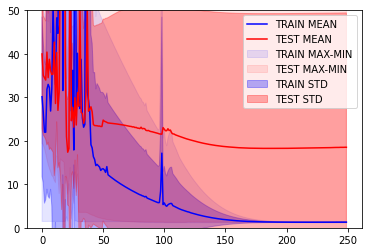

In [282]:

import matplotlib.pyplot as plt
    
init=100
plt.fill_between(x=np.arange(tt_a[1][init:].shape[0]),y1=tt_a[1][init:],y2=tt_a[0][init:],color='b',alpha=0.1, label = "TRAIN MAX-MIN")
plt.fill_between(x=np.arange(tt_a[1][init:].shape[0]),y1=vv_a[1][init:],y2=vv_a[0][init:],color='r',alpha=0.1, label = "TEST MAX-MIN")

plt.fill_between(x=np.arange(tt_a[1][init:].shape[0]),y1=tt_a[3][init:],y2=tt_a[4][init:],color='b',alpha=0.3, label = "TRAIN STD")
plt.fill_between(x=np.arange(tt_a[1][init:].shape[0]),y1=vv_a[3][init:],y2=vv_a[4][init:],color='r',alpha=0.3, label = "TEST STD")

plt.plot(tt_a[2][init:],'b', label = "TRAIN MEAN")
plt.plot(vv_a[2][init:],'r', label = "TEST MEAN")

plt.ylim(0,50)
plt.legend()
plt.show()

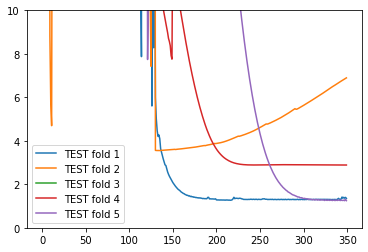

In [272]:
import matplotlib.pyplot as plt



for f in list(lr.reshape(1,)[0].keys()):

    plt.plot(lr.reshape(1,)[0][f]["valid_acc"], label = "TEST fold "+str(f+1))
    
plt.ylim(0,10)
plt.legend()
plt.show()

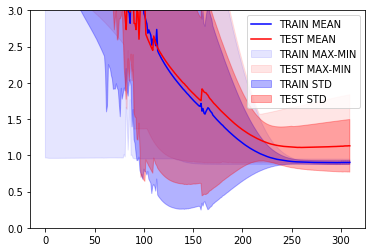

In [273]:
import matplotlib.pyplot as plt
    
init=40
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=tt_aa[1][init:],y2=tt_aa[0][init:],color='b',alpha=0.1, label = "TRAIN MAX-MIN")
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=vv_aa[1][init:],y2=vv_aa[0][init:],color='r',alpha=0.1, label = "TEST MAX-MIN")

plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=tt_aa[3][init:],y2=tt_aa[4][init:],color='b',alpha=0.3, label = "TRAIN STD")
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=vv_aa[3][init:],y2=vv_aa[4][init:],color='r',alpha=0.3, label = "TEST STD")

plt.plot(tt_aa[2][init:],'b', label = "TRAIN MEAN")
plt.plot(vv_aa[2][init:],'r', label = "TEST MEAN")

plt.ylim(0,3)
plt.legend()
plt.show()

In [275]:
#(folds,epochs,classes)
flTP_v=np.vectorize(lambda lTP,i:np.array(lTP[i]['valid_acc_abs']),
             signature="(),()->(j,i)")(lTP.reshape(1,)[0],np.array(list(lTP.reshape(1,)[0].keys())))*300
flTN_v=np.vectorize(lambda lTP,i:np.array(lTP[i]['valid_acc_abs']),
             signature="(),()->(j,i)")(lTN.reshape(1,)[0],np.array(list(lTN.reshape(1,)[0].keys())))*300
flFP_v=np.vectorize(lambda lTP,i:np.array(lTP[i]['valid_acc_abs']),
             signature="(),()->(j,i)")(lFP.reshape(1,)[0],np.array(list(lFP.reshape(1,)[0].keys())))*300
flFN_v=np.vectorize(lambda lTP,i:np.array(lTP[i]['valid_acc_abs']),
             signature="(),()->(j,i)")(lFN.reshape(1,)[0],np.array(list(lFN.reshape(1,)[0].keys())))*300

In [276]:
#(folds,epochs,classes)
flTP_t=np.vectorize(lambda lTP,i:np.array(lTP[i]['train_acc_abs']),
             signature="(),()->(j,i)")(lTP.reshape(1,)[0],np.array(list(lTP.reshape(1,)[0].keys())))*300
flTN_t=np.vectorize(lambda lTP,i:np.array(lTP[i]['train_acc_abs']),
             signature="(),()->(j,i)")(lTN.reshape(1,)[0],np.array(list(lTN.reshape(1,)[0].keys())))*300
flFP_t=np.vectorize(lambda lTP,i:np.array(lTP[i]['train_acc_abs']),
             signature="(),()->(j,i)")(lFP.reshape(1,)[0],np.array(list(lFP.reshape(1,)[0].keys())))*300
flFN_t=np.vectorize(lambda lTP,i:np.array(lTP[i]['train_acc_abs']),
             signature="(),()->(j,i)")(lFN.reshape(1,)[0],np.array(list(lFN.reshape(1,)[0].keys())))*300

In [277]:
fsen_v=flTP_v/(flTP_v+flFN_v)
fspe_v=flTN_v/(flFP_v+flTN_v)
acccl_v=(flTN_v+flTP_v)/(flFP_v+flFN_v+flTN_v+flTP_v)

fsen_t=flTP_t/(flTP_t+flFN_t)
fspe_t=flTN_t/(flFP_t+flTN_t)
acccl_t=(flTN_t+flTP_t)/(flFP_t+flFN_t+flTN_t+flTP_t)

<ipython-input-277-2d33aefb341b>:1: RuntimeWarning: invalid value encountered in true_divide
  fsen_v=flTP_v/(flTP_v+flFN_v)
<ipython-input-277-2d33aefb341b>:5: RuntimeWarning: invalid value encountered in true_divide
  fsen_t=flTP_t/(flTP_t+flFN_t)


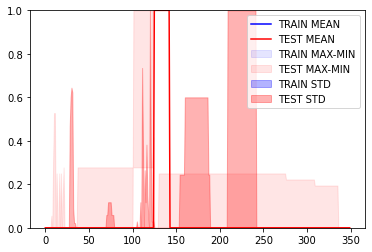

In [278]:
import matplotlib.pyplot as plt
tt_aa=fsen_t[:,:,2]
vv_aa=fsen_v[:,:,2]
    
init=0
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=tt_aa[1][init:],y2=tt_aa[0][init:],color='b',alpha=0.1, label = "TRAIN MAX-MIN")
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=vv_aa[1][init:],y2=vv_aa[0][init:],color='r',alpha=0.1, label = "TEST MAX-MIN")

plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=tt_aa[3][init:],y2=tt_aa[4][init:],color='b',alpha=0.3, label = "TRAIN STD")
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=vv_aa[3][init:],y2=vv_aa[4][init:],color='r',alpha=0.3, label = "TEST STD")

plt.plot(tt_aa[2][init:],'b', label = "TRAIN MEAN")
plt.plot(vv_aa[2][init:],'r', label = "TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()

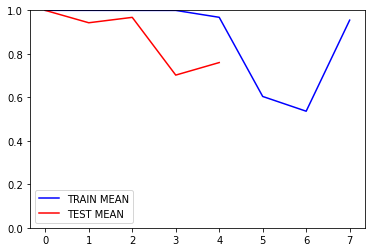

In [279]:

plt.plot(np.mean(acccl_t[:,-1,:],axis=0),'b', label = "TRAIN MEAN")
plt.plot(np.mean(acccl_v[:,-1,:],axis=0),'r', label = "TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()

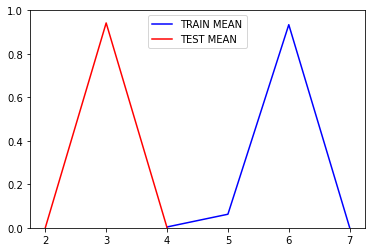

In [280]:

plt.plot(np.mean(fsen_t[:,-1,:],axis=0),'b', label = "TRAIN MEAN")
plt.plot(np.mean(fsen_v[:,-1,:],axis=0),'r', label = "TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()

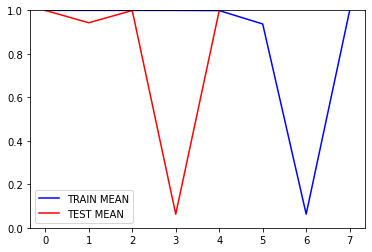

In [281]:
plt.plot(np.mean(fspe_t[:,-1,:],axis=0),'b', label = "TRAIN MEAN")
plt.plot(np.mean(fspe_v[:,-1,:],axis=0),'r', label = "TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()

In [252]:
np.vectorize(lambda n:n.split("_")[1])(dataset.landmarks_frame[:,0])

array(['c1anemia-413.npy', 'c1anemia-446.npy', 'c1anemia-467.npy', ...,
       'c1anemia-429.npy', 'c1anemia-403.npy', 'c2anemia-898.npy'],
      dtype='<U17')